In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("FF", "SI")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("FF", "SI")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6720488225393741
Log Loss: 0.6200689054362148


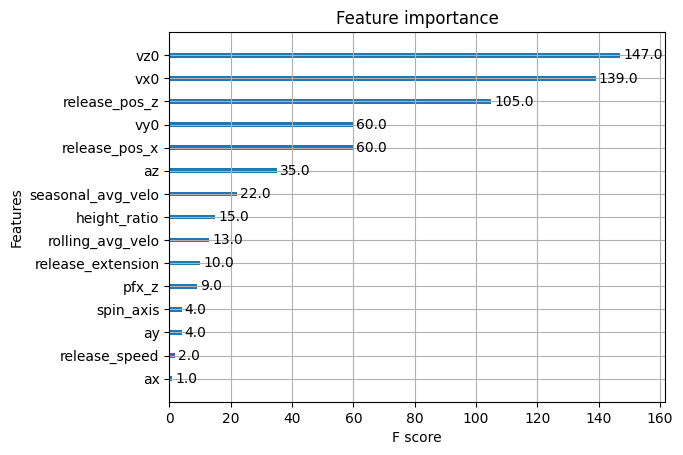

In [12]:
xgb.plot_importance(model)
plt.show()

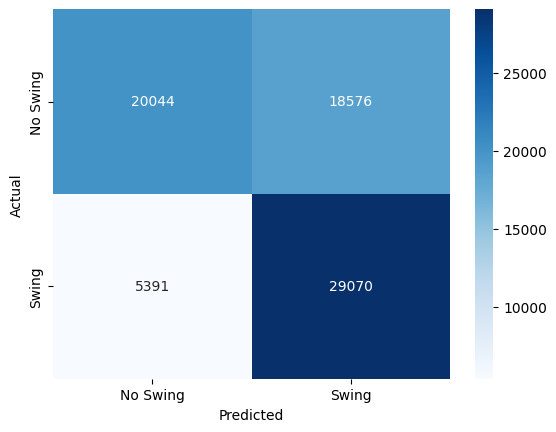

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-17 08:58:13,660] A new study created in memory with name: no-name-a95d4e8e-1eed-4433-a88c-6800b08f3418
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67371
[3]	eval-logloss:0.66809
[4]	eval-logloss:0.66327
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65420
[7]	eval-logloss:0.64977
[8]	eval-logloss:0.64587
[9]	eval-logloss:0.64113
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63357
[12]	eval-logloss:0.63017
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62408
[15]	eval-logloss:0.62111
[16]	eval-logloss:0.61804
[17]	eval-logloss:0.61537
[18]	eval-logloss:0.61272
[19]	eval-logloss:0.61089
[20]	eval-logloss:0.60909
[21]	eval-logloss:0.60656
[22]	eval-logloss:0.60439
[23]	eval-logloss:0.60245
[24]	eval-logloss:0.60006
[25]	eval-logloss:0.59866
[26]	eval-logloss:0.59670
[27]	eval-logloss:0.59541
[28]	eval-logloss:0.59380
[29]	eval-logloss:0.59227
[30]	eval-logloss:0.59118
[31]	eval-logloss:0.58975
[32]	eval-logloss:0.58848
[33]	eval-logloss:0.58744
[34]	eval-logloss:0.58642
[35]	eval-logloss:0.58517
[36]	eval-logloss:0.58400
[37]	eval-logloss:0.58290
[38]	eval-logloss:0.58

[I 2023-11-17 08:58:17,612] Trial 0 finished with value: 0.5415959109566095 and parameters: {'max_depth': 7, 'eta': 0.051054089770559516, 'subsample': 0.6098653324269276, 'colsample_bytree': 0.955289351355086}. Best is trial 0 with value: 0.5415959109566095.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64088
[5]	eval-logloss:0.63614
[6]	eval-logloss:0.62994
[7]	eval-logloss:0.62657
[8]	eval-logloss:0.62234
[9]	eval-logloss:0.61839
[10]	eval-logloss:0.61341
[11]	eval-logloss:0.61096
[12]	eval-logloss:0.60818
[13]	eval-logloss:0.60536
[14]	eval-logloss:0.60240
[15]	eval-logloss:0.60015
[16]	eval-logloss:0.59500
[17]	eval-logloss:0.59346
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59098
[20]	eval-logloss:0.58967
[21]	eval-logloss:0.58814
[22]	eval-logloss:0.58333
[23]	eval-logloss:0.58263
[24]	eval-logloss:0.58112
[25]	eval-logloss:0.58045
[26]	eval-logloss:0.58024
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57604
[30]	eval-logloss:0.57511
[31]	eval-logloss:0.57382
[32]	eval-logloss:0.57325
[33]	eval-logloss:0.57246
[34]	eval-logloss:0.57149
[35]	eval-logloss:0.56903
[36]	eval-logloss:0.56861
[37]	eval-logloss:0.56662
[38]	eval-logloss:0.56

[I 2023-11-17 08:58:20,558] Trial 1 finished with value: 0.5306125373132068 and parameters: {'max_depth': 5, 'eta': 0.1486622117891968, 'subsample': 0.7095204135388729, 'colsample_bytree': 0.7373146108126902}. Best is trial 1 with value: 0.5306125373132068.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62712
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.61127
[6]	eval-logloss:0.60234
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58821
[9]	eval-logloss:0.58369
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57393
[13]	eval-logloss:0.57105
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56476
[16]	eval-logloss:0.56230
[17]	eval-logloss:0.56032
[18]	eval-logloss:0.55842
[19]	eval-logloss:0.55698
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55523
[22]	eval-logloss:0.55280
[23]	eval-logloss:0.55214
[24]	eval-logloss:0.54818
[25]	eval-logloss:0.54541
[26]	eval-logloss:0.54529
[27]	eval-logloss:0.54442
[28]	eval-logloss:0.54344
[29]	eval-logloss:0.54092
[30]	eval-logloss:0.53967
[31]	eval-logloss:0.53904
[32]	eval-logloss:0.53862
[33]	eval-logloss:0.53801
[34]	eval-logloss:0.53752
[35]	eval-logloss:0.53600
[36]	eval-logloss:0.53569
[37]	eval-logloss:0.53530
[38]	eval-logloss:0.53

[I 2023-11-17 08:58:24,511] Trial 2 finished with value: 0.5108020090038664 and parameters: {'max_depth': 8, 'eta': 0.1514304407280454, 'subsample': 0.8872168026424958, 'colsample_bytree': 0.8303697408276622}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65799
[1]	eval-logloss:0.63858
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.60144
[4]	eval-logloss:0.59279
[5]	eval-logloss:0.58794
[6]	eval-logloss:0.58338
[7]	eval-logloss:0.57145
[8]	eval-logloss:0.56695
[9]	eval-logloss:0.56410
[10]	eval-logloss:0.55881
[11]	eval-logloss:0.55707
[12]	eval-logloss:0.55588
[13]	eval-logloss:0.55335
[14]	eval-logloss:0.55207
[15]	eval-logloss:0.54912
[16]	eval-logloss:0.54288
[17]	eval-logloss:0.54180
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53869
[20]	eval-logloss:0.53814
[21]	eval-logloss:0.53792
[22]	eval-logloss:0.53468
[23]	eval-logloss:0.53445
[24]	eval-logloss:0.53447
[25]	eval-logloss:0.53437
[26]	eval-logloss:0.53453
[27]	eval-logloss:0.53407
[28]	eval-logloss:0.53352
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.53303
[31]	eval-logloss:0.53277
[32]	eval-logloss:0.53241
[33]	eval-logloss:0.53233
[34]	eval-logloss:0.53227
[35]	eval-logloss:0.53135
[36]	eval-logloss:0.53136
[37]	eval-logloss:0.52909
[38]	eval-logloss:0.52

[I 2023-11-17 08:58:28,177] Trial 3 finished with value: 0.5188264204115889 and parameters: {'max_depth': 8, 'eta': 0.2513674279071172, 'subsample': 0.6007616933905924, 'colsample_bytree': 0.7218713332436371}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67509
[3]	eval-logloss:0.66978
[4]	eval-logloss:0.66530
[5]	eval-logloss:0.66168
[6]	eval-logloss:0.65784
[7]	eval-logloss:0.65370
[8]	eval-logloss:0.64987
[9]	eval-logloss:0.64660
[10]	eval-logloss:0.64262
[11]	eval-logloss:0.64102
[12]	eval-logloss:0.63837
[13]	eval-logloss:0.63515
[14]	eval-logloss:0.63206
[15]	eval-logloss:0.62893
[16]	eval-logloss:0.62657
[17]	eval-logloss:0.62353
[18]	eval-logloss:0.62110
[19]	eval-logloss:0.61942
[20]	eval-logloss:0.61765
[21]	eval-logloss:0.61572
[22]	eval-logloss:0.61364
[23]	eval-logloss:0.61180
[24]	eval-logloss:0.61018
[25]	eval-logloss:0.60992
[26]	eval-logloss:0.60975
[27]	eval-logloss:0.60879
[28]	eval-logloss:0.60715
[29]	eval-logloss:0.60605
[30]	eval-logloss:0.60511
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60299
[33]	eval-logloss:0.60164
[34]	eval-logloss:0.60046
[35]	eval-logloss:0.59897
[36]	eval-logloss:0.59792
[37]	eval-logloss:0.59683
[38]	eval-logloss:0.59

[I 2023-11-17 08:58:31,490] Trial 4 finished with value: 0.5566094026496315 and parameters: {'max_depth': 6, 'eta': 0.05270834980340001, 'subsample': 0.7480880592725839, 'colsample_bytree': 0.7149381384353366}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67299
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.65030
[3]	eval-logloss:0.64181
[4]	eval-logloss:0.63556
[5]	eval-logloss:0.62892
[6]	eval-logloss:0.62538
[7]	eval-logloss:0.61955
[8]	eval-logloss:0.61659
[9]	eval-logloss:0.61465
[10]	eval-logloss:0.61061
[11]	eval-logloss:0.60927
[12]	eval-logloss:0.60783
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.59998
[15]	eval-logloss:0.59684
[16]	eval-logloss:0.59568
[17]	eval-logloss:0.59385
[18]	eval-logloss:0.59222
[19]	eval-logloss:0.58952
[20]	eval-logloss:0.58855
[21]	eval-logloss:0.58750
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58016
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57930
[26]	eval-logloss:0.57800
[27]	eval-logloss:0.57643
[28]	eval-logloss:0.57563
[29]	eval-logloss:0.57378
[30]	eval-logloss:0.57159
[31]	eval-logloss:0.57103
[32]	eval-logloss:0.56796
[33]	eval-logloss:0.56694
[34]	eval-logloss:0.56672
[35]	eval-logloss:0.56567
[36]	eval-logloss:0.56502
[37]	eval-logloss:0.56444
[38]	eval-logloss:0.56

[I 2023-11-17 08:58:34,039] Trial 5 finished with value: 0.534487530498508 and parameters: {'max_depth': 4, 'eta': 0.23336606118661538, 'subsample': 0.7972736222014836, 'colsample_bytree': 0.9883374819364947}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66827
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63353
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61867
[5]	eval-logloss:0.61369
[6]	eval-logloss:0.60572
[7]	eval-logloss:0.59837
[8]	eval-logloss:0.59189
[9]	eval-logloss:0.59128
[10]	eval-logloss:0.58503
[11]	eval-logloss:0.58301
[12]	eval-logloss:0.57913
[13]	eval-logloss:0.57388
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56868
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56306
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55679
[20]	eval-logloss:0.55553
[21]	eval-logloss:0.55507
[22]	eval-logloss:0.55496
[23]	eval-logloss:0.55360
[24]	eval-logloss:0.55360
[25]	eval-logloss:0.55326
[26]	eval-logloss:0.55317
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.54878
[29]	eval-logloss:0.54787
[30]	eval-logloss:0.54736
[31]	eval-logloss:0.54668
[32]	eval-logloss:0.54652
[33]	eval-logloss:0.54645
[34]	eval-logloss:0.54578
[35]	eval-logloss:0.54425
[36]	eval-logloss:0.54419
[37]	eval-logloss:0.54384
[38]	eval-logloss:0.54

[I 2023-11-17 08:58:37,074] Trial 6 finished with value: 0.5201028430117849 and parameters: {'max_depth': 7, 'eta': 0.20039486658527197, 'subsample': 0.8331831278456208, 'colsample_bytree': 0.5428035667126447}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68397
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67628
[4]	eval-logloss:0.67313
[5]	eval-logloss:0.67004
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66507
[8]	eval-logloss:0.66245
[9]	eval-logloss:0.66003
[10]	eval-logloss:0.65791
[11]	eval-logloss:0.65627
[12]	eval-logloss:0.65408
[13]	eval-logloss:0.65222
[14]	eval-logloss:0.65083
[15]	eval-logloss:0.64959
[16]	eval-logloss:0.64779
[17]	eval-logloss:0.64681
[18]	eval-logloss:0.64569
[19]	eval-logloss:0.64470
[20]	eval-logloss:0.64311
[21]	eval-logloss:0.64224
[22]	eval-logloss:0.64069
[23]	eval-logloss:0.63994
[24]	eval-logloss:0.63788
[25]	eval-logloss:0.63645
[26]	eval-logloss:0.63619
[27]	eval-logloss:0.63520
[28]	eval-logloss:0.63403
[29]	eval-logloss:0.63267
[30]	eval-logloss:0.63149
[31]	eval-logloss:0.63082
[32]	eval-logloss:0.62961
[33]	eval-logloss:0.62860
[34]	eval-logloss:0.62800
[35]	eval-logloss:0.62692
[36]	eval-logloss:0.62628
[37]	eval-logloss:0.62573
[38]	eval-logloss:0.62

[I 2023-11-17 08:58:39,428] Trial 7 finished with value: 0.5936463331178139 and parameters: {'max_depth': 3, 'eta': 0.06596410852764462, 'subsample': 0.6559620029624491, 'colsample_bytree': 0.9259733151130267}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66303
[1]	eval-logloss:0.64531
[2]	eval-logloss:0.62494
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59718
[6]	eval-logloss:0.58866
[7]	eval-logloss:0.57870
[8]	eval-logloss:0.57411
[9]	eval-logloss:0.57032
[10]	eval-logloss:0.56581
[11]	eval-logloss:0.56429
[12]	eval-logloss:0.56215
[13]	eval-logloss:0.55948
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55608
[16]	eval-logloss:0.55067
[17]	eval-logloss:0.54890
[18]	eval-logloss:0.54728
[19]	eval-logloss:0.54626
[20]	eval-logloss:0.54526
[21]	eval-logloss:0.54484
[22]	eval-logloss:0.54314
[23]	eval-logloss:0.54267
[24]	eval-logloss:0.53928
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53784
[28]	eval-logloss:0.53767
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.53451
[31]	eval-logloss:0.53402
[32]	eval-logloss:0.53385
[33]	eval-logloss:0.53359
[34]	eval-logloss:0.53339
[35]	eval-logloss:0.53139
[36]	eval-logloss:0.53130
[37]	eval-logloss:0.52935
[38]	eval-logloss:0.52

[I 2023-11-17 08:58:43,454] Trial 8 finished with value: 0.5140729531616214 and parameters: {'max_depth': 8, 'eta': 0.20842108537993995, 'subsample': 0.6805911228928553, 'colsample_bytree': 0.7352003742816132}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.64114
[2]	eval-logloss:0.61909
[3]	eval-logloss:0.60745
[4]	eval-logloss:0.59908
[5]	eval-logloss:0.59396
[6]	eval-logloss:0.58323
[7]	eval-logloss:0.57648
[8]	eval-logloss:0.57179
[9]	eval-logloss:0.56828
[10]	eval-logloss:0.55993
[11]	eval-logloss:0.55839
[12]	eval-logloss:0.55641
[13]	eval-logloss:0.55328
[14]	eval-logloss:0.55151
[15]	eval-logloss:0.54989
[16]	eval-logloss:0.54438
[17]	eval-logloss:0.54357
[18]	eval-logloss:0.53937
[19]	eval-logloss:0.53854
[20]	eval-logloss:0.53778
[21]	eval-logloss:0.53765
[22]	eval-logloss:0.53759
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53749
[25]	eval-logloss:0.53737
[26]	eval-logloss:0.53743
[27]	eval-logloss:0.53743
[28]	eval-logloss:0.53612
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53419
[32]	eval-logloss:0.53397
[33]	eval-logloss:0.53391
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53107
[36]	eval-logloss:0.53112
[37]	eval-logloss:0.53072
[38]	eval-logloss:0.53

[I 2023-11-17 08:58:47,281] Trial 9 finished with value: 0.518737197896422 and parameters: {'max_depth': 8, 'eta': 0.23583508835011951, 'subsample': 0.6053708786265731, 'colsample_bytree': 0.6258362353950565}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.64939
[1]	eval-logloss:0.62741
[2]	eval-logloss:0.60171
[3]	eval-logloss:0.58691
[4]	eval-logloss:0.57889
[5]	eval-logloss:0.57066
[6]	eval-logloss:0.56311
[7]	eval-logloss:0.55666
[8]	eval-logloss:0.55273
[9]	eval-logloss:0.54718
[10]	eval-logloss:0.54408
[11]	eval-logloss:0.54135
[12]	eval-logloss:0.53901
[13]	eval-logloss:0.53797
[14]	eval-logloss:0.53610
[15]	eval-logloss:0.53436
[16]	eval-logloss:0.53386
[17]	eval-logloss:0.53156
[18]	eval-logloss:0.52880
[19]	eval-logloss:0.52686
[20]	eval-logloss:0.52649
[21]	eval-logloss:0.52638
[22]	eval-logloss:0.52496
[23]	eval-logloss:0.52498
[24]	eval-logloss:0.52482
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52450
[27]	eval-logloss:0.52426
[28]	eval-logloss:0.52419
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.52306
[31]	eval-logloss:0.52281
[32]	eval-logloss:0.52303
[33]	eval-logloss:0.52260
[34]	eval-logloss:0.52261
[35]	eval-logloss:0.52093
[36]	eval-logloss:0.52080
[37]	eval-logloss:0.52004
[38]	eval-logloss:0.52

[I 2023-11-17 08:58:52,090] Trial 10 finished with value: 0.5166860977587795 and parameters: {'max_depth': 9, 'eta': 0.2891257255718125, 'subsample': 0.8878390122148493, 'colsample_bytree': 0.8517726995224628}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63182
[3]	eval-logloss:0.61770
[4]	eval-logloss:0.60864
[5]	eval-logloss:0.59814
[6]	eval-logloss:0.58929
[7]	eval-logloss:0.58412
[8]	eval-logloss:0.57883
[9]	eval-logloss:0.57338
[10]	eval-logloss:0.56825
[11]	eval-logloss:0.56630
[12]	eval-logloss:0.56385
[13]	eval-logloss:0.56110
[14]	eval-logloss:0.55678
[15]	eval-logloss:0.55440
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.54994
[18]	eval-logloss:0.54838
[19]	eval-logloss:0.54559
[20]	eval-logloss:0.54490
[21]	eval-logloss:0.54406
[22]	eval-logloss:0.54245
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.53901
[25]	eval-logloss:0.53839
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53767
[28]	eval-logloss:0.53522
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53194
[31]	eval-logloss:0.53148
[32]	eval-logloss:0.53125
[33]	eval-logloss:0.53004
[34]	eval-logloss:0.52964
[35]	eval-logloss:0.52908
[36]	eval-logloss:0.52884
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52

[I 2023-11-17 08:58:56,876] Trial 11 finished with value: 0.5135974997592476 and parameters: {'max_depth': 9, 'eta': 0.1608877818883611, 'subsample': 0.8866890442499838, 'colsample_bytree': 0.8143882967965311}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:58:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66961
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.63832
[3]	eval-logloss:0.62492
[4]	eval-logloss:0.61576
[5]	eval-logloss:0.60608
[6]	eval-logloss:0.59960
[7]	eval-logloss:0.59098
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.57170
[12]	eval-logloss:0.56886
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56173
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55707
[17]	eval-logloss:0.55544
[18]	eval-logloss:0.55361
[19]	eval-logloss:0.55023
[20]	eval-logloss:0.54918
[21]	eval-logloss:0.54830
[22]	eval-logloss:0.54671
[23]	eval-logloss:0.54604
[24]	eval-logloss:0.54271
[25]	eval-logloss:0.54020
[26]	eval-logloss:0.54017
[27]	eval-logloss:0.53931
[28]	eval-logloss:0.53853
[29]	eval-logloss:0.53625
[30]	eval-logloss:0.53542
[31]	eval-logloss:0.53478
[32]	eval-logloss:0.53448
[33]	eval-logloss:0.53370
[34]	eval-logloss:0.53329
[35]	eval-logloss:0.53283
[36]	eval-logloss:0.53258
[37]	eval-logloss:0.53115
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:01,611] Trial 12 finished with value: 0.5126007423366371 and parameters: {'max_depth': 9, 'eta': 0.1378414977728409, 'subsample': 0.8821043289205731, 'colsample_bytree': 0.8215165856723361}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67421
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.64619
[3]	eval-logloss:0.63393
[4]	eval-logloss:0.62539
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.60950
[7]	eval-logloss:0.60211
[8]	eval-logloss:0.59674
[9]	eval-logloss:0.59038
[10]	eval-logloss:0.58526
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57589
[13]	eval-logloss:0.57207
[14]	eval-logloss:0.56896
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56092
[18]	eval-logloss:0.55931
[19]	eval-logloss:0.55723
[20]	eval-logloss:0.55586
[21]	eval-logloss:0.55476
[22]	eval-logloss:0.55171
[23]	eval-logloss:0.55077
[24]	eval-logloss:0.54743
[25]	eval-logloss:0.54651
[26]	eval-logloss:0.54616
[27]	eval-logloss:0.54521
[28]	eval-logloss:0.54347
[29]	eval-logloss:0.54087
[30]	eval-logloss:0.53998
[31]	eval-logloss:0.53920
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53770
[34]	eval-logloss:0.53677
[35]	eval-logloss:0.53628
[36]	eval-logloss:0.53582
[37]	eval-logloss:0.53438
[38]	eval-logloss:0.53

[I 2023-11-17 08:59:06,253] Trial 13 finished with value: 0.5121515415028344 and parameters: {'max_depth': 9, 'eta': 0.11514924696463233, 'subsample': 0.833684777275941, 'colsample_bytree': 0.8601533688677343}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66862
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.64636
[4]	eval-logloss:0.63891
[5]	eval-logloss:0.63073
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.61915
[8]	eval-logloss:0.61421
[9]	eval-logloss:0.60979
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60154
[12]	eval-logloss:0.59819
[13]	eval-logloss:0.59557
[14]	eval-logloss:0.59207
[15]	eval-logloss:0.58827
[16]	eval-logloss:0.58517
[17]	eval-logloss:0.58312
[18]	eval-logloss:0.58140
[19]	eval-logloss:0.57914
[20]	eval-logloss:0.57731
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57296
[23]	eval-logloss:0.57171
[24]	eval-logloss:0.56820
[25]	eval-logloss:0.56682
[26]	eval-logloss:0.56640
[27]	eval-logloss:0.56496
[28]	eval-logloss:0.56331
[29]	eval-logloss:0.56111
[30]	eval-logloss:0.55841
[31]	eval-logloss:0.55655
[32]	eval-logloss:0.55461
[33]	eval-logloss:0.55387
[34]	eval-logloss:0.55268
[35]	eval-logloss:0.55155
[36]	eval-logloss:0.55080
[37]	eval-logloss:0.54953
[38]	eval-logloss:0.54

[I 2023-11-17 08:59:10,147] Trial 14 finished with value: 0.5200649674923534 and parameters: {'max_depth': 7, 'eta': 0.10259197863769531, 'subsample': 0.8323312908262073, 'colsample_bytree': 0.90803374558076}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68549
[6]	eval-logloss:0.68429
[7]	eval-logloss:0.68308
[8]	eval-logloss:0.68196
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.67969
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67747
[13]	eval-logloss:0.67641
[14]	eval-logloss:0.67532
[15]	eval-logloss:0.67424
[16]	eval-logloss:0.67320
[17]	eval-logloss:0.67220
[18]	eval-logloss:0.67106
[19]	eval-logloss:0.67010
[20]	eval-logloss:0.66922
[21]	eval-logloss:0.66839
[22]	eval-logloss:0.66742
[23]	eval-logloss:0.66656
[24]	eval-logloss:0.66565
[25]	eval-logloss:0.66476
[26]	eval-logloss:0.66467
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66296
[29]	eval-logloss:0.66190
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65928
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65503
[38]	eval-logloss:0.65

[I 2023-11-17 08:59:13,623] Trial 15 finished with value: 0.6190833827601926 and parameters: {'max_depth': 6, 'eta': 0.010601812872045868, 'subsample': 0.8491028318748185, 'colsample_bytree': 0.8926183369449349}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63222
[5]	eval-logloss:0.62601
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61058
[8]	eval-logloss:0.60485
[9]	eval-logloss:0.59918
[10]	eval-logloss:0.59364
[11]	eval-logloss:0.59172
[12]	eval-logloss:0.58865
[13]	eval-logloss:0.58511
[14]	eval-logloss:0.58197
[15]	eval-logloss:0.57909
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57292
[18]	eval-logloss:0.56997
[19]	eval-logloss:0.56777
[20]	eval-logloss:0.56605
[21]	eval-logloss:0.56477
[22]	eval-logloss:0.56338
[23]	eval-logloss:0.56250
[24]	eval-logloss:0.55872
[25]	eval-logloss:0.55618
[26]	eval-logloss:0.55607
[27]	eval-logloss:0.55517
[28]	eval-logloss:0.55397
[29]	eval-logloss:0.55241
[30]	eval-logloss:0.55112
[31]	eval-logloss:0.55034
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54818
[34]	eval-logloss:0.54769
[35]	eval-logloss:0.54645
[36]	eval-logloss:0.54590
[37]	eval-logloss:0.54465
[38]	eval-logloss:0.54

[I 2023-11-17 08:59:17,812] Trial 16 finished with value: 0.5163025391622978 and parameters: {'max_depth': 8, 'eta': 0.11088686454736174, 'subsample': 0.7935816639334218, 'colsample_bytree': 0.820965156034448}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64772
[2]	eval-logloss:0.62974
[3]	eval-logloss:0.61490
[4]	eval-logloss:0.60596
[5]	eval-logloss:0.59727
[6]	eval-logloss:0.59144
[7]	eval-logloss:0.58312
[8]	eval-logloss:0.57902
[9]	eval-logloss:0.57454
[10]	eval-logloss:0.56894
[11]	eval-logloss:0.56341
[12]	eval-logloss:0.56084
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55614
[15]	eval-logloss:0.55134
[16]	eval-logloss:0.54905
[17]	eval-logloss:0.54779
[18]	eval-logloss:0.54608
[19]	eval-logloss:0.54470
[20]	eval-logloss:0.54136
[21]	eval-logloss:0.53825
[22]	eval-logloss:0.53716
[23]	eval-logloss:0.53611
[24]	eval-logloss:0.53358
[25]	eval-logloss:0.53299
[26]	eval-logloss:0.53108
[27]	eval-logloss:0.53061
[28]	eval-logloss:0.53008
[29]	eval-logloss:0.52873
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52639
[32]	eval-logloss:0.52610
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52370
[36]	eval-logloss:0.52365
[37]	eval-logloss:0.52192
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:22,228] Trial 17 finished with value: 0.5112827833808656 and parameters: {'max_depth': 9, 'eta': 0.1757213961179391, 'subsample': 0.896620925931363, 'colsample_bytree': 0.9977598824048135}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65448
[2]	eval-logloss:0.63624
[3]	eval-logloss:0.62443
[4]	eval-logloss:0.61630
[5]	eval-logloss:0.60831
[6]	eval-logloss:0.60067
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.58992
[9]	eval-logloss:0.58599
[10]	eval-logloss:0.58083
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.57264
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56839
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56227
[17]	eval-logloss:0.55896
[18]	eval-logloss:0.55751
[19]	eval-logloss:0.55379
[20]	eval-logloss:0.55254
[21]	eval-logloss:0.55124
[22]	eval-logloss:0.54973
[23]	eval-logloss:0.54831
[24]	eval-logloss:0.54538
[25]	eval-logloss:0.54409
[26]	eval-logloss:0.54231
[27]	eval-logloss:0.54170
[28]	eval-logloss:0.54123
[29]	eval-logloss:0.53819
[30]	eval-logloss:0.53737
[31]	eval-logloss:0.53686
[32]	eval-logloss:0.53636
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53536
[35]	eval-logloss:0.53454
[36]	eval-logloss:0.53404
[37]	eval-logloss:0.53267
[38]	eval-logloss:0.53

[I 2023-11-17 08:59:25,879] Trial 18 finished with value: 0.5137083282774924 and parameters: {'max_depth': 7, 'eta': 0.18036687882646166, 'subsample': 0.8685968450563509, 'colsample_bytree': 0.9954850652503863}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66293
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63510
[5]	eval-logloss:0.62793
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.61898
[8]	eval-logloss:0.61389
[9]	eval-logloss:0.61033
[10]	eval-logloss:0.60613
[11]	eval-logloss:0.60262
[12]	eval-logloss:0.59785
[13]	eval-logloss:0.59668
[14]	eval-logloss:0.59427
[15]	eval-logloss:0.58933
[16]	eval-logloss:0.58832
[17]	eval-logloss:0.58506
[18]	eval-logloss:0.58250
[19]	eval-logloss:0.58128
[20]	eval-logloss:0.57983
[21]	eval-logloss:0.57836
[22]	eval-logloss:0.57641
[23]	eval-logloss:0.57467
[24]	eval-logloss:0.57101
[25]	eval-logloss:0.56992
[26]	eval-logloss:0.56659
[27]	eval-logloss:0.56600
[28]	eval-logloss:0.56526
[29]	eval-logloss:0.56304
[30]	eval-logloss:0.56199
[31]	eval-logloss:0.56124
[32]	eval-logloss:0.56069
[33]	eval-logloss:0.55993
[34]	eval-logloss:0.55952
[35]	eval-logloss:0.55773
[36]	eval-logloss:0.55733
[37]	eval-logloss:0.55622
[38]	eval-logloss:0.55

[I 2023-11-17 08:59:28,733] Trial 19 finished with value: 0.5251290856869409 and parameters: {'max_depth': 5, 'eta': 0.17298429464025597, 'subsample': 0.8897896675168037, 'colsample_bytree': 0.9475503522180818}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62329
[5]	eval-logloss:0.61490
[6]	eval-logloss:0.60708
[7]	eval-logloss:0.60037
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.59014
[10]	eval-logloss:0.58599
[11]	eval-logloss:0.58037
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.57509
[14]	eval-logloss:0.57114
[15]	eval-logloss:0.56853
[16]	eval-logloss:0.56531
[17]	eval-logloss:0.56404
[18]	eval-logloss:0.56134
[19]	eval-logloss:0.55961
[20]	eval-logloss:0.55638
[21]	eval-logloss:0.55411
[22]	eval-logloss:0.55291
[23]	eval-logloss:0.54944
[24]	eval-logloss:0.54711
[25]	eval-logloss:0.54588
[26]	eval-logloss:0.54473
[27]	eval-logloss:0.54373
[28]	eval-logloss:0.54269
[29]	eval-logloss:0.54172
[30]	eval-logloss:0.54093
[31]	eval-logloss:0.53885
[32]	eval-logloss:0.53771
[33]	eval-logloss:0.53679
[34]	eval-logloss:0.53626
[35]	eval-logloss:0.53542
[36]	eval-logloss:0.53505
[37]	eval-logloss:0.53485
[38]	eval-logloss:0.53

[I 2023-11-17 08:59:32,655] Trial 20 finished with value: 0.5121180979953759 and parameters: {'max_depth': 8, 'eta': 0.13823095948833491, 'subsample': 0.8615076138645503, 'colsample_bytree': 0.9994783948713665}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63192
[4]	eval-logloss:0.62338
[5]	eval-logloss:0.61594
[6]	eval-logloss:0.60766
[7]	eval-logloss:0.60178
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59285
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58327
[12]	eval-logloss:0.58002
[13]	eval-logloss:0.57755
[14]	eval-logloss:0.57397
[15]	eval-logloss:0.57176
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56434
[18]	eval-logloss:0.56201
[19]	eval-logloss:0.55984
[20]	eval-logloss:0.55866
[21]	eval-logloss:0.55687
[22]	eval-logloss:0.55477
[23]	eval-logloss:0.55160
[24]	eval-logloss:0.55073
[25]	eval-logloss:0.54951
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54657
[28]	eval-logloss:0.54614
[29]	eval-logloss:0.54351
[30]	eval-logloss:0.54158
[31]	eval-logloss:0.54081
[32]	eval-logloss:0.54046
[33]	eval-logloss:0.53967
[34]	eval-logloss:0.53875
[35]	eval-logloss:0.53682
[36]	eval-logloss:0.53643
[37]	eval-logloss:0.53443
[38]	eval-logloss:0.53

[I 2023-11-17 08:59:36,592] Trial 21 finished with value: 0.5123382214271409 and parameters: {'max_depth': 8, 'eta': 0.1349548184205548, 'subsample': 0.8954266156251456, 'colsample_bytree': 0.961982760912993}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.62899
[3]	eval-logloss:0.61329
[4]	eval-logloss:0.60432
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58623
[7]	eval-logloss:0.58044
[8]	eval-logloss:0.57654
[9]	eval-logloss:0.56960
[10]	eval-logloss:0.56559
[11]	eval-logloss:0.56188
[12]	eval-logloss:0.55921
[13]	eval-logloss:0.55635
[14]	eval-logloss:0.55182
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54531
[17]	eval-logloss:0.54397
[18]	eval-logloss:0.54249
[19]	eval-logloss:0.54100
[20]	eval-logloss:0.53702
[21]	eval-logloss:0.53602
[22]	eval-logloss:0.53364
[23]	eval-logloss:0.53314
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.53036
[26]	eval-logloss:0.52943
[27]	eval-logloss:0.52883
[28]	eval-logloss:0.52865
[29]	eval-logloss:0.52755
[30]	eval-logloss:0.52684
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52554
[33]	eval-logloss:0.52477
[34]	eval-logloss:0.52442
[35]	eval-logloss:0.52352
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52336
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:41,105] Trial 22 finished with value: 0.5115936586971673 and parameters: {'max_depth': 9, 'eta': 0.1797522883085369, 'subsample': 0.8597119036271332, 'colsample_bytree': 0.9886612451631651}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66322
[1]	eval-logloss:0.64564
[2]	eval-logloss:0.62428
[3]	eval-logloss:0.61105
[4]	eval-logloss:0.60192
[5]	eval-logloss:0.59208
[6]	eval-logloss:0.58447
[7]	eval-logloss:0.57877
[8]	eval-logloss:0.57475
[9]	eval-logloss:0.56980
[10]	eval-logloss:0.56477
[11]	eval-logloss:0.56085
[12]	eval-logloss:0.55475
[13]	eval-logloss:0.55071
[14]	eval-logloss:0.54793
[15]	eval-logloss:0.54597
[16]	eval-logloss:0.54392
[17]	eval-logloss:0.54255
[18]	eval-logloss:0.54087
[19]	eval-logloss:0.53811
[20]	eval-logloss:0.53741
[21]	eval-logloss:0.53694
[22]	eval-logloss:0.53402
[23]	eval-logloss:0.53344
[24]	eval-logloss:0.53153
[25]	eval-logloss:0.53114
[26]	eval-logloss:0.53107
[27]	eval-logloss:0.53034
[28]	eval-logloss:0.53010
[29]	eval-logloss:0.52910
[30]	eval-logloss:0.52845
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52639
[33]	eval-logloss:0.52494
[34]	eval-logloss:0.52413
[35]	eval-logloss:0.52339
[36]	eval-logloss:0.52315
[37]	eval-logloss:0.52184
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:45,546] Trial 23 finished with value: 0.5128405454615199 and parameters: {'max_depth': 9, 'eta': 0.18789136077899635, 'subsample': 0.8592743967107448, 'colsample_bytree': 0.9093807783781899}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64915
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61629
[4]	eval-logloss:0.60700
[5]	eval-logloss:0.59743
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58384
[8]	eval-logloss:0.57979
[9]	eval-logloss:0.57249
[10]	eval-logloss:0.56919
[11]	eval-logloss:0.56557
[12]	eval-logloss:0.56169
[13]	eval-logloss:0.55933
[14]	eval-logloss:0.55453
[15]	eval-logloss:0.55283
[16]	eval-logloss:0.54914
[17]	eval-logloss:0.54781
[18]	eval-logloss:0.54544
[19]	eval-logloss:0.54413
[20]	eval-logloss:0.54315
[21]	eval-logloss:0.54253
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53797
[24]	eval-logloss:0.53564
[25]	eval-logloss:0.53439
[26]	eval-logloss:0.53422
[27]	eval-logloss:0.53369
[28]	eval-logloss:0.53236
[29]	eval-logloss:0.52988
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52797
[32]	eval-logloss:0.52763
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52627
[35]	eval-logloss:0.52492
[36]	eval-logloss:0.52479
[37]	eval-logloss:0.52368
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:49,664] Trial 24 finished with value: 0.5123600374949974 and parameters: {'max_depth': 9, 'eta': 0.16848900182842663, 'subsample': 0.894806399840259, 'colsample_bytree': 0.94023691922235}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.64317
[2]	eval-logloss:0.62112
[3]	eval-logloss:0.60685
[4]	eval-logloss:0.59794
[5]	eval-logloss:0.58866
[6]	eval-logloss:0.57967
[7]	eval-logloss:0.57246
[8]	eval-logloss:0.56712
[9]	eval-logloss:0.56123
[10]	eval-logloss:0.55602
[11]	eval-logloss:0.55045
[12]	eval-logloss:0.54765
[13]	eval-logloss:0.54528
[14]	eval-logloss:0.54325
[15]	eval-logloss:0.54144
[16]	eval-logloss:0.53835
[17]	eval-logloss:0.53720
[18]	eval-logloss:0.53633
[19]	eval-logloss:0.53506
[20]	eval-logloss:0.53420
[21]	eval-logloss:0.53381
[22]	eval-logloss:0.53129
[23]	eval-logloss:0.53092
[24]	eval-logloss:0.52860
[25]	eval-logloss:0.52701
[26]	eval-logloss:0.52683
[27]	eval-logloss:0.52611
[28]	eval-logloss:0.52536
[29]	eval-logloss:0.52526
[30]	eval-logloss:0.52430
[31]	eval-logloss:0.52367
[32]	eval-logloss:0.52358
[33]	eval-logloss:0.52306
[34]	eval-logloss:0.52222
[35]	eval-logloss:0.52191
[36]	eval-logloss:0.52187
[37]	eval-logloss:0.52162
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:54,001] Trial 25 finished with value: 0.5131023849014411 and parameters: {'max_depth': 9, 'eta': 0.20037397355377262, 'subsample': 0.8092631059969957, 'colsample_bytree': 0.8739069532154633}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66743
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63608
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.61234
[5]	eval-logloss:0.60369
[6]	eval-logloss:0.59634
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.58325
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57275
[11]	eval-logloss:0.57067
[12]	eval-logloss:0.56805
[13]	eval-logloss:0.56515
[14]	eval-logloss:0.56265
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55734
[17]	eval-logloss:0.55322
[18]	eval-logloss:0.55112
[19]	eval-logloss:0.54918
[20]	eval-logloss:0.54826
[21]	eval-logloss:0.54747
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54253
[24]	eval-logloss:0.54019
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53942
[27]	eval-logloss:0.53880
[28]	eval-logloss:0.53669
[29]	eval-logloss:0.53559
[30]	eval-logloss:0.53348
[31]	eval-logloss:0.53298
[32]	eval-logloss:0.53257
[33]	eval-logloss:0.53207
[34]	eval-logloss:0.53153
[35]	eval-logloss:0.53117
[36]	eval-logloss:0.53091
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-17 08:59:58,124] Trial 26 finished with value: 0.5140209647637796 and parameters: {'max_depth': 8, 'eta': 0.17114211021378692, 'subsample': 0.862243255810638, 'colsample_bytree': 0.7845484065486165}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [08:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67263
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64248
[3]	eval-logloss:0.62958
[4]	eval-logloss:0.62094
[5]	eval-logloss:0.61335
[6]	eval-logloss:0.60632
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59648
[9]	eval-logloss:0.59151
[10]	eval-logloss:0.58726
[11]	eval-logloss:0.58345
[12]	eval-logloss:0.58096
[13]	eval-logloss:0.57604
[14]	eval-logloss:0.57364
[15]	eval-logloss:0.56894
[16]	eval-logloss:0.56757
[17]	eval-logloss:0.56435
[18]	eval-logloss:0.56118
[19]	eval-logloss:0.55953
[20]	eval-logloss:0.55807
[21]	eval-logloss:0.55712
[22]	eval-logloss:0.55567
[23]	eval-logloss:0.55444
[24]	eval-logloss:0.55202
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.54966
[27]	eval-logloss:0.54875
[28]	eval-logloss:0.54719
[29]	eval-logloss:0.54657
[30]	eval-logloss:0.54497
[31]	eval-logloss:0.54161
[32]	eval-logloss:0.53955
[33]	eval-logloss:0.53903
[34]	eval-logloss:0.53833
[35]	eval-logloss:0.53758
[36]	eval-logloss:0.53736
[37]	eval-logloss:0.53706
[38]	eval-logloss:0.53

[I 2023-11-17 09:00:01,677] Trial 27 finished with value: 0.516309905870133 and parameters: {'max_depth': 7, 'eta': 0.15658420052248823, 'subsample': 0.8985518554662413, 'colsample_bytree': 0.902210306425282}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65841
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.61589
[3]	eval-logloss:0.60052
[4]	eval-logloss:0.59131
[5]	eval-logloss:0.58296
[6]	eval-logloss:0.57406
[7]	eval-logloss:0.56853
[8]	eval-logloss:0.56471
[9]	eval-logloss:0.56058
[10]	eval-logloss:0.55831
[11]	eval-logloss:0.55106
[12]	eval-logloss:0.54831
[13]	eval-logloss:0.54456
[14]	eval-logloss:0.54013
[15]	eval-logloss:0.53874
[16]	eval-logloss:0.53516
[17]	eval-logloss:0.53398
[18]	eval-logloss:0.53298
[19]	eval-logloss:0.53170
[20]	eval-logloss:0.52940
[21]	eval-logloss:0.52867
[22]	eval-logloss:0.52773
[23]	eval-logloss:0.52709
[24]	eval-logloss:0.52551
[25]	eval-logloss:0.52504
[26]	eval-logloss:0.52482
[27]	eval-logloss:0.52441
[28]	eval-logloss:0.52318
[29]	eval-logloss:0.52255
[30]	eval-logloss:0.52227
[31]	eval-logloss:0.52198
[32]	eval-logloss:0.52182
[33]	eval-logloss:0.52069
[34]	eval-logloss:0.52054
[35]	eval-logloss:0.52037
[36]	eval-logloss:0.52027
[37]	eval-logloss:0.51996
[38]	eval-logloss:0.51

[I 2023-11-17 09:00:05,984] Trial 28 finished with value: 0.5134131519945239 and parameters: {'max_depth': 9, 'eta': 0.2208044408990323, 'subsample': 0.8709636061671128, 'colsample_bytree': 0.9742219238154433}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.65336
[2]	eval-logloss:0.63558
[3]	eval-logloss:0.62187
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60626
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.59206
[8]	eval-logloss:0.58753
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57611
[12]	eval-logloss:0.57384
[13]	eval-logloss:0.56823
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.56259
[17]	eval-logloss:0.56004
[18]	eval-logloss:0.55637
[19]	eval-logloss:0.55511
[20]	eval-logloss:0.55349
[21]	eval-logloss:0.55215
[22]	eval-logloss:0.54799
[23]	eval-logloss:0.54696
[24]	eval-logloss:0.54437
[25]	eval-logloss:0.54332
[26]	eval-logloss:0.54173
[27]	eval-logloss:0.54103
[28]	eval-logloss:0.53795
[29]	eval-logloss:0.53600
[30]	eval-logloss:0.53530
[31]	eval-logloss:0.53484
[32]	eval-logloss:0.53433
[33]	eval-logloss:0.53348
[34]	eval-logloss:0.53291
[35]	eval-logloss:0.53248
[36]	eval-logloss:0.53214
[37]	eval-logloss:0.53195
[38]	eval-logloss:0.53

[I 2023-11-17 09:00:09,496] Trial 29 finished with value: 0.5143971982528682 and parameters: {'max_depth': 7, 'eta': 0.18220687932633456, 'subsample': 0.8356146430103986, 'colsample_bytree': 0.9474081772482356}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.61815
[4]	eval-logloss:0.61000
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59235
[7]	eval-logloss:0.58647
[8]	eval-logloss:0.58251
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57430
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.56626
[14]	eval-logloss:0.55909
[15]	eval-logloss:0.55705
[16]	eval-logloss:0.55329
[17]	eval-logloss:0.55130
[18]	eval-logloss:0.54677
[19]	eval-logloss:0.54504
[20]	eval-logloss:0.54129
[21]	eval-logloss:0.54034
[22]	eval-logloss:0.53779
[23]	eval-logloss:0.53726
[24]	eval-logloss:0.53677
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53239
[28]	eval-logloss:0.53189
[29]	eval-logloss:0.53161
[30]	eval-logloss:0.53024
[31]	eval-logloss:0.52912
[32]	eval-logloss:0.52881
[33]	eval-logloss:0.52681
[34]	eval-logloss:0.52638
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52588
[37]	eval-logloss:0.52560
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:13,530] Trial 30 finished with value: 0.5120183504731676 and parameters: {'max_depth': 8, 'eta': 0.19012529755184798, 'subsample': 0.8708851166335561, 'colsample_bytree': 0.9484764461703484}. Best is trial 2 with value: 0.5108020090038664.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64805
[2]	eval-logloss:0.63149
[3]	eval-logloss:0.61881
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.59971
[6]	eval-logloss:0.59144
[7]	eval-logloss:0.58467
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57356
[10]	eval-logloss:0.57000
[11]	eval-logloss:0.56734
[12]	eval-logloss:0.56060
[13]	eval-logloss:0.55772
[14]	eval-logloss:0.55476
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.55127
[17]	eval-logloss:0.54736
[18]	eval-logloss:0.54591
[19]	eval-logloss:0.54480
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54181
[22]	eval-logloss:0.54074
[23]	eval-logloss:0.53907
[24]	eval-logloss:0.53612
[25]	eval-logloss:0.53564
[26]	eval-logloss:0.53389
[27]	eval-logloss:0.53336
[28]	eval-logloss:0.53228
[29]	eval-logloss:0.53186
[30]	eval-logloss:0.53158
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.53025
[33]	eval-logloss:0.52948
[34]	eval-logloss:0.52709
[35]	eval-logloss:0.52664
[36]	eval-logloss:0.52660
[37]	eval-logloss:0.52509
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:17,241] Trial 31 finished with value: 0.5106756069011253 and parameters: {'max_depth': 8, 'eta': 0.19328296563550545, 'subsample': 0.8762784625616176, 'colsample_bytree': 0.9622273243617594}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.66226
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.63080
[5]	eval-logloss:0.62296
[6]	eval-logloss:0.61747
[7]	eval-logloss:0.61220
[8]	eval-logloss:0.60859
[9]	eval-logloss:0.60353
[10]	eval-logloss:0.59996
[11]	eval-logloss:0.59581
[12]	eval-logloss:0.59358
[13]	eval-logloss:0.59068
[14]	eval-logloss:0.58671
[15]	eval-logloss:0.58440
[16]	eval-logloss:0.58237
[17]	eval-logloss:0.57860
[18]	eval-logloss:0.57482
[19]	eval-logloss:0.57385
[20]	eval-logloss:0.57247
[21]	eval-logloss:0.57108
[22]	eval-logloss:0.56882
[23]	eval-logloss:0.56675
[24]	eval-logloss:0.56493
[25]	eval-logloss:0.56356
[26]	eval-logloss:0.56114
[27]	eval-logloss:0.55979
[28]	eval-logloss:0.55888
[29]	eval-logloss:0.55814
[30]	eval-logloss:0.55708
[31]	eval-logloss:0.55628
[32]	eval-logloss:0.55524
[33]	eval-logloss:0.55432
[34]	eval-logloss:0.55374
[35]	eval-logloss:0.55299
[36]	eval-logloss:0.55263
[37]	eval-logloss:0.55214
[38]	eval-logloss:0.55

[I 2023-11-17 09:00:20,304] Trial 32 finished with value: 0.522291630179773 and parameters: {'max_depth': 6, 'eta': 0.15385261192627214, 'subsample': 0.8997066064929896, 'colsample_bytree': 0.9756414074708978}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66272
[1]	eval-logloss:0.64447
[2]	eval-logloss:0.62291
[3]	eval-logloss:0.61034
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59254
[6]	eval-logloss:0.58408
[7]	eval-logloss:0.57873
[8]	eval-logloss:0.57485
[9]	eval-logloss:0.57104
[10]	eval-logloss:0.56738
[11]	eval-logloss:0.56316
[12]	eval-logloss:0.55943
[13]	eval-logloss:0.55745
[14]	eval-logloss:0.55139
[15]	eval-logloss:0.54984
[16]	eval-logloss:0.54843
[17]	eval-logloss:0.54705
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54249
[20]	eval-logloss:0.54002
[21]	eval-logloss:0.53917
[22]	eval-logloss:0.53809
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.53668
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53383
[27]	eval-logloss:0.53326
[28]	eval-logloss:0.53252
[29]	eval-logloss:0.53039
[30]	eval-logloss:0.52912
[31]	eval-logloss:0.52805
[32]	eval-logloss:0.52711
[33]	eval-logloss:0.52513
[34]	eval-logloss:0.52453
[35]	eval-logloss:0.52423
[36]	eval-logloss:0.52420
[37]	eval-logloss:0.52415
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:24,267] Trial 33 finished with value: 0.5117059667043229 and parameters: {'max_depth': 8, 'eta': 0.2142110576451415, 'subsample': 0.849064541483006, 'colsample_bytree': 0.998830996978983}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.64468
[2]	eval-logloss:0.62299
[3]	eval-logloss:0.60819
[4]	eval-logloss:0.59894
[5]	eval-logloss:0.59059
[6]	eval-logloss:0.58216
[7]	eval-logloss:0.57652
[8]	eval-logloss:0.57267
[9]	eval-logloss:0.56881
[10]	eval-logloss:0.56582
[11]	eval-logloss:0.55900
[12]	eval-logloss:0.55631
[13]	eval-logloss:0.55431
[14]	eval-logloss:0.54824
[15]	eval-logloss:0.54624
[16]	eval-logloss:0.54380
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.54184
[19]	eval-logloss:0.53889
[20]	eval-logloss:0.53780
[21]	eval-logloss:0.53713
[22]	eval-logloss:0.53368
[23]	eval-logloss:0.53342
[24]	eval-logloss:0.53113
[25]	eval-logloss:0.53083
[26]	eval-logloss:0.53073
[27]	eval-logloss:0.53014
[28]	eval-logloss:0.52985
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52798
[31]	eval-logloss:0.52565
[32]	eval-logloss:0.52537
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.52365
[35]	eval-logloss:0.52341
[36]	eval-logloss:0.52324
[37]	eval-logloss:0.52230
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:28,588] Trial 34 finished with value: 0.5133107619357966 and parameters: {'max_depth': 9, 'eta': 0.19275696918848267, 'subsample': 0.8767233321798955, 'colsample_bytree': 0.9232802555969583}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64622
[4]	eval-logloss:0.63954
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62796
[7]	eval-logloss:0.62216
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61364
[10]	eval-logloss:0.61160
[11]	eval-logloss:0.60862
[12]	eval-logloss:0.60706
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60259
[15]	eval-logloss:0.59842
[16]	eval-logloss:0.59682
[17]	eval-logloss:0.59468
[18]	eval-logloss:0.59315
[19]	eval-logloss:0.59141
[20]	eval-logloss:0.59061
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58468
[23]	eval-logloss:0.58359
[24]	eval-logloss:0.57938
[25]	eval-logloss:0.57821
[26]	eval-logloss:0.57587
[27]	eval-logloss:0.57537
[28]	eval-logloss:0.57395
[29]	eval-logloss:0.57275
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57176
[32]	eval-logloss:0.57152
[33]	eval-logloss:0.57099
[34]	eval-logloss:0.56674
[35]	eval-logloss:0.56566
[36]	eval-logloss:0.56524
[37]	eval-logloss:0.56443
[38]	eval-logloss:0.56

[I 2023-11-17 09:00:31,390] Trial 35 finished with value: 0.5326441785238637 and parameters: {'max_depth': 5, 'eta': 0.15213685769779145, 'subsample': 0.8139834205087818, 'colsample_bytree': 0.9665907935386174}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.62659
[3]	eval-logloss:0.61447
[4]	eval-logloss:0.60667
[5]	eval-logloss:0.59847
[6]	eval-logloss:0.58987
[7]	eval-logloss:0.58396
[8]	eval-logloss:0.58027
[9]	eval-logloss:0.57221
[10]	eval-logloss:0.56858
[11]	eval-logloss:0.56581
[12]	eval-logloss:0.56081
[13]	eval-logloss:0.55884
[14]	eval-logloss:0.55603
[15]	eval-logloss:0.55305
[16]	eval-logloss:0.54956
[17]	eval-logloss:0.54793
[18]	eval-logloss:0.54667
[19]	eval-logloss:0.54510
[20]	eval-logloss:0.54467
[21]	eval-logloss:0.54415
[22]	eval-logloss:0.54085
[23]	eval-logloss:0.54034
[24]	eval-logloss:0.53826
[25]	eval-logloss:0.53753
[26]	eval-logloss:0.53732
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53493
[29]	eval-logloss:0.53450
[30]	eval-logloss:0.53246
[31]	eval-logloss:0.53095
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.53023
[34]	eval-logloss:0.52957
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52893
[37]	eval-logloss:0.52776
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:34,769] Trial 36 finished with value: 0.5134891025795177 and parameters: {'max_depth': 7, 'eta': 0.22606125622967788, 'subsample': 0.8517417932303788, 'colsample_bytree': 0.9335060055988789}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.64385
[2]	eval-logloss:0.62199
[3]	eval-logloss:0.60742
[4]	eval-logloss:0.59808
[5]	eval-logloss:0.58853
[6]	eval-logloss:0.58032
[7]	eval-logloss:0.57269
[8]	eval-logloss:0.56766
[9]	eval-logloss:0.56332
[10]	eval-logloss:0.56035
[11]	eval-logloss:0.55391
[12]	eval-logloss:0.55200
[13]	eval-logloss:0.54959
[14]	eval-logloss:0.54809
[15]	eval-logloss:0.54651
[16]	eval-logloss:0.54487
[17]	eval-logloss:0.54096
[18]	eval-logloss:0.53961
[19]	eval-logloss:0.53831
[20]	eval-logloss:0.53744
[21]	eval-logloss:0.53696
[22]	eval-logloss:0.53602
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53257
[25]	eval-logloss:0.53147
[26]	eval-logloss:0.53131
[27]	eval-logloss:0.53072
[28]	eval-logloss:0.52866
[29]	eval-logloss:0.52705
[30]	eval-logloss:0.52673
[31]	eval-logloss:0.52655
[32]	eval-logloss:0.52652
[33]	eval-logloss:0.52569
[34]	eval-logloss:0.52524
[35]	eval-logloss:0.52404
[36]	eval-logloss:0.52382
[37]	eval-logloss:0.52267
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:38,977] Trial 37 finished with value: 0.5127171101655214 and parameters: {'max_depth': 9, 'eta': 0.19749794045875046, 'subsample': 0.8773138472698232, 'colsample_bytree': 0.8805714774677116}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.65091
[4]	eval-logloss:0.64695
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63623
[7]	eval-logloss:0.63416
[8]	eval-logloss:0.62946
[9]	eval-logloss:0.62255
[10]	eval-logloss:0.61937
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61383
[14]	eval-logloss:0.61207
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60808
[17]	eval-logloss:0.60315
[18]	eval-logloss:0.60055
[19]	eval-logloss:0.59917
[20]	eval-logloss:0.59615
[21]	eval-logloss:0.59536
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.58981
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58686
[26]	eval-logloss:0.58643
[27]	eval-logloss:0.58611
[28]	eval-logloss:0.58576
[29]	eval-logloss:0.58332
[30]	eval-logloss:0.58182
[31]	eval-logloss:0.58077
[32]	eval-logloss:0.57981
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57734
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57652
[37]	eval-logloss:0.57573
[38]	eval-logloss:0.57

[I 2023-11-17 09:00:41,371] Trial 38 finished with value: 0.5482934870422077 and parameters: {'max_depth': 3, 'eta': 0.248046867454024, 'subsample': 0.7829928259897794, 'colsample_bytree': 0.9604329418798588}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66252
[1]	eval-logloss:0.64482
[2]	eval-logloss:0.62273
[3]	eval-logloss:0.60880
[4]	eval-logloss:0.59939
[5]	eval-logloss:0.59248
[6]	eval-logloss:0.58692
[7]	eval-logloss:0.57907
[8]	eval-logloss:0.57467
[9]	eval-logloss:0.56686
[10]	eval-logloss:0.56455
[11]	eval-logloss:0.56069
[12]	eval-logloss:0.55866
[13]	eval-logloss:0.55601
[14]	eval-logloss:0.55130
[15]	eval-logloss:0.54958
[16]	eval-logloss:0.54503
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.54208
[19]	eval-logloss:0.54087
[20]	eval-logloss:0.53975
[21]	eval-logloss:0.53745
[22]	eval-logloss:0.53632
[23]	eval-logloss:0.53577
[24]	eval-logloss:0.53314
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53110
[27]	eval-logloss:0.53041
[28]	eval-logloss:0.52845
[29]	eval-logloss:0.52773
[30]	eval-logloss:0.52690
[31]	eval-logloss:0.52659
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52501
[34]	eval-logloss:0.52447
[35]	eval-logloss:0.52420
[36]	eval-logloss:0.52412
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:45,098] Trial 39 finished with value: 0.5136416454600164 and parameters: {'max_depth': 8, 'eta': 0.21619365088366968, 'subsample': 0.763452369967826, 'colsample_bytree': 0.9767512624914925}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65785
[3]	eval-logloss:0.65122
[4]	eval-logloss:0.64516
[5]	eval-logloss:0.63866
[6]	eval-logloss:0.63499
[7]	eval-logloss:0.62934
[8]	eval-logloss:0.62685
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61681
[11]	eval-logloss:0.61494
[12]	eval-logloss:0.61310
[13]	eval-logloss:0.61029
[14]	eval-logloss:0.60831
[15]	eval-logloss:0.60484
[16]	eval-logloss:0.60344
[17]	eval-logloss:0.60102
[18]	eval-logloss:0.59917
[19]	eval-logloss:0.59723
[20]	eval-logloss:0.59660
[21]	eval-logloss:0.59484
[22]	eval-logloss:0.59214
[23]	eval-logloss:0.59136
[24]	eval-logloss:0.59024
[25]	eval-logloss:0.58940
[26]	eval-logloss:0.58899
[27]	eval-logloss:0.58727
[28]	eval-logloss:0.58487
[29]	eval-logloss:0.58419
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.57972
[32]	eval-logloss:0.57925
[33]	eval-logloss:0.57810
[34]	eval-logloss:0.57697
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57550
[37]	eval-logloss:0.57437
[38]	eval-logloss:0.57

[I 2023-11-17 09:00:47,664] Trial 40 finished with value: 0.5429676709423407 and parameters: {'max_depth': 4, 'eta': 0.16941657468384005, 'subsample': 0.8213429813521034, 'colsample_bytree': 0.9217050218245292}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66292
[1]	eval-logloss:0.64553
[2]	eval-logloss:0.62349
[3]	eval-logloss:0.60792
[4]	eval-logloss:0.59918
[5]	eval-logloss:0.58998
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.57808
[8]	eval-logloss:0.57396
[9]	eval-logloss:0.56794
[10]	eval-logloss:0.56412
[11]	eval-logloss:0.55840
[12]	eval-logloss:0.55574
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.55252
[15]	eval-logloss:0.54921
[16]	eval-logloss:0.54690
[17]	eval-logloss:0.54284
[18]	eval-logloss:0.53935
[19]	eval-logloss:0.53796
[20]	eval-logloss:0.53732
[21]	eval-logloss:0.53614
[22]	eval-logloss:0.53335
[23]	eval-logloss:0.53246
[24]	eval-logloss:0.53169
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.52971
[27]	eval-logloss:0.52944
[28]	eval-logloss:0.52788
[29]	eval-logloss:0.52673
[30]	eval-logloss:0.52493
[31]	eval-logloss:0.52435
[32]	eval-logloss:0.52418
[33]	eval-logloss:0.52362
[34]	eval-logloss:0.52314
[35]	eval-logloss:0.52252
[36]	eval-logloss:0.52230
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:51,342] Trial 41 finished with value: 0.5123384069440109 and parameters: {'max_depth': 8, 'eta': 0.21255990032964084, 'subsample': 0.8437878206103675, 'colsample_bytree': 0.9970544611799927}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66336
[1]	eval-logloss:0.64533
[2]	eval-logloss:0.62669
[3]	eval-logloss:0.61174
[4]	eval-logloss:0.60273
[5]	eval-logloss:0.59265
[6]	eval-logloss:0.58680
[7]	eval-logloss:0.57823
[8]	eval-logloss:0.57483
[9]	eval-logloss:0.56876
[10]	eval-logloss:0.56463
[11]	eval-logloss:0.56185
[12]	eval-logloss:0.56017
[13]	eval-logloss:0.55813
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.54999
[16]	eval-logloss:0.54653
[17]	eval-logloss:0.54466
[18]	eval-logloss:0.54381
[19]	eval-logloss:0.54256
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.54144
[22]	eval-logloss:0.54024
[23]	eval-logloss:0.53740
[24]	eval-logloss:0.53539
[25]	eval-logloss:0.53488
[26]	eval-logloss:0.53337
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.53233
[29]	eval-logloss:0.53170
[30]	eval-logloss:0.53024
[31]	eval-logloss:0.52841
[32]	eval-logloss:0.52822
[33]	eval-logloss:0.52739
[34]	eval-logloss:0.52604
[35]	eval-logloss:0.52387
[36]	eval-logloss:0.52377
[37]	eval-logloss:0.52338
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:55,031] Trial 42 finished with value: 0.512676838331526 and parameters: {'max_depth': 8, 'eta': 0.2095036295024043, 'subsample': 0.8528441112781194, 'colsample_bytree': 0.9799158266624913}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66002
[1]	eval-logloss:0.64098
[2]	eval-logloss:0.61830
[3]	eval-logloss:0.60545
[4]	eval-logloss:0.59701
[5]	eval-logloss:0.58929
[6]	eval-logloss:0.58078
[7]	eval-logloss:0.57591
[8]	eval-logloss:0.57220
[9]	eval-logloss:0.56784
[10]	eval-logloss:0.56486
[11]	eval-logloss:0.56116
[12]	eval-logloss:0.55892
[13]	eval-logloss:0.55743
[14]	eval-logloss:0.55088
[15]	eval-logloss:0.54698
[16]	eval-logloss:0.54518
[17]	eval-logloss:0.54354
[18]	eval-logloss:0.54211
[19]	eval-logloss:0.53852
[20]	eval-logloss:0.53608
[21]	eval-logloss:0.53479
[22]	eval-logloss:0.53384
[23]	eval-logloss:0.53341
[24]	eval-logloss:0.53127
[25]	eval-logloss:0.53033
[26]	eval-logloss:0.52968
[27]	eval-logloss:0.52936
[28]	eval-logloss:0.52875
[29]	eval-logloss:0.52803
[30]	eval-logloss:0.52694
[31]	eval-logloss:0.52631
[32]	eval-logloss:0.52601
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52570
[35]	eval-logloss:0.52537
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-17 09:00:58,785] Trial 43 finished with value: 0.5135795745629931 and parameters: {'max_depth': 8, 'eta': 0.23553595997201768, 'subsample': 0.878312129877389, 'colsample_bytree': 0.9936267264851751}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:00:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62065
[3]	eval-logloss:0.60608
[4]	eval-logloss:0.59689
[5]	eval-logloss:0.58607
[6]	eval-logloss:0.57658
[7]	eval-logloss:0.57043
[8]	eval-logloss:0.56640
[9]	eval-logloss:0.56260
[10]	eval-logloss:0.55912
[11]	eval-logloss:0.55367
[12]	eval-logloss:0.55074
[13]	eval-logloss:0.54575
[14]	eval-logloss:0.54398
[15]	eval-logloss:0.54248
[16]	eval-logloss:0.53896
[17]	eval-logloss:0.53608
[18]	eval-logloss:0.53485
[19]	eval-logloss:0.53382
[20]	eval-logloss:0.53327
[21]	eval-logloss:0.53289
[22]	eval-logloss:0.53228
[23]	eval-logloss:0.53161
[24]	eval-logloss:0.53021
[25]	eval-logloss:0.53003
[26]	eval-logloss:0.52990
[27]	eval-logloss:0.52918
[28]	eval-logloss:0.52811
[29]	eval-logloss:0.52547
[30]	eval-logloss:0.52368
[31]	eval-logloss:0.52174
[32]	eval-logloss:0.52156
[33]	eval-logloss:0.52142
[34]	eval-logloss:0.52122
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.52089
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51

[I 2023-11-17 09:01:03,132] Trial 44 finished with value: 0.5131357346138808 and parameters: {'max_depth': 9, 'eta': 0.2021211404045318, 'subsample': 0.8454028855028103, 'colsample_bytree': 0.9282104390008128}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.63581
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61492
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59922
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58899
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.57942
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57268
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56313
[16]	eval-logloss:0.56174
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55694
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55259
[21]	eval-logloss:0.55160
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54554
[24]	eval-logloss:0.54361
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.53970
[27]	eval-logloss:0.53909
[28]	eval-logloss:0.53864
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53635
[31]	eval-logloss:0.53569
[32]	eval-logloss:0.53498
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53278
[35]	eval-logloss:0.53101
[36]	eval-logloss:0.53081
[37]	eval-logloss:0.53045
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:06,463] Trial 45 finished with value: 0.5133446772159908 and parameters: {'max_depth': 7, 'eta': 0.18176430785079947, 'subsample': 0.8624677331601048, 'colsample_bytree': 0.9597235085961862}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65280
[1]	eval-logloss:0.63160
[2]	eval-logloss:0.60662
[3]	eval-logloss:0.59203
[4]	eval-logloss:0.58366
[5]	eval-logloss:0.57482
[6]	eval-logloss:0.56651
[7]	eval-logloss:0.56090
[8]	eval-logloss:0.55790
[9]	eval-logloss:0.55456
[10]	eval-logloss:0.55064
[11]	eval-logloss:0.54820
[12]	eval-logloss:0.54238
[13]	eval-logloss:0.54121
[14]	eval-logloss:0.53699
[15]	eval-logloss:0.53561
[16]	eval-logloss:0.53354
[17]	eval-logloss:0.53228
[18]	eval-logloss:0.53084
[19]	eval-logloss:0.53045
[20]	eval-logloss:0.52991
[21]	eval-logloss:0.52975
[22]	eval-logloss:0.52702
[23]	eval-logloss:0.52699
[24]	eval-logloss:0.52558
[25]	eval-logloss:0.52512
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52459
[28]	eval-logloss:0.52450
[29]	eval-logloss:0.52281
[30]	eval-logloss:0.52161
[31]	eval-logloss:0.51933
[32]	eval-logloss:0.51914
[33]	eval-logloss:0.51920
[34]	eval-logloss:0.51904
[35]	eval-logloss:0.51898
[36]	eval-logloss:0.51902
[37]	eval-logloss:0.51751
[38]	eval-logloss:0.51

[I 2023-11-17 09:01:10,695] Trial 46 finished with value: 0.5153391574131363 and parameters: {'max_depth': 9, 'eta': 0.2623952208465201, 'subsample': 0.8824426371448045, 'colsample_bytree': 0.8907387935463558}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62976
[3]	eval-logloss:0.61571
[4]	eval-logloss:0.60709
[5]	eval-logloss:0.59728
[6]	eval-logloss:0.59012
[7]	eval-logloss:0.58022
[8]	eval-logloss:0.57592
[9]	eval-logloss:0.57199
[10]	eval-logloss:0.56853
[11]	eval-logloss:0.56066
[12]	eval-logloss:0.55879
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55430
[15]	eval-logloss:0.55062
[16]	eval-logloss:0.54902
[17]	eval-logloss:0.54757
[18]	eval-logloss:0.54556
[19]	eval-logloss:0.54370
[20]	eval-logloss:0.54269
[21]	eval-logloss:0.54192
[22]	eval-logloss:0.53788
[23]	eval-logloss:0.53745
[24]	eval-logloss:0.53550
[25]	eval-logloss:0.53462
[26]	eval-logloss:0.53442
[27]	eval-logloss:0.53385
[28]	eval-logloss:0.53238
[29]	eval-logloss:0.52966
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52867
[32]	eval-logloss:0.52842
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52673
[36]	eval-logloss:0.52657
[37]	eval-logloss:0.52510
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:14,395] Trial 47 finished with value: 0.5112707936649561 and parameters: {'max_depth': 8, 'eta': 0.20242129239280393, 'subsample': 0.885271567897568, 'colsample_bytree': 0.8439445675182508}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63126
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60810
[5]	eval-logloss:0.59934
[6]	eval-logloss:0.59108
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57709
[9]	eval-logloss:0.57198
[10]	eval-logloss:0.56802
[11]	eval-logloss:0.56387
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55432
[15]	eval-logloss:0.55218
[16]	eval-logloss:0.54974
[17]	eval-logloss:0.54808
[18]	eval-logloss:0.54617
[19]	eval-logloss:0.54445
[20]	eval-logloss:0.54389
[21]	eval-logloss:0.54309
[22]	eval-logloss:0.54006
[23]	eval-logloss:0.53956
[24]	eval-logloss:0.53647
[25]	eval-logloss:0.53559
[26]	eval-logloss:0.53528
[27]	eval-logloss:0.53443
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53141
[30]	eval-logloss:0.52962
[31]	eval-logloss:0.52899
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52836
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52606
[36]	eval-logloss:0.52598
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:18,706] Trial 48 finished with value: 0.5119648265750383 and parameters: {'max_depth': 9, 'eta': 0.16353395897368686, 'subsample': 0.8796715054870407, 'colsample_bytree': 0.8628034798974337}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.66106
[2]	eval-logloss:0.64595
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61758
[6]	eval-logloss:0.61058
[7]	eval-logloss:0.60525
[8]	eval-logloss:0.60015
[9]	eval-logloss:0.59405
[10]	eval-logloss:0.58964
[11]	eval-logloss:0.58557
[12]	eval-logloss:0.58246
[13]	eval-logloss:0.57938
[14]	eval-logloss:0.57652
[15]	eval-logloss:0.57482
[16]	eval-logloss:0.57187
[17]	eval-logloss:0.57030
[18]	eval-logloss:0.56844
[19]	eval-logloss:0.56683
[20]	eval-logloss:0.56600
[21]	eval-logloss:0.56501
[22]	eval-logloss:0.56043
[23]	eval-logloss:0.55930
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55303
[26]	eval-logloss:0.55271
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.54923
[29]	eval-logloss:0.54700
[30]	eval-logloss:0.54522
[31]	eval-logloss:0.54485
[32]	eval-logloss:0.54442
[33]	eval-logloss:0.54386
[34]	eval-logloss:0.54299
[35]	eval-logloss:0.54182
[36]	eval-logloss:0.54140
[37]	eval-logloss:0.54055
[38]	eval-logloss:0.53

[I 2023-11-17 09:01:22,007] Trial 49 finished with value: 0.516731018922364 and parameters: {'max_depth': 7, 'eta': 0.14289867192227743, 'subsample': 0.88831670246483, 'colsample_bytree': 0.8562492107113903}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.63224
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61741
[6]	eval-logloss:0.61192
[7]	eval-logloss:0.60604
[8]	eval-logloss:0.60120
[9]	eval-logloss:0.59538
[10]	eval-logloss:0.59222
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.58211
[13]	eval-logloss:0.57991
[14]	eval-logloss:0.57698
[15]	eval-logloss:0.57211
[16]	eval-logloss:0.57055
[17]	eval-logloss:0.56709
[18]	eval-logloss:0.56511
[19]	eval-logloss:0.56359
[20]	eval-logloss:0.56234
[21]	eval-logloss:0.56096
[22]	eval-logloss:0.55962
[23]	eval-logloss:0.55847
[24]	eval-logloss:0.55457
[25]	eval-logloss:0.55325
[26]	eval-logloss:0.55282
[27]	eval-logloss:0.55163
[28]	eval-logloss:0.55123
[29]	eval-logloss:0.54938
[30]	eval-logloss:0.54845
[31]	eval-logloss:0.54797
[32]	eval-logloss:0.54748
[33]	eval-logloss:0.54701
[34]	eval-logloss:0.54405
[35]	eval-logloss:0.54362
[36]	eval-logloss:0.54329
[37]	eval-logloss:0.54314
[38]	eval-logloss:0.54

[I 2023-11-17 09:01:25,085] Trial 50 finished with value: 0.518360693191386 and parameters: {'max_depth': 6, 'eta': 0.1814483619215685, 'subsample': 0.8639096539339812, 'colsample_bytree': 0.8397004676098124}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66251
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.62417
[3]	eval-logloss:0.61036
[4]	eval-logloss:0.60132
[5]	eval-logloss:0.59598
[6]	eval-logloss:0.59041
[7]	eval-logloss:0.58063
[8]	eval-logloss:0.57573
[9]	eval-logloss:0.57233
[10]	eval-logloss:0.56894
[11]	eval-logloss:0.56662
[12]	eval-logloss:0.56481
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.54881
[18]	eval-logloss:0.54735
[19]	eval-logloss:0.54595
[20]	eval-logloss:0.54502
[21]	eval-logloss:0.54458
[22]	eval-logloss:0.54158
[23]	eval-logloss:0.54111
[24]	eval-logloss:0.53813
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53537
[27]	eval-logloss:0.53487
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53170
[30]	eval-logloss:0.53121
[31]	eval-logloss:0.53108
[32]	eval-logloss:0.53098
[33]	eval-logloss:0.53083
[34]	eval-logloss:0.53065
[35]	eval-logloss:0.52895
[36]	eval-logloss:0.52863
[37]	eval-logloss:0.52735
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:28,869] Trial 51 finished with value: 0.5129874440753397 and parameters: {'max_depth': 8, 'eta': 0.2103245724716498, 'subsample': 0.842629269067402, 'colsample_bytree': 0.7677006872423617}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66436
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.62715
[3]	eval-logloss:0.61367
[4]	eval-logloss:0.60488
[5]	eval-logloss:0.59549
[6]	eval-logloss:0.58946
[7]	eval-logloss:0.58106
[8]	eval-logloss:0.57727
[9]	eval-logloss:0.57309
[10]	eval-logloss:0.56821
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56063
[13]	eval-logloss:0.55625
[14]	eval-logloss:0.55265
[15]	eval-logloss:0.55048
[16]	eval-logloss:0.54856
[17]	eval-logloss:0.54576
[18]	eval-logloss:0.54227
[19]	eval-logloss:0.54109
[20]	eval-logloss:0.54015
[21]	eval-logloss:0.53943
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53677
[24]	eval-logloss:0.53336
[25]	eval-logloss:0.53167
[26]	eval-logloss:0.53147
[27]	eval-logloss:0.53107
[28]	eval-logloss:0.53076
[29]	eval-logloss:0.52901
[30]	eval-logloss:0.52837
[31]	eval-logloss:0.52760
[32]	eval-logloss:0.52705
[33]	eval-logloss:0.52649
[34]	eval-logloss:0.52612
[35]	eval-logloss:0.52450
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52390
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:32,686] Trial 52 finished with value: 0.5111113210526328 and parameters: {'max_depth': 8, 'eta': 0.2000211767226794, 'subsample': 0.8864646625289032, 'colsample_bytree': 0.9103272457631738}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61786
[4]	eval-logloss:0.60898
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59151
[7]	eval-logloss:0.58532
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57590
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56902
[12]	eval-logloss:0.56226
[13]	eval-logloss:0.55740
[14]	eval-logloss:0.55500
[15]	eval-logloss:0.55309
[16]	eval-logloss:0.55132
[17]	eval-logloss:0.54976
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54506
[20]	eval-logloss:0.54447
[21]	eval-logloss:0.54404
[22]	eval-logloss:0.53997
[23]	eval-logloss:0.53937
[24]	eval-logloss:0.53750
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53691
[27]	eval-logloss:0.53623
[28]	eval-logloss:0.53556
[29]	eval-logloss:0.53319
[30]	eval-logloss:0.53274
[31]	eval-logloss:0.53056
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52920
[34]	eval-logloss:0.52855
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52585
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:36,625] Trial 53 finished with value: 0.5119915466850601 and parameters: {'max_depth': 8, 'eta': 0.19206965671918177, 'subsample': 0.8870255698459285, 'colsample_bytree': 0.9005388594457497}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66503
[1]	eval-logloss:0.64820
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61570
[4]	eval-logloss:0.60676
[5]	eval-logloss:0.59708
[6]	eval-logloss:0.59061
[7]	eval-logloss:0.58032
[8]	eval-logloss:0.57542
[9]	eval-logloss:0.57037
[10]	eval-logloss:0.56630
[11]	eval-logloss:0.55966
[12]	eval-logloss:0.55701
[13]	eval-logloss:0.55486
[14]	eval-logloss:0.55275
[15]	eval-logloss:0.55093
[16]	eval-logloss:0.54869
[17]	eval-logloss:0.54478
[18]	eval-logloss:0.54340
[19]	eval-logloss:0.54237
[20]	eval-logloss:0.54169
[21]	eval-logloss:0.54106
[22]	eval-logloss:0.53713
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53411
[25]	eval-logloss:0.53350
[26]	eval-logloss:0.53338
[27]	eval-logloss:0.53288
[28]	eval-logloss:0.53128
[29]	eval-logloss:0.53017
[30]	eval-logloss:0.52937
[31]	eval-logloss:0.52877
[32]	eval-logloss:0.52863
[33]	eval-logloss:0.52819
[34]	eval-logloss:0.52768
[35]	eval-logloss:0.52612
[36]	eval-logloss:0.52601
[37]	eval-logloss:0.52572
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:40,978] Trial 54 finished with value: 0.5128946257747687 and parameters: {'max_depth': 9, 'eta': 0.1734745015434777, 'subsample': 0.8993744849600795, 'colsample_bytree': 0.8770064891817669}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.64630
[2]	eval-logloss:0.62942
[3]	eval-logloss:0.61726
[4]	eval-logloss:0.60818
[5]	eval-logloss:0.59714
[6]	eval-logloss:0.58826
[7]	eval-logloss:0.58327
[8]	eval-logloss:0.57873
[9]	eval-logloss:0.57201
[10]	eval-logloss:0.56769
[11]	eval-logloss:0.56400
[12]	eval-logloss:0.56124
[13]	eval-logloss:0.55822
[14]	eval-logloss:0.55616
[15]	eval-logloss:0.55424
[16]	eval-logloss:0.54955
[17]	eval-logloss:0.54794
[18]	eval-logloss:0.54517
[19]	eval-logloss:0.54353
[20]	eval-logloss:0.54239
[21]	eval-logloss:0.54166
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.54028
[24]	eval-logloss:0.53685
[25]	eval-logloss:0.53585
[26]	eval-logloss:0.53583
[27]	eval-logloss:0.53511
[28]	eval-logloss:0.53311
[29]	eval-logloss:0.53206
[30]	eval-logloss:0.53143
[31]	eval-logloss:0.53099
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.53013
[35]	eval-logloss:0.52929
[36]	eval-logloss:0.52906
[37]	eval-logloss:0.52725
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:44,980] Trial 55 finished with value: 0.5125782476276595 and parameters: {'max_depth': 8, 'eta': 0.2039521574621955, 'subsample': 0.8687039529984111, 'colsample_bytree': 0.8404785255320889}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67204
[1]	eval-logloss:0.65771
[2]	eval-logloss:0.64139
[3]	eval-logloss:0.62974
[4]	eval-logloss:0.62127
[5]	eval-logloss:0.61399
[6]	eval-logloss:0.60652
[7]	eval-logloss:0.60099
[8]	eval-logloss:0.59620
[9]	eval-logloss:0.59154
[10]	eval-logloss:0.58786
[11]	eval-logloss:0.58453
[12]	eval-logloss:0.58191
[13]	eval-logloss:0.57949
[14]	eval-logloss:0.57347
[15]	eval-logloss:0.57045
[16]	eval-logloss:0.56787
[17]	eval-logloss:0.56518
[18]	eval-logloss:0.56174
[19]	eval-logloss:0.55985
[20]	eval-logloss:0.55838
[21]	eval-logloss:0.55755
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55273
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55163
[26]	eval-logloss:0.55132
[27]	eval-logloss:0.55030
[28]	eval-logloss:0.54812
[29]	eval-logloss:0.54503
[30]	eval-logloss:0.54367
[31]	eval-logloss:0.54226
[32]	eval-logloss:0.54091
[33]	eval-logloss:0.54014
[34]	eval-logloss:0.53915
[35]	eval-logloss:0.53882
[36]	eval-logloss:0.53842
[37]	eval-logloss:0.53751
[38]	eval-logloss:0.53

[I 2023-11-17 09:01:48,448] Trial 56 finished with value: 0.5162036975273653 and parameters: {'max_depth': 7, 'eta': 0.1610960677731887, 'subsample': 0.8871142495382035, 'colsample_bytree': 0.9102706063327519}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65814
[1]	eval-logloss:0.63879
[2]	eval-logloss:0.61575
[3]	eval-logloss:0.60073
[4]	eval-logloss:0.59144
[5]	eval-logloss:0.58208
[6]	eval-logloss:0.57433
[7]	eval-logloss:0.56789
[8]	eval-logloss:0.56422
[9]	eval-logloss:0.55825
[10]	eval-logloss:0.55375
[11]	eval-logloss:0.55143
[12]	eval-logloss:0.54823
[13]	eval-logloss:0.54678
[14]	eval-logloss:0.54395
[15]	eval-logloss:0.54224
[16]	eval-logloss:0.54112
[17]	eval-logloss:0.53972
[18]	eval-logloss:0.53685
[19]	eval-logloss:0.53410
[20]	eval-logloss:0.53331
[21]	eval-logloss:0.53297
[22]	eval-logloss:0.53092
[23]	eval-logloss:0.53050
[24]	eval-logloss:0.52788
[25]	eval-logloss:0.52714
[26]	eval-logloss:0.52709
[27]	eval-logloss:0.52684
[28]	eval-logloss:0.52657
[29]	eval-logloss:0.52634
[30]	eval-logloss:0.52429
[31]	eval-logloss:0.52341
[32]	eval-logloss:0.52267
[33]	eval-logloss:0.52236
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.52101
[36]	eval-logloss:0.52100
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.51

[I 2023-11-17 09:01:52,920] Trial 57 finished with value: 0.5156444403822986 and parameters: {'max_depth': 9, 'eta': 0.22464834665379024, 'subsample': 0.8581776446371893, 'colsample_bytree': 0.9375810112436878}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67202
[1]	eval-logloss:0.65866
[2]	eval-logloss:0.64178
[3]	eval-logloss:0.62975
[4]	eval-logloss:0.62080
[5]	eval-logloss:0.61162
[6]	eval-logloss:0.60499
[7]	eval-logloss:0.59694
[8]	eval-logloss:0.59214
[9]	eval-logloss:0.58553
[10]	eval-logloss:0.58118
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57222
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56456
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55808
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55436
[20]	eval-logloss:0.55261
[21]	eval-logloss:0.55065
[22]	eval-logloss:0.54940
[23]	eval-logloss:0.54741
[24]	eval-logloss:0.54413
[25]	eval-logloss:0.54338
[26]	eval-logloss:0.54093
[27]	eval-logloss:0.54011
[28]	eval-logloss:0.53922
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53387
[32]	eval-logloss:0.53337
[33]	eval-logloss:0.53313
[34]	eval-logloss:0.53234
[35]	eval-logloss:0.53144
[36]	eval-logloss:0.53100
[37]	eval-logloss:0.52982
[38]	eval-logloss:0.52

[I 2023-11-17 09:01:57,318] Trial 58 finished with value: 0.5119981429249135 and parameters: {'max_depth': 9, 'eta': 0.12793600459140753, 'subsample': 0.8729670463018843, 'colsample_bytree': 0.957224051459118}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:01:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63752
[3]	eval-logloss:0.62573
[4]	eval-logloss:0.61750
[5]	eval-logloss:0.60881
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59552
[8]	eval-logloss:0.59093
[9]	eval-logloss:0.58607
[10]	eval-logloss:0.58200
[11]	eval-logloss:0.57895
[12]	eval-logloss:0.57680
[13]	eval-logloss:0.57534
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.56794
[16]	eval-logloss:0.56582
[17]	eval-logloss:0.56230
[18]	eval-logloss:0.55876
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55560
[21]	eval-logloss:0.55479
[22]	eval-logloss:0.55325
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.54899
[25]	eval-logloss:0.54737
[26]	eval-logloss:0.54702
[27]	eval-logloss:0.54599
[28]	eval-logloss:0.54275
[29]	eval-logloss:0.54056
[30]	eval-logloss:0.54004
[31]	eval-logloss:0.53867
[32]	eval-logloss:0.53842
[33]	eval-logloss:0.53782
[34]	eval-logloss:0.53744
[35]	eval-logloss:0.53671
[36]	eval-logloss:0.53632
[37]	eval-logloss:0.53431
[38]	eval-logloss:0.53

[I 2023-11-17 09:02:00,766] Trial 59 finished with value: 0.5151292572662314 and parameters: {'max_depth': 7, 'eta': 0.1759785938372752, 'subsample': 0.8872627705595226, 'colsample_bytree': 0.9145985829662336}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64910
[2]	eval-logloss:0.63278
[3]	eval-logloss:0.61898
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.59360
[7]	eval-logloss:0.58518
[8]	eval-logloss:0.58065
[9]	eval-logloss:0.57436
[10]	eval-logloss:0.57026
[11]	eval-logloss:0.56340
[12]	eval-logloss:0.56148
[13]	eval-logloss:0.55881
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55420
[16]	eval-logloss:0.55024
[17]	eval-logloss:0.54864
[18]	eval-logloss:0.54765
[19]	eval-logloss:0.54464
[20]	eval-logloss:0.54375
[21]	eval-logloss:0.54316
[22]	eval-logloss:0.54188
[23]	eval-logloss:0.54143
[24]	eval-logloss:0.53816
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53691
[27]	eval-logloss:0.53585
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53265
[30]	eval-logloss:0.53219
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53154
[33]	eval-logloss:0.53135
[34]	eval-logloss:0.52993
[35]	eval-logloss:0.52871
[36]	eval-logloss:0.52864
[37]	eval-logloss:0.52745
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:04,714] Trial 60 finished with value: 0.5123311913216296 and parameters: {'max_depth': 8, 'eta': 0.1875667544815027, 'subsample': 0.89965407592261, 'colsample_bytree': 0.8848942887660246}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66394
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.62768
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.60393
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.58800
[7]	eval-logloss:0.57936
[8]	eval-logloss:0.57529
[9]	eval-logloss:0.57016
[10]	eval-logloss:0.56667
[11]	eval-logloss:0.56322
[12]	eval-logloss:0.56070
[13]	eval-logloss:0.55891
[14]	eval-logloss:0.55680
[15]	eval-logloss:0.55479
[16]	eval-logloss:0.54973
[17]	eval-logloss:0.54576
[18]	eval-logloss:0.54480
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.54274
[21]	eval-logloss:0.53880
[22]	eval-logloss:0.53819
[23]	eval-logloss:0.53761
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53543
[26]	eval-logloss:0.53466
[27]	eval-logloss:0.53402
[28]	eval-logloss:0.53375
[29]	eval-logloss:0.53181
[30]	eval-logloss:0.53029
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52871
[33]	eval-logloss:0.52820
[34]	eval-logloss:0.52737
[35]	eval-logloss:0.52708
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:08,216] Trial 61 finished with value: 0.5124242914769249 and parameters: {'max_depth': 8, 'eta': 0.20461317063081885, 'subsample': 0.8544455911998056, 'colsample_bytree': 0.9848111053503776}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66466
[1]	eval-logloss:0.64730
[2]	eval-logloss:0.63053
[3]	eval-logloss:0.61423
[4]	eval-logloss:0.60590
[5]	eval-logloss:0.59600
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58208
[8]	eval-logloss:0.57820
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56620
[12]	eval-logloss:0.55972
[13]	eval-logloss:0.55762
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55267
[16]	eval-logloss:0.54919
[17]	eval-logloss:0.54724
[18]	eval-logloss:0.54504
[19]	eval-logloss:0.54331
[20]	eval-logloss:0.54246
[21]	eval-logloss:0.54132
[22]	eval-logloss:0.53978
[23]	eval-logloss:0.53910
[24]	eval-logloss:0.53638
[25]	eval-logloss:0.53591
[26]	eval-logloss:0.53471
[27]	eval-logloss:0.53403
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53196
[30]	eval-logloss:0.53168
[31]	eval-logloss:0.53105
[32]	eval-logloss:0.52986
[33]	eval-logloss:0.52847
[34]	eval-logloss:0.52799
[35]	eval-logloss:0.52772
[36]	eval-logloss:0.52775
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:12,382] Trial 62 finished with value: 0.5117240967611989 and parameters: {'max_depth': 8, 'eta': 0.1974362153139735, 'subsample': 0.8698454220005444, 'colsample_bytree': 0.9997450095161007}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65456
[2]	eval-logloss:0.63666
[3]	eval-logloss:0.62241
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59690
[7]	eval-logloss:0.59111
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58068
[10]	eval-logloss:0.57563
[11]	eval-logloss:0.57236
[12]	eval-logloss:0.56758
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56276
[15]	eval-logloss:0.56044
[16]	eval-logloss:0.55624
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55236
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.54968
[21]	eval-logloss:0.54857
[22]	eval-logloss:0.54516
[23]	eval-logloss:0.54472
[24]	eval-logloss:0.54189
[25]	eval-logloss:0.54111
[26]	eval-logloss:0.54087
[27]	eval-logloss:0.53999
[28]	eval-logloss:0.53922
[29]	eval-logloss:0.53667
[30]	eval-logloss:0.53436
[31]	eval-logloss:0.53233
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.53064
[34]	eval-logloss:0.52961
[35]	eval-logloss:0.52855
[36]	eval-logloss:0.52809
[37]	eval-logloss:0.52762
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:16,405] Trial 63 finished with value: 0.5124269676124495 and parameters: {'max_depth': 8, 'eta': 0.16190122636051443, 'subsample': 0.8277102236899706, 'colsample_bytree': 0.9425635626125095}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66234
[1]	eval-logloss:0.64365
[2]	eval-logloss:0.62222
[3]	eval-logloss:0.60895
[4]	eval-logloss:0.60041
[5]	eval-logloss:0.59104
[6]	eval-logloss:0.58524
[7]	eval-logloss:0.57770
[8]	eval-logloss:0.57415
[9]	eval-logloss:0.56525
[10]	eval-logloss:0.56141
[11]	eval-logloss:0.55816
[12]	eval-logloss:0.55592
[13]	eval-logloss:0.55403
[14]	eval-logloss:0.54999
[15]	eval-logloss:0.54533
[16]	eval-logloss:0.54399
[17]	eval-logloss:0.54253
[18]	eval-logloss:0.54115
[19]	eval-logloss:0.53817
[20]	eval-logloss:0.53772
[21]	eval-logloss:0.53694
[22]	eval-logloss:0.53575
[23]	eval-logloss:0.53496
[24]	eval-logloss:0.53284
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53145
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.52995
[29]	eval-logloss:0.52941
[30]	eval-logloss:0.52890
[31]	eval-logloss:0.52701
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52625
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52490
[36]	eval-logloss:0.52484
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:20,347] Trial 64 finished with value: 0.5118200404816551 and parameters: {'max_depth': 8, 'eta': 0.21643222076488727, 'subsample': 0.8800139940690909, 'colsample_bytree': 0.9769008771489951}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61295
[5]	eval-logloss:0.60503
[6]	eval-logloss:0.59600
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58510
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57225
[11]	eval-logloss:0.56797
[12]	eval-logloss:0.56502
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55828
[15]	eval-logloss:0.55615
[16]	eval-logloss:0.55383
[17]	eval-logloss:0.55205
[18]	eval-logloss:0.55081
[19]	eval-logloss:0.54932
[20]	eval-logloss:0.54616
[21]	eval-logloss:0.54210
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.53843
[24]	eval-logloss:0.53615
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53340
[27]	eval-logloss:0.53264
[28]	eval-logloss:0.53209
[29]	eval-logloss:0.53057
[30]	eval-logloss:0.52981
[31]	eval-logloss:0.52910
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52754
[34]	eval-logloss:0.52706
[35]	eval-logloss:0.52662
[36]	eval-logloss:0.52645
[37]	eval-logloss:0.52462
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:24,857] Trial 65 finished with value: 0.5120131969820745 and parameters: {'max_depth': 9, 'eta': 0.14797803304731227, 'subsample': 0.8916507919176199, 'colsample_bytree': 0.9557054533895017}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66957
[1]	eval-logloss:0.65411
[2]	eval-logloss:0.63563
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61501
[5]	eval-logloss:0.60581
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59381
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58625
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.57879
[12]	eval-logloss:0.57158
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56593
[15]	eval-logloss:0.56445
[16]	eval-logloss:0.55897
[17]	eval-logloss:0.55798
[18]	eval-logloss:0.55611
[19]	eval-logloss:0.55480
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.54899
[22]	eval-logloss:0.54757
[23]	eval-logloss:0.54587
[24]	eval-logloss:0.54464
[25]	eval-logloss:0.54392
[26]	eval-logloss:0.54270
[27]	eval-logloss:0.54205
[28]	eval-logloss:0.54136
[29]	eval-logloss:0.53945
[30]	eval-logloss:0.53884
[31]	eval-logloss:0.53670
[32]	eval-logloss:0.53643
[33]	eval-logloss:0.53568
[34]	eval-logloss:0.53499
[35]	eval-logloss:0.53427
[36]	eval-logloss:0.53402
[37]	eval-logloss:0.53268
[38]	eval-logloss:0.53

[I 2023-11-17 09:02:28,242] Trial 66 finished with value: 0.5125952983620278 and parameters: {'max_depth': 7, 'eta': 0.1819940429354514, 'subsample': 0.8371654854922136, 'colsample_bytree': 0.9835744922442338}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66394
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.62712
[3]	eval-logloss:0.61385
[4]	eval-logloss:0.60500
[5]	eval-logloss:0.59787
[6]	eval-logloss:0.58876
[7]	eval-logloss:0.57943
[8]	eval-logloss:0.57389
[9]	eval-logloss:0.56809
[10]	eval-logloss:0.56442
[11]	eval-logloss:0.56262
[12]	eval-logloss:0.56052
[13]	eval-logloss:0.55855
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55390
[16]	eval-logloss:0.55019
[17]	eval-logloss:0.54856
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54526
[20]	eval-logloss:0.54394
[21]	eval-logloss:0.54341
[22]	eval-logloss:0.54244
[23]	eval-logloss:0.54187
[24]	eval-logloss:0.54016
[25]	eval-logloss:0.53974
[26]	eval-logloss:0.53966
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53791
[29]	eval-logloss:0.53586
[30]	eval-logloss:0.53446
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.53394
[33]	eval-logloss:0.53337
[34]	eval-logloss:0.53290
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.53074
[37]	eval-logloss:0.52960
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:32,108] Trial 67 finished with value: 0.5135084862737544 and parameters: {'max_depth': 8, 'eta': 0.19670790160616436, 'subsample': 0.8504311574736584, 'colsample_bytree': 0.8060301662820764}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65759
[1]	eval-logloss:0.63804
[2]	eval-logloss:0.61490
[3]	eval-logloss:0.59957
[4]	eval-logloss:0.59128
[5]	eval-logloss:0.58291
[6]	eval-logloss:0.57334
[7]	eval-logloss:0.56798
[8]	eval-logloss:0.56407
[9]	eval-logloss:0.55893
[10]	eval-logloss:0.55622
[11]	eval-logloss:0.55026
[12]	eval-logloss:0.54556
[13]	eval-logloss:0.54345
[14]	eval-logloss:0.54146
[15]	eval-logloss:0.53886
[16]	eval-logloss:0.53519
[17]	eval-logloss:0.53411
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53258
[20]	eval-logloss:0.53042
[21]	eval-logloss:0.52998
[22]	eval-logloss:0.52791
[23]	eval-logloss:0.52713
[24]	eval-logloss:0.52544
[25]	eval-logloss:0.52511
[26]	eval-logloss:0.52339
[27]	eval-logloss:0.52317
[28]	eval-logloss:0.52280
[29]	eval-logloss:0.52250
[30]	eval-logloss:0.52197
[31]	eval-logloss:0.52185
[32]	eval-logloss:0.52142
[33]	eval-logloss:0.52038
[34]	eval-logloss:0.52025
[35]	eval-logloss:0.51997
[36]	eval-logloss:0.52000
[37]	eval-logloss:0.52011
[38]	eval-logloss:0.51

[I 2023-11-17 09:02:36,555] Trial 68 finished with value: 0.5139216817775702 and parameters: {'max_depth': 9, 'eta': 0.2284109490266655, 'subsample': 0.8643469620504268, 'colsample_bytree': 0.9683721325995038}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66597
[1]	eval-logloss:0.64959
[2]	eval-logloss:0.63172
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60780
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.59081
[7]	eval-logloss:0.58400
[8]	eval-logloss:0.57980
[9]	eval-logloss:0.57531
[10]	eval-logloss:0.57169
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56410
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55495
[16]	eval-logloss:0.55204
[17]	eval-logloss:0.54753
[18]	eval-logloss:0.54580
[19]	eval-logloss:0.54411
[20]	eval-logloss:0.54285
[21]	eval-logloss:0.54213
[22]	eval-logloss:0.53939
[23]	eval-logloss:0.53863
[24]	eval-logloss:0.53643
[25]	eval-logloss:0.53547
[26]	eval-logloss:0.53540
[27]	eval-logloss:0.53456
[28]	eval-logloss:0.53417
[29]	eval-logloss:0.53235
[30]	eval-logloss:0.53195
[31]	eval-logloss:0.53041
[32]	eval-logloss:0.52930
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52775
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:40,745] Trial 69 finished with value: 0.5123638368070264 and parameters: {'max_depth': 9, 'eta': 0.16807831063397222, 'subsample': 0.8735344371883322, 'colsample_bytree': 0.9293626100827359}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65681
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.63015
[4]	eval-logloss:0.62176
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60301
[8]	eval-logloss:0.59990
[9]	eval-logloss:0.59437
[10]	eval-logloss:0.59152
[11]	eval-logloss:0.58847
[12]	eval-logloss:0.58307
[13]	eval-logloss:0.57918
[14]	eval-logloss:0.57546
[15]	eval-logloss:0.57274
[16]	eval-logloss:0.57143
[17]	eval-logloss:0.56982
[18]	eval-logloss:0.56740
[19]	eval-logloss:0.56580
[20]	eval-logloss:0.56376
[21]	eval-logloss:0.56254
[22]	eval-logloss:0.56113
[23]	eval-logloss:0.56009
[24]	eval-logloss:0.55636
[25]	eval-logloss:0.55232
[26]	eval-logloss:0.55196
[27]	eval-logloss:0.55129
[28]	eval-logloss:0.54950
[29]	eval-logloss:0.54866
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54376
[32]	eval-logloss:0.54037
[33]	eval-logloss:0.53968
[34]	eval-logloss:0.53892
[35]	eval-logloss:0.53798
[36]	eval-logloss:0.53755
[37]	eval-logloss:0.53701
[38]	eval-logloss:0.53

[I 2023-11-17 09:02:43,889] Trial 70 finished with value: 0.5177607672068048 and parameters: {'max_depth': 6, 'eta': 0.1881978277255987, 'subsample': 0.8557485034523765, 'colsample_bytree': 0.9389170372241153}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64743
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61445
[4]	eval-logloss:0.60600
[5]	eval-logloss:0.59686
[6]	eval-logloss:0.58905
[7]	eval-logloss:0.58315
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57139
[10]	eval-logloss:0.56827
[11]	eval-logloss:0.56432
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.55776
[14]	eval-logloss:0.55566
[15]	eval-logloss:0.55446
[16]	eval-logloss:0.55009
[17]	eval-logloss:0.54884
[18]	eval-logloss:0.54738
[19]	eval-logloss:0.54390
[20]	eval-logloss:0.54293
[21]	eval-logloss:0.54177
[22]	eval-logloss:0.53955
[23]	eval-logloss:0.53582
[24]	eval-logloss:0.53422
[25]	eval-logloss:0.53345
[26]	eval-logloss:0.53250
[27]	eval-logloss:0.53160
[28]	eval-logloss:0.53065
[29]	eval-logloss:0.52982
[30]	eval-logloss:0.52900
[31]	eval-logloss:0.52785
[32]	eval-logloss:0.52713
[33]	eval-logloss:0.52646
[34]	eval-logloss:0.52623
[35]	eval-logloss:0.52515
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52479
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:47,652] Trial 71 finished with value: 0.5124485228924397 and parameters: {'max_depth': 8, 'eta': 0.19662028706190485, 'subsample': 0.8698870403644136, 'colsample_bytree': 0.9968764905969119}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64404
[2]	eval-logloss:0.62331
[3]	eval-logloss:0.60924
[4]	eval-logloss:0.60072
[5]	eval-logloss:0.59331
[6]	eval-logloss:0.58535
[7]	eval-logloss:0.58004
[8]	eval-logloss:0.57665
[9]	eval-logloss:0.56894
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56243
[12]	eval-logloss:0.55550
[13]	eval-logloss:0.55401
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54857
[16]	eval-logloss:0.54650
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.54054
[19]	eval-logloss:0.53908
[20]	eval-logloss:0.53731
[21]	eval-logloss:0.53609
[22]	eval-logloss:0.53426
[23]	eval-logloss:0.53335
[24]	eval-logloss:0.53117
[25]	eval-logloss:0.53061
[26]	eval-logloss:0.53007
[27]	eval-logloss:0.52942
[28]	eval-logloss:0.52839
[29]	eval-logloss:0.52690
[30]	eval-logloss:0.52593
[31]	eval-logloss:0.52485
[32]	eval-logloss:0.52456
[33]	eval-logloss:0.52382
[34]	eval-logloss:0.52353
[35]	eval-logloss:0.52319
[36]	eval-logloss:0.52308
[37]	eval-logloss:0.52287
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:51,581] Trial 72 finished with value: 0.5118519749626922 and parameters: {'max_depth': 8, 'eta': 0.21557971530160974, 'subsample': 0.8899120845252734, 'colsample_bytree': 0.9856753600410201}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66734
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63195
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.61029
[5]	eval-logloss:0.60059
[6]	eval-logloss:0.59456
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57848
[10]	eval-logloss:0.57420
[11]	eval-logloss:0.57042
[12]	eval-logloss:0.56488
[13]	eval-logloss:0.56170
[14]	eval-logloss:0.55942
[15]	eval-logloss:0.55763
[16]	eval-logloss:0.55653
[17]	eval-logloss:0.55199
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54526
[20]	eval-logloss:0.54473
[21]	eval-logloss:0.54341
[22]	eval-logloss:0.54043
[23]	eval-logloss:0.53973
[24]	eval-logloss:0.53705
[25]	eval-logloss:0.53636
[26]	eval-logloss:0.53439
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.53232
[30]	eval-logloss:0.53124
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.53027
[33]	eval-logloss:0.52981
[34]	eval-logloss:0.52936
[35]	eval-logloss:0.52880
[36]	eval-logloss:0.52876
[37]	eval-logloss:0.52803
[38]	eval-logloss:0.52

[I 2023-11-17 09:02:55,400] Trial 73 finished with value: 0.511244787092164 and parameters: {'max_depth': 8, 'eta': 0.17678203132993006, 'subsample': 0.881645662441467, 'colsample_bytree': 0.99825554529186}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66729
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65029
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.63985
[6]	eval-logloss:0.63530
[7]	eval-logloss:0.62927
[8]	eval-logloss:0.62677
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.61707
[11]	eval-logloss:0.61405
[12]	eval-logloss:0.61226
[13]	eval-logloss:0.60947
[14]	eval-logloss:0.60756
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.60475
[17]	eval-logloss:0.60346
[18]	eval-logloss:0.59969
[19]	eval-logloss:0.59807
[20]	eval-logloss:0.59553
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59186
[23]	eval-logloss:0.59126
[24]	eval-logloss:0.58783
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58553
[27]	eval-logloss:0.58478
[28]	eval-logloss:0.58372
[29]	eval-logloss:0.58190
[30]	eval-logloss:0.58076
[31]	eval-logloss:0.58017
[32]	eval-logloss:0.57981
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57881
[35]	eval-logloss:0.57558
[36]	eval-logloss:0.57490
[37]	eval-logloss:0.57221
[38]	eval-logloss:0.57

[I 2023-11-17 09:02:57,954] Trial 74 finished with value: 0.5423873097815249 and parameters: {'max_depth': 4, 'eta': 0.17127050001984015, 'subsample': 0.8797593516527831, 'colsample_bytree': 0.9683357103288882}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:02:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66749
[1]	eval-logloss:0.65133
[2]	eval-logloss:0.63542
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60151
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58349
[9]	eval-logloss:0.57985
[10]	eval-logloss:0.57629
[11]	eval-logloss:0.56986
[12]	eval-logloss:0.56479
[13]	eval-logloss:0.56192
[14]	eval-logloss:0.55894
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.55257
[18]	eval-logloss:0.55116
[19]	eval-logloss:0.54713
[20]	eval-logloss:0.54388
[21]	eval-logloss:0.54260
[22]	eval-logloss:0.54038
[23]	eval-logloss:0.53954
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53523
[27]	eval-logloss:0.53439
[28]	eval-logloss:0.53363
[29]	eval-logloss:0.53309
[30]	eval-logloss:0.53145
[31]	eval-logloss:0.53043
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52874
[34]	eval-logloss:0.52839
[35]	eval-logloss:0.52810
[36]	eval-logloss:0.52784
[37]	eval-logloss:0.52701
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:01,881] Trial 75 finished with value: 0.5117404374851234 and parameters: {'max_depth': 8, 'eta': 0.17640063528730326, 'subsample': 0.8939587727235693, 'colsample_bytree': 0.9613242431566459}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67248
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64199
[3]	eval-logloss:0.63040
[4]	eval-logloss:0.62212
[5]	eval-logloss:0.61418
[6]	eval-logloss:0.60721
[7]	eval-logloss:0.60180
[8]	eval-logloss:0.59803
[9]	eval-logloss:0.59254
[10]	eval-logloss:0.58872
[11]	eval-logloss:0.58367
[12]	eval-logloss:0.58002
[13]	eval-logloss:0.57681
[14]	eval-logloss:0.57286
[15]	eval-logloss:0.57050
[16]	eval-logloss:0.56770
[17]	eval-logloss:0.56451
[18]	eval-logloss:0.56225
[19]	eval-logloss:0.55787
[20]	eval-logloss:0.55650
[21]	eval-logloss:0.55470
[22]	eval-logloss:0.55387
[23]	eval-logloss:0.55280
[24]	eval-logloss:0.54968
[25]	eval-logloss:0.54862
[26]	eval-logloss:0.54688
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54521
[29]	eval-logloss:0.54350
[30]	eval-logloss:0.54195
[31]	eval-logloss:0.54092
[32]	eval-logloss:0.54055
[33]	eval-logloss:0.53998
[34]	eval-logloss:0.53950
[35]	eval-logloss:0.53840
[36]	eval-logloss:0.53805
[37]	eval-logloss:0.53632
[38]	eval-logloss:0.53

[I 2023-11-17 09:03:05,426] Trial 76 finished with value: 0.51453693219059 and parameters: {'max_depth': 7, 'eta': 0.15744247756617905, 'subsample': 0.8820281287015692, 'colsample_bytree': 0.9486952224585556}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.64569
[2]	eval-logloss:0.62703
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.60218
[5]	eval-logloss:0.59403
[6]	eval-logloss:0.58345
[7]	eval-logloss:0.57797
[8]	eval-logloss:0.57403
[9]	eval-logloss:0.56754
[10]	eval-logloss:0.56355
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.55770
[13]	eval-logloss:0.55562
[14]	eval-logloss:0.55372
[15]	eval-logloss:0.54985
[16]	eval-logloss:0.54802
[17]	eval-logloss:0.54617
[18]	eval-logloss:0.54448
[19]	eval-logloss:0.54059
[20]	eval-logloss:0.53943
[21]	eval-logloss:0.53596
[22]	eval-logloss:0.53470
[23]	eval-logloss:0.53421
[24]	eval-logloss:0.53183
[25]	eval-logloss:0.53023
[26]	eval-logloss:0.52788
[27]	eval-logloss:0.52733
[28]	eval-logloss:0.52707
[29]	eval-logloss:0.52650
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52553
[32]	eval-logloss:0.52539
[33]	eval-logloss:0.52456
[34]	eval-logloss:0.52243
[35]	eval-logloss:0.52212
[36]	eval-logloss:0.52209
[37]	eval-logloss:0.52200
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:10,113] Trial 77 finished with value: 0.5123187887814965 and parameters: {'max_depth': 9, 'eta': 0.18721829147195568, 'subsample': 0.8633018080512055, 'colsample_bytree': 0.9846436537863837}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66366
[1]	eval-logloss:0.64597
[2]	eval-logloss:0.62911
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.60558
[5]	eval-logloss:0.59557
[6]	eval-logloss:0.59021
[7]	eval-logloss:0.58494
[8]	eval-logloss:0.58124
[9]	eval-logloss:0.57358
[10]	eval-logloss:0.56945
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55793
[14]	eval-logloss:0.55349
[15]	eval-logloss:0.55096
[16]	eval-logloss:0.54944
[17]	eval-logloss:0.54549
[18]	eval-logloss:0.54255
[19]	eval-logloss:0.54096
[20]	eval-logloss:0.54025
[21]	eval-logloss:0.53934
[22]	eval-logloss:0.53796
[23]	eval-logloss:0.53761
[24]	eval-logloss:0.53687
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53457
[27]	eval-logloss:0.53403
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53129
[30]	eval-logloss:0.53078
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52755
[35]	eval-logloss:0.52657
[36]	eval-logloss:0.52654
[37]	eval-logloss:0.52443
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:14,277] Trial 78 finished with value: 0.5116043129445131 and parameters: {'max_depth': 8, 'eta': 0.20582801519713909, 'subsample': 0.8929472721777446, 'colsample_bytree': 0.8947209602813762}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.63032
[3]	eval-logloss:0.61809
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.60337
[6]	eval-logloss:0.59475
[7]	eval-logloss:0.58902
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.58039
[10]	eval-logloss:0.57378
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56748
[13]	eval-logloss:0.56556
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.55678
[16]	eval-logloss:0.55437
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.54967
[19]	eval-logloss:0.54863
[20]	eval-logloss:0.54737
[21]	eval-logloss:0.54670
[22]	eval-logloss:0.54444
[23]	eval-logloss:0.54407
[24]	eval-logloss:0.54077
[25]	eval-logloss:0.53996
[26]	eval-logloss:0.53964
[27]	eval-logloss:0.53871
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53475
[31]	eval-logloss:0.53231
[32]	eval-logloss:0.53017
[33]	eval-logloss:0.52984
[34]	eval-logloss:0.52950
[35]	eval-logloss:0.52759
[36]	eval-logloss:0.52731
[37]	eval-logloss:0.52614
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:17,664] Trial 79 finished with value: 0.5129785510006627 and parameters: {'max_depth': 7, 'eta': 0.2080975684613297, 'subsample': 0.8989717739832633, 'colsample_bytree': 0.9015733907032454}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66435
[1]	eval-logloss:0.64722
[2]	eval-logloss:0.62691
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.60324
[5]	eval-logloss:0.59423
[6]	eval-logloss:0.58774
[7]	eval-logloss:0.57820
[8]	eval-logloss:0.57364
[9]	eval-logloss:0.56728
[10]	eval-logloss:0.56358
[11]	eval-logloss:0.56035
[12]	eval-logloss:0.55761
[13]	eval-logloss:0.55408
[14]	eval-logloss:0.54928
[15]	eval-logloss:0.54756
[16]	eval-logloss:0.54424
[17]	eval-logloss:0.54287
[18]	eval-logloss:0.54161
[19]	eval-logloss:0.54082
[20]	eval-logloss:0.53952
[21]	eval-logloss:0.53868
[22]	eval-logloss:0.53607
[23]	eval-logloss:0.53579
[24]	eval-logloss:0.53392
[25]	eval-logloss:0.53334
[26]	eval-logloss:0.53311
[27]	eval-logloss:0.53270
[28]	eval-logloss:0.53062
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52642
[31]	eval-logloss:0.52525
[32]	eval-logloss:0.52491
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52382
[35]	eval-logloss:0.52360
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52177
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:22,165] Trial 80 finished with value: 0.512414815603546 and parameters: {'max_depth': 9, 'eta': 0.17779613926014823, 'subsample': 0.8909215856863342, 'colsample_bytree': 0.9160539266686929}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66377
[1]	eval-logloss:0.64595
[2]	eval-logloss:0.62483
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.60226
[5]	eval-logloss:0.59346
[6]	eval-logloss:0.58666
[7]	eval-logloss:0.58156
[8]	eval-logloss:0.57754
[9]	eval-logloss:0.57057
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56505
[12]	eval-logloss:0.55811
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.55108
[15]	eval-logloss:0.54964
[16]	eval-logloss:0.54740
[17]	eval-logloss:0.54518
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54089
[20]	eval-logloss:0.53908
[21]	eval-logloss:0.53639
[22]	eval-logloss:0.53356
[23]	eval-logloss:0.53295
[24]	eval-logloss:0.53110
[25]	eval-logloss:0.53036
[26]	eval-logloss:0.52984
[27]	eval-logloss:0.52908
[28]	eval-logloss:0.52877
[29]	eval-logloss:0.52825
[30]	eval-logloss:0.52766
[31]	eval-logloss:0.52734
[32]	eval-logloss:0.52689
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52554
[35]	eval-logloss:0.52537
[36]	eval-logloss:0.52531
[37]	eval-logloss:0.52380
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:25,992] Trial 81 finished with value: 0.5113023636687556 and parameters: {'max_depth': 8, 'eta': 0.20611621921301604, 'subsample': 0.8754461074586747, 'colsample_bytree': 0.9998467523824391}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.64874
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61726
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58324
[9]	eval-logloss:0.57700
[10]	eval-logloss:0.57178
[11]	eval-logloss:0.56756
[12]	eval-logloss:0.56520
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.55919
[15]	eval-logloss:0.55666
[16]	eval-logloss:0.55262
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.54973
[19]	eval-logloss:0.54870
[20]	eval-logloss:0.54497
[21]	eval-logloss:0.54405
[22]	eval-logloss:0.54211
[23]	eval-logloss:0.54115
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53502
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53263
[30]	eval-logloss:0.53172
[31]	eval-logloss:0.53037
[32]	eval-logloss:0.53001
[33]	eval-logloss:0.52777
[34]	eval-logloss:0.52749
[35]	eval-logloss:0.52716
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:29,840] Trial 82 finished with value: 0.5122790147560378 and parameters: {'max_depth': 8, 'eta': 0.19031810577147806, 'subsample': 0.8763958255392181, 'colsample_bytree': 0.9723943513963421}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64592
[2]	eval-logloss:0.62560
[3]	eval-logloss:0.61228
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.59587
[6]	eval-logloss:0.58605
[7]	eval-logloss:0.58123
[8]	eval-logloss:0.57686
[9]	eval-logloss:0.57186
[10]	eval-logloss:0.56876
[11]	eval-logloss:0.56531
[12]	eval-logloss:0.55858
[13]	eval-logloss:0.55619
[14]	eval-logloss:0.55393
[15]	eval-logloss:0.54991
[16]	eval-logloss:0.54828
[17]	eval-logloss:0.54672
[18]	eval-logloss:0.54239
[19]	eval-logloss:0.54145
[20]	eval-logloss:0.54093
[21]	eval-logloss:0.53805
[22]	eval-logloss:0.53615
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53328
[25]	eval-logloss:0.53290
[26]	eval-logloss:0.53270
[27]	eval-logloss:0.53238
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.52854
[30]	eval-logloss:0.52780
[31]	eval-logloss:0.52727
[32]	eval-logloss:0.52684
[33]	eval-logloss:0.52518
[34]	eval-logloss:0.52443
[35]	eval-logloss:0.52409
[36]	eval-logloss:0.52409
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:34,139] Trial 83 finished with value: 0.5118373233889154 and parameters: {'max_depth': 8, 'eta': 0.20561356155131905, 'subsample': 0.8837435717193292, 'colsample_bytree': 0.9494059756623271}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.64695
[2]	eval-logloss:0.62708
[3]	eval-logloss:0.61307
[4]	eval-logloss:0.60440
[5]	eval-logloss:0.59579
[6]	eval-logloss:0.58959
[7]	eval-logloss:0.58036
[8]	eval-logloss:0.57541
[9]	eval-logloss:0.57096
[10]	eval-logloss:0.56833
[11]	eval-logloss:0.56165
[12]	eval-logloss:0.55960
[13]	eval-logloss:0.55756
[14]	eval-logloss:0.55509
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.54958
[17]	eval-logloss:0.54833
[18]	eval-logloss:0.54413
[19]	eval-logloss:0.54273
[20]	eval-logloss:0.54198
[21]	eval-logloss:0.54132
[22]	eval-logloss:0.53908
[23]	eval-logloss:0.53866
[24]	eval-logloss:0.53557
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53491
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53223
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52815
[31]	eval-logloss:0.52785
[32]	eval-logloss:0.52766
[33]	eval-logloss:0.52706
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52410
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:38,188] Trial 84 finished with value: 0.5116607800462868 and parameters: {'max_depth': 8, 'eta': 0.19973124901073813, 'subsample': 0.8925409872130389, 'colsample_bytree': 0.8727809142151426}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63801
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61803
[5]	eval-logloss:0.61029
[6]	eval-logloss:0.60221
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.59229
[9]	eval-logloss:0.58479
[10]	eval-logloss:0.58101
[11]	eval-logloss:0.57811
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.57015
[14]	eval-logloss:0.56797
[15]	eval-logloss:0.56546
[16]	eval-logloss:0.56108
[17]	eval-logloss:0.55620
[18]	eval-logloss:0.55459
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55235
[21]	eval-logloss:0.55171
[22]	eval-logloss:0.54819
[23]	eval-logloss:0.54723
[24]	eval-logloss:0.54442
[25]	eval-logloss:0.54371
[26]	eval-logloss:0.54331
[27]	eval-logloss:0.54267
[28]	eval-logloss:0.54154
[29]	eval-logloss:0.53965
[30]	eval-logloss:0.53898
[31]	eval-logloss:0.53588
[32]	eval-logloss:0.53545
[33]	eval-logloss:0.53491
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.53214
[36]	eval-logloss:0.53174
[37]	eval-logloss:0.53157
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:42,157] Trial 85 finished with value: 0.512370547512064 and parameters: {'max_depth': 8, 'eta': 0.16564637721430722, 'subsample': 0.8712832883039027, 'colsample_bytree': 0.9282130283746148}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66828
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63462
[3]	eval-logloss:0.62205
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60488
[6]	eval-logloss:0.59575
[7]	eval-logloss:0.58823
[8]	eval-logloss:0.58351
[9]	eval-logloss:0.57785
[10]	eval-logloss:0.57344
[11]	eval-logloss:0.56812
[12]	eval-logloss:0.56531
[13]	eval-logloss:0.56333
[14]	eval-logloss:0.56110
[15]	eval-logloss:0.55801
[16]	eval-logloss:0.55447
[17]	eval-logloss:0.55080
[18]	eval-logloss:0.54931
[19]	eval-logloss:0.54714
[20]	eval-logloss:0.54603
[21]	eval-logloss:0.54452
[22]	eval-logloss:0.54199
[23]	eval-logloss:0.54095
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53674
[26]	eval-logloss:0.53484
[27]	eval-logloss:0.53437
[28]	eval-logloss:0.53377
[29]	eval-logloss:0.53205
[30]	eval-logloss:0.53097
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52899
[34]	eval-logloss:0.52860
[35]	eval-logloss:0.52819
[36]	eval-logloss:0.52795
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:46,690] Trial 86 finished with value: 0.5112100398548417 and parameters: {'max_depth': 9, 'eta': 0.15098146637892526, 'subsample': 0.8834935279410066, 'colsample_bytree': 0.9886739872792016}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65486
[2]	eval-logloss:0.63662
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61505
[5]	eval-logloss:0.60645
[6]	eval-logloss:0.59767
[7]	eval-logloss:0.59063
[8]	eval-logloss:0.58620
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57576
[11]	eval-logloss:0.57133
[12]	eval-logloss:0.56857
[13]	eval-logloss:0.56491
[14]	eval-logloss:0.56205
[15]	eval-logloss:0.56009
[16]	eval-logloss:0.55781
[17]	eval-logloss:0.55615
[18]	eval-logloss:0.55294
[19]	eval-logloss:0.55133
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54782
[22]	eval-logloss:0.54355
[23]	eval-logloss:0.54266
[24]	eval-logloss:0.53997
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53806
[27]	eval-logloss:0.53731
[28]	eval-logloss:0.53648
[29]	eval-logloss:0.53580
[30]	eval-logloss:0.53518
[31]	eval-logloss:0.53436
[32]	eval-logloss:0.53382
[33]	eval-logloss:0.53276
[34]	eval-logloss:0.53136
[35]	eval-logloss:0.53066
[36]	eval-logloss:0.53046
[37]	eval-logloss:0.52989
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:51,168] Trial 87 finished with value: 0.5114680768608695 and parameters: {'max_depth': 9, 'eta': 0.14478827550745604, 'subsample': 0.8590345178041072, 'colsample_bytree': 0.9880072956056614}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66899
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.63754
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60650
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58651
[9]	eval-logloss:0.58027
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57191
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56626
[14]	eval-logloss:0.56292
[15]	eval-logloss:0.56075
[16]	eval-logloss:0.55752
[17]	eval-logloss:0.55590
[18]	eval-logloss:0.55395
[19]	eval-logloss:0.55256
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54864
[22]	eval-logloss:0.54401
[23]	eval-logloss:0.54322
[24]	eval-logloss:0.53943
[25]	eval-logloss:0.53838
[26]	eval-logloss:0.53611
[27]	eval-logloss:0.53534
[28]	eval-logloss:0.53469
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53165
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.53062
[33]	eval-logloss:0.53005
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52767
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52

[I 2023-11-17 09:03:55,810] Trial 88 finished with value: 0.5114192696936514 and parameters: {'max_depth': 9, 'eta': 0.1464633626849478, 'subsample': 0.8819008826010739, 'colsample_bytree': 0.9863311117425592}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65162
[2]	eval-logloss:0.63253
[3]	eval-logloss:0.61989
[4]	eval-logloss:0.61106
[5]	eval-logloss:0.60003
[6]	eval-logloss:0.59216
[7]	eval-logloss:0.58515
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57479
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56635
[12]	eval-logloss:0.56366
[13]	eval-logloss:0.56115
[14]	eval-logloss:0.55906
[15]	eval-logloss:0.55406
[16]	eval-logloss:0.55204
[17]	eval-logloss:0.55013
[18]	eval-logloss:0.54767
[19]	eval-logloss:0.54434
[20]	eval-logloss:0.54304
[21]	eval-logloss:0.54207
[22]	eval-logloss:0.54092
[23]	eval-logloss:0.53829
[24]	eval-logloss:0.53627
[25]	eval-logloss:0.53526
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53358
[28]	eval-logloss:0.53183
[29]	eval-logloss:0.53060
[30]	eval-logloss:0.52993
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52793
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52743
[36]	eval-logloss:0.52712
[37]	eval-logloss:0.52521
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:00,287] Trial 89 finished with value: 0.5121286765106822 and parameters: {'max_depth': 9, 'eta': 0.15701150612400033, 'subsample': 0.8829257662030684, 'colsample_bytree': 0.9672427243044249}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62178
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60315
[6]	eval-logloss:0.59481
[7]	eval-logloss:0.58838
[8]	eval-logloss:0.58406
[9]	eval-logloss:0.57692
[10]	eval-logloss:0.57145
[11]	eval-logloss:0.56707
[12]	eval-logloss:0.56370
[13]	eval-logloss:0.56090
[14]	eval-logloss:0.55785
[15]	eval-logloss:0.55542
[16]	eval-logloss:0.55357
[17]	eval-logloss:0.54931
[18]	eval-logloss:0.54769
[19]	eval-logloss:0.54615
[20]	eval-logloss:0.54343
[21]	eval-logloss:0.54224
[22]	eval-logloss:0.54125
[23]	eval-logloss:0.53794
[24]	eval-logloss:0.53654
[25]	eval-logloss:0.53563
[26]	eval-logloss:0.53459
[27]	eval-logloss:0.53389
[28]	eval-logloss:0.53283
[29]	eval-logloss:0.53256
[30]	eval-logloss:0.53189
[31]	eval-logloss:0.53146
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.53022
[34]	eval-logloss:0.52908
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52801
[37]	eval-logloss:0.52644
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:05,069] Trial 90 finished with value: 0.5119044082217764 and parameters: {'max_depth': 9, 'eta': 0.1523699268880861, 'subsample': 0.8759034639772026, 'colsample_bytree': 0.9995644808714359}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62514
[4]	eval-logloss:0.61588
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59859
[7]	eval-logloss:0.59210
[8]	eval-logloss:0.58763
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57830
[11]	eval-logloss:0.57246
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56447
[14]	eval-logloss:0.56227
[15]	eval-logloss:0.55916
[16]	eval-logloss:0.55645
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55302
[19]	eval-logloss:0.55174
[20]	eval-logloss:0.54697
[21]	eval-logloss:0.54588
[22]	eval-logloss:0.54480
[23]	eval-logloss:0.54196
[24]	eval-logloss:0.54018
[25]	eval-logloss:0.53922
[26]	eval-logloss:0.53837
[27]	eval-logloss:0.53733
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53566
[30]	eval-logloss:0.53352
[31]	eval-logloss:0.53311
[32]	eval-logloss:0.53188
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.53104
[35]	eval-logloss:0.52927
[36]	eval-logloss:0.52898
[37]	eval-logloss:0.52755
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:09,712] Trial 91 finished with value: 0.5118191197863046 and parameters: {'max_depth': 9, 'eta': 0.14142166871062678, 'subsample': 0.8640578164972545, 'colsample_bytree': 0.9883386782584433}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.63518
[3]	eval-logloss:0.62273
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59641
[7]	eval-logloss:0.58923
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.57924
[10]	eval-logloss:0.57486
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56653
[13]	eval-logloss:0.56271
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55559
[17]	eval-logloss:0.55094
[18]	eval-logloss:0.54889
[19]	eval-logloss:0.54740
[20]	eval-logloss:0.54521
[21]	eval-logloss:0.54392
[22]	eval-logloss:0.54311
[23]	eval-logloss:0.54143
[24]	eval-logloss:0.53858
[25]	eval-logloss:0.53763
[26]	eval-logloss:0.53685
[27]	eval-logloss:0.53621
[28]	eval-logloss:0.53548
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53329
[31]	eval-logloss:0.53254
[32]	eval-logloss:0.53219
[33]	eval-logloss:0.53121
[34]	eval-logloss:0.53083
[35]	eval-logloss:0.53037
[36]	eval-logloss:0.53020
[37]	eval-logloss:0.52831
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:14,566] Trial 92 finished with value: 0.5106965935293246 and parameters: {'max_depth': 9, 'eta': 0.14658375914300337, 'subsample': 0.8860003618166541, 'colsample_bytree': 0.9774555244280364}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65703
[2]	eval-logloss:0.63961
[3]	eval-logloss:0.62749
[4]	eval-logloss:0.61837
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.60289
[7]	eval-logloss:0.59569
[8]	eval-logloss:0.59053
[9]	eval-logloss:0.58330
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56789
[14]	eval-logloss:0.56514
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.55955
[17]	eval-logloss:0.55781
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55159
[21]	eval-logloss:0.55037
[22]	eval-logloss:0.54805
[23]	eval-logloss:0.54673
[24]	eval-logloss:0.54350
[25]	eval-logloss:0.54220
[26]	eval-logloss:0.53961
[27]	eval-logloss:0.53877
[28]	eval-logloss:0.53810
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53465
[31]	eval-logloss:0.53372
[32]	eval-logloss:0.53332
[33]	eval-logloss:0.53305
[34]	eval-logloss:0.53261
[35]	eval-logloss:0.53188
[36]	eval-logloss:0.53170
[37]	eval-logloss:0.52989
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:19,314] Trial 93 finished with value: 0.511725267073604 and parameters: {'max_depth': 9, 'eta': 0.13209929338035556, 'subsample': 0.8858180052700979, 'colsample_bytree': 0.9701781541571499}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66833
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60269
[6]	eval-logloss:0.59598
[7]	eval-logloss:0.58985
[8]	eval-logloss:0.58503
[9]	eval-logloss:0.57941
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56653
[13]	eval-logloss:0.56266
[14]	eval-logloss:0.56059
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.55056
[19]	eval-logloss:0.54903
[20]	eval-logloss:0.54573
[21]	eval-logloss:0.54176
[22]	eval-logloss:0.54071
[23]	eval-logloss:0.53952
[24]	eval-logloss:0.53626
[25]	eval-logloss:0.53554
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53317
[28]	eval-logloss:0.53227
[29]	eval-logloss:0.53069
[30]	eval-logloss:0.53027
[31]	eval-logloss:0.52955
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52802
[34]	eval-logloss:0.52751
[35]	eval-logloss:0.52663
[36]	eval-logloss:0.52653
[37]	eval-logloss:0.52575
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:23,748] Trial 94 finished with value: 0.5117438252007782 and parameters: {'max_depth': 9, 'eta': 0.15100799188041333, 'subsample': 0.8998672785584905, 'colsample_bytree': 0.951550503225361}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.65076
[2]	eval-logloss:0.63122
[3]	eval-logloss:0.61824
[4]	eval-logloss:0.60898
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59174
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.58160
[9]	eval-logloss:0.57643
[10]	eval-logloss:0.57082
[11]	eval-logloss:0.56770
[12]	eval-logloss:0.56201
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55724
[15]	eval-logloss:0.55511
[16]	eval-logloss:0.55074
[17]	eval-logloss:0.54943
[18]	eval-logloss:0.54765
[19]	eval-logloss:0.54621
[20]	eval-logloss:0.54266
[21]	eval-logloss:0.54112
[22]	eval-logloss:0.54011
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53653
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53306
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.52950
[31]	eval-logloss:0.52912
[32]	eval-logloss:0.52827
[33]	eval-logloss:0.52795
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52697
[36]	eval-logloss:0.52693
[37]	eval-logloss:0.52660
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:28,220] Trial 95 finished with value: 0.5123279799223294 and parameters: {'max_depth': 9, 'eta': 0.1636820988380054, 'subsample': 0.8756088220131848, 'colsample_bytree': 0.9777679041611171}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65727
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62779
[4]	eval-logloss:0.61899
[5]	eval-logloss:0.61035
[6]	eval-logloss:0.60353
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.59134
[9]	eval-logloss:0.58480
[10]	eval-logloss:0.57990
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57157
[13]	eval-logloss:0.56873
[14]	eval-logloss:0.56570
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.55934
[17]	eval-logloss:0.55793
[18]	eval-logloss:0.55556
[19]	eval-logloss:0.55352
[20]	eval-logloss:0.55196
[21]	eval-logloss:0.55034
[22]	eval-logloss:0.54739
[23]	eval-logloss:0.54451
[24]	eval-logloss:0.54156
[25]	eval-logloss:0.54061
[26]	eval-logloss:0.53829
[27]	eval-logloss:0.53770
[28]	eval-logloss:0.53592
[29]	eval-logloss:0.53471
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.53213
[33]	eval-logloss:0.53154
[34]	eval-logloss:0.53086
[35]	eval-logloss:0.53034
[36]	eval-logloss:0.53008
[37]	eval-logloss:0.52896
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:32,686] Trial 96 finished with value: 0.5129482298792055 and parameters: {'max_depth': 9, 'eta': 0.1331231070046183, 'subsample': 0.8829022667531017, 'colsample_bytree': 0.9589438700711282}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.66185
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63547
[4]	eval-logloss:0.62673
[5]	eval-logloss:0.61816
[6]	eval-logloss:0.61045
[7]	eval-logloss:0.60426
[8]	eval-logloss:0.59977
[9]	eval-logloss:0.59403
[10]	eval-logloss:0.58960
[11]	eval-logloss:0.58624
[12]	eval-logloss:0.58305
[13]	eval-logloss:0.58019
[14]	eval-logloss:0.57616
[15]	eval-logloss:0.57383
[16]	eval-logloss:0.57033
[17]	eval-logloss:0.56840
[18]	eval-logloss:0.56646
[19]	eval-logloss:0.56427
[20]	eval-logloss:0.56342
[21]	eval-logloss:0.56235
[22]	eval-logloss:0.55836
[23]	eval-logloss:0.55775
[24]	eval-logloss:0.55418
[25]	eval-logloss:0.55206
[26]	eval-logloss:0.55169
[27]	eval-logloss:0.55057
[28]	eval-logloss:0.54992
[29]	eval-logloss:0.54815
[30]	eval-logloss:0.54683
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54302
[33]	eval-logloss:0.54219
[34]	eval-logloss:0.54101
[35]	eval-logloss:0.54025
[36]	eval-logloss:0.53981
[37]	eval-logloss:0.53802
[38]	eval-logloss:0.53

[I 2023-11-17 09:04:36,632] Trial 97 finished with value: 0.5143469909093957 and parameters: {'max_depth': 8, 'eta': 0.12560370779270585, 'subsample': 0.8671531721785416, 'colsample_bytree': 0.9394724980713507}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.62836
[3]	eval-logloss:0.61459
[4]	eval-logloss:0.60519
[5]	eval-logloss:0.59442
[6]	eval-logloss:0.58715
[7]	eval-logloss:0.58139
[8]	eval-logloss:0.57694
[9]	eval-logloss:0.57068
[10]	eval-logloss:0.56647
[11]	eval-logloss:0.56226
[12]	eval-logloss:0.55953
[13]	eval-logloss:0.55743
[14]	eval-logloss:0.55200
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54702
[17]	eval-logloss:0.54578
[18]	eval-logloss:0.54499
[19]	eval-logloss:0.54150
[20]	eval-logloss:0.53994
[21]	eval-logloss:0.53771
[22]	eval-logloss:0.53674
[23]	eval-logloss:0.53548
[24]	eval-logloss:0.53338
[25]	eval-logloss:0.53224
[26]	eval-logloss:0.53041
[27]	eval-logloss:0.52972
[28]	eval-logloss:0.52780
[29]	eval-logloss:0.52686
[30]	eval-logloss:0.52665
[31]	eval-logloss:0.52586
[32]	eval-logloss:0.52582
[33]	eval-logloss:0.52490
[34]	eval-logloss:0.52444
[35]	eval-logloss:0.52402
[36]	eval-logloss:0.52391
[37]	eval-logloss:0.52264
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:41,243] Trial 98 finished with value: 0.5122373098508399 and parameters: {'max_depth': 9, 'eta': 0.1722538579542536, 'subsample': 0.8956229413754492, 'colsample_bytree': 0.9790331426616777}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66782
[2]	eval-logloss:0.65739
[3]	eval-logloss:0.64883
[4]	eval-logloss:0.64230
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63049
[7]	eval-logloss:0.62686
[8]	eval-logloss:0.62231
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61433
[11]	eval-logloss:0.61073
[12]	eval-logloss:0.60908
[13]	eval-logloss:0.60568
[14]	eval-logloss:0.60427
[15]	eval-logloss:0.59910
[16]	eval-logloss:0.59717
[17]	eval-logloss:0.59565
[18]	eval-logloss:0.59349
[19]	eval-logloss:0.58991
[20]	eval-logloss:0.58796
[21]	eval-logloss:0.58666
[22]	eval-logloss:0.58464
[23]	eval-logloss:0.58360
[24]	eval-logloss:0.58181
[25]	eval-logloss:0.58080
[26]	eval-logloss:0.57903
[27]	eval-logloss:0.57814
[28]	eval-logloss:0.57558
[29]	eval-logloss:0.57336
[30]	eval-logloss:0.57235
[31]	eval-logloss:0.57150
[32]	eval-logloss:0.57094
[33]	eval-logloss:0.56966
[34]	eval-logloss:0.56863
[35]	eval-logloss:0.56556
[36]	eval-logloss:0.56483
[37]	eval-logloss:0.56258
[38]	eval-logloss:0.56

[I 2023-11-17 09:04:44,170] Trial 99 finished with value: 0.532761318052089 and parameters: {'max_depth': 5, 'eta': 0.13969083107906527, 'subsample': 0.8884376554663138, 'colsample_bytree': 0.9871241985474384}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64105
[3]	eval-logloss:0.62920
[4]	eval-logloss:0.62041
[5]	eval-logloss:0.61294
[6]	eval-logloss:0.60479
[7]	eval-logloss:0.59836
[8]	eval-logloss:0.59395
[9]	eval-logloss:0.58832
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.57798
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.57170
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56595
[16]	eval-logloss:0.56434
[17]	eval-logloss:0.56269
[18]	eval-logloss:0.56100
[19]	eval-logloss:0.55855
[20]	eval-logloss:0.55509
[21]	eval-logloss:0.55174
[22]	eval-logloss:0.55011
[23]	eval-logloss:0.54730
[24]	eval-logloss:0.54621
[25]	eval-logloss:0.54523
[26]	eval-logloss:0.54314
[27]	eval-logloss:0.54232
[28]	eval-logloss:0.54143
[29]	eval-logloss:0.53980
[30]	eval-logloss:0.53887
[31]	eval-logloss:0.53812
[32]	eval-logloss:0.53631
[33]	eval-logloss:0.53582
[34]	eval-logloss:0.53504
[35]	eval-logloss:0.53370
[36]	eval-logloss:0.53343
[37]	eval-logloss:0.53231
[38]	eval-logloss:0.53

[I 2023-11-17 09:04:48,573] Trial 100 finished with value: 0.5131846745784877 and parameters: {'max_depth': 8, 'eta': 0.14451321280254803, 'subsample': 0.8570009936659917, 'colsample_bytree': 0.9628445418416752}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.63667
[3]	eval-logloss:0.62411
[4]	eval-logloss:0.61496
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59732
[7]	eval-logloss:0.59068
[8]	eval-logloss:0.58616
[9]	eval-logloss:0.57994
[10]	eval-logloss:0.57466
[11]	eval-logloss:0.57114
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56272
[14]	eval-logloss:0.55974
[15]	eval-logloss:0.55762
[16]	eval-logloss:0.55485
[17]	eval-logloss:0.55150
[18]	eval-logloss:0.54981
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54458
[22]	eval-logloss:0.54165
[23]	eval-logloss:0.54066
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53721
[26]	eval-logloss:0.53477
[27]	eval-logloss:0.53421
[28]	eval-logloss:0.53235
[29]	eval-logloss:0.53146
[30]	eval-logloss:0.52983
[31]	eval-logloss:0.52919
[32]	eval-logloss:0.52873
[33]	eval-logloss:0.52744
[34]	eval-logloss:0.52682
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52488
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:53,157] Trial 101 finished with value: 0.511402700548443 and parameters: {'max_depth': 9, 'eta': 0.14498319432160797, 'subsample': 0.8760435371495816, 'colsample_bytree': 0.9922302995725921}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.65279
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.62125
[4]	eval-logloss:0.61196
[5]	eval-logloss:0.60250
[6]	eval-logloss:0.59428
[7]	eval-logloss:0.58765
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57767
[10]	eval-logloss:0.57222
[11]	eval-logloss:0.56929
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56234
[14]	eval-logloss:0.55981
[15]	eval-logloss:0.55819
[16]	eval-logloss:0.55608
[17]	eval-logloss:0.55181
[18]	eval-logloss:0.55025
[19]	eval-logloss:0.54725
[20]	eval-logloss:0.54412
[21]	eval-logloss:0.54302
[22]	eval-logloss:0.54201
[23]	eval-logloss:0.54141
[24]	eval-logloss:0.53868
[25]	eval-logloss:0.53777
[26]	eval-logloss:0.53610
[27]	eval-logloss:0.53513
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53299
[30]	eval-logloss:0.53245
[31]	eval-logloss:0.53164
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.53024
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52943
[36]	eval-logloss:0.52935
[37]	eval-logloss:0.52779
[38]	eval-logloss:0.52

[I 2023-11-17 09:04:57,627] Trial 102 finished with value: 0.5113380391884735 and parameters: {'max_depth': 9, 'eta': 0.1545431283376442, 'subsample': 0.8766427956381302, 'colsample_bytree': 0.9890037014530708}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.65166
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.61030
[5]	eval-logloss:0.60110
[6]	eval-logloss:0.59315
[7]	eval-logloss:0.58750
[8]	eval-logloss:0.58308
[9]	eval-logloss:0.57592
[10]	eval-logloss:0.57176
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56555
[13]	eval-logloss:0.56156
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55502
[16]	eval-logloss:0.55275
[17]	eval-logloss:0.55137
[18]	eval-logloss:0.54928
[19]	eval-logloss:0.54623
[20]	eval-logloss:0.54215
[21]	eval-logloss:0.54107
[22]	eval-logloss:0.53971
[23]	eval-logloss:0.53694
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53368
[26]	eval-logloss:0.53272
[27]	eval-logloss:0.53214
[28]	eval-logloss:0.53054
[29]	eval-logloss:0.53009
[30]	eval-logloss:0.52959
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52819
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52569
[35]	eval-logloss:0.52531
[36]	eval-logloss:0.52510
[37]	eval-logloss:0.52491
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:02,044] Trial 103 finished with value: 0.5120808625980772 and parameters: {'max_depth': 9, 'eta': 0.15920250598058047, 'subsample': 0.8675533570909049, 'colsample_bytree': 0.9935321645227071}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67067
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.64131
[3]	eval-logloss:0.62835
[4]	eval-logloss:0.62010
[5]	eval-logloss:0.61219
[6]	eval-logloss:0.60374
[7]	eval-logloss:0.59661
[8]	eval-logloss:0.59202
[9]	eval-logloss:0.58492
[10]	eval-logloss:0.58027
[11]	eval-logloss:0.57662
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56268
[16]	eval-logloss:0.56056
[17]	eval-logloss:0.55900
[18]	eval-logloss:0.55764
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55004
[21]	eval-logloss:0.54881
[22]	eval-logloss:0.54696
[23]	eval-logloss:0.54527
[24]	eval-logloss:0.54234
[25]	eval-logloss:0.54105
[26]	eval-logloss:0.54036
[27]	eval-logloss:0.53929
[28]	eval-logloss:0.53653
[29]	eval-logloss:0.53473
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53388
[32]	eval-logloss:0.53352
[33]	eval-logloss:0.53297
[34]	eval-logloss:0.53191
[35]	eval-logloss:0.53130
[36]	eval-logloss:0.53105
[37]	eval-logloss:0.52960
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:06,117] Trial 104 finished with value: 0.5113114643754374 and parameters: {'max_depth': 8, 'eta': 0.1522158570644791, 'subsample': 0.873941276526444, 'colsample_bytree': 0.9740592603270131}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.65327
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62302
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60699
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.59062
[8]	eval-logloss:0.58577
[9]	eval-logloss:0.58113
[10]	eval-logloss:0.57826
[11]	eval-logloss:0.57429
[12]	eval-logloss:0.57175
[13]	eval-logloss:0.56818
[14]	eval-logloss:0.56236
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.55883
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55360
[19]	eval-logloss:0.54955
[20]	eval-logloss:0.54817
[21]	eval-logloss:0.54552
[22]	eval-logloss:0.54448
[23]	eval-logloss:0.54245
[24]	eval-logloss:0.54085
[25]	eval-logloss:0.53941
[26]	eval-logloss:0.53810
[27]	eval-logloss:0.53752
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53330
[30]	eval-logloss:0.53272
[31]	eval-logloss:0.53100
[32]	eval-logloss:0.52980
[33]	eval-logloss:0.52928
[34]	eval-logloss:0.52888
[35]	eval-logloss:0.52811
[36]	eval-logloss:0.52783
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:10,001] Trial 105 finished with value: 0.5123424725104215 and parameters: {'max_depth': 8, 'eta': 0.1659550004477116, 'subsample': 0.8934076671523821, 'colsample_bytree': 0.9739827299765151}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65592
[2]	eval-logloss:0.63865
[3]	eval-logloss:0.62516
[4]	eval-logloss:0.61655
[5]	eval-logloss:0.60871
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.59160
[9]	eval-logloss:0.58511
[10]	eval-logloss:0.57934
[11]	eval-logloss:0.57470
[12]	eval-logloss:0.57165
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56603
[15]	eval-logloss:0.56367
[16]	eval-logloss:0.55814
[17]	eval-logloss:0.55649
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55284
[20]	eval-logloss:0.55119
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.54681
[23]	eval-logloss:0.54371
[24]	eval-logloss:0.54304
[25]	eval-logloss:0.54204
[26]	eval-logloss:0.53996
[27]	eval-logloss:0.53921
[28]	eval-logloss:0.53871
[29]	eval-logloss:0.53783
[30]	eval-logloss:0.53598
[31]	eval-logloss:0.53515
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53385
[34]	eval-logloss:0.53246
[35]	eval-logloss:0.53201
[36]	eval-logloss:0.53175
[37]	eval-logloss:0.53072
[38]	eval-logloss:0.53

[I 2023-11-17 09:05:14,191] Trial 106 finished with value: 0.5121436576688428 and parameters: {'max_depth': 8, 'eta': 0.15283656589159988, 'subsample': 0.8500613138622899, 'colsample_bytree': 0.9525185028264654}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65043
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60336
[6]	eval-logloss:0.59451
[7]	eval-logloss:0.58866
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.58001
[10]	eval-logloss:0.57413
[11]	eval-logloss:0.56899
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55838
[15]	eval-logloss:0.55665
[16]	eval-logloss:0.55431
[17]	eval-logloss:0.55022
[18]	eval-logloss:0.54876
[19]	eval-logloss:0.54549
[20]	eval-logloss:0.54436
[21]	eval-logloss:0.54346
[22]	eval-logloss:0.54217
[23]	eval-logloss:0.54159
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53784
[26]	eval-logloss:0.53769
[27]	eval-logloss:0.53686
[28]	eval-logloss:0.53432
[29]	eval-logloss:0.53242
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.52870
[33]	eval-logloss:0.52836
[34]	eval-logloss:0.52810
[35]	eval-logloss:0.52741
[36]	eval-logloss:0.52715
[37]	eval-logloss:0.52641
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:18,204] Trial 107 finished with value: 0.5124064381736622 and parameters: {'max_depth': 8, 'eta': 0.18201369943313106, 'subsample': 0.8727114319132503, 'colsample_bytree': 0.9239665120383689}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.67218
[2]	eval-logloss:0.66413
[3]	eval-logloss:0.65884
[4]	eval-logloss:0.65300
[5]	eval-logloss:0.64978
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.63950
[8]	eval-logloss:0.63643
[9]	eval-logloss:0.63430
[10]	eval-logloss:0.63191
[11]	eval-logloss:0.63023
[12]	eval-logloss:0.62657
[13]	eval-logloss:0.62370
[14]	eval-logloss:0.62214
[15]	eval-logloss:0.62084
[16]	eval-logloss:0.62010
[17]	eval-logloss:0.61893
[18]	eval-logloss:0.61832
[19]	eval-logloss:0.61690
[20]	eval-logloss:0.61649
[21]	eval-logloss:0.61516
[22]	eval-logloss:0.61076
[23]	eval-logloss:0.60971
[24]	eval-logloss:0.60822
[25]	eval-logloss:0.60544
[26]	eval-logloss:0.60512
[27]	eval-logloss:0.60417
[28]	eval-logloss:0.60324
[29]	eval-logloss:0.60271
[30]	eval-logloss:0.60168
[31]	eval-logloss:0.60022
[32]	eval-logloss:0.59878
[33]	eval-logloss:0.59816
[34]	eval-logloss:0.59741
[35]	eval-logloss:0.59638
[36]	eval-logloss:0.59575
[37]	eval-logloss:0.59494
[38]	eval-logloss:0.59

[I 2023-11-17 09:05:20,633] Trial 108 finished with value: 0.5623172302618936 and parameters: {'max_depth': 3, 'eta': 0.1742504797882464, 'subsample': 0.8862136298780361, 'colsample_bytree': 0.9354352381838597}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64213
[3]	eval-logloss:0.62976
[4]	eval-logloss:0.62139
[5]	eval-logloss:0.61254
[6]	eval-logloss:0.60693
[7]	eval-logloss:0.60168
[8]	eval-logloss:0.59720
[9]	eval-logloss:0.59307
[10]	eval-logloss:0.58787
[11]	eval-logloss:0.58333
[12]	eval-logloss:0.58071
[13]	eval-logloss:0.57792
[14]	eval-logloss:0.57575
[15]	eval-logloss:0.57367
[16]	eval-logloss:0.56893
[17]	eval-logloss:0.56779
[18]	eval-logloss:0.56506
[19]	eval-logloss:0.56124
[20]	eval-logloss:0.55954
[21]	eval-logloss:0.55768
[22]	eval-logloss:0.55554
[23]	eval-logloss:0.55470
[24]	eval-logloss:0.55061
[25]	eval-logloss:0.54974
[26]	eval-logloss:0.54748
[27]	eval-logloss:0.54642
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54452
[30]	eval-logloss:0.54372
[31]	eval-logloss:0.54094
[32]	eval-logloss:0.54068
[33]	eval-logloss:0.54004
[34]	eval-logloss:0.53899
[35]	eval-logloss:0.53844
[36]	eval-logloss:0.53806
[37]	eval-logloss:0.53632
[38]	eval-logloss:0.53

[I 2023-11-17 09:05:24,175] Trial 109 finished with value: 0.5148440728581852 and parameters: {'max_depth': 7, 'eta': 0.15771130765361338, 'subsample': 0.8668585192191782, 'colsample_bytree': 0.9673692119636761}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63386
[3]	eval-logloss:0.62201
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.59491
[7]	eval-logloss:0.58864
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58096
[10]	eval-logloss:0.57563
[11]	eval-logloss:0.57165
[12]	eval-logloss:0.56900
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55286
[17]	eval-logloss:0.54957
[18]	eval-logloss:0.54797
[19]	eval-logloss:0.54649
[20]	eval-logloss:0.54273
[21]	eval-logloss:0.54100
[22]	eval-logloss:0.53929
[23]	eval-logloss:0.53777
[24]	eval-logloss:0.53532
[25]	eval-logloss:0.53473
[26]	eval-logloss:0.53341
[27]	eval-logloss:0.53257
[28]	eval-logloss:0.53222
[29]	eval-logloss:0.53170
[30]	eval-logloss:0.52994
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52831
[34]	eval-logloss:0.52799
[35]	eval-logloss:0.52675
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52534
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:28,026] Trial 110 finished with value: 0.5108234406929816 and parameters: {'max_depth': 8, 'eta': 0.1845340066602444, 'subsample': 0.8596123183893027, 'colsample_bytree': 0.9463604830575821}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.62763
[3]	eval-logloss:0.61459
[4]	eval-logloss:0.60630
[5]	eval-logloss:0.59810
[6]	eval-logloss:0.59030
[7]	eval-logloss:0.58489
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57727
[10]	eval-logloss:0.56944
[11]	eval-logloss:0.56579
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55777
[14]	eval-logloss:0.55541
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54982
[17]	eval-logloss:0.54583
[18]	eval-logloss:0.54431
[19]	eval-logloss:0.54301
[20]	eval-logloss:0.54111
[21]	eval-logloss:0.53981
[22]	eval-logloss:0.53819
[23]	eval-logloss:0.53727
[24]	eval-logloss:0.53527
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53201
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.52922
[31]	eval-logloss:0.52836
[32]	eval-logloss:0.52815
[33]	eval-logloss:0.52761
[34]	eval-logloss:0.52691
[35]	eval-logloss:0.52647
[36]	eval-logloss:0.52629
[37]	eval-logloss:0.52515
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:32,265] Trial 111 finished with value: 0.5116681656801018 and parameters: {'max_depth': 8, 'eta': 0.1944504673237994, 'subsample': 0.8795839430751387, 'colsample_bytree': 0.9779787071237639}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66624
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63330
[3]	eval-logloss:0.61871
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.60159
[6]	eval-logloss:0.59185
[7]	eval-logloss:0.58594
[8]	eval-logloss:0.58207
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.56951
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56383
[14]	eval-logloss:0.55851
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55432
[17]	eval-logloss:0.55051
[18]	eval-logloss:0.54836
[19]	eval-logloss:0.54486
[20]	eval-logloss:0.54339
[21]	eval-logloss:0.54139
[22]	eval-logloss:0.54024
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53572
[25]	eval-logloss:0.53483
[26]	eval-logloss:0.53278
[27]	eval-logloss:0.53230
[28]	eval-logloss:0.53180
[29]	eval-logloss:0.52880
[30]	eval-logloss:0.52810
[31]	eval-logloss:0.52754
[32]	eval-logloss:0.52582
[33]	eval-logloss:0.52480
[34]	eval-logloss:0.52463
[35]	eval-logloss:0.52438
[36]	eval-logloss:0.52393
[37]	eval-logloss:0.52269
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:36,093] Trial 112 finished with value: 0.5114408385038299 and parameters: {'max_depth': 8, 'eta': 0.18598501493861455, 'subsample': 0.8945937276928231, 'colsample_bytree': 0.9563184775910596}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65321
[2]	eval-logloss:0.63757
[3]	eval-logloss:0.62311
[4]	eval-logloss:0.61434
[5]	eval-logloss:0.60561
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58821
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57662
[12]	eval-logloss:0.57013
[13]	eval-logloss:0.56742
[14]	eval-logloss:0.56473
[15]	eval-logloss:0.56018
[16]	eval-logloss:0.55847
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55540
[19]	eval-logloss:0.55379
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.55044
[22]	eval-logloss:0.54662
[23]	eval-logloss:0.54443
[24]	eval-logloss:0.54244
[25]	eval-logloss:0.54090
[26]	eval-logloss:0.53918
[27]	eval-logloss:0.53847
[28]	eval-logloss:0.53817
[29]	eval-logloss:0.53452
[30]	eval-logloss:0.53391
[31]	eval-logloss:0.53322
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.53220
[34]	eval-logloss:0.53182
[35]	eval-logloss:0.53074
[36]	eval-logloss:0.53035
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:40,071] Trial 113 finished with value: 0.512179735519301 and parameters: {'max_depth': 8, 'eta': 0.16840084478884648, 'subsample': 0.861798588137616, 'colsample_bytree': 0.9480690408868383}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63504
[3]	eval-logloss:0.62313
[4]	eval-logloss:0.61431
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59496
[7]	eval-logloss:0.58914
[8]	eval-logloss:0.58521
[9]	eval-logloss:0.57987
[10]	eval-logloss:0.57507
[11]	eval-logloss:0.57283
[12]	eval-logloss:0.57033
[13]	eval-logloss:0.56596
[14]	eval-logloss:0.56045
[15]	eval-logloss:0.55816
[16]	eval-logloss:0.55603
[17]	eval-logloss:0.55317
[18]	eval-logloss:0.55139
[19]	eval-logloss:0.54965
[20]	eval-logloss:0.54833
[21]	eval-logloss:0.54772
[22]	eval-logloss:0.54690
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54376
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53887
[27]	eval-logloss:0.53807
[28]	eval-logloss:0.53732
[29]	eval-logloss:0.53642
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.53408
[32]	eval-logloss:0.53123
[33]	eval-logloss:0.53086
[34]	eval-logloss:0.53048
[35]	eval-logloss:0.52995
[36]	eval-logloss:0.52975
[37]	eval-logloss:0.52858
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:44,024] Trial 114 finished with value: 0.5136076669558337 and parameters: {'max_depth': 8, 'eta': 0.178807082053067, 'subsample': 0.8732187049340145, 'colsample_bytree': 0.9412272051850978}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63201
[3]	eval-logloss:0.61759
[4]	eval-logloss:0.60907
[5]	eval-logloss:0.59922
[6]	eval-logloss:0.59401
[7]	eval-logloss:0.58484
[8]	eval-logloss:0.58038
[9]	eval-logloss:0.57480
[10]	eval-logloss:0.57082
[11]	eval-logloss:0.56711
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56046
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55366
[16]	eval-logloss:0.55180
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54699
[19]	eval-logloss:0.54290
[20]	eval-logloss:0.54223
[21]	eval-logloss:0.54092
[22]	eval-logloss:0.53985
[23]	eval-logloss:0.53895
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53701
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53528
[28]	eval-logloss:0.53357
[29]	eval-logloss:0.53262
[30]	eval-logloss:0.53209
[31]	eval-logloss:0.53170
[32]	eval-logloss:0.53145
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52871
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52775
[37]	eval-logloss:0.52674
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:47,759] Trial 115 finished with value: 0.5127492180920197 and parameters: {'max_depth': 8, 'eta': 0.19166663531997855, 'subsample': 0.885604894264336, 'colsample_bytree': 0.9976941175959788}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64697
[2]	eval-logloss:0.62712
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60512
[5]	eval-logloss:0.59600
[6]	eval-logloss:0.58938
[7]	eval-logloss:0.58328
[8]	eval-logloss:0.57910
[9]	eval-logloss:0.57397
[10]	eval-logloss:0.57107
[11]	eval-logloss:0.56671
[12]	eval-logloss:0.55911
[13]	eval-logloss:0.55559
[14]	eval-logloss:0.55364
[15]	eval-logloss:0.54885
[16]	eval-logloss:0.54704
[17]	eval-logloss:0.54412
[18]	eval-logloss:0.54138
[19]	eval-logloss:0.53971
[20]	eval-logloss:0.53907
[21]	eval-logloss:0.53806
[22]	eval-logloss:0.53560
[23]	eval-logloss:0.53509
[24]	eval-logloss:0.53256
[25]	eval-logloss:0.53176
[26]	eval-logloss:0.53007
[27]	eval-logloss:0.52932
[28]	eval-logloss:0.52847
[29]	eval-logloss:0.52750
[30]	eval-logloss:0.52570
[31]	eval-logloss:0.52507
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52373
[34]	eval-logloss:0.52331
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52178
[37]	eval-logloss:0.52172
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:51,747] Trial 116 finished with value: 0.511758692675178 and parameters: {'max_depth': 8, 'eta': 0.20014342746152539, 'subsample': 0.8927231017587407, 'colsample_bytree': 0.9779416210445998}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65646
[2]	eval-logloss:0.64170
[3]	eval-logloss:0.62740
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.61032
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59724
[8]	eval-logloss:0.59275
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58396
[11]	eval-logloss:0.57915
[12]	eval-logloss:0.57610
[13]	eval-logloss:0.57172
[14]	eval-logloss:0.56933
[15]	eval-logloss:0.56700
[16]	eval-logloss:0.56196
[17]	eval-logloss:0.55986
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55359
[21]	eval-logloss:0.55041
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54259
[25]	eval-logloss:0.54147
[26]	eval-logloss:0.53972
[27]	eval-logloss:0.53916
[28]	eval-logloss:0.53677
[29]	eval-logloss:0.53589
[30]	eval-logloss:0.53531
[31]	eval-logloss:0.53473
[32]	eval-logloss:0.53447
[33]	eval-logloss:0.53286
[34]	eval-logloss:0.53243
[35]	eval-logloss:0.53125
[36]	eval-logloss:0.53087
[37]	eval-logloss:0.52925
[38]	eval-logloss:0.52

[I 2023-11-17 09:05:55,874] Trial 117 finished with value: 0.5122728606024424 and parameters: {'max_depth': 8, 'eta': 0.15041592144317414, 'subsample': 0.8544907961198523, 'colsample_bytree': 0.9625812199710322}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66817
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.63482
[3]	eval-logloss:0.62111
[4]	eval-logloss:0.61274
[5]	eval-logloss:0.60498
[6]	eval-logloss:0.59850
[7]	eval-logloss:0.59324
[8]	eval-logloss:0.58939
[9]	eval-logloss:0.58364
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56806
[14]	eval-logloss:0.56579
[15]	eval-logloss:0.56394
[16]	eval-logloss:0.56095
[17]	eval-logloss:0.55912
[18]	eval-logloss:0.55459
[19]	eval-logloss:0.55312
[20]	eval-logloss:0.55183
[21]	eval-logloss:0.55085
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54776
[24]	eval-logloss:0.54693
[25]	eval-logloss:0.54637
[26]	eval-logloss:0.54610
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54213
[29]	eval-logloss:0.54007
[30]	eval-logloss:0.53781
[31]	eval-logloss:0.53724
[32]	eval-logloss:0.53686
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53436
[35]	eval-logloss:0.53394
[36]	eval-logloss:0.53343
[37]	eval-logloss:0.53288
[38]	eval-logloss:0.53

[I 2023-11-17 09:05:59,327] Trial 118 finished with value: 0.5140244237211177 and parameters: {'max_depth': 7, 'eta': 0.18534599805263535, 'subsample': 0.8424244350522908, 'colsample_bytree': 0.9314080592781275}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:05:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63284
[3]	eval-logloss:0.61763
[4]	eval-logloss:0.60858
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.58984
[7]	eval-logloss:0.58378
[8]	eval-logloss:0.57944
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.57174
[11]	eval-logloss:0.56848
[12]	eval-logloss:0.56446
[13]	eval-logloss:0.56093
[14]	eval-logloss:0.55757
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55304
[17]	eval-logloss:0.54936
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54423
[20]	eval-logloss:0.54358
[21]	eval-logloss:0.54277
[22]	eval-logloss:0.53937
[23]	eval-logloss:0.53863
[24]	eval-logloss:0.53608
[25]	eval-logloss:0.53514
[26]	eval-logloss:0.53495
[27]	eval-logloss:0.53422
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53144
[30]	eval-logloss:0.52990
[31]	eval-logloss:0.52859
[32]	eval-logloss:0.52752
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52609
[35]	eval-logloss:0.52588
[36]	eval-logloss:0.52578
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:04,185] Trial 119 finished with value: 0.5128334124308291 and parameters: {'max_depth': 9, 'eta': 0.16245726813870295, 'subsample': 0.8999522643662448, 'colsample_bytree': 0.9124782103456435}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65138
[2]	eval-logloss:0.63555
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.61183
[5]	eval-logloss:0.60352
[6]	eval-logloss:0.59455
[7]	eval-logloss:0.58837
[8]	eval-logloss:0.58428
[9]	eval-logloss:0.57878
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.57216
[12]	eval-logloss:0.56456
[13]	eval-logloss:0.56227
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55544
[16]	eval-logloss:0.55340
[17]	eval-logloss:0.55208
[18]	eval-logloss:0.55067
[19]	eval-logloss:0.54643
[20]	eval-logloss:0.54534
[21]	eval-logloss:0.54426
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.53770
[24]	eval-logloss:0.53676
[25]	eval-logloss:0.53574
[26]	eval-logloss:0.53459
[27]	eval-logloss:0.53415
[28]	eval-logloss:0.53341
[29]	eval-logloss:0.53204
[30]	eval-logloss:0.53137
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52888
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52672
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:08,322] Trial 120 finished with value: 0.511131052983661 and parameters: {'max_depth': 8, 'eta': 0.17666434082884536, 'subsample': 0.8774243991798458, 'colsample_bytree': 0.9982840929303183}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.63548
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58872
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.58066
[10]	eval-logloss:0.57682
[11]	eval-logloss:0.57119
[12]	eval-logloss:0.56894
[13]	eval-logloss:0.56510
[14]	eval-logloss:0.55964
[15]	eval-logloss:0.55756
[16]	eval-logloss:0.55545
[17]	eval-logloss:0.55138
[18]	eval-logloss:0.54891
[19]	eval-logloss:0.54715
[20]	eval-logloss:0.54538
[21]	eval-logloss:0.54353
[22]	eval-logloss:0.54224
[23]	eval-logloss:0.54165
[24]	eval-logloss:0.53796
[25]	eval-logloss:0.53714
[26]	eval-logloss:0.53642
[27]	eval-logloss:0.53577
[28]	eval-logloss:0.53507
[29]	eval-logloss:0.53188
[30]	eval-logloss:0.53127
[31]	eval-logloss:0.53100
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.52918
[34]	eval-logloss:0.52834
[35]	eval-logloss:0.52770
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:12,263] Trial 121 finished with value: 0.5109535410368732 and parameters: {'max_depth': 8, 'eta': 0.17593313506753433, 'subsample': 0.8788071464310057, 'colsample_bytree': 0.9882557779432883}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66745
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60236
[6]	eval-logloss:0.59540
[7]	eval-logloss:0.58929
[8]	eval-logloss:0.58509
[9]	eval-logloss:0.58189
[10]	eval-logloss:0.57833
[11]	eval-logloss:0.57361
[12]	eval-logloss:0.57007
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.56027
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55333
[18]	eval-logloss:0.55164
[19]	eval-logloss:0.55036
[20]	eval-logloss:0.54649
[21]	eval-logloss:0.54557
[22]	eval-logloss:0.54334
[23]	eval-logloss:0.54144
[24]	eval-logloss:0.53925
[25]	eval-logloss:0.53854
[26]	eval-logloss:0.53639
[27]	eval-logloss:0.53586
[28]	eval-logloss:0.53342
[29]	eval-logloss:0.53188
[30]	eval-logloss:0.53126
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52817
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52671
[35]	eval-logloss:0.52602
[36]	eval-logloss:0.52572
[37]	eval-logloss:0.52474
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:16,131] Trial 122 finished with value: 0.5108670445810142 and parameters: {'max_depth': 8, 'eta': 0.17604327482858337, 'subsample': 0.8881207865033443, 'colsample_bytree': 0.9696240179440531}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65109
[2]	eval-logloss:0.63519
[3]	eval-logloss:0.62015
[4]	eval-logloss:0.61131
[5]	eval-logloss:0.60317
[6]	eval-logloss:0.59544
[7]	eval-logloss:0.58963
[8]	eval-logloss:0.58553
[9]	eval-logloss:0.58098
[10]	eval-logloss:0.57575
[11]	eval-logloss:0.56899
[12]	eval-logloss:0.56653
[13]	eval-logloss:0.56332
[14]	eval-logloss:0.56139
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55369
[17]	eval-logloss:0.55265
[18]	eval-logloss:0.54863
[19]	eval-logloss:0.54753
[20]	eval-logloss:0.54499
[21]	eval-logloss:0.54356
[22]	eval-logloss:0.54026
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53643
[25]	eval-logloss:0.53549
[26]	eval-logloss:0.53365
[27]	eval-logloss:0.53327
[28]	eval-logloss:0.53165
[29]	eval-logloss:0.53062
[30]	eval-logloss:0.53008
[31]	eval-logloss:0.52960
[32]	eval-logloss:0.52919
[33]	eval-logloss:0.52880
[34]	eval-logloss:0.52844
[35]	eval-logloss:0.52771
[36]	eval-logloss:0.52754
[37]	eval-logloss:0.52637
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:20,063] Trial 123 finished with value: 0.511054883004242 and parameters: {'max_depth': 8, 'eta': 0.1767377698500741, 'subsample': 0.8885884649788773, 'colsample_bytree': 0.9962884503275911}. Best is trial 31 with value: 0.5106756069011253.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65122
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61162
[5]	eval-logloss:0.60261
[6]	eval-logloss:0.59557
[7]	eval-logloss:0.58945
[8]	eval-logloss:0.58538
[9]	eval-logloss:0.58139
[10]	eval-logloss:0.57794
[11]	eval-logloss:0.57365
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.56400
[14]	eval-logloss:0.56190
[15]	eval-logloss:0.56063
[16]	eval-logloss:0.55639
[17]	eval-logloss:0.55438
[18]	eval-logloss:0.55129
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54869
[21]	eval-logloss:0.54716
[22]	eval-logloss:0.54402
[23]	eval-logloss:0.54105
[24]	eval-logloss:0.53822
[25]	eval-logloss:0.53708
[26]	eval-logloss:0.53480
[27]	eval-logloss:0.53440
[28]	eval-logloss:0.53343
[29]	eval-logloss:0.53074
[30]	eval-logloss:0.53012
[31]	eval-logloss:0.52968
[32]	eval-logloss:0.52940
[33]	eval-logloss:0.52760
[34]	eval-logloss:0.52700
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52612
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:24,074] Trial 124 finished with value: 0.5105455682725027 and parameters: {'max_depth': 8, 'eta': 0.17588245928793383, 'subsample': 0.8873763398069913, 'colsample_bytree': 0.983123368381781}. Best is trial 124 with value: 0.5105455682725027.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.63509
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.61119
[5]	eval-logloss:0.60377
[6]	eval-logloss:0.59491
[7]	eval-logloss:0.58926
[8]	eval-logloss:0.58520
[9]	eval-logloss:0.57928
[10]	eval-logloss:0.57540
[11]	eval-logloss:0.56903
[12]	eval-logloss:0.56651
[13]	eval-logloss:0.56450
[14]	eval-logloss:0.55889
[15]	eval-logloss:0.55670
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55322
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54632
[20]	eval-logloss:0.54319
[21]	eval-logloss:0.54200
[22]	eval-logloss:0.54125
[23]	eval-logloss:0.54041
[24]	eval-logloss:0.53790
[25]	eval-logloss:0.53683
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53427
[28]	eval-logloss:0.53380
[29]	eval-logloss:0.53230
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53117
[32]	eval-logloss:0.53088
[33]	eval-logloss:0.52910
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52769
[36]	eval-logloss:0.52721
[37]	eval-logloss:0.52612
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:28,217] Trial 125 finished with value: 0.51118832997628 and parameters: {'max_depth': 8, 'eta': 0.17705141441654654, 'subsample': 0.8891219607960761, 'colsample_bytree': 0.9664105229159481}. Best is trial 124 with value: 0.5105455682725027.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.63603
[3]	eval-logloss:0.62112
[4]	eval-logloss:0.61239
[5]	eval-logloss:0.60335
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.59008
[8]	eval-logloss:0.58595
[9]	eval-logloss:0.58192
[10]	eval-logloss:0.57851
[11]	eval-logloss:0.57284
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56597
[15]	eval-logloss:0.56029
[16]	eval-logloss:0.55838
[17]	eval-logloss:0.55361
[18]	eval-logloss:0.55047
[19]	eval-logloss:0.54905
[20]	eval-logloss:0.54795
[21]	eval-logloss:0.54457
[22]	eval-logloss:0.54096
[23]	eval-logloss:0.54030
[24]	eval-logloss:0.53829
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53681
[27]	eval-logloss:0.53627
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53407
[30]	eval-logloss:0.53321
[31]	eval-logloss:0.53230
[32]	eval-logloss:0.53199
[33]	eval-logloss:0.53132
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.53000
[36]	eval-logloss:0.52991
[37]	eval-logloss:0.52899
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:32,255] Trial 126 finished with value: 0.5103861512208954 and parameters: {'max_depth': 8, 'eta': 0.17305029211261969, 'subsample': 0.8876573652691155, 'colsample_bytree': 0.9696776970964643}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62212
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60602
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.59216
[8]	eval-logloss:0.58758
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.57824
[11]	eval-logloss:0.57451
[12]	eval-logloss:0.57103
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.56222
[15]	eval-logloss:0.55806
[16]	eval-logloss:0.55585
[17]	eval-logloss:0.55466
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.54916
[20]	eval-logloss:0.54772
[21]	eval-logloss:0.54657
[22]	eval-logloss:0.54338
[23]	eval-logloss:0.54269
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.53957
[26]	eval-logloss:0.53749
[27]	eval-logloss:0.53682
[28]	eval-logloss:0.53629
[29]	eval-logloss:0.53395
[30]	eval-logloss:0.53319
[31]	eval-logloss:0.53268
[32]	eval-logloss:0.53211
[33]	eval-logloss:0.53091
[34]	eval-logloss:0.53049
[35]	eval-logloss:0.52904
[36]	eval-logloss:0.52882
[37]	eval-logloss:0.52871
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:36,114] Trial 127 finished with value: 0.5117487691080251 and parameters: {'max_depth': 8, 'eta': 0.16912191050639191, 'subsample': 0.8886023014003852, 'colsample_bytree': 0.9615044426052892}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66949
[1]	eval-logloss:0.65406
[2]	eval-logloss:0.63587
[3]	eval-logloss:0.62384
[4]	eval-logloss:0.61519
[5]	eval-logloss:0.60783
[6]	eval-logloss:0.60318
[7]	eval-logloss:0.59709
[8]	eval-logloss:0.59288
[9]	eval-logloss:0.58811
[10]	eval-logloss:0.58436
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57869
[13]	eval-logloss:0.57141
[14]	eval-logloss:0.56860
[15]	eval-logloss:0.56424
[16]	eval-logloss:0.56171
[17]	eval-logloss:0.55842
[18]	eval-logloss:0.55677
[19]	eval-logloss:0.55520
[20]	eval-logloss:0.55263
[21]	eval-logloss:0.55169
[22]	eval-logloss:0.54775
[23]	eval-logloss:0.54637
[24]	eval-logloss:0.54377
[25]	eval-logloss:0.54263
[26]	eval-logloss:0.54032
[27]	eval-logloss:0.53961
[28]	eval-logloss:0.53863
[29]	eval-logloss:0.53794
[30]	eval-logloss:0.53749
[31]	eval-logloss:0.53651
[32]	eval-logloss:0.53562
[33]	eval-logloss:0.53358
[34]	eval-logloss:0.53328
[35]	eval-logloss:0.53156
[36]	eval-logloss:0.53129
[37]	eval-logloss:0.53022
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:39,493] Trial 128 finished with value: 0.5135876788793449 and parameters: {'max_depth': 7, 'eta': 0.18233122130788348, 'subsample': 0.8899798205512943, 'colsample_bytree': 0.9470295057832242}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63589
[3]	eval-logloss:0.62409
[4]	eval-logloss:0.61528
[5]	eval-logloss:0.60427
[6]	eval-logloss:0.59526
[7]	eval-logloss:0.58907
[8]	eval-logloss:0.58487
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57616
[11]	eval-logloss:0.57045
[12]	eval-logloss:0.56807
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55771
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55258
[18]	eval-logloss:0.55096
[19]	eval-logloss:0.54918
[20]	eval-logloss:0.54518
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.54306
[23]	eval-logloss:0.54082
[24]	eval-logloss:0.53994
[25]	eval-logloss:0.53912
[26]	eval-logloss:0.53763
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53483
[29]	eval-logloss:0.53401
[30]	eval-logloss:0.53356
[31]	eval-logloss:0.53207
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.52950
[35]	eval-logloss:0.52888
[36]	eval-logloss:0.52874
[37]	eval-logloss:0.52861
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:43,618] Trial 129 finished with value: 0.5123461033027928 and parameters: {'max_depth': 8, 'eta': 0.17416873322830767, 'subsample': 0.8681674844228092, 'colsample_bytree': 0.9690243416312366}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.64788
[2]	eval-logloss:0.63144
[3]	eval-logloss:0.61657
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.59995
[6]	eval-logloss:0.59074
[7]	eval-logloss:0.58488
[8]	eval-logloss:0.58127
[9]	eval-logloss:0.57766
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57185
[12]	eval-logloss:0.56633
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.55848
[15]	eval-logloss:0.55358
[16]	eval-logloss:0.55231
[17]	eval-logloss:0.55084
[18]	eval-logloss:0.54908
[19]	eval-logloss:0.54828
[20]	eval-logloss:0.54532
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.53960
[23]	eval-logloss:0.53872
[24]	eval-logloss:0.53545
[25]	eval-logloss:0.53478
[26]	eval-logloss:0.53307
[27]	eval-logloss:0.53244
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53057
[30]	eval-logloss:0.53010
[31]	eval-logloss:0.52947
[32]	eval-logloss:0.52919
[33]	eval-logloss:0.52796
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52677
[36]	eval-logloss:0.52664
[37]	eval-logloss:0.52538
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:47,762] Trial 130 finished with value: 0.5110138285366266 and parameters: {'max_depth': 8, 'eta': 0.19363567147490623, 'subsample': 0.8831953141991148, 'colsample_bytree': 0.9827066899227682}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64916
[2]	eval-logloss:0.63289
[3]	eval-logloss:0.61799
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.60036
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58794
[8]	eval-logloss:0.58385
[9]	eval-logloss:0.57922
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.57163
[12]	eval-logloss:0.56911
[13]	eval-logloss:0.56133
[14]	eval-logloss:0.55952
[15]	eval-logloss:0.55469
[16]	eval-logloss:0.55298
[17]	eval-logloss:0.55188
[18]	eval-logloss:0.55017
[19]	eval-logloss:0.54638
[20]	eval-logloss:0.54213
[21]	eval-logloss:0.54039
[22]	eval-logloss:0.53962
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53682
[25]	eval-logloss:0.53596
[26]	eval-logloss:0.53516
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53299
[29]	eval-logloss:0.53230
[30]	eval-logloss:0.53180
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52927
[33]	eval-logloss:0.52877
[34]	eval-logloss:0.52821
[35]	eval-logloss:0.52729
[36]	eval-logloss:0.52712
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:51,799] Trial 131 finished with value: 0.511327286638658 and parameters: {'max_depth': 8, 'eta': 0.18701876787215643, 'subsample': 0.8798161142877495, 'colsample_bytree': 0.9829937694942098}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65068
[2]	eval-logloss:0.63464
[3]	eval-logloss:0.61945
[4]	eval-logloss:0.61075
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58567
[9]	eval-logloss:0.58123
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57294
[12]	eval-logloss:0.56751
[13]	eval-logloss:0.56487
[14]	eval-logloss:0.56136
[15]	eval-logloss:0.55945
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55628
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.55074
[20]	eval-logloss:0.54943
[21]	eval-logloss:0.54713
[22]	eval-logloss:0.54430
[23]	eval-logloss:0.54343
[24]	eval-logloss:0.54085
[25]	eval-logloss:0.53988
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53654
[28]	eval-logloss:0.53430
[29]	eval-logloss:0.53384
[30]	eval-logloss:0.53344
[31]	eval-logloss:0.53130
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.52994
[35]	eval-logloss:0.52855
[36]	eval-logloss:0.52817
[37]	eval-logloss:0.52684
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:55,780] Trial 132 finished with value: 0.5129291681199268 and parameters: {'max_depth': 8, 'eta': 0.17956258433824532, 'subsample': 0.8853573671027852, 'colsample_bytree': 0.9522571740164545}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66558
[1]	eval-logloss:0.64864
[2]	eval-logloss:0.63217
[3]	eval-logloss:0.61670
[4]	eval-logloss:0.60790
[5]	eval-logloss:0.59858
[6]	eval-logloss:0.59240
[7]	eval-logloss:0.58463
[8]	eval-logloss:0.58031
[9]	eval-logloss:0.57528
[10]	eval-logloss:0.57070
[11]	eval-logloss:0.56786
[12]	eval-logloss:0.56559
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.55683
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.54839
[17]	eval-logloss:0.54697
[18]	eval-logloss:0.54549
[19]	eval-logloss:0.54424
[20]	eval-logloss:0.54352
[21]	eval-logloss:0.54275
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.54066
[24]	eval-logloss:0.53767
[25]	eval-logloss:0.53673
[26]	eval-logloss:0.53512
[27]	eval-logloss:0.53457
[28]	eval-logloss:0.53404
[29]	eval-logloss:0.53338
[30]	eval-logloss:0.53140
[31]	eval-logloss:0.53056
[32]	eval-logloss:0.52922
[33]	eval-logloss:0.52737
[34]	eval-logloss:0.52679
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52633
[37]	eval-logloss:0.52484
[38]	eval-logloss:0.52

[I 2023-11-17 09:06:59,712] Trial 133 finished with value: 0.5118831886243115 and parameters: {'max_depth': 8, 'eta': 0.1909163937955582, 'subsample': 0.8920285967081758, 'colsample_bytree': 0.9800786752241165}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61217
[5]	eval-logloss:0.60342
[6]	eval-logloss:0.59543
[7]	eval-logloss:0.58916
[8]	eval-logloss:0.58479
[9]	eval-logloss:0.58116
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57221
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56222
[15]	eval-logloss:0.56041
[16]	eval-logloss:0.55873
[17]	eval-logloss:0.55378
[18]	eval-logloss:0.55180
[19]	eval-logloss:0.55037
[20]	eval-logloss:0.54721
[21]	eval-logloss:0.54521
[22]	eval-logloss:0.54376
[23]	eval-logloss:0.54309
[24]	eval-logloss:0.54124
[25]	eval-logloss:0.54048
[26]	eval-logloss:0.53844
[27]	eval-logloss:0.53790
[28]	eval-logloss:0.53689
[29]	eval-logloss:0.53593
[30]	eval-logloss:0.53339
[31]	eval-logloss:0.53234
[32]	eval-logloss:0.53157
[33]	eval-logloss:0.53093
[34]	eval-logloss:0.53036
[35]	eval-logloss:0.52956
[36]	eval-logloss:0.52927
[37]	eval-logloss:0.52763
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:03,661] Trial 134 finished with value: 0.5119301925320365 and parameters: {'max_depth': 8, 'eta': 0.1704708214035667, 'subsample': 0.8955872928829903, 'colsample_bytree': 0.9709116462070742}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66895
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63808
[3]	eval-logloss:0.62334
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59191
[8]	eval-logloss:0.58842
[9]	eval-logloss:0.58407
[10]	eval-logloss:0.57959
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.57181
[13]	eval-logloss:0.56904
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56328
[16]	eval-logloss:0.55757
[17]	eval-logloss:0.55601
[18]	eval-logloss:0.55430
[19]	eval-logloss:0.55055
[20]	eval-logloss:0.54759
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54536
[23]	eval-logloss:0.54460
[24]	eval-logloss:0.54172
[25]	eval-logloss:0.54062
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53682
[28]	eval-logloss:0.53592
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53351
[31]	eval-logloss:0.53209
[32]	eval-logloss:0.53136
[33]	eval-logloss:0.53091
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.53001
[36]	eval-logloss:0.52980
[37]	eval-logloss:0.52801
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:07,678] Trial 135 finished with value: 0.5117507000444975 and parameters: {'max_depth': 8, 'eta': 0.16459900938123567, 'subsample': 0.8818303041690388, 'colsample_bytree': 0.9596325562871442}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64758
[2]	eval-logloss:0.63096
[3]	eval-logloss:0.61934
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.59997
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.58431
[8]	eval-logloss:0.58014
[9]	eval-logloss:0.57563
[10]	eval-logloss:0.56996
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56271
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55483
[15]	eval-logloss:0.55263
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54695
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54408
[20]	eval-logloss:0.54276
[21]	eval-logloss:0.54240
[22]	eval-logloss:0.54120
[23]	eval-logloss:0.54073
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53466
[26]	eval-logloss:0.53444
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53333
[29]	eval-logloss:0.53157
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52825
[32]	eval-logloss:0.52653
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52552
[35]	eval-logloss:0.52495
[36]	eval-logloss:0.52469
[37]	eval-logloss:0.52412
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:11,742] Trial 136 finished with value: 0.5135836318833921 and parameters: {'max_depth': 8, 'eta': 0.196706119146543, 'subsample': 0.8605758194033926, 'colsample_bytree': 0.9404222569153564}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63397
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59399
[7]	eval-logloss:0.58804
[8]	eval-logloss:0.58352
[9]	eval-logloss:0.57907
[10]	eval-logloss:0.57481
[11]	eval-logloss:0.56870
[12]	eval-logloss:0.56572
[13]	eval-logloss:0.56400
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.55499
[17]	eval-logloss:0.55378
[18]	eval-logloss:0.55259
[19]	eval-logloss:0.54882
[20]	eval-logloss:0.54560
[21]	eval-logloss:0.54421
[22]	eval-logloss:0.54361
[23]	eval-logloss:0.54082
[24]	eval-logloss:0.53780
[25]	eval-logloss:0.53708
[26]	eval-logloss:0.53545
[27]	eval-logloss:0.53482
[28]	eval-logloss:0.53433
[29]	eval-logloss:0.53362
[30]	eval-logloss:0.53179
[31]	eval-logloss:0.53120
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.52937
[34]	eval-logloss:0.52922
[35]	eval-logloss:0.52891
[36]	eval-logloss:0.52877
[37]	eval-logloss:0.52801
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:15,979] Trial 137 finished with value: 0.5144400577078292 and parameters: {'max_depth': 8, 'eta': 0.18327091606702345, 'subsample': 0.8678062708427503, 'colsample_bytree': 0.988291697941952}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.62144
[4]	eval-logloss:0.61302
[5]	eval-logloss:0.60399
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.59159
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58386
[10]	eval-logloss:0.57711
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.56804
[13]	eval-logloss:0.56561
[14]	eval-logloss:0.56259
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55945
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55636
[19]	eval-logloss:0.55402
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54737
[24]	eval-logloss:0.54613
[25]	eval-logloss:0.54541
[26]	eval-logloss:0.54196
[27]	eval-logloss:0.54154
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53750
[30]	eval-logloss:0.53707
[31]	eval-logloss:0.53634
[32]	eval-logloss:0.53505
[33]	eval-logloss:0.53338
[34]	eval-logloss:0.53290
[35]	eval-logloss:0.53245
[36]	eval-logloss:0.53215
[37]	eval-logloss:0.53157
[38]	eval-logloss:0.53

[I 2023-11-17 09:07:19,365] Trial 138 finished with value: 0.5153358376905474 and parameters: {'max_depth': 7, 'eta': 0.19364707826434197, 'subsample': 0.8892594036328221, 'colsample_bytree': 0.9680137234306077}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66762
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.61088
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58712
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.57926
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56376
[14]	eval-logloss:0.55912
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55409
[18]	eval-logloss:0.55271
[19]	eval-logloss:0.55161
[20]	eval-logloss:0.54806
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54633
[23]	eval-logloss:0.54502
[24]	eval-logloss:0.54120
[25]	eval-logloss:0.54026
[26]	eval-logloss:0.53712
[27]	eval-logloss:0.53648
[28]	eval-logloss:0.53447
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53297
[31]	eval-logloss:0.53161
[32]	eval-logloss:0.52955
[33]	eval-logloss:0.52940
[34]	eval-logloss:0.52910
[35]	eval-logloss:0.52844
[36]	eval-logloss:0.52824
[37]	eval-logloss:0.52683
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:23,280] Trial 139 finished with value: 0.5118307662932019 and parameters: {'max_depth': 8, 'eta': 0.17515924487082035, 'subsample': 0.8992034505499698, 'colsample_bytree': 0.9774251945782754}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65380
[2]	eval-logloss:0.63842
[3]	eval-logloss:0.62359
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60577
[6]	eval-logloss:0.59952
[7]	eval-logloss:0.59271
[8]	eval-logloss:0.58802
[9]	eval-logloss:0.58143
[10]	eval-logloss:0.57589
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56212
[16]	eval-logloss:0.55729
[17]	eval-logloss:0.55361
[18]	eval-logloss:0.55175
[19]	eval-logloss:0.55010
[20]	eval-logloss:0.54686
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54325
[23]	eval-logloss:0.54204
[24]	eval-logloss:0.53968
[25]	eval-logloss:0.53890
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53724
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53515
[30]	eval-logloss:0.53409
[31]	eval-logloss:0.53279
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.52981
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52818
[36]	eval-logloss:0.52796
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:27,292] Trial 140 finished with value: 0.5109658282235485 and parameters: {'max_depth': 8, 'eta': 0.16357005901119456, 'subsample': 0.8790685041758569, 'colsample_bytree': 0.9568074869093108}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65419
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62711
[4]	eval-logloss:0.61812
[5]	eval-logloss:0.60884
[6]	eval-logloss:0.59989
[7]	eval-logloss:0.59392
[8]	eval-logloss:0.58939
[9]	eval-logloss:0.58533
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57580
[12]	eval-logloss:0.57235
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56706
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56181
[17]	eval-logloss:0.56036
[18]	eval-logloss:0.55857
[19]	eval-logloss:0.55401
[20]	eval-logloss:0.55093
[21]	eval-logloss:0.54910
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54617
[24]	eval-logloss:0.54307
[25]	eval-logloss:0.54204
[26]	eval-logloss:0.54142
[27]	eval-logloss:0.54096
[28]	eval-logloss:0.54024
[29]	eval-logloss:0.53917
[30]	eval-logloss:0.53795
[31]	eval-logloss:0.53719
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53482
[34]	eval-logloss:0.53417
[35]	eval-logloss:0.53288
[36]	eval-logloss:0.53259
[37]	eval-logloss:0.53061
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:31,149] Trial 141 finished with value: 0.5120353610122784 and parameters: {'max_depth': 8, 'eta': 0.16145727300757545, 'subsample': 0.8793915626109134, 'colsample_bytree': 0.9553526580668603}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63668
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61300
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58906
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.58017
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57296
[12]	eval-logloss:0.56567
[13]	eval-logloss:0.56256
[14]	eval-logloss:0.56027
[15]	eval-logloss:0.55700
[16]	eval-logloss:0.55500
[17]	eval-logloss:0.55120
[18]	eval-logloss:0.54919
[19]	eval-logloss:0.54764
[20]	eval-logloss:0.54635
[21]	eval-logloss:0.54531
[22]	eval-logloss:0.54268
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.53919
[25]	eval-logloss:0.53865
[26]	eval-logloss:0.53845
[27]	eval-logloss:0.53754
[28]	eval-logloss:0.53690
[29]	eval-logloss:0.53490
[30]	eval-logloss:0.53434
[31]	eval-logloss:0.53238
[32]	eval-logloss:0.53191
[33]	eval-logloss:0.53152
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.52972
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52760
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:35,030] Trial 142 finished with value: 0.5127739962311281 and parameters: {'max_depth': 8, 'eta': 0.17026649795392362, 'subsample': 0.8718435603229329, 'colsample_bytree': 0.9241575468565508}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63492
[3]	eval-logloss:0.62008
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60226
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56811
[13]	eval-logloss:0.56258
[14]	eval-logloss:0.56002
[15]	eval-logloss:0.55590
[16]	eval-logloss:0.55446
[17]	eval-logloss:0.55292
[18]	eval-logloss:0.55094
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54899
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54071
[24]	eval-logloss:0.53965
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53771
[27]	eval-logloss:0.53708
[28]	eval-logloss:0.53447
[29]	eval-logloss:0.53350
[30]	eval-logloss:0.53161
[31]	eval-logloss:0.53135
[32]	eval-logloss:0.53055
[33]	eval-logloss:0.52992
[34]	eval-logloss:0.52946
[35]	eval-logloss:0.52842
[36]	eval-logloss:0.52818
[37]	eval-logloss:0.52666
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:39,020] Trial 143 finished with value: 0.5117033068268327 and parameters: {'max_depth': 8, 'eta': 0.1783532627074414, 'subsample': 0.883386236671411, 'colsample_bytree': 0.9885279166397675}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64908
[2]	eval-logloss:0.63279
[3]	eval-logloss:0.61749
[4]	eval-logloss:0.60875
[5]	eval-logloss:0.59958
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58605
[8]	eval-logloss:0.58162
[9]	eval-logloss:0.57689
[10]	eval-logloss:0.57360
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56418
[14]	eval-logloss:0.55801
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.54915
[18]	eval-logloss:0.54563
[19]	eval-logloss:0.54400
[20]	eval-logloss:0.54335
[21]	eval-logloss:0.54197
[22]	eval-logloss:0.54013
[23]	eval-logloss:0.53901
[24]	eval-logloss:0.53791
[25]	eval-logloss:0.53680
[26]	eval-logloss:0.53553
[27]	eval-logloss:0.53482
[28]	eval-logloss:0.53468
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.52881
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52727
[36]	eval-logloss:0.52725
[37]	eval-logloss:0.52707
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:43,035] Trial 144 finished with value: 0.5110143053752366 and parameters: {'max_depth': 8, 'eta': 0.18748363308736893, 'subsample': 0.8881106575263223, 'colsample_bytree': 0.9459082492973413}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64936
[2]	eval-logloss:0.63311
[3]	eval-logloss:0.61780
[4]	eval-logloss:0.60920
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59373
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.58157
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57193
[11]	eval-logloss:0.56885
[12]	eval-logloss:0.56577
[13]	eval-logloss:0.56228
[14]	eval-logloss:0.55697
[15]	eval-logloss:0.55332
[16]	eval-logloss:0.55168
[17]	eval-logloss:0.55015
[18]	eval-logloss:0.54856
[19]	eval-logloss:0.54469
[20]	eval-logloss:0.54334
[21]	eval-logloss:0.54265
[22]	eval-logloss:0.53996
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53610
[26]	eval-logloss:0.53594
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53308
[29]	eval-logloss:0.53007
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52803
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52486
[36]	eval-logloss:0.52473
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:46,967] Trial 145 finished with value: 0.5108901164837282 and parameters: {'max_depth': 8, 'eta': 0.18595777039900702, 'subsample': 0.8889249718706645, 'colsample_bytree': 0.9440348641555045}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.63263
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60070
[6]	eval-logloss:0.59263
[7]	eval-logloss:0.58646
[8]	eval-logloss:0.58257
[9]	eval-logloss:0.57626
[10]	eval-logloss:0.57366
[11]	eval-logloss:0.56758
[12]	eval-logloss:0.56487
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55582
[16]	eval-logloss:0.55425
[17]	eval-logloss:0.55192
[18]	eval-logloss:0.54749
[19]	eval-logloss:0.54594
[20]	eval-logloss:0.54461
[21]	eval-logloss:0.54382
[22]	eval-logloss:0.54052
[23]	eval-logloss:0.53990
[24]	eval-logloss:0.53750
[25]	eval-logloss:0.53486
[26]	eval-logloss:0.53465
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53337
[29]	eval-logloss:0.53219
[30]	eval-logloss:0.53154
[31]	eval-logloss:0.52894
[32]	eval-logloss:0.52853
[33]	eval-logloss:0.52814
[34]	eval-logloss:0.52766
[35]	eval-logloss:0.52714
[36]	eval-logloss:0.52701
[37]	eval-logloss:0.52571
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:50,855] Trial 146 finished with value: 0.5134493776882368 and parameters: {'max_depth': 8, 'eta': 0.18883756125502588, 'subsample': 0.8770527207077586, 'colsample_bytree': 0.9171198037562679}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.63371
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.60963
[5]	eval-logloss:0.60030
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58598
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57552
[10]	eval-logloss:0.57243
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56594
[13]	eval-logloss:0.56308
[14]	eval-logloss:0.55700
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.55266
[17]	eval-logloss:0.54920
[18]	eval-logloss:0.54790
[19]	eval-logloss:0.54493
[20]	eval-logloss:0.54391
[21]	eval-logloss:0.54314
[22]	eval-logloss:0.54122
[23]	eval-logloss:0.54077
[24]	eval-logloss:0.53861
[25]	eval-logloss:0.53775
[26]	eval-logloss:0.53750
[27]	eval-logloss:0.53682
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53237
[30]	eval-logloss:0.53166
[31]	eval-logloss:0.53092
[32]	eval-logloss:0.53024
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52907
[35]	eval-logloss:0.52860
[36]	eval-logloss:0.52857
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:54,838] Trial 147 finished with value: 0.5113040216862504 and parameters: {'max_depth': 8, 'eta': 0.18396651367480468, 'subsample': 0.8938603151685035, 'colsample_bytree': 0.9356476124424966}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66422
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.63018
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60667
[5]	eval-logloss:0.59742
[6]	eval-logloss:0.58916
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57874
[9]	eval-logloss:0.57309
[10]	eval-logloss:0.56979
[11]	eval-logloss:0.56255
[12]	eval-logloss:0.55913
[13]	eval-logloss:0.55673
[14]	eval-logloss:0.55482
[15]	eval-logloss:0.55001
[16]	eval-logloss:0.54821
[17]	eval-logloss:0.54458
[18]	eval-logloss:0.54316
[19]	eval-logloss:0.54208
[20]	eval-logloss:0.54002
[21]	eval-logloss:0.53897
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53564
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.53354
[26]	eval-logloss:0.53291
[27]	eval-logloss:0.53234
[28]	eval-logloss:0.53193
[29]	eval-logloss:0.53041
[30]	eval-logloss:0.52823
[31]	eval-logloss:0.52681
[32]	eval-logloss:0.52664
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52446
[36]	eval-logloss:0.52407
[37]	eval-logloss:0.52398
[38]	eval-logloss:0.52

[I 2023-11-17 09:07:58,847] Trial 148 finished with value: 0.5108625549492496 and parameters: {'max_depth': 8, 'eta': 0.20038284134091824, 'subsample': 0.8721124175969912, 'colsample_bytree': 0.9451422683047965}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:07:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.63953
[3]	eval-logloss:0.62813
[4]	eval-logloss:0.62122
[5]	eval-logloss:0.61463
[6]	eval-logloss:0.60957
[7]	eval-logloss:0.60201
[8]	eval-logloss:0.59813
[9]	eval-logloss:0.59063
[10]	eval-logloss:0.58779
[11]	eval-logloss:0.58400
[12]	eval-logloss:0.58223
[13]	eval-logloss:0.57953
[14]	eval-logloss:0.57773
[15]	eval-logloss:0.57534
[16]	eval-logloss:0.57274
[17]	eval-logloss:0.57074
[18]	eval-logloss:0.56666
[19]	eval-logloss:0.56539
[20]	eval-logloss:0.56423
[21]	eval-logloss:0.56344
[22]	eval-logloss:0.55891
[23]	eval-logloss:0.55817
[24]	eval-logloss:0.55506
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55406
[27]	eval-logloss:0.55301
[28]	eval-logloss:0.55198
[29]	eval-logloss:0.54796
[30]	eval-logloss:0.54618
[31]	eval-logloss:0.54541
[32]	eval-logloss:0.54464
[33]	eval-logloss:0.54427
[34]	eval-logloss:0.54310
[35]	eval-logloss:0.54129
[36]	eval-logloss:0.54097
[37]	eval-logloss:0.54048
[38]	eval-logloss:0.53

[I 2023-11-17 09:08:02,192] Trial 149 finished with value: 0.5189552123466284 and parameters: {'max_depth': 6, 'eta': 0.19400972430964364, 'subsample': 0.8665432713317243, 'colsample_bytree': 0.9032318920694562}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66361
[1]	eval-logloss:0.64637
[2]	eval-logloss:0.62955
[3]	eval-logloss:0.61388
[4]	eval-logloss:0.60487
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.59092
[7]	eval-logloss:0.58462
[8]	eval-logloss:0.58090
[9]	eval-logloss:0.57269
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56369
[12]	eval-logloss:0.56155
[13]	eval-logloss:0.55951
[14]	eval-logloss:0.55413
[15]	eval-logloss:0.55132
[16]	eval-logloss:0.54983
[17]	eval-logloss:0.54579
[18]	eval-logloss:0.54482
[19]	eval-logloss:0.54364
[20]	eval-logloss:0.54232
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.54105
[23]	eval-logloss:0.54073
[24]	eval-logloss:0.53723
[25]	eval-logloss:0.53648
[26]	eval-logloss:0.53625
[27]	eval-logloss:0.53554
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53195
[30]	eval-logloss:0.53117
[31]	eval-logloss:0.52823
[32]	eval-logloss:0.52652
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52555
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52482
[37]	eval-logloss:0.52410
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:06,365] Trial 150 finished with value: 0.5117670876800177 and parameters: {'max_depth': 8, 'eta': 0.2015918357563411, 'subsample': 0.7234333582292378, 'colsample_bytree': 0.9310672629312614}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61971
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60123
[6]	eval-logloss:0.59321
[7]	eval-logloss:0.58712
[8]	eval-logloss:0.58304
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57158
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56524
[13]	eval-logloss:0.56293
[14]	eval-logloss:0.55706
[15]	eval-logloss:0.55508
[16]	eval-logloss:0.55393
[17]	eval-logloss:0.54986
[18]	eval-logloss:0.54801
[19]	eval-logloss:0.54648
[20]	eval-logloss:0.54432
[21]	eval-logloss:0.54288
[22]	eval-logloss:0.53875
[23]	eval-logloss:0.53807
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53394
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53309
[29]	eval-logloss:0.53279
[30]	eval-logloss:0.53238
[31]	eval-logloss:0.53197
[32]	eval-logloss:0.53064
[33]	eval-logloss:0.52994
[34]	eval-logloss:0.52940
[35]	eval-logloss:0.52741
[36]	eval-logloss:0.52717
[37]	eval-logloss:0.52670
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:10,336] Trial 151 finished with value: 0.5106868095648415 and parameters: {'max_depth': 8, 'eta': 0.19150991422682248, 'subsample': 0.8741004840205544, 'colsample_bytree': 0.9473344574421976}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66475
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61830
[4]	eval-logloss:0.60969
[5]	eval-logloss:0.59961
[6]	eval-logloss:0.59098
[7]	eval-logloss:0.58539
[8]	eval-logloss:0.58113
[9]	eval-logloss:0.57644
[10]	eval-logloss:0.56998
[11]	eval-logloss:0.56680
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55832
[14]	eval-logloss:0.55505
[15]	eval-logloss:0.55083
[16]	eval-logloss:0.54731
[17]	eval-logloss:0.54376
[18]	eval-logloss:0.54190
[19]	eval-logloss:0.54036
[20]	eval-logloss:0.53947
[21]	eval-logloss:0.53843
[22]	eval-logloss:0.53741
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53441
[25]	eval-logloss:0.53378
[26]	eval-logloss:0.53236
[27]	eval-logloss:0.53186
[28]	eval-logloss:0.53064
[29]	eval-logloss:0.52996
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52917
[32]	eval-logloss:0.52897
[33]	eval-logloss:0.52771
[34]	eval-logloss:0.52725
[35]	eval-logloss:0.52701
[36]	eval-logloss:0.52680
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:14,525] Trial 152 finished with value: 0.5115448367902717 and parameters: {'max_depth': 8, 'eta': 0.19809625168034437, 'subsample': 0.8729974944923272, 'colsample_bytree': 0.9446866135075664}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.64451
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.60984
[4]	eval-logloss:0.60112
[5]	eval-logloss:0.59333
[6]	eval-logloss:0.58577
[7]	eval-logloss:0.58047
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57185
[10]	eval-logloss:0.56608
[11]	eval-logloss:0.56302
[12]	eval-logloss:0.56123
[13]	eval-logloss:0.55780
[14]	eval-logloss:0.55539
[15]	eval-logloss:0.54880
[16]	eval-logloss:0.54771
[17]	eval-logloss:0.54416
[18]	eval-logloss:0.54221
[19]	eval-logloss:0.54094
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53848
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53329
[24]	eval-logloss:0.53207
[25]	eval-logloss:0.53137
[26]	eval-logloss:0.53042
[27]	eval-logloss:0.52977
[28]	eval-logloss:0.52819
[29]	eval-logloss:0.52721
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52509
[32]	eval-logloss:0.52481
[33]	eval-logloss:0.52440
[34]	eval-logloss:0.52400
[35]	eval-logloss:0.52376
[36]	eval-logloss:0.52359
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:18,557] Trial 153 finished with value: 0.5117654070937018 and parameters: {'max_depth': 8, 'eta': 0.21238509311611176, 'subsample': 0.886817436417768, 'colsample_bytree': 0.9486536732616119}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.61785
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.60025
[6]	eval-logloss:0.59315
[7]	eval-logloss:0.58774
[8]	eval-logloss:0.58348
[9]	eval-logloss:0.58005
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.56838
[12]	eval-logloss:0.56557
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55930
[15]	eval-logloss:0.55765
[16]	eval-logloss:0.55390
[17]	eval-logloss:0.54962
[18]	eval-logloss:0.54786
[19]	eval-logloss:0.54659
[20]	eval-logloss:0.54320
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.54083
[23]	eval-logloss:0.53982
[24]	eval-logloss:0.53692
[25]	eval-logloss:0.53615
[26]	eval-logloss:0.53367
[27]	eval-logloss:0.53292
[28]	eval-logloss:0.53086
[29]	eval-logloss:0.52988
[30]	eval-logloss:0.52788
[31]	eval-logloss:0.52702
[32]	eval-logloss:0.52621
[33]	eval-logloss:0.52558
[34]	eval-logloss:0.52508
[35]	eval-logloss:0.52497
[36]	eval-logloss:0.52463
[37]	eval-logloss:0.52452
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:22,751] Trial 154 finished with value: 0.5118280648087582 and parameters: {'max_depth': 8, 'eta': 0.1856295430581568, 'subsample': 0.8622252246223602, 'colsample_bytree': 0.9558079117167458}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66575
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.62874
[3]	eval-logloss:0.61577
[4]	eval-logloss:0.60747
[5]	eval-logloss:0.59817
[6]	eval-logloss:0.59256
[7]	eval-logloss:0.58726
[8]	eval-logloss:0.58316
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57265
[11]	eval-logloss:0.56936
[12]	eval-logloss:0.56538
[13]	eval-logloss:0.55951
[14]	eval-logloss:0.55755
[15]	eval-logloss:0.55531
[16]	eval-logloss:0.55265
[17]	eval-logloss:0.54880
[18]	eval-logloss:0.54719
[19]	eval-logloss:0.54534
[20]	eval-logloss:0.54485
[21]	eval-logloss:0.54433
[22]	eval-logloss:0.54079
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53705
[25]	eval-logloss:0.53614
[26]	eval-logloss:0.53603
[27]	eval-logloss:0.53519
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52804
[33]	eval-logloss:0.52767
[34]	eval-logloss:0.52669
[35]	eval-logloss:0.52640
[36]	eval-logloss:0.52625
[37]	eval-logloss:0.52589
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:26,764] Trial 155 finished with value: 0.5125607256713112 and parameters: {'max_depth': 8, 'eta': 0.18936659660620273, 'subsample': 0.8801400415528994, 'colsample_bytree': 0.9158684950164625}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66335
[1]	eval-logloss:0.64525
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61173
[4]	eval-logloss:0.60331
[5]	eval-logloss:0.59524
[6]	eval-logloss:0.58730
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57815
[9]	eval-logloss:0.57434
[10]	eval-logloss:0.56935
[11]	eval-logloss:0.56599
[12]	eval-logloss:0.55875
[13]	eval-logloss:0.55639
[14]	eval-logloss:0.55423
[15]	eval-logloss:0.55149
[16]	eval-logloss:0.55005
[17]	eval-logloss:0.54804
[18]	eval-logloss:0.54471
[19]	eval-logloss:0.54329
[20]	eval-logloss:0.54235
[21]	eval-logloss:0.54177
[22]	eval-logloss:0.53806
[23]	eval-logloss:0.53778
[24]	eval-logloss:0.53505
[25]	eval-logloss:0.53429
[26]	eval-logloss:0.53421
[27]	eval-logloss:0.53371
[28]	eval-logloss:0.53317
[29]	eval-logloss:0.53142
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52763
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52643
[34]	eval-logloss:0.52609
[35]	eval-logloss:0.52595
[36]	eval-logloss:0.52567
[37]	eval-logloss:0.52505
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:30,841] Trial 156 finished with value: 0.5112346606193832 and parameters: {'max_depth': 8, 'eta': 0.20854494930554812, 'subsample': 0.8952600959562019, 'colsample_bytree': 0.9255793451722485}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.62117
[4]	eval-logloss:0.61275
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59874
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58932
[9]	eval-logloss:0.58330
[10]	eval-logloss:0.57942
[11]	eval-logloss:0.57625
[12]	eval-logloss:0.57119
[13]	eval-logloss:0.56936
[14]	eval-logloss:0.56670
[15]	eval-logloss:0.56158
[16]	eval-logloss:0.55795
[17]	eval-logloss:0.55676
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.55133
[20]	eval-logloss:0.54980
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54806
[23]	eval-logloss:0.54745
[24]	eval-logloss:0.54503
[25]	eval-logloss:0.54435
[26]	eval-logloss:0.54420
[27]	eval-logloss:0.54316
[28]	eval-logloss:0.54221
[29]	eval-logloss:0.53881
[30]	eval-logloss:0.53822
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53467
[33]	eval-logloss:0.53341
[34]	eval-logloss:0.53269
[35]	eval-logloss:0.53209
[36]	eval-logloss:0.53183
[37]	eval-logloss:0.53162
[38]	eval-logloss:0.53

[I 2023-11-17 09:08:34,365] Trial 157 finished with value: 0.513934880850569 and parameters: {'max_depth': 7, 'eta': 0.19401481637994944, 'subsample': 0.8717862874867687, 'colsample_bytree': 0.9419397260039168}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.62602
[3]	eval-logloss:0.61247
[4]	eval-logloss:0.60349
[5]	eval-logloss:0.59376
[6]	eval-logloss:0.58790
[7]	eval-logloss:0.58166
[8]	eval-logloss:0.57801
[9]	eval-logloss:0.57395
[10]	eval-logloss:0.56758
[11]	eval-logloss:0.56382
[12]	eval-logloss:0.56136
[13]	eval-logloss:0.55897
[14]	eval-logloss:0.55374
[15]	eval-logloss:0.55135
[16]	eval-logloss:0.54933
[17]	eval-logloss:0.54496
[18]	eval-logloss:0.54372
[19]	eval-logloss:0.54241
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.54128
[22]	eval-logloss:0.53799
[23]	eval-logloss:0.53746
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53516
[26]	eval-logloss:0.53508
[27]	eval-logloss:0.53428
[28]	eval-logloss:0.53166
[29]	eval-logloss:0.52967
[30]	eval-logloss:0.52790
[31]	eval-logloss:0.52651
[32]	eval-logloss:0.52625
[33]	eval-logloss:0.52591
[34]	eval-logloss:0.52544
[35]	eval-logloss:0.52506
[36]	eval-logloss:0.52496
[37]	eval-logloss:0.52479
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:38,253] Trial 158 finished with value: 0.5134215333630439 and parameters: {'max_depth': 8, 'eta': 0.199249082410326, 'subsample': 0.7979270725423312, 'colsample_bytree': 0.8921558123117043}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66387
[1]	eval-logloss:0.64620
[2]	eval-logloss:0.62589
[3]	eval-logloss:0.61249
[4]	eval-logloss:0.60383
[5]	eval-logloss:0.59476
[6]	eval-logloss:0.58834
[7]	eval-logloss:0.58325
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57200
[10]	eval-logloss:0.56754
[11]	eval-logloss:0.56323
[12]	eval-logloss:0.55732
[13]	eval-logloss:0.55519
[14]	eval-logloss:0.55119
[15]	eval-logloss:0.54970
[16]	eval-logloss:0.54811
[17]	eval-logloss:0.54610
[18]	eval-logloss:0.54235
[19]	eval-logloss:0.54112
[20]	eval-logloss:0.54049
[21]	eval-logloss:0.53937
[22]	eval-logloss:0.53833
[23]	eval-logloss:0.53758
[24]	eval-logloss:0.53491
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53376
[27]	eval-logloss:0.53308
[28]	eval-logloss:0.53128
[29]	eval-logloss:0.53038
[30]	eval-logloss:0.52998
[31]	eval-logloss:0.52918
[32]	eval-logloss:0.52857
[33]	eval-logloss:0.52772
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52726
[36]	eval-logloss:0.52686
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:42,335] Trial 159 finished with value: 0.5119099466130171 and parameters: {'max_depth': 8, 'eta': 0.20390325770955367, 'subsample': 0.8862769918523092, 'colsample_bytree': 0.9593212226141863}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66689
[1]	eval-logloss:0.65026
[2]	eval-logloss:0.63418
[3]	eval-logloss:0.62259
[4]	eval-logloss:0.61291
[5]	eval-logloss:0.60458
[6]	eval-logloss:0.59620
[7]	eval-logloss:0.59065
[8]	eval-logloss:0.58653
[9]	eval-logloss:0.58262
[10]	eval-logloss:0.57887
[11]	eval-logloss:0.57371
[12]	eval-logloss:0.56674
[13]	eval-logloss:0.56427
[14]	eval-logloss:0.56044
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55738
[17]	eval-logloss:0.55167
[18]	eval-logloss:0.54965
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54728
[21]	eval-logloss:0.54640
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54228
[24]	eval-logloss:0.54008
[25]	eval-logloss:0.53918
[26]	eval-logloss:0.53897
[27]	eval-logloss:0.53804
[28]	eval-logloss:0.53630
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53399
[31]	eval-logloss:0.53221
[32]	eval-logloss:0.53155
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.53034
[35]	eval-logloss:0.53010
[36]	eval-logloss:0.52976
[37]	eval-logloss:0.52896
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:46,390] Trial 160 finished with value: 0.5125603254305027 and parameters: {'max_depth': 8, 'eta': 0.18225218238623747, 'subsample': 0.8565859626406073, 'colsample_bytree': 0.9345252175512658}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66800
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63630
[3]	eval-logloss:0.62414
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60387
[6]	eval-logloss:0.59567
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58518
[9]	eval-logloss:0.57995
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.57055
[13]	eval-logloss:0.56749
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55966
[16]	eval-logloss:0.55838
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55096
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54500
[22]	eval-logloss:0.54408
[23]	eval-logloss:0.54132
[24]	eval-logloss:0.53900
[25]	eval-logloss:0.53839
[26]	eval-logloss:0.53583
[27]	eval-logloss:0.53500
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53215
[30]	eval-logloss:0.53158
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.52990
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52803
[36]	eval-logloss:0.52775
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:50,496] Trial 161 finished with value: 0.5105887526181171 and parameters: {'max_depth': 8, 'eta': 0.17232357483732777, 'subsample': 0.8787382680827807, 'colsample_bytree': 0.9748077350831433}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66863
[1]	eval-logloss:0.65281
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62233
[4]	eval-logloss:0.61381
[5]	eval-logloss:0.60572
[6]	eval-logloss:0.59688
[7]	eval-logloss:0.59075
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58033
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57234
[12]	eval-logloss:0.56992
[13]	eval-logloss:0.56615
[14]	eval-logloss:0.56082
[15]	eval-logloss:0.55796
[16]	eval-logloss:0.55664
[17]	eval-logloss:0.55473
[18]	eval-logloss:0.55150
[19]	eval-logloss:0.55035
[20]	eval-logloss:0.54782
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54356
[23]	eval-logloss:0.54273
[24]	eval-logloss:0.54131
[25]	eval-logloss:0.53971
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53742
[28]	eval-logloss:0.53675
[29]	eval-logloss:0.53569
[30]	eval-logloss:0.53508
[31]	eval-logloss:0.53473
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53172
[34]	eval-logloss:0.53136
[35]	eval-logloss:0.53060
[36]	eval-logloss:0.53046
[37]	eval-logloss:0.52959
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:54,429] Trial 162 finished with value: 0.5113798865555224 and parameters: {'max_depth': 8, 'eta': 0.16723996109896, 'subsample': 0.880238087149437, 'colsample_bytree': 0.9715758508420287}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.65209
[2]	eval-logloss:0.63634
[3]	eval-logloss:0.62145
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60498
[6]	eval-logloss:0.59624
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58672
[9]	eval-logloss:0.58083
[10]	eval-logloss:0.57601
[11]	eval-logloss:0.57412
[12]	eval-logloss:0.56773
[13]	eval-logloss:0.56417
[14]	eval-logloss:0.56164
[15]	eval-logloss:0.55658
[16]	eval-logloss:0.55474
[17]	eval-logloss:0.55346
[18]	eval-logloss:0.55140
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54629
[21]	eval-logloss:0.54294
[22]	eval-logloss:0.54160
[23]	eval-logloss:0.54078
[24]	eval-logloss:0.53828
[25]	eval-logloss:0.53755
[26]	eval-logloss:0.53483
[27]	eval-logloss:0.53420
[28]	eval-logloss:0.53318
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53070
[32]	eval-logloss:0.53038
[33]	eval-logloss:0.52964
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52724
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52542
[38]	eval-logloss:0.52

[I 2023-11-17 09:08:58,359] Trial 163 finished with value: 0.5108930393460432 and parameters: {'max_depth': 8, 'eta': 0.17161825792745025, 'subsample': 0.8907062492933349, 'colsample_bytree': 0.9535191268520062}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:08:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66790
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61248
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59038
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57566
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.56771
[13]	eval-logloss:0.56485
[14]	eval-logloss:0.56291
[15]	eval-logloss:0.55804
[16]	eval-logloss:0.55634
[17]	eval-logloss:0.55243
[18]	eval-logloss:0.54881
[19]	eval-logloss:0.54752
[20]	eval-logloss:0.54475
[21]	eval-logloss:0.54397
[22]	eval-logloss:0.54182
[23]	eval-logloss:0.54100
[24]	eval-logloss:0.53810
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53604
[27]	eval-logloss:0.53507
[28]	eval-logloss:0.53447
[29]	eval-logloss:0.53374
[30]	eval-logloss:0.53238
[31]	eval-logloss:0.53186
[32]	eval-logloss:0.52989
[33]	eval-logloss:0.52964
[34]	eval-logloss:0.52913
[35]	eval-logloss:0.52793
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:02,626] Trial 164 finished with value: 0.5112716393482898 and parameters: {'max_depth': 8, 'eta': 0.1728407406968143, 'subsample': 0.8935843703089825, 'colsample_bytree': 0.9481297965721982}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65447
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62405
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60907
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59353
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.57955
[11]	eval-logloss:0.57778
[12]	eval-logloss:0.57498
[13]	eval-logloss:0.57215
[14]	eval-logloss:0.56712
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56033
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55672
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55369
[21]	eval-logloss:0.55295
[22]	eval-logloss:0.54956
[23]	eval-logloss:0.54884
[24]	eval-logloss:0.54823
[25]	eval-logloss:0.54789
[26]	eval-logloss:0.54781
[27]	eval-logloss:0.54697
[28]	eval-logloss:0.54644
[29]	eval-logloss:0.54584
[30]	eval-logloss:0.54554
[31]	eval-logloss:0.54492
[32]	eval-logloss:0.54473
[33]	eval-logloss:0.54411
[34]	eval-logloss:0.54381
[35]	eval-logloss:0.54069
[36]	eval-logloss:0.54030
[37]	eval-logloss:0.53828
[38]	eval-logloss:0.53

[I 2023-11-17 09:09:06,973] Trial 165 finished with value: 0.5166615680172507 and parameters: {'max_depth': 8, 'eta': 0.1595046933474511, 'subsample': 0.8699712713205574, 'colsample_bytree': 0.7218169430447186}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66860
[1]	eval-logloss:0.65293
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62260
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60656
[6]	eval-logloss:0.59864
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58818
[9]	eval-logloss:0.58237
[10]	eval-logloss:0.57849
[11]	eval-logloss:0.57321
[12]	eval-logloss:0.56993
[13]	eval-logloss:0.56712
[14]	eval-logloss:0.56453
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55999
[17]	eval-logloss:0.55441
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54798
[21]	eval-logloss:0.54649
[22]	eval-logloss:0.54386
[23]	eval-logloss:0.54303
[24]	eval-logloss:0.54062
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53777
[27]	eval-logloss:0.53687
[28]	eval-logloss:0.53430
[29]	eval-logloss:0.53322
[30]	eval-logloss:0.53277
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.53072
[34]	eval-logloss:0.53031
[35]	eval-logloss:0.52997
[36]	eval-logloss:0.52996
[37]	eval-logloss:0.52882
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:11,074] Trial 166 finished with value: 0.5125456054227284 and parameters: {'max_depth': 8, 'eta': 0.16735555912738548, 'subsample': 0.8894118136563632, 'colsample_bytree': 0.980192566977869}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65078
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.61956
[4]	eval-logloss:0.61105
[5]	eval-logloss:0.60160
[6]	eval-logloss:0.59341
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58284
[9]	eval-logloss:0.57841
[10]	eval-logloss:0.57512
[11]	eval-logloss:0.56863
[12]	eval-logloss:0.56479
[13]	eval-logloss:0.56326
[14]	eval-logloss:0.55961
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55271
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.54954
[19]	eval-logloss:0.54606
[20]	eval-logloss:0.54489
[21]	eval-logloss:0.54383
[22]	eval-logloss:0.54127
[23]	eval-logloss:0.53954
[24]	eval-logloss:0.53757
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53599
[27]	eval-logloss:0.53512
[28]	eval-logloss:0.53445
[29]	eval-logloss:0.53377
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53085
[32]	eval-logloss:0.52987
[33]	eval-logloss:0.52927
[34]	eval-logloss:0.52884
[35]	eval-logloss:0.52820
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52618
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:15,284] Trial 167 finished with value: 0.5111919998804815 and parameters: {'max_depth': 8, 'eta': 0.17967702476429645, 'subsample': 0.8769134073076706, 'colsample_bytree': 0.9645334276679698}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.64892
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.59965
[6]	eval-logloss:0.59436
[7]	eval-logloss:0.58525
[8]	eval-logloss:0.58117
[9]	eval-logloss:0.57739
[10]	eval-logloss:0.57043
[11]	eval-logloss:0.56683
[12]	eval-logloss:0.56121
[13]	eval-logloss:0.55948
[14]	eval-logloss:0.55711
[15]	eval-logloss:0.55527
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.54832
[18]	eval-logloss:0.54499
[19]	eval-logloss:0.54355
[20]	eval-logloss:0.54101
[21]	eval-logloss:0.53974
[22]	eval-logloss:0.53843
[23]	eval-logloss:0.53782
[24]	eval-logloss:0.53534
[25]	eval-logloss:0.53437
[26]	eval-logloss:0.53373
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53130
[29]	eval-logloss:0.52983
[30]	eval-logloss:0.52923
[31]	eval-logloss:0.52901
[32]	eval-logloss:0.52864
[33]	eval-logloss:0.52828
[34]	eval-logloss:0.52788
[35]	eval-logloss:0.52548
[36]	eval-logloss:0.52535
[37]	eval-logloss:0.52446
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:19,308] Trial 168 finished with value: 0.511517872060271 and parameters: {'max_depth': 8, 'eta': 0.18921305761292917, 'subsample': 0.8855722270360891, 'colsample_bytree': 0.954948591242203}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59478
[7]	eval-logloss:0.58576
[8]	eval-logloss:0.58072
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.57143
[11]	eval-logloss:0.56882
[12]	eval-logloss:0.56612
[13]	eval-logloss:0.56206
[14]	eval-logloss:0.55901
[15]	eval-logloss:0.55678
[16]	eval-logloss:0.55489
[17]	eval-logloss:0.55102
[18]	eval-logloss:0.54936
[19]	eval-logloss:0.54741
[20]	eval-logloss:0.54685
[21]	eval-logloss:0.54629
[22]	eval-logloss:0.54379
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54024
[25]	eval-logloss:0.53947
[26]	eval-logloss:0.53926
[27]	eval-logloss:0.53825
[28]	eval-logloss:0.53652
[29]	eval-logloss:0.53331
[30]	eval-logloss:0.53223
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.53073
[34]	eval-logloss:0.53007
[35]	eval-logloss:0.52945
[36]	eval-logloss:0.52925
[37]	eval-logloss:0.52795
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:23,086] Trial 169 finished with value: 0.5126930985051936 and parameters: {'max_depth': 8, 'eta': 0.17285080798931274, 'subsample': 0.8991271261557571, 'colsample_bytree': 0.8616103517187055}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65476
[2]	eval-logloss:0.63722
[3]	eval-logloss:0.62459
[4]	eval-logloss:0.61571
[5]	eval-logloss:0.60793
[6]	eval-logloss:0.59989
[7]	eval-logloss:0.59287
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.57819
[11]	eval-logloss:0.57626
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.57065
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56563
[16]	eval-logloss:0.56289
[17]	eval-logloss:0.56074
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55689
[20]	eval-logloss:0.55567
[21]	eval-logloss:0.55497
[22]	eval-logloss:0.55329
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.54834
[25]	eval-logloss:0.54437
[26]	eval-logloss:0.54427
[27]	eval-logloss:0.54370
[28]	eval-logloss:0.54298
[29]	eval-logloss:0.54009
[30]	eval-logloss:0.53917
[31]	eval-logloss:0.53873
[32]	eval-logloss:0.53853
[33]	eval-logloss:0.53635
[34]	eval-logloss:0.53596
[35]	eval-logloss:0.53554
[36]	eval-logloss:0.53517
[37]	eval-logloss:0.53433
[38]	eval-logloss:0.53

[I 2023-11-17 09:09:26,892] Trial 170 finished with value: 0.5167444761938812 and parameters: {'max_depth': 8, 'eta': 0.15722321138285952, 'subsample': 0.8651013255247814, 'colsample_bytree': 0.7964701835014122}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.63324
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.61032
[5]	eval-logloss:0.60241
[6]	eval-logloss:0.59343
[7]	eval-logloss:0.58696
[8]	eval-logloss:0.58277
[9]	eval-logloss:0.57904
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57221
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56027
[15]	eval-logloss:0.55807
[16]	eval-logloss:0.55688
[17]	eval-logloss:0.55370
[18]	eval-logloss:0.55208
[19]	eval-logloss:0.55023
[20]	eval-logloss:0.54776
[21]	eval-logloss:0.54348
[22]	eval-logloss:0.54209
[23]	eval-logloss:0.54050
[24]	eval-logloss:0.53734
[25]	eval-logloss:0.53589
[26]	eval-logloss:0.53511
[27]	eval-logloss:0.53445
[28]	eval-logloss:0.53370
[29]	eval-logloss:0.53338
[30]	eval-logloss:0.53269
[31]	eval-logloss:0.53204
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.52928
[34]	eval-logloss:0.52873
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52652
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:30,842] Trial 171 finished with value: 0.5109067023292693 and parameters: {'max_depth': 8, 'eta': 0.18565270115539814, 'subsample': 0.8847012225133082, 'colsample_bytree': 0.9714915313669663}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66641
[1]	eval-logloss:0.64972
[2]	eval-logloss:0.63354
[3]	eval-logloss:0.61883
[4]	eval-logloss:0.61023
[5]	eval-logloss:0.60192
[6]	eval-logloss:0.59246
[7]	eval-logloss:0.58660
[8]	eval-logloss:0.58251
[9]	eval-logloss:0.57873
[10]	eval-logloss:0.57553
[11]	eval-logloss:0.57215
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56538
[14]	eval-logloss:0.56077
[15]	eval-logloss:0.55919
[16]	eval-logloss:0.55766
[17]	eval-logloss:0.55516
[18]	eval-logloss:0.54989
[19]	eval-logloss:0.54880
[20]	eval-logloss:0.54554
[21]	eval-logloss:0.54413
[22]	eval-logloss:0.54308
[23]	eval-logloss:0.54238
[24]	eval-logloss:0.53995
[25]	eval-logloss:0.53868
[26]	eval-logloss:0.53670
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53437
[29]	eval-logloss:0.53221
[30]	eval-logloss:0.53180
[31]	eval-logloss:0.53133
[32]	eval-logloss:0.53091
[33]	eval-logloss:0.52988
[34]	eval-logloss:0.52942
[35]	eval-logloss:0.52832
[36]	eval-logloss:0.52802
[37]	eval-logloss:0.52652
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:34,761] Trial 172 finished with value: 0.5118245549134554 and parameters: {'max_depth': 8, 'eta': 0.18400994441626717, 'subsample': 0.8814310769813322, 'colsample_bytree': 0.9750133188003812}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63489
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.61087
[5]	eval-logloss:0.60364
[6]	eval-logloss:0.59457
[7]	eval-logloss:0.58533
[8]	eval-logloss:0.57996
[9]	eval-logloss:0.57558
[10]	eval-logloss:0.57118
[11]	eval-logloss:0.56597
[12]	eval-logloss:0.56294
[13]	eval-logloss:0.56045
[14]	eval-logloss:0.55732
[15]	eval-logloss:0.55472
[16]	eval-logloss:0.55262
[17]	eval-logloss:0.54922
[18]	eval-logloss:0.54758
[19]	eval-logloss:0.54662
[20]	eval-logloss:0.54537
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54292
[23]	eval-logloss:0.54240
[24]	eval-logloss:0.54013
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53893
[27]	eval-logloss:0.53815
[28]	eval-logloss:0.53552
[29]	eval-logloss:0.53294
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53153
[32]	eval-logloss:0.53135
[33]	eval-logloss:0.53082
[34]	eval-logloss:0.53038
[35]	eval-logloss:0.52972
[36]	eval-logloss:0.52955
[37]	eval-logloss:0.52842
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:38,628] Trial 173 finished with value: 0.5114963361676123 and parameters: {'max_depth': 8, 'eta': 0.17810837900641918, 'subsample': 0.8915308043777963, 'colsample_bytree': 0.8357316951270104}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62287
[4]	eval-logloss:0.61377
[5]	eval-logloss:0.60764
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57985
[10]	eval-logloss:0.57384
[11]	eval-logloss:0.57175
[12]	eval-logloss:0.56932
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56222
[15]	eval-logloss:0.55983
[16]	eval-logloss:0.55704
[17]	eval-logloss:0.55495
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55222
[20]	eval-logloss:0.55070
[21]	eval-logloss:0.54994
[22]	eval-logloss:0.54887
[23]	eval-logloss:0.54831
[24]	eval-logloss:0.54454
[25]	eval-logloss:0.54148
[26]	eval-logloss:0.54138
[27]	eval-logloss:0.54067
[28]	eval-logloss:0.54032
[29]	eval-logloss:0.53738
[30]	eval-logloss:0.53692
[31]	eval-logloss:0.53633
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53559
[34]	eval-logloss:0.53533
[35]	eval-logloss:0.53360
[36]	eval-logloss:0.53326
[37]	eval-logloss:0.53279
[38]	eval-logloss:0.53

[I 2023-11-17 09:09:42,632] Trial 174 finished with value: 0.5125034782567759 and parameters: {'max_depth': 8, 'eta': 0.1657371510996873, 'subsample': 0.8739688519779371, 'colsample_bytree': 0.7380759638935801}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66542
[1]	eval-logloss:0.64841
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.61737
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.59992
[6]	eval-logloss:0.59175
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.58184
[9]	eval-logloss:0.57714
[10]	eval-logloss:0.57287
[11]	eval-logloss:0.56802
[12]	eval-logloss:0.56539
[13]	eval-logloss:0.56129
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55473
[16]	eval-logloss:0.55133
[17]	eval-logloss:0.54982
[18]	eval-logloss:0.54831
[19]	eval-logloss:0.54531
[20]	eval-logloss:0.54092
[21]	eval-logloss:0.53921
[22]	eval-logloss:0.53861
[23]	eval-logloss:0.53785
[24]	eval-logloss:0.53548
[25]	eval-logloss:0.53398
[26]	eval-logloss:0.53190
[27]	eval-logloss:0.53089
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52833
[30]	eval-logloss:0.52788
[31]	eval-logloss:0.52725
[32]	eval-logloss:0.52688
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52521
[37]	eval-logloss:0.52364
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:46,495] Trial 175 finished with value: 0.510614367639802 and parameters: {'max_depth': 8, 'eta': 0.1915723672979786, 'subsample': 0.8842900587925713, 'colsample_bytree': 0.9635585107814517}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64822
[2]	eval-logloss:0.63177
[3]	eval-logloss:0.61647
[4]	eval-logloss:0.60782
[5]	eval-logloss:0.59959
[6]	eval-logloss:0.58957
[7]	eval-logloss:0.58373
[8]	eval-logloss:0.57963
[9]	eval-logloss:0.57604
[10]	eval-logloss:0.57282
[11]	eval-logloss:0.56837
[12]	eval-logloss:0.56546
[13]	eval-logloss:0.56335
[14]	eval-logloss:0.56126
[15]	eval-logloss:0.55520
[16]	eval-logloss:0.55344
[17]	eval-logloss:0.54849
[18]	eval-logloss:0.54653
[19]	eval-logloss:0.54530
[20]	eval-logloss:0.54386
[21]	eval-logloss:0.54236
[22]	eval-logloss:0.54159
[23]	eval-logloss:0.54040
[24]	eval-logloss:0.53969
[25]	eval-logloss:0.53806
[26]	eval-logloss:0.53587
[27]	eval-logloss:0.53491
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53132
[31]	eval-logloss:0.52986
[32]	eval-logloss:0.52971
[33]	eval-logloss:0.52907
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52793
[36]	eval-logloss:0.52786
[37]	eval-logloss:0.52620
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:50,281] Trial 176 finished with value: 0.5120606134975271 and parameters: {'max_depth': 8, 'eta': 0.19264282779147834, 'subsample': 0.8837106583481471, 'colsample_bytree': 0.9628074831721551}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66612
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63314
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60881
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59377
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.58359
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57337
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56453
[13]	eval-logloss:0.55878
[14]	eval-logloss:0.55556
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54925
[18]	eval-logloss:0.54798
[19]	eval-logloss:0.54636
[20]	eval-logloss:0.54532
[21]	eval-logloss:0.54448
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.54115
[24]	eval-logloss:0.54070
[25]	eval-logloss:0.53988
[26]	eval-logloss:0.53976
[27]	eval-logloss:0.53893
[28]	eval-logloss:0.53809
[29]	eval-logloss:0.53447
[30]	eval-logloss:0.53413
[31]	eval-logloss:0.53290
[32]	eval-logloss:0.53062
[33]	eval-logloss:0.53011
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52790
[37]	eval-logloss:0.52634
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:54,112] Trial 177 finished with value: 0.5114123145893059 and parameters: {'max_depth': 8, 'eta': 0.18736022902067892, 'subsample': 0.8772470644505315, 'colsample_bytree': 0.938020535662789}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.64996
[2]	eval-logloss:0.63377
[3]	eval-logloss:0.61927
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.60112
[6]	eval-logloss:0.59185
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.58224
[9]	eval-logloss:0.57562
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.56919
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.56186
[14]	eval-logloss:0.55899
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.55339
[17]	eval-logloss:0.55234
[18]	eval-logloss:0.55130
[19]	eval-logloss:0.54703
[20]	eval-logloss:0.54556
[21]	eval-logloss:0.54420
[22]	eval-logloss:0.54174
[23]	eval-logloss:0.53871
[24]	eval-logloss:0.53630
[25]	eval-logloss:0.53522
[26]	eval-logloss:0.53375
[27]	eval-logloss:0.53310
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.53051
[32]	eval-logloss:0.52945
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52799
[35]	eval-logloss:0.52764
[36]	eval-logloss:0.52735
[37]	eval-logloss:0.52693
[38]	eval-logloss:0.52

[I 2023-11-17 09:09:57,852] Trial 178 finished with value: 0.5118351613800914 and parameters: {'max_depth': 8, 'eta': 0.18303669119562377, 'subsample': 0.8951876467877504, 'colsample_bytree': 0.9532267416138127}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64840
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61377
[4]	eval-logloss:0.60512
[5]	eval-logloss:0.59562
[6]	eval-logloss:0.58926
[7]	eval-logloss:0.58346
[8]	eval-logloss:0.57961
[9]	eval-logloss:0.57165
[10]	eval-logloss:0.56752
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56246
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55457
[15]	eval-logloss:0.55278
[16]	eval-logloss:0.54927
[17]	eval-logloss:0.54713
[18]	eval-logloss:0.54569
[19]	eval-logloss:0.54445
[20]	eval-logloss:0.54109
[21]	eval-logloss:0.54053
[22]	eval-logloss:0.53987
[23]	eval-logloss:0.53917
[24]	eval-logloss:0.53730
[25]	eval-logloss:0.53675
[26]	eval-logloss:0.53497
[27]	eval-logloss:0.53449
[28]	eval-logloss:0.53342
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.52965
[31]	eval-logloss:0.52898
[32]	eval-logloss:0.52847
[33]	eval-logloss:0.52792
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52571
[36]	eval-logloss:0.52538
[37]	eval-logloss:0.52522
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:01,792] Trial 179 finished with value: 0.5125167557755353 and parameters: {'max_depth': 8, 'eta': 0.19451203202595382, 'subsample': 0.8307377434274311, 'colsample_bytree': 0.9695066275334442}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65614
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.62558
[4]	eval-logloss:0.61721
[5]	eval-logloss:0.60793
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59653
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.58847
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58058
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57381
[14]	eval-logloss:0.56803
[15]	eval-logloss:0.56564
[16]	eval-logloss:0.56104
[17]	eval-logloss:0.55977
[18]	eval-logloss:0.55851
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55400
[21]	eval-logloss:0.55131
[22]	eval-logloss:0.55017
[23]	eval-logloss:0.54953
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54775
[26]	eval-logloss:0.54602
[27]	eval-logloss:0.54541
[28]	eval-logloss:0.54435
[29]	eval-logloss:0.54275
[30]	eval-logloss:0.54219
[31]	eval-logloss:0.54168
[32]	eval-logloss:0.54072
[33]	eval-logloss:0.53826
[34]	eval-logloss:0.53772
[35]	eval-logloss:0.53630
[36]	eval-logloss:0.53602
[37]	eval-logloss:0.53563
[38]	eval-logloss:0.53

[I 2023-11-17 09:10:05,173] Trial 180 finished with value: 0.5138185966302743 and parameters: {'max_depth': 7, 'eta': 0.17253192561510033, 'subsample': 0.8696687668084281, 'colsample_bytree': 0.9820409545519907}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.61958
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59477
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58471
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57768
[11]	eval-logloss:0.57333
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.56257
[15]	eval-logloss:0.56030
[16]	eval-logloss:0.55783
[17]	eval-logloss:0.55705
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.54879
[20]	eval-logloss:0.54775
[21]	eval-logloss:0.54621
[22]	eval-logloss:0.54535
[23]	eval-logloss:0.54369
[24]	eval-logloss:0.54086
[25]	eval-logloss:0.53991
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53570
[28]	eval-logloss:0.53530
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53334
[31]	eval-logloss:0.53178
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52949
[35]	eval-logloss:0.52902
[36]	eval-logloss:0.52884
[37]	eval-logloss:0.52723
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:09,038] Trial 181 finished with value: 0.5116621638228946 and parameters: {'max_depth': 8, 'eta': 0.17880295352606046, 'subsample': 0.8873996020010109, 'colsample_bytree': 0.9637227859071109}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64905
[2]	eval-logloss:0.62955
[3]	eval-logloss:0.61590
[4]	eval-logloss:0.60734
[5]	eval-logloss:0.59853
[6]	eval-logloss:0.59090
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.57884
[9]	eval-logloss:0.57343
[10]	eval-logloss:0.56983
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56318
[13]	eval-logloss:0.55691
[14]	eval-logloss:0.55266
[15]	eval-logloss:0.55077
[16]	eval-logloss:0.54881
[17]	eval-logloss:0.54439
[18]	eval-logloss:0.54279
[19]	eval-logloss:0.54133
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.54006
[22]	eval-logloss:0.53758
[23]	eval-logloss:0.53703
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53483
[26]	eval-logloss:0.53403
[27]	eval-logloss:0.53332
[28]	eval-logloss:0.53249
[29]	eval-logloss:0.53110
[30]	eval-logloss:0.53032
[31]	eval-logloss:0.52886
[32]	eval-logloss:0.52816
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52753
[35]	eval-logloss:0.52709
[36]	eval-logloss:0.52712
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:12,911] Trial 182 finished with value: 0.5117357842213514 and parameters: {'max_depth': 8, 'eta': 0.18883002781544006, 'subsample': 0.8824442739096329, 'colsample_bytree': 0.9804654010307364}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66933
[1]	eval-logloss:0.65399
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62410
[4]	eval-logloss:0.61535
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60009
[7]	eval-logloss:0.59462
[8]	eval-logloss:0.58969
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57280
[13]	eval-logloss:0.56948
[14]	eval-logloss:0.56574
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55861
[17]	eval-logloss:0.55714
[18]	eval-logloss:0.55455
[19]	eval-logloss:0.55328
[20]	eval-logloss:0.55234
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.55004
[23]	eval-logloss:0.54654
[24]	eval-logloss:0.54399
[25]	eval-logloss:0.54295
[26]	eval-logloss:0.54076
[27]	eval-logloss:0.54020
[28]	eval-logloss:0.53961
[29]	eval-logloss:0.53624
[30]	eval-logloss:0.53560
[31]	eval-logloss:0.53525
[32]	eval-logloss:0.53482
[33]	eval-logloss:0.53406
[34]	eval-logloss:0.53330
[35]	eval-logloss:0.53207
[36]	eval-logloss:0.53186
[37]	eval-logloss:0.53026
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:16,697] Trial 183 finished with value: 0.5119478120539451 and parameters: {'max_depth': 8, 'eta': 0.16188038345553246, 'subsample': 0.8895031229877925, 'colsample_bytree': 0.9455752239946419}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.63338
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.61114
[5]	eval-logloss:0.60315
[6]	eval-logloss:0.59485
[7]	eval-logloss:0.59009
[8]	eval-logloss:0.58567
[9]	eval-logloss:0.57959
[10]	eval-logloss:0.57389
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56477
[14]	eval-logloss:0.56152
[15]	eval-logloss:0.55919
[16]	eval-logloss:0.55382
[17]	eval-logloss:0.54987
[18]	eval-logloss:0.54799
[19]	eval-logloss:0.54673
[20]	eval-logloss:0.54431
[21]	eval-logloss:0.54321
[22]	eval-logloss:0.54192
[23]	eval-logloss:0.54118
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53706
[26]	eval-logloss:0.53585
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53417
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53201
[31]	eval-logloss:0.53133
[32]	eval-logloss:0.53118
[33]	eval-logloss:0.52994
[34]	eval-logloss:0.52880
[35]	eval-logloss:0.52818
[36]	eval-logloss:0.52801
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:20,630] Trial 184 finished with value: 0.5116351622494225 and parameters: {'max_depth': 8, 'eta': 0.17159922260561386, 'subsample': 0.8194312069466264, 'colsample_bytree': 0.9880095176174958}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.65045
[2]	eval-logloss:0.63437
[3]	eval-logloss:0.62273
[4]	eval-logloss:0.61390
[5]	eval-logloss:0.60210
[6]	eval-logloss:0.59314
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58279
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.56990
[12]	eval-logloss:0.56613
[13]	eval-logloss:0.56368
[14]	eval-logloss:0.56137
[15]	eval-logloss:0.55595
[16]	eval-logloss:0.55372
[17]	eval-logloss:0.54932
[18]	eval-logloss:0.54780
[19]	eval-logloss:0.54489
[20]	eval-logloss:0.54289
[21]	eval-logloss:0.54121
[22]	eval-logloss:0.53968
[23]	eval-logloss:0.53856
[24]	eval-logloss:0.53556
[25]	eval-logloss:0.53476
[26]	eval-logloss:0.53324
[27]	eval-logloss:0.53263
[28]	eval-logloss:0.53087
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52798
[32]	eval-logloss:0.52779
[33]	eval-logloss:0.52750
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52470
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52298
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:24,587] Trial 185 finished with value: 0.5115281696356544 and parameters: {'max_depth': 8, 'eta': 0.18115507855294546, 'subsample': 0.8755828207153031, 'colsample_bytree': 0.9714324698521201}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.62736
[3]	eval-logloss:0.61438
[4]	eval-logloss:0.60534
[5]	eval-logloss:0.59865
[6]	eval-logloss:0.59224
[7]	eval-logloss:0.58250
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56923
[11]	eval-logloss:0.56714
[12]	eval-logloss:0.56547
[13]	eval-logloss:0.56271
[14]	eval-logloss:0.55866
[15]	eval-logloss:0.55664
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55419
[18]	eval-logloss:0.55119
[19]	eval-logloss:0.54975
[20]	eval-logloss:0.54882
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54332
[23]	eval-logloss:0.54262
[24]	eval-logloss:0.53897
[25]	eval-logloss:0.53804
[26]	eval-logloss:0.53796
[27]	eval-logloss:0.53737
[28]	eval-logloss:0.53608
[29]	eval-logloss:0.53338
[30]	eval-logloss:0.53301
[31]	eval-logloss:0.53261
[32]	eval-logloss:0.53248
[33]	eval-logloss:0.53214
[34]	eval-logloss:0.53196
[35]	eval-logloss:0.52975
[36]	eval-logloss:0.52972
[37]	eval-logloss:0.52875
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:28,357] Trial 186 finished with value: 0.514469696178302 and parameters: {'max_depth': 8, 'eta': 0.19928198970539848, 'subsample': 0.8928786477028037, 'colsample_bytree': 0.7616881970021652}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.61042
[5]	eval-logloss:0.60272
[6]	eval-logloss:0.59482
[7]	eval-logloss:0.58774
[8]	eval-logloss:0.58335
[9]	eval-logloss:0.57835
[10]	eval-logloss:0.57342
[11]	eval-logloss:0.56848
[12]	eval-logloss:0.56597
[13]	eval-logloss:0.56417
[14]	eval-logloss:0.55885
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.55075
[18]	eval-logloss:0.54965
[19]	eval-logloss:0.54782
[20]	eval-logloss:0.54473
[21]	eval-logloss:0.54411
[22]	eval-logloss:0.54232
[23]	eval-logloss:0.54060
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53580
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53366
[29]	eval-logloss:0.53202
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.53064
[32]	eval-logloss:0.52887
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52669
[35]	eval-logloss:0.52627
[36]	eval-logloss:0.52603
[37]	eval-logloss:0.52551
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:32,173] Trial 187 finished with value: 0.5117184331032264 and parameters: {'max_depth': 8, 'eta': 0.17536163371383728, 'subsample': 0.7788264301151309, 'colsample_bytree': 0.9566162191263704}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.64924
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60914
[5]	eval-logloss:0.60077
[6]	eval-logloss:0.59086
[7]	eval-logloss:0.58487
[8]	eval-logloss:0.58080
[9]	eval-logloss:0.57715
[10]	eval-logloss:0.57419
[11]	eval-logloss:0.56981
[12]	eval-logloss:0.56703
[13]	eval-logloss:0.56319
[14]	eval-logloss:0.55976
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55393
[17]	eval-logloss:0.55242
[18]	eval-logloss:0.55019
[19]	eval-logloss:0.54911
[20]	eval-logloss:0.54668
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54448
[23]	eval-logloss:0.54293
[24]	eval-logloss:0.53852
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53766
[27]	eval-logloss:0.53680
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53072
[32]	eval-logloss:0.53047
[33]	eval-logloss:0.52974
[34]	eval-logloss:0.52915
[35]	eval-logloss:0.52896
[36]	eval-logloss:0.52887
[37]	eval-logloss:0.52678
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:35,967] Trial 188 finished with value: 0.5107303608399626 and parameters: {'max_depth': 8, 'eta': 0.1872537776638553, 'subsample': 0.8826587419317046, 'colsample_bytree': 0.99975211830407}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66543
[1]	eval-logloss:0.64823
[2]	eval-logloss:0.62889
[3]	eval-logloss:0.61492
[4]	eval-logloss:0.60634
[5]	eval-logloss:0.59745
[6]	eval-logloss:0.59193
[7]	eval-logloss:0.58467
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.57706
[10]	eval-logloss:0.57261
[11]	eval-logloss:0.56844
[12]	eval-logloss:0.56614
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.55792
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55194
[17]	eval-logloss:0.55033
[18]	eval-logloss:0.54887
[19]	eval-logloss:0.54717
[20]	eval-logloss:0.54570
[21]	eval-logloss:0.54505
[22]	eval-logloss:0.54257
[23]	eval-logloss:0.54223
[24]	eval-logloss:0.53851
[25]	eval-logloss:0.53798
[26]	eval-logloss:0.53778
[27]	eval-logloss:0.53718
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53464
[30]	eval-logloss:0.53409
[31]	eval-logloss:0.53258
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.53007
[34]	eval-logloss:0.52916
[35]	eval-logloss:0.52862
[36]	eval-logloss:0.52844
[37]	eval-logloss:0.52805
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:39,783] Trial 189 finished with value: 0.5115851489671718 and parameters: {'max_depth': 8, 'eta': 0.19201032721086997, 'subsample': 0.8998254704103718, 'colsample_bytree': 0.9326258148103699}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66327
[1]	eval-logloss:0.64551
[2]	eval-logloss:0.62575
[3]	eval-logloss:0.61255
[4]	eval-logloss:0.60391
[5]	eval-logloss:0.59634
[6]	eval-logloss:0.59119
[7]	eval-logloss:0.57973
[8]	eval-logloss:0.57476
[9]	eval-logloss:0.57044
[10]	eval-logloss:0.56637
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.56219
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55566
[15]	eval-logloss:0.55354
[16]	eval-logloss:0.54837
[17]	eval-logloss:0.54704
[18]	eval-logloss:0.54588
[19]	eval-logloss:0.54397
[20]	eval-logloss:0.54326
[21]	eval-logloss:0.54259
[22]	eval-logloss:0.53979
[23]	eval-logloss:0.53913
[24]	eval-logloss:0.53572
[25]	eval-logloss:0.53467
[26]	eval-logloss:0.53466
[27]	eval-logloss:0.53422
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53119
[30]	eval-logloss:0.53035
[31]	eval-logloss:0.52990
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52918
[34]	eval-logloss:0.52893
[35]	eval-logloss:0.52800
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52622
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:43,453] Trial 190 finished with value: 0.5129161302460054 and parameters: {'max_depth': 8, 'eta': 0.2042002796592142, 'subsample': 0.8802304826597314, 'colsample_bytree': 0.818120551493184}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65020
[2]	eval-logloss:0.63406
[3]	eval-logloss:0.61879
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.60114
[6]	eval-logloss:0.59391
[7]	eval-logloss:0.58827
[8]	eval-logloss:0.58431
[9]	eval-logloss:0.57965
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57174
[12]	eval-logloss:0.56864
[13]	eval-logloss:0.56508
[14]	eval-logloss:0.56103
[15]	eval-logloss:0.55781
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55504
[18]	eval-logloss:0.55125
[19]	eval-logloss:0.54987
[20]	eval-logloss:0.54903
[21]	eval-logloss:0.54507
[22]	eval-logloss:0.54367
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53966
[26]	eval-logloss:0.53756
[27]	eval-logloss:0.53701
[28]	eval-logloss:0.53650
[29]	eval-logloss:0.53350
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53203
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53122
[34]	eval-logloss:0.53046
[35]	eval-logloss:0.52916
[36]	eval-logloss:0.52882
[37]	eval-logloss:0.52735
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:47,207] Trial 191 finished with value: 0.5120566274703522 and parameters: {'max_depth': 8, 'eta': 0.1820653120056326, 'subsample': 0.8851713236644476, 'colsample_bytree': 0.993625503748008}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64902
[2]	eval-logloss:0.63269
[3]	eval-logloss:0.61728
[4]	eval-logloss:0.60849
[5]	eval-logloss:0.59923
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.58091
[9]	eval-logloss:0.57707
[10]	eval-logloss:0.57254
[11]	eval-logloss:0.56932
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.56130
[14]	eval-logloss:0.55603
[15]	eval-logloss:0.55248
[16]	eval-logloss:0.55028
[17]	eval-logloss:0.54911
[18]	eval-logloss:0.54576
[19]	eval-logloss:0.54390
[20]	eval-logloss:0.54326
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53855
[23]	eval-logloss:0.53705
[24]	eval-logloss:0.53640
[25]	eval-logloss:0.53510
[26]	eval-logloss:0.53308
[27]	eval-logloss:0.53272
[28]	eval-logloss:0.53213
[29]	eval-logloss:0.53069
[30]	eval-logloss:0.53030
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52919
[33]	eval-logloss:0.52720
[34]	eval-logloss:0.52675
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52579
[37]	eval-logloss:0.52557
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:51,008] Trial 192 finished with value: 0.511402344704224 and parameters: {'max_depth': 8, 'eta': 0.18796356941515657, 'subsample': 0.8897164715810623, 'colsample_bytree': 0.9989633654035646}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66891
[1]	eval-logloss:0.65351
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.62657
[4]	eval-logloss:0.61778
[5]	eval-logloss:0.60870
[6]	eval-logloss:0.60015
[7]	eval-logloss:0.59388
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58458
[10]	eval-logloss:0.58069
[11]	eval-logloss:0.57740
[12]	eval-logloss:0.57503
[13]	eval-logloss:0.57063
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56204
[17]	eval-logloss:0.55635
[18]	eval-logloss:0.55450
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.54990
[21]	eval-logloss:0.54659
[22]	eval-logloss:0.54378
[23]	eval-logloss:0.54249
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53945
[27]	eval-logloss:0.53858
[28]	eval-logloss:0.53827
[29]	eval-logloss:0.53723
[30]	eval-logloss:0.53604
[31]	eval-logloss:0.53423
[32]	eval-logloss:0.53395
[33]	eval-logloss:0.53320
[34]	eval-logloss:0.53272
[35]	eval-logloss:0.53090
[36]	eval-logloss:0.53058
[37]	eval-logloss:0.53044
[38]	eval-logloss:0.53

[I 2023-11-17 09:10:54,911] Trial 193 finished with value: 0.5120691431064639 and parameters: {'max_depth': 8, 'eta': 0.16601945591158618, 'subsample': 0.8729754352028841, 'colsample_bytree': 0.9783401924743598}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66479
[1]	eval-logloss:0.64738
[2]	eval-logloss:0.62686
[3]	eval-logloss:0.61322
[4]	eval-logloss:0.60496
[5]	eval-logloss:0.59577
[6]	eval-logloss:0.58858
[7]	eval-logloss:0.58294
[8]	eval-logloss:0.57907
[9]	eval-logloss:0.57490
[10]	eval-logloss:0.57028
[11]	eval-logloss:0.56729
[12]	eval-logloss:0.56171
[13]	eval-logloss:0.55928
[14]	eval-logloss:0.55437
[15]	eval-logloss:0.55247
[16]	eval-logloss:0.54896
[17]	eval-logloss:0.54792
[18]	eval-logloss:0.54656
[19]	eval-logloss:0.54384
[20]	eval-logloss:0.54234
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.53916
[23]	eval-logloss:0.53813
[24]	eval-logloss:0.53573
[25]	eval-logloss:0.53487
[26]	eval-logloss:0.53345
[27]	eval-logloss:0.53291
[28]	eval-logloss:0.53255
[29]	eval-logloss:0.53141
[30]	eval-logloss:0.53080
[31]	eval-logloss:0.52997
[32]	eval-logloss:0.52809
[33]	eval-logloss:0.52667
[34]	eval-logloss:0.52631
[35]	eval-logloss:0.52610
[36]	eval-logloss:0.52592
[37]	eval-logloss:0.52573
[38]	eval-logloss:0.52

[I 2023-11-17 09:10:58,683] Trial 194 finished with value: 0.5123768437864482 and parameters: {'max_depth': 8, 'eta': 0.19687765784441386, 'subsample': 0.8797234705728206, 'colsample_bytree': 0.9849506805816143}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:10:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66647
[1]	eval-logloss:0.64967
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.61225
[5]	eval-logloss:0.60223
[6]	eval-logloss:0.59490
[7]	eval-logloss:0.58924
[8]	eval-logloss:0.58548
[9]	eval-logloss:0.57976
[10]	eval-logloss:0.57563
[11]	eval-logloss:0.57292
[12]	eval-logloss:0.57061
[13]	eval-logloss:0.56801
[14]	eval-logloss:0.56148
[15]	eval-logloss:0.55664
[16]	eval-logloss:0.55486
[17]	eval-logloss:0.55376
[18]	eval-logloss:0.55160
[19]	eval-logloss:0.55002
[20]	eval-logloss:0.54566
[21]	eval-logloss:0.54166
[22]	eval-logloss:0.54015
[23]	eval-logloss:0.53959
[24]	eval-logloss:0.53717
[25]	eval-logloss:0.53602
[26]	eval-logloss:0.53449
[27]	eval-logloss:0.53396
[28]	eval-logloss:0.53315
[29]	eval-logloss:0.53293
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53128
[32]	eval-logloss:0.53106
[33]	eval-logloss:0.52916
[34]	eval-logloss:0.52889
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52817
[37]	eval-logloss:0.52663
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:02,569] Trial 195 finished with value: 0.5110633800278915 and parameters: {'max_depth': 8, 'eta': 0.18572790704430958, 'subsample': 0.8649076094265051, 'colsample_bytree': 0.9655351449294379}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65237
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.61295
[5]	eval-logloss:0.60567
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59107
[8]	eval-logloss:0.58693
[9]	eval-logloss:0.58250
[10]	eval-logloss:0.57544
[11]	eval-logloss:0.57143
[12]	eval-logloss:0.56895
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.56262
[15]	eval-logloss:0.55700
[16]	eval-logloss:0.55543
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54865
[20]	eval-logloss:0.54549
[21]	eval-logloss:0.54435
[22]	eval-logloss:0.54133
[23]	eval-logloss:0.54019
[24]	eval-logloss:0.53978
[25]	eval-logloss:0.53863
[26]	eval-logloss:0.53675
[27]	eval-logloss:0.53591
[28]	eval-logloss:0.53533
[29]	eval-logloss:0.53371
[30]	eval-logloss:0.53320
[31]	eval-logloss:0.53246
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53128
[34]	eval-logloss:0.53077
[35]	eval-logloss:0.52816
[36]	eval-logloss:0.52776
[37]	eval-logloss:0.52710
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:06,402] Trial 196 finished with value: 0.512641534803384 and parameters: {'max_depth': 8, 'eta': 0.17033151854276463, 'subsample': 0.884177824930064, 'colsample_bytree': 0.9461263327941712}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66719
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62122
[4]	eval-logloss:0.61259
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59757
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58406
[9]	eval-logloss:0.57970
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57306
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56568
[14]	eval-logloss:0.56334
[15]	eval-logloss:0.55864
[16]	eval-logloss:0.55585
[17]	eval-logloss:0.55443
[18]	eval-logloss:0.55260
[19]	eval-logloss:0.54858
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54701
[22]	eval-logloss:0.54487
[23]	eval-logloss:0.54406
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54351
[26]	eval-logloss:0.54348
[27]	eval-logloss:0.54255
[28]	eval-logloss:0.53970
[29]	eval-logloss:0.53904
[30]	eval-logloss:0.53875
[31]	eval-logloss:0.53804
[32]	eval-logloss:0.53777
[33]	eval-logloss:0.53703
[34]	eval-logloss:0.53683
[35]	eval-logloss:0.53435
[36]	eval-logloss:0.53411
[37]	eval-logloss:0.53228
[38]	eval-logloss:0.53

[I 2023-11-17 09:11:10,158] Trial 197 finished with value: 0.5161123858798087 and parameters: {'max_depth': 8, 'eta': 0.17683385161185758, 'subsample': 0.8938796320890332, 'colsample_bytree': 0.6836745201853384}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64952
[2]	eval-logloss:0.62885
[3]	eval-logloss:0.61588
[4]	eval-logloss:0.60650
[5]	eval-logloss:0.59572
[6]	eval-logloss:0.58680
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57682
[9]	eval-logloss:0.57291
[10]	eval-logloss:0.56922
[11]	eval-logloss:0.56610
[12]	eval-logloss:0.56317
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55326
[16]	eval-logloss:0.54897
[17]	eval-logloss:0.54753
[18]	eval-logloss:0.54663
[19]	eval-logloss:0.54513
[20]	eval-logloss:0.54337
[21]	eval-logloss:0.54252
[22]	eval-logloss:0.54104
[23]	eval-logloss:0.53923
[24]	eval-logloss:0.53657
[25]	eval-logloss:0.53578
[26]	eval-logloss:0.53558
[27]	eval-logloss:0.53471
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53184
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.52807
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52578
[35]	eval-logloss:0.52553
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52525
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:14,173] Trial 198 finished with value: 0.5111103032562784 and parameters: {'max_depth': 8, 'eta': 0.19347587524014165, 'subsample': 0.6636899278332732, 'colsample_bytree': 0.9746026390611335}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.63064
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60874
[5]	eval-logloss:0.59942
[6]	eval-logloss:0.59180
[7]	eval-logloss:0.58204
[8]	eval-logloss:0.57730
[9]	eval-logloss:0.57100
[10]	eval-logloss:0.56724
[11]	eval-logloss:0.56530
[12]	eval-logloss:0.56244
[13]	eval-logloss:0.56036
[14]	eval-logloss:0.55720
[15]	eval-logloss:0.55508
[16]	eval-logloss:0.55294
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54919
[19]	eval-logloss:0.54756
[20]	eval-logloss:0.54712
[21]	eval-logloss:0.54634
[22]	eval-logloss:0.54397
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54002
[25]	eval-logloss:0.53762
[26]	eval-logloss:0.53756
[27]	eval-logloss:0.53698
[28]	eval-logloss:0.53634
[29]	eval-logloss:0.53440
[30]	eval-logloss:0.53366
[31]	eval-logloss:0.53303
[32]	eval-logloss:0.53282
[33]	eval-logloss:0.53179
[34]	eval-logloss:0.53148
[35]	eval-logloss:0.53106
[36]	eval-logloss:0.53084
[37]	eval-logloss:0.53029
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:18,088] Trial 199 finished with value: 0.5136995348991793 and parameters: {'max_depth': 8, 'eta': 0.18465151050752862, 'subsample': 0.875690653049565, 'colsample_bytree': 0.8270377302418294}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.60917
[6]	eval-logloss:0.60071
[7]	eval-logloss:0.59483
[8]	eval-logloss:0.59040
[9]	eval-logloss:0.58515
[10]	eval-logloss:0.58046
[11]	eval-logloss:0.57722
[12]	eval-logloss:0.57414
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56746
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.56220
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55836
[19]	eval-logloss:0.55354
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.54971
[22]	eval-logloss:0.54710
[23]	eval-logloss:0.54609
[24]	eval-logloss:0.54524
[25]	eval-logloss:0.54411
[26]	eval-logloss:0.54210
[27]	eval-logloss:0.54102
[28]	eval-logloss:0.54061
[29]	eval-logloss:0.53878
[30]	eval-logloss:0.53815
[31]	eval-logloss:0.53564
[32]	eval-logloss:0.53319
[33]	eval-logloss:0.53274
[34]	eval-logloss:0.53218
[35]	eval-logloss:0.53166
[36]	eval-logloss:0.53139
[37]	eval-logloss:0.53022
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:21,992] Trial 200 finished with value: 0.5108188136986113 and parameters: {'max_depth': 8, 'eta': 0.1565797854450449, 'subsample': 0.8883197078726548, 'colsample_bytree': 0.9894773964726656}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66983
[1]	eval-logloss:0.65475
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.62530
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60861
[6]	eval-logloss:0.60125
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58676
[9]	eval-logloss:0.58172
[10]	eval-logloss:0.57735
[11]	eval-logloss:0.57079
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56484
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.55941
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55504
[18]	eval-logloss:0.55352
[19]	eval-logloss:0.55138
[20]	eval-logloss:0.55016
[21]	eval-logloss:0.54948
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54452
[24]	eval-logloss:0.54171
[25]	eval-logloss:0.53995
[26]	eval-logloss:0.53979
[27]	eval-logloss:0.53883
[28]	eval-logloss:0.53829
[29]	eval-logloss:0.53622
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.53445
[32]	eval-logloss:0.53411
[33]	eval-logloss:0.53345
[34]	eval-logloss:0.53265
[35]	eval-logloss:0.53229
[36]	eval-logloss:0.53196
[37]	eval-logloss:0.53132
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:25,861] Trial 201 finished with value: 0.5141063277969746 and parameters: {'max_depth': 8, 'eta': 0.15795652497557358, 'subsample': 0.8867972231820865, 'colsample_bytree': 0.8537686572179523}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66911
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62353
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60617
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59209
[8]	eval-logloss:0.58804
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57497
[12]	eval-logloss:0.57193
[13]	eval-logloss:0.56946
[14]	eval-logloss:0.56367
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55547
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.54940
[21]	eval-logloss:0.54837
[22]	eval-logloss:0.54655
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54264
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.54091
[27]	eval-logloss:0.54016
[28]	eval-logloss:0.53767
[29]	eval-logloss:0.53678
[30]	eval-logloss:0.53651
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53414
[33]	eval-logloss:0.53253
[34]	eval-logloss:0.53179
[35]	eval-logloss:0.53131
[36]	eval-logloss:0.53106
[37]	eval-logloss:0.52933
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:29,763] Trial 202 finished with value: 0.5118390386894949 and parameters: {'max_depth': 8, 'eta': 0.16343463588608276, 'subsample': 0.881202832969036, 'colsample_bytree': 0.9910548289742493}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66676
[2]	eval-logloss:0.65597
[3]	eval-logloss:0.64731
[4]	eval-logloss:0.64077
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.62837
[7]	eval-logloss:0.62356
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61306
[11]	eval-logloss:0.60986
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60457
[14]	eval-logloss:0.60142
[15]	eval-logloss:0.59777
[16]	eval-logloss:0.59568
[17]	eval-logloss:0.59400
[18]	eval-logloss:0.59179
[19]	eval-logloss:0.59035
[20]	eval-logloss:0.58897
[21]	eval-logloss:0.58474
[22]	eval-logloss:0.58218
[23]	eval-logloss:0.58048
[24]	eval-logloss:0.57913
[25]	eval-logloss:0.57681
[26]	eval-logloss:0.57408
[27]	eval-logloss:0.57321
[28]	eval-logloss:0.57209
[29]	eval-logloss:0.57157
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56615
[33]	eval-logloss:0.56521
[34]	eval-logloss:0.56447
[35]	eval-logloss:0.56414
[36]	eval-logloss:0.56352
[37]	eval-logloss:0.56180
[38]	eval-logloss:0.56

[I 2023-11-17 09:11:32,531] Trial 203 finished with value: 0.5322406021138004 and parameters: {'max_depth': 5, 'eta': 0.1469370621948685, 'subsample': 0.8906585473097265, 'colsample_bytree': 0.9998363727514245}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67070
[1]	eval-logloss:0.65621
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.62158
[5]	eval-logloss:0.61105
[6]	eval-logloss:0.60435
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59378
[9]	eval-logloss:0.59008
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.58021
[12]	eval-logloss:0.57717
[13]	eval-logloss:0.57181
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56238
[17]	eval-logloss:0.56080
[18]	eval-logloss:0.55939
[19]	eval-logloss:0.55592
[20]	eval-logloss:0.55453
[21]	eval-logloss:0.55101
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54807
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54385
[26]	eval-logloss:0.54144
[27]	eval-logloss:0.54058
[28]	eval-logloss:0.53993
[29]	eval-logloss:0.53919
[30]	eval-logloss:0.53729
[31]	eval-logloss:0.53638
[32]	eval-logloss:0.53546
[33]	eval-logloss:0.53438
[34]	eval-logloss:0.53404
[35]	eval-logloss:0.53199
[36]	eval-logloss:0.53154
[37]	eval-logloss:0.53076
[38]	eval-logloss:0.53

[I 2023-11-17 09:11:36,393] Trial 204 finished with value: 0.5122254754214951 and parameters: {'max_depth': 8, 'eta': 0.15259454554196306, 'subsample': 0.8707732265588413, 'colsample_bytree': 0.9841537810461402}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65178
[2]	eval-logloss:0.63596
[3]	eval-logloss:0.62082
[4]	eval-logloss:0.61213
[5]	eval-logloss:0.60443
[6]	eval-logloss:0.59647
[7]	eval-logloss:0.59029
[8]	eval-logloss:0.58586
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57523
[11]	eval-logloss:0.57149
[12]	eval-logloss:0.56877
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56391
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55376
[17]	eval-logloss:0.55109
[18]	eval-logloss:0.54955
[19]	eval-logloss:0.54796
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54310
[22]	eval-logloss:0.54150
[23]	eval-logloss:0.53985
[24]	eval-logloss:0.53930
[25]	eval-logloss:0.53844
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.53561
[28]	eval-logloss:0.53477
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.53013
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52855
[33]	eval-logloss:0.52831
[34]	eval-logloss:0.52759
[35]	eval-logloss:0.52696
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52657
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:40,251] Trial 205 finished with value: 0.5109564644136128 and parameters: {'max_depth': 8, 'eta': 0.1744136330636299, 'subsample': 0.8384828434547594, 'colsample_bytree': 0.9616030214308795}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64250
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.62263
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.60844
[7]	eval-logloss:0.59927
[8]	eval-logloss:0.59405
[9]	eval-logloss:0.58844
[10]	eval-logloss:0.58361
[11]	eval-logloss:0.57776
[12]	eval-logloss:0.57483
[13]	eval-logloss:0.57084
[14]	eval-logloss:0.56703
[15]	eval-logloss:0.56434
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.56002
[18]	eval-logloss:0.55820
[19]	eval-logloss:0.55634
[20]	eval-logloss:0.55498
[21]	eval-logloss:0.55393
[22]	eval-logloss:0.55132
[23]	eval-logloss:0.55014
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54635
[26]	eval-logloss:0.54598
[27]	eval-logloss:0.54513
[28]	eval-logloss:0.54441
[29]	eval-logloss:0.54291
[30]	eval-logloss:0.54115
[31]	eval-logloss:0.54022
[32]	eval-logloss:0.53986
[33]	eval-logloss:0.53916
[34]	eval-logloss:0.53834
[35]	eval-logloss:0.53767
[36]	eval-logloss:0.53717
[37]	eval-logloss:0.53540
[38]	eval-logloss:0.53

[I 2023-11-17 09:11:44,125] Trial 206 finished with value: 0.5143569665477943 and parameters: {'max_depth': 8, 'eta': 0.1393478481496447, 'subsample': 0.8387148977876524, 'colsample_bytree': 0.8829231718591533}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65268
[2]	eval-logloss:0.63696
[3]	eval-logloss:0.62202
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60542
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59129
[8]	eval-logloss:0.58751
[9]	eval-logloss:0.58158
[10]	eval-logloss:0.57803
[11]	eval-logloss:0.57354
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55377
[18]	eval-logloss:0.55147
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54836
[21]	eval-logloss:0.54539
[22]	eval-logloss:0.54378
[23]	eval-logloss:0.54278
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.54107
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53707
[28]	eval-logloss:0.53621
[29]	eval-logloss:0.53325
[30]	eval-logloss:0.53259
[31]	eval-logloss:0.53193
[32]	eval-logloss:0.53154
[33]	eval-logloss:0.53094
[34]	eval-logloss:0.52996
[35]	eval-logloss:0.52900
[36]	eval-logloss:0.52889
[37]	eval-logloss:0.52795
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:48,039] Trial 207 finished with value: 0.5121123258339377 and parameters: {'max_depth': 8, 'eta': 0.16935634916603368, 'subsample': 0.8506030917465692, 'colsample_bytree': 0.9574576429636873}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66495
[3]	eval-logloss:0.65735
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64426
[6]	eval-logloss:0.63853
[7]	eval-logloss:0.63327
[8]	eval-logloss:0.62891
[9]	eval-logloss:0.62371
[10]	eval-logloss:0.61871
[11]	eval-logloss:0.61435
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60723
[14]	eval-logloss:0.60374
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59765
[17]	eval-logloss:0.59426
[18]	eval-logloss:0.59207
[19]	eval-logloss:0.58900
[20]	eval-logloss:0.58635
[21]	eval-logloss:0.58386
[22]	eval-logloss:0.58202
[23]	eval-logloss:0.58052
[24]	eval-logloss:0.57811
[25]	eval-logloss:0.57605
[26]	eval-logloss:0.57444
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57161
[29]	eval-logloss:0.57056
[30]	eval-logloss:0.56922
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56681
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56319
[35]	eval-logloss:0.56202
[36]	eval-logloss:0.56125
[37]	eval-logloss:0.55929
[38]	eval-logloss:0.55

[I 2023-11-17 09:11:52,143] Trial 208 finished with value: 0.5241398834590719 and parameters: {'max_depth': 8, 'eta': 0.06872228286056385, 'subsample': 0.8483205611120629, 'colsample_bytree': 0.9710251973584154}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62294
[4]	eval-logloss:0.61408
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59626
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58222
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.57136
[13]	eval-logloss:0.56892
[14]	eval-logloss:0.56277
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55536
[17]	eval-logloss:0.55444
[18]	eval-logloss:0.55261
[19]	eval-logloss:0.55106
[20]	eval-logloss:0.54676
[21]	eval-logloss:0.54574
[22]	eval-logloss:0.54193
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.53847
[25]	eval-logloss:0.53745
[26]	eval-logloss:0.53538
[27]	eval-logloss:0.53458
[28]	eval-logloss:0.53397
[29]	eval-logloss:0.53339
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.52896
[33]	eval-logloss:0.52874
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52692
[37]	eval-logloss:0.52597
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:55,926] Trial 209 finished with value: 0.5119181339235861 and parameters: {'max_depth': 8, 'eta': 0.18055480171846713, 'subsample': 0.8597972811201898, 'colsample_bytree': 0.9515761243513499}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.64015
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.60851
[6]	eval-logloss:0.60041
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.59033
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.58056
[11]	eval-logloss:0.57737
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56571
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.56177
[17]	eval-logloss:0.55869
[18]	eval-logloss:0.55648
[19]	eval-logloss:0.55530
[20]	eval-logloss:0.55232
[21]	eval-logloss:0.55049
[22]	eval-logloss:0.54676
[23]	eval-logloss:0.54523
[24]	eval-logloss:0.54256
[25]	eval-logloss:0.54163
[26]	eval-logloss:0.53957
[27]	eval-logloss:0.53864
[28]	eval-logloss:0.53766
[29]	eval-logloss:0.53714
[30]	eval-logloss:0.53564
[31]	eval-logloss:0.53496
[32]	eval-logloss:0.53470
[33]	eval-logloss:0.53316
[34]	eval-logloss:0.53278
[35]	eval-logloss:0.53084
[36]	eval-logloss:0.53055
[37]	eval-logloss:0.53004
[38]	eval-logloss:0.52

[I 2023-11-17 09:11:59,710] Trial 210 finished with value: 0.5117367589662684 and parameters: {'max_depth': 8, 'eta': 0.15685134510550325, 'subsample': 0.8658785179429406, 'colsample_bytree': 0.9615669835025601}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62027
[4]	eval-logloss:0.61150
[5]	eval-logloss:0.60249
[6]	eval-logloss:0.59495
[7]	eval-logloss:0.58789
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.57709
[10]	eval-logloss:0.57270
[11]	eval-logloss:0.56908
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56263
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55622
[16]	eval-logloss:0.55201
[17]	eval-logloss:0.55058
[18]	eval-logloss:0.54909
[19]	eval-logloss:0.54769
[20]	eval-logloss:0.54481
[21]	eval-logloss:0.54329
[22]	eval-logloss:0.54254
[23]	eval-logloss:0.54169
[24]	eval-logloss:0.53942
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53638
[27]	eval-logloss:0.53538
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53368
[30]	eval-logloss:0.53233
[31]	eval-logloss:0.53104
[32]	eval-logloss:0.53089
[33]	eval-logloss:0.53038
[34]	eval-logloss:0.52998
[35]	eval-logloss:0.52932
[36]	eval-logloss:0.52913
[37]	eval-logloss:0.52767
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:03,605] Trial 211 finished with value: 0.5112923202597679 and parameters: {'max_depth': 8, 'eta': 0.1760142409418415, 'subsample': 0.8778122801901941, 'colsample_bytree': 0.9725731517865118}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64893
[2]	eval-logloss:0.63261
[3]	eval-logloss:0.61743
[4]	eval-logloss:0.60879
[5]	eval-logloss:0.60037
[6]	eval-logloss:0.59057
[7]	eval-logloss:0.58472
[8]	eval-logloss:0.58003
[9]	eval-logloss:0.57521
[10]	eval-logloss:0.57114
[11]	eval-logloss:0.56764
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.55958
[14]	eval-logloss:0.55727
[15]	eval-logloss:0.55260
[16]	eval-logloss:0.55099
[17]	eval-logloss:0.54938
[18]	eval-logloss:0.54604
[19]	eval-logloss:0.54467
[20]	eval-logloss:0.54338
[21]	eval-logloss:0.53975
[22]	eval-logloss:0.53750
[23]	eval-logloss:0.53693
[24]	eval-logloss:0.53459
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.53273
[27]	eval-logloss:0.53197
[28]	eval-logloss:0.53136
[29]	eval-logloss:0.53071
[30]	eval-logloss:0.53016
[31]	eval-logloss:0.52883
[32]	eval-logloss:0.52850
[33]	eval-logloss:0.52759
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52694
[36]	eval-logloss:0.52678
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:07,670] Trial 212 finished with value: 0.5120429726836911 and parameters: {'max_depth': 8, 'eta': 0.18872784057728562, 'subsample': 0.8837174133685012, 'colsample_bytree': 0.9864060036334529}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65193
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62119
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59685
[7]	eval-logloss:0.59041
[8]	eval-logloss:0.58576
[9]	eval-logloss:0.58131
[10]	eval-logloss:0.57715
[11]	eval-logloss:0.57158
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56318
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55635
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55098
[19]	eval-logloss:0.54939
[20]	eval-logloss:0.54771
[21]	eval-logloss:0.54623
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.54217
[24]	eval-logloss:0.53938
[25]	eval-logloss:0.53846
[26]	eval-logloss:0.53606
[27]	eval-logloss:0.53572
[28]	eval-logloss:0.53480
[29]	eval-logloss:0.53407
[30]	eval-logloss:0.53376
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53091
[33]	eval-logloss:0.52910
[34]	eval-logloss:0.52866
[35]	eval-logloss:0.52841
[36]	eval-logloss:0.52794
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:11,647] Trial 213 finished with value: 0.5111905848252009 and parameters: {'max_depth': 8, 'eta': 0.17238011204698026, 'subsample': 0.8895411701016008, 'colsample_bytree': 0.9777372505398622}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.63818
[3]	eval-logloss:0.62299
[4]	eval-logloss:0.61407
[5]	eval-logloss:0.60558
[6]	eval-logloss:0.59768
[7]	eval-logloss:0.59015
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58094
[10]	eval-logloss:0.57710
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.57013
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55752
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55319
[19]	eval-logloss:0.55180
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54794
[23]	eval-logloss:0.54730
[24]	eval-logloss:0.54345
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.54258
[27]	eval-logloss:0.54160
[28]	eval-logloss:0.53888
[29]	eval-logloss:0.53624
[30]	eval-logloss:0.53567
[31]	eval-logloss:0.53375
[32]	eval-logloss:0.53230
[33]	eval-logloss:0.53190
[34]	eval-logloss:0.53089
[35]	eval-logloss:0.53044
[36]	eval-logloss:0.53011
[37]	eval-logloss:0.52853
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:15,497] Trial 214 finished with value: 0.5105723411559754 and parameters: {'max_depth': 8, 'eta': 0.16399375961165483, 'subsample': 0.8956113142416207, 'colsample_bytree': 0.9217591314263213}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65347
[2]	eval-logloss:0.63809
[3]	eval-logloss:0.62283
[4]	eval-logloss:0.61397
[5]	eval-logloss:0.60537
[6]	eval-logloss:0.59703
[7]	eval-logloss:0.59140
[8]	eval-logloss:0.58691
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57247
[12]	eval-logloss:0.56942
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56255
[15]	eval-logloss:0.55996
[16]	eval-logloss:0.55574
[17]	eval-logloss:0.55446
[18]	eval-logloss:0.55265
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.55020
[21]	eval-logloss:0.54948
[22]	eval-logloss:0.54632
[23]	eval-logloss:0.54550
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.54051
[26]	eval-logloss:0.54019
[27]	eval-logloss:0.53946
[28]	eval-logloss:0.53888
[29]	eval-logloss:0.53648
[30]	eval-logloss:0.53340
[31]	eval-logloss:0.53244
[32]	eval-logloss:0.53161
[33]	eval-logloss:0.53122
[34]	eval-logloss:0.53000
[35]	eval-logloss:0.52969
[36]	eval-logloss:0.52944
[37]	eval-logloss:0.52912
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:19,282] Trial 215 finished with value: 0.5132587760740409 and parameters: {'max_depth': 8, 'eta': 0.16394170358502408, 'subsample': 0.8991863422397899, 'colsample_bytree': 0.9240602536021599}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66955
[1]	eval-logloss:0.65426
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61568
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.59973
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58986
[9]	eval-logloss:0.58514
[10]	eval-logloss:0.58174
[11]	eval-logloss:0.57579
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.57047
[14]	eval-logloss:0.56367
[15]	eval-logloss:0.56190
[16]	eval-logloss:0.55677
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55313
[19]	eval-logloss:0.55164
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.55032
[22]	eval-logloss:0.54911
[23]	eval-logloss:0.54864
[24]	eval-logloss:0.54552
[25]	eval-logloss:0.54304
[26]	eval-logloss:0.54276
[27]	eval-logloss:0.54174
[28]	eval-logloss:0.54101
[29]	eval-logloss:0.53957
[30]	eval-logloss:0.53759
[31]	eval-logloss:0.53536
[32]	eval-logloss:0.53498
[33]	eval-logloss:0.53429
[34]	eval-logloss:0.53320
[35]	eval-logloss:0.53269
[36]	eval-logloss:0.53255
[37]	eval-logloss:0.53073
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:23,092] Trial 216 finished with value: 0.5116912353763929 and parameters: {'max_depth': 8, 'eta': 0.16114990163180923, 'subsample': 0.8744016708321918, 'colsample_bytree': 0.9408262511277488}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.61283
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.59599
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58627
[9]	eval-logloss:0.57957
[10]	eval-logloss:0.57620
[11]	eval-logloss:0.57275
[12]	eval-logloss:0.56868
[13]	eval-logloss:0.56534
[14]	eval-logloss:0.56265
[15]	eval-logloss:0.55876
[16]	eval-logloss:0.55679
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55381
[19]	eval-logloss:0.55171
[20]	eval-logloss:0.54820
[21]	eval-logloss:0.54702
[22]	eval-logloss:0.54577
[23]	eval-logloss:0.54314
[24]	eval-logloss:0.54240
[25]	eval-logloss:0.54130
[26]	eval-logloss:0.53898
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53718
[29]	eval-logloss:0.53542
[30]	eval-logloss:0.53315
[31]	eval-logloss:0.53272
[32]	eval-logloss:0.53109
[33]	eval-logloss:0.53073
[34]	eval-logloss:0.53042
[35]	eval-logloss:0.52943
[36]	eval-logloss:0.52926
[37]	eval-logloss:0.52849
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:27,193] Trial 217 finished with value: 0.513344195135247 and parameters: {'max_depth': 8, 'eta': 0.1681785182934985, 'subsample': 0.8945310008273366, 'colsample_bytree': 0.9500238897628548}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66437
[1]	eval-logloss:0.64710
[2]	eval-logloss:0.62598
[3]	eval-logloss:0.61260
[4]	eval-logloss:0.60387
[5]	eval-logloss:0.59505
[6]	eval-logloss:0.58927
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57315
[10]	eval-logloss:0.56980
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56027
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55647
[15]	eval-logloss:0.55465
[16]	eval-logloss:0.55052
[17]	eval-logloss:0.54932
[18]	eval-logloss:0.54750
[19]	eval-logloss:0.54567
[20]	eval-logloss:0.54253
[21]	eval-logloss:0.54153
[22]	eval-logloss:0.53862
[23]	eval-logloss:0.53815
[24]	eval-logloss:0.53572
[25]	eval-logloss:0.53518
[26]	eval-logloss:0.53417
[27]	eval-logloss:0.53380
[28]	eval-logloss:0.53334
[29]	eval-logloss:0.53086
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52990
[32]	eval-logloss:0.52888
[33]	eval-logloss:0.52713
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52607
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52577
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:30,970] Trial 218 finished with value: 0.5129665673081953 and parameters: {'max_depth': 8, 'eta': 0.2008125939643003, 'subsample': 0.8117473634791825, 'colsample_bytree': 0.9603941218253527}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65680
[2]	eval-logloss:0.63979
[3]	eval-logloss:0.62792
[4]	eval-logloss:0.61901
[5]	eval-logloss:0.60896
[6]	eval-logloss:0.60153
[7]	eval-logloss:0.59551
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58571
[10]	eval-logloss:0.58226
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57413
[13]	eval-logloss:0.57120
[14]	eval-logloss:0.56780
[15]	eval-logloss:0.56584
[16]	eval-logloss:0.56428
[17]	eval-logloss:0.56247
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55639
[20]	eval-logloss:0.55490
[21]	eval-logloss:0.55403
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.54973
[24]	eval-logloss:0.54903
[25]	eval-logloss:0.54802
[26]	eval-logloss:0.54783
[27]	eval-logloss:0.54690
[28]	eval-logloss:0.54483
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.54133
[31]	eval-logloss:0.53932
[32]	eval-logloss:0.53871
[33]	eval-logloss:0.53805
[34]	eval-logloss:0.53744
[35]	eval-logloss:0.53647
[36]	eval-logloss:0.53611
[37]	eval-logloss:0.53415
[38]	eval-logloss:0.53

[I 2023-11-17 09:12:34,821] Trial 219 finished with value: 0.5125409645250122 and parameters: {'max_depth': 8, 'eta': 0.14828379378272472, 'subsample': 0.8804674438732295, 'colsample_bytree': 0.9381130832228931}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64834
[2]	eval-logloss:0.63184
[3]	eval-logloss:0.61734
[4]	eval-logloss:0.60871
[5]	eval-logloss:0.59881
[6]	eval-logloss:0.59361
[7]	eval-logloss:0.58446
[8]	eval-logloss:0.58007
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56692
[12]	eval-logloss:0.56007
[13]	eval-logloss:0.55835
[14]	eval-logloss:0.55565
[15]	eval-logloss:0.55065
[16]	eval-logloss:0.54921
[17]	eval-logloss:0.54789
[18]	eval-logloss:0.54481
[19]	eval-logloss:0.54305
[20]	eval-logloss:0.54039
[21]	eval-logloss:0.53900
[22]	eval-logloss:0.53738
[23]	eval-logloss:0.53686
[24]	eval-logloss:0.53631
[25]	eval-logloss:0.53577
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53346
[28]	eval-logloss:0.53254
[29]	eval-logloss:0.53114
[30]	eval-logloss:0.52926
[31]	eval-logloss:0.52871
[32]	eval-logloss:0.52626
[33]	eval-logloss:0.52573
[34]	eval-logloss:0.52550
[35]	eval-logloss:0.52498
[36]	eval-logloss:0.52490
[37]	eval-logloss:0.52370
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:38,595] Trial 220 finished with value: 0.5107231052485328 and parameters: {'max_depth': 8, 'eta': 0.19238243991077805, 'subsample': 0.8856839643432687, 'colsample_bytree': 0.9668605341085189}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64836
[2]	eval-logloss:0.63187
[3]	eval-logloss:0.61740
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.59890
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.58018
[9]	eval-logloss:0.57457
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56827
[12]	eval-logloss:0.56155
[13]	eval-logloss:0.55910
[14]	eval-logloss:0.55591
[15]	eval-logloss:0.55140
[16]	eval-logloss:0.54994
[17]	eval-logloss:0.54804
[18]	eval-logloss:0.54609
[19]	eval-logloss:0.54501
[20]	eval-logloss:0.54427
[21]	eval-logloss:0.54016
[22]	eval-logloss:0.53863
[23]	eval-logloss:0.53767
[24]	eval-logloss:0.53543
[25]	eval-logloss:0.53452
[26]	eval-logloss:0.53297
[27]	eval-logloss:0.53247
[28]	eval-logloss:0.53047
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52954
[31]	eval-logloss:0.52920
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52826
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52724
[37]	eval-logloss:0.52634
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:42,503] Trial 221 finished with value: 0.5123152791976437 and parameters: {'max_depth': 8, 'eta': 0.1922245335949337, 'subsample': 0.8857678247548919, 'colsample_bytree': 0.9650325843702796}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66668
[1]	eval-logloss:0.65018
[2]	eval-logloss:0.63408
[3]	eval-logloss:0.61885
[4]	eval-logloss:0.61001
[5]	eval-logloss:0.60189
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58498
[8]	eval-logloss:0.58010
[9]	eval-logloss:0.57584
[10]	eval-logloss:0.57131
[11]	eval-logloss:0.56911
[12]	eval-logloss:0.56655
[13]	eval-logloss:0.56385
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55610
[17]	eval-logloss:0.55204
[18]	eval-logloss:0.55053
[19]	eval-logloss:0.54919
[20]	eval-logloss:0.54837
[21]	eval-logloss:0.54776
[22]	eval-logloss:0.54402
[23]	eval-logloss:0.54337
[24]	eval-logloss:0.54078
[25]	eval-logloss:0.54006
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53926
[28]	eval-logloss:0.53677
[29]	eval-logloss:0.53585
[30]	eval-logloss:0.53407
[31]	eval-logloss:0.53351
[32]	eval-logloss:0.53322
[33]	eval-logloss:0.53281
[34]	eval-logloss:0.53223
[35]	eval-logloss:0.53194
[36]	eval-logloss:0.53189
[37]	eval-logloss:0.53032
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:46,378] Trial 222 finished with value: 0.513237157528082 and parameters: {'max_depth': 8, 'eta': 0.18215435365600222, 'subsample': 0.8924025724442295, 'colsample_bytree': 0.8652099551976542}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64791
[2]	eval-logloss:0.62685
[3]	eval-logloss:0.61405
[4]	eval-logloss:0.60512
[5]	eval-logloss:0.59442
[6]	eval-logloss:0.58782
[7]	eval-logloss:0.58296
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57207
[10]	eval-logloss:0.56869
[11]	eval-logloss:0.56324
[12]	eval-logloss:0.56044
[13]	eval-logloss:0.55630
[14]	eval-logloss:0.55386
[15]	eval-logloss:0.55218
[16]	eval-logloss:0.55109
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54560
[19]	eval-logloss:0.54475
[20]	eval-logloss:0.54168
[21]	eval-logloss:0.54014
[22]	eval-logloss:0.53856
[23]	eval-logloss:0.53769
[24]	eval-logloss:0.53731
[25]	eval-logloss:0.53645
[26]	eval-logloss:0.53537
[27]	eval-logloss:0.53466
[28]	eval-logloss:0.53289
[29]	eval-logloss:0.53159
[30]	eval-logloss:0.53037
[31]	eval-logloss:0.52968
[32]	eval-logloss:0.52947
[33]	eval-logloss:0.52882
[34]	eval-logloss:0.52850
[35]	eval-logloss:0.52782
[36]	eval-logloss:0.52769
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:50,155] Trial 223 finished with value: 0.512721994791899 and parameters: {'max_depth': 8, 'eta': 0.1969975786303381, 'subsample': 0.8272833582964514, 'colsample_bytree': 0.9535468801511622}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.64498
[2]	eval-logloss:0.62447
[3]	eval-logloss:0.61148
[4]	eval-logloss:0.60305
[5]	eval-logloss:0.59399
[6]	eval-logloss:0.58792
[7]	eval-logloss:0.57939
[8]	eval-logloss:0.57524
[9]	eval-logloss:0.57004
[10]	eval-logloss:0.56544
[11]	eval-logloss:0.56205
[12]	eval-logloss:0.56005
[13]	eval-logloss:0.55342
[14]	eval-logloss:0.55167
[15]	eval-logloss:0.54848
[16]	eval-logloss:0.54635
[17]	eval-logloss:0.54221
[18]	eval-logloss:0.54066
[19]	eval-logloss:0.53992
[20]	eval-logloss:0.53737
[21]	eval-logloss:0.53617
[22]	eval-logloss:0.53405
[23]	eval-logloss:0.53314
[24]	eval-logloss:0.53270
[25]	eval-logloss:0.53219
[26]	eval-logloss:0.53001
[27]	eval-logloss:0.52935
[28]	eval-logloss:0.52766
[29]	eval-logloss:0.52697
[30]	eval-logloss:0.52544
[31]	eval-logloss:0.52510
[32]	eval-logloss:0.52494
[33]	eval-logloss:0.52328
[34]	eval-logloss:0.52286
[35]	eval-logloss:0.52202
[36]	eval-logloss:0.52192
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:54,194] Trial 224 finished with value: 0.5130244209076686 and parameters: {'max_depth': 8, 'eta': 0.21031509698441506, 'subsample': 0.8841421590709025, 'colsample_bytree': 0.9698782617740468}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66610
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.61675
[4]	eval-logloss:0.60798
[5]	eval-logloss:0.59848
[6]	eval-logloss:0.59061
[7]	eval-logloss:0.58381
[8]	eval-logloss:0.57948
[9]	eval-logloss:0.57466
[10]	eval-logloss:0.57179
[11]	eval-logloss:0.56879
[12]	eval-logloss:0.56267
[13]	eval-logloss:0.56120
[14]	eval-logloss:0.55596
[15]	eval-logloss:0.55415
[16]	eval-logloss:0.55216
[17]	eval-logloss:0.55114
[18]	eval-logloss:0.54882
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54262
[21]	eval-logloss:0.54147
[22]	eval-logloss:0.53850
[23]	eval-logloss:0.53736
[24]	eval-logloss:0.53477
[25]	eval-logloss:0.53413
[26]	eval-logloss:0.53267
[27]	eval-logloss:0.53239
[28]	eval-logloss:0.53209
[29]	eval-logloss:0.53149
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52743
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52709
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-17 09:12:58,022] Trial 225 finished with value: 0.511449832159206 and parameters: {'max_depth': 8, 'eta': 0.18629232291220307, 'subsample': 0.8711391391622741, 'colsample_bytree': 0.945172813448877}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:12:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66730
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.63114
[3]	eval-logloss:0.61862
[4]	eval-logloss:0.60961
[5]	eval-logloss:0.60228
[6]	eval-logloss:0.59448
[7]	eval-logloss:0.58682
[8]	eval-logloss:0.58309
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57296
[11]	eval-logloss:0.56977
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.56070
[15]	eval-logloss:0.55859
[16]	eval-logloss:0.55395
[17]	eval-logloss:0.55259
[18]	eval-logloss:0.55175
[19]	eval-logloss:0.54989
[20]	eval-logloss:0.54866
[21]	eval-logloss:0.54785
[22]	eval-logloss:0.54648
[23]	eval-logloss:0.54573
[24]	eval-logloss:0.54232
[25]	eval-logloss:0.54122
[26]	eval-logloss:0.54097
[27]	eval-logloss:0.54018
[28]	eval-logloss:0.53982
[29]	eval-logloss:0.53764
[30]	eval-logloss:0.53606
[31]	eval-logloss:0.53444
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.53091
[34]	eval-logloss:0.53034
[35]	eval-logloss:0.52971
[36]	eval-logloss:0.52953
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:01,787] Trial 226 finished with value: 0.5137901840896941 and parameters: {'max_depth': 8, 'eta': 0.17789038281131153, 'subsample': 0.747059133031737, 'colsample_bytree': 0.9300346748111712}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66572
[1]	eval-logloss:0.64856
[2]	eval-logloss:0.62842
[3]	eval-logloss:0.61546
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59884
[6]	eval-logloss:0.59071
[7]	eval-logloss:0.58334
[8]	eval-logloss:0.57883
[9]	eval-logloss:0.57510
[10]	eval-logloss:0.57060
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56390
[13]	eval-logloss:0.56045
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55540
[16]	eval-logloss:0.55196
[17]	eval-logloss:0.55042
[18]	eval-logloss:0.54773
[19]	eval-logloss:0.54606
[20]	eval-logloss:0.54477
[21]	eval-logloss:0.54389
[22]	eval-logloss:0.54321
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.53920
[25]	eval-logloss:0.53847
[26]	eval-logloss:0.53833
[27]	eval-logloss:0.53763
[28]	eval-logloss:0.53565
[29]	eval-logloss:0.53510
[30]	eval-logloss:0.53493
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.52946
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52815
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:05,516] Trial 227 finished with value: 0.5124831886060681 and parameters: {'max_depth': 8, 'eta': 0.18964585083761287, 'subsample': 0.8786939492725033, 'colsample_bytree': 0.9019956456435432}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.63585
[3]	eval-logloss:0.62011
[4]	eval-logloss:0.61113
[5]	eval-logloss:0.60224
[6]	eval-logloss:0.59426
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.57763
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56614
[13]	eval-logloss:0.56362
[14]	eval-logloss:0.56079
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.55186
[18]	eval-logloss:0.54828
[19]	eval-logloss:0.54601
[20]	eval-logloss:0.54533
[21]	eval-logloss:0.54334
[22]	eval-logloss:0.54223
[23]	eval-logloss:0.54148
[24]	eval-logloss:0.53917
[25]	eval-logloss:0.53852
[26]	eval-logloss:0.53735
[27]	eval-logloss:0.53684
[28]	eval-logloss:0.53560
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53327
[31]	eval-logloss:0.53240
[32]	eval-logloss:0.53160
[33]	eval-logloss:0.53137
[34]	eval-logloss:0.53069
[35]	eval-logloss:0.53029
[36]	eval-logloss:0.53005
[37]	eval-logloss:0.52853
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:09,357] Trial 228 finished with value: 0.5113963795969266 and parameters: {'max_depth': 8, 'eta': 0.17443528097978164, 'subsample': 0.8944713939401489, 'colsample_bytree': 0.9612739833653428}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65285
[1]	eval-logloss:0.63151
[2]	eval-logloss:0.60744
[3]	eval-logloss:0.59380
[4]	eval-logloss:0.58543
[5]	eval-logloss:0.57850
[6]	eval-logloss:0.56580
[7]	eval-logloss:0.55902
[8]	eval-logloss:0.55518
[9]	eval-logloss:0.55228
[10]	eval-logloss:0.54655
[11]	eval-logloss:0.54449
[12]	eval-logloss:0.54230
[13]	eval-logloss:0.54156
[14]	eval-logloss:0.53774
[15]	eval-logloss:0.53602
[16]	eval-logloss:0.53478
[17]	eval-logloss:0.53278
[18]	eval-logloss:0.53087
[19]	eval-logloss:0.53013
[20]	eval-logloss:0.52757
[21]	eval-logloss:0.52688
[22]	eval-logloss:0.52639
[23]	eval-logloss:0.52590
[24]	eval-logloss:0.52524
[25]	eval-logloss:0.52495
[26]	eval-logloss:0.52500
[27]	eval-logloss:0.52490
[28]	eval-logloss:0.52452
[29]	eval-logloss:0.52418
[30]	eval-logloss:0.52389
[31]	eval-logloss:0.52305
[32]	eval-logloss:0.52162
[33]	eval-logloss:0.51971
[34]	eval-logloss:0.51962
[35]	eval-logloss:0.51933
[36]	eval-logloss:0.51933
[37]	eval-logloss:0.51930
[38]	eval-logloss:0.51

[I 2023-11-17 09:13:13,149] Trial 229 finished with value: 0.5154111902057751 and parameters: {'max_depth': 8, 'eta': 0.2979417551884815, 'subsample': 0.8999919828335947, 'colsample_bytree': 0.9793041641382532}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66341
[1]	eval-logloss:0.64581
[2]	eval-logloss:0.62608
[3]	eval-logloss:0.61287
[4]	eval-logloss:0.60378
[5]	eval-logloss:0.59499
[6]	eval-logloss:0.58895
[7]	eval-logloss:0.57846
[8]	eval-logloss:0.57382
[9]	eval-logloss:0.56978
[10]	eval-logloss:0.56620
[11]	eval-logloss:0.56393
[12]	eval-logloss:0.56186
[13]	eval-logloss:0.55981
[14]	eval-logloss:0.55701
[15]	eval-logloss:0.55289
[16]	eval-logloss:0.55131
[17]	eval-logloss:0.55026
[18]	eval-logloss:0.54890
[19]	eval-logloss:0.54427
[20]	eval-logloss:0.54347
[21]	eval-logloss:0.54301
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54164
[24]	eval-logloss:0.53866
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53624
[27]	eval-logloss:0.53583
[28]	eval-logloss:0.53492
[29]	eval-logloss:0.53458
[30]	eval-logloss:0.53411
[31]	eval-logloss:0.53336
[32]	eval-logloss:0.53321
[33]	eval-logloss:0.53236
[34]	eval-logloss:0.53222
[35]	eval-logloss:0.53138
[36]	eval-logloss:0.53127
[37]	eval-logloss:0.52879
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:16,816] Trial 230 finished with value: 0.5121004765755646 and parameters: {'max_depth': 8, 'eta': 0.20308372048482523, 'subsample': 0.886011403804621, 'colsample_bytree': 0.7845750834825503}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.65012
[2]	eval-logloss:0.63405
[3]	eval-logloss:0.62031
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60136
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58430
[8]	eval-logloss:0.57940
[9]	eval-logloss:0.57436
[10]	eval-logloss:0.57001
[11]	eval-logloss:0.56594
[12]	eval-logloss:0.56274
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55624
[16]	eval-logloss:0.55301
[17]	eval-logloss:0.54938
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54701
[20]	eval-logloss:0.54635
[21]	eval-logloss:0.54552
[22]	eval-logloss:0.54124
[23]	eval-logloss:0.54081
[24]	eval-logloss:0.53763
[25]	eval-logloss:0.53717
[26]	eval-logloss:0.53693
[27]	eval-logloss:0.53620
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53235
[30]	eval-logloss:0.53177
[31]	eval-logloss:0.53118
[32]	eval-logloss:0.53079
[33]	eval-logloss:0.53019
[34]	eval-logloss:0.52978
[35]	eval-logloss:0.52948
[36]	eval-logloss:0.52945
[37]	eval-logloss:0.52807
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:20,533] Trial 231 finished with value: 0.512282922572322 and parameters: {'max_depth': 8, 'eta': 0.18199835689776966, 'subsample': 0.8878976921527486, 'colsample_bytree': 0.8510021395871097}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.63475
[3]	eval-logloss:0.61965
[4]	eval-logloss:0.61079
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59415
[7]	eval-logloss:0.58811
[8]	eval-logloss:0.58390
[9]	eval-logloss:0.57735
[10]	eval-logloss:0.57431
[11]	eval-logloss:0.57038
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56078
[15]	eval-logloss:0.55872
[16]	eval-logloss:0.55681
[17]	eval-logloss:0.55111
[18]	eval-logloss:0.54788
[19]	eval-logloss:0.54631
[20]	eval-logloss:0.54378
[21]	eval-logloss:0.54267
[22]	eval-logloss:0.54042
[23]	eval-logloss:0.53935
[24]	eval-logloss:0.53877
[25]	eval-logloss:0.53804
[26]	eval-logloss:0.53570
[27]	eval-logloss:0.53490
[28]	eval-logloss:0.53420
[29]	eval-logloss:0.53339
[30]	eval-logloss:0.53279
[31]	eval-logloss:0.53177
[32]	eval-logloss:0.53139
[33]	eval-logloss:0.53017
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52874
[36]	eval-logloss:0.52852
[37]	eval-logloss:0.52661
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:24,396] Trial 232 finished with value: 0.5108620349749232 and parameters: {'max_depth': 8, 'eta': 0.17858812456729786, 'subsample': 0.8892435267296845, 'colsample_bytree': 0.9849974989074382}. Best is trial 126 with value: 0.5103861512208954.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66856
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62218
[4]	eval-logloss:0.61368
[5]	eval-logloss:0.60416
[6]	eval-logloss:0.59629
[7]	eval-logloss:0.58975
[8]	eval-logloss:0.58539
[9]	eval-logloss:0.58166
[10]	eval-logloss:0.57763
[11]	eval-logloss:0.57380
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.56015
[15]	eval-logloss:0.55829
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55554
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54916
[20]	eval-logloss:0.54751
[21]	eval-logloss:0.54419
[22]	eval-logloss:0.54154
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53885
[25]	eval-logloss:0.53810
[26]	eval-logloss:0.53642
[27]	eval-logloss:0.53586
[28]	eval-logloss:0.53433
[29]	eval-logloss:0.53346
[30]	eval-logloss:0.53253
[31]	eval-logloss:0.53192
[32]	eval-logloss:0.53083
[33]	eval-logloss:0.52963
[34]	eval-logloss:0.52903
[35]	eval-logloss:0.52842
[36]	eval-logloss:0.52812
[37]	eval-logloss:0.52651
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:28,263] Trial 233 finished with value: 0.5100201697601402 and parameters: {'max_depth': 8, 'eta': 0.1676951700190814, 'subsample': 0.8776566800362143, 'colsample_bytree': 0.9865670048202766}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.66038
[2]	eval-logloss:0.64564
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62794
[5]	eval-logloss:0.62013
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.61026
[8]	eval-logloss:0.60563
[9]	eval-logloss:0.60034
[10]	eval-logloss:0.59672
[11]	eval-logloss:0.59269
[12]	eval-logloss:0.58859
[13]	eval-logloss:0.58638
[14]	eval-logloss:0.58353
[15]	eval-logloss:0.58103
[16]	eval-logloss:0.57934
[17]	eval-logloss:0.57448
[18]	eval-logloss:0.57267
[19]	eval-logloss:0.56943
[20]	eval-logloss:0.56833
[21]	eval-logloss:0.56509
[22]	eval-logloss:0.56359
[23]	eval-logloss:0.56174
[24]	eval-logloss:0.56027
[25]	eval-logloss:0.55917
[26]	eval-logloss:0.55834
[27]	eval-logloss:0.55748
[28]	eval-logloss:0.55590
[29]	eval-logloss:0.55471
[30]	eval-logloss:0.55405
[31]	eval-logloss:0.55335
[32]	eval-logloss:0.55257
[33]	eval-logloss:0.55125
[34]	eval-logloss:0.55029
[35]	eval-logloss:0.54942
[36]	eval-logloss:0.54916
[37]	eval-logloss:0.54606
[38]	eval-logloss:0.54

[I 2023-11-17 09:13:31,805] Trial 234 finished with value: 0.5222399650308089 and parameters: {'max_depth': 6, 'eta': 0.16763310463058456, 'subsample': 0.8777622464666308, 'colsample_bytree': 0.9827271404404514}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61685
[5]	eval-logloss:0.60895
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59512
[8]	eval-logloss:0.59111
[9]	eval-logloss:0.58400
[10]	eval-logloss:0.57928
[11]	eval-logloss:0.57601
[12]	eval-logloss:0.57374
[13]	eval-logloss:0.56959
[14]	eval-logloss:0.56531
[15]	eval-logloss:0.56290
[16]	eval-logloss:0.55856
[17]	eval-logloss:0.55701
[18]	eval-logloss:0.55533
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.54859
[22]	eval-logloss:0.54557
[23]	eval-logloss:0.54432
[24]	eval-logloss:0.54189
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.53931
[27]	eval-logloss:0.53865
[28]	eval-logloss:0.53791
[29]	eval-logloss:0.53671
[30]	eval-logloss:0.53580
[31]	eval-logloss:0.53407
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53282
[35]	eval-logloss:0.53115
[36]	eval-logloss:0.53068
[37]	eval-logloss:0.52921
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:35,671] Trial 235 finished with value: 0.5105604570462797 and parameters: {'max_depth': 8, 'eta': 0.15780830341659705, 'subsample': 0.8722850618502986, 'colsample_bytree': 0.991408020184325}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67006
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.62881
[4]	eval-logloss:0.62000
[5]	eval-logloss:0.60993
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59610
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58449
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57800
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.56999
[14]	eval-logloss:0.56754
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56225
[17]	eval-logloss:0.56048
[18]	eval-logloss:0.55824
[19]	eval-logloss:0.55631
[20]	eval-logloss:0.55191
[21]	eval-logloss:0.54853
[22]	eval-logloss:0.54746
[23]	eval-logloss:0.54660
[24]	eval-logloss:0.54373
[25]	eval-logloss:0.54306
[26]	eval-logloss:0.54243
[27]	eval-logloss:0.54166
[28]	eval-logloss:0.54095
[29]	eval-logloss:0.53791
[30]	eval-logloss:0.53692
[31]	eval-logloss:0.53649
[32]	eval-logloss:0.53621
[33]	eval-logloss:0.53414
[34]	eval-logloss:0.53293
[35]	eval-logloss:0.53136
[36]	eval-logloss:0.53118
[37]	eval-logloss:0.53000
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:39,530] Trial 236 finished with value: 0.5120846791923378 and parameters: {'max_depth': 8, 'eta': 0.1570028105509147, 'subsample': 0.868272535306196, 'colsample_bytree': 0.9917243750206407}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61338
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59877
[7]	eval-logloss:0.59085
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58046
[10]	eval-logloss:0.57516
[11]	eval-logloss:0.57111
[12]	eval-logloss:0.56735
[13]	eval-logloss:0.56499
[14]	eval-logloss:0.56241
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55597
[17]	eval-logloss:0.55410
[18]	eval-logloss:0.55231
[19]	eval-logloss:0.55089
[20]	eval-logloss:0.54952
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54511
[23]	eval-logloss:0.54384
[24]	eval-logloss:0.54148
[25]	eval-logloss:0.54069
[26]	eval-logloss:0.53885
[27]	eval-logloss:0.53793
[28]	eval-logloss:0.53732
[29]	eval-logloss:0.53693
[30]	eval-logloss:0.53480
[31]	eval-logloss:0.53403
[32]	eval-logloss:0.53314
[33]	eval-logloss:0.53193
[34]	eval-logloss:0.53108
[35]	eval-logloss:0.53078
[36]	eval-logloss:0.53043
[37]	eval-logloss:0.52898
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:43,400] Trial 237 finished with value: 0.5126743600618147 and parameters: {'max_depth': 8, 'eta': 0.16205996563906536, 'subsample': 0.8454053256012294, 'colsample_bytree': 0.9738900880144854}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64025
[3]	eval-logloss:0.62891
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61082
[6]	eval-logloss:0.60299
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58844
[9]	eval-logloss:0.58142
[10]	eval-logloss:0.57745
[11]	eval-logloss:0.57363
[12]	eval-logloss:0.56974
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56442
[15]	eval-logloss:0.56172
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55577
[18]	eval-logloss:0.55376
[19]	eval-logloss:0.55130
[20]	eval-logloss:0.55016
[21]	eval-logloss:0.54927
[22]	eval-logloss:0.54551
[23]	eval-logloss:0.54499
[24]	eval-logloss:0.54309
[25]	eval-logloss:0.54213
[26]	eval-logloss:0.54184
[27]	eval-logloss:0.54092
[28]	eval-logloss:0.53985
[29]	eval-logloss:0.53833
[30]	eval-logloss:0.53627
[31]	eval-logloss:0.53529
[32]	eval-logloss:0.53488
[33]	eval-logloss:0.53439
[34]	eval-logloss:0.53341
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53256
[37]	eval-logloss:0.53118
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:47,462] Trial 238 finished with value: 0.5130638271787415 and parameters: {'max_depth': 8, 'eta': 0.15672148027423732, 'subsample': 0.8566921092088325, 'colsample_bytree': 0.8730323282501382}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66831
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63674
[3]	eval-logloss:0.62167
[4]	eval-logloss:0.61297
[5]	eval-logloss:0.60364
[6]	eval-logloss:0.59667
[7]	eval-logloss:0.59073
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57907
[11]	eval-logloss:0.57193
[12]	eval-logloss:0.56893
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56375
[15]	eval-logloss:0.56193
[16]	eval-logloss:0.55608
[17]	eval-logloss:0.55430
[18]	eval-logloss:0.55202
[19]	eval-logloss:0.55102
[20]	eval-logloss:0.55040
[21]	eval-logloss:0.54527
[22]	eval-logloss:0.54461
[23]	eval-logloss:0.54129
[24]	eval-logloss:0.54046
[25]	eval-logloss:0.53962
[26]	eval-logloss:0.53800
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53614
[29]	eval-logloss:0.53538
[30]	eval-logloss:0.53503
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53314
[33]	eval-logloss:0.53214
[34]	eval-logloss:0.53168
[35]	eval-logloss:0.53136
[36]	eval-logloss:0.53090
[37]	eval-logloss:0.52922
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:51,453] Trial 239 finished with value: 0.5114505684777072 and parameters: {'max_depth': 8, 'eta': 0.17059671477621646, 'subsample': 0.8745465381639026, 'colsample_bytree': 0.991105174899617}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65570
[2]	eval-logloss:0.64070
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61818
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60187
[7]	eval-logloss:0.59610
[8]	eval-logloss:0.59153
[9]	eval-logloss:0.58536
[10]	eval-logloss:0.58121
[11]	eval-logloss:0.57804
[12]	eval-logloss:0.57530
[13]	eval-logloss:0.57139
[14]	eval-logloss:0.56904
[15]	eval-logloss:0.56423
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.55636
[18]	eval-logloss:0.55458
[19]	eval-logloss:0.55300
[20]	eval-logloss:0.55134
[21]	eval-logloss:0.55074
[22]	eval-logloss:0.54680
[23]	eval-logloss:0.54568
[24]	eval-logloss:0.54251
[25]	eval-logloss:0.54143
[26]	eval-logloss:0.54065
[27]	eval-logloss:0.53987
[28]	eval-logloss:0.53908
[29]	eval-logloss:0.53593
[30]	eval-logloss:0.53547
[31]	eval-logloss:0.53445
[32]	eval-logloss:0.53381
[33]	eval-logloss:0.53265
[34]	eval-logloss:0.53204
[35]	eval-logloss:0.53101
[36]	eval-logloss:0.53094
[37]	eval-logloss:0.52919
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:55,355] Trial 240 finished with value: 0.5118688290566027 and parameters: {'max_depth': 8, 'eta': 0.1548123314192561, 'subsample': 0.8651482729862278, 'colsample_bytree': 0.9679089039125577}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66769
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62049
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60318
[6]	eval-logloss:0.59603
[7]	eval-logloss:0.58969
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.58176
[10]	eval-logloss:0.57725
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.55827
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55201
[19]	eval-logloss:0.55012
[20]	eval-logloss:0.54929
[21]	eval-logloss:0.54814
[22]	eval-logloss:0.54540
[23]	eval-logloss:0.54435
[24]	eval-logloss:0.54081
[25]	eval-logloss:0.53945
[26]	eval-logloss:0.53717
[27]	eval-logloss:0.53631
[28]	eval-logloss:0.53439
[29]	eval-logloss:0.53320
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53105
[32]	eval-logloss:0.53080
[33]	eval-logloss:0.53024
[34]	eval-logloss:0.52984
[35]	eval-logloss:0.52924
[36]	eval-logloss:0.52921
[37]	eval-logloss:0.52848
[38]	eval-logloss:0.52

[I 2023-11-17 09:13:59,213] Trial 241 finished with value: 0.5122429323970582 and parameters: {'max_depth': 8, 'eta': 0.1741973603014164, 'subsample': 0.8814343131715634, 'colsample_bytree': 0.9843508288974606}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:13:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66904
[1]	eval-logloss:0.65368
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62339
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59198
[8]	eval-logloss:0.58793
[9]	eval-logloss:0.58371
[10]	eval-logloss:0.57987
[11]	eval-logloss:0.57694
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.56980
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56520
[16]	eval-logloss:0.55918
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55292
[19]	eval-logloss:0.55150
[20]	eval-logloss:0.54840
[21]	eval-logloss:0.54702
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54292
[24]	eval-logloss:0.53998
[25]	eval-logloss:0.53934
[26]	eval-logloss:0.53790
[27]	eval-logloss:0.53714
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53311
[31]	eval-logloss:0.53188
[32]	eval-logloss:0.53150
[33]	eval-logloss:0.53034
[34]	eval-logloss:0.52981
[35]	eval-logloss:0.52938
[36]	eval-logloss:0.52925
[37]	eval-logloss:0.52860
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:03,618] Trial 242 finished with value: 0.5112776843201522 and parameters: {'max_depth': 8, 'eta': 0.16396881585863507, 'subsample': 0.8812651018547938, 'colsample_bytree': 0.9764274818749981}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65638
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63044
[4]	eval-logloss:0.62179
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.60380
[7]	eval-logloss:0.59823
[8]	eval-logloss:0.59422
[9]	eval-logloss:0.58725
[10]	eval-logloss:0.58165
[11]	eval-logloss:0.57860
[12]	eval-logloss:0.57575
[13]	eval-logloss:0.57103
[14]	eval-logloss:0.56881
[15]	eval-logloss:0.56674
[16]	eval-logloss:0.56252
[17]	eval-logloss:0.56085
[18]	eval-logloss:0.55903
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55396
[21]	eval-logloss:0.55049
[22]	eval-logloss:0.54896
[23]	eval-logloss:0.54618
[24]	eval-logloss:0.54331
[25]	eval-logloss:0.54215
[26]	eval-logloss:0.54075
[27]	eval-logloss:0.54009
[28]	eval-logloss:0.53931
[29]	eval-logloss:0.53793
[30]	eval-logloss:0.53694
[31]	eval-logloss:0.53616
[32]	eval-logloss:0.53470
[33]	eval-logloss:0.53438
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53266
[36]	eval-logloss:0.53254
[37]	eval-logloss:0.53121
[38]	eval-logloss:0.53

[I 2023-11-17 09:14:07,533] Trial 243 finished with value: 0.5118227823671126 and parameters: {'max_depth': 8, 'eta': 0.150951773265599, 'subsample': 0.8738302928850814, 'colsample_bytree': 0.992643090911462}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66642
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.63148
[3]	eval-logloss:0.61806
[4]	eval-logloss:0.60895
[5]	eval-logloss:0.59950
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.58428
[8]	eval-logloss:0.57962
[9]	eval-logloss:0.57505
[10]	eval-logloss:0.57102
[11]	eval-logloss:0.56888
[12]	eval-logloss:0.56622
[13]	eval-logloss:0.56423
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55959
[16]	eval-logloss:0.55731
[17]	eval-logloss:0.55298
[18]	eval-logloss:0.55172
[19]	eval-logloss:0.55015
[20]	eval-logloss:0.54882
[21]	eval-logloss:0.54816
[22]	eval-logloss:0.54735
[23]	eval-logloss:0.54667
[24]	eval-logloss:0.54293
[25]	eval-logloss:0.54239
[26]	eval-logloss:0.54230
[27]	eval-logloss:0.54171
[28]	eval-logloss:0.54078
[29]	eval-logloss:0.53759
[30]	eval-logloss:0.53657
[31]	eval-logloss:0.53620
[32]	eval-logloss:0.53566
[33]	eval-logloss:0.53456
[34]	eval-logloss:0.53433
[35]	eval-logloss:0.53349
[36]	eval-logloss:0.53344
[37]	eval-logloss:0.53296
[38]	eval-logloss:0.53

[I 2023-11-17 09:14:11,433] Trial 244 finished with value: 0.5127373020936924 and parameters: {'max_depth': 8, 'eta': 0.18078021810339184, 'subsample': 0.8913937183790375, 'colsample_bytree': 0.8118524906376432}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64093
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.62028
[5]	eval-logloss:0.61267
[6]	eval-logloss:0.60475
[7]	eval-logloss:0.59738
[8]	eval-logloss:0.59353
[9]	eval-logloss:0.58670
[10]	eval-logloss:0.58181
[11]	eval-logloss:0.57865
[12]	eval-logloss:0.57436
[13]	eval-logloss:0.57113
[14]	eval-logloss:0.56834
[15]	eval-logloss:0.56600
[16]	eval-logloss:0.56381
[17]	eval-logloss:0.55997
[18]	eval-logloss:0.55673
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55220
[21]	eval-logloss:0.55066
[22]	eval-logloss:0.54935
[23]	eval-logloss:0.54805
[24]	eval-logloss:0.54499
[25]	eval-logloss:0.54354
[26]	eval-logloss:0.54226
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.53882
[29]	eval-logloss:0.53810
[30]	eval-logloss:0.53645
[31]	eval-logloss:0.53588
[32]	eval-logloss:0.53530
[33]	eval-logloss:0.53427
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.53155
[37]	eval-logloss:0.53106
[38]	eval-logloss:0.53

[I 2023-11-17 09:14:15,384] Trial 245 finished with value: 0.5118262223061941 and parameters: {'max_depth': 8, 'eta': 0.1436952848033112, 'subsample': 0.8840241910129296, 'colsample_bytree': 0.9805167090876826}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66857
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63748
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61663
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.59107
[8]	eval-logloss:0.58671
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57767
[11]	eval-logloss:0.57357
[12]	eval-logloss:0.57098
[13]	eval-logloss:0.56724
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55670
[17]	eval-logloss:0.55266
[18]	eval-logloss:0.55105
[19]	eval-logloss:0.54981
[20]	eval-logloss:0.54644
[21]	eval-logloss:0.54511
[22]	eval-logloss:0.54253
[23]	eval-logloss:0.54022
[24]	eval-logloss:0.53809
[25]	eval-logloss:0.53723
[26]	eval-logloss:0.53512
[27]	eval-logloss:0.53446
[28]	eval-logloss:0.53350
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52978
[32]	eval-logloss:0.52942
[33]	eval-logloss:0.52901
[34]	eval-logloss:0.52870
[35]	eval-logloss:0.52815
[36]	eval-logloss:0.52799
[37]	eval-logloss:0.52678
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:19,410] Trial 246 finished with value: 0.5111960853990476 and parameters: {'max_depth': 8, 'eta': 0.16830552259018638, 'subsample': 0.8765080062469734, 'colsample_bytree': 0.964807543160558}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66637
[1]	eval-logloss:0.65034
[2]	eval-logloss:0.62995
[3]	eval-logloss:0.61649
[4]	eval-logloss:0.60736
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.59079
[7]	eval-logloss:0.58480
[8]	eval-logloss:0.58087
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57227
[11]	eval-logloss:0.56647
[12]	eval-logloss:0.56317
[13]	eval-logloss:0.56126
[14]	eval-logloss:0.55851
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55184
[17]	eval-logloss:0.55010
[18]	eval-logloss:0.54853
[19]	eval-logloss:0.54713
[20]	eval-logloss:0.54310
[21]	eval-logloss:0.54214
[22]	eval-logloss:0.54127
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53783
[26]	eval-logloss:0.53608
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53509
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52867
[33]	eval-logloss:0.52755
[34]	eval-logloss:0.52722
[35]	eval-logloss:0.52704
[36]	eval-logloss:0.52681
[37]	eval-logloss:0.52677
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:23,272] Trial 247 finished with value: 0.5129886570858964 and parameters: {'max_depth': 8, 'eta': 0.18519031269964198, 'subsample': 0.8353425521960478, 'colsample_bytree': 0.9884069377916681}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.63129
[3]	eval-logloss:0.61568
[4]	eval-logloss:0.60667
[5]	eval-logloss:0.59738
[6]	eval-logloss:0.58900
[7]	eval-logloss:0.58307
[8]	eval-logloss:0.57891
[9]	eval-logloss:0.57235
[10]	eval-logloss:0.56846
[11]	eval-logloss:0.56560
[12]	eval-logloss:0.56370
[13]	eval-logloss:0.56119
[14]	eval-logloss:0.55574
[15]	eval-logloss:0.55137
[16]	eval-logloss:0.54943
[17]	eval-logloss:0.54670
[18]	eval-logloss:0.54336
[19]	eval-logloss:0.54139
[20]	eval-logloss:0.54040
[21]	eval-logloss:0.53730
[22]	eval-logloss:0.53615
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53484
[25]	eval-logloss:0.53420
[26]	eval-logloss:0.53193
[27]	eval-logloss:0.53146
[28]	eval-logloss:0.52923
[29]	eval-logloss:0.52870
[30]	eval-logloss:0.52817
[31]	eval-logloss:0.52777
[32]	eval-logloss:0.52620
[33]	eval-logloss:0.52598
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52396
[37]	eval-logloss:0.52302
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:27,084] Trial 248 finished with value: 0.5103608583561082 and parameters: {'max_depth': 8, 'eta': 0.19439996759598666, 'subsample': 0.8894304144595949, 'colsample_bytree': 0.9578088113967828}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63532
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60424
[6]	eval-logloss:0.59562
[7]	eval-logloss:0.58913
[8]	eval-logloss:0.58522
[9]	eval-logloss:0.58016
[10]	eval-logloss:0.57702
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56769
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.56107
[16]	eval-logloss:0.55940
[17]	eval-logloss:0.55315
[18]	eval-logloss:0.55132
[19]	eval-logloss:0.54973
[20]	eval-logloss:0.54556
[21]	eval-logloss:0.54154
[22]	eval-logloss:0.54085
[23]	eval-logloss:0.53933
[24]	eval-logloss:0.53729
[25]	eval-logloss:0.53633
[26]	eval-logloss:0.53445
[27]	eval-logloss:0.53380
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53272
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53093
[32]	eval-logloss:0.53047
[33]	eval-logloss:0.52853
[34]	eval-logloss:0.52801
[35]	eval-logloss:0.52672
[36]	eval-logloss:0.52639
[37]	eval-logloss:0.52486
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:31,217] Trial 249 finished with value: 0.5117579898426212 and parameters: {'max_depth': 8, 'eta': 0.17665081421218598, 'subsample': 0.8934558360291597, 'colsample_bytree': 0.956209902200975}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65652
[1]	eval-logloss:0.63632
[2]	eval-logloss:0.61326
[3]	eval-logloss:0.59950
[4]	eval-logloss:0.59176
[5]	eval-logloss:0.58279
[6]	eval-logloss:0.57437
[7]	eval-logloss:0.56916
[8]	eval-logloss:0.56559
[9]	eval-logloss:0.55950
[10]	eval-logloss:0.55604
[11]	eval-logloss:0.55136
[12]	eval-logloss:0.54946
[13]	eval-logloss:0.54826
[14]	eval-logloss:0.54614
[15]	eval-logloss:0.54225
[16]	eval-logloss:0.54142
[17]	eval-logloss:0.54036
[18]	eval-logloss:0.53907
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53476
[21]	eval-logloss:0.53327
[22]	eval-logloss:0.53318
[23]	eval-logloss:0.53272
[24]	eval-logloss:0.53081
[25]	eval-logloss:0.52962
[26]	eval-logloss:0.52935
[27]	eval-logloss:0.52877
[28]	eval-logloss:0.52868
[29]	eval-logloss:0.52812
[30]	eval-logloss:0.52773
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52493
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52438
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52363
[37]	eval-logloss:0.52192
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:34,655] Trial 250 finished with value: 0.5129708900693545 and parameters: {'max_depth': 8, 'eta': 0.264398492476976, 'subsample': 0.8873964931227456, 'colsample_bytree': 0.968376921025271}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66954
[1]	eval-logloss:0.65430
[2]	eval-logloss:0.63899
[3]	eval-logloss:0.62476
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60792
[6]	eval-logloss:0.59983
[7]	eval-logloss:0.59447
[8]	eval-logloss:0.59013
[9]	eval-logloss:0.58299
[10]	eval-logloss:0.57800
[11]	eval-logloss:0.57526
[12]	eval-logloss:0.57211
[13]	eval-logloss:0.56914
[14]	eval-logloss:0.56396
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55822
[17]	eval-logloss:0.55687
[18]	eval-logloss:0.55525
[19]	eval-logloss:0.55182
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54589
[22]	eval-logloss:0.54319
[23]	eval-logloss:0.54115
[24]	eval-logloss:0.53943
[25]	eval-logloss:0.53832
[26]	eval-logloss:0.53767
[27]	eval-logloss:0.53723
[28]	eval-logloss:0.53690
[29]	eval-logloss:0.53466
[30]	eval-logloss:0.53386
[31]	eval-logloss:0.53286
[32]	eval-logloss:0.53237
[33]	eval-logloss:0.53206
[34]	eval-logloss:0.53109
[35]	eval-logloss:0.53076
[36]	eval-logloss:0.53072
[37]	eval-logloss:0.52896
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:38,045] Trial 251 finished with value: 0.5109463036520318 and parameters: {'max_depth': 8, 'eta': 0.16150080079706539, 'subsample': 0.861258213217873, 'colsample_bytree': 0.9507794870114096}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66540
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.63188
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.61108
[5]	eval-logloss:0.60172
[6]	eval-logloss:0.59292
[7]	eval-logloss:0.58677
[8]	eval-logloss:0.58360
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.57222
[11]	eval-logloss:0.56894
[12]	eval-logloss:0.56211
[13]	eval-logloss:0.55963
[14]	eval-logloss:0.55448
[15]	eval-logloss:0.55214
[16]	eval-logloss:0.55018
[17]	eval-logloss:0.54632
[18]	eval-logloss:0.54462
[19]	eval-logloss:0.54327
[20]	eval-logloss:0.54198
[21]	eval-logloss:0.54130
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53880
[24]	eval-logloss:0.53607
[25]	eval-logloss:0.53334
[26]	eval-logloss:0.53297
[27]	eval-logloss:0.53242
[28]	eval-logloss:0.53142
[29]	eval-logloss:0.52915
[30]	eval-logloss:0.52862
[31]	eval-logloss:0.52774
[32]	eval-logloss:0.52757
[33]	eval-logloss:0.52700
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52577
[37]	eval-logloss:0.52556
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:41,061] Trial 252 finished with value: 0.5137429055839796 and parameters: {'max_depth': 8, 'eta': 0.19379754678926017, 'subsample': 0.8591986630654656, 'colsample_bytree': 0.9420636185589117}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67258
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63397
[4]	eval-logloss:0.62546
[5]	eval-logloss:0.61784
[6]	eval-logloss:0.60993
[7]	eval-logloss:0.60432
[8]	eval-logloss:0.59946
[9]	eval-logloss:0.59284
[10]	eval-logloss:0.58671
[11]	eval-logloss:0.58141
[12]	eval-logloss:0.57789
[13]	eval-logloss:0.57516
[14]	eval-logloss:0.57190
[15]	eval-logloss:0.56992
[16]	eval-logloss:0.56554
[17]	eval-logloss:0.56359
[18]	eval-logloss:0.56193
[19]	eval-logloss:0.56044
[20]	eval-logloss:0.55924
[21]	eval-logloss:0.55833
[22]	eval-logloss:0.55569
[23]	eval-logloss:0.55498
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.54984
[26]	eval-logloss:0.54956
[27]	eval-logloss:0.54856
[28]	eval-logloss:0.54664
[29]	eval-logloss:0.54359
[30]	eval-logloss:0.54150
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53763
[33]	eval-logloss:0.53720
[34]	eval-logloss:0.53574
[35]	eval-logloss:0.53500
[36]	eval-logloss:0.53468
[37]	eval-logloss:0.53445
[38]	eval-logloss:0.53

[I 2023-11-17 09:14:44,278] Trial 253 finished with value: 0.5161755322515755 and parameters: {'max_depth': 8, 'eta': 0.13834055040713558, 'subsample': 0.8515893125395977, 'colsample_bytree': 0.9108675287668119}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63656
[3]	eval-logloss:0.62159
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60420
[6]	eval-logloss:0.59644
[7]	eval-logloss:0.59074
[8]	eval-logloss:0.58674
[9]	eval-logloss:0.58030
[10]	eval-logloss:0.57625
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56690
[14]	eval-logloss:0.56316
[15]	eval-logloss:0.56100
[16]	eval-logloss:0.55878
[17]	eval-logloss:0.55467
[18]	eval-logloss:0.55334
[19]	eval-logloss:0.55186
[20]	eval-logloss:0.54893
[21]	eval-logloss:0.54788
[22]	eval-logloss:0.54461
[23]	eval-logloss:0.54341
[24]	eval-logloss:0.54098
[25]	eval-logloss:0.54008
[26]	eval-logloss:0.53918
[27]	eval-logloss:0.53870
[28]	eval-logloss:0.53834
[29]	eval-logloss:0.53787
[30]	eval-logloss:0.53706
[31]	eval-logloss:0.53644
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53406
[34]	eval-logloss:0.53272
[35]	eval-logloss:0.53215
[36]	eval-logloss:0.53193
[37]	eval-logloss:0.53005
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:47,510] Trial 254 finished with value: 0.5116667951091348 and parameters: {'max_depth': 8, 'eta': 0.17050082205884257, 'subsample': 0.8692642063066928, 'colsample_bytree': 0.9531056677031349}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.63990
[3]	eval-logloss:0.62715
[4]	eval-logloss:0.61817
[5]	eval-logloss:0.61079
[6]	eval-logloss:0.60209
[7]	eval-logloss:0.59607
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58572
[10]	eval-logloss:0.58173
[11]	eval-logloss:0.57655
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56659
[15]	eval-logloss:0.56462
[16]	eval-logloss:0.56274
[17]	eval-logloss:0.55867
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55269
[21]	eval-logloss:0.55011
[22]	eval-logloss:0.54892
[23]	eval-logloss:0.54576
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.54261
[26]	eval-logloss:0.54145
[27]	eval-logloss:0.54057
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53860
[30]	eval-logloss:0.53679
[31]	eval-logloss:0.53560
[32]	eval-logloss:0.53434
[33]	eval-logloss:0.53397
[34]	eval-logloss:0.53317
[35]	eval-logloss:0.53102
[36]	eval-logloss:0.53071
[37]	eval-logloss:0.52995
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:50,778] Trial 255 finished with value: 0.5121081861564943 and parameters: {'max_depth': 8, 'eta': 0.14920716809551157, 'subsample': 0.8620239407363304, 'colsample_bytree': 0.9730491087139854}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67024
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62268
[5]	eval-logloss:0.61777
[6]	eval-logloss:0.60703
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59351
[9]	eval-logloss:0.59296
[10]	eval-logloss:0.58667
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58101
[13]	eval-logloss:0.57477
[14]	eval-logloss:0.57127
[15]	eval-logloss:0.56937
[16]	eval-logloss:0.56543
[17]	eval-logloss:0.56220
[18]	eval-logloss:0.55972
[19]	eval-logloss:0.55769
[20]	eval-logloss:0.55592
[21]	eval-logloss:0.55550
[22]	eval-logloss:0.55534
[23]	eval-logloss:0.55378
[24]	eval-logloss:0.55377
[25]	eval-logloss:0.55350
[26]	eval-logloss:0.55336
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.54964
[29]	eval-logloss:0.54868
[30]	eval-logloss:0.54821
[31]	eval-logloss:0.54747
[32]	eval-logloss:0.54742
[33]	eval-logloss:0.54735
[34]	eval-logloss:0.54625
[35]	eval-logloss:0.54379
[36]	eval-logloss:0.54371
[37]	eval-logloss:0.54335
[38]	eval-logloss:0.54

[I 2023-11-17 09:14:53,990] Trial 256 finished with value: 0.5192178236256288 and parameters: {'max_depth': 8, 'eta': 0.16059822117438627, 'subsample': 0.8183804150872095, 'colsample_bytree': 0.5536387482543931}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.63184
[3]	eval-logloss:0.61841
[4]	eval-logloss:0.60975
[5]	eval-logloss:0.60027
[6]	eval-logloss:0.59433
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58076
[9]	eval-logloss:0.57576
[10]	eval-logloss:0.57193
[11]	eval-logloss:0.57029
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56098
[15]	eval-logloss:0.55817
[16]	eval-logloss:0.55618
[17]	eval-logloss:0.55221
[18]	eval-logloss:0.54944
[19]	eval-logloss:0.54735
[20]	eval-logloss:0.54604
[21]	eval-logloss:0.54532
[22]	eval-logloss:0.54289
[23]	eval-logloss:0.54196
[24]	eval-logloss:0.53898
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53810
[27]	eval-logloss:0.53768
[28]	eval-logloss:0.53711
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53300
[31]	eval-logloss:0.53229
[32]	eval-logloss:0.53215
[33]	eval-logloss:0.53183
[34]	eval-logloss:0.53159
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.53060
[37]	eval-logloss:0.52982
[38]	eval-logloss:0.52

[I 2023-11-17 09:14:57,053] Trial 257 finished with value: 0.5129227316953603 and parameters: {'max_depth': 8, 'eta': 0.18041484785000025, 'subsample': 0.8045287325030854, 'colsample_bytree': 0.827327547370309}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66577
[1]	eval-logloss:0.64885
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.61776
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.60081
[6]	eval-logloss:0.59165
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57240
[11]	eval-logloss:0.56833
[12]	eval-logloss:0.56564
[13]	eval-logloss:0.55925
[14]	eval-logloss:0.55703
[15]	eval-logloss:0.55383
[16]	eval-logloss:0.55219
[17]	eval-logloss:0.55114
[18]	eval-logloss:0.54690
[19]	eval-logloss:0.54499
[20]	eval-logloss:0.54413
[21]	eval-logloss:0.54340
[22]	eval-logloss:0.54122
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53789
[25]	eval-logloss:0.53748
[26]	eval-logloss:0.53726
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53597
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53450
[31]	eval-logloss:0.53311
[32]	eval-logloss:0.53032
[33]	eval-logloss:0.52990
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52870
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52767
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:00,317] Trial 258 finished with value: 0.5120229842199294 and parameters: {'max_depth': 8, 'eta': 0.18944809919317554, 'subsample': 0.8949527627640924, 'colsample_bytree': 0.9312763143629045}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64706
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61276
[4]	eval-logloss:0.60354
[5]	eval-logloss:0.59544
[6]	eval-logloss:0.58816
[7]	eval-logloss:0.58283
[8]	eval-logloss:0.57828
[9]	eval-logloss:0.57388
[10]	eval-logloss:0.56693
[11]	eval-logloss:0.56345
[12]	eval-logloss:0.56173
[13]	eval-logloss:0.55967
[14]	eval-logloss:0.55783
[15]	eval-logloss:0.55402
[16]	eval-logloss:0.54932
[17]	eval-logloss:0.54440
[18]	eval-logloss:0.54318
[19]	eval-logloss:0.54210
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.54038
[22]	eval-logloss:0.53926
[23]	eval-logloss:0.53854
[24]	eval-logloss:0.53579
[25]	eval-logloss:0.53521
[26]	eval-logloss:0.53267
[27]	eval-logloss:0.53239
[28]	eval-logloss:0.53209
[29]	eval-logloss:0.53011
[30]	eval-logloss:0.52916
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52647
[33]	eval-logloss:0.52590
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52470
[36]	eval-logloss:0.52434
[37]	eval-logloss:0.52426
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:03,720] Trial 259 finished with value: 0.5147116500698706 and parameters: {'max_depth': 8, 'eta': 0.19898604585779217, 'subsample': 0.6007007406619864, 'colsample_bytree': 0.9615751462264776}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.64411
[2]	eval-logloss:0.62172
[3]	eval-logloss:0.60721
[4]	eval-logloss:0.59846
[5]	eval-logloss:0.58955
[6]	eval-logloss:0.58385
[7]	eval-logloss:0.57663
[8]	eval-logloss:0.57271
[9]	eval-logloss:0.56510
[10]	eval-logloss:0.56240
[11]	eval-logloss:0.55979
[12]	eval-logloss:0.55767
[13]	eval-logloss:0.55276
[14]	eval-logloss:0.55042
[15]	eval-logloss:0.54883
[16]	eval-logloss:0.54636
[17]	eval-logloss:0.54454
[18]	eval-logloss:0.54360
[19]	eval-logloss:0.54253
[20]	eval-logloss:0.54109
[21]	eval-logloss:0.53834
[22]	eval-logloss:0.53733
[23]	eval-logloss:0.53502
[24]	eval-logloss:0.53346
[25]	eval-logloss:0.53292
[26]	eval-logloss:0.53170
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52854
[29]	eval-logloss:0.52827
[30]	eval-logloss:0.52709
[31]	eval-logloss:0.52660
[32]	eval-logloss:0.52552
[33]	eval-logloss:0.52529
[34]	eval-logloss:0.52468
[35]	eval-logloss:0.52244
[36]	eval-logloss:0.52246
[37]	eval-logloss:0.52104
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:06,915] Trial 260 finished with value: 0.5129790454284147 and parameters: {'max_depth': 8, 'eta': 0.22062248615437402, 'subsample': 0.842350447466402, 'colsample_bytree': 0.9480488295914967}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63541
[3]	eval-logloss:0.62033
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59601
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58337
[9]	eval-logloss:0.57706
[10]	eval-logloss:0.57299
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56520
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.55943
[15]	eval-logloss:0.55749
[16]	eval-logloss:0.55531
[17]	eval-logloss:0.55116
[18]	eval-logloss:0.54948
[19]	eval-logloss:0.54849
[20]	eval-logloss:0.54762
[21]	eval-logloss:0.54667
[22]	eval-logloss:0.54393
[23]	eval-logloss:0.54341
[24]	eval-logloss:0.54016
[25]	eval-logloss:0.53949
[26]	eval-logloss:0.53925
[27]	eval-logloss:0.53822
[28]	eval-logloss:0.53616
[29]	eval-logloss:0.53370
[30]	eval-logloss:0.53270
[31]	eval-logloss:0.53227
[32]	eval-logloss:0.53202
[33]	eval-logloss:0.53138
[34]	eval-logloss:0.53039
[35]	eval-logloss:0.52981
[36]	eval-logloss:0.52973
[37]	eval-logloss:0.52888
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:10,240] Trial 261 finished with value: 0.5130343479244963 and parameters: {'max_depth': 8, 'eta': 0.1758022743796041, 'subsample': 0.8898099934956477, 'colsample_bytree': 0.8785187826274747}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66896
[1]	eval-logloss:0.65348
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.62360
[4]	eval-logloss:0.61500
[5]	eval-logloss:0.60624
[6]	eval-logloss:0.59852
[7]	eval-logloss:0.59281
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.57813
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57161
[13]	eval-logloss:0.56862
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.56118
[16]	eval-logloss:0.55953
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55341
[19]	eval-logloss:0.54996
[20]	eval-logloss:0.54887
[21]	eval-logloss:0.54568
[22]	eval-logloss:0.54430
[23]	eval-logloss:0.54236
[24]	eval-logloss:0.54122
[25]	eval-logloss:0.54030
[26]	eval-logloss:0.53962
[27]	eval-logloss:0.53876
[28]	eval-logloss:0.53802
[29]	eval-logloss:0.53726
[30]	eval-logloss:0.53621
[31]	eval-logloss:0.53451
[32]	eval-logloss:0.53355
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53199
[35]	eval-logloss:0.53126
[36]	eval-logloss:0.53097
[37]	eval-logloss:0.53009
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:13,357] Trial 262 finished with value: 0.5134161090823028 and parameters: {'max_depth': 8, 'eta': 0.1657022807498003, 'subsample': 0.8708513476903349, 'colsample_bytree': 0.9945788232690617}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68481
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68089
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67698
[8]	eval-logloss:0.67527
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67157
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66637
[14]	eval-logloss:0.66461
[15]	eval-logloss:0.66290
[16]	eval-logloss:0.66105
[17]	eval-logloss:0.65956
[18]	eval-logloss:0.65803
[19]	eval-logloss:0.65661
[20]	eval-logloss:0.65531
[21]	eval-logloss:0.65414
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65154
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64876
[27]	eval-logloss:0.64750
[28]	eval-logloss:0.64615
[29]	eval-logloss:0.64474
[30]	eval-logloss:0.64347
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64077
[33]	eval-logloss:0.63949
[34]	eval-logloss:0.63820
[35]	eval-logloss:0.63695
[36]	eval-logloss:0.63608
[37]	eval-logloss:0.63491
[38]	eval-logloss:0.63

[I 2023-11-17 09:15:17,027] Trial 263 finished with value: 0.5880693597188972 and parameters: {'max_depth': 8, 'eta': 0.014121367175175259, 'subsample': 0.882915785302842, 'colsample_bytree': 0.8896731744982129}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.62194
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60269
[6]	eval-logloss:0.59303
[7]	eval-logloss:0.58741
[8]	eval-logloss:0.58341
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57441
[11]	eval-logloss:0.57068
[12]	eval-logloss:0.56835
[13]	eval-logloss:0.56538
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.55737
[16]	eval-logloss:0.55220
[17]	eval-logloss:0.55045
[18]	eval-logloss:0.54903
[19]	eval-logloss:0.54659
[20]	eval-logloss:0.54376
[21]	eval-logloss:0.54310
[22]	eval-logloss:0.54180
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53805
[25]	eval-logloss:0.53573
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53313
[28]	eval-logloss:0.53229
[29]	eval-logloss:0.53154
[30]	eval-logloss:0.52972
[31]	eval-logloss:0.52917
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52856
[34]	eval-logloss:0.52826
[35]	eval-logloss:0.52783
[36]	eval-logloss:0.52784
[37]	eval-logloss:0.52716
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:20,223] Trial 264 finished with value: 0.5122165651756095 and parameters: {'max_depth': 8, 'eta': 0.18501883955467271, 'subsample': 0.8553910595951394, 'colsample_bytree': 0.9739860070279959}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65472
[2]	eval-logloss:0.63963
[3]	eval-logloss:0.62466
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60807
[6]	eval-logloss:0.60012
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58829
[9]	eval-logloss:0.58251
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57433
[12]	eval-logloss:0.57138
[13]	eval-logloss:0.56872
[14]	eval-logloss:0.56647
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56099
[17]	eval-logloss:0.55689
[18]	eval-logloss:0.55273
[19]	eval-logloss:0.55110
[20]	eval-logloss:0.54777
[21]	eval-logloss:0.54665
[22]	eval-logloss:0.54382
[23]	eval-logloss:0.54260
[24]	eval-logloss:0.54046
[25]	eval-logloss:0.53963
[26]	eval-logloss:0.53760
[27]	eval-logloss:0.53681
[28]	eval-logloss:0.53603
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53356
[31]	eval-logloss:0.53288
[32]	eval-logloss:0.53235
[33]	eval-logloss:0.53199
[34]	eval-logloss:0.53106
[35]	eval-logloss:0.53032
[36]	eval-logloss:0.53000
[37]	eval-logloss:0.52862
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:23,504] Trial 265 finished with value: 0.513574741193217 and parameters: {'max_depth': 8, 'eta': 0.15769644136647545, 'subsample': 0.8995427804373558, 'colsample_bytree': 0.9612626830287889}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.61083
[5]	eval-logloss:0.60334
[6]	eval-logloss:0.59528
[7]	eval-logloss:0.58841
[8]	eval-logloss:0.58388
[9]	eval-logloss:0.57753
[10]	eval-logloss:0.57183
[11]	eval-logloss:0.56822
[12]	eval-logloss:0.56589
[13]	eval-logloss:0.56350
[14]	eval-logloss:0.56059
[15]	eval-logloss:0.55871
[16]	eval-logloss:0.55699
[17]	eval-logloss:0.55303
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54843
[20]	eval-logloss:0.54694
[21]	eval-logloss:0.54357
[22]	eval-logloss:0.54214
[23]	eval-logloss:0.54094
[24]	eval-logloss:0.53865
[25]	eval-logloss:0.53769
[26]	eval-logloss:0.53513
[27]	eval-logloss:0.53450
[28]	eval-logloss:0.53394
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53241
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.52962
[33]	eval-logloss:0.52831
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52722
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52632
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:26,636] Trial 266 finished with value: 0.5119060649438135 and parameters: {'max_depth': 8, 'eta': 0.1733156569455525, 'subsample': 0.7858283791487165, 'colsample_bytree': 0.9988027072209746}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67304
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.63771
[4]	eval-logloss:0.63105
[5]	eval-logloss:0.62387
[6]	eval-logloss:0.61794
[7]	eval-logloss:0.61440
[8]	eval-logloss:0.60928
[9]	eval-logloss:0.60369
[10]	eval-logloss:0.60186
[11]	eval-logloss:0.59699
[12]	eval-logloss:0.59432
[13]	eval-logloss:0.59131
[14]	eval-logloss:0.58928
[15]	eval-logloss:0.58628
[16]	eval-logloss:0.58354
[17]	eval-logloss:0.58186
[18]	eval-logloss:0.57878
[19]	eval-logloss:0.57709
[20]	eval-logloss:0.57571
[21]	eval-logloss:0.57470
[22]	eval-logloss:0.57285
[23]	eval-logloss:0.57141
[24]	eval-logloss:0.57041
[25]	eval-logloss:0.56920
[26]	eval-logloss:0.56877
[27]	eval-logloss:0.56765
[28]	eval-logloss:0.56361
[29]	eval-logloss:0.56300
[30]	eval-logloss:0.55872
[31]	eval-logloss:0.55732
[32]	eval-logloss:0.55606
[33]	eval-logloss:0.55514
[34]	eval-logloss:0.55461
[35]	eval-logloss:0.55419
[36]	eval-logloss:0.55387
[37]	eval-logloss:0.55156
[38]	eval-logloss:0.55

[I 2023-11-17 09:15:28,899] Trial 267 finished with value: 0.5260152307810801 and parameters: {'max_depth': 5, 'eta': 0.19571799390067782, 'subsample': 0.8768728232028553, 'colsample_bytree': 0.9240608693810177}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65458
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.60014
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.59024
[9]	eval-logloss:0.58528
[10]	eval-logloss:0.58161
[11]	eval-logloss:0.57624
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56800
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56299
[16]	eval-logloss:0.55928
[17]	eval-logloss:0.55760
[18]	eval-logloss:0.55622
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55274
[21]	eval-logloss:0.55134
[22]	eval-logloss:0.54818
[23]	eval-logloss:0.54720
[24]	eval-logloss:0.54571
[25]	eval-logloss:0.54460
[26]	eval-logloss:0.54140
[27]	eval-logloss:0.54076
[28]	eval-logloss:0.53871
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53736
[31]	eval-logloss:0.53627
[32]	eval-logloss:0.53553
[33]	eval-logloss:0.53507
[34]	eval-logloss:0.53425
[35]	eval-logloss:0.53408
[36]	eval-logloss:0.53389
[37]	eval-logloss:0.53345
[38]	eval-logloss:0.53

[I 2023-11-17 09:15:31,788] Trial 268 finished with value: 0.5142377052127517 and parameters: {'max_depth': 7, 'eta': 0.17932954567830883, 'subsample': 0.8870677908410952, 'colsample_bytree': 0.9818650611009003}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66561
[1]	eval-logloss:0.64868
[2]	eval-logloss:0.63225
[3]	eval-logloss:0.61684
[4]	eval-logloss:0.60805
[5]	eval-logloss:0.59866
[6]	eval-logloss:0.59256
[7]	eval-logloss:0.58454
[8]	eval-logloss:0.57960
[9]	eval-logloss:0.57309
[10]	eval-logloss:0.56875
[11]	eval-logloss:0.56211
[12]	eval-logloss:0.55916
[13]	eval-logloss:0.55653
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.55316
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54997
[18]	eval-logloss:0.54527
[19]	eval-logloss:0.54356
[20]	eval-logloss:0.54277
[21]	eval-logloss:0.54192
[22]	eval-logloss:0.53989
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53634
[25]	eval-logloss:0.53586
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53490
[28]	eval-logloss:0.53238
[29]	eval-logloss:0.53126
[30]	eval-logloss:0.53091
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.53017
[33]	eval-logloss:0.52989
[34]	eval-logloss:0.52952
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52843
[37]	eval-logloss:0.52641
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:34,878] Trial 269 finished with value: 0.5123813235089337 and parameters: {'max_depth': 8, 'eta': 0.19042069370147097, 'subsample': 0.8922109465712115, 'colsample_bytree': 0.8361537823745981}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66372
[1]	eval-logloss:0.64584
[2]	eval-logloss:0.62905
[3]	eval-logloss:0.61688
[4]	eval-logloss:0.60787
[5]	eval-logloss:0.59751
[6]	eval-logloss:0.59047
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.58160
[9]	eval-logloss:0.57821
[10]	eval-logloss:0.57442
[11]	eval-logloss:0.56493
[12]	eval-logloss:0.56186
[13]	eval-logloss:0.55879
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55487
[16]	eval-logloss:0.54952
[17]	eval-logloss:0.54844
[18]	eval-logloss:0.54710
[19]	eval-logloss:0.54456
[20]	eval-logloss:0.54349
[21]	eval-logloss:0.54287
[22]	eval-logloss:0.54091
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53771
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53708
[27]	eval-logloss:0.53651
[28]	eval-logloss:0.53401
[29]	eval-logloss:0.53379
[30]	eval-logloss:0.53292
[31]	eval-logloss:0.53054
[32]	eval-logloss:0.52909
[33]	eval-logloss:0.52872
[34]	eval-logloss:0.52761
[35]	eval-logloss:0.52679
[36]	eval-logloss:0.52669
[37]	eval-logloss:0.52584
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:37,921] Trial 270 finished with value: 0.514614958526908 and parameters: {'max_depth': 8, 'eta': 0.20694664023448298, 'subsample': 0.8635413293719566, 'colsample_bytree': 0.9390686263455532}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.63411
[3]	eval-logloss:0.62208
[4]	eval-logloss:0.61304
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59545
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58481
[9]	eval-logloss:0.57854
[10]	eval-logloss:0.57354
[11]	eval-logloss:0.56985
[12]	eval-logloss:0.56719
[13]	eval-logloss:0.56442
[14]	eval-logloss:0.56231
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55254
[17]	eval-logloss:0.55115
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54851
[20]	eval-logloss:0.54634
[21]	eval-logloss:0.54507
[22]	eval-logloss:0.54228
[23]	eval-logloss:0.54110
[24]	eval-logloss:0.54033
[25]	eval-logloss:0.53974
[26]	eval-logloss:0.53686
[27]	eval-logloss:0.53623
[28]	eval-logloss:0.53594
[29]	eval-logloss:0.53418
[30]	eval-logloss:0.53355
[31]	eval-logloss:0.53189
[32]	eval-logloss:0.53100
[33]	eval-logloss:0.53021
[34]	eval-logloss:0.52989
[35]	eval-logloss:0.52964
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52936
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:41,039] Trial 271 finished with value: 0.5123085360631324 and parameters: {'max_depth': 8, 'eta': 0.1686797518056532, 'subsample': 0.6426501275605778, 'colsample_bytree': 0.9539781136232667}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65709
[2]	eval-logloss:0.64241
[3]	eval-logloss:0.63139
[4]	eval-logloss:0.62283
[5]	eval-logloss:0.61525
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.60003
[8]	eval-logloss:0.59551
[9]	eval-logloss:0.58995
[10]	eval-logloss:0.58587
[11]	eval-logloss:0.58158
[12]	eval-logloss:0.57860
[13]	eval-logloss:0.57328
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56553
[16]	eval-logloss:0.56350
[17]	eval-logloss:0.55941
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55590
[20]	eval-logloss:0.55477
[21]	eval-logloss:0.55077
[22]	eval-logloss:0.54767
[23]	eval-logloss:0.54661
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54391
[26]	eval-logloss:0.54282
[27]	eval-logloss:0.54208
[28]	eval-logloss:0.54122
[29]	eval-logloss:0.54049
[30]	eval-logloss:0.53809
[31]	eval-logloss:0.53758
[32]	eval-logloss:0.53723
[33]	eval-logloss:0.53508
[34]	eval-logloss:0.53461
[35]	eval-logloss:0.53400
[36]	eval-logloss:0.53365
[37]	eval-logloss:0.53159
[38]	eval-logloss:0.53

[I 2023-11-17 09:15:44,490] Trial 272 finished with value: 0.5131210163511724 and parameters: {'max_depth': 8, 'eta': 0.14806127184595766, 'subsample': 0.8707447267824935, 'colsample_bytree': 0.9699979944412185}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67002
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63000
[4]	eval-logloss:0.62135
[5]	eval-logloss:0.61370
[6]	eval-logloss:0.60571
[7]	eval-logloss:0.59607
[8]	eval-logloss:0.59096
[9]	eval-logloss:0.58497
[10]	eval-logloss:0.58024
[11]	eval-logloss:0.57823
[12]	eval-logloss:0.57533
[13]	eval-logloss:0.57246
[14]	eval-logloss:0.56971
[15]	eval-logloss:0.56577
[16]	eval-logloss:0.56338
[17]	eval-logloss:0.56157
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55762
[20]	eval-logloss:0.55628
[21]	eval-logloss:0.55549
[22]	eval-logloss:0.55171
[23]	eval-logloss:0.55098
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54638
[26]	eval-logloss:0.54628
[27]	eval-logloss:0.54552
[28]	eval-logloss:0.54374
[29]	eval-logloss:0.54195
[30]	eval-logloss:0.54118
[31]	eval-logloss:0.54055
[32]	eval-logloss:0.54002
[33]	eval-logloss:0.53946
[34]	eval-logloss:0.53888
[35]	eval-logloss:0.53851
[36]	eval-logloss:0.53825
[37]	eval-logloss:0.53559
[38]	eval-logloss:0.53

[I 2023-11-17 09:15:48,482] Trial 273 finished with value: 0.5134891819071739 and parameters: {'max_depth': 8, 'eta': 0.15317761417238415, 'subsample': 0.8807342540241455, 'colsample_bytree': 0.8002670564844321}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63355
[3]	eval-logloss:0.61829
[4]	eval-logloss:0.60943
[5]	eval-logloss:0.60148
[6]	eval-logloss:0.59215
[7]	eval-logloss:0.58675
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.57898
[10]	eval-logloss:0.57595
[11]	eval-logloss:0.56901
[12]	eval-logloss:0.56692
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56280
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.54917
[19]	eval-logloss:0.54584
[20]	eval-logloss:0.54269
[21]	eval-logloss:0.54151
[22]	eval-logloss:0.53912
[23]	eval-logloss:0.53862
[24]	eval-logloss:0.53636
[25]	eval-logloss:0.53548
[26]	eval-logloss:0.53348
[27]	eval-logloss:0.53299
[28]	eval-logloss:0.53254
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52795
[33]	eval-logloss:0.52703
[34]	eval-logloss:0.52674
[35]	eval-logloss:0.52638
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:51,837] Trial 274 finished with value: 0.5111668895181313 and parameters: {'max_depth': 8, 'eta': 0.18400294834543438, 'subsample': 0.8890695613893336, 'colsample_bytree': 0.9878099412330357}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63821
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.61768
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60151
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.59056
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.57973
[11]	eval-logloss:0.57460
[12]	eval-logloss:0.57177
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56724
[15]	eval-logloss:0.56165
[16]	eval-logloss:0.55997
[17]	eval-logloss:0.55460
[18]	eval-logloss:0.55291
[19]	eval-logloss:0.55135
[20]	eval-logloss:0.54810
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54592
[23]	eval-logloss:0.54343
[24]	eval-logloss:0.54215
[25]	eval-logloss:0.54170
[26]	eval-logloss:0.53990
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53853
[29]	eval-logloss:0.53684
[30]	eval-logloss:0.53608
[31]	eval-logloss:0.53448
[32]	eval-logloss:0.53434
[33]	eval-logloss:0.53305
[34]	eval-logloss:0.53232
[35]	eval-logloss:0.53201
[36]	eval-logloss:0.53190
[37]	eval-logloss:0.53015
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:55,185] Trial 275 finished with value: 0.5120068762853704 and parameters: {'max_depth': 8, 'eta': 0.1652745608416792, 'subsample': 0.8758764308498875, 'colsample_bytree': 0.999726379548544}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65170
[2]	eval-logloss:0.63595
[3]	eval-logloss:0.62021
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60212
[6]	eval-logloss:0.59409
[7]	eval-logloss:0.58785
[8]	eval-logloss:0.58384
[9]	eval-logloss:0.57987
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57071
[12]	eval-logloss:0.56726
[13]	eval-logloss:0.56292
[14]	eval-logloss:0.56080
[15]	eval-logloss:0.55642
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.55097
[18]	eval-logloss:0.54965
[19]	eval-logloss:0.54770
[20]	eval-logloss:0.54385
[21]	eval-logloss:0.54275
[22]	eval-logloss:0.54106
[23]	eval-logloss:0.54024
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53682
[26]	eval-logloss:0.53497
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53168
[30]	eval-logloss:0.53099
[31]	eval-logloss:0.53066
[32]	eval-logloss:0.53015
[33]	eval-logloss:0.52991
[34]	eval-logloss:0.52915
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52848
[37]	eval-logloss:0.52715
[38]	eval-logloss:0.52

[I 2023-11-17 09:15:58,488] Trial 276 finished with value: 0.5116512530581564 and parameters: {'max_depth': 8, 'eta': 0.1736487746249593, 'subsample': 0.8952773381740163, 'colsample_bytree': 0.978661303858249}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:15:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66770
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.61999
[4]	eval-logloss:0.61264
[5]	eval-logloss:0.60295
[6]	eval-logloss:0.59456
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57895
[10]	eval-logloss:0.57531
[11]	eval-logloss:0.57138
[12]	eval-logloss:0.56864
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.55964
[15]	eval-logloss:0.55706
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55402
[18]	eval-logloss:0.55256
[19]	eval-logloss:0.55104
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54892
[22]	eval-logloss:0.54702
[23]	eval-logloss:0.54639
[24]	eval-logloss:0.54356
[25]	eval-logloss:0.54149
[26]	eval-logloss:0.54130
[27]	eval-logloss:0.54079
[28]	eval-logloss:0.53909
[29]	eval-logloss:0.53875
[30]	eval-logloss:0.53645
[31]	eval-logloss:0.53509
[32]	eval-logloss:0.53431
[33]	eval-logloss:0.53371
[34]	eval-logloss:0.53353
[35]	eval-logloss:0.53316
[36]	eval-logloss:0.53288
[37]	eval-logloss:0.53033
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:01,412] Trial 277 finished with value: 0.5126846628446823 and parameters: {'max_depth': 7, 'eta': 0.19865649084679052, 'subsample': 0.8837375594240365, 'colsample_bytree': 0.9177730943821398}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.64070
[4]	eval-logloss:0.63260
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61751
[7]	eval-logloss:0.61051
[8]	eval-logloss:0.60591
[9]	eval-logloss:0.60050
[10]	eval-logloss:0.59555
[11]	eval-logloss:0.59125
[12]	eval-logloss:0.58800
[13]	eval-logloss:0.58538
[14]	eval-logloss:0.58239
[15]	eval-logloss:0.57956
[16]	eval-logloss:0.57573
[17]	eval-logloss:0.57396
[18]	eval-logloss:0.57156
[19]	eval-logloss:0.56910
[20]	eval-logloss:0.56532
[21]	eval-logloss:0.56380
[22]	eval-logloss:0.56221
[23]	eval-logloss:0.55928
[24]	eval-logloss:0.55560
[25]	eval-logloss:0.55450
[26]	eval-logloss:0.55250
[27]	eval-logloss:0.55117
[28]	eval-logloss:0.55006
[29]	eval-logloss:0.54885
[30]	eval-logloss:0.54729
[31]	eval-logloss:0.54641
[32]	eval-logloss:0.54596
[33]	eval-logloss:0.54392
[34]	eval-logloss:0.54312
[35]	eval-logloss:0.54250
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54158
[38]	eval-logloss:0.54

[I 2023-11-17 09:16:04,824] Trial 278 finished with value: 0.5159860406598141 and parameters: {'max_depth': 8, 'eta': 0.11043402348507095, 'subsample': 0.8663196298290513, 'colsample_bytree': 0.9633069707242494}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.61562
[4]	eval-logloss:0.60751
[5]	eval-logloss:0.59820
[6]	eval-logloss:0.59063
[7]	eval-logloss:0.58520
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57470
[10]	eval-logloss:0.57199
[11]	eval-logloss:0.56724
[12]	eval-logloss:0.56105
[13]	eval-logloss:0.55836
[14]	eval-logloss:0.55549
[15]	eval-logloss:0.55343
[16]	eval-logloss:0.55010
[17]	eval-logloss:0.54901
[18]	eval-logloss:0.54766
[19]	eval-logloss:0.54669
[20]	eval-logloss:0.54298
[21]	eval-logloss:0.54208
[22]	eval-logloss:0.53886
[23]	eval-logloss:0.53811
[24]	eval-logloss:0.53631
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53356
[27]	eval-logloss:0.53320
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.52920
[31]	eval-logloss:0.52836
[32]	eval-logloss:0.52799
[33]	eval-logloss:0.52669
[34]	eval-logloss:0.52608
[35]	eval-logloss:0.52579
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52497
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:08,471] Trial 279 finished with value: 0.5107439720526871 and parameters: {'max_depth': 8, 'eta': 0.19082475624760814, 'subsample': 0.8790734768710984, 'colsample_bytree': 0.948529328124525}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64789
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61591
[4]	eval-logloss:0.60749
[5]	eval-logloss:0.59840
[6]	eval-logloss:0.59088
[7]	eval-logloss:0.58309
[8]	eval-logloss:0.57852
[9]	eval-logloss:0.57358
[10]	eval-logloss:0.57092
[11]	eval-logloss:0.56552
[12]	eval-logloss:0.56251
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55243
[16]	eval-logloss:0.54827
[17]	eval-logloss:0.54605
[18]	eval-logloss:0.54262
[19]	eval-logloss:0.54152
[20]	eval-logloss:0.54048
[21]	eval-logloss:0.54003
[22]	eval-logloss:0.53922
[23]	eval-logloss:0.53843
[24]	eval-logloss:0.53667
[25]	eval-logloss:0.53573
[26]	eval-logloss:0.53563
[27]	eval-logloss:0.53483
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53210
[30]	eval-logloss:0.53003
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52672
[34]	eval-logloss:0.52625
[35]	eval-logloss:0.52573
[36]	eval-logloss:0.52526
[37]	eval-logloss:0.52515
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:11,936] Trial 280 finished with value: 0.5111741404869629 and parameters: {'max_depth': 8, 'eta': 0.19310426586400123, 'subsample': 0.6947445565870765, 'colsample_bytree': 0.9351720176520326}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66420
[1]	eval-logloss:0.64634
[2]	eval-logloss:0.62551
[3]	eval-logloss:0.61284
[4]	eval-logloss:0.60429
[5]	eval-logloss:0.59635
[6]	eval-logloss:0.58902
[7]	eval-logloss:0.58347
[8]	eval-logloss:0.57946
[9]	eval-logloss:0.57564
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56392
[13]	eval-logloss:0.56212
[14]	eval-logloss:0.55612
[15]	eval-logloss:0.55086
[16]	eval-logloss:0.54869
[17]	eval-logloss:0.54724
[18]	eval-logloss:0.54446
[19]	eval-logloss:0.54305
[20]	eval-logloss:0.54202
[21]	eval-logloss:0.54128
[22]	eval-logloss:0.53813
[23]	eval-logloss:0.53776
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53457
[28]	eval-logloss:0.53372
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53123
[31]	eval-logloss:0.52900
[32]	eval-logloss:0.52882
[33]	eval-logloss:0.52666
[34]	eval-logloss:0.52620
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:15,222] Trial 281 finished with value: 0.5114975570579141 and parameters: {'max_depth': 8, 'eta': 0.2019575628236921, 'subsample': 0.8791218889216548, 'colsample_bytree': 0.9429323520139089}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64896
[2]	eval-logloss:0.63264
[3]	eval-logloss:0.61732
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.59930
[6]	eval-logloss:0.59327
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58120
[9]	eval-logloss:0.57632
[10]	eval-logloss:0.57263
[11]	eval-logloss:0.56755
[12]	eval-logloss:0.56516
[13]	eval-logloss:0.56308
[14]	eval-logloss:0.55967
[15]	eval-logloss:0.55368
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.54834
[18]	eval-logloss:0.54626
[19]	eval-logloss:0.54453
[20]	eval-logloss:0.54217
[21]	eval-logloss:0.54097
[22]	eval-logloss:0.54028
[23]	eval-logloss:0.53940
[24]	eval-logloss:0.53688
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53317
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53213
[29]	eval-logloss:0.53161
[30]	eval-logloss:0.52953
[31]	eval-logloss:0.52832
[32]	eval-logloss:0.52790
[33]	eval-logloss:0.52712
[34]	eval-logloss:0.52641
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52567
[37]	eval-logloss:0.52401
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:18,410] Trial 282 finished with value: 0.5120169598789093 and parameters: {'max_depth': 8, 'eta': 0.18813071777592466, 'subsample': 0.887933528674415, 'colsample_bytree': 0.9505295140281562}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67089
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.65554
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64529
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.63527
[8]	eval-logloss:0.63115
[9]	eval-logloss:0.62788
[10]	eval-logloss:0.62386
[11]	eval-logloss:0.62205
[12]	eval-logloss:0.61987
[13]	eval-logloss:0.61830
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61340
[16]	eval-logloss:0.61203
[17]	eval-logloss:0.61096
[18]	eval-logloss:0.60822
[19]	eval-logloss:0.60707
[20]	eval-logloss:0.60480
[21]	eval-logloss:0.60309
[22]	eval-logloss:0.59979
[23]	eval-logloss:0.59881
[24]	eval-logloss:0.59582
[25]	eval-logloss:0.59497
[26]	eval-logloss:0.59464
[27]	eval-logloss:0.59336
[28]	eval-logloss:0.59231
[29]	eval-logloss:0.59118
[30]	eval-logloss:0.59023
[31]	eval-logloss:0.58911
[32]	eval-logloss:0.58781
[33]	eval-logloss:0.58634
[34]	eval-logloss:0.58544
[35]	eval-logloss:0.58353
[36]	eval-logloss:0.58302
[37]	eval-logloss:0.58085
[38]	eval-logloss:0.57

[I 2023-11-17 09:16:20,710] Trial 283 finished with value: 0.5440662715665217 and parameters: {'max_depth': 4, 'eta': 0.1430738368269394, 'subsample': 0.8262264463824802, 'colsample_bytree': 0.8625377980454634}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66513
[1]	eval-logloss:0.64789
[2]	eval-logloss:0.63138
[3]	eval-logloss:0.61908
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.59950
[6]	eval-logloss:0.59169
[7]	eval-logloss:0.58552
[8]	eval-logloss:0.58178
[9]	eval-logloss:0.57490
[10]	eval-logloss:0.57187
[11]	eval-logloss:0.56771
[12]	eval-logloss:0.56520
[13]	eval-logloss:0.55857
[14]	eval-logloss:0.55637
[15]	eval-logloss:0.55482
[16]	eval-logloss:0.55406
[17]	eval-logloss:0.55055
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54651
[20]	eval-logloss:0.54536
[21]	eval-logloss:0.54449
[22]	eval-logloss:0.54085
[23]	eval-logloss:0.54001
[24]	eval-logloss:0.53730
[25]	eval-logloss:0.53678
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53492
[28]	eval-logloss:0.53176
[29]	eval-logloss:0.52964
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52799
[32]	eval-logloss:0.52721
[33]	eval-logloss:0.52542
[34]	eval-logloss:0.52459
[35]	eval-logloss:0.52424
[36]	eval-logloss:0.52406
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:24,120] Trial 284 finished with value: 0.5123861526364022 and parameters: {'max_depth': 8, 'eta': 0.1944565533800401, 'subsample': 0.8739500841038261, 'colsample_bytree': 0.9740999371531269}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64568
[3]	eval-logloss:0.63217
[4]	eval-logloss:0.62364
[5]	eval-logloss:0.61619
[6]	eval-logloss:0.60794
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.59325
[10]	eval-logloss:0.58772
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57913
[13]	eval-logloss:0.57591
[14]	eval-logloss:0.57369
[15]	eval-logloss:0.57168
[16]	eval-logloss:0.56962
[17]	eval-logloss:0.56503
[18]	eval-logloss:0.56277
[19]	eval-logloss:0.56146
[20]	eval-logloss:0.55723
[21]	eval-logloss:0.55600
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55338
[24]	eval-logloss:0.54981
[25]	eval-logloss:0.54905
[26]	eval-logloss:0.54623
[27]	eval-logloss:0.54528
[28]	eval-logloss:0.54281
[29]	eval-logloss:0.54188
[30]	eval-logloss:0.54006
[31]	eval-logloss:0.53930
[32]	eval-logloss:0.53879
[33]	eval-logloss:0.53717
[34]	eval-logloss:0.53648
[35]	eval-logloss:0.53574
[36]	eval-logloss:0.53548
[37]	eval-logloss:0.53445
[38]	eval-logloss:0.53

[I 2023-11-17 09:16:27,537] Trial 285 finished with value: 0.5136695213698168 and parameters: {'max_depth': 8, 'eta': 0.13410095020538068, 'subsample': 0.8956511438528226, 'colsample_bytree': 0.9866690040975261}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.62965
[3]	eval-logloss:0.61706
[4]	eval-logloss:0.60812
[5]	eval-logloss:0.60008
[6]	eval-logloss:0.59188
[7]	eval-logloss:0.58536
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57403
[10]	eval-logloss:0.56992
[11]	eval-logloss:0.56628
[12]	eval-logloss:0.56407
[13]	eval-logloss:0.55807
[14]	eval-logloss:0.55484
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.54653
[18]	eval-logloss:0.54534
[19]	eval-logloss:0.54344
[20]	eval-logloss:0.54270
[21]	eval-logloss:0.54026
[22]	eval-logloss:0.53927
[23]	eval-logloss:0.53627
[24]	eval-logloss:0.53589
[25]	eval-logloss:0.53518
[26]	eval-logloss:0.53436
[27]	eval-logloss:0.53348
[28]	eval-logloss:0.53284
[29]	eval-logloss:0.53078
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52926
[32]	eval-logloss:0.52793
[33]	eval-logloss:0.52650
[34]	eval-logloss:0.52577
[35]	eval-logloss:0.52521
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52496
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:30,790] Trial 286 finished with value: 0.512054499546959 and parameters: {'max_depth': 8, 'eta': 0.18421174257368403, 'subsample': 0.755779949553176, 'colsample_bytree': 0.9506016279907653}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66951
[1]	eval-logloss:0.65438
[2]	eval-logloss:0.63909
[3]	eval-logloss:0.62464
[4]	eval-logloss:0.61610
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.59943
[7]	eval-logloss:0.59346
[8]	eval-logloss:0.59005
[9]	eval-logloss:0.58412
[10]	eval-logloss:0.57829
[11]	eval-logloss:0.57516
[12]	eval-logloss:0.57244
[13]	eval-logloss:0.56876
[14]	eval-logloss:0.56380
[15]	eval-logloss:0.56168
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55562
[18]	eval-logloss:0.55264
[19]	eval-logloss:0.55101
[20]	eval-logloss:0.54980
[21]	eval-logloss:0.54895
[22]	eval-logloss:0.54703
[23]	eval-logloss:0.54592
[24]	eval-logloss:0.54282
[25]	eval-logloss:0.54025
[26]	eval-logloss:0.53995
[27]	eval-logloss:0.53929
[28]	eval-logloss:0.53825
[29]	eval-logloss:0.53748
[30]	eval-logloss:0.53652
[31]	eval-logloss:0.53495
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53298
[35]	eval-logloss:0.53153
[36]	eval-logloss:0.53128
[37]	eval-logloss:0.52940
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:33,783] Trial 287 finished with value: 0.5120973896828266 and parameters: {'max_depth': 8, 'eta': 0.16036806393331918, 'subsample': 0.8821752896194148, 'colsample_bytree': 0.9012631955878169}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66306
[1]	eval-logloss:0.64541
[2]	eval-logloss:0.62559
[3]	eval-logloss:0.61130
[4]	eval-logloss:0.60268
[5]	eval-logloss:0.59503
[6]	eval-logloss:0.58795
[7]	eval-logloss:0.58156
[8]	eval-logloss:0.57671
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56823
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55615
[15]	eval-logloss:0.55209
[16]	eval-logloss:0.55070
[17]	eval-logloss:0.54915
[18]	eval-logloss:0.54616
[19]	eval-logloss:0.54412
[20]	eval-logloss:0.54300
[21]	eval-logloss:0.54218
[22]	eval-logloss:0.54182
[23]	eval-logloss:0.54126
[24]	eval-logloss:0.53824
[25]	eval-logloss:0.53502
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53453
[28]	eval-logloss:0.53194
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.53028
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52969
[33]	eval-logloss:0.52923
[34]	eval-logloss:0.52875
[35]	eval-logloss:0.52799
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52764
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:36,792] Trial 288 finished with value: 0.5124600696761389 and parameters: {'max_depth': 8, 'eta': 0.20663610661106005, 'subsample': 0.890857113270987, 'colsample_bytree': 0.7894503789801283}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62013
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60203
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58715
[8]	eval-logloss:0.58316
[9]	eval-logloss:0.57941
[10]	eval-logloss:0.57498
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56808
[13]	eval-logloss:0.56640
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55693
[16]	eval-logloss:0.55519
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54825
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54411
[21]	eval-logloss:0.54261
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.54063
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53778
[27]	eval-logloss:0.53713
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53465
[30]	eval-logloss:0.53213
[31]	eval-logloss:0.53061
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52868
[34]	eval-logloss:0.52836
[35]	eval-logloss:0.52773
[36]	eval-logloss:0.52744
[37]	eval-logloss:0.52647
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:39,902] Trial 289 finished with value: 0.5114960498181123 and parameters: {'max_depth': 8, 'eta': 0.17938019321888812, 'subsample': 0.8997458812551942, 'colsample_bytree': 0.9665306608500702}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65665
[2]	eval-logloss:0.64116
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.62265
[5]	eval-logloss:0.61510
[6]	eval-logloss:0.61098
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59755
[9]	eval-logloss:0.59328
[10]	eval-logloss:0.58882
[11]	eval-logloss:0.58368
[12]	eval-logloss:0.58074
[13]	eval-logloss:0.57808
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57095
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56622
[18]	eval-logloss:0.56402
[19]	eval-logloss:0.56209
[20]	eval-logloss:0.56063
[21]	eval-logloss:0.55975
[22]	eval-logloss:0.55690
[23]	eval-logloss:0.55597
[24]	eval-logloss:0.55456
[25]	eval-logloss:0.55348
[26]	eval-logloss:0.55318
[27]	eval-logloss:0.55237
[28]	eval-logloss:0.55159
[29]	eval-logloss:0.54833
[30]	eval-logloss:0.54734
[31]	eval-logloss:0.54664
[32]	eval-logloss:0.54574
[33]	eval-logloss:0.54508
[34]	eval-logloss:0.54443
[35]	eval-logloss:0.54266
[36]	eval-logloss:0.54231
[37]	eval-logloss:0.54005
[38]	eval-logloss:0.53

[I 2023-11-17 09:16:42,491] Trial 290 finished with value: 0.5199277337908277 and parameters: {'max_depth': 6, 'eta': 0.18983003382196, 'subsample': 0.8850285917042902, 'colsample_bytree': 0.8436566931825724}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67410
[1]	eval-logloss:0.66142
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63716
[4]	eval-logloss:0.62912
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.61250
[7]	eval-logloss:0.60525
[8]	eval-logloss:0.60026
[9]	eval-logloss:0.59564
[10]	eval-logloss:0.58968
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58000
[13]	eval-logloss:0.57713
[14]	eval-logloss:0.57415
[15]	eval-logloss:0.57167
[16]	eval-logloss:0.56896
[17]	eval-logloss:0.56721
[18]	eval-logloss:0.56524
[19]	eval-logloss:0.56352
[20]	eval-logloss:0.56163
[21]	eval-logloss:0.56076
[22]	eval-logloss:0.55722
[23]	eval-logloss:0.55620
[24]	eval-logloss:0.55266
[25]	eval-logloss:0.55001
[26]	eval-logloss:0.54968
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54793
[29]	eval-logloss:0.54581
[30]	eval-logloss:0.54476
[31]	eval-logloss:0.54284
[32]	eval-logloss:0.54145
[33]	eval-logloss:0.54071
[34]	eval-logloss:0.53963
[35]	eval-logloss:0.53882
[36]	eval-logloss:0.53854
[37]	eval-logloss:0.53671
[38]	eval-logloss:0.53

[I 2023-11-17 09:16:45,813] Trial 291 finished with value: 0.513791437000861 and parameters: {'max_depth': 8, 'eta': 0.12624365404700275, 'subsample': 0.872046405851966, 'colsample_bytree': 0.9246452749142104}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.64403
[2]	eval-logloss:0.62264
[3]	eval-logloss:0.60893
[4]	eval-logloss:0.60062
[5]	eval-logloss:0.59176
[6]	eval-logloss:0.58504
[7]	eval-logloss:0.57971
[8]	eval-logloss:0.57624
[9]	eval-logloss:0.57150
[10]	eval-logloss:0.56703
[11]	eval-logloss:0.56460
[12]	eval-logloss:0.55808
[13]	eval-logloss:0.55356
[14]	eval-logloss:0.55041
[15]	eval-logloss:0.54821
[16]	eval-logloss:0.54663
[17]	eval-logloss:0.54463
[18]	eval-logloss:0.54352
[19]	eval-logloss:0.54233
[20]	eval-logloss:0.54014
[21]	eval-logloss:0.53905
[22]	eval-logloss:0.53806
[23]	eval-logloss:0.53755
[24]	eval-logloss:0.53382
[25]	eval-logloss:0.53290
[26]	eval-logloss:0.53221
[27]	eval-logloss:0.53136
[28]	eval-logloss:0.53068
[29]	eval-logloss:0.53018
[30]	eval-logloss:0.52739
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52665
[33]	eval-logloss:0.52572
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52497
[36]	eval-logloss:0.52494
[37]	eval-logloss:0.52315
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:48,968] Trial 292 finished with value: 0.511691236954718 and parameters: {'max_depth': 8, 'eta': 0.21403149633420224, 'subsample': 0.8791983626570395, 'colsample_bytree': 0.9809511566593568}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.63834
[3]	eval-logloss:0.62548
[4]	eval-logloss:0.61746
[5]	eval-logloss:0.61055
[6]	eval-logloss:0.60266
[7]	eval-logloss:0.59563
[8]	eval-logloss:0.59023
[9]	eval-logloss:0.58620
[10]	eval-logloss:0.58102
[11]	eval-logloss:0.57892
[12]	eval-logloss:0.57609
[13]	eval-logloss:0.57317
[14]	eval-logloss:0.56820
[15]	eval-logloss:0.56570
[16]	eval-logloss:0.56345
[17]	eval-logloss:0.56027
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55695
[20]	eval-logloss:0.55596
[21]	eval-logloss:0.55506
[22]	eval-logloss:0.55109
[23]	eval-logloss:0.55035
[24]	eval-logloss:0.54926
[25]	eval-logloss:0.54645
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54551
[28]	eval-logloss:0.54469
[29]	eval-logloss:0.54160
[30]	eval-logloss:0.54094
[31]	eval-logloss:0.54036
[32]	eval-logloss:0.53989
[33]	eval-logloss:0.53956
[34]	eval-logloss:0.53933
[35]	eval-logloss:0.53844
[36]	eval-logloss:0.53805
[37]	eval-logloss:0.53584
[38]	eval-logloss:0.53

[I 2023-11-17 09:16:52,024] Trial 293 finished with value: 0.5139728132124249 and parameters: {'max_depth': 8, 'eta': 0.1541526214849605, 'subsample': 0.8900500814282177, 'colsample_bytree': 0.7465935481375994}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.64738
[2]	eval-logloss:0.62773
[3]	eval-logloss:0.61443
[4]	eval-logloss:0.60546
[5]	eval-logloss:0.59614
[6]	eval-logloss:0.58953
[7]	eval-logloss:0.58155
[8]	eval-logloss:0.57655
[9]	eval-logloss:0.57182
[10]	eval-logloss:0.56785
[11]	eval-logloss:0.56602
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56073
[14]	eval-logloss:0.55895
[15]	eval-logloss:0.55709
[16]	eval-logloss:0.55226
[17]	eval-logloss:0.55065
[18]	eval-logloss:0.54904
[19]	eval-logloss:0.54658
[20]	eval-logloss:0.54602
[21]	eval-logloss:0.54541
[22]	eval-logloss:0.54216
[23]	eval-logloss:0.54179
[24]	eval-logloss:0.53979
[25]	eval-logloss:0.53902
[26]	eval-logloss:0.53891
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53651
[29]	eval-logloss:0.53605
[30]	eval-logloss:0.53395
[31]	eval-logloss:0.53362
[32]	eval-logloss:0.53329
[33]	eval-logloss:0.53125
[34]	eval-logloss:0.53107
[35]	eval-logloss:0.53011
[36]	eval-logloss:0.52995
[37]	eval-logloss:0.52841
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:55,156] Trial 294 finished with value: 0.5129830603741008 and parameters: {'max_depth': 8, 'eta': 0.19707732506160597, 'subsample': 0.771249295593992, 'colsample_bytree': 0.8131308474610129}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.64544
[2]	eval-logloss:0.62593
[3]	eval-logloss:0.61378
[4]	eval-logloss:0.60480
[5]	eval-logloss:0.59236
[6]	eval-logloss:0.58418
[7]	eval-logloss:0.57678
[8]	eval-logloss:0.57276
[9]	eval-logloss:0.56859
[10]	eval-logloss:0.56402
[11]	eval-logloss:0.55987
[12]	eval-logloss:0.55764
[13]	eval-logloss:0.55579
[14]	eval-logloss:0.55307
[15]	eval-logloss:0.54918
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54383
[18]	eval-logloss:0.54312
[19]	eval-logloss:0.54183
[20]	eval-logloss:0.54113
[21]	eval-logloss:0.54067
[22]	eval-logloss:0.53921
[23]	eval-logloss:0.53898
[24]	eval-logloss:0.53534
[25]	eval-logloss:0.53319
[26]	eval-logloss:0.53307
[27]	eval-logloss:0.53248
[28]	eval-logloss:0.53072
[29]	eval-logloss:0.52754
[30]	eval-logloss:0.52640
[31]	eval-logloss:0.52564
[32]	eval-logloss:0.52412
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52349
[35]	eval-logloss:0.52307
[36]	eval-logloss:0.52306
[37]	eval-logloss:0.52204
[38]	eval-logloss:0.52

[I 2023-11-17 09:16:58,818] Trial 295 finished with value: 0.5140106754204372 and parameters: {'max_depth': 9, 'eta': 0.18430974969409736, 'subsample': 0.7300907729348671, 'colsample_bytree': 0.9344780063205257}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:16:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.63719
[3]	eval-logloss:0.62280
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60446
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.59016
[8]	eval-logloss:0.58607
[9]	eval-logloss:0.57949
[10]	eval-logloss:0.57496
[11]	eval-logloss:0.57191
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.55986
[16]	eval-logloss:0.55789
[17]	eval-logloss:0.55219
[18]	eval-logloss:0.55062
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54565
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54231
[23]	eval-logloss:0.54122
[24]	eval-logloss:0.53967
[25]	eval-logloss:0.53861
[26]	eval-logloss:0.53643
[27]	eval-logloss:0.53583
[28]	eval-logloss:0.53428
[29]	eval-logloss:0.53337
[30]	eval-logloss:0.53276
[31]	eval-logloss:0.53168
[32]	eval-logloss:0.53137
[33]	eval-logloss:0.52913
[34]	eval-logloss:0.52871
[35]	eval-logloss:0.52821
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52646
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:02,166] Trial 296 finished with value: 0.512434867209961 and parameters: {'max_depth': 8, 'eta': 0.16941624192893204, 'subsample': 0.8763903807551028, 'colsample_bytree': 0.9576543282761296}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65410
[2]	eval-logloss:0.63878
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.61809
[5]	eval-logloss:0.61153
[6]	eval-logloss:0.60348
[7]	eval-logloss:0.59301
[8]	eval-logloss:0.58769
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57577
[11]	eval-logloss:0.57372
[12]	eval-logloss:0.57045
[13]	eval-logloss:0.56604
[14]	eval-logloss:0.56308
[15]	eval-logloss:0.56079
[16]	eval-logloss:0.55894
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55552
[19]	eval-logloss:0.55388
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55198
[22]	eval-logloss:0.54811
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54464
[25]	eval-logloss:0.54353
[26]	eval-logloss:0.54329
[27]	eval-logloss:0.54245
[28]	eval-logloss:0.54077
[29]	eval-logloss:0.53772
[30]	eval-logloss:0.53696
[31]	eval-logloss:0.53651
[32]	eval-logloss:0.53615
[33]	eval-logloss:0.53550
[34]	eval-logloss:0.53513
[35]	eval-logloss:0.53406
[36]	eval-logloss:0.53391
[37]	eval-logloss:0.53374
[38]	eval-logloss:0.53

[I 2023-11-17 09:17:05,228] Trial 297 finished with value: 0.5135799795874327 and parameters: {'max_depth': 8, 'eta': 0.16328108076293113, 'subsample': 0.7860052413488566, 'colsample_bytree': 0.8852328472443141}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65085
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.61909
[4]	eval-logloss:0.61048
[5]	eval-logloss:0.60112
[6]	eval-logloss:0.59372
[7]	eval-logloss:0.58825
[8]	eval-logloss:0.58395
[9]	eval-logloss:0.57832
[10]	eval-logloss:0.57404
[11]	eval-logloss:0.57095
[12]	eval-logloss:0.56537
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.55479
[17]	eval-logloss:0.55131
[18]	eval-logloss:0.54979
[19]	eval-logloss:0.54870
[20]	eval-logloss:0.54600
[21]	eval-logloss:0.54500
[22]	eval-logloss:0.54249
[23]	eval-logloss:0.54135
[24]	eval-logloss:0.53903
[25]	eval-logloss:0.53803
[26]	eval-logloss:0.53685
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53557
[29]	eval-logloss:0.53423
[30]	eval-logloss:0.53288
[31]	eval-logloss:0.53095
[32]	eval-logloss:0.53017
[33]	eval-logloss:0.52975
[34]	eval-logloss:0.52945
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52887
[37]	eval-logloss:0.52870
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:08,399] Trial 298 finished with value: 0.5122599068164149 and parameters: {'max_depth': 8, 'eta': 0.18025370214740927, 'subsample': 0.867848619628942, 'colsample_bytree': 0.9890749038538414}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64849
[2]	eval-logloss:0.63208
[3]	eval-logloss:0.61823
[4]	eval-logloss:0.60957
[5]	eval-logloss:0.60108
[6]	eval-logloss:0.59284
[7]	eval-logloss:0.58711
[8]	eval-logloss:0.58299
[9]	eval-logloss:0.57635
[10]	eval-logloss:0.57374
[11]	eval-logloss:0.56825
[12]	eval-logloss:0.56574
[13]	eval-logloss:0.56188
[14]	eval-logloss:0.55805
[15]	eval-logloss:0.55646
[16]	eval-logloss:0.55499
[17]	eval-logloss:0.55174
[18]	eval-logloss:0.54958
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54378
[21]	eval-logloss:0.54286
[22]	eval-logloss:0.54135
[23]	eval-logloss:0.54082
[24]	eval-logloss:0.54034
[25]	eval-logloss:0.53951
[26]	eval-logloss:0.53940
[27]	eval-logloss:0.53825
[28]	eval-logloss:0.53793
[29]	eval-logloss:0.53415
[30]	eval-logloss:0.53340
[31]	eval-logloss:0.53129
[32]	eval-logloss:0.53097
[33]	eval-logloss:0.52998
[34]	eval-logloss:0.52941
[35]	eval-logloss:0.52768
[36]	eval-logloss:0.52740
[37]	eval-logloss:0.52606
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:11,537] Trial 299 finished with value: 0.5115843365913428 and parameters: {'max_depth': 8, 'eta': 0.19083285216852233, 'subsample': 0.8859861976280341, 'colsample_bytree': 0.9434424730061464}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65137
[2]	eval-logloss:0.63545
[3]	eval-logloss:0.62044
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59572
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58018
[10]	eval-logloss:0.57670
[11]	eval-logloss:0.57181
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56627
[14]	eval-logloss:0.56410
[15]	eval-logloss:0.56033
[16]	eval-logloss:0.55895
[17]	eval-logloss:0.55786
[18]	eval-logloss:0.55266
[19]	eval-logloss:0.55174
[20]	eval-logloss:0.54693
[21]	eval-logloss:0.54587
[22]	eval-logloss:0.54472
[23]	eval-logloss:0.54389
[24]	eval-logloss:0.54055
[25]	eval-logloss:0.53987
[26]	eval-logloss:0.53704
[27]	eval-logloss:0.53617
[28]	eval-logloss:0.53488
[29]	eval-logloss:0.53369
[30]	eval-logloss:0.53168
[31]	eval-logloss:0.53093
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52946
[34]	eval-logloss:0.52897
[35]	eval-logloss:0.52756
[36]	eval-logloss:0.52709
[37]	eval-logloss:0.52681
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:14,885] Trial 300 finished with value: 0.5113805447950612 and parameters: {'max_depth': 8, 'eta': 0.17616784341954886, 'subsample': 0.8936564802739981, 'colsample_bytree': 0.9700774129004035}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66974
[1]	eval-logloss:0.65462
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.62525
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60857
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59401
[8]	eval-logloss:0.58920
[9]	eval-logloss:0.58399
[10]	eval-logloss:0.58011
[11]	eval-logloss:0.57743
[12]	eval-logloss:0.57446
[13]	eval-logloss:0.57205
[14]	eval-logloss:0.56638
[15]	eval-logloss:0.56457
[16]	eval-logloss:0.55914
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55355
[19]	eval-logloss:0.55219
[20]	eval-logloss:0.55022
[21]	eval-logloss:0.54891
[22]	eval-logloss:0.54575
[23]	eval-logloss:0.54247
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.54061
[26]	eval-logloss:0.53960
[27]	eval-logloss:0.53897
[28]	eval-logloss:0.53685
[29]	eval-logloss:0.53612
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.53483
[32]	eval-logloss:0.53328
[33]	eval-logloss:0.53199
[34]	eval-logloss:0.53127
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52917
[37]	eval-logloss:0.52867
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:18,187] Trial 301 finished with value: 0.5117232504514116 and parameters: {'max_depth': 8, 'eta': 0.1601321051201058, 'subsample': 0.862007248136198, 'colsample_bytree': 0.9773037883848329}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66350
[1]	eval-logloss:0.64626
[2]	eval-logloss:0.62704
[3]	eval-logloss:0.61321
[4]	eval-logloss:0.60398
[5]	eval-logloss:0.59774
[6]	eval-logloss:0.58888
[7]	eval-logloss:0.58239
[8]	eval-logloss:0.57800
[9]	eval-logloss:0.57380
[10]	eval-logloss:0.56789
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56419
[13]	eval-logloss:0.56121
[14]	eval-logloss:0.55879
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55533
[17]	eval-logloss:0.55114
[18]	eval-logloss:0.54747
[19]	eval-logloss:0.54588
[20]	eval-logloss:0.54510
[21]	eval-logloss:0.54464
[22]	eval-logloss:0.54189
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53534
[26]	eval-logloss:0.53523
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53366
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.53037
[31]	eval-logloss:0.52975
[32]	eval-logloss:0.52967
[33]	eval-logloss:0.52939
[34]	eval-logloss:0.52921
[35]	eval-logloss:0.52733
[36]	eval-logloss:0.52732
[37]	eval-logloss:0.52701
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:21,438] Trial 302 finished with value: 0.512008187779273 and parameters: {'max_depth': 8, 'eta': 0.2017738522678538, 'subsample': 0.8041217912075412, 'colsample_bytree': 0.7661562588092802}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64950
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.61951
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60312
[6]	eval-logloss:0.59476
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.58079
[9]	eval-logloss:0.57537
[10]	eval-logloss:0.57069
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56285
[13]	eval-logloss:0.56064
[14]	eval-logloss:0.55758
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55360
[17]	eval-logloss:0.54969
[18]	eval-logloss:0.54838
[19]	eval-logloss:0.54485
[20]	eval-logloss:0.54391
[21]	eval-logloss:0.54318
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.54031
[24]	eval-logloss:0.53802
[25]	eval-logloss:0.53749
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53668
[28]	eval-logloss:0.53627
[29]	eval-logloss:0.53437
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53165
[32]	eval-logloss:0.53128
[33]	eval-logloss:0.53102
[34]	eval-logloss:0.53045
[35]	eval-logloss:0.52901
[36]	eval-logloss:0.52888
[37]	eval-logloss:0.52880
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:24,736] Trial 303 finished with value: 0.5129299396051475 and parameters: {'max_depth': 8, 'eta': 0.18551759738676774, 'subsample': 0.8788815870322542, 'colsample_bytree': 0.8516813253001506}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63240
[4]	eval-logloss:0.62415
[5]	eval-logloss:0.61575
[6]	eval-logloss:0.60865
[7]	eval-logloss:0.60292
[8]	eval-logloss:0.59791
[9]	eval-logloss:0.59347
[10]	eval-logloss:0.58958
[11]	eval-logloss:0.58644
[12]	eval-logloss:0.58331
[13]	eval-logloss:0.58013
[14]	eval-logloss:0.57555
[15]	eval-logloss:0.57093
[16]	eval-logloss:0.56862
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56375
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.56116
[21]	eval-logloss:0.56027
[22]	eval-logloss:0.55790
[23]	eval-logloss:0.55688
[24]	eval-logloss:0.55321
[25]	eval-logloss:0.55217
[26]	eval-logloss:0.55181
[27]	eval-logloss:0.55071
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54774
[30]	eval-logloss:0.54669
[31]	eval-logloss:0.54437
[32]	eval-logloss:0.54270
[33]	eval-logloss:0.54199
[34]	eval-logloss:0.54084
[35]	eval-logloss:0.53857
[36]	eval-logloss:0.53809
[37]	eval-logloss:0.53658
[38]	eval-logloss:0.53

[I 2023-11-17 09:17:27,624] Trial 304 finished with value: 0.516888751133828 and parameters: {'max_depth': 7, 'eta': 0.14691802644675445, 'subsample': 0.8842556300946206, 'colsample_bytree': 0.9069566084495347}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66848
[1]	eval-logloss:0.65304
[2]	eval-logloss:0.63389
[3]	eval-logloss:0.62090
[4]	eval-logloss:0.61207
[5]	eval-logloss:0.60469
[6]	eval-logloss:0.59652
[7]	eval-logloss:0.58835
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57952
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56928
[13]	eval-logloss:0.56744
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.56053
[16]	eval-logloss:0.55506
[17]	eval-logloss:0.55322
[18]	eval-logloss:0.55179
[19]	eval-logloss:0.55085
[20]	eval-logloss:0.54965
[21]	eval-logloss:0.54881
[22]	eval-logloss:0.54484
[23]	eval-logloss:0.54416
[24]	eval-logloss:0.54159
[25]	eval-logloss:0.54059
[26]	eval-logloss:0.53757
[27]	eval-logloss:0.53700
[28]	eval-logloss:0.53503
[29]	eval-logloss:0.53473
[30]	eval-logloss:0.53353
[31]	eval-logloss:0.53306
[32]	eval-logloss:0.53227
[33]	eval-logloss:0.53079
[34]	eval-logloss:0.52997
[35]	eval-logloss:0.52967
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:30,908] Trial 305 finished with value: 0.5123380376217329 and parameters: {'max_depth': 8, 'eta': 0.16909903236756757, 'subsample': 0.7988310554889622, 'colsample_bytree': 0.9532717546597148}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61807
[5]	eval-logloss:0.61010
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59658
[8]	eval-logloss:0.59209
[9]	eval-logloss:0.58616
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57977
[12]	eval-logloss:0.57675
[13]	eval-logloss:0.57301
[14]	eval-logloss:0.56954
[15]	eval-logloss:0.56657
[16]	eval-logloss:0.56399
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55846
[19]	eval-logloss:0.55486
[20]	eval-logloss:0.55366
[21]	eval-logloss:0.55287
[22]	eval-logloss:0.54913
[23]	eval-logloss:0.54828
[24]	eval-logloss:0.54536
[25]	eval-logloss:0.54471
[26]	eval-logloss:0.54436
[27]	eval-logloss:0.54336
[28]	eval-logloss:0.54253
[29]	eval-logloss:0.54025
[30]	eval-logloss:0.53956
[31]	eval-logloss:0.53764
[32]	eval-logloss:0.53723
[33]	eval-logloss:0.53597
[34]	eval-logloss:0.53504
[35]	eval-logloss:0.53414
[36]	eval-logloss:0.53383
[37]	eval-logloss:0.53329
[38]	eval-logloss:0.53

[I 2023-11-17 09:17:34,044] Trial 306 finished with value: 0.5136042657291492 and parameters: {'max_depth': 8, 'eta': 0.15345923400258132, 'subsample': 0.8709629290715662, 'colsample_bytree': 0.8935260262634857}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66555
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61484
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.59887
[6]	eval-logloss:0.59011
[7]	eval-logloss:0.58451
[8]	eval-logloss:0.58065
[9]	eval-logloss:0.57387
[10]	eval-logloss:0.57132
[11]	eval-logloss:0.56752
[12]	eval-logloss:0.56522
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55869
[15]	eval-logloss:0.55332
[16]	eval-logloss:0.55155
[17]	eval-logloss:0.54794
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54332
[21]	eval-logloss:0.54210
[22]	eval-logloss:0.53849
[23]	eval-logloss:0.53765
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53400
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53245
[28]	eval-logloss:0.53216
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.53076
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52928
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52751
[35]	eval-logloss:0.52722
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52668
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:37,166] Trial 307 finished with value: 0.5142303228014583 and parameters: {'max_depth': 8, 'eta': 0.1915166468861605, 'subsample': 0.8113241776323098, 'colsample_bytree': 0.9903295194900381}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65071
[2]	eval-logloss:0.63469
[3]	eval-logloss:0.61878
[4]	eval-logloss:0.60990
[5]	eval-logloss:0.60049
[6]	eval-logloss:0.59274
[7]	eval-logloss:0.58698
[8]	eval-logloss:0.58286
[9]	eval-logloss:0.57664
[10]	eval-logloss:0.57202
[11]	eval-logloss:0.56925
[12]	eval-logloss:0.56279
[13]	eval-logloss:0.56112
[14]	eval-logloss:0.55911
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55284
[17]	eval-logloss:0.54981
[18]	eval-logloss:0.54873
[19]	eval-logloss:0.54726
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54291
[23]	eval-logloss:0.54193
[24]	eval-logloss:0.53964
[25]	eval-logloss:0.53885
[26]	eval-logloss:0.53729
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53495
[29]	eval-logloss:0.53451
[30]	eval-logloss:0.53193
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.53009
[33]	eval-logloss:0.52961
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52887
[36]	eval-logloss:0.52838
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:40,805] Trial 308 finished with value: 0.5119311920335323 and parameters: {'max_depth': 8, 'eta': 0.1796500857459362, 'subsample': 0.8946356437614625, 'colsample_bytree': 0.9648423981360881}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.62876
[3]	eval-logloss:0.61401
[4]	eval-logloss:0.60465
[5]	eval-logloss:0.59834
[6]	eval-logloss:0.59201
[7]	eval-logloss:0.58140
[8]	eval-logloss:0.57665
[9]	eval-logloss:0.57299
[10]	eval-logloss:0.56862
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56395
[13]	eval-logloss:0.55919
[14]	eval-logloss:0.55523
[15]	eval-logloss:0.55278
[16]	eval-logloss:0.54939
[17]	eval-logloss:0.54802
[18]	eval-logloss:0.54632
[19]	eval-logloss:0.54417
[20]	eval-logloss:0.54345
[21]	eval-logloss:0.54267
[22]	eval-logloss:0.53969
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53873
[25]	eval-logloss:0.53856
[26]	eval-logloss:0.53852
[27]	eval-logloss:0.53765
[28]	eval-logloss:0.53450
[29]	eval-logloss:0.53403
[30]	eval-logloss:0.53374
[31]	eval-logloss:0.53340
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53288
[34]	eval-logloss:0.53273
[35]	eval-logloss:0.53078
[36]	eval-logloss:0.53062
[37]	eval-logloss:0.52878
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:44,788] Trial 309 finished with value: 0.5136609372388832 and parameters: {'max_depth': 9, 'eta': 0.17186584701846938, 'subsample': 0.8868622798773736, 'colsample_bytree': 0.7006784792701103}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66334
[1]	eval-logloss:0.64491
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61328
[4]	eval-logloss:0.60531
[5]	eval-logloss:0.59556
[6]	eval-logloss:0.58829
[7]	eval-logloss:0.58321
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57611
[10]	eval-logloss:0.57352
[11]	eval-logloss:0.56604
[12]	eval-logloss:0.55901
[13]	eval-logloss:0.55700
[14]	eval-logloss:0.55422
[15]	eval-logloss:0.55045
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54719
[18]	eval-logloss:0.54527
[19]	eval-logloss:0.54349
[20]	eval-logloss:0.54253
[21]	eval-logloss:0.54183
[22]	eval-logloss:0.53885
[23]	eval-logloss:0.53826
[24]	eval-logloss:0.53563
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.53299
[27]	eval-logloss:0.53267
[28]	eval-logloss:0.53146
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.53053
[31]	eval-logloss:0.52951
[32]	eval-logloss:0.52897
[33]	eval-logloss:0.52838
[34]	eval-logloss:0.52817
[35]	eval-logloss:0.52774
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52677
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:48,379] Trial 310 finished with value: 0.5119318024886792 and parameters: {'max_depth': 8, 'eta': 0.20917613793829976, 'subsample': 0.8770211316367106, 'colsample_bytree': 0.9157626275487073}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66460
[1]	eval-logloss:0.64709
[2]	eval-logloss:0.63054
[3]	eval-logloss:0.61546
[4]	eval-logloss:0.60742
[5]	eval-logloss:0.59712
[6]	eval-logloss:0.59148
[7]	eval-logloss:0.58281
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57236
[10]	eval-logloss:0.56788
[11]	eval-logloss:0.56366
[12]	eval-logloss:0.55850
[13]	eval-logloss:0.55577
[14]	eval-logloss:0.55166
[15]	eval-logloss:0.54928
[16]	eval-logloss:0.54754
[17]	eval-logloss:0.54476
[18]	eval-logloss:0.54337
[19]	eval-logloss:0.54168
[20]	eval-logloss:0.54094
[21]	eval-logloss:0.53947
[22]	eval-logloss:0.53848
[23]	eval-logloss:0.53586
[24]	eval-logloss:0.53335
[25]	eval-logloss:0.53245
[26]	eval-logloss:0.53125
[27]	eval-logloss:0.53063
[28]	eval-logloss:0.52943
[29]	eval-logloss:0.52878
[30]	eval-logloss:0.52847
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52658
[33]	eval-logloss:0.52590
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52425
[36]	eval-logloss:0.52410
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:51,759] Trial 311 finished with value: 0.5125378666041814 and parameters: {'max_depth': 8, 'eta': 0.19806266819932145, 'subsample': 0.8827352683355095, 'colsample_bytree': 0.9447678254493223}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64253
[3]	eval-logloss:0.63080
[4]	eval-logloss:0.62202
[5]	eval-logloss:0.61492
[6]	eval-logloss:0.60693
[7]	eval-logloss:0.59816
[8]	eval-logloss:0.59293
[9]	eval-logloss:0.58712
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57394
[13]	eval-logloss:0.57110
[14]	eval-logloss:0.56863
[15]	eval-logloss:0.56644
[16]	eval-logloss:0.56397
[17]	eval-logloss:0.56065
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55586
[21]	eval-logloss:0.55493
[22]	eval-logloss:0.55267
[23]	eval-logloss:0.55169
[24]	eval-logloss:0.54799
[25]	eval-logloss:0.54646
[26]	eval-logloss:0.54615
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54445
[29]	eval-logloss:0.54220
[30]	eval-logloss:0.54055
[31]	eval-logloss:0.53976
[32]	eval-logloss:0.53916
[33]	eval-logloss:0.53836
[34]	eval-logloss:0.53727
[35]	eval-logloss:0.53665
[36]	eval-logloss:0.53629
[37]	eval-logloss:0.53468
[38]	eval-logloss:0.53

[I 2023-11-17 09:17:54,994] Trial 312 finished with value: 0.5129477529082902 and parameters: {'max_depth': 8, 'eta': 0.13827013079838088, 'subsample': 0.8908984489688396, 'colsample_bytree': 0.8730456665124726}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.65341
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.62660
[4]	eval-logloss:0.61775
[5]	eval-logloss:0.60882
[6]	eval-logloss:0.60082
[7]	eval-logloss:0.59374
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58523
[10]	eval-logloss:0.57963
[11]	eval-logloss:0.57491
[12]	eval-logloss:0.57239
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.56462
[15]	eval-logloss:0.56276
[16]	eval-logloss:0.56142
[17]	eval-logloss:0.55593
[18]	eval-logloss:0.55456
[19]	eval-logloss:0.55335
[20]	eval-logloss:0.55257
[21]	eval-logloss:0.55149
[22]	eval-logloss:0.54721
[23]	eval-logloss:0.54625
[24]	eval-logloss:0.54325
[25]	eval-logloss:0.54221
[26]	eval-logloss:0.54106
[27]	eval-logloss:0.54031
[28]	eval-logloss:0.53933
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53575
[31]	eval-logloss:0.53513
[32]	eval-logloss:0.53328
[33]	eval-logloss:0.53297
[34]	eval-logloss:0.53228
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.53110
[37]	eval-logloss:0.52894
[38]	eval-logloss:0.52

[I 2023-11-17 09:17:58,115] Trial 313 finished with value: 0.5121096766161723 and parameters: {'max_depth': 8, 'eta': 0.16601845565925133, 'subsample': 0.8601174578479581, 'colsample_bytree': 0.9993337353856561}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:17:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64979
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.61673
[4]	eval-logloss:0.60803
[5]	eval-logloss:0.60035
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58483
[9]	eval-logloss:0.57782
[10]	eval-logloss:0.57326
[11]	eval-logloss:0.56672
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.55834
[14]	eval-logloss:0.55583
[15]	eval-logloss:0.55399
[16]	eval-logloss:0.54961
[17]	eval-logloss:0.54837
[18]	eval-logloss:0.54655
[19]	eval-logloss:0.54501
[20]	eval-logloss:0.54415
[21]	eval-logloss:0.54289
[22]	eval-logloss:0.54161
[23]	eval-logloss:0.53969
[24]	eval-logloss:0.53895
[25]	eval-logloss:0.53592
[26]	eval-logloss:0.53419
[27]	eval-logloss:0.53358
[28]	eval-logloss:0.53313
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53183
[31]	eval-logloss:0.53128
[32]	eval-logloss:0.53035
[33]	eval-logloss:0.52857
[34]	eval-logloss:0.52793
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52744
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:01,332] Trial 314 finished with value: 0.5135549416101668 and parameters: {'max_depth': 8, 'eta': 0.18550846988802508, 'subsample': 0.846915395485417, 'colsample_bytree': 0.9782365596953067}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66992
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.63959
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61593
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.59932
[7]	eval-logloss:0.59254
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58258
[10]	eval-logloss:0.57838
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57013
[14]	eval-logloss:0.56798
[15]	eval-logloss:0.56301
[16]	eval-logloss:0.56059
[17]	eval-logloss:0.55924
[18]	eval-logloss:0.55785
[19]	eval-logloss:0.55370
[20]	eval-logloss:0.55144
[21]	eval-logloss:0.54797
[22]	eval-logloss:0.54652
[23]	eval-logloss:0.54555
[24]	eval-logloss:0.54296
[25]	eval-logloss:0.54199
[26]	eval-logloss:0.53950
[27]	eval-logloss:0.53879
[28]	eval-logloss:0.53708
[29]	eval-logloss:0.53617
[30]	eval-logloss:0.53559
[31]	eval-logloss:0.53509
[32]	eval-logloss:0.53453
[33]	eval-logloss:0.53375
[34]	eval-logloss:0.53313
[35]	eval-logloss:0.53143
[36]	eval-logloss:0.53120
[37]	eval-logloss:0.52999
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:04,685] Trial 315 finished with value: 0.511019897182882 and parameters: {'max_depth': 8, 'eta': 0.15787031368128784, 'subsample': 0.8999210461647245, 'colsample_bytree': 0.9561325372934601}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66519
[1]	eval-logloss:0.64837
[2]	eval-logloss:0.62750
[3]	eval-logloss:0.61396
[4]	eval-logloss:0.60495
[5]	eval-logloss:0.59543
[6]	eval-logloss:0.58877
[7]	eval-logloss:0.58250
[8]	eval-logloss:0.57852
[9]	eval-logloss:0.57281
[10]	eval-logloss:0.56877
[11]	eval-logloss:0.56577
[12]	eval-logloss:0.56349
[13]	eval-logloss:0.55917
[14]	eval-logloss:0.55631
[15]	eval-logloss:0.55377
[16]	eval-logloss:0.54991
[17]	eval-logloss:0.54864
[18]	eval-logloss:0.54582
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54308
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.54162
[23]	eval-logloss:0.54110
[24]	eval-logloss:0.53980
[25]	eval-logloss:0.53918
[26]	eval-logloss:0.53902
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53682
[29]	eval-logloss:0.53380
[30]	eval-logloss:0.53270
[31]	eval-logloss:0.53133
[32]	eval-logloss:0.53021
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52825
[35]	eval-logloss:0.52786
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52734
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:07,809] Trial 316 finished with value: 0.51256716824486 and parameters: {'max_depth': 8, 'eta': 0.19321811461161487, 'subsample': 0.7918793596251806, 'colsample_bytree': 0.9319128427599414}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.63118
[3]	eval-logloss:0.61876
[4]	eval-logloss:0.60998
[5]	eval-logloss:0.60204
[6]	eval-logloss:0.59404
[7]	eval-logloss:0.58657
[8]	eval-logloss:0.58245
[9]	eval-logloss:0.57793
[10]	eval-logloss:0.57344
[11]	eval-logloss:0.56872
[12]	eval-logloss:0.56649
[13]	eval-logloss:0.56304
[14]	eval-logloss:0.55843
[15]	eval-logloss:0.55685
[16]	eval-logloss:0.55326
[17]	eval-logloss:0.55175
[18]	eval-logloss:0.54836
[19]	eval-logloss:0.54684
[20]	eval-logloss:0.54635
[21]	eval-logloss:0.54332
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.54041
[24]	eval-logloss:0.53963
[25]	eval-logloss:0.53856
[26]	eval-logloss:0.53714
[27]	eval-logloss:0.53640
[28]	eval-logloss:0.53571
[29]	eval-logloss:0.53429
[30]	eval-logloss:0.53239
[31]	eval-logloss:0.53121
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52875
[35]	eval-logloss:0.52792
[36]	eval-logloss:0.52776
[37]	eval-logloss:0.52747
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:10,965] Trial 317 finished with value: 0.5121516271302426 and parameters: {'max_depth': 8, 'eta': 0.17852038630507408, 'subsample': 0.8203595752937904, 'colsample_bytree': 0.971446725015197}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66411
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.62950
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60786
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.58791
[7]	eval-logloss:0.58256
[8]	eval-logloss:0.57853
[9]	eval-logloss:0.57466
[10]	eval-logloss:0.56759
[11]	eval-logloss:0.56495
[12]	eval-logloss:0.56207
[13]	eval-logloss:0.55502
[14]	eval-logloss:0.55060
[15]	eval-logloss:0.54871
[16]	eval-logloss:0.54708
[17]	eval-logloss:0.54586
[18]	eval-logloss:0.54144
[19]	eval-logloss:0.54046
[20]	eval-logloss:0.53792
[21]	eval-logloss:0.53691
[22]	eval-logloss:0.53623
[23]	eval-logloss:0.53562
[24]	eval-logloss:0.53431
[25]	eval-logloss:0.53413
[26]	eval-logloss:0.53333
[27]	eval-logloss:0.53274
[28]	eval-logloss:0.53012
[29]	eval-logloss:0.52936
[30]	eval-logloss:0.52824
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52597
[33]	eval-logloss:0.52495
[34]	eval-logloss:0.52466
[35]	eval-logloss:0.52446
[36]	eval-logloss:0.52426
[37]	eval-logloss:0.52414
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:14,374] Trial 318 finished with value: 0.5110236970918417 and parameters: {'max_depth': 8, 'eta': 0.2033630958629361, 'subsample': 0.8741424997710099, 'colsample_bytree': 0.9882305344271286}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65135
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61488
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59494
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58509
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57550
[11]	eval-logloss:0.57022
[12]	eval-logloss:0.56827
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.56018
[16]	eval-logloss:0.55416
[17]	eval-logloss:0.55271
[18]	eval-logloss:0.54806
[19]	eval-logloss:0.54677
[20]	eval-logloss:0.54366
[21]	eval-logloss:0.53979
[22]	eval-logloss:0.53813
[23]	eval-logloss:0.53740
[24]	eval-logloss:0.53580
[25]	eval-logloss:0.53462
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53341
[28]	eval-logloss:0.53300
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52841
[32]	eval-logloss:0.52798
[33]	eval-logloss:0.52767
[34]	eval-logloss:0.52696
[35]	eval-logloss:0.52640
[36]	eval-logloss:0.52624
[37]	eval-logloss:0.52533
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:17,818] Trial 319 finished with value: 0.5115615347332025 and parameters: {'max_depth': 8, 'eta': 0.177121987600358, 'subsample': 0.8673127277555427, 'colsample_bytree': 0.9595180883137469}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66603
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63266
[3]	eval-logloss:0.61652
[4]	eval-logloss:0.60775
[5]	eval-logloss:0.59862
[6]	eval-logloss:0.59043
[7]	eval-logloss:0.58335
[8]	eval-logloss:0.57893
[9]	eval-logloss:0.57516
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.56713
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.56233
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55642
[16]	eval-logloss:0.55215
[17]	eval-logloss:0.55095
[18]	eval-logloss:0.54853
[19]	eval-logloss:0.54727
[20]	eval-logloss:0.54447
[21]	eval-logloss:0.54030
[22]	eval-logloss:0.53860
[23]	eval-logloss:0.53670
[24]	eval-logloss:0.53512
[25]	eval-logloss:0.53456
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53254
[28]	eval-logloss:0.53112
[29]	eval-logloss:0.53071
[30]	eval-logloss:0.52781
[31]	eval-logloss:0.52711
[32]	eval-logloss:0.52615
[33]	eval-logloss:0.52572
[34]	eval-logloss:0.52526
[35]	eval-logloss:0.52501
[36]	eval-logloss:0.52480
[37]	eval-logloss:0.52365
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:21,066] Trial 320 finished with value: 0.5113958203902088 and parameters: {'max_depth': 8, 'eta': 0.18862507515766358, 'subsample': 0.8532878004364232, 'colsample_bytree': 0.9813847791129374}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66009
[1]	eval-logloss:0.64112
[2]	eval-logloss:0.61979
[3]	eval-logloss:0.60678
[4]	eval-logloss:0.59830
[5]	eval-logloss:0.58793
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.57329
[8]	eval-logloss:0.56931
[9]	eval-logloss:0.56584
[10]	eval-logloss:0.55946
[11]	eval-logloss:0.55784
[12]	eval-logloss:0.55533
[13]	eval-logloss:0.55352
[14]	eval-logloss:0.55113
[15]	eval-logloss:0.54758
[16]	eval-logloss:0.54534
[17]	eval-logloss:0.54355
[18]	eval-logloss:0.54261
[19]	eval-logloss:0.54052
[20]	eval-logloss:0.53992
[21]	eval-logloss:0.53895
[22]	eval-logloss:0.53467
[23]	eval-logloss:0.53444
[24]	eval-logloss:0.53186
[25]	eval-logloss:0.52941
[26]	eval-logloss:0.52940
[27]	eval-logloss:0.52887
[28]	eval-logloss:0.52793
[29]	eval-logloss:0.52737
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52599
[32]	eval-logloss:0.52596
[33]	eval-logloss:0.52556
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52446
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52324
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:24,219] Trial 321 finished with value: 0.511779972452969 and parameters: {'max_depth': 8, 'eta': 0.22942375468328494, 'subsample': 0.8824238579886052, 'colsample_bytree': 0.8187079266329753}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64820
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.61508
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59615
[6]	eval-logloss:0.58812
[7]	eval-logloss:0.58218
[8]	eval-logloss:0.57800
[9]	eval-logloss:0.57094
[10]	eval-logloss:0.56736
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55911
[13]	eval-logloss:0.55687
[14]	eval-logloss:0.55427
[15]	eval-logloss:0.54988
[16]	eval-logloss:0.54800
[17]	eval-logloss:0.54663
[18]	eval-logloss:0.54392
[19]	eval-logloss:0.54217
[20]	eval-logloss:0.54028
[21]	eval-logloss:0.53940
[22]	eval-logloss:0.53841
[23]	eval-logloss:0.53747
[24]	eval-logloss:0.53556
[25]	eval-logloss:0.53419
[26]	eval-logloss:0.53391
[27]	eval-logloss:0.53345
[28]	eval-logloss:0.53161
[29]	eval-logloss:0.53045
[30]	eval-logloss:0.53015
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52911
[33]	eval-logloss:0.52749
[34]	eval-logloss:0.52713
[35]	eval-logloss:0.52568
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:27,871] Trial 322 finished with value: 0.5121870186912078 and parameters: {'max_depth': 9, 'eta': 0.17274340157870144, 'subsample': 0.8899867148845829, 'colsample_bytree': 0.9481740695305017}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.65364
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62650
[4]	eval-logloss:0.61688
[5]	eval-logloss:0.60729
[6]	eval-logloss:0.59832
[7]	eval-logloss:0.59211
[8]	eval-logloss:0.58801
[9]	eval-logloss:0.58195
[10]	eval-logloss:0.57744
[11]	eval-logloss:0.57302
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56339
[15]	eval-logloss:0.55911
[16]	eval-logloss:0.55706
[17]	eval-logloss:0.55335
[18]	eval-logloss:0.55179
[19]	eval-logloss:0.55025
[20]	eval-logloss:0.54656
[21]	eval-logloss:0.54525
[22]	eval-logloss:0.54398
[23]	eval-logloss:0.54199
[24]	eval-logloss:0.53973
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53640
[27]	eval-logloss:0.53557
[28]	eval-logloss:0.53492
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53249
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.53093
[33]	eval-logloss:0.53018
[34]	eval-logloss:0.52976
[35]	eval-logloss:0.52850
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52807
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:31,317] Trial 323 finished with value: 0.511470150130582 and parameters: {'max_depth': 8, 'eta': 0.16331112589695607, 'subsample': 0.8801210412714161, 'colsample_bytree': 0.9697049346652491}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65736
[2]	eval-logloss:0.64084
[3]	eval-logloss:0.62798
[4]	eval-logloss:0.61927
[5]	eval-logloss:0.61136
[6]	eval-logloss:0.60410
[7]	eval-logloss:0.59631
[8]	eval-logloss:0.59088
[9]	eval-logloss:0.58554
[10]	eval-logloss:0.58137
[11]	eval-logloss:0.57937
[12]	eval-logloss:0.57673
[13]	eval-logloss:0.57264
[14]	eval-logloss:0.56900
[15]	eval-logloss:0.56665
[16]	eval-logloss:0.56447
[17]	eval-logloss:0.56235
[18]	eval-logloss:0.55822
[19]	eval-logloss:0.55655
[20]	eval-logloss:0.55525
[21]	eval-logloss:0.55438
[22]	eval-logloss:0.55127
[23]	eval-logloss:0.55032
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54468
[26]	eval-logloss:0.54450
[27]	eval-logloss:0.54374
[28]	eval-logloss:0.54254
[29]	eval-logloss:0.54133
[30]	eval-logloss:0.54050
[31]	eval-logloss:0.53998
[32]	eval-logloss:0.53963
[33]	eval-logloss:0.53920
[34]	eval-logloss:0.53891
[35]	eval-logloss:0.53661
[36]	eval-logloss:0.53632
[37]	eval-logloss:0.53466
[38]	eval-logloss:0.53

[I 2023-11-17 09:18:34,564] Trial 324 finished with value: 0.5155048001576179 and parameters: {'max_depth': 8, 'eta': 0.14338916208647648, 'subsample': 0.8942128373381715, 'colsample_bytree': 0.8259904012297722}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66212
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.62648
[3]	eval-logloss:0.61259
[4]	eval-logloss:0.60503
[5]	eval-logloss:0.59444
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.58031
[8]	eval-logloss:0.57648
[9]	eval-logloss:0.56995
[10]	eval-logloss:0.56680
[11]	eval-logloss:0.55946
[12]	eval-logloss:0.55682
[13]	eval-logloss:0.55443
[14]	eval-logloss:0.55013
[15]	eval-logloss:0.54829
[16]	eval-logloss:0.54582
[17]	eval-logloss:0.54213
[18]	eval-logloss:0.54109
[19]	eval-logloss:0.53901
[20]	eval-logloss:0.53835
[21]	eval-logloss:0.53745
[22]	eval-logloss:0.53621
[23]	eval-logloss:0.53592
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53360
[26]	eval-logloss:0.53351
[27]	eval-logloss:0.53292
[28]	eval-logloss:0.53060
[29]	eval-logloss:0.52884
[30]	eval-logloss:0.52842
[31]	eval-logloss:0.52641
[32]	eval-logloss:0.52630
[33]	eval-logloss:0.52564
[34]	eval-logloss:0.52489
[35]	eval-logloss:0.52437
[36]	eval-logloss:0.52429
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:37,857] Trial 325 finished with value: 0.5139733378654789 and parameters: {'max_depth': 8, 'eta': 0.21920494983189523, 'subsample': 0.8726325404801932, 'colsample_bytree': 0.9358539483267874}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67322
[1]	eval-logloss:0.65957
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.63290
[4]	eval-logloss:0.62464
[5]	eval-logloss:0.61808
[6]	eval-logloss:0.61228
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59838
[9]	eval-logloss:0.59434
[10]	eval-logloss:0.58972
[11]	eval-logloss:0.58742
[12]	eval-logloss:0.58469
[13]	eval-logloss:0.58180
[14]	eval-logloss:0.57905
[15]	eval-logloss:0.57667
[16]	eval-logloss:0.57341
[17]	eval-logloss:0.57113
[18]	eval-logloss:0.56878
[19]	eval-logloss:0.56742
[20]	eval-logloss:0.56575
[21]	eval-logloss:0.56500
[22]	eval-logloss:0.56341
[23]	eval-logloss:0.56295
[24]	eval-logloss:0.55924
[25]	eval-logloss:0.55671
[26]	eval-logloss:0.55652
[27]	eval-logloss:0.55576
[28]	eval-logloss:0.55463
[29]	eval-logloss:0.55125
[30]	eval-logloss:0.55052
[31]	eval-logloss:0.54982
[32]	eval-logloss:0.54948
[33]	eval-logloss:0.54892
[34]	eval-logloss:0.54850
[35]	eval-logloss:0.54766
[36]	eval-logloss:0.54734
[37]	eval-logloss:0.54587
[38]	eval-logloss:0.54

[I 2023-11-17 09:18:40,795] Trial 326 finished with value: 0.5174238731621226 and parameters: {'max_depth': 7, 'eta': 0.14962551339672933, 'subsample': 0.8891013344696299, 'colsample_bytree': 0.777238591792854}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66487
[1]	eval-logloss:0.64759
[2]	eval-logloss:0.62778
[3]	eval-logloss:0.61348
[4]	eval-logloss:0.60473
[5]	eval-logloss:0.59554
[6]	eval-logloss:0.58909
[7]	eval-logloss:0.58429
[8]	eval-logloss:0.58063
[9]	eval-logloss:0.57562
[10]	eval-logloss:0.57298
[11]	eval-logloss:0.56751
[12]	eval-logloss:0.56167
[13]	eval-logloss:0.55931
[14]	eval-logloss:0.55595
[15]	eval-logloss:0.55338
[16]	eval-logloss:0.55100
[17]	eval-logloss:0.54632
[18]	eval-logloss:0.54297
[19]	eval-logloss:0.54152
[20]	eval-logloss:0.54040
[21]	eval-logloss:0.53930
[22]	eval-logloss:0.53877
[23]	eval-logloss:0.53777
[24]	eval-logloss:0.53735
[25]	eval-logloss:0.53641
[26]	eval-logloss:0.53511
[27]	eval-logloss:0.53436
[28]	eval-logloss:0.53369
[29]	eval-logloss:0.53267
[30]	eval-logloss:0.53177
[31]	eval-logloss:0.52969
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52877
[35]	eval-logloss:0.52800
[36]	eval-logloss:0.52786
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:43,971] Trial 327 finished with value: 0.5142107970674209 and parameters: {'max_depth': 8, 'eta': 0.19783669755021469, 'subsample': 0.8307721711818578, 'colsample_bytree': 0.9621585806685546}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66644
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.61863
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.60162
[6]	eval-logloss:0.59188
[7]	eval-logloss:0.58599
[8]	eval-logloss:0.58141
[9]	eval-logloss:0.57657
[10]	eval-logloss:0.57233
[11]	eval-logloss:0.56888
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56390
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.55641
[16]	eval-logloss:0.55533
[17]	eval-logloss:0.55025
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54753
[20]	eval-logloss:0.54425
[21]	eval-logloss:0.54330
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54137
[24]	eval-logloss:0.53895
[25]	eval-logloss:0.53839
[26]	eval-logloss:0.53764
[27]	eval-logloss:0.53690
[28]	eval-logloss:0.53493
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53316
[31]	eval-logloss:0.53162
[32]	eval-logloss:0.53053
[33]	eval-logloss:0.52938
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52819
[36]	eval-logloss:0.52810
[37]	eval-logloss:0.52764
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:47,182] Trial 328 finished with value: 0.5120379391148229 and parameters: {'max_depth': 8, 'eta': 0.18362591914662701, 'subsample': 0.8845511464720747, 'colsample_bytree': 0.9909623832865222}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65547
[2]	eval-logloss:0.64030
[3]	eval-logloss:0.62570
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60862
[6]	eval-logloss:0.60042
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.59071
[9]	eval-logloss:0.58520
[10]	eval-logloss:0.58099
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.57018
[14]	eval-logloss:0.56563
[15]	eval-logloss:0.56319
[16]	eval-logloss:0.56006
[17]	eval-logloss:0.55616
[18]	eval-logloss:0.55418
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55126
[21]	eval-logloss:0.55043
[22]	eval-logloss:0.54937
[23]	eval-logloss:0.54864
[24]	eval-logloss:0.54552
[25]	eval-logloss:0.54283
[26]	eval-logloss:0.54259
[27]	eval-logloss:0.54162
[28]	eval-logloss:0.54088
[29]	eval-logloss:0.53860
[30]	eval-logloss:0.53620
[31]	eval-logloss:0.53443
[32]	eval-logloss:0.53376
[33]	eval-logloss:0.53302
[34]	eval-logloss:0.53219
[35]	eval-logloss:0.53161
[36]	eval-logloss:0.53150
[37]	eval-logloss:0.53021
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:50,424] Trial 329 finished with value: 0.5130004627369923 and parameters: {'max_depth': 8, 'eta': 0.15637269085533673, 'subsample': 0.8659855976971196, 'colsample_bytree': 0.9267443758506974}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66866
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.63764
[3]	eval-logloss:0.62586
[4]	eval-logloss:0.61680
[5]	eval-logloss:0.60729
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.59119
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.57828
[11]	eval-logloss:0.57449
[12]	eval-logloss:0.56891
[13]	eval-logloss:0.56653
[14]	eval-logloss:0.56104
[15]	eval-logloss:0.55883
[16]	eval-logloss:0.55544
[17]	eval-logloss:0.55305
[18]	eval-logloss:0.55120
[19]	eval-logloss:0.54783
[20]	eval-logloss:0.54643
[21]	eval-logloss:0.54559
[22]	eval-logloss:0.54433
[23]	eval-logloss:0.54149
[24]	eval-logloss:0.53949
[25]	eval-logloss:0.53816
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53530
[28]	eval-logloss:0.53480
[29]	eval-logloss:0.53417
[30]	eval-logloss:0.53337
[31]	eval-logloss:0.53260
[32]	eval-logloss:0.53228
[33]	eval-logloss:0.53101
[34]	eval-logloss:0.52992
[35]	eval-logloss:0.52962
[36]	eval-logloss:0.52929
[37]	eval-logloss:0.52809
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:53,709] Trial 330 finished with value: 0.5112771283785462 and parameters: {'max_depth': 8, 'eta': 0.167635582816397, 'subsample': 0.8766309757520803, 'colsample_bytree': 0.9784193847688998}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64903
[2]	eval-logloss:0.62953
[3]	eval-logloss:0.61647
[4]	eval-logloss:0.60736
[5]	eval-logloss:0.59876
[6]	eval-logloss:0.59103
[7]	eval-logloss:0.58585
[8]	eval-logloss:0.58109
[9]	eval-logloss:0.57645
[10]	eval-logloss:0.57318
[11]	eval-logloss:0.57078
[12]	eval-logloss:0.56858
[13]	eval-logloss:0.56636
[14]	eval-logloss:0.56080
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.54991
[17]	eval-logloss:0.54837
[18]	eval-logloss:0.54545
[19]	eval-logloss:0.54384
[20]	eval-logloss:0.54278
[21]	eval-logloss:0.54243
[22]	eval-logloss:0.54117
[23]	eval-logloss:0.53823
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53671
[26]	eval-logloss:0.53514
[27]	eval-logloss:0.53478
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.53108
[31]	eval-logloss:0.53026
[32]	eval-logloss:0.52779
[33]	eval-logloss:0.52619
[34]	eval-logloss:0.52599
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52545
[37]	eval-logloss:0.52536
[38]	eval-logloss:0.52

[I 2023-11-17 09:18:56,879] Trial 331 finished with value: 0.5138303678539905 and parameters: {'max_depth': 8, 'eta': 0.18773811537525323, 'subsample': 0.6205594800343673, 'colsample_bytree': 0.9479197614542715}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:18:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.64837
[4]	eval-logloss:0.64092
[5]	eval-logloss:0.63438
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62092
[8]	eval-logloss:0.61616
[9]	eval-logloss:0.61039
[10]	eval-logloss:0.60543
[11]	eval-logloss:0.60111
[12]	eval-logloss:0.59655
[13]	eval-logloss:0.59317
[14]	eval-logloss:0.58980
[15]	eval-logloss:0.58678
[16]	eval-logloss:0.58383
[17]	eval-logloss:0.58194
[18]	eval-logloss:0.57906
[19]	eval-logloss:0.57733
[20]	eval-logloss:0.57472
[21]	eval-logloss:0.57324
[22]	eval-logloss:0.57137
[23]	eval-logloss:0.57001
[24]	eval-logloss:0.56736
[25]	eval-logloss:0.56588
[26]	eval-logloss:0.56329
[27]	eval-logloss:0.56234
[28]	eval-logloss:0.55964
[29]	eval-logloss:0.55834
[30]	eval-logloss:0.55726
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55224
[34]	eval-logloss:0.55159
[35]	eval-logloss:0.55078
[36]	eval-logloss:0.55005
[37]	eval-logloss:0.54958
[38]	eval-logloss:0.54

[I 2023-11-17 09:19:00,287] Trial 332 finished with value: 0.5197054186823644 and parameters: {'max_depth': 8, 'eta': 0.08838806216040251, 'subsample': 0.7649865805797331, 'colsample_bytree': 0.9687243653206211}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66484
[1]	eval-logloss:0.64833
[2]	eval-logloss:0.62814
[3]	eval-logloss:0.61482
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59566
[6]	eval-logloss:0.58955
[7]	eval-logloss:0.58389
[8]	eval-logloss:0.57931
[9]	eval-logloss:0.57320
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56343
[12]	eval-logloss:0.56050
[13]	eval-logloss:0.55624
[14]	eval-logloss:0.55212
[15]	eval-logloss:0.55025
[16]	eval-logloss:0.54829
[17]	eval-logloss:0.54395
[18]	eval-logloss:0.54259
[19]	eval-logloss:0.53969
[20]	eval-logloss:0.53849
[21]	eval-logloss:0.53585
[22]	eval-logloss:0.53493
[23]	eval-logloss:0.53426
[24]	eval-logloss:0.53345
[25]	eval-logloss:0.53273
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.53019
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52841
[30]	eval-logloss:0.52769
[31]	eval-logloss:0.52664
[32]	eval-logloss:0.52634
[33]	eval-logloss:0.52512
[34]	eval-logloss:0.52487
[35]	eval-logloss:0.52464
[36]	eval-logloss:0.52456
[37]	eval-logloss:0.52357
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:04,163] Trial 333 finished with value: 0.5120692113638804 and parameters: {'max_depth': 9, 'eta': 0.17419575614723223, 'subsample': 0.8860589371362707, 'colsample_bytree': 0.9988189085517745}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.64794
[2]	eval-logloss:0.63151
[3]	eval-logloss:0.61770
[4]	eval-logloss:0.60899
[5]	eval-logloss:0.60080
[6]	eval-logloss:0.59234
[7]	eval-logloss:0.58216
[8]	eval-logloss:0.57727
[9]	eval-logloss:0.57146
[10]	eval-logloss:0.56782
[11]	eval-logloss:0.56173
[12]	eval-logloss:0.56000
[13]	eval-logloss:0.55706
[14]	eval-logloss:0.55433
[15]	eval-logloss:0.55225
[16]	eval-logloss:0.55037
[17]	eval-logloss:0.54759
[18]	eval-logloss:0.54427
[19]	eval-logloss:0.54302
[20]	eval-logloss:0.54192
[21]	eval-logloss:0.54116
[22]	eval-logloss:0.53838
[23]	eval-logloss:0.53768
[24]	eval-logloss:0.53598
[25]	eval-logloss:0.53558
[26]	eval-logloss:0.53549
[27]	eval-logloss:0.53489
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53290
[30]	eval-logloss:0.53103
[31]	eval-logloss:0.53048
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.52998
[34]	eval-logloss:0.52949
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52890
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:07,546] Trial 334 finished with value: 0.5128766387381384 and parameters: {'max_depth': 8, 'eta': 0.19389307806071712, 'subsample': 0.8953825536065947, 'colsample_bytree': 0.8658786529502678}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67161
[2]	eval-logloss:0.66338
[3]	eval-logloss:0.65804
[4]	eval-logloss:0.65210
[5]	eval-logloss:0.64867
[6]	eval-logloss:0.64255
[7]	eval-logloss:0.63832
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63311
[10]	eval-logloss:0.63067
[11]	eval-logloss:0.62900
[12]	eval-logloss:0.62533
[13]	eval-logloss:0.62388
[14]	eval-logloss:0.62066
[15]	eval-logloss:0.61951
[16]	eval-logloss:0.61724
[17]	eval-logloss:0.61583
[18]	eval-logloss:0.61415
[19]	eval-logloss:0.61300
[20]	eval-logloss:0.61125
[21]	eval-logloss:0.61038
[22]	eval-logloss:0.60985
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60553
[25]	eval-logloss:0.60454
[26]	eval-logloss:0.60255
[27]	eval-logloss:0.60159
[28]	eval-logloss:0.60088
[29]	eval-logloss:0.59914
[30]	eval-logloss:0.59790
[31]	eval-logloss:0.59681
[32]	eval-logloss:0.59638
[33]	eval-logloss:0.59396
[34]	eval-logloss:0.59338
[35]	eval-logloss:0.59169
[36]	eval-logloss:0.59109
[37]	eval-logloss:0.58947
[38]	eval-logloss:0.58

[I 2023-11-17 09:19:10,065] Trial 335 finished with value: 0.5600201795564165 and parameters: {'max_depth': 3, 'eta': 0.18068482404577416, 'subsample': 0.8713110231323418, 'colsample_bytree': 0.9574923957488634}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66918
[1]	eval-logloss:0.65424
[2]	eval-logloss:0.63901
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60664
[6]	eval-logloss:0.59906
[7]	eval-logloss:0.59045
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.57954
[10]	eval-logloss:0.57507
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.57041
[13]	eval-logloss:0.56764
[14]	eval-logloss:0.56494
[15]	eval-logloss:0.56287
[16]	eval-logloss:0.56044
[17]	eval-logloss:0.55652
[18]	eval-logloss:0.55532
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55189
[22]	eval-logloss:0.54853
[23]	eval-logloss:0.54777
[24]	eval-logloss:0.54469
[25]	eval-logloss:0.54391
[26]	eval-logloss:0.54373
[27]	eval-logloss:0.54304
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.53932
[30]	eval-logloss:0.53853
[31]	eval-logloss:0.53779
[32]	eval-logloss:0.53758
[33]	eval-logloss:0.53671
[34]	eval-logloss:0.53612
[35]	eval-logloss:0.53557
[36]	eval-logloss:0.53534
[37]	eval-logloss:0.53265
[38]	eval-logloss:0.53

[I 2023-11-17 09:19:13,763] Trial 336 finished with value: 0.5122665783076916 and parameters: {'max_depth': 8, 'eta': 0.16003552757443337, 'subsample': 0.8260628859949316, 'colsample_bytree': 0.7988510839906879}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.64472
[2]	eval-logloss:0.62500
[3]	eval-logloss:0.61081
[4]	eval-logloss:0.60242
[5]	eval-logloss:0.59525
[6]	eval-logloss:0.58805
[7]	eval-logloss:0.58146
[8]	eval-logloss:0.57666
[9]	eval-logloss:0.57302
[10]	eval-logloss:0.57010
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56373
[14]	eval-logloss:0.56090
[15]	eval-logloss:0.55713
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.54897
[18]	eval-logloss:0.54747
[19]	eval-logloss:0.54606
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54411
[22]	eval-logloss:0.54305
[23]	eval-logloss:0.54262
[24]	eval-logloss:0.53884
[25]	eval-logloss:0.53824
[26]	eval-logloss:0.53823
[27]	eval-logloss:0.53786
[28]	eval-logloss:0.53754
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53559
[31]	eval-logloss:0.53470
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.53295
[35]	eval-logloss:0.53191
[36]	eval-logloss:0.53171
[37]	eval-logloss:0.52981
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:17,329] Trial 337 finished with value: 0.5146198959558199 and parameters: {'max_depth': 8, 'eta': 0.21021443484638422, 'subsample': 0.8999518824806355, 'colsample_bytree': 0.8066440134303295}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65713
[1]	eval-logloss:0.63729
[2]	eval-logloss:0.61404
[3]	eval-logloss:0.60080
[4]	eval-logloss:0.59243
[5]	eval-logloss:0.58206
[6]	eval-logloss:0.57403
[7]	eval-logloss:0.56936
[8]	eval-logloss:0.56474
[9]	eval-logloss:0.56035
[10]	eval-logloss:0.55793
[11]	eval-logloss:0.55160
[12]	eval-logloss:0.54987
[13]	eval-logloss:0.54479
[14]	eval-logloss:0.54359
[15]	eval-logloss:0.54249
[16]	eval-logloss:0.54172
[17]	eval-logloss:0.53882
[18]	eval-logloss:0.53590
[19]	eval-logloss:0.53475
[20]	eval-logloss:0.53440
[21]	eval-logloss:0.53369
[22]	eval-logloss:0.53216
[23]	eval-logloss:0.53191
[24]	eval-logloss:0.53155
[25]	eval-logloss:0.53129
[26]	eval-logloss:0.53128
[27]	eval-logloss:0.53064
[28]	eval-logloss:0.53042
[29]	eval-logloss:0.52903
[30]	eval-logloss:0.52820
[31]	eval-logloss:0.52748
[32]	eval-logloss:0.52734
[33]	eval-logloss:0.52713
[34]	eval-logloss:0.52639
[35]	eval-logloss:0.52629
[36]	eval-logloss:0.52623
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:20,868] Trial 338 finished with value: 0.513667925525527 and parameters: {'max_depth': 8, 'eta': 0.2600455996050914, 'subsample': 0.8787483364942639, 'colsample_bytree': 0.8395907024707374}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65899
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.60255
[4]	eval-logloss:0.59450
[5]	eval-logloss:0.58639
[6]	eval-logloss:0.58050
[7]	eval-logloss:0.57258
[8]	eval-logloss:0.56850
[9]	eval-logloss:0.56521
[10]	eval-logloss:0.56030
[11]	eval-logloss:0.55443
[12]	eval-logloss:0.54928
[13]	eval-logloss:0.54745
[14]	eval-logloss:0.54403
[15]	eval-logloss:0.54212
[16]	eval-logloss:0.54135
[17]	eval-logloss:0.53873
[18]	eval-logloss:0.53519
[19]	eval-logloss:0.53374
[20]	eval-logloss:0.53258
[21]	eval-logloss:0.53206
[22]	eval-logloss:0.52952
[23]	eval-logloss:0.52864
[24]	eval-logloss:0.52634
[25]	eval-logloss:0.52584
[26]	eval-logloss:0.52548
[27]	eval-logloss:0.52509
[28]	eval-logloss:0.52344
[29]	eval-logloss:0.52301
[30]	eval-logloss:0.52274
[31]	eval-logloss:0.52272
[32]	eval-logloss:0.52217
[33]	eval-logloss:0.52164
[34]	eval-logloss:0.52151
[35]	eval-logloss:0.52126
[36]	eval-logloss:0.52132
[37]	eval-logloss:0.52124
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:24,437] Trial 339 finished with value: 0.5127208990414022 and parameters: {'max_depth': 8, 'eta': 0.24374852863981405, 'subsample': 0.8900579474029844, 'colsample_bytree': 0.9847610505645841}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65218
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61274
[5]	eval-logloss:0.60443
[6]	eval-logloss:0.59466
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58428
[9]	eval-logloss:0.57869
[10]	eval-logloss:0.57397
[11]	eval-logloss:0.57050
[12]	eval-logloss:0.56833
[13]	eval-logloss:0.56312
[14]	eval-logloss:0.56121
[15]	eval-logloss:0.55931
[16]	eval-logloss:0.55431
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.55122
[19]	eval-logloss:0.54996
[20]	eval-logloss:0.54911
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54358
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.54164
[25]	eval-logloss:0.53899
[26]	eval-logloss:0.53626
[27]	eval-logloss:0.53571
[28]	eval-logloss:0.53512
[29]	eval-logloss:0.53427
[30]	eval-logloss:0.53373
[31]	eval-logloss:0.53242
[32]	eval-logloss:0.53221
[33]	eval-logloss:0.53153
[34]	eval-logloss:0.53104
[35]	eval-logloss:0.53071
[36]	eval-logloss:0.53060
[37]	eval-logloss:0.52892
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:27,714] Trial 340 finished with value: 0.5120336920025175 and parameters: {'max_depth': 8, 'eta': 0.1716034722938812, 'subsample': 0.8823940517593427, 'colsample_bytree': 0.9758134628679205}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.63911
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61702
[5]	eval-logloss:0.60877
[6]	eval-logloss:0.60079
[7]	eval-logloss:0.59399
[8]	eval-logloss:0.58946
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58145
[11]	eval-logloss:0.57790
[12]	eval-logloss:0.57428
[13]	eval-logloss:0.57129
[14]	eval-logloss:0.56790
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56010
[17]	eval-logloss:0.55842
[18]	eval-logloss:0.55695
[19]	eval-logloss:0.55531
[20]	eval-logloss:0.55400
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54894
[23]	eval-logloss:0.54581
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.54229
[26]	eval-logloss:0.54116
[27]	eval-logloss:0.54035
[28]	eval-logloss:0.53840
[29]	eval-logloss:0.53725
[30]	eval-logloss:0.53664
[31]	eval-logloss:0.53583
[32]	eval-logloss:0.53332
[33]	eval-logloss:0.53295
[34]	eval-logloss:0.53243
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.53174
[37]	eval-logloss:0.53001
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:30,977] Trial 341 finished with value: 0.511974284076473 and parameters: {'max_depth': 8, 'eta': 0.15265012522503257, 'subsample': 0.68435786319636, 'colsample_bytree': 0.9448040396514863}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66580
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63008
[3]	eval-logloss:0.61738
[4]	eval-logloss:0.60848
[5]	eval-logloss:0.60212
[6]	eval-logloss:0.59595
[7]	eval-logloss:0.58876
[8]	eval-logloss:0.58425
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57505
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56787
[14]	eval-logloss:0.56373
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55257
[19]	eval-logloss:0.55123
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54985
[22]	eval-logloss:0.54627
[23]	eval-logloss:0.54558
[24]	eval-logloss:0.54255
[25]	eval-logloss:0.54014
[26]	eval-logloss:0.54006
[27]	eval-logloss:0.53964
[28]	eval-logloss:0.53901
[29]	eval-logloss:0.53749
[30]	eval-logloss:0.53703
[31]	eval-logloss:0.53678
[32]	eval-logloss:0.53651
[33]	eval-logloss:0.53627
[34]	eval-logloss:0.53608
[35]	eval-logloss:0.53388
[36]	eval-logloss:0.53358
[37]	eval-logloss:0.53234
[38]	eval-logloss:0.53

[I 2023-11-17 09:19:34,170] Trial 342 finished with value: 0.5132496771805358 and parameters: {'max_depth': 8, 'eta': 0.18473842597461923, 'subsample': 0.8607390544177077, 'colsample_bytree': 0.7284557740154882}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66758
[1]	eval-logloss:0.65146
[2]	eval-logloss:0.63215
[3]	eval-logloss:0.61992
[4]	eval-logloss:0.61226
[5]	eval-logloss:0.60317
[6]	eval-logloss:0.59667
[7]	eval-logloss:0.59093
[8]	eval-logloss:0.58665
[9]	eval-logloss:0.58017
[10]	eval-logloss:0.57658
[11]	eval-logloss:0.57364
[12]	eval-logloss:0.56618
[13]	eval-logloss:0.56409
[14]	eval-logloss:0.55934
[15]	eval-logloss:0.55617
[16]	eval-logloss:0.55424
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54893
[19]	eval-logloss:0.54796
[20]	eval-logloss:0.54671
[21]	eval-logloss:0.54569
[22]	eval-logloss:0.54465
[23]	eval-logloss:0.54410
[24]	eval-logloss:0.54099
[25]	eval-logloss:0.54034
[26]	eval-logloss:0.54009
[27]	eval-logloss:0.53944
[28]	eval-logloss:0.53865
[29]	eval-logloss:0.53837
[30]	eval-logloss:0.53737
[31]	eval-logloss:0.53542
[32]	eval-logloss:0.53517
[33]	eval-logloss:0.53456
[34]	eval-logloss:0.53372
[35]	eval-logloss:0.53253
[36]	eval-logloss:0.53212
[37]	eval-logloss:0.53085
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:36,973] Trial 343 finished with value: 0.5128262250302502 and parameters: {'max_depth': 7, 'eta': 0.19935903687561365, 'subsample': 0.8752936542396613, 'colsample_bytree': 0.9149773934195314}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64455
[3]	eval-logloss:0.63260
[4]	eval-logloss:0.62433
[5]	eval-logloss:0.61649
[6]	eval-logloss:0.60917
[7]	eval-logloss:0.60344
[8]	eval-logloss:0.59810
[9]	eval-logloss:0.59292
[10]	eval-logloss:0.58849
[11]	eval-logloss:0.58473
[12]	eval-logloss:0.58157
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57432
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.56741
[17]	eval-logloss:0.56578
[18]	eval-logloss:0.56201
[19]	eval-logloss:0.55995
[20]	eval-logloss:0.55835
[21]	eval-logloss:0.55510
[22]	eval-logloss:0.55333
[23]	eval-logloss:0.55221
[24]	eval-logloss:0.54940
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54543
[27]	eval-logloss:0.54431
[28]	eval-logloss:0.54339
[29]	eval-logloss:0.54072
[30]	eval-logloss:0.53980
[31]	eval-logloss:0.53901
[32]	eval-logloss:0.53867
[33]	eval-logloss:0.53636
[34]	eval-logloss:0.53563
[35]	eval-logloss:0.53501
[36]	eval-logloss:0.53472
[37]	eval-logloss:0.53436
[38]	eval-logloss:0.53

[I 2023-11-17 09:19:40,297] Trial 344 finished with value: 0.5137189602914416 and parameters: {'max_depth': 8, 'eta': 0.1321060742502919, 'subsample': 0.803517598293849, 'colsample_bytree': 0.9651285417519191}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63729
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.61453
[5]	eval-logloss:0.60440
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.59168
[8]	eval-logloss:0.58733
[9]	eval-logloss:0.58251
[10]	eval-logloss:0.57893
[11]	eval-logloss:0.57426
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56763
[14]	eval-logloss:0.56583
[15]	eval-logloss:0.56349
[16]	eval-logloss:0.55768
[17]	eval-logloss:0.55575
[18]	eval-logloss:0.55340
[19]	eval-logloss:0.55184
[20]	eval-logloss:0.54942
[21]	eval-logloss:0.54858
[22]	eval-logloss:0.54739
[23]	eval-logloss:0.54528
[24]	eval-logloss:0.54212
[25]	eval-logloss:0.54152
[26]	eval-logloss:0.54027
[27]	eval-logloss:0.53954
[28]	eval-logloss:0.53710
[29]	eval-logloss:0.53579
[30]	eval-logloss:0.53469
[31]	eval-logloss:0.53370
[32]	eval-logloss:0.53188
[33]	eval-logloss:0.52984
[34]	eval-logloss:0.52911
[35]	eval-logloss:0.52884
[36]	eval-logloss:0.52848
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:43,564] Trial 345 finished with value: 0.5120553085989463 and parameters: {'max_depth': 8, 'eta': 0.1663557834310521, 'subsample': 0.7046271979308645, 'colsample_bytree': 0.9888018943406366}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64846
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60098
[6]	eval-logloss:0.59230
[7]	eval-logloss:0.58618
[8]	eval-logloss:0.58232
[9]	eval-logloss:0.57909
[10]	eval-logloss:0.57252
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56414
[13]	eval-logloss:0.56124
[14]	eval-logloss:0.55746
[15]	eval-logloss:0.55530
[16]	eval-logloss:0.55317
[17]	eval-logloss:0.55151
[18]	eval-logloss:0.54503
[19]	eval-logloss:0.54381
[20]	eval-logloss:0.54324
[21]	eval-logloss:0.54244
[22]	eval-logloss:0.54197
[23]	eval-logloss:0.54154
[24]	eval-logloss:0.53872
[25]	eval-logloss:0.53782
[26]	eval-logloss:0.53766
[27]	eval-logloss:0.53684
[28]	eval-logloss:0.53630
[29]	eval-logloss:0.53457
[30]	eval-logloss:0.53233
[31]	eval-logloss:0.52915
[32]	eval-logloss:0.52819
[33]	eval-logloss:0.52743
[34]	eval-logloss:0.52699
[35]	eval-logloss:0.52663
[36]	eval-logloss:0.52642
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:46,693] Trial 346 finished with value: 0.512564927161826 and parameters: {'max_depth': 8, 'eta': 0.191859594566343, 'subsample': 0.8556625856687017, 'colsample_bytree': 0.9374862750163278}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64528
[3]	eval-logloss:0.63410
[4]	eval-logloss:0.62676
[5]	eval-logloss:0.61988
[6]	eval-logloss:0.61245
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.60174
[9]	eval-logloss:0.59909
[10]	eval-logloss:0.59558
[11]	eval-logloss:0.59143
[12]	eval-logloss:0.58682
[13]	eval-logloss:0.58414
[14]	eval-logloss:0.57809
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57397
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.56686
[19]	eval-logloss:0.56518
[20]	eval-logloss:0.56374
[21]	eval-logloss:0.56239
[22]	eval-logloss:0.56090
[23]	eval-logloss:0.55979
[24]	eval-logloss:0.55823
[25]	eval-logloss:0.55723
[26]	eval-logloss:0.55608
[27]	eval-logloss:0.55483
[28]	eval-logloss:0.55408
[29]	eval-logloss:0.55073
[30]	eval-logloss:0.54990
[31]	eval-logloss:0.54911
[32]	eval-logloss:0.54782
[33]	eval-logloss:0.54711
[34]	eval-logloss:0.54658
[35]	eval-logloss:0.54623
[36]	eval-logloss:0.54588
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-17 09:19:49,170] Trial 347 finished with value: 0.5169036226110907 and parameters: {'max_depth': 6, 'eta': 0.17797666992206368, 'subsample': 0.7801415504511737, 'colsample_bytree': 0.9993288854864998}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66926
[1]	eval-logloss:0.65385
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62395
[4]	eval-logloss:0.61522
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.59843
[7]	eval-logloss:0.59234
[8]	eval-logloss:0.58779
[9]	eval-logloss:0.58175
[10]	eval-logloss:0.57720
[11]	eval-logloss:0.57355
[12]	eval-logloss:0.57011
[13]	eval-logloss:0.56754
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56126
[16]	eval-logloss:0.55989
[17]	eval-logloss:0.55684
[18]	eval-logloss:0.55450
[19]	eval-logloss:0.55265
[20]	eval-logloss:0.54895
[21]	eval-logloss:0.54714
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54447
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.54003
[26]	eval-logloss:0.53825
[27]	eval-logloss:0.53751
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53380
[31]	eval-logloss:0.53342
[32]	eval-logloss:0.53229
[33]	eval-logloss:0.53152
[34]	eval-logloss:0.53115
[35]	eval-logloss:0.52989
[36]	eval-logloss:0.52972
[37]	eval-logloss:0.52841
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:52,494] Trial 348 finished with value: 0.5120152717235199 and parameters: {'max_depth': 8, 'eta': 0.16226408734256753, 'subsample': 0.8871852082481158, 'colsample_bytree': 0.953990416751895}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66409
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.62555
[3]	eval-logloss:0.61289
[4]	eval-logloss:0.60441
[5]	eval-logloss:0.59756
[6]	eval-logloss:0.58731
[7]	eval-logloss:0.57911
[8]	eval-logloss:0.57546
[9]	eval-logloss:0.56938
[10]	eval-logloss:0.56565
[11]	eval-logloss:0.56161
[12]	eval-logloss:0.55868
[13]	eval-logloss:0.55583
[14]	eval-logloss:0.55262
[15]	eval-logloss:0.55078
[16]	eval-logloss:0.54757
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54491
[19]	eval-logloss:0.54299
[20]	eval-logloss:0.54151
[21]	eval-logloss:0.53882
[22]	eval-logloss:0.53813
[23]	eval-logloss:0.53743
[24]	eval-logloss:0.53494
[25]	eval-logloss:0.53425
[26]	eval-logloss:0.53192
[27]	eval-logloss:0.53145
[28]	eval-logloss:0.52944
[29]	eval-logloss:0.52777
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52548
[32]	eval-logloss:0.52525
[33]	eval-logloss:0.52441
[34]	eval-logloss:0.52409
[35]	eval-logloss:0.52358
[36]	eval-logloss:0.52341
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:55,590] Trial 349 finished with value: 0.5111728660770314 and parameters: {'max_depth': 8, 'eta': 0.2023220954914443, 'subsample': 0.7908663282268079, 'colsample_bytree': 0.972437412695611}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66384
[1]	eval-logloss:0.64678
[2]	eval-logloss:0.62619
[3]	eval-logloss:0.61198
[4]	eval-logloss:0.60266
[5]	eval-logloss:0.59323
[6]	eval-logloss:0.58710
[7]	eval-logloss:0.57714
[8]	eval-logloss:0.57212
[9]	eval-logloss:0.56745
[10]	eval-logloss:0.56352
[11]	eval-logloss:0.55720
[12]	eval-logloss:0.55505
[13]	eval-logloss:0.55249
[14]	eval-logloss:0.54968
[15]	eval-logloss:0.54745
[16]	eval-logloss:0.54569
[17]	eval-logloss:0.54227
[18]	eval-logloss:0.54109
[19]	eval-logloss:0.53988
[20]	eval-logloss:0.53933
[21]	eval-logloss:0.53861
[22]	eval-logloss:0.53470
[23]	eval-logloss:0.53425
[24]	eval-logloss:0.53185
[25]	eval-logloss:0.53076
[26]	eval-logloss:0.53064
[27]	eval-logloss:0.52989
[28]	eval-logloss:0.52938
[29]	eval-logloss:0.52673
[30]	eval-logloss:0.52625
[31]	eval-logloss:0.52569
[32]	eval-logloss:0.52560
[33]	eval-logloss:0.52534
[34]	eval-logloss:0.52459
[35]	eval-logloss:0.52321
[36]	eval-logloss:0.52300
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.52

[I 2023-11-17 09:19:59,197] Trial 350 finished with value: 0.5111141506963433 and parameters: {'max_depth': 9, 'eta': 0.18206845314569875, 'subsample': 0.89437031540315, 'colsample_bytree': 0.8512387729921628}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:19:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64881
[2]	eval-logloss:0.62944
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60735
[5]	eval-logloss:0.60164
[6]	eval-logloss:0.59287
[7]	eval-logloss:0.58455
[8]	eval-logloss:0.57941
[9]	eval-logloss:0.57516
[10]	eval-logloss:0.57071
[11]	eval-logloss:0.56830
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56356
[14]	eval-logloss:0.56126
[15]	eval-logloss:0.55940
[16]	eval-logloss:0.55717
[17]	eval-logloss:0.55327
[18]	eval-logloss:0.55169
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54699
[21]	eval-logloss:0.54638
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54427
[24]	eval-logloss:0.54121
[25]	eval-logloss:0.54088
[26]	eval-logloss:0.54078
[27]	eval-logloss:0.54019
[28]	eval-logloss:0.53914
[29]	eval-logloss:0.53774
[30]	eval-logloss:0.53733
[31]	eval-logloss:0.53677
[32]	eval-logloss:0.53670
[33]	eval-logloss:0.53647
[34]	eval-logloss:0.53621
[35]	eval-logloss:0.53495
[36]	eval-logloss:0.53489
[37]	eval-logloss:0.53363
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:02,429] Trial 351 finished with value: 0.5116653143261507 and parameters: {'max_depth': 8, 'eta': 0.18835425372366196, 'subsample': 0.867913443923655, 'colsample_bytree': 0.7701405209569431}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66789
[1]	eval-logloss:0.65238
[2]	eval-logloss:0.63260
[3]	eval-logloss:0.62046
[4]	eval-logloss:0.61186
[5]	eval-logloss:0.60125
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58570
[8]	eval-logloss:0.58125
[9]	eval-logloss:0.57582
[10]	eval-logloss:0.57214
[11]	eval-logloss:0.56973
[12]	eval-logloss:0.56540
[13]	eval-logloss:0.56268
[14]	eval-logloss:0.56041
[15]	eval-logloss:0.55863
[16]	eval-logloss:0.55745
[17]	eval-logloss:0.55253
[18]	eval-logloss:0.54998
[19]	eval-logloss:0.54807
[20]	eval-logloss:0.54525
[21]	eval-logloss:0.54364
[22]	eval-logloss:0.54268
[23]	eval-logloss:0.54015
[24]	eval-logloss:0.53940
[25]	eval-logloss:0.53881
[26]	eval-logloss:0.53652
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53464
[29]	eval-logloss:0.53269
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.53120
[32]	eval-logloss:0.53098
[33]	eval-logloss:0.52887
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52763
[36]	eval-logloss:0.52760
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:05,725] Trial 352 finished with value: 0.5123116515176425 and parameters: {'max_depth': 8, 'eta': 0.17345661411296356, 'subsample': 0.8180132434095336, 'colsample_bytree': 0.982257328732991}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.66160
[2]	eval-logloss:0.64643
[3]	eval-logloss:0.63479
[4]	eval-logloss:0.62665
[5]	eval-logloss:0.61845
[6]	eval-logloss:0.61067
[7]	eval-logloss:0.60377
[8]	eval-logloss:0.59812
[9]	eval-logloss:0.59218
[10]	eval-logloss:0.58706
[11]	eval-logloss:0.58484
[12]	eval-logloss:0.58148
[13]	eval-logloss:0.57816
[14]	eval-logloss:0.57482
[15]	eval-logloss:0.57204
[16]	eval-logloss:0.56947
[17]	eval-logloss:0.56742
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.56196
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.55723
[23]	eval-logloss:0.55616
[24]	eval-logloss:0.55236
[25]	eval-logloss:0.55107
[26]	eval-logloss:0.55089
[27]	eval-logloss:0.54998
[28]	eval-logloss:0.54889
[29]	eval-logloss:0.54731
[30]	eval-logloss:0.54636
[31]	eval-logloss:0.54548
[32]	eval-logloss:0.54486
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.54263
[35]	eval-logloss:0.54158
[36]	eval-logloss:0.54118
[37]	eval-logloss:0.54051
[38]	eval-logloss:0.54

[I 2023-11-17 09:20:09,318] Trial 353 finished with value: 0.5149329299422698 and parameters: {'max_depth': 8, 'eta': 0.12392566095867326, 'subsample': 0.8807784326000906, 'colsample_bytree': 0.7885512550459137}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65829
[2]	eval-logloss:0.64400
[3]	eval-logloss:0.63036
[4]	eval-logloss:0.62189
[5]	eval-logloss:0.61416
[6]	eval-logloss:0.60532
[7]	eval-logloss:0.59872
[8]	eval-logloss:0.59441
[9]	eval-logloss:0.58846
[10]	eval-logloss:0.58387
[11]	eval-logloss:0.57892
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57313
[14]	eval-logloss:0.57032
[15]	eval-logloss:0.56753
[16]	eval-logloss:0.56545
[17]	eval-logloss:0.56088
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55690
[20]	eval-logloss:0.55595
[21]	eval-logloss:0.55139
[22]	eval-logloss:0.55019
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.54504
[26]	eval-logloss:0.54294
[27]	eval-logloss:0.54216
[28]	eval-logloss:0.53995
[29]	eval-logloss:0.53888
[30]	eval-logloss:0.53814
[31]	eval-logloss:0.53729
[32]	eval-logloss:0.53618
[33]	eval-logloss:0.53567
[34]	eval-logloss:0.53487
[35]	eval-logloss:0.53441
[36]	eval-logloss:0.53408
[37]	eval-logloss:0.53291
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:12,615] Trial 354 finished with value: 0.5140609334589313 and parameters: {'max_depth': 8, 'eta': 0.14042719216353816, 'subsample': 0.8893511933735209, 'colsample_bytree': 0.9639281984373399}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66521
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.62762
[3]	eval-logloss:0.61262
[4]	eval-logloss:0.60362
[5]	eval-logloss:0.59613
[6]	eval-logloss:0.58824
[7]	eval-logloss:0.58121
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.57314
[10]	eval-logloss:0.56741
[11]	eval-logloss:0.56425
[12]	eval-logloss:0.55981
[13]	eval-logloss:0.55765
[14]	eval-logloss:0.55268
[15]	eval-logloss:0.55031
[16]	eval-logloss:0.54832
[17]	eval-logloss:0.54711
[18]	eval-logloss:0.54643
[19]	eval-logloss:0.54498
[20]	eval-logloss:0.54337
[21]	eval-logloss:0.54289
[22]	eval-logloss:0.54169
[23]	eval-logloss:0.54138
[24]	eval-logloss:0.54091
[25]	eval-logloss:0.54036
[26]	eval-logloss:0.54022
[27]	eval-logloss:0.53939
[28]	eval-logloss:0.53905
[29]	eval-logloss:0.53747
[30]	eval-logloss:0.53433
[31]	eval-logloss:0.53354
[32]	eval-logloss:0.53250
[33]	eval-logloss:0.53195
[34]	eval-logloss:0.53092
[35]	eval-logloss:0.52960
[36]	eval-logloss:0.52932
[37]	eval-logloss:0.52853
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:15,724] Trial 355 finished with value: 0.512744139919583 and parameters: {'max_depth': 8, 'eta': 0.19465454726906295, 'subsample': 0.8405746150302462, 'colsample_bytree': 0.9262465169684971}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67132
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.62788
[4]	eval-logloss:0.61920
[5]	eval-logloss:0.60999
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59684
[8]	eval-logloss:0.59209
[9]	eval-logloss:0.58815
[10]	eval-logloss:0.58409
[11]	eval-logloss:0.57906
[12]	eval-logloss:0.57443
[13]	eval-logloss:0.57129
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56574
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55554
[21]	eval-logloss:0.55490
[22]	eval-logloss:0.55084
[23]	eval-logloss:0.55015
[24]	eval-logloss:0.54624
[25]	eval-logloss:0.54495
[26]	eval-logloss:0.54464
[27]	eval-logloss:0.54375
[28]	eval-logloss:0.54295
[29]	eval-logloss:0.54017
[30]	eval-logloss:0.53819
[31]	eval-logloss:0.53592
[32]	eval-logloss:0.53568
[33]	eval-logloss:0.53401
[34]	eval-logloss:0.53350
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53262
[37]	eval-logloss:0.53132
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:18,860] Trial 356 finished with value: 0.5136695128332296 and parameters: {'max_depth': 8, 'eta': 0.1473721432333896, 'subsample': 0.8112002428168735, 'colsample_bytree': 0.8933836587706852}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.65259
[2]	eval-logloss:0.63463
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.61223
[5]	eval-logloss:0.60630
[6]	eval-logloss:0.60048
[7]	eval-logloss:0.59066
[8]	eval-logloss:0.58539
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57337
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56882
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56427
[16]	eval-logloss:0.56122
[17]	eval-logloss:0.55669
[18]	eval-logloss:0.55446
[19]	eval-logloss:0.55284
[20]	eval-logloss:0.55162
[21]	eval-logloss:0.55096
[22]	eval-logloss:0.54994
[23]	eval-logloss:0.54928
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54398
[26]	eval-logloss:0.54395
[27]	eval-logloss:0.54330
[28]	eval-logloss:0.54227
[29]	eval-logloss:0.53937
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53856
[32]	eval-logloss:0.53833
[33]	eval-logloss:0.53799
[34]	eval-logloss:0.53776
[35]	eval-logloss:0.53585
[36]	eval-logloss:0.53564
[37]	eval-logloss:0.53420
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:22,040] Trial 357 finished with value: 0.5157815930443937 and parameters: {'max_depth': 8, 'eta': 0.1685655565403525, 'subsample': 0.8741094790892032, 'colsample_bytree': 0.7551634525121725}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65532
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.62602
[4]	eval-logloss:0.61757
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59508
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58664
[10]	eval-logloss:0.58197
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.57137
[14]	eval-logloss:0.56851
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56183
[17]	eval-logloss:0.56022
[18]	eval-logloss:0.55632
[19]	eval-logloss:0.55464
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.55233
[22]	eval-logloss:0.55085
[23]	eval-logloss:0.55036
[24]	eval-logloss:0.54709
[25]	eval-logloss:0.54401
[26]	eval-logloss:0.54226
[27]	eval-logloss:0.54167
[28]	eval-logloss:0.54104
[29]	eval-logloss:0.53828
[30]	eval-logloss:0.53756
[31]	eval-logloss:0.53701
[32]	eval-logloss:0.53488
[33]	eval-logloss:0.53458
[34]	eval-logloss:0.53411
[35]	eval-logloss:0.53284
[36]	eval-logloss:0.53251
[37]	eval-logloss:0.53089
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:25,217] Trial 358 finished with value: 0.512155787239185 and parameters: {'max_depth': 8, 'eta': 0.15560213900666164, 'subsample': 0.8824182783862049, 'colsample_bytree': 0.9532407181495156}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66756
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63207
[3]	eval-logloss:0.62071
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60622
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.58766
[8]	eval-logloss:0.58236
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57175
[11]	eval-logloss:0.56946
[12]	eval-logloss:0.56699
[13]	eval-logloss:0.56371
[14]	eval-logloss:0.56043
[15]	eval-logloss:0.55885
[16]	eval-logloss:0.55651
[17]	eval-logloss:0.55500
[18]	eval-logloss:0.54981
[19]	eval-logloss:0.54874
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54711
[22]	eval-logloss:0.54697
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54629
[25]	eval-logloss:0.54601
[26]	eval-logloss:0.54597
[27]	eval-logloss:0.54591
[28]	eval-logloss:0.54240
[29]	eval-logloss:0.54157
[30]	eval-logloss:0.54138
[31]	eval-logloss:0.54056
[32]	eval-logloss:0.54015
[33]	eval-logloss:0.54011
[34]	eval-logloss:0.53963
[35]	eval-logloss:0.53839
[36]	eval-logloss:0.53831
[37]	eval-logloss:0.53805
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:28,371] Trial 359 finished with value: 0.5153116308609837 and parameters: {'max_depth': 8, 'eta': 0.18006568814843035, 'subsample': 0.8951060524255116, 'colsample_bytree': 0.6411947380520642}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64605
[2]	eval-logloss:0.62546
[3]	eval-logloss:0.61236
[4]	eval-logloss:0.60383
[5]	eval-logloss:0.59629
[6]	eval-logloss:0.58913
[7]	eval-logloss:0.58348
[8]	eval-logloss:0.57973
[9]	eval-logloss:0.57291
[10]	eval-logloss:0.57001
[11]	eval-logloss:0.56756
[12]	eval-logloss:0.55992
[13]	eval-logloss:0.55726
[14]	eval-logloss:0.55387
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.55061
[17]	eval-logloss:0.54827
[18]	eval-logloss:0.54608
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.54427
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54281
[23]	eval-logloss:0.54230
[24]	eval-logloss:0.54047
[25]	eval-logloss:0.53821
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53552
[29]	eval-logloss:0.53300
[30]	eval-logloss:0.53004
[31]	eval-logloss:0.52860
[32]	eval-logloss:0.52836
[33]	eval-logloss:0.52777
[34]	eval-logloss:0.52743
[35]	eval-logloss:0.52609
[36]	eval-logloss:0.52584
[37]	eval-logloss:0.52577
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:31,460] Trial 360 finished with value: 0.5128068253839516 and parameters: {'max_depth': 8, 'eta': 0.2056003307980863, 'subsample': 0.8478692590668778, 'colsample_bytree': 0.9408321661892499}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64941
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61270
[5]	eval-logloss:0.60148
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.58792
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57970
[10]	eval-logloss:0.57286
[11]	eval-logloss:0.56907
[12]	eval-logloss:0.56535
[13]	eval-logloss:0.56237
[14]	eval-logloss:0.55783
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55106
[17]	eval-logloss:0.54966
[18]	eval-logloss:0.54764
[19]	eval-logloss:0.54353
[20]	eval-logloss:0.54157
[21]	eval-logloss:0.54031
[22]	eval-logloss:0.53853
[23]	eval-logloss:0.53781
[24]	eval-logloss:0.53712
[25]	eval-logloss:0.53631
[26]	eval-logloss:0.53391
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53280
[29]	eval-logloss:0.53205
[30]	eval-logloss:0.53009
[31]	eval-logloss:0.52954
[32]	eval-logloss:0.52914
[33]	eval-logloss:0.52877
[34]	eval-logloss:0.52806
[35]	eval-logloss:0.52646
[36]	eval-logloss:0.52623
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:34,728] Trial 361 finished with value: 0.5116786376371335 and parameters: {'max_depth': 8, 'eta': 0.18722614745398383, 'subsample': 0.8665582890290217, 'colsample_bytree': 0.9770160698100806}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65508
[1]	eval-logloss:0.63487
[2]	eval-logloss:0.60989
[3]	eval-logloss:0.59666
[4]	eval-logloss:0.58888
[5]	eval-logloss:0.57714
[6]	eval-logloss:0.57317
[7]	eval-logloss:0.56549
[8]	eval-logloss:0.56158
[9]	eval-logloss:0.55534
[10]	eval-logloss:0.55189
[11]	eval-logloss:0.54980
[12]	eval-logloss:0.54635
[13]	eval-logloss:0.54491
[14]	eval-logloss:0.54284
[15]	eval-logloss:0.54168
[16]	eval-logloss:0.54081
[17]	eval-logloss:0.53680
[18]	eval-logloss:0.53397
[19]	eval-logloss:0.53253
[20]	eval-logloss:0.53117
[21]	eval-logloss:0.53075
[22]	eval-logloss:0.52993
[23]	eval-logloss:0.52941
[24]	eval-logloss:0.52733
[25]	eval-logloss:0.52656
[26]	eval-logloss:0.52640
[27]	eval-logloss:0.52606
[28]	eval-logloss:0.52582
[29]	eval-logloss:0.52541
[30]	eval-logloss:0.52484
[31]	eval-logloss:0.52436
[32]	eval-logloss:0.52272
[33]	eval-logloss:0.52242
[34]	eval-logloss:0.52063
[35]	eval-logloss:0.52047
[36]	eval-logloss:0.52032
[37]	eval-logloss:0.52036
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:37,864] Trial 362 finished with value: 0.5150087467576726 and parameters: {'max_depth': 8, 'eta': 0.2805955680697092, 'subsample': 0.7715432288400988, 'colsample_bytree': 0.991553994803627}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66700
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.62325
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59107
[8]	eval-logloss:0.58675
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57713
[11]	eval-logloss:0.57427
[12]	eval-logloss:0.56722
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.56191
[15]	eval-logloss:0.55852
[16]	eval-logloss:0.55384
[17]	eval-logloss:0.55171
[18]	eval-logloss:0.55017
[19]	eval-logloss:0.54848
[20]	eval-logloss:0.54791
[21]	eval-logloss:0.54428
[22]	eval-logloss:0.54228
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.54099
[25]	eval-logloss:0.53993
[26]	eval-logloss:0.53706
[27]	eval-logloss:0.53618
[28]	eval-logloss:0.53441
[29]	eval-logloss:0.53218
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52896
[33]	eval-logloss:0.52860
[34]	eval-logloss:0.52822
[35]	eval-logloss:0.52771
[36]	eval-logloss:0.52741
[37]	eval-logloss:0.52585
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:41,183] Trial 363 finished with value: 0.5128830482733882 and parameters: {'max_depth': 8, 'eta': 0.1751330167447976, 'subsample': 0.7218751375809229, 'colsample_bytree': 0.9657027074870643}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.64400
[2]	eval-logloss:0.62256
[3]	eval-logloss:0.60929
[4]	eval-logloss:0.60091
[5]	eval-logloss:0.59215
[6]	eval-logloss:0.58477
[7]	eval-logloss:0.57829
[8]	eval-logloss:0.57453
[9]	eval-logloss:0.57136
[10]	eval-logloss:0.56258
[11]	eval-logloss:0.55927
[12]	eval-logloss:0.55695
[13]	eval-logloss:0.55582
[14]	eval-logloss:0.55065
[15]	eval-logloss:0.54912
[16]	eval-logloss:0.54601
[17]	eval-logloss:0.54187
[18]	eval-logloss:0.54045
[19]	eval-logloss:0.53894
[20]	eval-logloss:0.53831
[21]	eval-logloss:0.53766
[22]	eval-logloss:0.53671
[23]	eval-logloss:0.53626
[24]	eval-logloss:0.53387
[25]	eval-logloss:0.53324
[26]	eval-logloss:0.53166
[27]	eval-logloss:0.53085
[28]	eval-logloss:0.53005
[29]	eval-logloss:0.52933
[30]	eval-logloss:0.52821
[31]	eval-logloss:0.52673
[32]	eval-logloss:0.52656
[33]	eval-logloss:0.52460
[34]	eval-logloss:0.52432
[35]	eval-logloss:0.52383
[36]	eval-logloss:0.52382
[37]	eval-logloss:0.52373
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:44,318] Trial 364 finished with value: 0.5121116928286306 and parameters: {'max_depth': 8, 'eta': 0.21402207315366872, 'subsample': 0.8779086223239984, 'colsample_bytree': 0.9557267403509098}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64111
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.62098
[5]	eval-logloss:0.61366
[6]	eval-logloss:0.60645
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59574
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58746
[11]	eval-logloss:0.58390
[12]	eval-logloss:0.58167
[13]	eval-logloss:0.57580
[14]	eval-logloss:0.57362
[15]	eval-logloss:0.56949
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56638
[18]	eval-logloss:0.56388
[19]	eval-logloss:0.56070
[20]	eval-logloss:0.55969
[21]	eval-logloss:0.55827
[22]	eval-logloss:0.55680
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.55102
[26]	eval-logloss:0.55006
[27]	eval-logloss:0.54961
[28]	eval-logloss:0.54905
[29]	eval-logloss:0.54507
[30]	eval-logloss:0.54435
[31]	eval-logloss:0.54349
[32]	eval-logloss:0.54322
[33]	eval-logloss:0.54266
[34]	eval-logloss:0.54218
[35]	eval-logloss:0.54034
[36]	eval-logloss:0.54001
[37]	eval-logloss:0.53838
[38]	eval-logloss:0.53

[I 2023-11-17 09:20:47,028] Trial 365 finished with value: 0.5149525555055036 and parameters: {'max_depth': 7, 'eta': 0.16211984032328805, 'subsample': 0.8866213360339195, 'colsample_bytree': 0.9833905416540036}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64843
[2]	eval-logloss:0.63189
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60799
[5]	eval-logloss:0.59731
[6]	eval-logloss:0.59172
[7]	eval-logloss:0.58593
[8]	eval-logloss:0.58209
[9]	eval-logloss:0.57634
[10]	eval-logloss:0.57198
[11]	eval-logloss:0.56788
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56190
[14]	eval-logloss:0.55909
[15]	eval-logloss:0.55642
[16]	eval-logloss:0.55162
[17]	eval-logloss:0.55000
[18]	eval-logloss:0.54843
[19]	eval-logloss:0.54485
[20]	eval-logloss:0.54354
[21]	eval-logloss:0.54262
[22]	eval-logloss:0.54065
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53707
[25]	eval-logloss:0.53560
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53468
[28]	eval-logloss:0.53262
[29]	eval-logloss:0.53167
[30]	eval-logloss:0.53079
[31]	eval-logloss:0.53009
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52885
[34]	eval-logloss:0.52756
[35]	eval-logloss:0.52727
[36]	eval-logloss:0.52708
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:50,123] Trial 366 finished with value: 0.5120752653627344 and parameters: {'max_depth': 8, 'eta': 0.19124446890125837, 'subsample': 0.8718583677605004, 'colsample_bytree': 0.9020581977972133}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67302
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.63038
[5]	eval-logloss:0.62554
[6]	eval-logloss:0.61843
[7]	eval-logloss:0.61308
[8]	eval-logloss:0.61102
[9]	eval-logloss:0.60684
[10]	eval-logloss:0.60217
[11]	eval-logloss:0.60012
[12]	eval-logloss:0.59507
[13]	eval-logloss:0.59254
[14]	eval-logloss:0.59022
[15]	eval-logloss:0.58250
[16]	eval-logloss:0.58044
[17]	eval-logloss:0.57851
[18]	eval-logloss:0.57652
[19]	eval-logloss:0.57503
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.57218
[22]	eval-logloss:0.56955
[23]	eval-logloss:0.56871
[24]	eval-logloss:0.56717
[25]	eval-logloss:0.56646
[26]	eval-logloss:0.56611
[27]	eval-logloss:0.56500
[28]	eval-logloss:0.56111
[29]	eval-logloss:0.55994
[30]	eval-logloss:0.55918
[31]	eval-logloss:0.55638
[32]	eval-logloss:0.55569
[33]	eval-logloss:0.55523
[34]	eval-logloss:0.55473
[35]	eval-logloss:0.55214
[36]	eval-logloss:0.55190
[37]	eval-logloss:0.55024
[38]	eval-logloss:0.55

[I 2023-11-17 09:20:52,386] Trial 367 finished with value: 0.5228947169039366 and parameters: {'max_depth': 5, 'eta': 0.19633217640161277, 'subsample': 0.8896679227307502, 'colsample_bytree': 0.9433468511567553}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66256
[1]	eval-logloss:0.64511
[2]	eval-logloss:0.62534
[3]	eval-logloss:0.61057
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.58526
[7]	eval-logloss:0.57741
[8]	eval-logloss:0.57270
[9]	eval-logloss:0.56833
[10]	eval-logloss:0.56451
[11]	eval-logloss:0.56239
[12]	eval-logloss:0.56003
[13]	eval-logloss:0.55688
[14]	eval-logloss:0.55478
[15]	eval-logloss:0.55055
[16]	eval-logloss:0.54801
[17]	eval-logloss:0.54691
[18]	eval-logloss:0.54303
[19]	eval-logloss:0.54137
[20]	eval-logloss:0.54077
[21]	eval-logloss:0.54026
[22]	eval-logloss:0.53788
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53379
[25]	eval-logloss:0.53167
[26]	eval-logloss:0.53167
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53061
[29]	eval-logloss:0.52795
[30]	eval-logloss:0.52746
[31]	eval-logloss:0.52709
[32]	eval-logloss:0.52691
[33]	eval-logloss:0.52634
[34]	eval-logloss:0.52603
[35]	eval-logloss:0.52523
[36]	eval-logloss:0.52504
[37]	eval-logloss:0.52314
[38]	eval-logloss:0.52

[I 2023-11-17 09:20:56,174] Trial 368 finished with value: 0.5125937957486163 and parameters: {'max_depth': 9, 'eta': 0.1840446453465564, 'subsample': 0.8826336786991344, 'colsample_bytree': 0.7783878249394646}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65862
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64555
[5]	eval-logloss:0.64073
[6]	eval-logloss:0.63729
[7]	eval-logloss:0.63132
[8]	eval-logloss:0.62663
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.62043
[11]	eval-logloss:0.61822
[12]	eval-logloss:0.61601
[13]	eval-logloss:0.61278
[14]	eval-logloss:0.61105
[15]	eval-logloss:0.60938
[16]	eval-logloss:0.60656
[17]	eval-logloss:0.60538
[18]	eval-logloss:0.60236
[19]	eval-logloss:0.60105
[20]	eval-logloss:0.60017
[21]	eval-logloss:0.59878
[22]	eval-logloss:0.59622
[23]	eval-logloss:0.59526
[24]	eval-logloss:0.59108
[25]	eval-logloss:0.58998
[26]	eval-logloss:0.58958
[27]	eval-logloss:0.58889
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58738
[30]	eval-logloss:0.58512
[31]	eval-logloss:0.58387
[32]	eval-logloss:0.58350
[33]	eval-logloss:0.58312
[34]	eval-logloss:0.58230
[35]	eval-logloss:0.57939
[36]	eval-logloss:0.57902
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-17 09:20:58,608] Trial 369 finished with value: 0.5433600958855559 and parameters: {'max_depth': 4, 'eta': 0.1654248757598808, 'subsample': 0.8942497668767277, 'colsample_bytree': 0.8346910104760005}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:20:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67072
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.62715
[4]	eval-logloss:0.61857
[5]	eval-logloss:0.61065
[6]	eval-logloss:0.60211
[7]	eval-logloss:0.59612
[8]	eval-logloss:0.59171
[9]	eval-logloss:0.58611
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57907
[12]	eval-logloss:0.57424
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56777
[15]	eval-logloss:0.56534
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.55940
[18]	eval-logloss:0.55768
[19]	eval-logloss:0.55356
[20]	eval-logloss:0.55134
[21]	eval-logloss:0.54989
[22]	eval-logloss:0.54838
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54528
[25]	eval-logloss:0.54446
[26]	eval-logloss:0.54341
[27]	eval-logloss:0.54248
[28]	eval-logloss:0.54012
[29]	eval-logloss:0.53909
[30]	eval-logloss:0.53839
[31]	eval-logloss:0.53788
[32]	eval-logloss:0.53729
[33]	eval-logloss:0.53552
[34]	eval-logloss:0.53511
[35]	eval-logloss:0.53286
[36]	eval-logloss:0.53265
[37]	eval-logloss:0.53135
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:02,166] Trial 370 finished with value: 0.5130594451943052 and parameters: {'max_depth': 8, 'eta': 0.15177079394179785, 'subsample': 0.877734636469687, 'colsample_bytree': 0.9738291726177614}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63301
[3]	eval-logloss:0.61961
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60093
[6]	eval-logloss:0.59371
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57884
[10]	eval-logloss:0.57429
[11]	eval-logloss:0.57025
[12]	eval-logloss:0.56737
[13]	eval-logloss:0.56459
[14]	eval-logloss:0.55976
[15]	eval-logloss:0.55783
[16]	eval-logloss:0.55344
[17]	eval-logloss:0.55226
[18]	eval-logloss:0.55048
[19]	eval-logloss:0.54926
[20]	eval-logloss:0.54831
[21]	eval-logloss:0.54421
[22]	eval-logloss:0.54209
[23]	eval-logloss:0.53966
[24]	eval-logloss:0.53862
[25]	eval-logloss:0.53790
[26]	eval-logloss:0.53694
[27]	eval-logloss:0.53639
[28]	eval-logloss:0.53424
[29]	eval-logloss:0.53296
[30]	eval-logloss:0.53215
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.53114
[33]	eval-logloss:0.52930
[34]	eval-logloss:0.52876
[35]	eval-logloss:0.52851
[36]	eval-logloss:0.52827
[37]	eval-logloss:0.52729
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:05,710] Trial 371 finished with value: 0.5135899549594776 and parameters: {'max_depth': 8, 'eta': 0.17133210118515285, 'subsample': 0.7366536064332877, 'colsample_bytree': 0.9994675827274756}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61760
[4]	eval-logloss:0.60848
[5]	eval-logloss:0.59857
[6]	eval-logloss:0.59062
[7]	eval-logloss:0.58496
[8]	eval-logloss:0.58037
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56768
[12]	eval-logloss:0.56514
[13]	eval-logloss:0.56217
[14]	eval-logloss:0.56030
[15]	eval-logloss:0.55787
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55044
[18]	eval-logloss:0.54930
[19]	eval-logloss:0.54767
[20]	eval-logloss:0.54645
[21]	eval-logloss:0.54602
[22]	eval-logloss:0.54295
[23]	eval-logloss:0.54229
[24]	eval-logloss:0.53962
[25]	eval-logloss:0.53882
[26]	eval-logloss:0.53859
[27]	eval-logloss:0.53803
[28]	eval-logloss:0.53758
[29]	eval-logloss:0.53598
[30]	eval-logloss:0.53532
[31]	eval-logloss:0.53490
[32]	eval-logloss:0.53317
[33]	eval-logloss:0.53069
[34]	eval-logloss:0.53004
[35]	eval-logloss:0.52972
[36]	eval-logloss:0.52944
[37]	eval-logloss:0.52912
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:09,294] Trial 372 finished with value: 0.5125916010807836 and parameters: {'max_depth': 8, 'eta': 0.17949319743327707, 'subsample': 0.6640279621744797, 'colsample_bytree': 0.9325017020566609}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66428
[1]	eval-logloss:0.64648
[2]	eval-logloss:0.62962
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.60933
[5]	eval-logloss:0.59805
[6]	eval-logloss:0.59070
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.58192
[9]	eval-logloss:0.57572
[10]	eval-logloss:0.57062
[11]	eval-logloss:0.56725
[12]	eval-logloss:0.56486
[13]	eval-logloss:0.55761
[14]	eval-logloss:0.55528
[15]	eval-logloss:0.55084
[16]	eval-logloss:0.54912
[17]	eval-logloss:0.54751
[18]	eval-logloss:0.54611
[19]	eval-logloss:0.54438
[20]	eval-logloss:0.54289
[21]	eval-logloss:0.54216
[22]	eval-logloss:0.54100
[23]	eval-logloss:0.54059
[24]	eval-logloss:0.53793
[25]	eval-logloss:0.53514
[26]	eval-logloss:0.53504
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53296
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.53011
[31]	eval-logloss:0.52975
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52822
[34]	eval-logloss:0.52777
[35]	eval-logloss:0.52679
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52664
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:12,745] Trial 373 finished with value: 0.512157967985621 and parameters: {'max_depth': 8, 'eta': 0.20249409603962296, 'subsample': 0.861714782892419, 'colsample_bytree': 0.919754823817032}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66530
[1]	eval-logloss:0.64843
[2]	eval-logloss:0.62968
[3]	eval-logloss:0.61634
[4]	eval-logloss:0.60638
[5]	eval-logloss:0.60023
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58427
[8]	eval-logloss:0.57934
[9]	eval-logloss:0.57522
[10]	eval-logloss:0.57067
[11]	eval-logloss:0.56844
[12]	eval-logloss:0.56609
[13]	eval-logloss:0.56347
[14]	eval-logloss:0.56168
[15]	eval-logloss:0.55985
[16]	eval-logloss:0.55421
[17]	eval-logloss:0.55241
[18]	eval-logloss:0.55106
[19]	eval-logloss:0.54848
[20]	eval-logloss:0.54781
[21]	eval-logloss:0.54731
[22]	eval-logloss:0.54533
[23]	eval-logloss:0.54478
[24]	eval-logloss:0.54074
[25]	eval-logloss:0.53749
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53694
[28]	eval-logloss:0.53633
[29]	eval-logloss:0.53404
[30]	eval-logloss:0.53359
[31]	eval-logloss:0.53333
[32]	eval-logloss:0.53316
[33]	eval-logloss:0.53295
[34]	eval-logloss:0.53271
[35]	eval-logloss:0.53058
[36]	eval-logloss:0.53035
[37]	eval-logloss:0.52904
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:15,876] Trial 374 finished with value: 0.5120924098074038 and parameters: {'max_depth': 8, 'eta': 0.18893881380522554, 'subsample': 0.7464181159829523, 'colsample_bytree': 0.7462414045570785}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.63973
[3]	eval-logloss:0.62535
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60935
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59543
[8]	eval-logloss:0.59102
[9]	eval-logloss:0.58521
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57732
[12]	eval-logloss:0.57457
[13]	eval-logloss:0.57120
[14]	eval-logloss:0.56861
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.56039
[17]	eval-logloss:0.55691
[18]	eval-logloss:0.55518
[19]	eval-logloss:0.55373
[20]	eval-logloss:0.55013
[21]	eval-logloss:0.54904
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54717
[24]	eval-logloss:0.54415
[25]	eval-logloss:0.54339
[26]	eval-logloss:0.54101
[27]	eval-logloss:0.54022
[28]	eval-logloss:0.53957
[29]	eval-logloss:0.53842
[30]	eval-logloss:0.53647
[31]	eval-logloss:0.53566
[32]	eval-logloss:0.53533
[33]	eval-logloss:0.53447
[34]	eval-logloss:0.53242
[35]	eval-logloss:0.53116
[36]	eval-logloss:0.53086
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:19,123] Trial 375 finished with value: 0.5122433996894109 and parameters: {'max_depth': 8, 'eta': 0.15745620115021516, 'subsample': 0.8862501798865393, 'colsample_bytree': 0.9617408305454495}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68754
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67659
[6]	eval-logloss:0.67398
[7]	eval-logloss:0.67124
[8]	eval-logloss:0.66903
[9]	eval-logloss:0.66670
[10]	eval-logloss:0.66437
[11]	eval-logloss:0.66210
[12]	eval-logloss:0.65998
[13]	eval-logloss:0.65802
[14]	eval-logloss:0.65579
[15]	eval-logloss:0.65377
[16]	eval-logloss:0.65164
[17]	eval-logloss:0.64963
[18]	eval-logloss:0.64755
[19]	eval-logloss:0.64565
[20]	eval-logloss:0.64390
[21]	eval-logloss:0.64206
[22]	eval-logloss:0.64043
[23]	eval-logloss:0.63881
[24]	eval-logloss:0.63745
[25]	eval-logloss:0.63577
[26]	eval-logloss:0.63428
[27]	eval-logloss:0.63286
[28]	eval-logloss:0.63111
[29]	eval-logloss:0.62957
[30]	eval-logloss:0.62805
[31]	eval-logloss:0.62667
[32]	eval-logloss:0.62519
[33]	eval-logloss:0.62380
[34]	eval-logloss:0.62235
[35]	eval-logloss:0.62097
[36]	eval-logloss:0.61986
[37]	eval-logloss:0.61851
[38]	eval-logloss:0.61

[I 2023-11-17 09:21:22,894] Trial 376 finished with value: 0.572518812120681 and parameters: {'max_depth': 8, 'eta': 0.019563287214663466, 'subsample': 0.8999408026451703, 'colsample_bytree': 0.9871464234193102}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65821
[2]	eval-logloss:0.64127
[3]	eval-logloss:0.62871
[4]	eval-logloss:0.61992
[5]	eval-logloss:0.61307
[6]	eval-logloss:0.60476
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59426
[9]	eval-logloss:0.58737
[10]	eval-logloss:0.58281
[11]	eval-logloss:0.57749
[12]	eval-logloss:0.57407
[13]	eval-logloss:0.57167
[14]	eval-logloss:0.56844
[15]	eval-logloss:0.56636
[16]	eval-logloss:0.56248
[17]	eval-logloss:0.56042
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55691
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55081
[22]	eval-logloss:0.54963
[23]	eval-logloss:0.54734
[24]	eval-logloss:0.54492
[25]	eval-logloss:0.54382
[26]	eval-logloss:0.54284
[27]	eval-logloss:0.54204
[28]	eval-logloss:0.54130
[29]	eval-logloss:0.54017
[30]	eval-logloss:0.53954
[31]	eval-logloss:0.53844
[32]	eval-logloss:0.53797
[33]	eval-logloss:0.53746
[34]	eval-logloss:0.53620
[35]	eval-logloss:0.53489
[36]	eval-logloss:0.53460
[37]	eval-logloss:0.53343
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:26,203] Trial 377 finished with value: 0.5146249297040233 and parameters: {'max_depth': 8, 'eta': 0.14380925050968663, 'subsample': 0.8320832905168782, 'colsample_bytree': 0.9725377780268445}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66787
[2]	eval-logloss:0.65491
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63765
[5]	eval-logloss:0.62986
[6]	eval-logloss:0.62373
[7]	eval-logloss:0.61732
[8]	eval-logloss:0.61270
[9]	eval-logloss:0.60632
[10]	eval-logloss:0.60202
[11]	eval-logloss:0.59756
[12]	eval-logloss:0.59387
[13]	eval-logloss:0.59029
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58336
[16]	eval-logloss:0.57972
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57487
[19]	eval-logloss:0.57297
[20]	eval-logloss:0.57074
[21]	eval-logloss:0.56937
[22]	eval-logloss:0.56727
[23]	eval-logloss:0.56602
[24]	eval-logloss:0.56219
[25]	eval-logloss:0.56078
[26]	eval-logloss:0.55933
[27]	eval-logloss:0.55838
[28]	eval-logloss:0.55725
[29]	eval-logloss:0.55433
[30]	eval-logloss:0.55337
[31]	eval-logloss:0.55235
[32]	eval-logloss:0.55181
[33]	eval-logloss:0.55092
[34]	eval-logloss:0.54994
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54871
[37]	eval-logloss:0.54617
[38]	eval-logloss:0.54

[I 2023-11-17 09:21:29,697] Trial 378 finished with value: 0.5173877944244141 and parameters: {'max_depth': 8, 'eta': 0.09820070645902018, 'subsample': 0.8722440594222527, 'colsample_bytree': 0.9508060654334249}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.65188
[2]	eval-logloss:0.63223
[3]	eval-logloss:0.61916
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60311
[6]	eval-logloss:0.59558
[7]	eval-logloss:0.58720
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57705
[10]	eval-logloss:0.57175
[11]	eval-logloss:0.56800
[12]	eval-logloss:0.56506
[13]	eval-logloss:0.56184
[14]	eval-logloss:0.55980
[15]	eval-logloss:0.55592
[16]	eval-logloss:0.55263
[17]	eval-logloss:0.55115
[18]	eval-logloss:0.54916
[19]	eval-logloss:0.54761
[20]	eval-logloss:0.54627
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54248
[23]	eval-logloss:0.54054
[24]	eval-logloss:0.53813
[25]	eval-logloss:0.53737
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53516
[28]	eval-logloss:0.53439
[29]	eval-logloss:0.53393
[30]	eval-logloss:0.53314
[31]	eval-logloss:0.53245
[32]	eval-logloss:0.53215
[33]	eval-logloss:0.53060
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52983
[36]	eval-logloss:0.52955
[37]	eval-logloss:0.52933
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:32,888] Trial 379 finished with value: 0.5125854191981466 and parameters: {'max_depth': 8, 'eta': 0.1758586860770397, 'subsample': 0.7757478910543447, 'colsample_bytree': 0.9824011900461741}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66806
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.62152
[4]	eval-logloss:0.61194
[5]	eval-logloss:0.60391
[6]	eval-logloss:0.59581
[7]	eval-logloss:0.58984
[8]	eval-logloss:0.58449
[9]	eval-logloss:0.57973
[10]	eval-logloss:0.57523
[11]	eval-logloss:0.57336
[12]	eval-logloss:0.57099
[13]	eval-logloss:0.56810
[14]	eval-logloss:0.56497
[15]	eval-logloss:0.56309
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55830
[18]	eval-logloss:0.55699
[19]	eval-logloss:0.55518
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55301
[22]	eval-logloss:0.54854
[23]	eval-logloss:0.54790
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54367
[26]	eval-logloss:0.54359
[27]	eval-logloss:0.54282
[28]	eval-logloss:0.54056
[29]	eval-logloss:0.53838
[30]	eval-logloss:0.53736
[31]	eval-logloss:0.53668
[32]	eval-logloss:0.53626
[33]	eval-logloss:0.53588
[34]	eval-logloss:0.53546
[35]	eval-logloss:0.53505
[36]	eval-logloss:0.53491
[37]	eval-logloss:0.53376
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:36,036] Trial 380 finished with value: 0.5145438927715853 and parameters: {'max_depth': 8, 'eta': 0.16880712804193115, 'subsample': 0.7146225124738493, 'colsample_bytree': 0.794744103519535}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66941
[1]	eval-logloss:0.65394
[2]	eval-logloss:0.63562
[3]	eval-logloss:0.62368
[4]	eval-logloss:0.61514
[5]	eval-logloss:0.60825
[6]	eval-logloss:0.60275
[7]	eval-logloss:0.59386
[8]	eval-logloss:0.58881
[9]	eval-logloss:0.58432
[10]	eval-logloss:0.58028
[11]	eval-logloss:0.57868
[12]	eval-logloss:0.57535
[13]	eval-logloss:0.57225
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.56505
[16]	eval-logloss:0.56341
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.55914
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55414
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55006
[23]	eval-logloss:0.54957
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54782
[26]	eval-logloss:0.54763
[27]	eval-logloss:0.54660
[28]	eval-logloss:0.54437
[29]	eval-logloss:0.54378
[30]	eval-logloss:0.54175
[31]	eval-logloss:0.54125
[32]	eval-logloss:0.54105
[33]	eval-logloss:0.54037
[34]	eval-logloss:0.53941
[35]	eval-logloss:0.53857
[36]	eval-logloss:0.53839
[37]	eval-logloss:0.53801
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:38,848] Trial 381 finished with value: 0.5167521643328101 and parameters: {'max_depth': 7, 'eta': 0.18348702593465013, 'subsample': 0.8920354057161369, 'colsample_bytree': 0.8728995617665352}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66474
[1]	eval-logloss:0.64755
[2]	eval-logloss:0.62663
[3]	eval-logloss:0.61448
[4]	eval-logloss:0.60588
[5]	eval-logloss:0.59724
[6]	eval-logloss:0.58971
[7]	eval-logloss:0.58046
[8]	eval-logloss:0.57561
[9]	eval-logloss:0.57202
[10]	eval-logloss:0.56713
[11]	eval-logloss:0.56288
[12]	eval-logloss:0.55977
[13]	eval-logloss:0.55730
[14]	eval-logloss:0.55373
[15]	eval-logloss:0.55148
[16]	eval-logloss:0.54972
[17]	eval-logloss:0.54844
[18]	eval-logloss:0.54637
[19]	eval-logloss:0.54536
[20]	eval-logloss:0.54393
[21]	eval-logloss:0.54324
[22]	eval-logloss:0.53955
[23]	eval-logloss:0.53914
[24]	eval-logloss:0.53761
[25]	eval-logloss:0.53666
[26]	eval-logloss:0.53639
[27]	eval-logloss:0.53570
[28]	eval-logloss:0.53438
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.53114
[31]	eval-logloss:0.53079
[32]	eval-logloss:0.53070
[33]	eval-logloss:0.53031
[34]	eval-logloss:0.52903
[35]	eval-logloss:0.52883
[36]	eval-logloss:0.52854
[37]	eval-logloss:0.52852
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:42,102] Trial 382 finished with value: 0.512867087071276 and parameters: {'max_depth': 8, 'eta': 0.19832236538934833, 'subsample': 0.7865156859428672, 'colsample_bytree': 0.859144446714225}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.63881
[3]	eval-logloss:0.62706
[4]	eval-logloss:0.61837
[5]	eval-logloss:0.61014
[6]	eval-logloss:0.60220
[7]	eval-logloss:0.59605
[8]	eval-logloss:0.59132
[9]	eval-logloss:0.58718
[10]	eval-logloss:0.58338
[11]	eval-logloss:0.58070
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.56934
[14]	eval-logloss:0.56671
[15]	eval-logloss:0.56083
[16]	eval-logloss:0.55889
[17]	eval-logloss:0.55742
[18]	eval-logloss:0.55449
[19]	eval-logloss:0.55302
[20]	eval-logloss:0.55065
[21]	eval-logloss:0.54814
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54377
[24]	eval-logloss:0.54285
[25]	eval-logloss:0.54208
[26]	eval-logloss:0.54001
[27]	eval-logloss:0.53936
[28]	eval-logloss:0.53870
[29]	eval-logloss:0.53717
[30]	eval-logloss:0.53620
[31]	eval-logloss:0.53585
[32]	eval-logloss:0.53503
[33]	eval-logloss:0.53487
[34]	eval-logloss:0.53447
[35]	eval-logloss:0.53357
[36]	eval-logloss:0.53348
[37]	eval-logloss:0.53298
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:45,512] Trial 383 finished with value: 0.5126953088325222 and parameters: {'max_depth': 8, 'eta': 0.16168359113045383, 'subsample': 0.8817938845998127, 'colsample_bytree': 0.9631104652092237}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66397
[1]	eval-logloss:0.64613
[2]	eval-logloss:0.62528
[3]	eval-logloss:0.61895
[4]	eval-logloss:0.60954
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.59405
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.57877
[9]	eval-logloss:0.57826
[10]	eval-logloss:0.57227
[11]	eval-logloss:0.57056
[12]	eval-logloss:0.56696
[13]	eval-logloss:0.55973
[14]	eval-logloss:0.55599
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55134
[17]	eval-logloss:0.54851
[18]	eval-logloss:0.54540
[19]	eval-logloss:0.54309
[20]	eval-logloss:0.54185
[21]	eval-logloss:0.54145
[22]	eval-logloss:0.54138
[23]	eval-logloss:0.54023
[24]	eval-logloss:0.54015
[25]	eval-logloss:0.54004
[26]	eval-logloss:0.53993
[27]	eval-logloss:0.53992
[28]	eval-logloss:0.53590
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53496
[31]	eval-logloss:0.53450
[32]	eval-logloss:0.53443
[33]	eval-logloss:0.53444
[34]	eval-logloss:0.53352
[35]	eval-logloss:0.53202
[36]	eval-logloss:0.53200
[37]	eval-logloss:0.53189
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:49,051] Trial 384 finished with value: 0.5159440936556173 and parameters: {'max_depth': 9, 'eta': 0.18984442379825106, 'subsample': 0.8572767867612322, 'colsample_bytree': 0.5146489207815625}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.64122
[2]	eval-logloss:0.62374
[3]	eval-logloss:0.60650
[4]	eval-logloss:0.59816
[5]	eval-logloss:0.58959
[6]	eval-logloss:0.58233
[7]	eval-logloss:0.57711
[8]	eval-logloss:0.57319
[9]	eval-logloss:0.56393
[10]	eval-logloss:0.56130
[11]	eval-logloss:0.55676
[12]	eval-logloss:0.55463
[13]	eval-logloss:0.55274
[14]	eval-logloss:0.54847
[15]	eval-logloss:0.54649
[16]	eval-logloss:0.54501
[17]	eval-logloss:0.54277
[18]	eval-logloss:0.54191
[19]	eval-logloss:0.54092
[20]	eval-logloss:0.53963
[21]	eval-logloss:0.53933
[22]	eval-logloss:0.53605
[23]	eval-logloss:0.53571
[24]	eval-logloss:0.53289
[25]	eval-logloss:0.53226
[26]	eval-logloss:0.53221
[27]	eval-logloss:0.53180
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52820
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52628
[32]	eval-logloss:0.52555
[33]	eval-logloss:0.52489
[34]	eval-logloss:0.52447
[35]	eval-logloss:0.52413
[36]	eval-logloss:0.52411
[37]	eval-logloss:0.52280
[38]	eval-logloss:0.52

[I 2023-11-17 09:21:52,114] Trial 385 finished with value: 0.5127538309268884 and parameters: {'max_depth': 8, 'eta': 0.233326572335874, 'subsample': 0.8676133433916774, 'colsample_bytree': 0.9396156762011373}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.64542
[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61029
[7]	eval-logloss:0.60333
[8]	eval-logloss:0.59896
[9]	eval-logloss:0.59315
[10]	eval-logloss:0.58888
[11]	eval-logloss:0.58355
[12]	eval-logloss:0.58019
[13]	eval-logloss:0.57686
[14]	eval-logloss:0.57450
[15]	eval-logloss:0.57236
[16]	eval-logloss:0.57003
[17]	eval-logloss:0.56535
[18]	eval-logloss:0.56339
[19]	eval-logloss:0.56215
[20]	eval-logloss:0.55798
[21]	eval-logloss:0.55652
[22]	eval-logloss:0.55312
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.54917
[25]	eval-logloss:0.54809
[26]	eval-logloss:0.54719
[27]	eval-logloss:0.54627
[28]	eval-logloss:0.54534
[29]	eval-logloss:0.54417
[30]	eval-logloss:0.54252
[31]	eval-logloss:0.54157
[32]	eval-logloss:0.54123
[33]	eval-logloss:0.54080
[34]	eval-logloss:0.53971
[35]	eval-logloss:0.53931
[36]	eval-logloss:0.53901
[37]	eval-logloss:0.53694
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:55,546] Trial 386 finished with value: 0.5143822084268935 and parameters: {'max_depth': 8, 'eta': 0.1364305529204108, 'subsample': 0.8778537591747537, 'colsample_bytree': 0.9705075627483264}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65083
[2]	eval-logloss:0.63555
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.61099
[5]	eval-logloss:0.60327
[6]	eval-logloss:0.59772
[7]	eval-logloss:0.58827
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57847
[10]	eval-logloss:0.57441
[11]	eval-logloss:0.57225
[12]	eval-logloss:0.56962
[13]	eval-logloss:0.56620
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56200
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55273
[19]	eval-logloss:0.54898
[20]	eval-logloss:0.54789
[21]	eval-logloss:0.54704
[22]	eval-logloss:0.54597
[23]	eval-logloss:0.54546
[24]	eval-logloss:0.54269
[25]	eval-logloss:0.54215
[26]	eval-logloss:0.54209
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.53907
[30]	eval-logloss:0.53763
[31]	eval-logloss:0.53698
[32]	eval-logloss:0.53682
[33]	eval-logloss:0.53631
[34]	eval-logloss:0.53579
[35]	eval-logloss:0.53542
[36]	eval-logloss:0.53521
[37]	eval-logloss:0.53273
[38]	eval-logloss:0.53

[I 2023-11-17 09:21:58,895] Trial 387 finished with value: 0.5116909318864267 and parameters: {'max_depth': 8, 'eta': 0.17562090302815597, 'subsample': 0.884877316664828, 'colsample_bytree': 0.8209605703637088}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.64233
[2]	eval-logloss:0.62066
[3]	eval-logloss:0.60669
[4]	eval-logloss:0.59831
[5]	eval-logloss:0.58862
[6]	eval-logloss:0.58292
[7]	eval-logloss:0.57781
[8]	eval-logloss:0.57329
[9]	eval-logloss:0.56677
[10]	eval-logloss:0.56424
[11]	eval-logloss:0.56089
[12]	eval-logloss:0.55901
[13]	eval-logloss:0.55300
[14]	eval-logloss:0.54831
[15]	eval-logloss:0.54687
[16]	eval-logloss:0.54615
[17]	eval-logloss:0.54433
[18]	eval-logloss:0.54065
[19]	eval-logloss:0.53980
[20]	eval-logloss:0.53746
[21]	eval-logloss:0.53568
[22]	eval-logloss:0.53295
[23]	eval-logloss:0.53247
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.53032
[26]	eval-logloss:0.52993
[27]	eval-logloss:0.52964
[28]	eval-logloss:0.52812
[29]	eval-logloss:0.52764
[30]	eval-logloss:0.52724
[31]	eval-logloss:0.52589
[32]	eval-logloss:0.52546
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52331
[35]	eval-logloss:0.52315
[36]	eval-logloss:0.52307
[37]	eval-logloss:0.52112
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:02,136] Trial 388 finished with value: 0.5114980329715415 and parameters: {'max_depth': 8, 'eta': 0.22589787748065748, 'subsample': 0.8901248476915328, 'colsample_bytree': 0.9502206968239248}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66570
[4]	eval-logloss:0.66035
[5]	eval-logloss:0.65504
[6]	eval-logloss:0.65007
[7]	eval-logloss:0.64535
[8]	eval-logloss:0.64140
[9]	eval-logloss:0.63756
[10]	eval-logloss:0.63375
[11]	eval-logloss:0.62973
[12]	eval-logloss:0.62624
[13]	eval-logloss:0.62263
[14]	eval-logloss:0.61903
[15]	eval-logloss:0.61567
[16]	eval-logloss:0.61266
[17]	eval-logloss:0.60946
[18]	eval-logloss:0.60723
[19]	eval-logloss:0.60477
[20]	eval-logloss:0.60292
[21]	eval-logloss:0.60121
[22]	eval-logloss:0.59894
[23]	eval-logloss:0.59722
[24]	eval-logloss:0.59505
[25]	eval-logloss:0.59301
[26]	eval-logloss:0.59272
[27]	eval-logloss:0.59127
[28]	eval-logloss:0.58936
[29]	eval-logloss:0.58713
[30]	eval-logloss:0.58527
[31]	eval-logloss:0.58296
[32]	eval-logloss:0.58158
[33]	eval-logloss:0.58043
[34]	eval-logloss:0.57931
[35]	eval-logloss:0.57797
[36]	eval-logloss:0.57706
[37]	eval-logloss:0.57600
[38]	eval-logloss:0.57

[I 2023-11-17 09:22:05,720] Trial 389 finished with value: 0.5343827569161367 and parameters: {'max_depth': 8, 'eta': 0.04937789451184603, 'subsample': 0.8141928868151679, 'colsample_bytree': 0.9072346296419656}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.64505
[2]	eval-logloss:0.62274
[3]	eval-logloss:0.60784
[4]	eval-logloss:0.59820
[5]	eval-logloss:0.59101
[6]	eval-logloss:0.58307
[7]	eval-logloss:0.57568
[8]	eval-logloss:0.57158
[9]	eval-logloss:0.56414
[10]	eval-logloss:0.55948
[11]	eval-logloss:0.55553
[12]	eval-logloss:0.55289
[13]	eval-logloss:0.55063
[14]	eval-logloss:0.54629
[15]	eval-logloss:0.54440
[16]	eval-logloss:0.54027
[17]	eval-logloss:0.53674
[18]	eval-logloss:0.53536
[19]	eval-logloss:0.53363
[20]	eval-logloss:0.53266
[21]	eval-logloss:0.53209
[22]	eval-logloss:0.53101
[23]	eval-logloss:0.53053
[24]	eval-logloss:0.52854
[25]	eval-logloss:0.52793
[26]	eval-logloss:0.52721
[27]	eval-logloss:0.52684
[28]	eval-logloss:0.52550
[29]	eval-logloss:0.52479
[30]	eval-logloss:0.52373
[31]	eval-logloss:0.52316
[32]	eval-logloss:0.52292
[33]	eval-logloss:0.52237
[34]	eval-logloss:0.52210
[35]	eval-logloss:0.52193
[36]	eval-logloss:0.52190
[37]	eval-logloss:0.52125
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:09,477] Trial 390 finished with value: 0.5127211018061367 and parameters: {'max_depth': 9, 'eta': 0.19573488768357838, 'subsample': 0.7425642056779371, 'colsample_bytree': 0.9924474551048891}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63087
[3]	eval-logloss:0.61557
[4]	eval-logloss:0.60671
[5]	eval-logloss:0.59876
[6]	eval-logloss:0.59091
[7]	eval-logloss:0.58394
[8]	eval-logloss:0.57826
[9]	eval-logloss:0.57367
[10]	eval-logloss:0.56945
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.56066
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55587
[15]	eval-logloss:0.55367
[16]	eval-logloss:0.54972
[17]	eval-logloss:0.54893
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54553
[20]	eval-logloss:0.54469
[21]	eval-logloss:0.54409
[22]	eval-logloss:0.54037
[23]	eval-logloss:0.53990
[24]	eval-logloss:0.53734
[25]	eval-logloss:0.53457
[26]	eval-logloss:0.53431
[27]	eval-logloss:0.53348
[28]	eval-logloss:0.53214
[29]	eval-logloss:0.52991
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52840
[32]	eval-logloss:0.52810
[33]	eval-logloss:0.52744
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52608
[37]	eval-logloss:0.52551
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:12,698] Trial 391 finished with value: 0.5112070724936585 and parameters: {'max_depth': 8, 'eta': 0.18199391073651677, 'subsample': 0.8377070032623055, 'colsample_bytree': 0.8782134995983346}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65673
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.62694
[4]	eval-logloss:0.61824
[5]	eval-logloss:0.61068
[6]	eval-logloss:0.60287
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.59176
[9]	eval-logloss:0.58512
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57683
[12]	eval-logloss:0.57393
[13]	eval-logloss:0.56959
[14]	eval-logloss:0.56688
[15]	eval-logloss:0.56457
[16]	eval-logloss:0.56279
[17]	eval-logloss:0.55703
[18]	eval-logloss:0.55539
[19]	eval-logloss:0.55295
[20]	eval-logloss:0.55127
[21]	eval-logloss:0.54766
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.54543
[24]	eval-logloss:0.54423
[25]	eval-logloss:0.54262
[26]	eval-logloss:0.54217
[27]	eval-logloss:0.54167
[28]	eval-logloss:0.54070
[29]	eval-logloss:0.53817
[30]	eval-logloss:0.53754
[31]	eval-logloss:0.53633
[32]	eval-logloss:0.53482
[33]	eval-logloss:0.53305
[34]	eval-logloss:0.53210
[35]	eval-logloss:0.53143
[36]	eval-logloss:0.53107
[37]	eval-logloss:0.52956
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:16,019] Trial 392 finished with value: 0.5124471889848129 and parameters: {'max_depth': 8, 'eta': 0.15025137760162272, 'subsample': 0.8008098155801862, 'colsample_bytree': 0.958488646380244}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66157
[1]	eval-logloss:0.64332
[2]	eval-logloss:0.62250
[3]	eval-logloss:0.60949
[4]	eval-logloss:0.60115
[5]	eval-logloss:0.58989
[6]	eval-logloss:0.58359
[7]	eval-logloss:0.57743
[8]	eval-logloss:0.57244
[9]	eval-logloss:0.56779
[10]	eval-logloss:0.56383
[11]	eval-logloss:0.56244
[12]	eval-logloss:0.55993
[13]	eval-logloss:0.55847
[14]	eval-logloss:0.55342
[15]	eval-logloss:0.55158
[16]	eval-logloss:0.55012
[17]	eval-logloss:0.54735
[18]	eval-logloss:0.54394
[19]	eval-logloss:0.54292
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.54197
[22]	eval-logloss:0.54118
[23]	eval-logloss:0.54067
[24]	eval-logloss:0.53731
[25]	eval-logloss:0.53672
[26]	eval-logloss:0.53674
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53559
[29]	eval-logloss:0.53280
[30]	eval-logloss:0.53127
[31]	eval-logloss:0.53089
[32]	eval-logloss:0.53068
[33]	eval-logloss:0.53004
[34]	eval-logloss:0.52969
[35]	eval-logloss:0.52864
[36]	eval-logloss:0.52851
[37]	eval-logloss:0.52796
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:19,224] Trial 393 finished with value: 0.5135119205691878 and parameters: {'max_depth': 8, 'eta': 0.2174754964602338, 'subsample': 0.8749539091111834, 'colsample_bytree': 0.8076813971340401}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63705
[3]	eval-logloss:0.62156
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60403
[6]	eval-logloss:0.59514
[7]	eval-logloss:0.58938
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57782
[11]	eval-logloss:0.57106
[12]	eval-logloss:0.56759
[13]	eval-logloss:0.56399
[14]	eval-logloss:0.56105
[15]	eval-logloss:0.55687
[16]	eval-logloss:0.55520
[17]	eval-logloss:0.55420
[18]	eval-logloss:0.55237
[19]	eval-logloss:0.54985
[20]	eval-logloss:0.54877
[21]	eval-logloss:0.54637
[22]	eval-logloss:0.54464
[23]	eval-logloss:0.54369
[24]	eval-logloss:0.54073
[25]	eval-logloss:0.53922
[26]	eval-logloss:0.53748
[27]	eval-logloss:0.53691
[28]	eval-logloss:0.53523
[29]	eval-logloss:0.53353
[30]	eval-logloss:0.53275
[31]	eval-logloss:0.53174
[32]	eval-logloss:0.53136
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.53034
[35]	eval-logloss:0.52970
[36]	eval-logloss:0.52934
[37]	eval-logloss:0.52920
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:22,379] Trial 394 finished with value: 0.5111852951803239 and parameters: {'max_depth': 8, 'eta': 0.169158611025459, 'subsample': 0.8941671937478161, 'colsample_bytree': 0.9786921136946717}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.63297
[3]	eval-logloss:0.62137
[4]	eval-logloss:0.61257
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59427
[7]	eval-logloss:0.58828
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57399
[11]	eval-logloss:0.56918
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.55921
[14]	eval-logloss:0.55598
[15]	eval-logloss:0.55134
[16]	eval-logloss:0.54963
[17]	eval-logloss:0.54689
[18]	eval-logloss:0.54475
[19]	eval-logloss:0.54317
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.54123
[22]	eval-logloss:0.53959
[23]	eval-logloss:0.53888
[24]	eval-logloss:0.53561
[25]	eval-logloss:0.53522
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53418
[28]	eval-logloss:0.53403
[29]	eval-logloss:0.53262
[30]	eval-logloss:0.53079
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52896
[33]	eval-logloss:0.52808
[34]	eval-logloss:0.52748
[35]	eval-logloss:0.52703
[36]	eval-logloss:0.52679
[37]	eval-logloss:0.52597
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:25,582] Trial 395 finished with value: 0.512356737823748 and parameters: {'max_depth': 8, 'eta': 0.18665225776944133, 'subsample': 0.8517959129830346, 'colsample_bytree': 0.9274288920035342}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66365
[1]	eval-logloss:0.64582
[2]	eval-logloss:0.62904
[3]	eval-logloss:0.61460
[4]	eval-logloss:0.60674
[5]	eval-logloss:0.59700
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58538
[8]	eval-logloss:0.58147
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.56596
[11]	eval-logloss:0.56222
[12]	eval-logloss:0.55878
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55141
[15]	eval-logloss:0.54939
[16]	eval-logloss:0.54782
[17]	eval-logloss:0.54332
[18]	eval-logloss:0.54176
[19]	eval-logloss:0.54016
[20]	eval-logloss:0.53884
[21]	eval-logloss:0.53771
[22]	eval-logloss:0.53572
[23]	eval-logloss:0.53504
[24]	eval-logloss:0.53430
[25]	eval-logloss:0.53392
[26]	eval-logloss:0.53305
[27]	eval-logloss:0.53242
[28]	eval-logloss:0.53147
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.52965
[31]	eval-logloss:0.52820
[32]	eval-logloss:0.52760
[33]	eval-logloss:0.52693
[34]	eval-logloss:0.52628
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52565
[37]	eval-logloss:0.52560
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:28,686] Trial 396 finished with value: 0.5125677001790198 and parameters: {'max_depth': 8, 'eta': 0.20555902246259247, 'subsample': 0.8830315892170086, 'colsample_bytree': 0.9674078612098304}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65539
[2]	eval-logloss:0.63681
[3]	eval-logloss:0.62434
[4]	eval-logloss:0.61524
[5]	eval-logloss:0.60794
[6]	eval-logloss:0.60008
[7]	eval-logloss:0.59225
[8]	eval-logloss:0.58800
[9]	eval-logloss:0.58173
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57274
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56232
[16]	eval-logloss:0.56040
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.54737
[22]	eval-logloss:0.54615
[23]	eval-logloss:0.54506
[24]	eval-logloss:0.54245
[25]	eval-logloss:0.54176
[26]	eval-logloss:0.54047
[27]	eval-logloss:0.53961
[28]	eval-logloss:0.53734
[29]	eval-logloss:0.53681
[30]	eval-logloss:0.53589
[31]	eval-logloss:0.53530
[32]	eval-logloss:0.53489
[33]	eval-logloss:0.53439
[34]	eval-logloss:0.53345
[35]	eval-logloss:0.53270
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.53025
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:31,920] Trial 397 finished with value: 0.5124628082195648 and parameters: {'max_depth': 8, 'eta': 0.1577014454201875, 'subsample': 0.7666398298586494, 'colsample_bytree': 0.9900892159365762}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65125
[2]	eval-logloss:0.63230
[3]	eval-logloss:0.61788
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.60012
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58754
[8]	eval-logloss:0.58378
[9]	eval-logloss:0.57794
[10]	eval-logloss:0.57423
[11]	eval-logloss:0.57097
[12]	eval-logloss:0.56861
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.55961
[15]	eval-logloss:0.55757
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55445
[18]	eval-logloss:0.55176
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54870
[21]	eval-logloss:0.54809
[22]	eval-logloss:0.54529
[23]	eval-logloss:0.54467
[24]	eval-logloss:0.54121
[25]	eval-logloss:0.53853
[26]	eval-logloss:0.53840
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53710
[29]	eval-logloss:0.53469
[30]	eval-logloss:0.53420
[31]	eval-logloss:0.53273
[32]	eval-logloss:0.53245
[33]	eval-logloss:0.53046
[34]	eval-logloss:0.53023
[35]	eval-logloss:0.52884
[36]	eval-logloss:0.52829
[37]	eval-logloss:0.52811
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:35,429] Trial 398 finished with value: 0.5112617499716908 and parameters: {'max_depth': 8, 'eta': 0.17791522342763197, 'subsample': 0.8653548164272526, 'colsample_bytree': 0.9442114930972733}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66516
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.62747
[3]	eval-logloss:0.61342
[4]	eval-logloss:0.60449
[5]	eval-logloss:0.59458
[6]	eval-logloss:0.58739
[7]	eval-logloss:0.58180
[8]	eval-logloss:0.57797
[9]	eval-logloss:0.57336
[10]	eval-logloss:0.56955
[11]	eval-logloss:0.56569
[12]	eval-logloss:0.55907
[13]	eval-logloss:0.55693
[14]	eval-logloss:0.55415
[15]	eval-logloss:0.55220
[16]	eval-logloss:0.54792
[17]	eval-logloss:0.54688
[18]	eval-logloss:0.54575
[19]	eval-logloss:0.54488
[20]	eval-logloss:0.54194
[21]	eval-logloss:0.53811
[22]	eval-logloss:0.53707
[23]	eval-logloss:0.53571
[24]	eval-logloss:0.53466
[25]	eval-logloss:0.53420
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53264
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52980
[31]	eval-logloss:0.52936
[32]	eval-logloss:0.52916
[33]	eval-logloss:0.52818
[34]	eval-logloss:0.52685
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52610
[37]	eval-logloss:0.52597
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:38,942] Trial 399 finished with value: 0.5113477119401509 and parameters: {'max_depth': 8, 'eta': 0.19500646267528374, 'subsample': 0.8446819721423751, 'colsample_bytree': 0.9994906529819426}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.65299
[2]	eval-logloss:0.63731
[3]	eval-logloss:0.62592
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.60652
[6]	eval-logloss:0.59865
[7]	eval-logloss:0.59243
[8]	eval-logloss:0.58827
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57813
[11]	eval-logloss:0.57305
[12]	eval-logloss:0.56914
[13]	eval-logloss:0.56603
[14]	eval-logloss:0.56046
[15]	eval-logloss:0.55832
[16]	eval-logloss:0.55638
[17]	eval-logloss:0.55390
[18]	eval-logloss:0.55208
[19]	eval-logloss:0.54827
[20]	eval-logloss:0.54694
[21]	eval-logloss:0.54619
[22]	eval-logloss:0.54371
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.54134
[25]	eval-logloss:0.54030
[26]	eval-logloss:0.54010
[27]	eval-logloss:0.53917
[28]	eval-logloss:0.53675
[29]	eval-logloss:0.53421
[30]	eval-logloss:0.53360
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.52992
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52832
[36]	eval-logloss:0.52812
[37]	eval-logloss:0.52783
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:41,967] Trial 400 finished with value: 0.5117998678497628 and parameters: {'max_depth': 8, 'eta': 0.16825364564596357, 'subsample': 0.8722127396073623, 'colsample_bytree': 0.8915307654456927}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66334
[1]	eval-logloss:0.64539
[2]	eval-logloss:0.62380
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.60233
[5]	eval-logloss:0.59388
[6]	eval-logloss:0.58693
[7]	eval-logloss:0.57927
[8]	eval-logloss:0.57479
[9]	eval-logloss:0.57049
[10]	eval-logloss:0.56621
[11]	eval-logloss:0.55970
[12]	eval-logloss:0.55786
[13]	eval-logloss:0.55559
[14]	eval-logloss:0.55369
[15]	eval-logloss:0.55141
[16]	eval-logloss:0.55036
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54223
[19]	eval-logloss:0.54131
[20]	eval-logloss:0.54081
[21]	eval-logloss:0.54007
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53652
[24]	eval-logloss:0.53480
[25]	eval-logloss:0.53176
[26]	eval-logloss:0.53165
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.53038
[29]	eval-logloss:0.52809
[30]	eval-logloss:0.52682
[31]	eval-logloss:0.52636
[32]	eval-logloss:0.52611
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52538
[35]	eval-logloss:0.52489
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52422
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:45,051] Trial 401 finished with value: 0.5135899137920474 and parameters: {'max_depth': 8, 'eta': 0.2095253758201908, 'subsample': 0.8240770279082874, 'colsample_bytree': 0.8477774271738459}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64252
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.62381
[5]	eval-logloss:0.61570
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.59858
[8]	eval-logloss:0.59342
[9]	eval-logloss:0.58824
[10]	eval-logloss:0.58441
[11]	eval-logloss:0.58206
[12]	eval-logloss:0.57971
[13]	eval-logloss:0.57772
[14]	eval-logloss:0.57505
[15]	eval-logloss:0.57287
[16]	eval-logloss:0.57059
[17]	eval-logloss:0.56533
[18]	eval-logloss:0.56138
[19]	eval-logloss:0.56015
[20]	eval-logloss:0.55874
[21]	eval-logloss:0.55768
[22]	eval-logloss:0.55478
[23]	eval-logloss:0.55416
[24]	eval-logloss:0.55066
[25]	eval-logloss:0.54831
[26]	eval-logloss:0.54812
[27]	eval-logloss:0.54739
[28]	eval-logloss:0.54681
[29]	eval-logloss:0.54510
[30]	eval-logloss:0.54413
[31]	eval-logloss:0.54361
[32]	eval-logloss:0.54315
[33]	eval-logloss:0.54205
[34]	eval-logloss:0.54167
[35]	eval-logloss:0.54069
[36]	eval-logloss:0.54034
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53

[I 2023-11-17 09:22:47,890] Trial 402 finished with value: 0.5186855913279778 and parameters: {'max_depth': 7, 'eta': 0.163003030111409, 'subsample': 0.8855831150833711, 'colsample_bytree': 0.8302150738713773}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.64712
[3]	eval-logloss:0.63625
[4]	eval-logloss:0.62794
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61306
[7]	eval-logloss:0.60647
[8]	eval-logloss:0.60173
[9]	eval-logloss:0.59607
[10]	eval-logloss:0.59202
[11]	eval-logloss:0.58814
[12]	eval-logloss:0.58416
[13]	eval-logloss:0.58126
[14]	eval-logloss:0.57896
[15]	eval-logloss:0.57498
[16]	eval-logloss:0.57235
[17]	eval-logloss:0.57051
[18]	eval-logloss:0.56829
[19]	eval-logloss:0.56616
[20]	eval-logloss:0.56455
[21]	eval-logloss:0.56056
[22]	eval-logloss:0.55963
[23]	eval-logloss:0.55825
[24]	eval-logloss:0.55475
[25]	eval-logloss:0.55367
[26]	eval-logloss:0.55260
[27]	eval-logloss:0.55165
[28]	eval-logloss:0.54886
[29]	eval-logloss:0.54822
[30]	eval-logloss:0.54619
[31]	eval-logloss:0.54525
[32]	eval-logloss:0.54283
[33]	eval-logloss:0.54101
[34]	eval-logloss:0.53999
[35]	eval-logloss:0.53937
[36]	eval-logloss:0.53893
[37]	eval-logloss:0.53706
[38]	eval-logloss:0.53

[I 2023-11-17 09:22:51,262] Trial 403 finished with value: 0.5135328085654058 and parameters: {'max_depth': 8, 'eta': 0.12236376931342746, 'subsample': 0.8963083695618306, 'colsample_bytree': 0.9776837599132705}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65160
[2]	eval-logloss:0.63588
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.61211
[5]	eval-logloss:0.60401
[6]	eval-logloss:0.59497
[7]	eval-logloss:0.58894
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.57911
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.57046
[12]	eval-logloss:0.56693
[13]	eval-logloss:0.56172
[14]	eval-logloss:0.55968
[15]	eval-logloss:0.55743
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55364
[18]	eval-logloss:0.55227
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54692
[21]	eval-logloss:0.54593
[22]	eval-logloss:0.54466
[23]	eval-logloss:0.54361
[24]	eval-logloss:0.54110
[25]	eval-logloss:0.54051
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53695
[28]	eval-logloss:0.53636
[29]	eval-logloss:0.53598
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53224
[32]	eval-logloss:0.53197
[33]	eval-logloss:0.53161
[34]	eval-logloss:0.53136
[35]	eval-logloss:0.53078
[36]	eval-logloss:0.53050
[37]	eval-logloss:0.52901
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:54,406] Trial 404 finished with value: 0.5132551922739347 and parameters: {'max_depth': 8, 'eta': 0.17371845948461614, 'subsample': 0.8806360747002877, 'colsample_bytree': 0.9566789517430724}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.64991
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.61847
[4]	eval-logloss:0.60958
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59253
[7]	eval-logloss:0.58649
[8]	eval-logloss:0.58282
[9]	eval-logloss:0.57770
[10]	eval-logloss:0.57389
[11]	eval-logloss:0.56961
[12]	eval-logloss:0.56722
[13]	eval-logloss:0.56493
[14]	eval-logloss:0.56235
[15]	eval-logloss:0.55730
[16]	eval-logloss:0.55566
[17]	eval-logloss:0.55072
[18]	eval-logloss:0.54741
[19]	eval-logloss:0.54579
[20]	eval-logloss:0.54499
[21]	eval-logloss:0.54384
[22]	eval-logloss:0.54090
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.53807
[25]	eval-logloss:0.53686
[26]	eval-logloss:0.53420
[27]	eval-logloss:0.53361
[28]	eval-logloss:0.53283
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.53155
[31]	eval-logloss:0.53067
[32]	eval-logloss:0.52878
[33]	eval-logloss:0.52782
[34]	eval-logloss:0.52704
[35]	eval-logloss:0.52660
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-17 09:22:57,693] Trial 405 finished with value: 0.5108821838307553 and parameters: {'max_depth': 8, 'eta': 0.18322026830486682, 'subsample': 0.8896580753724416, 'colsample_bytree': 0.9847505320313862}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:22:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66553
[1]	eval-logloss:0.64848
[2]	eval-logloss:0.63206
[3]	eval-logloss:0.61656
[4]	eval-logloss:0.60777
[5]	eval-logloss:0.59854
[6]	eval-logloss:0.59253
[7]	eval-logloss:0.58483
[8]	eval-logloss:0.58044
[9]	eval-logloss:0.57547
[10]	eval-logloss:0.57148
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56199
[13]	eval-logloss:0.56077
[14]	eval-logloss:0.55828
[15]	eval-logloss:0.55637
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.55073
[18]	eval-logloss:0.54629
[19]	eval-logloss:0.54455
[20]	eval-logloss:0.54226
[21]	eval-logloss:0.53988
[22]	eval-logloss:0.53867
[23]	eval-logloss:0.53771
[24]	eval-logloss:0.53686
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53391
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53278
[29]	eval-logloss:0.53245
[30]	eval-logloss:0.53219
[31]	eval-logloss:0.53133
[32]	eval-logloss:0.53109
[33]	eval-logloss:0.53091
[34]	eval-logloss:0.53034
[35]	eval-logloss:0.52934
[36]	eval-logloss:0.52926
[37]	eval-logloss:0.52669
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:00,962] Trial 406 finished with value: 0.5111493724234492 and parameters: {'max_depth': 8, 'eta': 0.19092910402626745, 'subsample': 0.8891113837360307, 'colsample_bytree': 0.9689357463038897}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64714
[2]	eval-logloss:0.62610
[3]	eval-logloss:0.61257
[4]	eval-logloss:0.60355
[5]	eval-logloss:0.59477
[6]	eval-logloss:0.58696
[7]	eval-logloss:0.58052
[8]	eval-logloss:0.57675
[9]	eval-logloss:0.57217
[10]	eval-logloss:0.56809
[11]	eval-logloss:0.56089
[12]	eval-logloss:0.55835
[13]	eval-logloss:0.55662
[14]	eval-logloss:0.55357
[15]	eval-logloss:0.55199
[16]	eval-logloss:0.54992
[17]	eval-logloss:0.54531
[18]	eval-logloss:0.54414
[19]	eval-logloss:0.54236
[20]	eval-logloss:0.54180
[21]	eval-logloss:0.54140
[22]	eval-logloss:0.53912
[23]	eval-logloss:0.53862
[24]	eval-logloss:0.53760
[25]	eval-logloss:0.53704
[26]	eval-logloss:0.53688
[27]	eval-logloss:0.53598
[28]	eval-logloss:0.53442
[29]	eval-logloss:0.53287
[30]	eval-logloss:0.53104
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52877
[33]	eval-logloss:0.52843
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52772
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52745
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:04,087] Trial 407 finished with value: 0.5133446370393455 and parameters: {'max_depth': 8, 'eta': 0.2010162746276581, 'subsample': 0.7909447696472125, 'colsample_bytree': 0.9345475840481291}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66666
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.61931
[4]	eval-logloss:0.61068
[5]	eval-logloss:0.60120
[6]	eval-logloss:0.59183
[7]	eval-logloss:0.58597
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57707
[10]	eval-logloss:0.57295
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56787
[13]	eval-logloss:0.56513
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.55706
[16]	eval-logloss:0.55520
[17]	eval-logloss:0.55326
[18]	eval-logloss:0.55043
[19]	eval-logloss:0.54899
[20]	eval-logloss:0.54518
[21]	eval-logloss:0.54367
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.53977
[25]	eval-logloss:0.53887
[26]	eval-logloss:0.53696
[27]	eval-logloss:0.53649
[28]	eval-logloss:0.53432
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53297
[31]	eval-logloss:0.53261
[32]	eval-logloss:0.52999
[33]	eval-logloss:0.52958
[34]	eval-logloss:0.52879
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52691
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:07,315] Trial 408 finished with value: 0.5130541803068375 and parameters: {'max_depth': 8, 'eta': 0.18249007257541655, 'subsample': 0.8996706103149091, 'colsample_bytree': 0.9477755283533786}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65947
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.61768
[3]	eval-logloss:0.60343
[4]	eval-logloss:0.59509
[5]	eval-logloss:0.58723
[6]	eval-logloss:0.58106
[7]	eval-logloss:0.57397
[8]	eval-logloss:0.56942
[9]	eval-logloss:0.56574
[10]	eval-logloss:0.56321
[11]	eval-logloss:0.55592
[12]	eval-logloss:0.55412
[13]	eval-logloss:0.55184
[14]	eval-logloss:0.54965
[15]	eval-logloss:0.54517
[16]	eval-logloss:0.54427
[17]	eval-logloss:0.54348
[18]	eval-logloss:0.54114
[19]	eval-logloss:0.53758
[20]	eval-logloss:0.53638
[21]	eval-logloss:0.53571
[22]	eval-logloss:0.53420
[23]	eval-logloss:0.53374
[24]	eval-logloss:0.53314
[25]	eval-logloss:0.53266
[26]	eval-logloss:0.53250
[27]	eval-logloss:0.53172
[28]	eval-logloss:0.53099
[29]	eval-logloss:0.53037
[30]	eval-logloss:0.52990
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52975
[33]	eval-logloss:0.52958
[34]	eval-logloss:0.52936
[35]	eval-logloss:0.52740
[36]	eval-logloss:0.52737
[37]	eval-logloss:0.52583
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:10,346] Trial 409 finished with value: 0.5130319877352595 and parameters: {'max_depth': 8, 'eta': 0.2398240345092927, 'subsample': 0.8930268742372941, 'colsample_bytree': 0.8845411503517071}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65373
[2]	eval-logloss:0.63603
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.61377
[5]	eval-logloss:0.60627
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58301
[9]	eval-logloss:0.57661
[10]	eval-logloss:0.57138
[11]	eval-logloss:0.56958
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56331
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55846
[16]	eval-logloss:0.55664
[17]	eval-logloss:0.55345
[18]	eval-logloss:0.55198
[19]	eval-logloss:0.55022
[20]	eval-logloss:0.54912
[21]	eval-logloss:0.54823
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54126
[25]	eval-logloss:0.54017
[26]	eval-logloss:0.54016
[27]	eval-logloss:0.53937
[28]	eval-logloss:0.53875
[29]	eval-logloss:0.53612
[30]	eval-logloss:0.53527
[31]	eval-logloss:0.53457
[32]	eval-logloss:0.53432
[33]	eval-logloss:0.53405
[34]	eval-logloss:0.53342
[35]	eval-logloss:0.53294
[36]	eval-logloss:0.53280
[37]	eval-logloss:0.53028
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:14,162] Trial 410 finished with value: 0.5132256624039991 and parameters: {'max_depth': 9, 'eta': 0.1458857102064693, 'subsample': 0.7944228871183905, 'colsample_bytree': 0.7780475262099845}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66606
[1]	eval-logloss:0.64923
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.61769
[4]	eval-logloss:0.60898
[5]	eval-logloss:0.59963
[6]	eval-logloss:0.59356
[7]	eval-logloss:0.58583
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57742
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56996
[12]	eval-logloss:0.56711
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.55936
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.54918
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54460
[20]	eval-logloss:0.54311
[21]	eval-logloss:0.54168
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53986
[24]	eval-logloss:0.53736
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53601
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53487
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53219
[31]	eval-logloss:0.53092
[32]	eval-logloss:0.52948
[33]	eval-logloss:0.52922
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52704
[36]	eval-logloss:0.52672
[37]	eval-logloss:0.52502
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:17,397] Trial 411 finished with value: 0.5111849840242292 and parameters: {'max_depth': 8, 'eta': 0.18664923712066603, 'subsample': 0.8878966593877433, 'colsample_bytree': 0.9825006613555441}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64802
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.61773
[4]	eval-logloss:0.60982
[5]	eval-logloss:0.59856
[6]	eval-logloss:0.58941
[7]	eval-logloss:0.58295
[8]	eval-logloss:0.57880
[9]	eval-logloss:0.57247
[10]	eval-logloss:0.56859
[11]	eval-logloss:0.56561
[12]	eval-logloss:0.56293
[13]	eval-logloss:0.55821
[14]	eval-logloss:0.55609
[15]	eval-logloss:0.55144
[16]	eval-logloss:0.54949
[17]	eval-logloss:0.54574
[18]	eval-logloss:0.54408
[19]	eval-logloss:0.54254
[20]	eval-logloss:0.54113
[21]	eval-logloss:0.54023
[22]	eval-logloss:0.53884
[23]	eval-logloss:0.53851
[24]	eval-logloss:0.53546
[25]	eval-logloss:0.53476
[26]	eval-logloss:0.53457
[27]	eval-logloss:0.53386
[28]	eval-logloss:0.53335
[29]	eval-logloss:0.53302
[30]	eval-logloss:0.53263
[31]	eval-logloss:0.53073
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.52838
[34]	eval-logloss:0.52776
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52690
[37]	eval-logloss:0.52500
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:20,711] Trial 412 finished with value: 0.5116337232332081 and parameters: {'max_depth': 8, 'eta': 0.19391029410574245, 'subsample': 0.8770389110466839, 'colsample_bytree': 0.9171494039201511}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67352
[1]	eval-logloss:0.66026
[2]	eval-logloss:0.64458
[3]	eval-logloss:0.63257
[4]	eval-logloss:0.62418
[5]	eval-logloss:0.61736
[6]	eval-logloss:0.60982
[7]	eval-logloss:0.60386
[8]	eval-logloss:0.59820
[9]	eval-logloss:0.59409
[10]	eval-logloss:0.58906
[11]	eval-logloss:0.58686
[12]	eval-logloss:0.58380
[13]	eval-logloss:0.57893
[14]	eval-logloss:0.57512
[15]	eval-logloss:0.57220
[16]	eval-logloss:0.56929
[17]	eval-logloss:0.56733
[18]	eval-logloss:0.56588
[19]	eval-logloss:0.56253
[20]	eval-logloss:0.56094
[21]	eval-logloss:0.55971
[22]	eval-logloss:0.55662
[23]	eval-logloss:0.55569
[24]	eval-logloss:0.55493
[25]	eval-logloss:0.55453
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55347
[28]	eval-logloss:0.55051
[29]	eval-logloss:0.54956
[30]	eval-logloss:0.54922
[31]	eval-logloss:0.54848
[32]	eval-logloss:0.54795
[33]	eval-logloss:0.54716
[34]	eval-logloss:0.54683
[35]	eval-logloss:0.54484
[36]	eval-logloss:0.54447
[37]	eval-logloss:0.54238
[38]	eval-logloss:0.54

[I 2023-11-17 09:23:24,038] Trial 413 finished with value: 0.5162627907569224 and parameters: {'max_depth': 8, 'eta': 0.13008342236503534, 'subsample': 0.8921556211027073, 'colsample_bytree': 0.7063236126914575}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67033
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.62626
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.60995
[6]	eval-logloss:0.60230
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.59126
[9]	eval-logloss:0.58678
[10]	eval-logloss:0.58213
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57552
[13]	eval-logloss:0.57118
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.55900
[18]	eval-logloss:0.55759
[19]	eval-logloss:0.55585
[20]	eval-logloss:0.55513
[21]	eval-logloss:0.55334
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.54848
[24]	eval-logloss:0.54529
[25]	eval-logloss:0.54449
[26]	eval-logloss:0.54161
[27]	eval-logloss:0.54105
[28]	eval-logloss:0.54062
[29]	eval-logloss:0.53833
[30]	eval-logloss:0.53786
[31]	eval-logloss:0.53745
[32]	eval-logloss:0.53712
[33]	eval-logloss:0.53688
[34]	eval-logloss:0.53632
[35]	eval-logloss:0.53450
[36]	eval-logloss:0.53406
[37]	eval-logloss:0.53208
[38]	eval-logloss:0.53

[I 2023-11-17 09:23:27,362] Trial 414 finished with value: 0.5111570325789617 and parameters: {'max_depth': 8, 'eta': 0.15404460766429448, 'subsample': 0.8850062378721214, 'colsample_bytree': 0.9611640101828746}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.63402
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60927
[5]	eval-logloss:0.59985
[6]	eval-logloss:0.59211
[7]	eval-logloss:0.58655
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57726
[10]	eval-logloss:0.57294
[11]	eval-logloss:0.56960
[12]	eval-logloss:0.56749
[13]	eval-logloss:0.56435
[14]	eval-logloss:0.55781
[15]	eval-logloss:0.55609
[16]	eval-logloss:0.55515
[17]	eval-logloss:0.55026
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54688
[20]	eval-logloss:0.54357
[21]	eval-logloss:0.53969
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53775
[24]	eval-logloss:0.53566
[25]	eval-logloss:0.53468
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53340
[28]	eval-logloss:0.53276
[29]	eval-logloss:0.53041
[30]	eval-logloss:0.52906
[31]	eval-logloss:0.52843
[32]	eval-logloss:0.52824
[33]	eval-logloss:0.52775
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52635
[36]	eval-logloss:0.52622
[37]	eval-logloss:0.52498
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:30,634] Trial 415 finished with value: 0.5113591280643465 and parameters: {'max_depth': 8, 'eta': 0.18182453783402516, 'subsample': 0.8699754199973377, 'colsample_bytree': 0.9701368256893168}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65762
[1]	eval-logloss:0.63784
[2]	eval-logloss:0.61525
[3]	eval-logloss:0.60108
[4]	eval-logloss:0.59310
[5]	eval-logloss:0.58441
[6]	eval-logloss:0.57925
[7]	eval-logloss:0.56785
[8]	eval-logloss:0.56324
[9]	eval-logloss:0.55793
[10]	eval-logloss:0.55527
[11]	eval-logloss:0.54916
[12]	eval-logloss:0.54731
[13]	eval-logloss:0.54149
[14]	eval-logloss:0.53948
[15]	eval-logloss:0.53860
[16]	eval-logloss:0.53580
[17]	eval-logloss:0.53476
[18]	eval-logloss:0.53251
[19]	eval-logloss:0.53113
[20]	eval-logloss:0.53090
[21]	eval-logloss:0.53063
[22]	eval-logloss:0.53035
[23]	eval-logloss:0.53004
[24]	eval-logloss:0.52785
[25]	eval-logloss:0.52762
[26]	eval-logloss:0.52751
[27]	eval-logloss:0.52678
[28]	eval-logloss:0.52525
[29]	eval-logloss:0.52507
[30]	eval-logloss:0.52432
[31]	eval-logloss:0.52394
[32]	eval-logloss:0.52357
[33]	eval-logloss:0.52308
[34]	eval-logloss:0.52263
[35]	eval-logloss:0.52201
[36]	eval-logloss:0.52210
[37]	eval-logloss:0.52010
[38]	eval-logloss:0.51

[I 2023-11-17 09:23:33,803] Trial 416 finished with value: 0.5148741502525225 and parameters: {'max_depth': 8, 'eta': 0.2575106449829616, 'subsample': 0.8634765353443097, 'colsample_bytree': 0.8413485569017127}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.63472
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.59609
[4]	eval-logloss:0.58817
[5]	eval-logloss:0.58003
[6]	eval-logloss:0.57489
[7]	eval-logloss:0.56956
[8]	eval-logloss:0.56537
[9]	eval-logloss:0.56014
[10]	eval-logloss:0.55756
[11]	eval-logloss:0.55483
[12]	eval-logloss:0.54848
[13]	eval-logloss:0.54709
[14]	eval-logloss:0.54316
[15]	eval-logloss:0.54184
[16]	eval-logloss:0.54090
[17]	eval-logloss:0.53997
[18]	eval-logloss:0.53555
[19]	eval-logloss:0.53425
[20]	eval-logloss:0.53176
[21]	eval-logloss:0.53140
[22]	eval-logloss:0.53108
[23]	eval-logloss:0.52981
[24]	eval-logloss:0.52859
[25]	eval-logloss:0.52840
[26]	eval-logloss:0.52702
[27]	eval-logloss:0.52640
[28]	eval-logloss:0.52631
[29]	eval-logloss:0.52575
[30]	eval-logloss:0.52532
[31]	eval-logloss:0.52500
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52362
[34]	eval-logloss:0.52342
[35]	eval-logloss:0.52338
[36]	eval-logloss:0.52334
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:37,012] Trial 417 finished with value: 0.5160193019869747 and parameters: {'max_depth': 8, 'eta': 0.278931113948888, 'subsample': 0.8796404133679965, 'colsample_bytree': 0.9546377840997642}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66598
[1]	eval-logloss:0.64897
[2]	eval-logloss:0.63268
[3]	eval-logloss:0.61802
[4]	eval-logloss:0.60946
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59143
[7]	eval-logloss:0.58584
[8]	eval-logloss:0.58134
[9]	eval-logloss:0.57467
[10]	eval-logloss:0.57171
[11]	eval-logloss:0.56530
[12]	eval-logloss:0.56297
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55705
[15]	eval-logloss:0.55372
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.55079
[18]	eval-logloss:0.54940
[19]	eval-logloss:0.54534
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.54065
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53947
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53658
[26]	eval-logloss:0.53557
[27]	eval-logloss:0.53485
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.53130
[31]	eval-logloss:0.52998
[32]	eval-logloss:0.52744
[33]	eval-logloss:0.52717
[34]	eval-logloss:0.52662
[35]	eval-logloss:0.52605
[36]	eval-logloss:0.52586
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:40,290] Trial 418 finished with value: 0.5120627626944187 and parameters: {'max_depth': 8, 'eta': 0.1878827178284761, 'subsample': 0.8999112082963903, 'colsample_bytree': 0.9870489135182726}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65583
[2]	eval-logloss:0.63912
[3]	eval-logloss:0.62825
[4]	eval-logloss:0.62055
[5]	eval-logloss:0.61547
[6]	eval-logloss:0.60897
[7]	eval-logloss:0.60365
[8]	eval-logloss:0.59887
[9]	eval-logloss:0.59404
[10]	eval-logloss:0.59134
[11]	eval-logloss:0.58878
[12]	eval-logloss:0.58573
[13]	eval-logloss:0.58312
[14]	eval-logloss:0.58096
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57326
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56719
[19]	eval-logloss:0.56556
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56265
[22]	eval-logloss:0.56203
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55742
[25]	eval-logloss:0.55532
[26]	eval-logloss:0.55506
[27]	eval-logloss:0.55430
[28]	eval-logloss:0.55346
[29]	eval-logloss:0.55259
[30]	eval-logloss:0.55193
[31]	eval-logloss:0.55118
[32]	eval-logloss:0.55074
[33]	eval-logloss:0.55004
[34]	eval-logloss:0.54969
[35]	eval-logloss:0.54725
[36]	eval-logloss:0.54707
[37]	eval-logloss:0.54555
[38]	eval-logloss:0.54

[I 2023-11-17 09:23:42,758] Trial 419 finished with value: 0.519757853131455 and parameters: {'max_depth': 6, 'eta': 0.19928315227000473, 'subsample': 0.887077505210488, 'colsample_bytree': 0.7637890692222041}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66671
[1]	eval-logloss:0.65074
[2]	eval-logloss:0.63178
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.61057
[5]	eval-logloss:0.60184
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58690
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57681
[10]	eval-logloss:0.57220
[11]	eval-logloss:0.57057
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56531
[14]	eval-logloss:0.56292
[15]	eval-logloss:0.56081
[16]	eval-logloss:0.55508
[17]	eval-logloss:0.55360
[18]	eval-logloss:0.55213
[19]	eval-logloss:0.55078
[20]	eval-logloss:0.54982
[21]	eval-logloss:0.54887
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54579
[24]	eval-logloss:0.54179
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53787
[27]	eval-logloss:0.53746
[28]	eval-logloss:0.53700
[29]	eval-logloss:0.53468
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.53306
[32]	eval-logloss:0.53289
[33]	eval-logloss:0.53062
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52954
[36]	eval-logloss:0.52914
[37]	eval-logloss:0.52872
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:45,859] Trial 420 finished with value: 0.5130244360945208 and parameters: {'max_depth': 8, 'eta': 0.17868987502331443, 'subsample': 0.6060953045415227, 'colsample_bytree': 0.8125604718284449}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66311
[1]	eval-logloss:0.64561
[2]	eval-logloss:0.62380
[3]	eval-logloss:0.60865
[4]	eval-logloss:0.59889
[5]	eval-logloss:0.58930
[6]	eval-logloss:0.58147
[7]	eval-logloss:0.57607
[8]	eval-logloss:0.57267
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56058
[11]	eval-logloss:0.55754
[12]	eval-logloss:0.55543
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.54741
[15]	eval-logloss:0.54572
[16]	eval-logloss:0.54345
[17]	eval-logloss:0.53986
[18]	eval-logloss:0.53838
[19]	eval-logloss:0.53651
[20]	eval-logloss:0.53560
[21]	eval-logloss:0.53535
[22]	eval-logloss:0.53455
[23]	eval-logloss:0.53432
[24]	eval-logloss:0.53158
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52998
[27]	eval-logloss:0.52919
[28]	eval-logloss:0.52752
[29]	eval-logloss:0.52725
[30]	eval-logloss:0.52620
[31]	eval-logloss:0.52387
[32]	eval-logloss:0.52353
[33]	eval-logloss:0.52320
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.52225
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.52063
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:49,588] Trial 421 finished with value: 0.5140779618867923 and parameters: {'max_depth': 9, 'eta': 0.192879565759398, 'subsample': 0.7619009759284918, 'colsample_bytree': 0.9383251225906754}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.63692
[3]	eval-logloss:0.62377
[4]	eval-logloss:0.61514
[5]	eval-logloss:0.60724
[6]	eval-logloss:0.60023
[7]	eval-logloss:0.59478
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.58180
[11]	eval-logloss:0.57732
[12]	eval-logloss:0.57463
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56713
[15]	eval-logloss:0.56473
[16]	eval-logloss:0.56256
[17]	eval-logloss:0.55639
[18]	eval-logloss:0.55393
[19]	eval-logloss:0.55222
[20]	eval-logloss:0.55130
[21]	eval-logloss:0.54850
[22]	eval-logloss:0.54799
[23]	eval-logloss:0.54455
[24]	eval-logloss:0.54322
[25]	eval-logloss:0.54051
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53744
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53576
[30]	eval-logloss:0.53538
[31]	eval-logloss:0.53439
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53277
[35]	eval-logloss:0.53112
[36]	eval-logloss:0.53090
[37]	eval-logloss:0.52893
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:52,792] Trial 422 finished with value: 0.5111365475642097 and parameters: {'max_depth': 8, 'eta': 0.15961727310557522, 'subsample': 0.8935742965799112, 'colsample_bytree': 0.9765766095078755}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66807
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62181
[4]	eval-logloss:0.61307
[5]	eval-logloss:0.60462
[6]	eval-logloss:0.59796
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.58412
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57580
[11]	eval-logloss:0.56935
[12]	eval-logloss:0.56664
[13]	eval-logloss:0.56353
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55511
[17]	eval-logloss:0.55342
[18]	eval-logloss:0.55180
[19]	eval-logloss:0.55041
[20]	eval-logloss:0.54946
[21]	eval-logloss:0.54898
[22]	eval-logloss:0.54648
[23]	eval-logloss:0.54575
[24]	eval-logloss:0.54266
[25]	eval-logloss:0.54080
[26]	eval-logloss:0.54055
[27]	eval-logloss:0.53973
[28]	eval-logloss:0.53945
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53484
[31]	eval-logloss:0.53411
[32]	eval-logloss:0.53398
[33]	eval-logloss:0.53345
[34]	eval-logloss:0.53271
[35]	eval-logloss:0.53228
[36]	eval-logloss:0.53223
[37]	eval-logloss:0.53154
[38]	eval-logloss:0.52

[I 2023-11-17 09:23:55,865] Trial 423 finished with value: 0.5127171412083531 and parameters: {'max_depth': 8, 'eta': 0.16747326713373498, 'subsample': 0.7113046511364224, 'colsample_bytree': 0.8653063123083843}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62354
[5]	eval-logloss:0.61444
[6]	eval-logloss:0.60708
[7]	eval-logloss:0.60147
[8]	eval-logloss:0.59656
[9]	eval-logloss:0.59118
[10]	eval-logloss:0.58701
[11]	eval-logloss:0.58157
[12]	eval-logloss:0.57840
[13]	eval-logloss:0.57524
[14]	eval-logloss:0.57268
[15]	eval-logloss:0.57011
[16]	eval-logloss:0.56711
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.56021
[19]	eval-logloss:0.55876
[20]	eval-logloss:0.55767
[21]	eval-logloss:0.55365
[22]	eval-logloss:0.55249
[23]	eval-logloss:0.54993
[24]	eval-logloss:0.54660
[25]	eval-logloss:0.54575
[26]	eval-logloss:0.54350
[27]	eval-logloss:0.54286
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.53909
[30]	eval-logloss:0.53706
[31]	eval-logloss:0.53617
[32]	eval-logloss:0.53584
[33]	eval-logloss:0.53537
[34]	eval-logloss:0.53466
[35]	eval-logloss:0.53368
[36]	eval-logloss:0.53342
[37]	eval-logloss:0.53244
[38]	eval-logloss:0.53

[I 2023-11-17 09:23:59,137] Trial 424 finished with value: 0.5132389023333733 and parameters: {'max_depth': 8, 'eta': 0.13773008670402453, 'subsample': 0.8553528330604904, 'colsample_bytree': 0.9625479808727861}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:23:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66164
[1]	eval-logloss:0.64316
[2]	eval-logloss:0.62155
[3]	eval-logloss:0.60917
[4]	eval-logloss:0.60185
[5]	eval-logloss:0.59445
[6]	eval-logloss:0.59011
[7]	eval-logloss:0.57968
[8]	eval-logloss:0.57537
[9]	eval-logloss:0.57066
[10]	eval-logloss:0.56767
[11]	eval-logloss:0.56157
[12]	eval-logloss:0.55976
[13]	eval-logloss:0.55602
[14]	eval-logloss:0.55352
[15]	eval-logloss:0.55219
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54603
[18]	eval-logloss:0.54478
[19]	eval-logloss:0.54080
[20]	eval-logloss:0.53954
[21]	eval-logloss:0.53913
[22]	eval-logloss:0.53848
[23]	eval-logloss:0.53827
[24]	eval-logloss:0.53554
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53509
[27]	eval-logloss:0.53437
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.53105
[30]	eval-logloss:0.53042
[31]	eval-logloss:0.52842
[32]	eval-logloss:0.52769
[33]	eval-logloss:0.52727
[34]	eval-logloss:0.52708
[35]	eval-logloss:0.52510
[36]	eval-logloss:0.52490
[37]	eval-logloss:0.52380
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:02,024] Trial 425 finished with value: 0.5137711612777818 and parameters: {'max_depth': 7, 'eta': 0.2537934105381179, 'subsample': 0.8743174516028157, 'colsample_bytree': 0.923858235024968}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66171
[1]	eval-logloss:0.64330
[2]	eval-logloss:0.62147
[3]	eval-logloss:0.60877
[4]	eval-logloss:0.59990
[5]	eval-logloss:0.59037
[6]	eval-logloss:0.58302
[7]	eval-logloss:0.57739
[8]	eval-logloss:0.57374
[9]	eval-logloss:0.57055
[10]	eval-logloss:0.56712
[11]	eval-logloss:0.56099
[12]	eval-logloss:0.55852
[13]	eval-logloss:0.55669
[14]	eval-logloss:0.55085
[15]	eval-logloss:0.54933
[16]	eval-logloss:0.54833
[17]	eval-logloss:0.54646
[18]	eval-logloss:0.54294
[19]	eval-logloss:0.54109
[20]	eval-logloss:0.53941
[21]	eval-logloss:0.53836
[22]	eval-logloss:0.53696
[23]	eval-logloss:0.53426
[24]	eval-logloss:0.53210
[25]	eval-logloss:0.53161
[26]	eval-logloss:0.52976
[27]	eval-logloss:0.52925
[28]	eval-logloss:0.52833
[29]	eval-logloss:0.52625
[30]	eval-logloss:0.52583
[31]	eval-logloss:0.52521
[32]	eval-logloss:0.52482
[33]	eval-logloss:0.52443
[34]	eval-logloss:0.52409
[35]	eval-logloss:0.52377
[36]	eval-logloss:0.52376
[37]	eval-logloss:0.52245
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:05,347] Trial 426 finished with value: 0.5111538044918146 and parameters: {'max_depth': 8, 'eta': 0.22106278954871306, 'subsample': 0.8808947477043353, 'colsample_bytree': 0.9455904677809764}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66726
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63133
[3]	eval-logloss:0.61972
[4]	eval-logloss:0.61134
[5]	eval-logloss:0.60702
[6]	eval-logloss:0.59561
[7]	eval-logloss:0.59050
[8]	eval-logloss:0.58458
[9]	eval-logloss:0.58415
[10]	eval-logloss:0.57999
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.56815
[14]	eval-logloss:0.56439
[15]	eval-logloss:0.56140
[16]	eval-logloss:0.55783
[17]	eval-logloss:0.55593
[18]	eval-logloss:0.55395
[19]	eval-logloss:0.55263
[20]	eval-logloss:0.55131
[21]	eval-logloss:0.55058
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.55001
[24]	eval-logloss:0.54994
[25]	eval-logloss:0.54981
[26]	eval-logloss:0.54983
[27]	eval-logloss:0.54976
[28]	eval-logloss:0.54569
[29]	eval-logloss:0.54490
[30]	eval-logloss:0.54447
[31]	eval-logloss:0.54391
[32]	eval-logloss:0.54324
[33]	eval-logloss:0.54318
[34]	eval-logloss:0.54265
[35]	eval-logloss:0.54020
[36]	eval-logloss:0.54010
[37]	eval-logloss:0.53997
[38]	eval-logloss:0.53

[I 2023-11-17 09:24:08,570] Trial 427 finished with value: 0.5176799213586419 and parameters: {'max_depth': 8, 'eta': 0.18532933615774377, 'subsample': 0.8895483705028608, 'colsample_bytree': 0.5790051304671714}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65184
[2]	eval-logloss:0.63306
[3]	eval-logloss:0.61919
[4]	eval-logloss:0.61002
[5]	eval-logloss:0.60246
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58823
[8]	eval-logloss:0.58396
[9]	eval-logloss:0.57834
[10]	eval-logloss:0.57400
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56678
[13]	eval-logloss:0.56399
[14]	eval-logloss:0.56246
[15]	eval-logloss:0.55910
[16]	eval-logloss:0.55395
[17]	eval-logloss:0.55247
[18]	eval-logloss:0.54795
[19]	eval-logloss:0.54695
[20]	eval-logloss:0.54528
[21]	eval-logloss:0.54403
[22]	eval-logloss:0.54127
[23]	eval-logloss:0.54021
[24]	eval-logloss:0.53888
[25]	eval-logloss:0.53791
[26]	eval-logloss:0.53669
[27]	eval-logloss:0.53589
[28]	eval-logloss:0.53539
[29]	eval-logloss:0.53316
[30]	eval-logloss:0.53220
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.52989
[33]	eval-logloss:0.52947
[34]	eval-logloss:0.52886
[35]	eval-logloss:0.52856
[36]	eval-logloss:0.52834
[37]	eval-logloss:0.52823
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:12,185] Trial 428 finished with value: 0.5133970536809247 and parameters: {'max_depth': 8, 'eta': 0.173183785035199, 'subsample': 0.6241888524129132, 'colsample_bytree': 0.9911835136236978}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64184
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.61967
[5]	eval-logloss:0.61218
[6]	eval-logloss:0.60404
[7]	eval-logloss:0.59781
[8]	eval-logloss:0.59319
[9]	eval-logloss:0.58636
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57769
[12]	eval-logloss:0.57515
[13]	eval-logloss:0.57206
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56732
[16]	eval-logloss:0.56087
[17]	eval-logloss:0.55875
[18]	eval-logloss:0.55475
[19]	eval-logloss:0.55345
[20]	eval-logloss:0.55083
[21]	eval-logloss:0.54978
[22]	eval-logloss:0.54801
[23]	eval-logloss:0.54690
[24]	eval-logloss:0.54370
[25]	eval-logloss:0.54277
[26]	eval-logloss:0.54025
[27]	eval-logloss:0.53955
[28]	eval-logloss:0.53716
[29]	eval-logloss:0.53498
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53364
[32]	eval-logloss:0.53210
[33]	eval-logloss:0.53042
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52924
[36]	eval-logloss:0.52892
[37]	eval-logloss:0.52850
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:15,852] Trial 429 finished with value: 0.5121160402023627 and parameters: {'max_depth': 8, 'eta': 0.14875456137247936, 'subsample': 0.7016696819654775, 'colsample_bytree': 0.9999966554257175}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66415
[1]	eval-logloss:0.64728
[2]	eval-logloss:0.62594
[3]	eval-logloss:0.61019
[4]	eval-logloss:0.60124
[5]	eval-logloss:0.59299
[6]	eval-logloss:0.58367
[7]	eval-logloss:0.57809
[8]	eval-logloss:0.57349
[9]	eval-logloss:0.56932
[10]	eval-logloss:0.56672
[11]	eval-logloss:0.56397
[12]	eval-logloss:0.56069
[13]	eval-logloss:0.55789
[14]	eval-logloss:0.55272
[15]	eval-logloss:0.54989
[16]	eval-logloss:0.54567
[17]	eval-logloss:0.54432
[18]	eval-logloss:0.54022
[19]	eval-logloss:0.53884
[20]	eval-logloss:0.53745
[21]	eval-logloss:0.53654
[22]	eval-logloss:0.53461
[23]	eval-logloss:0.53331
[24]	eval-logloss:0.53156
[25]	eval-logloss:0.53101
[26]	eval-logloss:0.53030
[27]	eval-logloss:0.52998
[28]	eval-logloss:0.52976
[29]	eval-logloss:0.52857
[30]	eval-logloss:0.52807
[31]	eval-logloss:0.52697
[32]	eval-logloss:0.52549
[33]	eval-logloss:0.52521
[34]	eval-logloss:0.52455
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52407
[37]	eval-logloss:0.52378
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:19,461] Trial 430 finished with value: 0.5114147674125884 and parameters: {'max_depth': 8, 'eta': 0.20710206098048578, 'subsample': 0.6723047334094432, 'colsample_bytree': 0.9763614888151102}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65402
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62403
[4]	eval-logloss:0.61537
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59726
[7]	eval-logloss:0.59076
[8]	eval-logloss:0.58653
[9]	eval-logloss:0.58293
[10]	eval-logloss:0.57915
[11]	eval-logloss:0.57632
[12]	eval-logloss:0.57042
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56439
[15]	eval-logloss:0.56008
[16]	eval-logloss:0.55816
[17]	eval-logloss:0.55735
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55151
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54677
[22]	eval-logloss:0.54341
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.54181
[25]	eval-logloss:0.54099
[26]	eval-logloss:0.54025
[27]	eval-logloss:0.53952
[28]	eval-logloss:0.53888
[29]	eval-logloss:0.53615
[30]	eval-logloss:0.53572
[31]	eval-logloss:0.53355
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53160
[34]	eval-logloss:0.53101
[35]	eval-logloss:0.53038
[36]	eval-logloss:0.53009
[37]	eval-logloss:0.52915
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:22,799] Trial 431 finished with value: 0.5107825966508384 and parameters: {'max_depth': 8, 'eta': 0.16243730817932078, 'subsample': 0.8828815186832037, 'colsample_bytree': 0.9534142567621313}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61854
[4]	eval-logloss:0.60951
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59807
[7]	eval-logloss:0.58776
[8]	eval-logloss:0.58263
[9]	eval-logloss:0.57841
[10]	eval-logloss:0.57381
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56915
[13]	eval-logloss:0.56687
[14]	eval-logloss:0.56247
[15]	eval-logloss:0.55916
[16]	eval-logloss:0.55652
[17]	eval-logloss:0.55440
[18]	eval-logloss:0.55273
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.54987
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54821
[23]	eval-logloss:0.54789
[24]	eval-logloss:0.54453
[25]	eval-logloss:0.54260
[26]	eval-logloss:0.54249
[27]	eval-logloss:0.54175
[28]	eval-logloss:0.54099
[29]	eval-logloss:0.53776
[30]	eval-logloss:0.53740
[31]	eval-logloss:0.53682
[32]	eval-logloss:0.53656
[33]	eval-logloss:0.53631
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53392
[36]	eval-logloss:0.53373
[37]	eval-logloss:0.53212
[38]	eval-logloss:0.53

[I 2023-11-17 09:24:26,346] Trial 432 finished with value: 0.5145221067704616 and parameters: {'max_depth': 8, 'eta': 0.17811524078721666, 'subsample': 0.8844156562473683, 'colsample_bytree': 0.7468589877593668}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66573
[1]	eval-logloss:0.64910
[2]	eval-logloss:0.62860
[3]	eval-logloss:0.61532
[4]	eval-logloss:0.60648
[5]	eval-logloss:0.59757
[6]	eval-logloss:0.59100
[7]	eval-logloss:0.58521
[8]	eval-logloss:0.58125
[9]	eval-logloss:0.57601
[10]	eval-logloss:0.57173
[11]	eval-logloss:0.56917
[12]	eval-logloss:0.56274
[13]	eval-logloss:0.56074
[14]	eval-logloss:0.55844
[15]	eval-logloss:0.55616
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54677
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.54435
[21]	eval-logloss:0.54364
[22]	eval-logloss:0.54116
[23]	eval-logloss:0.54056
[24]	eval-logloss:0.53834
[25]	eval-logloss:0.53697
[26]	eval-logloss:0.53679
[27]	eval-logloss:0.53591
[28]	eval-logloss:0.53476
[29]	eval-logloss:0.53452
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52768
[33]	eval-logloss:0.52709
[34]	eval-logloss:0.52661
[35]	eval-logloss:0.52617
[36]	eval-logloss:0.52586
[37]	eval-logloss:0.52535
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:29,627] Trial 433 finished with value: 0.5137887706348326 and parameters: {'max_depth': 8, 'eta': 0.1911663579248237, 'subsample': 0.7754461113337392, 'colsample_bytree': 0.9091828122284873}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65862
[1]	eval-logloss:0.63874
[2]	eval-logloss:0.61609
[3]	eval-logloss:0.60251
[4]	eval-logloss:0.59468
[5]	eval-logloss:0.58371
[6]	eval-logloss:0.57647
[7]	eval-logloss:0.56937
[8]	eval-logloss:0.56637
[9]	eval-logloss:0.56043
[10]	eval-logloss:0.55774
[11]	eval-logloss:0.55602
[12]	eval-logloss:0.54939
[13]	eval-logloss:0.54705
[14]	eval-logloss:0.54338
[15]	eval-logloss:0.54181
[16]	eval-logloss:0.54088
[17]	eval-logloss:0.53812
[18]	eval-logloss:0.53704
[19]	eval-logloss:0.53558
[20]	eval-logloss:0.53471
[21]	eval-logloss:0.53361
[22]	eval-logloss:0.53222
[23]	eval-logloss:0.53161
[24]	eval-logloss:0.52992
[25]	eval-logloss:0.52966
[26]	eval-logloss:0.52796
[27]	eval-logloss:0.52798
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.52502
[31]	eval-logloss:0.52455
[32]	eval-logloss:0.52396
[33]	eval-logloss:0.52161
[34]	eval-logloss:0.52158
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52151
[37]	eval-logloss:0.52047
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:32,786] Trial 434 finished with value: 0.5137666867036522 and parameters: {'max_depth': 8, 'eta': 0.2475567696362174, 'subsample': 0.8945957941537878, 'colsample_bytree': 0.9689667946275625}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.62632
[3]	eval-logloss:0.61310
[4]	eval-logloss:0.60485
[5]	eval-logloss:0.59702
[6]	eval-logloss:0.58930
[7]	eval-logloss:0.58332
[8]	eval-logloss:0.57932
[9]	eval-logloss:0.57559
[10]	eval-logloss:0.57056
[11]	eval-logloss:0.56588
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55860
[14]	eval-logloss:0.55326
[15]	eval-logloss:0.55178
[16]	eval-logloss:0.55017
[17]	eval-logloss:0.54605
[18]	eval-logloss:0.54302
[19]	eval-logloss:0.54118
[20]	eval-logloss:0.54011
[21]	eval-logloss:0.53848
[22]	eval-logloss:0.53786
[23]	eval-logloss:0.53662
[24]	eval-logloss:0.53436
[25]	eval-logloss:0.53365
[26]	eval-logloss:0.53305
[27]	eval-logloss:0.53258
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53118
[30]	eval-logloss:0.53002
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52714
[35]	eval-logloss:0.52540
[36]	eval-logloss:0.52532
[37]	eval-logloss:0.52523
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:35,938] Trial 435 finished with value: 0.5121426343817808 and parameters: {'max_depth': 8, 'eta': 0.19908160937156172, 'subsample': 0.8797511196166012, 'colsample_bytree': 0.9576869334497335}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66812
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.62022
[4]	eval-logloss:0.61135
[5]	eval-logloss:0.60223
[6]	eval-logloss:0.59539
[7]	eval-logloss:0.58839
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.57962
[10]	eval-logloss:0.57626
[11]	eval-logloss:0.57168
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56421
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55772
[17]	eval-logloss:0.55295
[18]	eval-logloss:0.55154
[19]	eval-logloss:0.54962
[20]	eval-logloss:0.54687
[21]	eval-logloss:0.54579
[22]	eval-logloss:0.54426
[23]	eval-logloss:0.54227
[24]	eval-logloss:0.54011
[25]	eval-logloss:0.53975
[26]	eval-logloss:0.53663
[27]	eval-logloss:0.53617
[28]	eval-logloss:0.53440
[29]	eval-logloss:0.53416
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.53076
[32]	eval-logloss:0.53045
[33]	eval-logloss:0.52982
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52892
[36]	eval-logloss:0.52860
[37]	eval-logloss:0.52851
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:39,183] Trial 436 finished with value: 0.5127789419684587 and parameters: {'max_depth': 8, 'eta': 0.17266268025222897, 'subsample': 0.7830516356572812, 'colsample_bytree': 0.9849332928405237}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.62041
[4]	eval-logloss:0.61120
[5]	eval-logloss:0.60273
[6]	eval-logloss:0.59523
[7]	eval-logloss:0.58802
[8]	eval-logloss:0.58330
[9]	eval-logloss:0.57852
[10]	eval-logloss:0.57348
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56654
[13]	eval-logloss:0.56388
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.55933
[16]	eval-logloss:0.55689
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55383
[19]	eval-logloss:0.55227
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.55004
[22]	eval-logloss:0.54926
[23]	eval-logloss:0.54883
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54342
[26]	eval-logloss:0.54313
[27]	eval-logloss:0.54216
[28]	eval-logloss:0.54145
[29]	eval-logloss:0.53903
[30]	eval-logloss:0.53710
[31]	eval-logloss:0.53646
[32]	eval-logloss:0.53612
[33]	eval-logloss:0.53537
[34]	eval-logloss:0.53439
[35]	eval-logloss:0.53287
[36]	eval-logloss:0.53254
[37]	eval-logloss:0.53074
[38]	eval-logloss:0.53

[I 2023-11-17 09:24:42,540] Trial 437 finished with value: 0.5135159072676557 and parameters: {'max_depth': 8, 'eta': 0.16609091211106616, 'subsample': 0.8873071021077708, 'colsample_bytree': 0.8563566062820047}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65386
[1]	eval-logloss:0.63209
[2]	eval-logloss:0.60816
[3]	eval-logloss:0.59661
[4]	eval-logloss:0.58868
[5]	eval-logloss:0.58445
[6]	eval-logloss:0.57599
[7]	eval-logloss:0.56803
[8]	eval-logloss:0.56473
[9]	eval-logloss:0.56134
[10]	eval-logloss:0.55622
[11]	eval-logloss:0.55407
[12]	eval-logloss:0.55289
[13]	eval-logloss:0.55175
[14]	eval-logloss:0.54727
[15]	eval-logloss:0.54656
[16]	eval-logloss:0.54074
[17]	eval-logloss:0.54040
[18]	eval-logloss:0.53694
[19]	eval-logloss:0.53649
[20]	eval-logloss:0.53534
[21]	eval-logloss:0.53506
[22]	eval-logloss:0.53502
[23]	eval-logloss:0.53486
[24]	eval-logloss:0.53492
[25]	eval-logloss:0.53477
[26]	eval-logloss:0.53484
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53086
[29]	eval-logloss:0.53040
[30]	eval-logloss:0.53027
[31]	eval-logloss:0.52964
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52961
[34]	eval-logloss:0.52960
[35]	eval-logloss:0.52767
[36]	eval-logloss:0.52753
[37]	eval-logloss:0.52726
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:45,678] Trial 438 finished with value: 0.5180619699518819 and parameters: {'max_depth': 8, 'eta': 0.2962067940924278, 'subsample': 0.8324685455197062, 'colsample_bytree': 0.6594660814780073}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.63742
[3]	eval-logloss:0.62495
[4]	eval-logloss:0.61627
[5]	eval-logloss:0.60723
[6]	eval-logloss:0.59998
[7]	eval-logloss:0.59283
[8]	eval-logloss:0.58860
[9]	eval-logloss:0.58284
[10]	eval-logloss:0.57812
[11]	eval-logloss:0.57485
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56932
[14]	eval-logloss:0.56719
[15]	eval-logloss:0.56277
[16]	eval-logloss:0.55731
[17]	eval-logloss:0.55341
[18]	eval-logloss:0.55146
[19]	eval-logloss:0.54965
[20]	eval-logloss:0.54863
[21]	eval-logloss:0.54795
[22]	eval-logloss:0.54617
[23]	eval-logloss:0.54550
[24]	eval-logloss:0.54315
[25]	eval-logloss:0.54212
[26]	eval-logloss:0.54179
[27]	eval-logloss:0.54099
[28]	eval-logloss:0.54047
[29]	eval-logloss:0.53888
[30]	eval-logloss:0.53772
[31]	eval-logloss:0.53524
[32]	eval-logloss:0.53452
[33]	eval-logloss:0.53395
[34]	eval-logloss:0.53290
[35]	eval-logloss:0.53231
[36]	eval-logloss:0.53205
[37]	eval-logloss:0.53179
[38]	eval-logloss:0.53

[I 2023-11-17 09:24:49,098] Trial 439 finished with value: 0.5141960245068142 and parameters: {'max_depth': 8, 'eta': 0.15465431394544654, 'subsample': 0.7386849132638283, 'colsample_bytree': 0.9374009109002855}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66393
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.62582
[3]	eval-logloss:0.61141
[4]	eval-logloss:0.60197
[5]	eval-logloss:0.59315
[6]	eval-logloss:0.58528
[7]	eval-logloss:0.57961
[8]	eval-logloss:0.57564
[9]	eval-logloss:0.57187
[10]	eval-logloss:0.56646
[11]	eval-logloss:0.56076
[12]	eval-logloss:0.55826
[13]	eval-logloss:0.55345
[14]	eval-logloss:0.55130
[15]	eval-logloss:0.54785
[16]	eval-logloss:0.54634
[17]	eval-logloss:0.54521
[18]	eval-logloss:0.54342
[19]	eval-logloss:0.54071
[20]	eval-logloss:0.53980
[21]	eval-logloss:0.53820
[22]	eval-logloss:0.53758
[23]	eval-logloss:0.53660
[24]	eval-logloss:0.53395
[25]	eval-logloss:0.53288
[26]	eval-logloss:0.53203
[27]	eval-logloss:0.53139
[28]	eval-logloss:0.53068
[29]	eval-logloss:0.52997
[30]	eval-logloss:0.52957
[31]	eval-logloss:0.52817
[32]	eval-logloss:0.52763
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52548
[35]	eval-logloss:0.52523
[36]	eval-logloss:0.52513
[37]	eval-logloss:0.52345
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:52,785] Trial 440 finished with value: 0.5128198373698816 and parameters: {'max_depth': 9, 'eta': 0.18271741590854565, 'subsample': 0.8769717941872089, 'colsample_bytree': 0.9750630973045183}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.64882
[2]	eval-logloss:0.63001
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60818
[5]	eval-logloss:0.60013
[6]	eval-logloss:0.59460
[7]	eval-logloss:0.58419
[8]	eval-logloss:0.57943
[9]	eval-logloss:0.57441
[10]	eval-logloss:0.57031
[11]	eval-logloss:0.56825
[12]	eval-logloss:0.56605
[13]	eval-logloss:0.56358
[14]	eval-logloss:0.56145
[15]	eval-logloss:0.55984
[16]	eval-logloss:0.55826
[17]	eval-logloss:0.55290
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.54899
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54697
[22]	eval-logloss:0.54549
[23]	eval-logloss:0.54521
[24]	eval-logloss:0.54163
[25]	eval-logloss:0.53937
[26]	eval-logloss:0.53932
[27]	eval-logloss:0.53881
[28]	eval-logloss:0.53787
[29]	eval-logloss:0.53741
[30]	eval-logloss:0.53508
[31]	eval-logloss:0.53473
[32]	eval-logloss:0.53433
[33]	eval-logloss:0.53398
[34]	eval-logloss:0.53367
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53268
[37]	eval-logloss:0.53167
[38]	eval-logloss:0.52

[I 2023-11-17 09:24:56,115] Trial 441 finished with value: 0.5128651824206966 and parameters: {'max_depth': 8, 'eta': 0.18772413870623944, 'subsample': 0.8922026818059346, 'colsample_bytree': 0.7955651956963914}. Best is trial 233 with value: 0.5100201697601402.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67188
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.64118
[3]	eval-logloss:0.62942
[4]	eval-logloss:0.62056
[5]	eval-logloss:0.61300
[6]	eval-logloss:0.60507
[7]	eval-logloss:0.59782
[8]	eval-logloss:0.59390
[9]	eval-logloss:0.58703
[10]	eval-logloss:0.58245
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57518
[13]	eval-logloss:0.57207
[14]	eval-logloss:0.56958
[15]	eval-logloss:0.56703
[16]	eval-logloss:0.56242
[17]	eval-logloss:0.56120
[18]	eval-logloss:0.55922
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.55423
[21]	eval-logloss:0.55020
[22]	eval-logloss:0.54884
[23]	eval-logloss:0.54785
[24]	eval-logloss:0.54551
[25]	eval-logloss:0.54425
[26]	eval-logloss:0.54211
[27]	eval-logloss:0.54153
[28]	eval-logloss:0.53875
[29]	eval-logloss:0.53703
[30]	eval-logloss:0.53653
[31]	eval-logloss:0.53562
[32]	eval-logloss:0.53506
[33]	eval-logloss:0.53295
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.53188
[36]	eval-logloss:0.53139
[37]	eval-logloss:0.53096
[38]	eval-logloss:0.53

[I 2023-11-17 09:24:59,489] Trial 442 finished with value: 0.5100038569099545 and parameters: {'max_depth': 8, 'eta': 0.14280438456818545, 'subsample': 0.8840545089371964, 'colsample_bytree': 0.9632512870311114}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64251
[3]	eval-logloss:0.63151
[4]	eval-logloss:0.62293
[5]	eval-logloss:0.61518
[6]	eval-logloss:0.60709
[7]	eval-logloss:0.60168
[8]	eval-logloss:0.59683
[9]	eval-logloss:0.59087
[10]	eval-logloss:0.58589
[11]	eval-logloss:0.58089
[12]	eval-logloss:0.57781
[13]	eval-logloss:0.57435
[14]	eval-logloss:0.57158
[15]	eval-logloss:0.56941
[16]	eval-logloss:0.56694
[17]	eval-logloss:0.56101
[18]	eval-logloss:0.55906
[19]	eval-logloss:0.55527
[20]	eval-logloss:0.55298
[21]	eval-logloss:0.55146
[22]	eval-logloss:0.54922
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54526
[25]	eval-logloss:0.54441
[26]	eval-logloss:0.54336
[27]	eval-logloss:0.54254
[28]	eval-logloss:0.54203
[29]	eval-logloss:0.54115
[30]	eval-logloss:0.53919
[31]	eval-logloss:0.53854
[32]	eval-logloss:0.53817
[33]	eval-logloss:0.53735
[34]	eval-logloss:0.53640
[35]	eval-logloss:0.53574
[36]	eval-logloss:0.53529
[37]	eval-logloss:0.53329
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:02,918] Trial 443 finished with value: 0.5116312736631698 and parameters: {'max_depth': 8, 'eta': 0.1472814072394347, 'subsample': 0.8716619880096134, 'colsample_bytree': 0.951960961381703}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.64767
[3]	eval-logloss:0.63448
[4]	eval-logloss:0.62591
[5]	eval-logloss:0.61774
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60455
[8]	eval-logloss:0.60000
[9]	eval-logloss:0.59526
[10]	eval-logloss:0.59093
[11]	eval-logloss:0.58775
[12]	eval-logloss:0.58491
[13]	eval-logloss:0.58233
[14]	eval-logloss:0.57974
[15]	eval-logloss:0.57718
[16]	eval-logloss:0.57188
[17]	eval-logloss:0.57051
[18]	eval-logloss:0.56615
[19]	eval-logloss:0.56335
[20]	eval-logloss:0.56198
[21]	eval-logloss:0.56105
[22]	eval-logloss:0.55950
[23]	eval-logloss:0.55852
[24]	eval-logloss:0.55768
[25]	eval-logloss:0.55683
[26]	eval-logloss:0.55647
[27]	eval-logloss:0.55508
[28]	eval-logloss:0.55175
[29]	eval-logloss:0.54932
[30]	eval-logloss:0.54801
[31]	eval-logloss:0.54564
[32]	eval-logloss:0.54504
[33]	eval-logloss:0.54414
[34]	eval-logloss:0.54296
[35]	eval-logloss:0.54252
[36]	eval-logloss:0.54230
[37]	eval-logloss:0.54094
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:05,863] Trial 444 finished with value: 0.5166731871224116 and parameters: {'max_depth': 7, 'eta': 0.14480590755341533, 'subsample': 0.7308015059744342, 'colsample_bytree': 0.9313440194812235}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65321
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62488
[4]	eval-logloss:0.61603
[5]	eval-logloss:0.61011
[6]	eval-logloss:0.60213
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58851
[9]	eval-logloss:0.58413
[10]	eval-logloss:0.57883
[11]	eval-logloss:0.57660
[12]	eval-logloss:0.57373
[13]	eval-logloss:0.57051
[14]	eval-logloss:0.56805
[15]	eval-logloss:0.56545
[16]	eval-logloss:0.56222
[17]	eval-logloss:0.56009
[18]	eval-logloss:0.55856
[19]	eval-logloss:0.55411
[20]	eval-logloss:0.55307
[21]	eval-logloss:0.55238
[22]	eval-logloss:0.55087
[23]	eval-logloss:0.55029
[24]	eval-logloss:0.54718
[25]	eval-logloss:0.54553
[26]	eval-logloss:0.54540
[27]	eval-logloss:0.54463
[28]	eval-logloss:0.54261
[29]	eval-logloss:0.54118
[30]	eval-logloss:0.54034
[31]	eval-logloss:0.53954
[32]	eval-logloss:0.53924
[33]	eval-logloss:0.53889
[34]	eval-logloss:0.53856
[35]	eval-logloss:0.53733
[36]	eval-logloss:0.53693
[37]	eval-logloss:0.53456
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:09,110] Trial 445 finished with value: 0.5122251879800175 and parameters: {'max_depth': 8, 'eta': 0.15624046440188094, 'subsample': 0.7542496387729677, 'colsample_bytree': 0.7314243843494208}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67229
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64199
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61989
[5]	eval-logloss:0.61121
[6]	eval-logloss:0.60402
[7]	eval-logloss:0.59767
[8]	eval-logloss:0.59285
[9]	eval-logloss:0.58721
[10]	eval-logloss:0.58307
[11]	eval-logloss:0.57886
[12]	eval-logloss:0.57594
[13]	eval-logloss:0.57312
[14]	eval-logloss:0.57047
[15]	eval-logloss:0.56843
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56124
[18]	eval-logloss:0.55950
[19]	eval-logloss:0.55763
[20]	eval-logloss:0.55573
[21]	eval-logloss:0.55459
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54730
[24]	eval-logloss:0.54458
[25]	eval-logloss:0.54329
[26]	eval-logloss:0.54219
[27]	eval-logloss:0.54137
[28]	eval-logloss:0.54054
[29]	eval-logloss:0.53887
[30]	eval-logloss:0.53793
[31]	eval-logloss:0.53729
[32]	eval-logloss:0.53680
[33]	eval-logloss:0.53487
[34]	eval-logloss:0.53386
[35]	eval-logloss:0.53339
[36]	eval-logloss:0.53304
[37]	eval-logloss:0.53291
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:12,468] Trial 446 finished with value: 0.5130518471751093 and parameters: {'max_depth': 8, 'eta': 0.14041165528687188, 'subsample': 0.8171021462991747, 'colsample_bytree': 0.9637386093029685}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67280
[1]	eval-logloss:0.65904
[2]	eval-logloss:0.64504
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.62287
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60777
[7]	eval-logloss:0.60165
[8]	eval-logloss:0.59665
[9]	eval-logloss:0.59161
[10]	eval-logloss:0.58550
[11]	eval-logloss:0.58199
[12]	eval-logloss:0.57818
[13]	eval-logloss:0.57507
[14]	eval-logloss:0.57146
[15]	eval-logloss:0.56866
[16]	eval-logloss:0.56627
[17]	eval-logloss:0.56430
[18]	eval-logloss:0.56221
[19]	eval-logloss:0.56054
[20]	eval-logloss:0.55739
[21]	eval-logloss:0.55631
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55300
[24]	eval-logloss:0.55210
[25]	eval-logloss:0.55107
[26]	eval-logloss:0.54923
[27]	eval-logloss:0.54812
[28]	eval-logloss:0.54444
[29]	eval-logloss:0.54351
[30]	eval-logloss:0.54073
[31]	eval-logloss:0.53993
[32]	eval-logloss:0.53794
[33]	eval-logloss:0.53728
[34]	eval-logloss:0.53667
[35]	eval-logloss:0.53622
[36]	eval-logloss:0.53595
[37]	eval-logloss:0.53427
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:15,833] Trial 447 finished with value: 0.5127223813661959 and parameters: {'max_depth': 8, 'eta': 0.136562262465181, 'subsample': 0.8999309318810563, 'colsample_bytree': 0.9464361736828247}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67193
[1]	eval-logloss:0.65816
[2]	eval-logloss:0.64182
[3]	eval-logloss:0.62939
[4]	eval-logloss:0.62117
[5]	eval-logloss:0.61402
[6]	eval-logloss:0.60635
[7]	eval-logloss:0.59809
[8]	eval-logloss:0.59287
[9]	eval-logloss:0.58878
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.58155
[12]	eval-logloss:0.57876
[13]	eval-logloss:0.57587
[14]	eval-logloss:0.57276
[15]	eval-logloss:0.57032
[16]	eval-logloss:0.56755
[17]	eval-logloss:0.56555
[18]	eval-logloss:0.56381
[19]	eval-logloss:0.56242
[20]	eval-logloss:0.56108
[21]	eval-logloss:0.56021
[22]	eval-logloss:0.55515
[23]	eval-logloss:0.55432
[24]	eval-logloss:0.55038
[25]	eval-logloss:0.54891
[26]	eval-logloss:0.54874
[27]	eval-logloss:0.54787
[28]	eval-logloss:0.54712
[29]	eval-logloss:0.54416
[30]	eval-logloss:0.54385
[31]	eval-logloss:0.54326
[32]	eval-logloss:0.54264
[33]	eval-logloss:0.54218
[34]	eval-logloss:0.54187
[35]	eval-logloss:0.54119
[36]	eval-logloss:0.54095
[37]	eval-logloss:0.53929
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:19,291] Trial 448 finished with value: 0.5135199055937377 and parameters: {'max_depth': 8, 'eta': 0.14083269281922894, 'subsample': 0.8828060007789648, 'colsample_bytree': 0.7555056006196513}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62371
[4]	eval-logloss:0.61498
[5]	eval-logloss:0.60787
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59214
[8]	eval-logloss:0.58725
[9]	eval-logloss:0.58312
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57436
[12]	eval-logloss:0.57161
[13]	eval-logloss:0.56917
[14]	eval-logloss:0.56686
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.56132
[17]	eval-logloss:0.55636
[18]	eval-logloss:0.55487
[19]	eval-logloss:0.55033
[20]	eval-logloss:0.54762
[21]	eval-logloss:0.54642
[22]	eval-logloss:0.54492
[23]	eval-logloss:0.54426
[24]	eval-logloss:0.54368
[25]	eval-logloss:0.54308
[26]	eval-logloss:0.54103
[27]	eval-logloss:0.54039
[28]	eval-logloss:0.53956
[29]	eval-logloss:0.53832
[30]	eval-logloss:0.53764
[31]	eval-logloss:0.53543
[32]	eval-logloss:0.53280
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.53059
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52915
[37]	eval-logloss:0.52830
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:22,657] Trial 449 finished with value: 0.5127122903129151 and parameters: {'max_depth': 8, 'eta': 0.16320148723055178, 'subsample': 0.8874715090685246, 'colsample_bytree': 0.9860041352600944}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65598
[1]	eval-logloss:0.63621
[2]	eval-logloss:0.61633
[3]	eval-logloss:0.60206
[4]	eval-logloss:0.59402
[5]	eval-logloss:0.58659
[6]	eval-logloss:0.58195
[7]	eval-logloss:0.57007
[8]	eval-logloss:0.56605
[9]	eval-logloss:0.55904
[10]	eval-logloss:0.55418
[11]	eval-logloss:0.55175
[12]	eval-logloss:0.54893
[13]	eval-logloss:0.54664
[14]	eval-logloss:0.54422
[15]	eval-logloss:0.54280
[16]	eval-logloss:0.54078
[17]	eval-logloss:0.53649
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53449
[20]	eval-logloss:0.53386
[21]	eval-logloss:0.53373
[22]	eval-logloss:0.53279
[23]	eval-logloss:0.53273
[24]	eval-logloss:0.53043
[25]	eval-logloss:0.52949
[26]	eval-logloss:0.52947
[27]	eval-logloss:0.52896
[28]	eval-logloss:0.52870
[29]	eval-logloss:0.52656
[30]	eval-logloss:0.52549
[31]	eval-logloss:0.52527
[32]	eval-logloss:0.52511
[33]	eval-logloss:0.52390
[34]	eval-logloss:0.52373
[35]	eval-logloss:0.52373
[36]	eval-logloss:0.52377
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:25,911] Trial 450 finished with value: 0.5149396157776488 and parameters: {'max_depth': 8, 'eta': 0.26397797478728746, 'subsample': 0.6898769256675206, 'colsample_bytree': 0.8335617361093115}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.66219
[2]	eval-logloss:0.64714
[3]	eval-logloss:0.63638
[4]	eval-logloss:0.62806
[5]	eval-logloss:0.62038
[6]	eval-logloss:0.61443
[7]	eval-logloss:0.60652
[8]	eval-logloss:0.60112
[9]	eval-logloss:0.59510
[10]	eval-logloss:0.58965
[11]	eval-logloss:0.58755
[12]	eval-logloss:0.58450
[13]	eval-logloss:0.57986
[14]	eval-logloss:0.57695
[15]	eval-logloss:0.57400
[16]	eval-logloss:0.57146
[17]	eval-logloss:0.56925
[18]	eval-logloss:0.56749
[19]	eval-logloss:0.56519
[20]	eval-logloss:0.56365
[21]	eval-logloss:0.56249
[22]	eval-logloss:0.55905
[23]	eval-logloss:0.55820
[24]	eval-logloss:0.55429
[25]	eval-logloss:0.55347
[26]	eval-logloss:0.55333
[27]	eval-logloss:0.55235
[28]	eval-logloss:0.55090
[29]	eval-logloss:0.54956
[30]	eval-logloss:0.54836
[31]	eval-logloss:0.54753
[32]	eval-logloss:0.54695
[33]	eval-logloss:0.54656
[34]	eval-logloss:0.54603
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54500
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-17 09:25:29,316] Trial 451 finished with value: 0.5174511042868385 and parameters: {'max_depth': 8, 'eta': 0.12156504763041484, 'subsample': 0.877050978864364, 'colsample_bytree': 0.8244160625369118}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65420
[2]	eval-logloss:0.63627
[3]	eval-logloss:0.62446
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58290
[10]	eval-logloss:0.57892
[11]	eval-logloss:0.57516
[12]	eval-logloss:0.57123
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55831
[17]	eval-logloss:0.55300
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55039
[20]	eval-logloss:0.54873
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54367
[24]	eval-logloss:0.54082
[25]	eval-logloss:0.53993
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53798
[28]	eval-logloss:0.53746
[29]	eval-logloss:0.53575
[30]	eval-logloss:0.53523
[31]	eval-logloss:0.53433
[32]	eval-logloss:0.53257
[33]	eval-logloss:0.53095
[34]	eval-logloss:0.53034
[35]	eval-logloss:0.52976
[36]	eval-logloss:0.52965
[37]	eval-logloss:0.52934
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:33,290] Trial 452 finished with value: 0.5130619676759648 and parameters: {'max_depth': 8, 'eta': 0.1601617474361116, 'subsample': 0.6407825727572876, 'colsample_bytree': 0.956287413932434}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67053
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64079
[3]	eval-logloss:0.62663
[4]	eval-logloss:0.61817
[5]	eval-logloss:0.61024
[6]	eval-logloss:0.60368
[7]	eval-logloss:0.59799
[8]	eval-logloss:0.59358
[9]	eval-logloss:0.58735
[10]	eval-logloss:0.58305
[11]	eval-logloss:0.57919
[12]	eval-logloss:0.57677
[13]	eval-logloss:0.57410
[14]	eval-logloss:0.56859
[15]	eval-logloss:0.56620
[16]	eval-logloss:0.56450
[17]	eval-logloss:0.55851
[18]	eval-logloss:0.55705
[19]	eval-logloss:0.55454
[20]	eval-logloss:0.55084
[21]	eval-logloss:0.54951
[22]	eval-logloss:0.54809
[23]	eval-logloss:0.54662
[24]	eval-logloss:0.54420
[25]	eval-logloss:0.54337
[26]	eval-logloss:0.54051
[27]	eval-logloss:0.53999
[28]	eval-logloss:0.53923
[29]	eval-logloss:0.53828
[30]	eval-logloss:0.53790
[31]	eval-logloss:0.53660
[32]	eval-logloss:0.53621
[33]	eval-logloss:0.53570
[34]	eval-logloss:0.53459
[35]	eval-logloss:0.53339
[36]	eval-logloss:0.53310
[37]	eval-logloss:0.53149
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:36,638] Trial 453 finished with value: 0.5125950595581913 and parameters: {'max_depth': 8, 'eta': 0.1529637866424754, 'subsample': 0.8914877725896281, 'colsample_bytree': 0.9676278918048998}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66820
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63650
[3]	eval-logloss:0.62485
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60500
[6]	eval-logloss:0.59675
[7]	eval-logloss:0.59001
[8]	eval-logloss:0.58568
[9]	eval-logloss:0.57931
[10]	eval-logloss:0.57467
[11]	eval-logloss:0.57108
[12]	eval-logloss:0.56853
[13]	eval-logloss:0.56561
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55811
[16]	eval-logloss:0.55667
[17]	eval-logloss:0.55343
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.54671
[20]	eval-logloss:0.54568
[21]	eval-logloss:0.54480
[22]	eval-logloss:0.54373
[23]	eval-logloss:0.54327
[24]	eval-logloss:0.53995
[25]	eval-logloss:0.53730
[26]	eval-logloss:0.53708
[27]	eval-logloss:0.53629
[28]	eval-logloss:0.53601
[29]	eval-logloss:0.53515
[30]	eval-logloss:0.53428
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.53069
[34]	eval-logloss:0.53007
[35]	eval-logloss:0.52950
[36]	eval-logloss:0.52930
[37]	eval-logloss:0.52836
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:40,076] Trial 454 finished with value: 0.5118347589389403 and parameters: {'max_depth': 8, 'eta': 0.17129521682588264, 'subsample': 0.8689867243036524, 'colsample_bytree': 0.9025159778108972}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65256
[2]	eval-logloss:0.63463
[3]	eval-logloss:0.62077
[4]	eval-logloss:0.61215
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59878
[7]	eval-logloss:0.58895
[8]	eval-logloss:0.58360
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57501
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.57012
[13]	eval-logloss:0.56532
[14]	eval-logloss:0.56206
[15]	eval-logloss:0.55956
[16]	eval-logloss:0.55705
[17]	eval-logloss:0.55399
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.55029
[20]	eval-logloss:0.54929
[21]	eval-logloss:0.54827
[22]	eval-logloss:0.54367
[23]	eval-logloss:0.54289
[24]	eval-logloss:0.54254
[25]	eval-logloss:0.54225
[26]	eval-logloss:0.54222
[27]	eval-logloss:0.54142
[28]	eval-logloss:0.53876
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53795
[31]	eval-logloss:0.53768
[32]	eval-logloss:0.53716
[33]	eval-logloss:0.53660
[34]	eval-logloss:0.53646
[35]	eval-logloss:0.53460
[36]	eval-logloss:0.53438
[37]	eval-logloss:0.53269
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:43,944] Trial 455 finished with value: 0.5150358555997021 and parameters: {'max_depth': 9, 'eta': 0.1500674658706367, 'subsample': 0.8828734591953344, 'colsample_bytree': 0.7128798371702119}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67656
[1]	eval-logloss:0.66515
[2]	eval-logloss:0.65108
[3]	eval-logloss:0.64071
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62455
[6]	eval-logloss:0.61709
[7]	eval-logloss:0.61123
[8]	eval-logloss:0.60665
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59592
[11]	eval-logloss:0.59165
[12]	eval-logloss:0.58815
[13]	eval-logloss:0.58488
[14]	eval-logloss:0.58123
[15]	eval-logloss:0.57831
[16]	eval-logloss:0.57562
[17]	eval-logloss:0.57286
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.56911
[20]	eval-logloss:0.56759
[21]	eval-logloss:0.56656
[22]	eval-logloss:0.56257
[23]	eval-logloss:0.56157
[24]	eval-logloss:0.55889
[25]	eval-logloss:0.55778
[26]	eval-logloss:0.55741
[27]	eval-logloss:0.55615
[28]	eval-logloss:0.55323
[29]	eval-logloss:0.55039
[30]	eval-logloss:0.54965
[31]	eval-logloss:0.54803
[32]	eval-logloss:0.54750
[33]	eval-logloss:0.54657
[34]	eval-logloss:0.54551
[35]	eval-logloss:0.54462
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54193
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:47,650] Trial 456 finished with value: 0.5159205254295776 and parameters: {'max_depth': 8, 'eta': 0.11006810744425427, 'subsample': 0.8758036187464864, 'colsample_bytree': 0.9228289346531543}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.64526
[3]	eval-logloss:0.63367
[4]	eval-logloss:0.62518
[5]	eval-logloss:0.61858
[6]	eval-logloss:0.61038
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59682
[9]	eval-logloss:0.59121
[10]	eval-logloss:0.58674
[11]	eval-logloss:0.58136
[12]	eval-logloss:0.57805
[13]	eval-logloss:0.57412
[14]	eval-logloss:0.57112
[15]	eval-logloss:0.56816
[16]	eval-logloss:0.56575
[17]	eval-logloss:0.56347
[18]	eval-logloss:0.56080
[19]	eval-logloss:0.55914
[20]	eval-logloss:0.55790
[21]	eval-logloss:0.55709
[22]	eval-logloss:0.55566
[23]	eval-logloss:0.55482
[24]	eval-logloss:0.55097
[25]	eval-logloss:0.54996
[26]	eval-logloss:0.54952
[27]	eval-logloss:0.54849
[28]	eval-logloss:0.54536
[29]	eval-logloss:0.54386
[30]	eval-logloss:0.54242
[31]	eval-logloss:0.54189
[32]	eval-logloss:0.54138
[33]	eval-logloss:0.53930
[34]	eval-logloss:0.53862
[35]	eval-logloss:0.53822
[36]	eval-logloss:0.53783
[37]	eval-logloss:0.53635
[38]	eval-logloss:0.53

[I 2023-11-17 09:25:51,330] Trial 457 finished with value: 0.5132286190567358 and parameters: {'max_depth': 8, 'eta': 0.12963105086042417, 'subsample': 0.7632679240115992, 'colsample_bytree': 0.8794121986658486}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64777
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61474
[4]	eval-logloss:0.60625
[5]	eval-logloss:0.59729
[6]	eval-logloss:0.59172
[7]	eval-logloss:0.58385
[8]	eval-logloss:0.57970
[9]	eval-logloss:0.57612
[10]	eval-logloss:0.57229
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56128
[13]	eval-logloss:0.55924
[14]	eval-logloss:0.55652
[15]	eval-logloss:0.55375
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54728
[19]	eval-logloss:0.54323
[20]	eval-logloss:0.54250
[21]	eval-logloss:0.54110
[22]	eval-logloss:0.54014
[23]	eval-logloss:0.53930
[24]	eval-logloss:0.53654
[25]	eval-logloss:0.53542
[26]	eval-logloss:0.53480
[27]	eval-logloss:0.53429
[28]	eval-logloss:0.53189
[29]	eval-logloss:0.53140
[30]	eval-logloss:0.52917
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52797
[33]	eval-logloss:0.52740
[34]	eval-logloss:0.52673
[35]	eval-logloss:0.52644
[36]	eval-logloss:0.52641
[37]	eval-logloss:0.52493
[38]	eval-logloss:0.52

[I 2023-11-17 09:25:54,845] Trial 458 finished with value: 0.5119048757281427 and parameters: {'max_depth': 8, 'eta': 0.1957995889597244, 'subsample': 0.8936858264865618, 'colsample_bytree': 0.9811349050453808}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.66006
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.62276
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60437
[8]	eval-logloss:0.59805
[9]	eval-logloss:0.59748
[10]	eval-logloss:0.59246
[11]	eval-logloss:0.59041
[12]	eval-logloss:0.58668
[13]	eval-logloss:0.58197
[14]	eval-logloss:0.57833
[15]	eval-logloss:0.57530
[16]	eval-logloss:0.57070
[17]	eval-logloss:0.56819
[18]	eval-logloss:0.56603
[19]	eval-logloss:0.56484
[20]	eval-logloss:0.56372
[21]	eval-logloss:0.56219
[22]	eval-logloss:0.56200
[23]	eval-logloss:0.56096
[24]	eval-logloss:0.56080
[25]	eval-logloss:0.56049
[26]	eval-logloss:0.56034
[27]	eval-logloss:0.56029
[28]	eval-logloss:0.55597
[29]	eval-logloss:0.55489
[30]	eval-logloss:0.55439
[31]	eval-logloss:0.55349
[32]	eval-logloss:0.55268
[33]	eval-logloss:0.55263
[34]	eval-logloss:0.55193
[35]	eval-logloss:0.54876
[36]	eval-logloss:0.54867
[37]	eval-logloss:0.54833
[38]	eval-logloss:0.54

[I 2023-11-17 09:25:58,264] Trial 459 finished with value: 0.5193426749713352 and parameters: {'max_depth': 8, 'eta': 0.1337357309496367, 'subsample': 0.8869196672443725, 'colsample_bytree': 0.6072093915787482}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66565
[3]	eval-logloss:0.65803
[4]	eval-logloss:0.65205
[5]	eval-logloss:0.64605
[6]	eval-logloss:0.64018
[7]	eval-logloss:0.63472
[8]	eval-logloss:0.63041
[9]	eval-logloss:0.62578
[10]	eval-logloss:0.62122
[11]	eval-logloss:0.61773
[12]	eval-logloss:0.61424
[13]	eval-logloss:0.61028
[14]	eval-logloss:0.60732
[15]	eval-logloss:0.60436
[16]	eval-logloss:0.60108
[17]	eval-logloss:0.59889
[18]	eval-logloss:0.59664
[19]	eval-logloss:0.59406
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58886
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58551
[25]	eval-logloss:0.58427
[26]	eval-logloss:0.58126
[27]	eval-logloss:0.57998
[28]	eval-logloss:0.57834
[29]	eval-logloss:0.57683
[30]	eval-logloss:0.57436
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.57143
[33]	eval-logloss:0.57023
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56820
[36]	eval-logloss:0.56734
[37]	eval-logloss:0.56493
[38]	eval-logloss:0.56

[I 2023-11-17 09:26:01,515] Trial 460 finished with value: 0.5284448855808869 and parameters: {'max_depth': 7, 'eta': 0.07436891341032707, 'subsample': 0.8810670514232202, 'colsample_bytree': 0.9918927490816802}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64456
[2]	eval-logloss:0.62321
[3]	eval-logloss:0.61026
[4]	eval-logloss:0.60183
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.57664
[8]	eval-logloss:0.57156
[9]	eval-logloss:0.56746
[10]	eval-logloss:0.56426
[11]	eval-logloss:0.56065
[12]	eval-logloss:0.55820
[13]	eval-logloss:0.55543
[14]	eval-logloss:0.55177
[15]	eval-logloss:0.55038
[16]	eval-logloss:0.54860
[17]	eval-logloss:0.54659
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.54095
[20]	eval-logloss:0.53970
[21]	eval-logloss:0.53912
[22]	eval-logloss:0.53545
[23]	eval-logloss:0.53486
[24]	eval-logloss:0.53438
[25]	eval-logloss:0.53392
[26]	eval-logloss:0.53384
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53077
[30]	eval-logloss:0.53018
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52944
[33]	eval-logloss:0.52774
[34]	eval-logloss:0.52723
[35]	eval-logloss:0.52681
[36]	eval-logloss:0.52674
[37]	eval-logloss:0.52565
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:05,087] Trial 461 finished with value: 0.5126799262521053 and parameters: {'max_depth': 8, 'eta': 0.2131579253524784, 'subsample': 0.8954620867696809, 'colsample_bytree': 0.8453893560300019}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64579
[2]	eval-logloss:0.62887
[3]	eval-logloss:0.61357
[4]	eval-logloss:0.60526
[5]	eval-logloss:0.59590
[6]	eval-logloss:0.58788
[7]	eval-logloss:0.58244
[8]	eval-logloss:0.57870
[9]	eval-logloss:0.57393
[10]	eval-logloss:0.56834
[11]	eval-logloss:0.56583
[12]	eval-logloss:0.55882
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.55395
[15]	eval-logloss:0.55036
[16]	eval-logloss:0.54892
[17]	eval-logloss:0.54543
[18]	eval-logloss:0.54394
[19]	eval-logloss:0.54180
[20]	eval-logloss:0.54136
[21]	eval-logloss:0.54074
[22]	eval-logloss:0.53910
[23]	eval-logloss:0.53864
[24]	eval-logloss:0.53525
[25]	eval-logloss:0.53457
[26]	eval-logloss:0.53429
[27]	eval-logloss:0.53345
[28]	eval-logloss:0.53319
[29]	eval-logloss:0.53271
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52871
[33]	eval-logloss:0.52648
[34]	eval-logloss:0.52615
[35]	eval-logloss:0.52556
[36]	eval-logloss:0.52522
[37]	eval-logloss:0.52415
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:08,332] Trial 462 finished with value: 0.5123119222179559 and parameters: {'max_depth': 8, 'eta': 0.2047677205079225, 'subsample': 0.8703348257447748, 'colsample_bytree': 0.9403007859034741}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65641
[1]	eval-logloss:0.63641
[2]	eval-logloss:0.61566
[3]	eval-logloss:0.60291
[4]	eval-logloss:0.59418
[5]	eval-logloss:0.58847
[6]	eval-logloss:0.58180
[7]	eval-logloss:0.57492
[8]	eval-logloss:0.57033
[9]	eval-logloss:0.56624
[10]	eval-logloss:0.56046
[11]	eval-logloss:0.55934
[12]	eval-logloss:0.55764
[13]	eval-logloss:0.55295
[14]	eval-logloss:0.55068
[15]	eval-logloss:0.54848
[16]	eval-logloss:0.54529
[17]	eval-logloss:0.54056
[18]	eval-logloss:0.53954
[19]	eval-logloss:0.53809
[20]	eval-logloss:0.53758
[21]	eval-logloss:0.53705
[22]	eval-logloss:0.53399
[23]	eval-logloss:0.53370
[24]	eval-logloss:0.53356
[25]	eval-logloss:0.53351
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53145
[29]	eval-logloss:0.53087
[30]	eval-logloss:0.53079
[31]	eval-logloss:0.53020
[32]	eval-logloss:0.53006
[33]	eval-logloss:0.53005
[34]	eval-logloss:0.52994
[35]	eval-logloss:0.52795
[36]	eval-logloss:0.52795
[37]	eval-logloss:0.52541
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:11,640] Trial 463 finished with value: 0.517092389829102 and parameters: {'max_depth': 8, 'eta': 0.23964635561655293, 'subsample': 0.7508666509805317, 'colsample_bytree': 0.6927195387190229}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63261
[3]	eval-logloss:0.61775
[4]	eval-logloss:0.60825
[5]	eval-logloss:0.60045
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58659
[8]	eval-logloss:0.58251
[9]	eval-logloss:0.57736
[10]	eval-logloss:0.57162
[11]	eval-logloss:0.56809
[12]	eval-logloss:0.56551
[13]	eval-logloss:0.56342
[14]	eval-logloss:0.56073
[15]	eval-logloss:0.55863
[16]	eval-logloss:0.55349
[17]	eval-logloss:0.55227
[18]	eval-logloss:0.55087
[19]	eval-logloss:0.54974
[20]	eval-logloss:0.54835
[21]	eval-logloss:0.54491
[22]	eval-logloss:0.54356
[23]	eval-logloss:0.54137
[24]	eval-logloss:0.53816
[25]	eval-logloss:0.53764
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.53539
[28]	eval-logloss:0.53487
[29]	eval-logloss:0.53381
[30]	eval-logloss:0.53329
[31]	eval-logloss:0.53102
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52891
[34]	eval-logloss:0.52805
[35]	eval-logloss:0.52721
[36]	eval-logloss:0.52692
[37]	eval-logloss:0.52622
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:14,977] Trial 464 finished with value: 0.5120104601189723 and parameters: {'max_depth': 8, 'eta': 0.1782972546584859, 'subsample': 0.8255241868116353, 'colsample_bytree': 0.9615142976047573}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66897
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62196
[4]	eval-logloss:0.61248
[5]	eval-logloss:0.60468
[6]	eval-logloss:0.59700
[7]	eval-logloss:0.59157
[8]	eval-logloss:0.58713
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57493
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56572
[14]	eval-logloss:0.56209
[15]	eval-logloss:0.56007
[16]	eval-logloss:0.55520
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55050
[19]	eval-logloss:0.54849
[20]	eval-logloss:0.54716
[21]	eval-logloss:0.54594
[22]	eval-logloss:0.54480
[23]	eval-logloss:0.54342
[24]	eval-logloss:0.54017
[25]	eval-logloss:0.53922
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53757
[28]	eval-logloss:0.53545
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53452
[31]	eval-logloss:0.53276
[32]	eval-logloss:0.53130
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52783
[36]	eval-logloss:0.52770
[37]	eval-logloss:0.52755
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:18,605] Trial 465 finished with value: 0.5118876036992591 and parameters: {'max_depth': 8, 'eta': 0.1655030708739619, 'subsample': 0.7579887114053202, 'colsample_bytree': 0.9743890335481667}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65810
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.62869
[4]	eval-logloss:0.61992
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60340
[7]	eval-logloss:0.59797
[8]	eval-logloss:0.59334
[9]	eval-logloss:0.58856
[10]	eval-logloss:0.58412
[11]	eval-logloss:0.58095
[12]	eval-logloss:0.57847
[13]	eval-logloss:0.57456
[14]	eval-logloss:0.57030
[15]	eval-logloss:0.56768
[16]	eval-logloss:0.56368
[17]	eval-logloss:0.56190
[18]	eval-logloss:0.55803
[19]	eval-logloss:0.55629
[20]	eval-logloss:0.55351
[21]	eval-logloss:0.55240
[22]	eval-logloss:0.55101
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54620
[25]	eval-logloss:0.54514
[26]	eval-logloss:0.54404
[27]	eval-logloss:0.54315
[28]	eval-logloss:0.54098
[29]	eval-logloss:0.53914
[30]	eval-logloss:0.53786
[31]	eval-logloss:0.53716
[32]	eval-logloss:0.53530
[33]	eval-logloss:0.53486
[34]	eval-logloss:0.53384
[35]	eval-logloss:0.53351
[36]	eval-logloss:0.53307
[37]	eval-logloss:0.53279
[38]	eval-logloss:0.53

[I 2023-11-17 09:26:21,872] Trial 466 finished with value: 0.5125631845259334 and parameters: {'max_depth': 8, 'eta': 0.14298047124952099, 'subsample': 0.7681687565007541, 'colsample_bytree': 0.9530112765145584}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65254
[2]	eval-logloss:0.63487
[3]	eval-logloss:0.62923
[4]	eval-logloss:0.62007
[5]	eval-logloss:0.61516
[6]	eval-logloss:0.60503
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59062
[9]	eval-logloss:0.59002
[10]	eval-logloss:0.58421
[11]	eval-logloss:0.58211
[12]	eval-logloss:0.57859
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.56868
[15]	eval-logloss:0.56696
[16]	eval-logloss:0.56390
[17]	eval-logloss:0.56063
[18]	eval-logloss:0.55831
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55441
[21]	eval-logloss:0.55406
[22]	eval-logloss:0.55388
[23]	eval-logloss:0.55254
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.55231
[26]	eval-logloss:0.55229
[27]	eval-logloss:0.55224
[28]	eval-logloss:0.54792
[29]	eval-logloss:0.54707
[30]	eval-logloss:0.54663
[31]	eval-logloss:0.54597
[32]	eval-logloss:0.54585
[33]	eval-logloss:0.54581
[34]	eval-logloss:0.54470
[35]	eval-logloss:0.54224
[36]	eval-logloss:0.54212
[37]	eval-logloss:0.54187
[38]	eval-logloss:0.54

[I 2023-11-17 09:26:25,191] Trial 467 finished with value: 0.5209642380291442 and parameters: {'max_depth': 8, 'eta': 0.17168058087148386, 'subsample': 0.7486773074169862, 'colsample_bytree': 0.5066018704741826}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.62781
[3]	eval-logloss:0.61441
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59572
[6]	eval-logloss:0.58961
[7]	eval-logloss:0.58464
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57298
[10]	eval-logloss:0.56873
[11]	eval-logloss:0.56449
[12]	eval-logloss:0.56181
[13]	eval-logloss:0.55859
[14]	eval-logloss:0.55404
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.55056
[17]	eval-logloss:0.54614
[18]	eval-logloss:0.54491
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.54255
[21]	eval-logloss:0.53983
[22]	eval-logloss:0.53844
[23]	eval-logloss:0.53760
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53456
[26]	eval-logloss:0.53413
[27]	eval-logloss:0.53334
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53252
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.52964
[32]	eval-logloss:0.52940
[33]	eval-logloss:0.52887
[34]	eval-logloss:0.52846
[35]	eval-logloss:0.52753
[36]	eval-logloss:0.52748
[37]	eval-logloss:0.52542
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:28,355] Trial 468 finished with value: 0.5114957542215846 and parameters: {'max_depth': 8, 'eta': 0.19245097411351078, 'subsample': 0.8016684614141208, 'colsample_bytree': 0.9910772371075766}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63427
[3]	eval-logloss:0.61912
[4]	eval-logloss:0.61026
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59446
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58398
[9]	eval-logloss:0.58061
[10]	eval-logloss:0.57483
[11]	eval-logloss:0.57196
[12]	eval-logloss:0.56505
[13]	eval-logloss:0.56282
[14]	eval-logloss:0.55834
[15]	eval-logloss:0.55626
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55330
[18]	eval-logloss:0.54879
[19]	eval-logloss:0.54723
[20]	eval-logloss:0.54650
[21]	eval-logloss:0.54583
[22]	eval-logloss:0.54166
[23]	eval-logloss:0.54113
[24]	eval-logloss:0.53809
[25]	eval-logloss:0.53538
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53447
[28]	eval-logloss:0.53278
[29]	eval-logloss:0.53207
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.52971
[32]	eval-logloss:0.52847
[33]	eval-logloss:0.52787
[34]	eval-logloss:0.52711
[35]	eval-logloss:0.52683
[36]	eval-logloss:0.52674
[37]	eval-logloss:0.52586
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:31,496] Trial 469 finished with value: 0.512587227930312 and parameters: {'max_depth': 8, 'eta': 0.1809664119765341, 'subsample': 0.8899125123733972, 'colsample_bytree': 0.9311320196911609}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66352
[1]	eval-logloss:0.64670
[2]	eval-logloss:0.62718
[3]	eval-logloss:0.61347
[4]	eval-logloss:0.60348
[5]	eval-logloss:0.59694
[6]	eval-logloss:0.58940
[7]	eval-logloss:0.58029
[8]	eval-logloss:0.57597
[9]	eval-logloss:0.57147
[10]	eval-logloss:0.56754
[11]	eval-logloss:0.56616
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.56013
[14]	eval-logloss:0.55812
[15]	eval-logloss:0.55599
[16]	eval-logloss:0.55089
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54912
[19]	eval-logloss:0.54726
[20]	eval-logloss:0.54655
[21]	eval-logloss:0.54589
[22]	eval-logloss:0.54185
[23]	eval-logloss:0.54123
[24]	eval-logloss:0.53822
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53764
[27]	eval-logloss:0.53723
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53475
[30]	eval-logloss:0.53367
[31]	eval-logloss:0.53289
[32]	eval-logloss:0.53273
[33]	eval-logloss:0.53249
[34]	eval-logloss:0.53216
[35]	eval-logloss:0.52895
[36]	eval-logloss:0.52866
[37]	eval-logloss:0.52660
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:34,730] Trial 470 finished with value: 0.5133185512452694 and parameters: {'max_depth': 8, 'eta': 0.20002041109488936, 'subsample': 0.7799934418730529, 'colsample_bytree': 0.8171579186805438}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.61904
[4]	eval-logloss:0.61024
[5]	eval-logloss:0.60028
[6]	eval-logloss:0.59273
[7]	eval-logloss:0.58636
[8]	eval-logloss:0.58165
[9]	eval-logloss:0.57400
[10]	eval-logloss:0.56992
[11]	eval-logloss:0.56658
[12]	eval-logloss:0.56258
[13]	eval-logloss:0.55851
[14]	eval-logloss:0.55552
[15]	eval-logloss:0.55344
[16]	eval-logloss:0.55164
[17]	eval-logloss:0.54767
[18]	eval-logloss:0.54629
[19]	eval-logloss:0.54504
[20]	eval-logloss:0.54265
[21]	eval-logloss:0.54100
[22]	eval-logloss:0.53827
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53498
[25]	eval-logloss:0.53438
[26]	eval-logloss:0.53242
[27]	eval-logloss:0.53196
[28]	eval-logloss:0.53144
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.52993
[31]	eval-logloss:0.52818
[32]	eval-logloss:0.52783
[33]	eval-logloss:0.52738
[34]	eval-logloss:0.52692
[35]	eval-logloss:0.52641
[36]	eval-logloss:0.52620
[37]	eval-logloss:0.52525
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:38,417] Trial 471 finished with value: 0.5128398077962323 and parameters: {'max_depth': 9, 'eta': 0.16005668959994826, 'subsample': 0.8817412485728338, 'colsample_bytree': 0.9801839917965399}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67080
[1]	eval-logloss:0.65636
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.62151
[5]	eval-logloss:0.61104
[6]	eval-logloss:0.60508
[7]	eval-logloss:0.59750
[8]	eval-logloss:0.59291
[9]	eval-logloss:0.58808
[10]	eval-logloss:0.58418
[11]	eval-logloss:0.57799
[12]	eval-logloss:0.57488
[13]	eval-logloss:0.57167
[14]	eval-logloss:0.56847
[15]	eval-logloss:0.56630
[16]	eval-logloss:0.56466
[17]	eval-logloss:0.55884
[18]	eval-logloss:0.55729
[19]	eval-logloss:0.55562
[20]	eval-logloss:0.55263
[21]	eval-logloss:0.55125
[22]	eval-logloss:0.54926
[23]	eval-logloss:0.54800
[24]	eval-logloss:0.54575
[25]	eval-logloss:0.54467
[26]	eval-logloss:0.54214
[27]	eval-logloss:0.54115
[28]	eval-logloss:0.54019
[29]	eval-logloss:0.53919
[30]	eval-logloss:0.53853
[31]	eval-logloss:0.53677
[32]	eval-logloss:0.53649
[33]	eval-logloss:0.53595
[34]	eval-logloss:0.53542
[35]	eval-logloss:0.53477
[36]	eval-logloss:0.53436
[37]	eval-logloss:0.53314
[38]	eval-logloss:0.53

[I 2023-11-17 09:26:41,557] Trial 472 finished with value: 0.5129460383379589 and parameters: {'max_depth': 8, 'eta': 0.15181828273332348, 'subsample': 0.8748156874867663, 'colsample_bytree': 0.9648848123133492}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64872
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.63739
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61331
[11]	eval-logloss:0.61156
[12]	eval-logloss:0.60842
[13]	eval-logloss:0.60557
[14]	eval-logloss:0.60405
[15]	eval-logloss:0.60174
[16]	eval-logloss:0.60017
[17]	eval-logloss:0.59913
[18]	eval-logloss:0.59763
[19]	eval-logloss:0.59535
[20]	eval-logloss:0.59381
[21]	eval-logloss:0.59288
[22]	eval-logloss:0.58734
[23]	eval-logloss:0.58616
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58514
[26]	eval-logloss:0.58498
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58011
[31]	eval-logloss:0.57935
[32]	eval-logloss:0.57887
[33]	eval-logloss:0.57837
[34]	eval-logloss:0.57704
[35]	eval-logloss:0.57422
[36]	eval-logloss:0.57386
[37]	eval-logloss:0.57242
[38]	eval-logloss:0.57

[I 2023-11-17 09:26:43,653] Trial 473 finished with value: 0.5380315800618521 and parameters: {'max_depth': 4, 'eta': 0.18657974749712952, 'subsample': 0.8375601110930709, 'colsample_bytree': 0.7140116211408742}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61856
[4]	eval-logloss:0.60968
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.59335
[7]	eval-logloss:0.58802
[8]	eval-logloss:0.58393
[9]	eval-logloss:0.57978
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.57141
[12]	eval-logloss:0.56666
[13]	eval-logloss:0.56438
[14]	eval-logloss:0.55941
[15]	eval-logloss:0.55707
[16]	eval-logloss:0.55479
[17]	eval-logloss:0.55369
[18]	eval-logloss:0.55225
[19]	eval-logloss:0.55018
[20]	eval-logloss:0.54646
[21]	eval-logloss:0.54503
[22]	eval-logloss:0.54282
[23]	eval-logloss:0.54219
[24]	eval-logloss:0.53938
[25]	eval-logloss:0.53734
[26]	eval-logloss:0.53626
[27]	eval-logloss:0.53552
[28]	eval-logloss:0.53497
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.53192
[31]	eval-logloss:0.53049
[32]	eval-logloss:0.52991
[33]	eval-logloss:0.52883
[34]	eval-logloss:0.52824
[35]	eval-logloss:0.52730
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52595
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:47,013] Trial 474 finished with value: 0.5124035627800115 and parameters: {'max_depth': 8, 'eta': 0.1749375282029435, 'subsample': 0.8654503156281641, 'colsample_bytree': 0.947465428462015}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66029
[1]	eval-logloss:0.64192
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.60764
[4]	eval-logloss:0.60013
[5]	eval-logloss:0.59262
[6]	eval-logloss:0.58401
[7]	eval-logloss:0.57770
[8]	eval-logloss:0.57432
[9]	eval-logloss:0.56555
[10]	eval-logloss:0.56330
[11]	eval-logloss:0.56073
[12]	eval-logloss:0.55868
[13]	eval-logloss:0.55632
[14]	eval-logloss:0.55338
[15]	eval-logloss:0.55198
[16]	eval-logloss:0.54724
[17]	eval-logloss:0.54182
[18]	eval-logloss:0.54060
[19]	eval-logloss:0.53912
[20]	eval-logloss:0.53838
[21]	eval-logloss:0.53770
[22]	eval-logloss:0.53693
[23]	eval-logloss:0.53634
[24]	eval-logloss:0.53434
[25]	eval-logloss:0.53397
[26]	eval-logloss:0.53086
[27]	eval-logloss:0.53013
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52904
[30]	eval-logloss:0.52836
[31]	eval-logloss:0.52766
[32]	eval-logloss:0.52679
[33]	eval-logloss:0.52597
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52558
[36]	eval-logloss:0.52551
[37]	eval-logloss:0.52362
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:50,387] Trial 475 finished with value: 0.5131841380175651 and parameters: {'max_depth': 8, 'eta': 0.22757622229209779, 'subsample': 0.7190341397554256, 'colsample_bytree': 0.9714849053045944}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66840
[1]	eval-logloss:0.65340
[2]	eval-logloss:0.63713
[3]	eval-logloss:0.62260
[4]	eval-logloss:0.61388
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.59684
[7]	eval-logloss:0.59051
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.58094
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57365
[12]	eval-logloss:0.57009
[13]	eval-logloss:0.56747
[14]	eval-logloss:0.56439
[15]	eval-logloss:0.56276
[16]	eval-logloss:0.55700
[17]	eval-logloss:0.55406
[18]	eval-logloss:0.55248
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.54974
[21]	eval-logloss:0.54649
[22]	eval-logloss:0.54504
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54089
[25]	eval-logloss:0.54042
[26]	eval-logloss:0.53858
[27]	eval-logloss:0.53783
[28]	eval-logloss:0.53735
[29]	eval-logloss:0.53550
[30]	eval-logloss:0.53450
[31]	eval-logloss:0.53245
[32]	eval-logloss:0.53037
[33]	eval-logloss:0.52994
[34]	eval-logloss:0.52906
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52830
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:53,566] Trial 476 finished with value: 0.5117255069797425 and parameters: {'max_depth': 8, 'eta': 0.16556984334402025, 'subsample': 0.6854050916821394, 'colsample_bytree': 0.9551261210633333}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66451
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.62794
[3]	eval-logloss:0.61488
[4]	eval-logloss:0.60576
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.58807
[7]	eval-logloss:0.58080
[8]	eval-logloss:0.57574
[9]	eval-logloss:0.57080
[10]	eval-logloss:0.56685
[11]	eval-logloss:0.56488
[12]	eval-logloss:0.56258
[13]	eval-logloss:0.55995
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55491
[16]	eval-logloss:0.55179
[17]	eval-logloss:0.54807
[18]	eval-logloss:0.54645
[19]	eval-logloss:0.54528
[20]	eval-logloss:0.54458
[21]	eval-logloss:0.54410
[22]	eval-logloss:0.54044
[23]	eval-logloss:0.53977
[24]	eval-logloss:0.53776
[25]	eval-logloss:0.53558
[26]	eval-logloss:0.53552
[27]	eval-logloss:0.53488
[28]	eval-logloss:0.53405
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.53048
[31]	eval-logloss:0.53006
[32]	eval-logloss:0.52991
[33]	eval-logloss:0.52814
[34]	eval-logloss:0.52771
[35]	eval-logloss:0.52607
[36]	eval-logloss:0.52594
[37]	eval-logloss:0.52582
[38]	eval-logloss:0.52

[I 2023-11-17 09:26:56,549] Trial 477 finished with value: 0.5132464593064022 and parameters: {'max_depth': 8, 'eta': 0.19468441805522751, 'subsample': 0.8873907052920302, 'colsample_bytree': 0.7845887570789953}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.63241
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.61054
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.59790
[7]	eval-logloss:0.58773
[8]	eval-logloss:0.58254
[9]	eval-logloss:0.57882
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56949
[13]	eval-logloss:0.56674
[14]	eval-logloss:0.56409
[15]	eval-logloss:0.56178
[16]	eval-logloss:0.55957
[17]	eval-logloss:0.55787
[18]	eval-logloss:0.55637
[19]	eval-logloss:0.55105
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54928
[22]	eval-logloss:0.54535
[23]	eval-logloss:0.54474
[24]	eval-logloss:0.54178
[25]	eval-logloss:0.54011
[26]	eval-logloss:0.53999
[27]	eval-logloss:0.53954
[28]	eval-logloss:0.53840
[29]	eval-logloss:0.53750
[30]	eval-logloss:0.53704
[31]	eval-logloss:0.53644
[32]	eval-logloss:0.53620
[33]	eval-logloss:0.53572
[34]	eval-logloss:0.53551
[35]	eval-logloss:0.53360
[36]	eval-logloss:0.53344
[37]	eval-logloss:0.53326
[38]	eval-logloss:0.53

[I 2023-11-17 09:26:59,648] Trial 478 finished with value: 0.5138654354063613 and parameters: {'max_depth': 8, 'eta': 0.1789756522117431, 'subsample': 0.8058929094842182, 'colsample_bytree': 0.7240553150837058}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65712
[1]	eval-logloss:0.63785
[2]	eval-logloss:0.61319
[3]	eval-logloss:0.59785
[4]	eval-logloss:0.58995
[5]	eval-logloss:0.57881
[6]	eval-logloss:0.57065
[7]	eval-logloss:0.56549
[8]	eval-logloss:0.56199
[9]	eval-logloss:0.55803
[10]	eval-logloss:0.55313
[11]	eval-logloss:0.55082
[12]	eval-logloss:0.54864
[13]	eval-logloss:0.54674
[14]	eval-logloss:0.54222
[15]	eval-logloss:0.54028
[16]	eval-logloss:0.53675
[17]	eval-logloss:0.53521
[18]	eval-logloss:0.53466
[19]	eval-logloss:0.53413
[20]	eval-logloss:0.53366
[21]	eval-logloss:0.53339
[22]	eval-logloss:0.53110
[23]	eval-logloss:0.53045
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52986
[26]	eval-logloss:0.52986
[27]	eval-logloss:0.52942
[28]	eval-logloss:0.52881
[29]	eval-logloss:0.52850
[30]	eval-logloss:0.52696
[31]	eval-logloss:0.52582
[32]	eval-logloss:0.52521
[33]	eval-logloss:0.52323
[34]	eval-logloss:0.52282
[35]	eval-logloss:0.52238
[36]	eval-logloss:0.52231
[37]	eval-logloss:0.52206
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:02,814] Trial 479 finished with value: 0.514756140702609 and parameters: {'max_depth': 8, 'eta': 0.2671788057719136, 'subsample': 0.6715815767417274, 'colsample_bytree': 0.9117766393277875}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.61766
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.59952
[6]	eval-logloss:0.59027
[7]	eval-logloss:0.58457
[8]	eval-logloss:0.58084
[9]	eval-logloss:0.57598
[10]	eval-logloss:0.57246
[11]	eval-logloss:0.56809
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55512
[16]	eval-logloss:0.55041
[17]	eval-logloss:0.54952
[18]	eval-logloss:0.54605
[19]	eval-logloss:0.54461
[20]	eval-logloss:0.54342
[21]	eval-logloss:0.54160
[22]	eval-logloss:0.53934
[23]	eval-logloss:0.53843
[24]	eval-logloss:0.53754
[25]	eval-logloss:0.53679
[26]	eval-logloss:0.53359
[27]	eval-logloss:0.53301
[28]	eval-logloss:0.53160
[29]	eval-logloss:0.53102
[30]	eval-logloss:0.53058
[31]	eval-logloss:0.52899
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52753
[34]	eval-logloss:0.52626
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52577
[37]	eval-logloss:0.52437
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:05,979] Trial 480 finished with value: 0.511854760642779 and parameters: {'max_depth': 8, 'eta': 0.1892464110133651, 'subsample': 0.8997347819006184, 'colsample_bytree': 0.9982778820987875}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65255
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62197
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60712
[6]	eval-logloss:0.60058
[7]	eval-logloss:0.59096
[8]	eval-logloss:0.58566
[9]	eval-logloss:0.58148
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.57038
[13]	eval-logloss:0.56610
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.56032
[16]	eval-logloss:0.55744
[17]	eval-logloss:0.55587
[18]	eval-logloss:0.55395
[19]	eval-logloss:0.55114
[20]	eval-logloss:0.54987
[21]	eval-logloss:0.54897
[22]	eval-logloss:0.54573
[23]	eval-logloss:0.54505
[24]	eval-logloss:0.54446
[25]	eval-logloss:0.54415
[26]	eval-logloss:0.54413
[27]	eval-logloss:0.54334
[28]	eval-logloss:0.54182
[29]	eval-logloss:0.54119
[30]	eval-logloss:0.54085
[31]	eval-logloss:0.54069
[32]	eval-logloss:0.54030
[33]	eval-logloss:0.54007
[34]	eval-logloss:0.53976
[35]	eval-logloss:0.53777
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53434
[38]	eval-logloss:0.53

[I 2023-11-17 09:27:09,066] Trial 481 finished with value: 0.5169988987203437 and parameters: {'max_depth': 8, 'eta': 0.16926275607882216, 'subsample': 0.8786994636800379, 'colsample_bytree': 0.675110324880364}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63130
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.61157
[5]	eval-logloss:0.60430
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58809
[8]	eval-logloss:0.58311
[9]	eval-logloss:0.57869
[10]	eval-logloss:0.57565
[11]	eval-logloss:0.56861
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56372
[14]	eval-logloss:0.55983
[15]	eval-logloss:0.55773
[16]	eval-logloss:0.55579
[17]	eval-logloss:0.55277
[18]	eval-logloss:0.55079
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54825
[21]	eval-logloss:0.54735
[22]	eval-logloss:0.54415
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54220
[25]	eval-logloss:0.54159
[26]	eval-logloss:0.54145
[27]	eval-logloss:0.54069
[28]	eval-logloss:0.53966
[29]	eval-logloss:0.53751
[30]	eval-logloss:0.53684
[31]	eval-logloss:0.53618
[32]	eval-logloss:0.53594
[33]	eval-logloss:0.53543
[34]	eval-logloss:0.53457
[35]	eval-logloss:0.53395
[36]	eval-logloss:0.53370
[37]	eval-logloss:0.53276
[38]	eval-logloss:0.53

[I 2023-11-17 09:27:11,821] Trial 482 finished with value: 0.5145355351793811 and parameters: {'max_depth': 7, 'eta': 0.20389341362452063, 'subsample': 0.8897446627577931, 'colsample_bytree': 0.8723279263263131}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66994
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.62571
[4]	eval-logloss:0.61711
[5]	eval-logloss:0.60946
[6]	eval-logloss:0.60097
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58421
[10]	eval-logloss:0.58026
[11]	eval-logloss:0.57567
[12]	eval-logloss:0.57144
[13]	eval-logloss:0.56840
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56140
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55566
[18]	eval-logloss:0.55402
[19]	eval-logloss:0.55262
[20]	eval-logloss:0.55195
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.54837
[23]	eval-logloss:0.54780
[24]	eval-logloss:0.54468
[25]	eval-logloss:0.54359
[26]	eval-logloss:0.54337
[27]	eval-logloss:0.54229
[28]	eval-logloss:0.53943
[29]	eval-logloss:0.53735
[30]	eval-logloss:0.53681
[31]	eval-logloss:0.53517
[32]	eval-logloss:0.53401
[33]	eval-logloss:0.53341
[34]	eval-logloss:0.53256
[35]	eval-logloss:0.53185
[36]	eval-logloss:0.53162
[37]	eval-logloss:0.53027
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:15,143] Trial 483 finished with value: 0.5118384710261391 and parameters: {'max_depth': 8, 'eta': 0.15714316226850975, 'subsample': 0.8836119700252059, 'colsample_bytree': 0.9403218403127396}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64633
[2]	eval-logloss:0.62760
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60320
[5]	eval-logloss:0.59206
[6]	eval-logloss:0.58505
[7]	eval-logloss:0.57942
[8]	eval-logloss:0.57584
[9]	eval-logloss:0.57095
[10]	eval-logloss:0.56546
[11]	eval-logloss:0.56156
[12]	eval-logloss:0.55944
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55200
[15]	eval-logloss:0.55046
[16]	eval-logloss:0.54821
[17]	eval-logloss:0.54464
[18]	eval-logloss:0.54233
[19]	eval-logloss:0.54106
[20]	eval-logloss:0.54034
[21]	eval-logloss:0.53991
[22]	eval-logloss:0.53646
[23]	eval-logloss:0.53614
[24]	eval-logloss:0.53397
[25]	eval-logloss:0.53089
[26]	eval-logloss:0.53075
[27]	eval-logloss:0.53014
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52715
[30]	eval-logloss:0.52589
[31]	eval-logloss:0.52472
[32]	eval-logloss:0.52461
[33]	eval-logloss:0.52335
[34]	eval-logloss:0.52308
[35]	eval-logloss:0.52250
[36]	eval-logloss:0.52240
[37]	eval-logloss:0.52186
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:18,958] Trial 484 finished with value: 0.5126072010575167 and parameters: {'max_depth': 9, 'eta': 0.18483992865456858, 'subsample': 0.8725826766016697, 'colsample_bytree': 0.8988092357566929}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66246
[1]	eval-logloss:0.64449
[2]	eval-logloss:0.62459
[3]	eval-logloss:0.61111
[4]	eval-logloss:0.60224
[5]	eval-logloss:0.59261
[6]	eval-logloss:0.58766
[7]	eval-logloss:0.57672
[8]	eval-logloss:0.57263
[9]	eval-logloss:0.56839
[10]	eval-logloss:0.56372
[11]	eval-logloss:0.56203
[12]	eval-logloss:0.55967
[13]	eval-logloss:0.55755
[14]	eval-logloss:0.55347
[15]	eval-logloss:0.55197
[16]	eval-logloss:0.54852
[17]	eval-logloss:0.54721
[18]	eval-logloss:0.54276
[19]	eval-logloss:0.54160
[20]	eval-logloss:0.54072
[21]	eval-logloss:0.54002
[22]	eval-logloss:0.53903
[23]	eval-logloss:0.53876
[24]	eval-logloss:0.53647
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53505
[27]	eval-logloss:0.53477
[28]	eval-logloss:0.53417
[29]	eval-logloss:0.53355
[30]	eval-logloss:0.53132
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.53047
[33]	eval-logloss:0.53023
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52901
[37]	eval-logloss:0.52775
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:22,175] Trial 485 finished with value: 0.5142760954901607 and parameters: {'max_depth': 8, 'eta': 0.21116009803048263, 'subsample': 0.8938447842842142, 'colsample_bytree': 0.8010378900548055}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.68260
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67159
[4]	eval-logloss:0.66714
[5]	eval-logloss:0.66270
[6]	eval-logloss:0.65846
[7]	eval-logloss:0.65451
[8]	eval-logloss:0.65106
[9]	eval-logloss:0.64726
[10]	eval-logloss:0.64389
[11]	eval-logloss:0.64082
[12]	eval-logloss:0.63739
[13]	eval-logloss:0.63468
[14]	eval-logloss:0.63156
[15]	eval-logloss:0.62831
[16]	eval-logloss:0.62540
[17]	eval-logloss:0.62229
[18]	eval-logloss:0.61976
[19]	eval-logloss:0.61739
[20]	eval-logloss:0.61517
[21]	eval-logloss:0.61251
[22]	eval-logloss:0.61015
[23]	eval-logloss:0.60826
[24]	eval-logloss:0.60615
[25]	eval-logloss:0.60410
[26]	eval-logloss:0.60179
[27]	eval-logloss:0.60025
[28]	eval-logloss:0.59853
[29]	eval-logloss:0.59694
[30]	eval-logloss:0.59518
[31]	eval-logloss:0.59361
[32]	eval-logloss:0.59228
[33]	eval-logloss:0.59117
[34]	eval-logloss:0.58973
[35]	eval-logloss:0.58832
[36]	eval-logloss:0.58719
[37]	eval-logloss:0.58622
[38]	eval-logloss:0.58

[I 2023-11-17 09:27:26,098] Trial 486 finished with value: 0.544477294802157 and parameters: {'max_depth': 8, 'eta': 0.038156634249574994, 'subsample': 0.8593018255887995, 'colsample_bytree': 0.982445413871642}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67328
[3]	eval-logloss:0.66835
[4]	eval-logloss:0.66430
[5]	eval-logloss:0.66077
[6]	eval-logloss:0.65684
[7]	eval-logloss:0.65362
[8]	eval-logloss:0.65087
[9]	eval-logloss:0.64914
[10]	eval-logloss:0.64630
[11]	eval-logloss:0.64467
[12]	eval-logloss:0.64086
[13]	eval-logloss:0.63832
[14]	eval-logloss:0.63616
[15]	eval-logloss:0.63471
[16]	eval-logloss:0.63146
[17]	eval-logloss:0.63030
[18]	eval-logloss:0.62849
[19]	eval-logloss:0.62736
[20]	eval-logloss:0.62530
[21]	eval-logloss:0.62412
[22]	eval-logloss:0.62315
[23]	eval-logloss:0.62232
[24]	eval-logloss:0.62156
[25]	eval-logloss:0.62052
[26]	eval-logloss:0.62010
[27]	eval-logloss:0.61895
[28]	eval-logloss:0.61720
[29]	eval-logloss:0.61628
[30]	eval-logloss:0.61445
[31]	eval-logloss:0.61295
[32]	eval-logloss:0.61195
[33]	eval-logloss:0.61130
[34]	eval-logloss:0.61061
[35]	eval-logloss:0.60996
[36]	eval-logloss:0.60890
[37]	eval-logloss:0.60842
[38]	eval-logloss:0.60

[I 2023-11-17 09:27:28,257] Trial 487 finished with value: 0.5776925755247809 and parameters: {'max_depth': 3, 'eta': 0.10849260830372938, 'subsample': 0.7254449818437906, 'colsample_bytree': 0.9618776232130347}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67160
[2]	eval-logloss:0.66038
[3]	eval-logloss:0.65184
[4]	eval-logloss:0.64477
[5]	eval-logloss:0.63751
[6]	eval-logloss:0.63166
[7]	eval-logloss:0.62520
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61538
[10]	eval-logloss:0.61029
[11]	eval-logloss:0.60538
[12]	eval-logloss:0.60179
[13]	eval-logloss:0.59795
[14]	eval-logloss:0.59444
[15]	eval-logloss:0.59115
[16]	eval-logloss:0.58757
[17]	eval-logloss:0.58486
[18]	eval-logloss:0.58275
[19]	eval-logloss:0.57996
[20]	eval-logloss:0.57833
[21]	eval-logloss:0.57636
[22]	eval-logloss:0.57498
[23]	eval-logloss:0.57297
[24]	eval-logloss:0.57132
[25]	eval-logloss:0.56880
[26]	eval-logloss:0.56584
[27]	eval-logloss:0.56454
[28]	eval-logloss:0.56338
[29]	eval-logloss:0.56232
[30]	eval-logloss:0.56023
[31]	eval-logloss:0.55903
[32]	eval-logloss:0.55811
[33]	eval-logloss:0.55708
[34]	eval-logloss:0.55638
[35]	eval-logloss:0.55540
[36]	eval-logloss:0.55469
[37]	eval-logloss:0.55282
[38]	eval-logloss:0.55

[I 2023-11-17 09:27:31,778] Trial 488 finished with value: 0.5203207358466151 and parameters: {'max_depth': 8, 'eta': 0.08108991458927897, 'subsample': 0.8850301909236739, 'colsample_bytree': 0.9999058557775359}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66791
[1]	eval-logloss:0.65252
[2]	eval-logloss:0.63293
[3]	eval-logloss:0.61983
[4]	eval-logloss:0.61100
[5]	eval-logloss:0.60365
[6]	eval-logloss:0.59618
[7]	eval-logloss:0.59019
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58037
[10]	eval-logloss:0.57645
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56807
[13]	eval-logloss:0.56533
[14]	eval-logloss:0.56299
[15]	eval-logloss:0.56066
[16]	eval-logloss:0.55549
[17]	eval-logloss:0.55357
[18]	eval-logloss:0.55192
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54740
[21]	eval-logloss:0.54532
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54329
[24]	eval-logloss:0.54020
[25]	eval-logloss:0.53934
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53678
[28]	eval-logloss:0.53501
[29]	eval-logloss:0.53328
[30]	eval-logloss:0.53211
[31]	eval-logloss:0.53111
[32]	eval-logloss:0.53084
[33]	eval-logloss:0.52912
[34]	eval-logloss:0.52855
[35]	eval-logloss:0.52815
[36]	eval-logloss:0.52789
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:35,145] Trial 489 finished with value: 0.5133905282224267 and parameters: {'max_depth': 8, 'eta': 0.17444100998617076, 'subsample': 0.7713766518768976, 'colsample_bytree': 0.9729801258641392}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64328
[3]	eval-logloss:0.62925
[4]	eval-logloss:0.62071
[5]	eval-logloss:0.61260
[6]	eval-logloss:0.60462
[7]	eval-logloss:0.59887
[8]	eval-logloss:0.59490
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58240
[11]	eval-logloss:0.57812
[12]	eval-logloss:0.57524
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.56807
[15]	eval-logloss:0.56548
[16]	eval-logloss:0.56376
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55833
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55216
[21]	eval-logloss:0.55094
[22]	eval-logloss:0.55003
[23]	eval-logloss:0.54885
[24]	eval-logloss:0.54609
[25]	eval-logloss:0.54505
[26]	eval-logloss:0.54246
[27]	eval-logloss:0.54188
[28]	eval-logloss:0.54053
[29]	eval-logloss:0.53856
[30]	eval-logloss:0.53757
[31]	eval-logloss:0.53650
[32]	eval-logloss:0.53590
[33]	eval-logloss:0.53535
[34]	eval-logloss:0.53487
[35]	eval-logloss:0.53364
[36]	eval-logloss:0.53326
[37]	eval-logloss:0.53142
[38]	eval-logloss:0.53

[I 2023-11-17 09:27:38,564] Trial 490 finished with value: 0.5109880759632834 and parameters: {'max_depth': 8, 'eta': 0.1447414368608967, 'subsample': 0.8778480048562117, 'colsample_bytree': 0.946382632554819}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.64402
[3]	eval-logloss:0.63281
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61654
[6]	eval-logloss:0.60796
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59677
[9]	eval-logloss:0.59107
[10]	eval-logloss:0.58541
[11]	eval-logloss:0.58118
[12]	eval-logloss:0.57804
[13]	eval-logloss:0.57567
[14]	eval-logloss:0.57346
[15]	eval-logloss:0.56942
[16]	eval-logloss:0.56687
[17]	eval-logloss:0.56530
[18]	eval-logloss:0.56295
[19]	eval-logloss:0.56183
[20]	eval-logloss:0.55907
[21]	eval-logloss:0.55634
[22]	eval-logloss:0.55489
[23]	eval-logloss:0.55397
[24]	eval-logloss:0.55046
[25]	eval-logloss:0.54863
[26]	eval-logloss:0.54766
[27]	eval-logloss:0.54673
[28]	eval-logloss:0.54591
[29]	eval-logloss:0.54356
[30]	eval-logloss:0.54293
[31]	eval-logloss:0.54204
[32]	eval-logloss:0.53962
[33]	eval-logloss:0.53798
[34]	eval-logloss:0.53689
[35]	eval-logloss:0.53513
[36]	eval-logloss:0.53447
[37]	eval-logloss:0.53407
[38]	eval-logloss:0.53

[I 2023-11-17 09:27:42,177] Trial 491 finished with value: 0.5128352951731506 and parameters: {'max_depth': 8, 'eta': 0.13299831766372916, 'subsample': 0.8940582139664489, 'colsample_bytree': 0.9862527078380319}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66922
[1]	eval-logloss:0.65380
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61801
[5]	eval-logloss:0.60693
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59264
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58302
[10]	eval-logloss:0.57815
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57258
[13]	eval-logloss:0.56786
[14]	eval-logloss:0.56449
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.55824
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55171
[19]	eval-logloss:0.55026
[20]	eval-logloss:0.54927
[21]	eval-logloss:0.54837
[22]	eval-logloss:0.54768
[23]	eval-logloss:0.54703
[24]	eval-logloss:0.54427
[25]	eval-logloss:0.54306
[26]	eval-logloss:0.54288
[27]	eval-logloss:0.54174
[28]	eval-logloss:0.53930
[29]	eval-logloss:0.53629
[30]	eval-logloss:0.53423
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.53180
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.53066
[35]	eval-logloss:0.53008
[36]	eval-logloss:0.52985
[37]	eval-logloss:0.52888
[38]	eval-logloss:0.52

[I 2023-11-17 09:27:45,631] Trial 492 finished with value: 0.5118423458171085 and parameters: {'max_depth': 8, 'eta': 0.16422909465441404, 'subsample': 0.8670457806224883, 'colsample_bytree': 0.9234318688128994}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.67016
[2]	eval-logloss:0.65805
[3]	eval-logloss:0.64880
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.62924
[7]	eval-logloss:0.62208
[8]	eval-logloss:0.61669
[9]	eval-logloss:0.61110
[10]	eval-logloss:0.60511
[11]	eval-logloss:0.60027
[12]	eval-logloss:0.59664
[13]	eval-logloss:0.59320
[14]	eval-logloss:0.59000
[15]	eval-logloss:0.58590
[16]	eval-logloss:0.58307
[17]	eval-logloss:0.58007
[18]	eval-logloss:0.57769
[19]	eval-logloss:0.57601
[20]	eval-logloss:0.57446
[21]	eval-logloss:0.57301
[22]	eval-logloss:0.57116
[23]	eval-logloss:0.56988
[24]	eval-logloss:0.56714
[25]	eval-logloss:0.56474
[26]	eval-logloss:0.56437
[27]	eval-logloss:0.56318
[28]	eval-logloss:0.56138
[29]	eval-logloss:0.55918
[30]	eval-logloss:0.55770
[31]	eval-logloss:0.55680
[32]	eval-logloss:0.55599
[33]	eval-logloss:0.55477
[34]	eval-logloss:0.55393
[35]	eval-logloss:0.55301
[36]	eval-logloss:0.55239
[37]	eval-logloss:0.55169
[38]	eval-logloss:0.54

[I 2023-11-17 09:27:49,243] Trial 493 finished with value: 0.5190602983517121 and parameters: {'max_depth': 8, 'eta': 0.08861352896307303, 'subsample': 0.8137150482593883, 'colsample_bytree': 0.8624535624868547}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67279
[3]	eval-logloss:0.66684
[4]	eval-logloss:0.66186
[5]	eval-logloss:0.65777
[6]	eval-logloss:0.65289
[7]	eval-logloss:0.64851
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64076
[10]	eval-logloss:0.63659
[11]	eval-logloss:0.63490
[12]	eval-logloss:0.63174
[13]	eval-logloss:0.62866
[14]	eval-logloss:0.62498
[15]	eval-logloss:0.62120
[16]	eval-logloss:0.61782
[17]	eval-logloss:0.61490
[18]	eval-logloss:0.61199
[19]	eval-logloss:0.60915
[20]	eval-logloss:0.60692
[21]	eval-logloss:0.60490
[22]	eval-logloss:0.60244
[23]	eval-logloss:0.60062
[24]	eval-logloss:0.59835
[25]	eval-logloss:0.59555
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59448
[28]	eval-logloss:0.59227
[29]	eval-logloss:0.59074
[30]	eval-logloss:0.58942
[31]	eval-logloss:0.58855
[32]	eval-logloss:0.58725
[33]	eval-logloss:0.58600
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58347
[36]	eval-logloss:0.58245
[37]	eval-logloss:0.58132
[38]	eval-logloss:0.57

[I 2023-11-17 09:27:52,616] Trial 494 finished with value: 0.538217686668905 and parameters: {'max_depth': 8, 'eta': 0.047348415453676934, 'subsample': 0.883455870918792, 'colsample_bytree': 0.7323717081377626}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65242
[5]	eval-logloss:0.64639
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.63500
[8]	eval-logloss:0.63057
[9]	eval-logloss:0.62488
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61594
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.60879
[14]	eval-logloss:0.60595
[15]	eval-logloss:0.60256
[16]	eval-logloss:0.59943
[17]	eval-logloss:0.59663
[18]	eval-logloss:0.59346
[19]	eval-logloss:0.59097
[20]	eval-logloss:0.58877
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58375
[23]	eval-logloss:0.58209
[24]	eval-logloss:0.57980
[25]	eval-logloss:0.57838
[26]	eval-logloss:0.57692
[27]	eval-logloss:0.57549
[28]	eval-logloss:0.57399
[29]	eval-logloss:0.57287
[30]	eval-logloss:0.57164
[31]	eval-logloss:0.57053
[32]	eval-logloss:0.56946
[33]	eval-logloss:0.56758
[34]	eval-logloss:0.56658
[35]	eval-logloss:0.56526
[36]	eval-logloss:0.56446
[37]	eval-logloss:0.56257
[38]	eval-logloss:0.56

[I 2023-11-17 09:27:56,102] Trial 495 finished with value: 0.5251636956587689 and parameters: {'max_depth': 8, 'eta': 0.06535166035095116, 'subsample': 0.8475265671994093, 'colsample_bytree': 0.9609509072716802}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65497
[3]	eval-logloss:0.64568
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63226
[6]	eval-logloss:0.62516
[7]	eval-logloss:0.61841
[8]	eval-logloss:0.61281
[9]	eval-logloss:0.60854
[10]	eval-logloss:0.60294
[11]	eval-logloss:0.60086
[12]	eval-logloss:0.59760
[13]	eval-logloss:0.59432
[14]	eval-logloss:0.59025
[15]	eval-logloss:0.58617
[16]	eval-logloss:0.58263
[17]	eval-logloss:0.57989
[18]	eval-logloss:0.57757
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57364
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.56786
[23]	eval-logloss:0.56647
[24]	eval-logloss:0.56531
[25]	eval-logloss:0.56494
[26]	eval-logloss:0.56479
[27]	eval-logloss:0.56373
[28]	eval-logloss:0.56238
[29]	eval-logloss:0.56148
[30]	eval-logloss:0.56086
[31]	eval-logloss:0.55998
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55836
[34]	eval-logloss:0.55787
[35]	eval-logloss:0.55609
[36]	eval-logloss:0.55552
[37]	eval-logloss:0.55346
[38]	eval-logloss:0.55

[I 2023-11-17 09:27:59,434] Trial 496 finished with value: 0.5209389479046086 and parameters: {'max_depth': 8, 'eta': 0.09706144579591239, 'subsample': 0.8739616196828527, 'colsample_bytree': 0.7185449425871329}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:27:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.64727
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61489
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.59897
[6]	eval-logloss:0.59379
[7]	eval-logloss:0.58333
[8]	eval-logloss:0.57923
[9]	eval-logloss:0.57519
[10]	eval-logloss:0.57017
[11]	eval-logloss:0.56811
[12]	eval-logloss:0.56620
[13]	eval-logloss:0.56409
[14]	eval-logloss:0.56123
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55434
[17]	eval-logloss:0.55310
[18]	eval-logloss:0.55083
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54871
[21]	eval-logloss:0.54803
[22]	eval-logloss:0.54395
[23]	eval-logloss:0.54343
[24]	eval-logloss:0.54084
[25]	eval-logloss:0.53942
[26]	eval-logloss:0.53923
[27]	eval-logloss:0.53888
[28]	eval-logloss:0.53856
[29]	eval-logloss:0.53776
[30]	eval-logloss:0.53736
[31]	eval-logloss:0.53681
[32]	eval-logloss:0.53641
[33]	eval-logloss:0.53623
[34]	eval-logloss:0.53610
[35]	eval-logloss:0.53291
[36]	eval-logloss:0.53258
[37]	eval-logloss:0.53056
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:02,581] Trial 497 finished with value: 0.5147403367481707 and parameters: {'max_depth': 8, 'eta': 0.19678399920475412, 'subsample': 0.8898722332020991, 'colsample_bytree': 0.7625217813924767}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66467
[1]	eval-logloss:0.64774
[2]	eval-logloss:0.62623
[3]	eval-logloss:0.61154
[4]	eval-logloss:0.60186
[5]	eval-logloss:0.59436
[6]	eval-logloss:0.58628
[7]	eval-logloss:0.57901
[8]	eval-logloss:0.57458
[9]	eval-logloss:0.56918
[10]	eval-logloss:0.56492
[11]	eval-logloss:0.56018
[12]	eval-logloss:0.55786
[13]	eval-logloss:0.55241
[14]	eval-logloss:0.54944
[15]	eval-logloss:0.54779
[16]	eval-logloss:0.54623
[17]	eval-logloss:0.54166
[18]	eval-logloss:0.54062
[19]	eval-logloss:0.53908
[20]	eval-logloss:0.53793
[21]	eval-logloss:0.53601
[22]	eval-logloss:0.53528
[23]	eval-logloss:0.53321
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.53020
[26]	eval-logloss:0.52936
[27]	eval-logloss:0.52878
[28]	eval-logloss:0.52744
[29]	eval-logloss:0.52728
[30]	eval-logloss:0.52628
[31]	eval-logloss:0.52544
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52246
[34]	eval-logloss:0.52181
[35]	eval-logloss:0.52154
[36]	eval-logloss:0.52134
[37]	eval-logloss:0.52102
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:06,252] Trial 498 finished with value: 0.5137000687263086 and parameters: {'max_depth': 9, 'eta': 0.18235451819441872, 'subsample': 0.7537924179601226, 'colsample_bytree': 0.9771971941492813}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.66211
[2]	eval-logloss:0.64686
[3]	eval-logloss:0.63616
[4]	eval-logloss:0.62791
[5]	eval-logloss:0.62057
[6]	eval-logloss:0.61302
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.60057
[9]	eval-logloss:0.59544
[10]	eval-logloss:0.59104
[11]	eval-logloss:0.58697
[12]	eval-logloss:0.58249
[13]	eval-logloss:0.57906
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57344
[16]	eval-logloss:0.57090
[17]	eval-logloss:0.56870
[18]	eval-logloss:0.56663
[19]	eval-logloss:0.56245
[20]	eval-logloss:0.56127
[21]	eval-logloss:0.56062
[22]	eval-logloss:0.55724
[23]	eval-logloss:0.55485
[24]	eval-logloss:0.55187
[25]	eval-logloss:0.55076
[26]	eval-logloss:0.54897
[27]	eval-logloss:0.54801
[28]	eval-logloss:0.54753
[29]	eval-logloss:0.54517
[30]	eval-logloss:0.54335
[31]	eval-logloss:0.54245
[32]	eval-logloss:0.54077
[33]	eval-logloss:0.53985
[34]	eval-logloss:0.53874
[35]	eval-logloss:0.53783
[36]	eval-logloss:0.53753
[37]	eval-logloss:0.53648
[38]	eval-logloss:0.53

[I 2023-11-17 09:28:09,649] Trial 499 finished with value: 0.5135023609331675 and parameters: {'max_depth': 8, 'eta': 0.12236670525868931, 'subsample': 0.7076824665125664, 'colsample_bytree': 0.9520100931325771}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.63942
[3]	eval-logloss:0.62687
[4]	eval-logloss:0.61822
[5]	eval-logloss:0.61255
[6]	eval-logloss:0.60484
[7]	eval-logloss:0.59517
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58532
[10]	eval-logloss:0.58054
[11]	eval-logloss:0.57834
[12]	eval-logloss:0.57543
[13]	eval-logloss:0.57081
[14]	eval-logloss:0.56747
[15]	eval-logloss:0.56515
[16]	eval-logloss:0.56297
[17]	eval-logloss:0.56055
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55681
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55476
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.54951
[24]	eval-logloss:0.54657
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54357
[27]	eval-logloss:0.54295
[28]	eval-logloss:0.54203
[29]	eval-logloss:0.53913
[30]	eval-logloss:0.53854
[31]	eval-logloss:0.53794
[32]	eval-logloss:0.53762
[33]	eval-logloss:0.53716
[34]	eval-logloss:0.53678
[35]	eval-logloss:0.53632
[36]	eval-logloss:0.53615
[37]	eval-logloss:0.53528
[38]	eval-logloss:0.53

[I 2023-11-17 09:28:12,800] Trial 500 finished with value: 0.5136989371354534 and parameters: {'max_depth': 8, 'eta': 0.15047539789417996, 'subsample': 0.7920854583954567, 'colsample_bytree': 0.7451058876032685}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66503
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62897
[3]	eval-logloss:0.61668
[4]	eval-logloss:0.60807
[5]	eval-logloss:0.59922
[6]	eval-logloss:0.59056
[7]	eval-logloss:0.58378
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57127
[11]	eval-logloss:0.56566
[12]	eval-logloss:0.56340
[13]	eval-logloss:0.56115
[14]	eval-logloss:0.55701
[15]	eval-logloss:0.55462
[16]	eval-logloss:0.54990
[17]	eval-logloss:0.54865
[18]	eval-logloss:0.54722
[19]	eval-logloss:0.54613
[20]	eval-logloss:0.54523
[21]	eval-logloss:0.54471
[22]	eval-logloss:0.54084
[23]	eval-logloss:0.54045
[24]	eval-logloss:0.53783
[25]	eval-logloss:0.53704
[26]	eval-logloss:0.53679
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53527
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.53135
[32]	eval-logloss:0.52913
[33]	eval-logloss:0.52848
[34]	eval-logloss:0.52791
[35]	eval-logloss:0.52756
[36]	eval-logloss:0.52739
[37]	eval-logloss:0.52678
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:15,977] Trial 501 finished with value: 0.5131769257466374 and parameters: {'max_depth': 8, 'eta': 0.19033398955495792, 'subsample': 0.6929215000583943, 'colsample_bytree': 0.9359509416982531}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66768
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.61817
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59956
[6]	eval-logloss:0.59206
[7]	eval-logloss:0.58667
[8]	eval-logloss:0.58258
[9]	eval-logloss:0.57598
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56761
[12]	eval-logloss:0.56392
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55945
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55372
[17]	eval-logloss:0.54929
[18]	eval-logloss:0.54789
[19]	eval-logloss:0.54656
[20]	eval-logloss:0.54570
[21]	eval-logloss:0.54283
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.54012
[24]	eval-logloss:0.53959
[25]	eval-logloss:0.53880
[26]	eval-logloss:0.53625
[27]	eval-logloss:0.53580
[28]	eval-logloss:0.53322
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53022
[31]	eval-logloss:0.52955
[32]	eval-logloss:0.52932
[33]	eval-logloss:0.52787
[34]	eval-logloss:0.52731
[35]	eval-logloss:0.52679
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52597
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:19,251] Trial 502 finished with value: 0.5121320082836601 and parameters: {'max_depth': 8, 'eta': 0.17646938097087825, 'subsample': 0.8282573998443006, 'colsample_bytree': 0.969934584876953}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.64349
[2]	eval-logloss:0.62271
[3]	eval-logloss:0.60907
[4]	eval-logloss:0.60088
[5]	eval-logloss:0.59330
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58135
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.57242
[10]	eval-logloss:0.56965
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.55872
[13]	eval-logloss:0.55660
[14]	eval-logloss:0.55479
[15]	eval-logloss:0.55117
[16]	eval-logloss:0.54606
[17]	eval-logloss:0.54486
[18]	eval-logloss:0.54055
[19]	eval-logloss:0.53916
[20]	eval-logloss:0.53804
[21]	eval-logloss:0.53708
[22]	eval-logloss:0.53640
[23]	eval-logloss:0.53553
[24]	eval-logloss:0.53259
[25]	eval-logloss:0.53203
[26]	eval-logloss:0.52968
[27]	eval-logloss:0.52933
[28]	eval-logloss:0.52900
[29]	eval-logloss:0.52785
[30]	eval-logloss:0.52737
[31]	eval-logloss:0.52570
[32]	eval-logloss:0.52498
[33]	eval-logloss:0.52444
[34]	eval-logloss:0.52393
[35]	eval-logloss:0.52355
[36]	eval-logloss:0.52349
[37]	eval-logloss:0.52225
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:22,385] Trial 503 finished with value: 0.5122241919638381 and parameters: {'max_depth': 8, 'eta': 0.21820419331544144, 'subsample': 0.7027355099261348, 'colsample_bytree': 0.9879623902846559}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67753
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65272
[3]	eval-logloss:0.64165
[4]	eval-logloss:0.63380
[5]	eval-logloss:0.62556
[6]	eval-logloss:0.61889
[7]	eval-logloss:0.61336
[8]	eval-logloss:0.60817
[9]	eval-logloss:0.60365
[10]	eval-logloss:0.59916
[11]	eval-logloss:0.59406
[12]	eval-logloss:0.59072
[13]	eval-logloss:0.58798
[14]	eval-logloss:0.58532
[15]	eval-logloss:0.58281
[16]	eval-logloss:0.58021
[17]	eval-logloss:0.57686
[18]	eval-logloss:0.57468
[19]	eval-logloss:0.57289
[20]	eval-logloss:0.57015
[21]	eval-logloss:0.56875
[22]	eval-logloss:0.56710
[23]	eval-logloss:0.56476
[24]	eval-logloss:0.56273
[25]	eval-logloss:0.56148
[26]	eval-logloss:0.56052
[27]	eval-logloss:0.55978
[28]	eval-logloss:0.55849
[29]	eval-logloss:0.55733
[30]	eval-logloss:0.55638
[31]	eval-logloss:0.55481
[32]	eval-logloss:0.55447
[33]	eval-logloss:0.55386
[34]	eval-logloss:0.55299
[35]	eval-logloss:0.55135
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.54843
[38]	eval-logloss:0.54

[I 2023-11-17 09:28:25,287] Trial 504 finished with value: 0.5188784451163904 and parameters: {'max_depth': 7, 'eta': 0.11636435122384242, 'subsample': 0.8967256747031798, 'colsample_bytree': 0.9649159180721076}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65217
[2]	eval-logloss:0.63712
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60822
[6]	eval-logloss:0.59895
[7]	eval-logloss:0.59321
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58257
[10]	eval-logloss:0.57812
[11]	eval-logloss:0.57583
[12]	eval-logloss:0.57279
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56734
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56266
[17]	eval-logloss:0.55687
[18]	eval-logloss:0.55253
[19]	eval-logloss:0.55113
[20]	eval-logloss:0.55017
[21]	eval-logloss:0.54943
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54740
[24]	eval-logloss:0.54438
[25]	eval-logloss:0.54393
[26]	eval-logloss:0.54387
[27]	eval-logloss:0.54314
[28]	eval-logloss:0.54263
[29]	eval-logloss:0.54027
[30]	eval-logloss:0.53938
[31]	eval-logloss:0.53883
[32]	eval-logloss:0.53846
[33]	eval-logloss:0.53824
[34]	eval-logloss:0.53777
[35]	eval-logloss:0.53673
[36]	eval-logloss:0.53660
[37]	eval-logloss:0.53457
[38]	eval-logloss:0.53

[I 2023-11-17 09:28:28,384] Trial 505 finished with value: 0.5145243499951525 and parameters: {'max_depth': 8, 'eta': 0.16836176145588647, 'subsample': 0.8802591515860831, 'colsample_bytree': 0.7798352912125177}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.64455
[4]	eval-logloss:0.63822
[5]	eval-logloss:0.63187
[6]	eval-logloss:0.62661
[7]	eval-logloss:0.62101
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61372
[10]	eval-logloss:0.60849
[11]	eval-logloss:0.60498
[12]	eval-logloss:0.60241
[13]	eval-logloss:0.59827
[14]	eval-logloss:0.59588
[15]	eval-logloss:0.59231
[16]	eval-logloss:0.59090
[17]	eval-logloss:0.58885
[18]	eval-logloss:0.58586
[19]	eval-logloss:0.58406
[20]	eval-logloss:0.58221
[21]	eval-logloss:0.58102
[22]	eval-logloss:0.57981
[23]	eval-logloss:0.57863
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57700
[26]	eval-logloss:0.57437
[27]	eval-logloss:0.57379
[28]	eval-logloss:0.57333
[29]	eval-logloss:0.57185
[30]	eval-logloss:0.57108
[31]	eval-logloss:0.57012
[32]	eval-logloss:0.56772
[33]	eval-logloss:0.56705
[34]	eval-logloss:0.56626
[35]	eval-logloss:0.56543
[36]	eval-logloss:0.56481
[37]	eval-logloss:0.56297
[38]	eval-logloss:0.56

[I 2023-11-17 09:28:30,783] Trial 506 finished with value: 0.5311543424821709 and parameters: {'max_depth': 5, 'eta': 0.15808164620059248, 'subsample': 0.8874772536912853, 'colsample_bytree': 0.9781537125654253}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66424
[1]	eval-logloss:0.64674
[2]	eval-logloss:0.62991
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60809
[5]	eval-logloss:0.59698
[6]	eval-logloss:0.58877
[7]	eval-logloss:0.58215
[8]	eval-logloss:0.57813
[9]	eval-logloss:0.57203
[10]	eval-logloss:0.56691
[11]	eval-logloss:0.56354
[12]	eval-logloss:0.56047
[13]	eval-logloss:0.55871
[14]	eval-logloss:0.55298
[15]	eval-logloss:0.55138
[16]	eval-logloss:0.54746
[17]	eval-logloss:0.54385
[18]	eval-logloss:0.54239
[19]	eval-logloss:0.54103
[20]	eval-logloss:0.53816
[21]	eval-logloss:0.53725
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53599
[24]	eval-logloss:0.53547
[25]	eval-logloss:0.53469
[26]	eval-logloss:0.53329
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.53200
[29]	eval-logloss:0.52916
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52742
[32]	eval-logloss:0.52730
[33]	eval-logloss:0.52546
[34]	eval-logloss:0.52515
[35]	eval-logloss:0.52390
[36]	eval-logloss:0.52362
[37]	eval-logloss:0.52309
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:34,277] Trial 507 finished with value: 0.5109855886611118 and parameters: {'max_depth': 8, 'eta': 0.20230442898013, 'subsample': 0.872499506346066, 'colsample_bytree': 0.9562376380075596}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.65036
[2]	eval-logloss:0.62996
[3]	eval-logloss:0.61665
[4]	eval-logloss:0.60742
[5]	eval-logloss:0.59671
[6]	eval-logloss:0.59038
[7]	eval-logloss:0.58487
[8]	eval-logloss:0.58094
[9]	eval-logloss:0.57642
[10]	eval-logloss:0.57105
[11]	eval-logloss:0.56847
[12]	eval-logloss:0.56310
[13]	eval-logloss:0.56101
[14]	eval-logloss:0.55950
[15]	eval-logloss:0.55742
[16]	eval-logloss:0.55225
[17]	eval-logloss:0.54969
[18]	eval-logloss:0.54837
[19]	eval-logloss:0.54647
[20]	eval-logloss:0.54604
[21]	eval-logloss:0.54526
[22]	eval-logloss:0.54408
[23]	eval-logloss:0.54353
[24]	eval-logloss:0.54107
[25]	eval-logloss:0.53978
[26]	eval-logloss:0.53956
[27]	eval-logloss:0.53868
[28]	eval-logloss:0.53831
[29]	eval-logloss:0.53633
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53074
[32]	eval-logloss:0.52964
[33]	eval-logloss:0.52883
[34]	eval-logloss:0.52783
[35]	eval-logloss:0.52723
[36]	eval-logloss:0.52714
[37]	eval-logloss:0.52605
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:37,454] Trial 508 finished with value: 0.5130541704285682 and parameters: {'max_depth': 8, 'eta': 0.18551145421212561, 'subsample': 0.8339278826210902, 'colsample_bytree': 0.9410901648437474}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64279
[3]	eval-logloss:0.63131
[4]	eval-logloss:0.62240
[5]	eval-logloss:0.61438
[6]	eval-logloss:0.60803
[7]	eval-logloss:0.59945
[8]	eval-logloss:0.59419
[9]	eval-logloss:0.58831
[10]	eval-logloss:0.58414
[11]	eval-logloss:0.57794
[12]	eval-logloss:0.57481
[13]	eval-logloss:0.57185
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56520
[16]	eval-logloss:0.56251
[17]	eval-logloss:0.56059
[18]	eval-logloss:0.55843
[19]	eval-logloss:0.55650
[20]	eval-logloss:0.55545
[21]	eval-logloss:0.55451
[22]	eval-logloss:0.55105
[23]	eval-logloss:0.55053
[24]	eval-logloss:0.54774
[25]	eval-logloss:0.54676
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54555
[28]	eval-logloss:0.54478
[29]	eval-logloss:0.54276
[30]	eval-logloss:0.54111
[31]	eval-logloss:0.54035
[32]	eval-logloss:0.53993
[33]	eval-logloss:0.53886
[34]	eval-logloss:0.53784
[35]	eval-logloss:0.53692
[36]	eval-logloss:0.53671
[37]	eval-logloss:0.53640
[38]	eval-logloss:0.53

[I 2023-11-17 09:28:40,679] Trial 509 finished with value: 0.5137935901852668 and parameters: {'max_depth': 8, 'eta': 0.13873433760105675, 'subsample': 0.8634602147004885, 'colsample_bytree': 0.8864297569981783}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66525
[1]	eval-logloss:0.64789
[2]	eval-logloss:0.63138
[3]	eval-logloss:0.61502
[4]	eval-logloss:0.60682
[5]	eval-logloss:0.59765
[6]	eval-logloss:0.59007
[7]	eval-logloss:0.58428
[8]	eval-logloss:0.58029
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.57144
[11]	eval-logloss:0.56457
[12]	eval-logloss:0.56148
[13]	eval-logloss:0.55865
[14]	eval-logloss:0.55659
[15]	eval-logloss:0.55128
[16]	eval-logloss:0.54772
[17]	eval-logloss:0.54595
[18]	eval-logloss:0.54188
[19]	eval-logloss:0.54056
[20]	eval-logloss:0.53975
[21]	eval-logloss:0.53902
[22]	eval-logloss:0.53794
[23]	eval-logloss:0.53521
[24]	eval-logloss:0.53362
[25]	eval-logloss:0.53316
[26]	eval-logloss:0.53240
[27]	eval-logloss:0.53190
[28]	eval-logloss:0.53138
[29]	eval-logloss:0.53106
[30]	eval-logloss:0.52967
[31]	eval-logloss:0.52756
[32]	eval-logloss:0.52731
[33]	eval-logloss:0.52617
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52549
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52410
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:43,806] Trial 510 finished with value: 0.5124514937623245 and parameters: {'max_depth': 8, 'eta': 0.19375504435739213, 'subsample': 0.8790898492899956, 'colsample_bytree': 0.9915167969769296}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.64461
[3]	eval-logloss:0.63315
[4]	eval-logloss:0.62597
[5]	eval-logloss:0.61873
[6]	eval-logloss:0.61340
[7]	eval-logloss:0.60895
[8]	eval-logloss:0.60364
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59452
[11]	eval-logloss:0.59225
[12]	eval-logloss:0.58566
[13]	eval-logloss:0.58267
[14]	eval-logloss:0.57993
[15]	eval-logloss:0.57766
[16]	eval-logloss:0.57642
[17]	eval-logloss:0.57257
[18]	eval-logloss:0.56982
[19]	eval-logloss:0.56820
[20]	eval-logloss:0.56656
[21]	eval-logloss:0.56559
[22]	eval-logloss:0.56381
[23]	eval-logloss:0.56254
[24]	eval-logloss:0.56110
[25]	eval-logloss:0.55930
[26]	eval-logloss:0.55903
[27]	eval-logloss:0.55726
[28]	eval-logloss:0.55494
[29]	eval-logloss:0.55431
[30]	eval-logloss:0.55179
[31]	eval-logloss:0.54995
[32]	eval-logloss:0.54951
[33]	eval-logloss:0.54675
[34]	eval-logloss:0.54617
[35]	eval-logloss:0.54482
[36]	eval-logloss:0.54451
[37]	eval-logloss:0.54427
[38]	eval-logloss:0.54

[I 2023-11-17 09:28:46,334] Trial 511 finished with value: 0.5193620518721865 and parameters: {'max_depth': 6, 'eta': 0.1717125822191569, 'subsample': 0.8890071023161882, 'colsample_bytree': 0.9165087941749979}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.65006
[2]	eval-logloss:0.63398
[3]	eval-logloss:0.61867
[4]	eval-logloss:0.61015
[5]	eval-logloss:0.60101
[6]	eval-logloss:0.59318
[7]	eval-logloss:0.58725
[8]	eval-logloss:0.58298
[9]	eval-logloss:0.57716
[10]	eval-logloss:0.57341
[11]	eval-logloss:0.56852
[12]	eval-logloss:0.56647
[13]	eval-logloss:0.56374
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55595
[16]	eval-logloss:0.55417
[17]	eval-logloss:0.55148
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54629
[20]	eval-logloss:0.54384
[21]	eval-logloss:0.54247
[22]	eval-logloss:0.54135
[23]	eval-logloss:0.53832
[24]	eval-logloss:0.53572
[25]	eval-logloss:0.53476
[26]	eval-logloss:0.53376
[27]	eval-logloss:0.53287
[28]	eval-logloss:0.53251
[29]	eval-logloss:0.53120
[30]	eval-logloss:0.52966
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52853
[33]	eval-logloss:0.52735
[34]	eval-logloss:0.52695
[35]	eval-logloss:0.52635
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52465
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:49,835] Trial 512 finished with value: 0.5110239060219198 and parameters: {'max_depth': 8, 'eta': 0.1811263831818713, 'subsample': 0.7157015901797468, 'colsample_bytree': 0.9691197110002094}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.63101
[3]	eval-logloss:0.61791
[4]	eval-logloss:0.60884
[5]	eval-logloss:0.59752
[6]	eval-logloss:0.58884
[7]	eval-logloss:0.58252
[8]	eval-logloss:0.57776
[9]	eval-logloss:0.57353
[10]	eval-logloss:0.56780
[11]	eval-logloss:0.56478
[12]	eval-logloss:0.55988
[13]	eval-logloss:0.55776
[14]	eval-logloss:0.55555
[15]	eval-logloss:0.55365
[16]	eval-logloss:0.55157
[17]	eval-logloss:0.54708
[18]	eval-logloss:0.54551
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.54234
[21]	eval-logloss:0.53888
[22]	eval-logloss:0.53750
[23]	eval-logloss:0.53617
[24]	eval-logloss:0.53355
[25]	eval-logloss:0.53240
[26]	eval-logloss:0.53168
[27]	eval-logloss:0.53091
[28]	eval-logloss:0.53008
[29]	eval-logloss:0.52897
[30]	eval-logloss:0.52735
[31]	eval-logloss:0.52680
[32]	eval-logloss:0.52632
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52427
[35]	eval-logloss:0.52376
[36]	eval-logloss:0.52361
[37]	eval-logloss:0.52348
[38]	eval-logloss:0.52

[I 2023-11-17 09:28:54,203] Trial 513 finished with value: 0.5115803416465589 and parameters: {'max_depth': 9, 'eta': 0.16321594181607144, 'subsample': 0.8539547503711461, 'colsample_bytree': 0.9495079488220077}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65500
[2]	eval-logloss:0.63975
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61801
[5]	eval-logloss:0.61079
[6]	eval-logloss:0.60307
[7]	eval-logloss:0.59470
[8]	eval-logloss:0.58984
[9]	eval-logloss:0.58384
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57440
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.56606
[15]	eval-logloss:0.56381
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55732
[18]	eval-logloss:0.55468
[19]	eval-logloss:0.55321
[20]	eval-logloss:0.55242
[21]	eval-logloss:0.55203
[22]	eval-logloss:0.55122
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54759
[25]	eval-logloss:0.54533
[26]	eval-logloss:0.54502
[27]	eval-logloss:0.54425
[28]	eval-logloss:0.54183
[29]	eval-logloss:0.53974
[30]	eval-logloss:0.53842
[31]	eval-logloss:0.53615
[32]	eval-logloss:0.53571
[33]	eval-logloss:0.53519
[34]	eval-logloss:0.53419
[35]	eval-logloss:0.53361
[36]	eval-logloss:0.53338
[37]	eval-logloss:0.53171
[38]	eval-logloss:0.53

[I 2023-11-17 09:28:57,640] Trial 514 finished with value: 0.5138638811400791 and parameters: {'max_depth': 8, 'eta': 0.156820259626963, 'subsample': 0.7275275562088803, 'colsample_bytree': 0.9295425947987964}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65384
[1]	eval-logloss:0.63362
[2]	eval-logloss:0.60925
[3]	eval-logloss:0.59479
[4]	eval-logloss:0.58828
[5]	eval-logloss:0.57880
[6]	eval-logloss:0.57444
[7]	eval-logloss:0.56825
[8]	eval-logloss:0.56508
[9]	eval-logloss:0.55657
[10]	eval-logloss:0.55074
[11]	eval-logloss:0.54862
[12]	eval-logloss:0.54409
[13]	eval-logloss:0.54248
[14]	eval-logloss:0.54078
[15]	eval-logloss:0.53883
[16]	eval-logloss:0.53825
[17]	eval-logloss:0.53432
[18]	eval-logloss:0.53190
[19]	eval-logloss:0.53074
[20]	eval-logloss:0.52846
[21]	eval-logloss:0.52789
[22]	eval-logloss:0.52711
[23]	eval-logloss:0.52685
[24]	eval-logloss:0.52471
[25]	eval-logloss:0.52434
[26]	eval-logloss:0.52360
[27]	eval-logloss:0.52326
[28]	eval-logloss:0.52276
[29]	eval-logloss:0.52170
[30]	eval-logloss:0.52134
[31]	eval-logloss:0.52023
[32]	eval-logloss:0.52004
[33]	eval-logloss:0.51940
[34]	eval-logloss:0.51896
[35]	eval-logloss:0.51871
[36]	eval-logloss:0.51882
[37]	eval-logloss:0.51863
[38]	eval-logloss:0.51

[I 2023-11-17 09:29:00,923] Trial 515 finished with value: 0.516021576097748 and parameters: {'max_depth': 8, 'eta': 0.28719331976688767, 'subsample': 0.7414151017382953, 'colsample_bytree': 0.9810724244438879}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66041
[1]	eval-logloss:0.64184
[2]	eval-logloss:0.61916
[3]	eval-logloss:0.60555
[4]	eval-logloss:0.59671
[5]	eval-logloss:0.58979
[6]	eval-logloss:0.58053
[7]	eval-logloss:0.57548
[8]	eval-logloss:0.57206
[9]	eval-logloss:0.56782
[10]	eval-logloss:0.56313
[11]	eval-logloss:0.55740
[12]	eval-logloss:0.55556
[13]	eval-logloss:0.55248
[14]	eval-logloss:0.55052
[15]	eval-logloss:0.54869
[16]	eval-logloss:0.54759
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54555
[19]	eval-logloss:0.54421
[20]	eval-logloss:0.53996
[21]	eval-logloss:0.53899
[22]	eval-logloss:0.53697
[23]	eval-logloss:0.53645
[24]	eval-logloss:0.53331
[25]	eval-logloss:0.53263
[26]	eval-logloss:0.53067
[27]	eval-logloss:0.53016
[28]	eval-logloss:0.52950
[29]	eval-logloss:0.52862
[30]	eval-logloss:0.52799
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52757
[33]	eval-logloss:0.52701
[34]	eval-logloss:0.52608
[35]	eval-logloss:0.52415
[36]	eval-logloss:0.52398
[37]	eval-logloss:0.52234
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:04,298] Trial 516 finished with value: 0.5127986921345746 and parameters: {'max_depth': 8, 'eta': 0.23307470090539145, 'subsample': 0.8101094049084671, 'colsample_bytree': 0.959069692299165}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.67991
[4]	eval-logloss:0.67704
[5]	eval-logloss:0.67449
[6]	eval-logloss:0.67168
[7]	eval-logloss:0.66926
[8]	eval-logloss:0.66668
[9]	eval-logloss:0.66376
[10]	eval-logloss:0.66123
[11]	eval-logloss:0.65904
[12]	eval-logloss:0.65679
[13]	eval-logloss:0.65460
[14]	eval-logloss:0.65217
[15]	eval-logloss:0.64957
[16]	eval-logloss:0.64734
[17]	eval-logloss:0.64516
[18]	eval-logloss:0.64311
[19]	eval-logloss:0.64107
[20]	eval-logloss:0.63943
[21]	eval-logloss:0.63791
[22]	eval-logloss:0.63609
[23]	eval-logloss:0.63448
[24]	eval-logloss:0.63310
[25]	eval-logloss:0.63146
[26]	eval-logloss:0.63126
[27]	eval-logloss:0.62965
[28]	eval-logloss:0.62803
[29]	eval-logloss:0.62664
[30]	eval-logloss:0.62501
[31]	eval-logloss:0.62432
[32]	eval-logloss:0.62309
[33]	eval-logloss:0.62164
[34]	eval-logloss:0.62039
[35]	eval-logloss:0.61902
[36]	eval-logloss:0.61792
[37]	eval-logloss:0.61658
[38]	eval-logloss:0.61

[I 2023-11-17 09:29:07,534] Trial 517 finished with value: 0.572410449897955 and parameters: {'max_depth': 7, 'eta': 0.024932778139832773, 'subsample': 0.8959894103253624, 'colsample_bytree': 0.8478186268804647}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67750
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63415
[5]	eval-logloss:0.62667
[6]	eval-logloss:0.61941
[7]	eval-logloss:0.61269
[8]	eval-logloss:0.60736
[9]	eval-logloss:0.60193
[10]	eval-logloss:0.59618
[11]	eval-logloss:0.59221
[12]	eval-logloss:0.58877
[13]	eval-logloss:0.58557
[14]	eval-logloss:0.58233
[15]	eval-logloss:0.57906
[16]	eval-logloss:0.57602
[17]	eval-logloss:0.57284
[18]	eval-logloss:0.57059
[19]	eval-logloss:0.56893
[20]	eval-logloss:0.56735
[21]	eval-logloss:0.56588
[22]	eval-logloss:0.56418
[23]	eval-logloss:0.56314
[24]	eval-logloss:0.56015
[25]	eval-logloss:0.55873
[26]	eval-logloss:0.55832
[27]	eval-logloss:0.55683
[28]	eval-logloss:0.55373
[29]	eval-logloss:0.55172
[30]	eval-logloss:0.54993
[31]	eval-logloss:0.54904
[32]	eval-logloss:0.54708
[33]	eval-logloss:0.54595
[34]	eval-logloss:0.54493
[35]	eval-logloss:0.54404
[36]	eval-logloss:0.54352
[37]	eval-logloss:0.54293
[38]	eval-logloss:0.54

[I 2023-11-17 09:29:10,738] Trial 518 finished with value: 0.5176878377560423 and parameters: {'max_depth': 8, 'eta': 0.10314252893129439, 'subsample': 0.7588751270580588, 'colsample_bytree': 0.8915758985572515}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67114
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.62795
[4]	eval-logloss:0.61899
[5]	eval-logloss:0.61208
[6]	eval-logloss:0.60392
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.59358
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57763
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57096
[14]	eval-logloss:0.56810
[15]	eval-logloss:0.56429
[16]	eval-logloss:0.56249
[17]	eval-logloss:0.56085
[18]	eval-logloss:0.55812
[19]	eval-logloss:0.55703
[20]	eval-logloss:0.55452
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.54999
[23]	eval-logloss:0.54857
[24]	eval-logloss:0.54795
[25]	eval-logloss:0.54684
[26]	eval-logloss:0.54414
[27]	eval-logloss:0.54333
[28]	eval-logloss:0.54253
[29]	eval-logloss:0.54055
[30]	eval-logloss:0.53962
[31]	eval-logloss:0.53900
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53617
[34]	eval-logloss:0.53586
[35]	eval-logloss:0.53559
[36]	eval-logloss:0.53521
[37]	eval-logloss:0.53384
[38]	eval-logloss:0.53

[I 2023-11-17 09:29:14,034] Trial 519 finished with value: 0.512600008114277 and parameters: {'max_depth': 8, 'eta': 0.14831563968683287, 'subsample': 0.883418366738677, 'colsample_bytree': 0.9918222517154205}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.62739
[3]	eval-logloss:0.61368
[4]	eval-logloss:0.60467
[5]	eval-logloss:0.59816
[6]	eval-logloss:0.58903
[7]	eval-logloss:0.58227
[8]	eval-logloss:0.57740
[9]	eval-logloss:0.57381
[10]	eval-logloss:0.57042
[11]	eval-logloss:0.56847
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56264
[14]	eval-logloss:0.56108
[15]	eval-logloss:0.55832
[16]	eval-logloss:0.55219
[17]	eval-logloss:0.55037
[18]	eval-logloss:0.54909
[19]	eval-logloss:0.54805
[20]	eval-logloss:0.54755
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54234
[23]	eval-logloss:0.54173
[24]	eval-logloss:0.54163
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.54128
[27]	eval-logloss:0.54048
[28]	eval-logloss:0.53824
[29]	eval-logloss:0.53768
[30]	eval-logloss:0.53748
[31]	eval-logloss:0.53711
[32]	eval-logloss:0.53693
[33]	eval-logloss:0.53682
[34]	eval-logloss:0.53642
[35]	eval-logloss:0.53560
[36]	eval-logloss:0.53551
[37]	eval-logloss:0.53370
[38]	eval-logloss:0.53

[I 2023-11-17 09:29:17,653] Trial 520 finished with value: 0.5175072855133948 and parameters: {'max_depth': 8, 'eta': 0.19840433051571463, 'subsample': 0.6131626450740563, 'colsample_bytree': 0.7059640424262011}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66568
[1]	eval-logloss:0.64855
[2]	eval-logloss:0.63218
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.60074
[6]	eval-logloss:0.59046
[7]	eval-logloss:0.58507
[8]	eval-logloss:0.58068
[9]	eval-logloss:0.57456
[10]	eval-logloss:0.57113
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56498
[13]	eval-logloss:0.56194
[14]	eval-logloss:0.56020
[15]	eval-logloss:0.55505
[16]	eval-logloss:0.55354
[17]	eval-logloss:0.55006
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54760
[20]	eval-logloss:0.54497
[21]	eval-logloss:0.54313
[22]	eval-logloss:0.54138
[23]	eval-logloss:0.54044
[24]	eval-logloss:0.53948
[25]	eval-logloss:0.53865
[26]	eval-logloss:0.53528
[27]	eval-logloss:0.53484
[28]	eval-logloss:0.53191
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52955
[31]	eval-logloss:0.52841
[32]	eval-logloss:0.52595
[33]	eval-logloss:0.52520
[34]	eval-logloss:0.52502
[35]	eval-logloss:0.52475
[36]	eval-logloss:0.52441
[37]	eval-logloss:0.52358
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:20,972] Trial 521 finished with value: 0.5112232799864372 and parameters: {'max_depth': 8, 'eta': 0.1901547207185232, 'subsample': 0.8998051798334084, 'colsample_bytree': 0.9700064713978352}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66723
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.63252
[3]	eval-logloss:0.61987
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60406
[6]	eval-logloss:0.59834
[7]	eval-logloss:0.58862
[8]	eval-logloss:0.58350
[9]	eval-logloss:0.57943
[10]	eval-logloss:0.57368
[11]	eval-logloss:0.57126
[12]	eval-logloss:0.56913
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56410
[15]	eval-logloss:0.56156
[16]	eval-logloss:0.55870
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55305
[19]	eval-logloss:0.55162
[20]	eval-logloss:0.55047
[21]	eval-logloss:0.54966
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54367
[25]	eval-logloss:0.54273
[26]	eval-logloss:0.54269
[27]	eval-logloss:0.54209
[28]	eval-logloss:0.54162
[29]	eval-logloss:0.53902
[30]	eval-logloss:0.53873
[31]	eval-logloss:0.53819
[32]	eval-logloss:0.53804
[33]	eval-logloss:0.53774
[34]	eval-logloss:0.53759
[35]	eval-logloss:0.53685
[36]	eval-logloss:0.53656
[37]	eval-logloss:0.53546
[38]	eval-logloss:0.53

[I 2023-11-17 09:29:24,378] Trial 522 finished with value: 0.5136676182738289 and parameters: {'max_depth': 8, 'eta': 0.1756923590251736, 'subsample': 0.8693340259971403, 'colsample_bytree': 0.76937250375146}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.64229
[2]	eval-logloss:0.62124
[3]	eval-logloss:0.60811
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.59088
[6]	eval-logloss:0.58532
[7]	eval-logloss:0.57619
[8]	eval-logloss:0.57186
[9]	eval-logloss:0.56767
[10]	eval-logloss:0.56472
[11]	eval-logloss:0.56252
[12]	eval-logloss:0.56067
[13]	eval-logloss:0.55488
[14]	eval-logloss:0.55300
[15]	eval-logloss:0.55002
[16]	eval-logloss:0.54884
[17]	eval-logloss:0.54662
[18]	eval-logloss:0.54573
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.54143
[21]	eval-logloss:0.54099
[22]	eval-logloss:0.53782
[23]	eval-logloss:0.53760
[24]	eval-logloss:0.53445
[25]	eval-logloss:0.53319
[26]	eval-logloss:0.53318
[27]	eval-logloss:0.53267
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.53006
[31]	eval-logloss:0.52997
[32]	eval-logloss:0.52986
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52750
[36]	eval-logloss:0.52729
[37]	eval-logloss:0.52643
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:27,746] Trial 523 finished with value: 0.5131511879976008 and parameters: {'max_depth': 8, 'eta': 0.22345771347640367, 'subsample': 0.8780432032891532, 'colsample_bytree': 0.8120809390362432}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63087
[3]	eval-logloss:0.61775
[4]	eval-logloss:0.60865
[5]	eval-logloss:0.60074
[6]	eval-logloss:0.59271
[7]	eval-logloss:0.58646
[8]	eval-logloss:0.58203
[9]	eval-logloss:0.57557
[10]	eval-logloss:0.57175
[11]	eval-logloss:0.56875
[12]	eval-logloss:0.56356
[13]	eval-logloss:0.56162
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55750
[16]	eval-logloss:0.55338
[17]	eval-logloss:0.55197
[18]	eval-logloss:0.54831
[19]	eval-logloss:0.54702
[20]	eval-logloss:0.54348
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54050
[23]	eval-logloss:0.53913
[24]	eval-logloss:0.53834
[25]	eval-logloss:0.53682
[26]	eval-logloss:0.53525
[27]	eval-logloss:0.53469
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53209
[30]	eval-logloss:0.53144
[31]	eval-logloss:0.52943
[32]	eval-logloss:0.52909
[33]	eval-logloss:0.52883
[34]	eval-logloss:0.52852
[35]	eval-logloss:0.52800
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52619
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:31,004] Trial 524 finished with value: 0.5125109499321304 and parameters: {'max_depth': 8, 'eta': 0.18216920259560662, 'subsample': 0.7844212394043754, 'colsample_bytree': 0.9999173106047919}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62214
[4]	eval-logloss:0.61342
[5]	eval-logloss:0.60439
[6]	eval-logloss:0.59814
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58501
[9]	eval-logloss:0.58055
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57148
[12]	eval-logloss:0.56875
[13]	eval-logloss:0.56465
[14]	eval-logloss:0.56194
[15]	eval-logloss:0.55728
[16]	eval-logloss:0.55534
[17]	eval-logloss:0.55382
[18]	eval-logloss:0.54970
[19]	eval-logloss:0.54848
[20]	eval-logloss:0.54754
[21]	eval-logloss:0.54678
[22]	eval-logloss:0.54449
[23]	eval-logloss:0.54388
[24]	eval-logloss:0.54102
[25]	eval-logloss:0.53971
[26]	eval-logloss:0.53939
[27]	eval-logloss:0.53840
[28]	eval-logloss:0.53620
[29]	eval-logloss:0.53519
[30]	eval-logloss:0.53445
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53161
[33]	eval-logloss:0.53111
[34]	eval-logloss:0.53052
[35]	eval-logloss:0.52925
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52781
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:34,249] Trial 525 finished with value: 0.5119538861666075 and parameters: {'max_depth': 8, 'eta': 0.16893670805546643, 'subsample': 0.8889053851390545, 'colsample_bytree': 0.9423693946740711}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65986
[1]	eval-logloss:0.64175
[2]	eval-logloss:0.61884
[3]	eval-logloss:0.60365
[4]	eval-logloss:0.59462
[5]	eval-logloss:0.58623
[6]	eval-logloss:0.57845
[7]	eval-logloss:0.57383
[8]	eval-logloss:0.56905
[9]	eval-logloss:0.56219
[10]	eval-logloss:0.55797
[11]	eval-logloss:0.55658
[12]	eval-logloss:0.55408
[13]	eval-logloss:0.55177
[14]	eval-logloss:0.55012
[15]	eval-logloss:0.54846
[16]	eval-logloss:0.54490
[17]	eval-logloss:0.54322
[18]	eval-logloss:0.54038
[19]	eval-logloss:0.53826
[20]	eval-logloss:0.53802
[21]	eval-logloss:0.53751
[22]	eval-logloss:0.53268
[23]	eval-logloss:0.53253
[24]	eval-logloss:0.53001
[25]	eval-logloss:0.52883
[26]	eval-logloss:0.52888
[27]	eval-logloss:0.52818
[28]	eval-logloss:0.52747
[29]	eval-logloss:0.52478
[30]	eval-logloss:0.52444
[31]	eval-logloss:0.52405
[32]	eval-logloss:0.52404
[33]	eval-logloss:0.52249
[34]	eval-logloss:0.52211
[35]	eval-logloss:0.52168
[36]	eval-logloss:0.52155
[37]	eval-logloss:0.52114
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:37,918] Trial 526 finished with value: 0.5126658640943582 and parameters: {'max_depth': 9, 'eta': 0.20654657611029162, 'subsample': 0.8179853716753397, 'colsample_bytree': 0.8036396082259512}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66556
[1]	eval-logloss:0.64883
[2]	eval-logloss:0.63005
[3]	eval-logloss:0.61650
[4]	eval-logloss:0.60746
[5]	eval-logloss:0.59951
[6]	eval-logloss:0.59213
[7]	eval-logloss:0.58273
[8]	eval-logloss:0.57803
[9]	eval-logloss:0.57404
[10]	eval-logloss:0.56966
[11]	eval-logloss:0.56789
[12]	eval-logloss:0.56515
[13]	eval-logloss:0.56248
[14]	eval-logloss:0.56057
[15]	eval-logloss:0.55882
[16]	eval-logloss:0.55688
[17]	eval-logloss:0.55226
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.55015
[20]	eval-logloss:0.54889
[21]	eval-logloss:0.54811
[22]	eval-logloss:0.54549
[23]	eval-logloss:0.54506
[24]	eval-logloss:0.54116
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53896
[27]	eval-logloss:0.53829
[28]	eval-logloss:0.53782
[29]	eval-logloss:0.53729
[30]	eval-logloss:0.53468
[31]	eval-logloss:0.53413
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.53365
[34]	eval-logloss:0.53337
[35]	eval-logloss:0.53229
[36]	eval-logloss:0.53202
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:41,039] Trial 527 finished with value: 0.5117211743383843 and parameters: {'max_depth': 8, 'eta': 0.18619612359795043, 'subsample': 0.884005879588555, 'colsample_bytree': 0.7888378241472992}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66686
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63254
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.61090
[5]	eval-logloss:0.60088
[6]	eval-logloss:0.59313
[7]	eval-logloss:0.58439
[8]	eval-logloss:0.57924
[9]	eval-logloss:0.57338
[10]	eval-logloss:0.56937
[11]	eval-logloss:0.56726
[12]	eval-logloss:0.56447
[13]	eval-logloss:0.56153
[14]	eval-logloss:0.55869
[15]	eval-logloss:0.55626
[16]	eval-logloss:0.55364
[17]	eval-logloss:0.55214
[18]	eval-logloss:0.55107
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54760
[22]	eval-logloss:0.54381
[23]	eval-logloss:0.54330
[24]	eval-logloss:0.54036
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53802
[27]	eval-logloss:0.53744
[28]	eval-logloss:0.53672
[29]	eval-logloss:0.53574
[30]	eval-logloss:0.53535
[31]	eval-logloss:0.53492
[32]	eval-logloss:0.53472
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53264
[36]	eval-logloss:0.53249
[37]	eval-logloss:0.53098
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:44,263] Trial 528 finished with value: 0.5134327852022086 and parameters: {'max_depth': 8, 'eta': 0.1768203525418698, 'subsample': 0.8747585680638896, 'colsample_bytree': 0.8256855970924514}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64787
[2]	eval-logloss:0.62854
[3]	eval-logloss:0.61707
[4]	eval-logloss:0.60858
[5]	eval-logloss:0.60297
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.58662
[8]	eval-logloss:0.58184
[9]	eval-logloss:0.57798
[10]	eval-logloss:0.57363
[11]	eval-logloss:0.57119
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56055
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55402
[17]	eval-logloss:0.55275
[18]	eval-logloss:0.54827
[19]	eval-logloss:0.54730
[20]	eval-logloss:0.54596
[21]	eval-logloss:0.54527
[22]	eval-logloss:0.54505
[23]	eval-logloss:0.54453
[24]	eval-logloss:0.54443
[25]	eval-logloss:0.54419
[26]	eval-logloss:0.54425
[27]	eval-logloss:0.54422
[28]	eval-logloss:0.54076
[29]	eval-logloss:0.54002
[30]	eval-logloss:0.53983
[31]	eval-logloss:0.53895
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53867
[34]	eval-logloss:0.53820
[35]	eval-logloss:0.53623
[36]	eval-logloss:0.53615
[37]	eval-logloss:0.53578
[38]	eval-logloss:0.53

[I 2023-11-17 09:29:47,418] Trial 529 finished with value: 0.5160475367947726 and parameters: {'max_depth': 8, 'eta': 0.19547966705275616, 'subsample': 0.8921536226119657, 'colsample_bytree': 0.6642986761754291}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67124
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.62578
[4]	eval-logloss:0.61709
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59478
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58454
[10]	eval-logloss:0.58072
[11]	eval-logloss:0.57767
[12]	eval-logloss:0.57494
[13]	eval-logloss:0.57124
[14]	eval-logloss:0.56919
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56076
[17]	eval-logloss:0.55906
[18]	eval-logloss:0.55752
[19]	eval-logloss:0.55647
[20]	eval-logloss:0.55492
[21]	eval-logloss:0.55062
[22]	eval-logloss:0.54832
[23]	eval-logloss:0.54747
[24]	eval-logloss:0.54438
[25]	eval-logloss:0.54332
[26]	eval-logloss:0.54058
[27]	eval-logloss:0.53976
[28]	eval-logloss:0.53943
[29]	eval-logloss:0.53795
[30]	eval-logloss:0.53627
[31]	eval-logloss:0.53576
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53283
[34]	eval-logloss:0.53186
[35]	eval-logloss:0.53129
[36]	eval-logloss:0.53101
[37]	eval-logloss:0.53081
[38]	eval-logloss:0.52

[I 2023-11-17 09:29:50,697] Trial 530 finished with value: 0.5125162158297824 and parameters: {'max_depth': 8, 'eta': 0.1522277444158088, 'subsample': 0.6753441625308239, 'colsample_bytree': 0.9830020436120916}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.63742
[3]	eval-logloss:0.62666
[4]	eval-logloss:0.61853
[5]	eval-logloss:0.61414
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.59515
[8]	eval-logloss:0.58935
[9]	eval-logloss:0.58883
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.58192
[12]	eval-logloss:0.57821
[13]	eval-logloss:0.57507
[14]	eval-logloss:0.57046
[15]	eval-logloss:0.56806
[16]	eval-logloss:0.56418
[17]	eval-logloss:0.56210
[18]	eval-logloss:0.56019
[19]	eval-logloss:0.55905
[20]	eval-logloss:0.55754
[21]	eval-logloss:0.55668
[22]	eval-logloss:0.55646
[23]	eval-logloss:0.55529
[24]	eval-logloss:0.55520
[25]	eval-logloss:0.55501
[26]	eval-logloss:0.55491
[27]	eval-logloss:0.55485
[28]	eval-logloss:0.55083
[29]	eval-logloss:0.54986
[30]	eval-logloss:0.54943
[31]	eval-logloss:0.54871
[32]	eval-logloss:0.54802
[33]	eval-logloss:0.54807
[34]	eval-logloss:0.54749
[35]	eval-logloss:0.54422
[36]	eval-logloss:0.54394
[37]	eval-logloss:0.54373
[38]	eval-logloss:0.54

[I 2023-11-17 09:29:54,016] Trial 531 finished with value: 0.5168823038271505 and parameters: {'max_depth': 8, 'eta': 0.16068312618111416, 'subsample': 0.7979469006888654, 'colsample_bytree': 0.5618778290228665}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67398
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.64551
[3]	eval-logloss:0.63459
[4]	eval-logloss:0.62618
[5]	eval-logloss:0.61737
[6]	eval-logloss:0.61015
[7]	eval-logloss:0.60441
[8]	eval-logloss:0.59980
[9]	eval-logloss:0.59377
[10]	eval-logloss:0.58823
[11]	eval-logloss:0.58380
[12]	eval-logloss:0.58058
[13]	eval-logloss:0.57686
[14]	eval-logloss:0.57319
[15]	eval-logloss:0.57036
[16]	eval-logloss:0.56769
[17]	eval-logloss:0.56611
[18]	eval-logloss:0.56417
[19]	eval-logloss:0.56241
[20]	eval-logloss:0.55760
[21]	eval-logloss:0.55618
[22]	eval-logloss:0.55462
[23]	eval-logloss:0.55174
[24]	eval-logloss:0.54899
[25]	eval-logloss:0.54813
[26]	eval-logloss:0.54722
[27]	eval-logloss:0.54610
[28]	eval-logloss:0.54563
[29]	eval-logloss:0.54500
[30]	eval-logloss:0.54303
[31]	eval-logloss:0.54212
[32]	eval-logloss:0.54076
[33]	eval-logloss:0.53971
[34]	eval-logloss:0.53883
[35]	eval-logloss:0.53846
[36]	eval-logloss:0.53815
[37]	eval-logloss:0.53682
[38]	eval-logloss:0.53

[I 2023-11-17 09:29:57,382] Trial 532 finished with value: 0.5135268069909367 and parameters: {'max_depth': 8, 'eta': 0.1287531845183343, 'subsample': 0.8630059350570234, 'colsample_bytree': 0.9594836133894065}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.65243
[2]	eval-logloss:0.63405
[3]	eval-logloss:0.62109
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.58763
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57429
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56457
[13]	eval-logloss:0.56251
[14]	eval-logloss:0.56018
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54924
[19]	eval-logloss:0.54798
[20]	eval-logloss:0.54684
[21]	eval-logloss:0.54606
[22]	eval-logloss:0.54250
[23]	eval-logloss:0.54192
[24]	eval-logloss:0.53960
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53876
[27]	eval-logloss:0.53792
[28]	eval-logloss:0.53640
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53256
[31]	eval-logloss:0.53205
[32]	eval-logloss:0.53168
[33]	eval-logloss:0.53069
[34]	eval-logloss:0.52954
[35]	eval-logloss:0.52907
[36]	eval-logloss:0.52888
[37]	eval-logloss:0.52741
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:00,592] Trial 533 finished with value: 0.5135030122043673 and parameters: {'max_depth': 8, 'eta': 0.16980985169356466, 'subsample': 0.8830161347706759, 'colsample_bytree': 0.8567298496085638}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67224
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.63065
[4]	eval-logloss:0.62150
[5]	eval-logloss:0.61401
[6]	eval-logloss:0.60614
[7]	eval-logloss:0.59805
[8]	eval-logloss:0.59342
[9]	eval-logloss:0.58755
[10]	eval-logloss:0.58239
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57514
[13]	eval-logloss:0.57213
[14]	eval-logloss:0.56948
[15]	eval-logloss:0.56701
[16]	eval-logloss:0.56469
[17]	eval-logloss:0.56091
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55647
[20]	eval-logloss:0.55526
[21]	eval-logloss:0.55453
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55092
[24]	eval-logloss:0.54794
[25]	eval-logloss:0.54471
[26]	eval-logloss:0.54433
[27]	eval-logloss:0.54306
[28]	eval-logloss:0.54189
[29]	eval-logloss:0.54136
[30]	eval-logloss:0.53914
[31]	eval-logloss:0.53660
[32]	eval-logloss:0.53481
[33]	eval-logloss:0.53439
[34]	eval-logloss:0.53383
[35]	eval-logloss:0.53322
[36]	eval-logloss:0.53288
[37]	eval-logloss:0.53141
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:03,827] Trial 534 finished with value: 0.5127311101744507 and parameters: {'max_depth': 8, 'eta': 0.1405311860070606, 'subsample': 0.8203272740763403, 'colsample_bytree': 0.9325298915017194}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64861
[2]	eval-logloss:0.63220
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60834
[5]	eval-logloss:0.59892
[6]	eval-logloss:0.59016
[7]	eval-logloss:0.58378
[8]	eval-logloss:0.57984
[9]	eval-logloss:0.57414
[10]	eval-logloss:0.56972
[11]	eval-logloss:0.56657
[12]	eval-logloss:0.56064
[13]	eval-logloss:0.55812
[14]	eval-logloss:0.55592
[15]	eval-logloss:0.55226
[16]	eval-logloss:0.55142
[17]	eval-logloss:0.54678
[18]	eval-logloss:0.54566
[19]	eval-logloss:0.54318
[20]	eval-logloss:0.54159
[21]	eval-logloss:0.54056
[22]	eval-logloss:0.53952
[23]	eval-logloss:0.53783
[24]	eval-logloss:0.53542
[25]	eval-logloss:0.53300
[26]	eval-logloss:0.53137
[27]	eval-logloss:0.53089
[28]	eval-logloss:0.52986
[29]	eval-logloss:0.52945
[30]	eval-logloss:0.52781
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52659
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52533
[35]	eval-logloss:0.52481
[36]	eval-logloss:0.52467
[37]	eval-logloss:0.52456
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:07,035] Trial 535 finished with value: 0.5113226804516535 and parameters: {'max_depth': 8, 'eta': 0.19011204164578696, 'subsample': 0.869927334016212, 'colsample_bytree': 0.9485641731390599}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67701
[3]	eval-logloss:0.67206
[4]	eval-logloss:0.66783
[5]	eval-logloss:0.66448
[6]	eval-logloss:0.66037
[7]	eval-logloss:0.65677
[8]	eval-logloss:0.65316
[9]	eval-logloss:0.65002
[10]	eval-logloss:0.64611
[11]	eval-logloss:0.64465
[12]	eval-logloss:0.64187
[13]	eval-logloss:0.63899
[14]	eval-logloss:0.63550
[15]	eval-logloss:0.63212
[16]	eval-logloss:0.62899
[17]	eval-logloss:0.62572
[18]	eval-logloss:0.62294
[19]	eval-logloss:0.62037
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61661
[22]	eval-logloss:0.61435
[23]	eval-logloss:0.61253
[24]	eval-logloss:0.61043
[25]	eval-logloss:0.60798
[26]	eval-logloss:0.60781
[27]	eval-logloss:0.60700
[28]	eval-logloss:0.60499
[29]	eval-logloss:0.60294
[30]	eval-logloss:0.60151
[31]	eval-logloss:0.60074
[32]	eval-logloss:0.59941
[33]	eval-logloss:0.59806
[34]	eval-logloss:0.59676
[35]	eval-logloss:0.59536
[36]	eval-logloss:0.59425
[37]	eval-logloss:0.59256
[38]	eval-logloss:0.59

[I 2023-11-17 09:30:10,493] Trial 536 finished with value: 0.5471392226536622 and parameters: {'max_depth': 8, 'eta': 0.036949013783601825, 'subsample': 0.8920106912858231, 'colsample_bytree': 0.733997168570307}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67553
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63092
[5]	eval-logloss:0.62360
[6]	eval-logloss:0.61587
[7]	eval-logloss:0.60903
[8]	eval-logloss:0.60414
[9]	eval-logloss:0.59808
[10]	eval-logloss:0.59351
[11]	eval-logloss:0.58970
[12]	eval-logloss:0.58469
[13]	eval-logloss:0.58175
[14]	eval-logloss:0.57918
[15]	eval-logloss:0.57615
[16]	eval-logloss:0.57257
[17]	eval-logloss:0.57024
[18]	eval-logloss:0.56834
[19]	eval-logloss:0.56688
[20]	eval-logloss:0.56499
[21]	eval-logloss:0.56082
[22]	eval-logloss:0.55898
[23]	eval-logloss:0.55780
[24]	eval-logloss:0.55454
[25]	eval-logloss:0.55338
[26]	eval-logloss:0.55100
[27]	eval-logloss:0.55004
[28]	eval-logloss:0.54932
[29]	eval-logloss:0.54708
[30]	eval-logloss:0.54595
[31]	eval-logloss:0.54540
[32]	eval-logloss:0.54322
[33]	eval-logloss:0.54137
[34]	eval-logloss:0.54069
[35]	eval-logloss:0.54022
[36]	eval-logloss:0.53966
[37]	eval-logloss:0.53911
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:13,769] Trial 537 finished with value: 0.5145755408508703 and parameters: {'max_depth': 8, 'eta': 0.11449202004845924, 'subsample': 0.7015874986692907, 'colsample_bytree': 0.9755209192209239}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66732
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63211
[3]	eval-logloss:0.61771
[4]	eval-logloss:0.60868
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.58958
[7]	eval-logloss:0.58356
[8]	eval-logloss:0.57941
[9]	eval-logloss:0.57479
[10]	eval-logloss:0.57085
[11]	eval-logloss:0.56863
[12]	eval-logloss:0.56603
[13]	eval-logloss:0.56340
[14]	eval-logloss:0.56025
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55273
[17]	eval-logloss:0.54935
[18]	eval-logloss:0.54767
[19]	eval-logloss:0.54630
[20]	eval-logloss:0.54409
[21]	eval-logloss:0.54345
[22]	eval-logloss:0.54226
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53624
[25]	eval-logloss:0.53514
[26]	eval-logloss:0.53455
[27]	eval-logloss:0.53358
[28]	eval-logloss:0.53228
[29]	eval-logloss:0.53091
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52923
[32]	eval-logloss:0.52882
[33]	eval-logloss:0.52680
[34]	eval-logloss:0.52638
[35]	eval-logloss:0.52599
[36]	eval-logloss:0.52583
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:16,965] Trial 538 finished with value: 0.5114560538241678 and parameters: {'max_depth': 8, 'eta': 0.18072299199182246, 'subsample': 0.6781712687040808, 'colsample_bytree': 0.9650474279019611}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66931
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.63890
[3]	eval-logloss:0.62409
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60539
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59175
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58130
[10]	eval-logloss:0.57637
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.57048
[13]	eval-logloss:0.56702
[14]	eval-logloss:0.56477
[15]	eval-logloss:0.56241
[16]	eval-logloss:0.55753
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55483
[19]	eval-logloss:0.55359
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54832
[22]	eval-logloss:0.54456
[23]	eval-logloss:0.54362
[24]	eval-logloss:0.54314
[25]	eval-logloss:0.54210
[26]	eval-logloss:0.53912
[27]	eval-logloss:0.53831
[28]	eval-logloss:0.53738
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53504
[31]	eval-logloss:0.53452
[32]	eval-logloss:0.53409
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.53209
[35]	eval-logloss:0.53169
[36]	eval-logloss:0.53149
[37]	eval-logloss:0.52968
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:20,273] Trial 539 finished with value: 0.5116782841538687 and parameters: {'max_depth': 8, 'eta': 0.16292581078958357, 'subsample': 0.8757045814362313, 'colsample_bytree': 0.9842094975916553}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64576
[2]	eval-logloss:0.62443
[3]	eval-logloss:0.61800
[4]	eval-logloss:0.60866
[5]	eval-logloss:0.60393
[6]	eval-logloss:0.59420
[7]	eval-logloss:0.58958
[8]	eval-logloss:0.58249
[9]	eval-logloss:0.58203
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.57074
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.56013
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55532
[17]	eval-logloss:0.55279
[18]	eval-logloss:0.55056
[19]	eval-logloss:0.54897
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54730
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54639
[24]	eval-logloss:0.54629
[25]	eval-logloss:0.54607
[26]	eval-logloss:0.54607
[27]	eval-logloss:0.54606
[28]	eval-logloss:0.54144
[29]	eval-logloss:0.54058
[30]	eval-logloss:0.54031
[31]	eval-logloss:0.53988
[32]	eval-logloss:0.53983
[33]	eval-logloss:0.53984
[34]	eval-logloss:0.53902
[35]	eval-logloss:0.53808
[36]	eval-logloss:0.53809
[37]	eval-logloss:0.53798
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:23,705] Trial 540 finished with value: 0.5195783417887053 and parameters: {'max_depth': 8, 'eta': 0.21133694992743707, 'subsample': 0.7743965617547526, 'colsample_bytree': 0.5290311756070658}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66040
[1]	eval-logloss:0.64201
[2]	eval-logloss:0.62148
[3]	eval-logloss:0.60637
[4]	eval-logloss:0.59741
[5]	eval-logloss:0.59087
[6]	eval-logloss:0.58410
[7]	eval-logloss:0.57339
[8]	eval-logloss:0.56883
[9]	eval-logloss:0.56529
[10]	eval-logloss:0.56193
[11]	eval-logloss:0.55949
[12]	eval-logloss:0.55771
[13]	eval-logloss:0.55540
[14]	eval-logloss:0.55286
[15]	eval-logloss:0.54974
[16]	eval-logloss:0.54729
[17]	eval-logloss:0.54492
[18]	eval-logloss:0.54062
[19]	eval-logloss:0.53892
[20]	eval-logloss:0.53851
[21]	eval-logloss:0.53796
[22]	eval-logloss:0.53539
[23]	eval-logloss:0.53480
[24]	eval-logloss:0.53236
[25]	eval-logloss:0.53166
[26]	eval-logloss:0.53164
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53063
[29]	eval-logloss:0.52861
[30]	eval-logloss:0.52825
[31]	eval-logloss:0.52793
[32]	eval-logloss:0.52787
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52766
[35]	eval-logloss:0.52493
[36]	eval-logloss:0.52491
[37]	eval-logloss:0.52470
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:27,298] Trial 541 finished with value: 0.5148718846115126 and parameters: {'max_depth': 9, 'eta': 0.20017122410118868, 'subsample': 0.8865389705592848, 'colsample_bytree': 0.7740546659097356}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67181
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.63174
[4]	eval-logloss:0.62323
[5]	eval-logloss:0.61249
[6]	eval-logloss:0.60583
[7]	eval-logloss:0.59950
[8]	eval-logloss:0.59483
[9]	eval-logloss:0.58924
[10]	eval-logloss:0.58428
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57773
[13]	eval-logloss:0.57462
[14]	eval-logloss:0.57076
[15]	eval-logloss:0.56766
[16]	eval-logloss:0.56415
[17]	eval-logloss:0.56238
[18]	eval-logloss:0.56091
[19]	eval-logloss:0.55892
[20]	eval-logloss:0.55755
[21]	eval-logloss:0.55650
[22]	eval-logloss:0.55496
[23]	eval-logloss:0.55425
[24]	eval-logloss:0.55038
[25]	eval-logloss:0.54943
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54819
[28]	eval-logloss:0.54700
[29]	eval-logloss:0.54447
[30]	eval-logloss:0.54289
[31]	eval-logloss:0.54058
[32]	eval-logloss:0.53948
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53815
[35]	eval-logloss:0.53754
[36]	eval-logloss:0.53723
[37]	eval-logloss:0.53621
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:30,573] Trial 542 finished with value: 0.5142373254608956 and parameters: {'max_depth': 8, 'eta': 0.1438778396104921, 'subsample': 0.8793121856143851, 'colsample_bytree': 0.9200229127773677}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.63855
[3]	eval-logloss:0.62562
[4]	eval-logloss:0.61672
[5]	eval-logloss:0.61007
[6]	eval-logloss:0.60180
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58028
[11]	eval-logloss:0.57340
[12]	eval-logloss:0.57018
[13]	eval-logloss:0.56592
[14]	eval-logloss:0.56354
[15]	eval-logloss:0.56125
[16]	eval-logloss:0.55924
[17]	eval-logloss:0.55522
[18]	eval-logloss:0.55334
[19]	eval-logloss:0.55161
[20]	eval-logloss:0.55096
[21]	eval-logloss:0.55000
[22]	eval-logloss:0.54600
[23]	eval-logloss:0.54542
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.54178
[26]	eval-logloss:0.54158
[27]	eval-logloss:0.54051
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53793
[30]	eval-logloss:0.53607
[31]	eval-logloss:0.53544
[32]	eval-logloss:0.53486
[33]	eval-logloss:0.53350
[34]	eval-logloss:0.53281
[35]	eval-logloss:0.53136
[36]	eval-logloss:0.53106
[37]	eval-logloss:0.53090
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:33,863] Trial 543 finished with value: 0.5124883925900713 and parameters: {'max_depth': 8, 'eta': 0.15407197420551882, 'subsample': 0.8505889704301043, 'colsample_bytree': 0.8728590153983619}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63260
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.61141
[5]	eval-logloss:0.60309
[6]	eval-logloss:0.59551
[7]	eval-logloss:0.58785
[8]	eval-logloss:0.58261
[9]	eval-logloss:0.57631
[10]	eval-logloss:0.57248
[11]	eval-logloss:0.57029
[12]	eval-logloss:0.56770
[13]	eval-logloss:0.56520
[14]	eval-logloss:0.56098
[15]	eval-logloss:0.55879
[16]	eval-logloss:0.55585
[17]	eval-logloss:0.55234
[18]	eval-logloss:0.55055
[19]	eval-logloss:0.54925
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54773
[22]	eval-logloss:0.54391
[23]	eval-logloss:0.54345
[24]	eval-logloss:0.54153
[25]	eval-logloss:0.54042
[26]	eval-logloss:0.54029
[27]	eval-logloss:0.53965
[28]	eval-logloss:0.53867
[29]	eval-logloss:0.53793
[30]	eval-logloss:0.53591
[31]	eval-logloss:0.53525
[32]	eval-logloss:0.53502
[33]	eval-logloss:0.53441
[34]	eval-logloss:0.53415
[35]	eval-logloss:0.53326
[36]	eval-logloss:0.53307
[37]	eval-logloss:0.53062
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:37,146] Trial 544 finished with value: 0.5134495103173621 and parameters: {'max_depth': 8, 'eta': 0.17443362820743213, 'subsample': 0.8435159887625968, 'colsample_bytree': 0.832428616360196}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.60874
[5]	eval-logloss:0.60065
[6]	eval-logloss:0.59168
[7]	eval-logloss:0.58570
[8]	eval-logloss:0.58204
[9]	eval-logloss:0.57630
[10]	eval-logloss:0.57256
[11]	eval-logloss:0.56821
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55509
[16]	eval-logloss:0.55357
[17]	eval-logloss:0.54911
[18]	eval-logloss:0.54617
[19]	eval-logloss:0.54476
[20]	eval-logloss:0.54148
[21]	eval-logloss:0.54043
[22]	eval-logloss:0.53917
[23]	eval-logloss:0.53879
[24]	eval-logloss:0.53545
[25]	eval-logloss:0.53435
[26]	eval-logloss:0.53214
[27]	eval-logloss:0.53150
[28]	eval-logloss:0.53007
[29]	eval-logloss:0.52898
[30]	eval-logloss:0.52846
[31]	eval-logloss:0.52760
[32]	eval-logloss:0.52742
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52563
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52496
[37]	eval-logloss:0.52437
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:40,676] Trial 545 finished with value: 0.5103423262405562 and parameters: {'max_depth': 8, 'eta': 0.18696363723940818, 'subsample': 0.8909918475118581, 'colsample_bytree': 0.9521329053922666}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.62946
[3]	eval-logloss:0.61608
[4]	eval-logloss:0.60607
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59116
[7]	eval-logloss:0.58561
[8]	eval-logloss:0.58071
[9]	eval-logloss:0.57654
[10]	eval-logloss:0.57131
[11]	eval-logloss:0.56921
[12]	eval-logloss:0.56698
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56196
[15]	eval-logloss:0.55980
[16]	eval-logloss:0.55631
[17]	eval-logloss:0.55537
[18]	eval-logloss:0.55333
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.55052
[21]	eval-logloss:0.55005
[22]	eval-logloss:0.54645
[23]	eval-logloss:0.54605
[24]	eval-logloss:0.54197
[25]	eval-logloss:0.53867
[26]	eval-logloss:0.53851
[27]	eval-logloss:0.53796
[28]	eval-logloss:0.53748
[29]	eval-logloss:0.53453
[30]	eval-logloss:0.53401
[31]	eval-logloss:0.53368
[32]	eval-logloss:0.53347
[33]	eval-logloss:0.53325
[34]	eval-logloss:0.53312
[35]	eval-logloss:0.53111
[36]	eval-logloss:0.53067
[37]	eval-logloss:0.52939
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:44,352] Trial 546 finished with value: 0.513744331742174 and parameters: {'max_depth': 8, 'eta': 0.19018067440722336, 'subsample': 0.7458478917084764, 'colsample_bytree': 0.7419478741812408}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66004
[1]	eval-logloss:0.64078
[2]	eval-logloss:0.61931
[3]	eval-logloss:0.60859
[4]	eval-logloss:0.60077
[5]	eval-logloss:0.59642
[6]	eval-logloss:0.59029
[7]	eval-logloss:0.57801
[8]	eval-logloss:0.57295
[9]	eval-logloss:0.56894
[10]	eval-logloss:0.56345
[11]	eval-logloss:0.56149
[12]	eval-logloss:0.56023
[13]	eval-logloss:0.55753
[14]	eval-logloss:0.55227
[15]	eval-logloss:0.55078
[16]	eval-logloss:0.54743
[17]	eval-logloss:0.54667
[18]	eval-logloss:0.54488
[19]	eval-logloss:0.54405
[20]	eval-logloss:0.54245
[21]	eval-logloss:0.54204
[22]	eval-logloss:0.54193
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.54156
[25]	eval-logloss:0.54132
[26]	eval-logloss:0.54135
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.53843
[29]	eval-logloss:0.53752
[30]	eval-logloss:0.53736
[31]	eval-logloss:0.53692
[32]	eval-logloss:0.53651
[33]	eval-logloss:0.53648
[34]	eval-logloss:0.53611
[35]	eval-logloss:0.53471
[36]	eval-logloss:0.53473
[37]	eval-logloss:0.53450
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:47,124] Trial 547 finished with value: 0.5163104426261937 and parameters: {'max_depth': 7, 'eta': 0.27135415927489986, 'subsample': 0.8953128408883007, 'colsample_bytree': 0.6227279644187516}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66498
[1]	eval-logloss:0.64785
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60831
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.58997
[7]	eval-logloss:0.58417
[8]	eval-logloss:0.58025
[9]	eval-logloss:0.57636
[10]	eval-logloss:0.57231
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56210
[13]	eval-logloss:0.55987
[14]	eval-logloss:0.55493
[15]	eval-logloss:0.55021
[16]	eval-logloss:0.54814
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54500
[19]	eval-logloss:0.54348
[20]	eval-logloss:0.54099
[21]	eval-logloss:0.53907
[22]	eval-logloss:0.53776
[23]	eval-logloss:0.53697
[24]	eval-logloss:0.53428
[25]	eval-logloss:0.53331
[26]	eval-logloss:0.53211
[27]	eval-logloss:0.53157
[28]	eval-logloss:0.52988
[29]	eval-logloss:0.52782
[30]	eval-logloss:0.52743
[31]	eval-logloss:0.52602
[32]	eval-logloss:0.52592
[33]	eval-logloss:0.52526
[34]	eval-logloss:0.52495
[35]	eval-logloss:0.52399
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.52269
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:50,246] Trial 548 finished with value: 0.5121816647760968 and parameters: {'max_depth': 8, 'eta': 0.19491373544753712, 'subsample': 0.8851595670979854, 'colsample_bytree': 0.9515307790936426}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66596
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63003
[3]	eval-logloss:0.61701
[4]	eval-logloss:0.60787
[5]	eval-logloss:0.60162
[6]	eval-logloss:0.59407
[7]	eval-logloss:0.58649
[8]	eval-logloss:0.58173
[9]	eval-logloss:0.57768
[10]	eval-logloss:0.57402
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56526
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.55894
[16]	eval-logloss:0.55627
[17]	eval-logloss:0.55458
[18]	eval-logloss:0.55276
[19]	eval-logloss:0.54840
[20]	eval-logloss:0.54759
[21]	eval-logloss:0.54672
[22]	eval-logloss:0.54406
[23]	eval-logloss:0.54322
[24]	eval-logloss:0.54270
[25]	eval-logloss:0.54232
[26]	eval-logloss:0.54229
[27]	eval-logloss:0.54155
[28]	eval-logloss:0.54025
[29]	eval-logloss:0.53973
[30]	eval-logloss:0.53945
[31]	eval-logloss:0.53905
[32]	eval-logloss:0.53879
[33]	eval-logloss:0.53853
[34]	eval-logloss:0.53841
[35]	eval-logloss:0.53546
[36]	eval-logloss:0.53506
[37]	eval-logloss:0.53223
[38]	eval-logloss:0.53

[I 2023-11-17 09:30:53,739] Trial 549 finished with value: 0.5167014001812879 and parameters: {'max_depth': 8, 'eta': 0.1858899054816844, 'subsample': 0.8685852672460488, 'colsample_bytree': 0.6911924320105403}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66443
[1]	eval-logloss:0.64679
[2]	eval-logloss:0.63004
[3]	eval-logloss:0.61839
[4]	eval-logloss:0.60961
[5]	eval-logloss:0.59831
[6]	eval-logloss:0.59138
[7]	eval-logloss:0.58350
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57469
[10]	eval-logloss:0.57119
[11]	eval-logloss:0.56314
[12]	eval-logloss:0.56033
[13]	eval-logloss:0.55511
[14]	eval-logloss:0.55115
[15]	eval-logloss:0.54939
[16]	eval-logloss:0.54820
[17]	eval-logloss:0.54531
[18]	eval-logloss:0.54433
[19]	eval-logloss:0.54275
[20]	eval-logloss:0.54121
[21]	eval-logloss:0.54038
[22]	eval-logloss:0.53767
[23]	eval-logloss:0.53669
[24]	eval-logloss:0.53512
[25]	eval-logloss:0.53419
[26]	eval-logloss:0.53254
[27]	eval-logloss:0.53189
[28]	eval-logloss:0.52871
[29]	eval-logloss:0.52784
[30]	eval-logloss:0.52752
[31]	eval-logloss:0.52714
[32]	eval-logloss:0.52554
[33]	eval-logloss:0.52526
[34]	eval-logloss:0.52499
[35]	eval-logloss:0.52294
[36]	eval-logloss:0.52280
[37]	eval-logloss:0.52194
[38]	eval-logloss:0.52

[I 2023-11-17 09:30:57,122] Trial 550 finished with value: 0.5118378132489971 and parameters: {'max_depth': 8, 'eta': 0.2010092616807402, 'subsample': 0.8598728974424028, 'colsample_bytree': 0.9732349396270318}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65670
[4]	eval-logloss:0.65017
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.63835
[7]	eval-logloss:0.63196
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62301
[10]	eval-logloss:0.61793
[11]	eval-logloss:0.61378
[12]	eval-logloss:0.60961
[13]	eval-logloss:0.60639
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59566
[17]	eval-logloss:0.59310
[18]	eval-logloss:0.59005
[19]	eval-logloss:0.58792
[20]	eval-logloss:0.58630
[21]	eval-logloss:0.58473
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.58163
[24]	eval-logloss:0.57898
[25]	eval-logloss:0.57669
[26]	eval-logloss:0.57634
[27]	eval-logloss:0.57511
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57179
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56666
[32]	eval-logloss:0.56476
[33]	eval-logloss:0.56333
[34]	eval-logloss:0.56218
[35]	eval-logloss:0.56110
[36]	eval-logloss:0.56034
[37]	eval-logloss:0.55913
[38]	eval-logloss:0.55

[I 2023-11-17 09:31:00,767] Trial 551 finished with value: 0.52395280142265 and parameters: {'max_depth': 8, 'eta': 0.06853237886991936, 'subsample': 0.7942850652948414, 'colsample_bytree': 0.938823166505949}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63104
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60921
[5]	eval-logloss:0.60038
[6]	eval-logloss:0.59155
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.58113
[9]	eval-logloss:0.57675
[10]	eval-logloss:0.57196
[11]	eval-logloss:0.56878
[12]	eval-logloss:0.56638
[13]	eval-logloss:0.55955
[14]	eval-logloss:0.55449
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54855
[17]	eval-logloss:0.54747
[18]	eval-logloss:0.54626
[19]	eval-logloss:0.54475
[20]	eval-logloss:0.54402
[21]	eval-logloss:0.54119
[22]	eval-logloss:0.53999
[23]	eval-logloss:0.53690
[24]	eval-logloss:0.53460
[25]	eval-logloss:0.53369
[26]	eval-logloss:0.53266
[27]	eval-logloss:0.53228
[28]	eval-logloss:0.53185
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.52951
[31]	eval-logloss:0.52856
[32]	eval-logloss:0.52707
[33]	eval-logloss:0.52539
[34]	eval-logloss:0.52494
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.52413
[37]	eval-logloss:0.52407
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:04,132] Trial 552 finished with value: 0.5120721675805864 and parameters: {'max_depth': 8, 'eta': 0.1837744227615608, 'subsample': 0.6641791938120217, 'colsample_bytree': 0.9908899602247556}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62729
[3]	eval-logloss:0.61410
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.59694
[6]	eval-logloss:0.58939
[7]	eval-logloss:0.58368
[8]	eval-logloss:0.57942
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.57105
[11]	eval-logloss:0.56731
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.56036
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55376
[16]	eval-logloss:0.55176
[17]	eval-logloss:0.54765
[18]	eval-logloss:0.54594
[19]	eval-logloss:0.54454
[20]	eval-logloss:0.54360
[21]	eval-logloss:0.54281
[22]	eval-logloss:0.54028
[23]	eval-logloss:0.53984
[24]	eval-logloss:0.53947
[25]	eval-logloss:0.53864
[26]	eval-logloss:0.53843
[27]	eval-logloss:0.53762
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53343
[30]	eval-logloss:0.53276
[31]	eval-logloss:0.53093
[32]	eval-logloss:0.52992
[33]	eval-logloss:0.52941
[34]	eval-logloss:0.52892
[35]	eval-logloss:0.52853
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52729
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:07,412] Trial 553 finished with value: 0.5124063814533717 and parameters: {'max_depth': 8, 'eta': 0.19449141484283283, 'subsample': 0.879470903479525, 'colsample_bytree': 0.9117519049037307}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.64614
[2]	eval-logloss:0.62590
[3]	eval-logloss:0.61319
[4]	eval-logloss:0.60439
[5]	eval-logloss:0.59829
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58114
[8]	eval-logloss:0.57629
[9]	eval-logloss:0.57210
[10]	eval-logloss:0.56731
[11]	eval-logloss:0.56516
[12]	eval-logloss:0.56250
[13]	eval-logloss:0.56039
[14]	eval-logloss:0.55702
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.54975
[17]	eval-logloss:0.54809
[18]	eval-logloss:0.54402
[19]	eval-logloss:0.54261
[20]	eval-logloss:0.54145
[21]	eval-logloss:0.54111
[22]	eval-logloss:0.53956
[23]	eval-logloss:0.53915
[24]	eval-logloss:0.53581
[25]	eval-logloss:0.53544
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53503
[28]	eval-logloss:0.53465
[29]	eval-logloss:0.53264
[30]	eval-logloss:0.53215
[31]	eval-logloss:0.53155
[32]	eval-logloss:0.53128
[33]	eval-logloss:0.53099
[34]	eval-logloss:0.53080
[35]	eval-logloss:0.52832
[36]	eval-logloss:0.52821
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:10,769] Trial 554 finished with value: 0.5122547049660394 and parameters: {'max_depth': 8, 'eta': 0.20713634757995553, 'subsample': 0.7142963022541868, 'colsample_bytree': 0.7541207369003015}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.61788
[4]	eval-logloss:0.60929
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59035
[7]	eval-logloss:0.58458
[8]	eval-logloss:0.58038
[9]	eval-logloss:0.57728
[10]	eval-logloss:0.56931
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.56263
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55671
[15]	eval-logloss:0.55483
[16]	eval-logloss:0.55038
[17]	eval-logloss:0.54813
[18]	eval-logloss:0.54691
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54460
[21]	eval-logloss:0.54347
[22]	eval-logloss:0.54169
[23]	eval-logloss:0.54102
[24]	eval-logloss:0.53781
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53468
[27]	eval-logloss:0.53411
[28]	eval-logloss:0.53226
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.52998
[32]	eval-logloss:0.52925
[33]	eval-logloss:0.52852
[34]	eval-logloss:0.52836
[35]	eval-logloss:0.52786
[36]	eval-logloss:0.52774
[37]	eval-logloss:0.52626
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:13,880] Trial 555 finished with value: 0.5127402746537862 and parameters: {'max_depth': 8, 'eta': 0.18826040262893423, 'subsample': 0.899590939712285, 'colsample_bytree': 0.9649449556949052}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67282
[1]	eval-logloss:0.65921
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.63177
[4]	eval-logloss:0.62290
[5]	eval-logloss:0.61351
[6]	eval-logloss:0.60741
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.59340
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58330
[11]	eval-logloss:0.57753
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57174
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56563
[16]	eval-logloss:0.56306
[17]	eval-logloss:0.56098
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55752
[20]	eval-logloss:0.55612
[21]	eval-logloss:0.55536
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.54815
[25]	eval-logloss:0.54708
[26]	eval-logloss:0.54680
[27]	eval-logloss:0.54572
[28]	eval-logloss:0.54425
[29]	eval-logloss:0.54210
[30]	eval-logloss:0.54043
[31]	eval-logloss:0.53942
[32]	eval-logloss:0.53905
[33]	eval-logloss:0.53814
[34]	eval-logloss:0.53754
[35]	eval-logloss:0.53689
[36]	eval-logloss:0.53655
[37]	eval-logloss:0.53519
[38]	eval-logloss:0.53

[I 2023-11-17 09:31:17,093] Trial 556 finished with value: 0.5139370768290492 and parameters: {'max_depth': 8, 'eta': 0.1361383396512136, 'subsample': 0.8896227566936803, 'colsample_bytree': 0.8435423778204851}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.62355
[4]	eval-logloss:0.61475
[5]	eval-logloss:0.60361
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.59054
[8]	eval-logloss:0.58670
[9]	eval-logloss:0.58133
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57147
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56045
[15]	eval-logloss:0.55641
[16]	eval-logloss:0.55461
[17]	eval-logloss:0.55280
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.55015
[20]	eval-logloss:0.54751
[21]	eval-logloss:0.54601
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.53860
[25]	eval-logloss:0.53798
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53470
[28]	eval-logloss:0.53290
[29]	eval-logloss:0.53242
[30]	eval-logloss:0.53206
[31]	eval-logloss:0.53145
[32]	eval-logloss:0.53127
[33]	eval-logloss:0.53040
[34]	eval-logloss:0.52988
[35]	eval-logloss:0.52883
[36]	eval-logloss:0.52853
[37]	eval-logloss:0.52828
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:20,391] Trial 557 finished with value: 0.5113712115414142 and parameters: {'max_depth': 8, 'eta': 0.17882251711895225, 'subsample': 0.8732424215598044, 'colsample_bytree': 0.9574436363048437}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66902
[1]	eval-logloss:0.65405
[2]	eval-logloss:0.63590
[3]	eval-logloss:0.62343
[4]	eval-logloss:0.61434
[5]	eval-logloss:0.60521
[6]	eval-logloss:0.59680
[7]	eval-logloss:0.58956
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57914
[10]	eval-logloss:0.57364
[11]	eval-logloss:0.56873
[12]	eval-logloss:0.56611
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.56042
[15]	eval-logloss:0.55755
[16]	eval-logloss:0.55528
[17]	eval-logloss:0.55363
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55025
[20]	eval-logloss:0.54750
[21]	eval-logloss:0.54560
[22]	eval-logloss:0.54469
[23]	eval-logloss:0.54176
[24]	eval-logloss:0.53872
[25]	eval-logloss:0.53768
[26]	eval-logloss:0.53704
[27]	eval-logloss:0.53623
[28]	eval-logloss:0.53586
[29]	eval-logloss:0.53379
[30]	eval-logloss:0.53335
[31]	eval-logloss:0.53130
[32]	eval-logloss:0.53094
[33]	eval-logloss:0.53051
[34]	eval-logloss:0.52965
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52770
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:24,228] Trial 558 finished with value: 0.5121389988820972 and parameters: {'max_depth': 9, 'eta': 0.14608237225184467, 'subsample': 0.8835012516238724, 'colsample_bytree': 0.9811065321647946}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66490
[1]	eval-logloss:0.64814
[2]	eval-logloss:0.63152
[3]	eval-logloss:0.61605
[4]	eval-logloss:0.60763
[5]	eval-logloss:0.59679
[6]	eval-logloss:0.59112
[7]	eval-logloss:0.58432
[8]	eval-logloss:0.58025
[9]	eval-logloss:0.57254
[10]	eval-logloss:0.56872
[11]	eval-logloss:0.56518
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.56061
[14]	eval-logloss:0.55886
[15]	eval-logloss:0.55371
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54873
[18]	eval-logloss:0.54502
[19]	eval-logloss:0.54389
[20]	eval-logloss:0.54299
[21]	eval-logloss:0.54255
[22]	eval-logloss:0.54167
[23]	eval-logloss:0.54136
[24]	eval-logloss:0.53804
[25]	eval-logloss:0.53663
[26]	eval-logloss:0.53631
[27]	eval-logloss:0.53564
[28]	eval-logloss:0.53541
[29]	eval-logloss:0.53411
[30]	eval-logloss:0.53292
[31]	eval-logloss:0.53127
[32]	eval-logloss:0.53081
[33]	eval-logloss:0.53048
[34]	eval-logloss:0.52953
[35]	eval-logloss:0.52909
[36]	eval-logloss:0.52905
[37]	eval-logloss:0.52720
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:27,705] Trial 559 finished with value: 0.5120599860763412 and parameters: {'max_depth': 8, 'eta': 0.1914898525466733, 'subsample': 0.7179028262016894, 'colsample_bytree': 0.9304536602958955}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.65008
[2]	eval-logloss:0.63391
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60986
[5]	eval-logloss:0.60078
[6]	eval-logloss:0.59370
[7]	eval-logloss:0.58796
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.58065
[10]	eval-logloss:0.57681
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.56568
[13]	eval-logloss:0.56201
[14]	eval-logloss:0.55989
[15]	eval-logloss:0.55493
[16]	eval-logloss:0.55383
[17]	eval-logloss:0.55156
[18]	eval-logloss:0.54963
[19]	eval-logloss:0.54849
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54316
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.54152
[24]	eval-logloss:0.53961
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53477
[28]	eval-logloss:0.53303
[29]	eval-logloss:0.53051
[30]	eval-logloss:0.52998
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52728
[35]	eval-logloss:0.52664
[36]	eval-logloss:0.52644
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:31,040] Trial 560 finished with value: 0.5107173237126981 and parameters: {'max_depth': 8, 'eta': 0.18303755188028317, 'subsample': 0.8936251968500627, 'colsample_bytree': 0.9471626774487442}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66701
[1]	eval-logloss:0.65072
[2]	eval-logloss:0.63468
[3]	eval-logloss:0.61879
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.60091
[6]	eval-logloss:0.59258
[7]	eval-logloss:0.58574
[8]	eval-logloss:0.58193
[9]	eval-logloss:0.57830
[10]	eval-logloss:0.57143
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.55885
[14]	eval-logloss:0.55611
[15]	eval-logloss:0.55431
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.54896
[18]	eval-logloss:0.54766
[19]	eval-logloss:0.54644
[20]	eval-logloss:0.54574
[21]	eval-logloss:0.54500
[22]	eval-logloss:0.54150
[23]	eval-logloss:0.54087
[24]	eval-logloss:0.54045
[25]	eval-logloss:0.53960
[26]	eval-logloss:0.53942
[27]	eval-logloss:0.53811
[28]	eval-logloss:0.53527
[29]	eval-logloss:0.53306
[30]	eval-logloss:0.53156
[31]	eval-logloss:0.53083
[32]	eval-logloss:0.52912
[33]	eval-logloss:0.52821
[34]	eval-logloss:0.52747
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52687
[37]	eval-logloss:0.52600
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:34,371] Trial 561 finished with value: 0.5119886893213663 and parameters: {'max_depth': 8, 'eta': 0.1796634960654983, 'subsample': 0.8941322141922994, 'colsample_bytree': 0.8997114175905303}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66909
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.63543
[3]	eval-logloss:0.62462
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.61226
[6]	eval-logloss:0.60274
[7]	eval-logloss:0.59585
[8]	eval-logloss:0.58992
[9]	eval-logloss:0.58944
[10]	eval-logloss:0.58516
[11]	eval-logloss:0.58282
[12]	eval-logloss:0.57930
[13]	eval-logloss:0.57477
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.56855
[16]	eval-logloss:0.56478
[17]	eval-logloss:0.56289
[18]	eval-logloss:0.56037
[19]	eval-logloss:0.55935
[20]	eval-logloss:0.55765
[21]	eval-logloss:0.55697
[22]	eval-logloss:0.55678
[23]	eval-logloss:0.55586
[24]	eval-logloss:0.55588
[25]	eval-logloss:0.55564
[26]	eval-logloss:0.55559
[27]	eval-logloss:0.55550
[28]	eval-logloss:0.55124
[29]	eval-logloss:0.55035
[30]	eval-logloss:0.55000
[31]	eval-logloss:0.54927
[32]	eval-logloss:0.54873
[33]	eval-logloss:0.54871
[34]	eval-logloss:0.54839
[35]	eval-logloss:0.54735
[36]	eval-logloss:0.54726
[37]	eval-logloss:0.54703
[38]	eval-logloss:0.54

[I 2023-11-17 09:31:37,403] Trial 562 finished with value: 0.5178794453814675 and parameters: {'max_depth': 8, 'eta': 0.16749542260647696, 'subsample': 0.7380321043186628, 'colsample_bytree': 0.5964785125442249}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66570
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.62880
[3]	eval-logloss:0.61673
[4]	eval-logloss:0.60904
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59521
[7]	eval-logloss:0.58800
[8]	eval-logloss:0.58465
[9]	eval-logloss:0.57578
[10]	eval-logloss:0.57331
[11]	eval-logloss:0.57057
[12]	eval-logloss:0.56380
[13]	eval-logloss:0.56115
[14]	eval-logloss:0.55758
[15]	eval-logloss:0.55620
[16]	eval-logloss:0.55307
[17]	eval-logloss:0.55085
[18]	eval-logloss:0.54929
[19]	eval-logloss:0.54783
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54413
[22]	eval-logloss:0.54301
[23]	eval-logloss:0.54208
[24]	eval-logloss:0.54155
[25]	eval-logloss:0.54104
[26]	eval-logloss:0.53846
[27]	eval-logloss:0.53825
[28]	eval-logloss:0.53580
[29]	eval-logloss:0.53534
[30]	eval-logloss:0.53463
[31]	eval-logloss:0.53270
[32]	eval-logloss:0.53234
[33]	eval-logloss:0.53020
[34]	eval-logloss:0.52993
[35]	eval-logloss:0.52942
[36]	eval-logloss:0.52918
[37]	eval-logloss:0.52802
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:40,135] Trial 563 finished with value: 0.5121100851945495 and parameters: {'max_depth': 7, 'eta': 0.21639046207702073, 'subsample': 0.8939970207815204, 'colsample_bytree': 0.9728069940444208}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67681
[5]	eval-logloss:0.67374
[6]	eval-logloss:0.67094
[7]	eval-logloss:0.66812
[8]	eval-logloss:0.66557
[9]	eval-logloss:0.66302
[10]	eval-logloss:0.65995
[11]	eval-logloss:0.65741
[12]	eval-logloss:0.65504
[13]	eval-logloss:0.65255
[14]	eval-logloss:0.65027
[15]	eval-logloss:0.64786
[16]	eval-logloss:0.64551
[17]	eval-logloss:0.64353
[18]	eval-logloss:0.64166
[19]	eval-logloss:0.63941
[20]	eval-logloss:0.63750
[21]	eval-logloss:0.63553
[22]	eval-logloss:0.63345
[23]	eval-logloss:0.63174
[24]	eval-logloss:0.62972
[25]	eval-logloss:0.62816
[26]	eval-logloss:0.62631
[27]	eval-logloss:0.62476
[28]	eval-logloss:0.62329
[29]	eval-logloss:0.62156
[30]	eval-logloss:0.61983
[31]	eval-logloss:0.61840
[32]	eval-logloss:0.61691
[33]	eval-logloss:0.61542
[34]	eval-logloss:0.61400
[35]	eval-logloss:0.61252
[36]	eval-logloss:0.61136
[37]	eval-logloss:0.61006
[38]	eval-logloss:0.60

[I 2023-11-17 09:31:43,912] Trial 564 finished with value: 0.5636381753237454 and parameters: {'max_depth': 8, 'eta': 0.023326161912743365, 'subsample': 0.878454925040974, 'colsample_bytree': 0.9911870221487052}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65720
[1]	eval-logloss:0.63662
[2]	eval-logloss:0.61644
[3]	eval-logloss:0.60952
[4]	eval-logloss:0.60062
[5]	eval-logloss:0.59640
[6]	eval-logloss:0.58364
[7]	eval-logloss:0.57910
[8]	eval-logloss:0.57211
[9]	eval-logloss:0.57156
[10]	eval-logloss:0.56706
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.56319
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55197
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54730
[17]	eval-logloss:0.54544
[18]	eval-logloss:0.54135
[19]	eval-logloss:0.53991
[20]	eval-logloss:0.53869
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53847
[23]	eval-logloss:0.53828
[24]	eval-logloss:0.53842
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53815
[27]	eval-logloss:0.53812
[28]	eval-logloss:0.53424
[29]	eval-logloss:0.53369
[30]	eval-logloss:0.53351
[31]	eval-logloss:0.53334
[32]	eval-logloss:0.53352
[33]	eval-logloss:0.53352
[34]	eval-logloss:0.53330
[35]	eval-logloss:0.53179
[36]	eval-logloss:0.53168
[37]	eval-logloss:0.53177
[38]	eval-logloss:0.53

[I 2023-11-17 09:31:47,067] Trial 565 finished with value: 0.52355205054163 and parameters: {'max_depth': 8, 'eta': 0.2682779430712422, 'subsample': 0.6532572934451418, 'colsample_bytree': 0.5316830928477221}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66972
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62605
[4]	eval-logloss:0.61681
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60008
[7]	eval-logloss:0.59163
[8]	eval-logloss:0.58638
[9]	eval-logloss:0.58086
[10]	eval-logloss:0.57696
[11]	eval-logloss:0.57523
[12]	eval-logloss:0.57223
[13]	eval-logloss:0.56947
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56433
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.55640
[19]	eval-logloss:0.55462
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55212
[22]	eval-logloss:0.55059
[23]	eval-logloss:0.54998
[24]	eval-logloss:0.54593
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54511
[27]	eval-logloss:0.54422
[28]	eval-logloss:0.54206
[29]	eval-logloss:0.54110
[30]	eval-logloss:0.53918
[31]	eval-logloss:0.53850
[32]	eval-logloss:0.53812
[33]	eval-logloss:0.53629
[34]	eval-logloss:0.53585
[35]	eval-logloss:0.53519
[36]	eval-logloss:0.53492
[37]	eval-logloss:0.53358
[38]	eval-logloss:0.53

[I 2023-11-17 09:31:50,500] Trial 566 finished with value: 0.5144803785442532 and parameters: {'max_depth': 8, 'eta': 0.15590366006528794, 'subsample': 0.730957489152332, 'colsample_bytree': 0.7920099256275078}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63756
[2]	eval-logloss:0.61486
[3]	eval-logloss:0.60413
[4]	eval-logloss:0.59611
[5]	eval-logloss:0.59071
[6]	eval-logloss:0.58554
[7]	eval-logloss:0.57427
[8]	eval-logloss:0.57027
[9]	eval-logloss:0.56756
[10]	eval-logloss:0.56223
[11]	eval-logloss:0.55998
[12]	eval-logloss:0.55866
[13]	eval-logloss:0.55419
[14]	eval-logloss:0.55086
[15]	eval-logloss:0.54978
[16]	eval-logloss:0.54506
[17]	eval-logloss:0.54414
[18]	eval-logloss:0.54049
[19]	eval-logloss:0.53998
[20]	eval-logloss:0.53925
[21]	eval-logloss:0.53883
[22]	eval-logloss:0.53870
[23]	eval-logloss:0.53844
[24]	eval-logloss:0.53844
[25]	eval-logloss:0.53826
[26]	eval-logloss:0.53828
[27]	eval-logloss:0.53839
[28]	eval-logloss:0.53537
[29]	eval-logloss:0.53426
[30]	eval-logloss:0.53412
[31]	eval-logloss:0.53310
[32]	eval-logloss:0.53292
[33]	eval-logloss:0.53290
[34]	eval-logloss:0.53286
[35]	eval-logloss:0.52997
[36]	eval-logloss:0.52998
[37]	eval-logloss:0.52994
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:53,733] Trial 567 finished with value: 0.5166708456939157 and parameters: {'max_depth': 8, 'eta': 0.2574772843035235, 'subsample': 0.8224489443645209, 'colsample_bytree': 0.648429205335487}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66782
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63256
[3]	eval-logloss:0.61952
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60152
[6]	eval-logloss:0.59461
[7]	eval-logloss:0.58904
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57469
[11]	eval-logloss:0.56923
[12]	eval-logloss:0.56655
[13]	eval-logloss:0.56436
[14]	eval-logloss:0.56169
[15]	eval-logloss:0.55963
[16]	eval-logloss:0.55448
[17]	eval-logloss:0.55325
[18]	eval-logloss:0.55215
[19]	eval-logloss:0.55062
[20]	eval-logloss:0.54760
[21]	eval-logloss:0.54512
[22]	eval-logloss:0.54420
[23]	eval-logloss:0.54247
[24]	eval-logloss:0.54092
[25]	eval-logloss:0.54023
[26]	eval-logloss:0.53744
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53577
[29]	eval-logloss:0.53465
[30]	eval-logloss:0.53266
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52917
[33]	eval-logloss:0.52825
[34]	eval-logloss:0.52792
[35]	eval-logloss:0.52724
[36]	eval-logloss:0.52706
[37]	eval-logloss:0.52690
[38]	eval-logloss:0.52

[I 2023-11-17 09:31:57,040] Trial 568 finished with value: 0.5140499221233094 and parameters: {'max_depth': 8, 'eta': 0.174081630380494, 'subsample': 0.8106483201245723, 'colsample_bytree': 0.9472093801910163}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66656
[1]	eval-logloss:0.64995
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.61858
[4]	eval-logloss:0.60980
[5]	eval-logloss:0.60086
[6]	eval-logloss:0.59415
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57697
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.56056
[15]	eval-logloss:0.55537
[16]	eval-logloss:0.55283
[17]	eval-logloss:0.55115
[18]	eval-logloss:0.54949
[19]	eval-logloss:0.54786
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54120
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53754
[24]	eval-logloss:0.53562
[25]	eval-logloss:0.53516
[26]	eval-logloss:0.53438
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53172
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.53108
[31]	eval-logloss:0.53050
[32]	eval-logloss:0.53007
[33]	eval-logloss:0.52806
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52743
[36]	eval-logloss:0.52726
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:00,482] Trial 569 finished with value: 0.5109064056484477 and parameters: {'max_depth': 8, 'eta': 0.18283288451340152, 'subsample': 0.8887631103334147, 'colsample_bytree': 0.9643571974309062}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66401
[1]	eval-logloss:0.64690
[2]	eval-logloss:0.62697
[3]	eval-logloss:0.61322
[4]	eval-logloss:0.60424
[5]	eval-logloss:0.59702
[6]	eval-logloss:0.58906
[7]	eval-logloss:0.58269
[8]	eval-logloss:0.57878
[9]	eval-logloss:0.57409
[10]	eval-logloss:0.57020
[11]	eval-logloss:0.56682
[12]	eval-logloss:0.56459
[13]	eval-logloss:0.56224
[14]	eval-logloss:0.55923
[15]	eval-logloss:0.55263
[16]	eval-logloss:0.54784
[17]	eval-logloss:0.54668
[18]	eval-logloss:0.54322
[19]	eval-logloss:0.54225
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.53669
[22]	eval-logloss:0.53581
[23]	eval-logloss:0.53404
[24]	eval-logloss:0.53159
[25]	eval-logloss:0.53090
[26]	eval-logloss:0.53068
[27]	eval-logloss:0.52986
[28]	eval-logloss:0.52928
[29]	eval-logloss:0.52776
[30]	eval-logloss:0.52696
[31]	eval-logloss:0.52641
[32]	eval-logloss:0.52552
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52448
[35]	eval-logloss:0.52411
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:04,786] Trial 570 finished with value: 0.5115540261994973 and parameters: {'max_depth': 8, 'eta': 0.19913500597683345, 'subsample': 0.688300603849401, 'colsample_bytree': 0.9788114243993264}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67152
[1]	eval-logloss:0.65699
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.62272
[5]	eval-logloss:0.61494
[6]	eval-logloss:0.60979
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59944
[9]	eval-logloss:0.59507
[10]	eval-logloss:0.58921
[11]	eval-logloss:0.58591
[12]	eval-logloss:0.58098
[13]	eval-logloss:0.57903
[14]	eval-logloss:0.57372
[15]	eval-logloss:0.57120
[16]	eval-logloss:0.56844
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56248
[19]	eval-logloss:0.56122
[20]	eval-logloss:0.55950
[21]	eval-logloss:0.55815
[22]	eval-logloss:0.55674
[23]	eval-logloss:0.55549
[24]	eval-logloss:0.55416
[25]	eval-logloss:0.55184
[26]	eval-logloss:0.55078
[27]	eval-logloss:0.55004
[28]	eval-logloss:0.54933
[29]	eval-logloss:0.54704
[30]	eval-logloss:0.54387
[31]	eval-logloss:0.54262
[32]	eval-logloss:0.54234
[33]	eval-logloss:0.54178
[34]	eval-logloss:0.54111
[35]	eval-logloss:0.53994
[36]	eval-logloss:0.53959
[37]	eval-logloss:0.53858
[38]	eval-logloss:0.53

[I 2023-11-17 09:32:07,868] Trial 571 finished with value: 0.518387135430647 and parameters: {'max_depth': 6, 'eta': 0.1877024175956896, 'subsample': 0.8851088650300509, 'colsample_bytree': 0.9559139537562588}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66865
[1]	eval-logloss:0.65342
[2]	eval-logloss:0.63470
[3]	eval-logloss:0.62204
[4]	eval-logloss:0.61281
[5]	eval-logloss:0.60504
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58199
[9]	eval-logloss:0.57658
[10]	eval-logloss:0.57235
[11]	eval-logloss:0.56645
[12]	eval-logloss:0.56324
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55673
[15]	eval-logloss:0.55452
[16]	eval-logloss:0.55241
[17]	eval-logloss:0.55086
[18]	eval-logloss:0.54907
[19]	eval-logloss:0.54619
[20]	eval-logloss:0.54520
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54179
[23]	eval-logloss:0.54117
[24]	eval-logloss:0.53842
[25]	eval-logloss:0.53739
[26]	eval-logloss:0.53712
[27]	eval-logloss:0.53665
[28]	eval-logloss:0.53450
[29]	eval-logloss:0.53288
[30]	eval-logloss:0.53034
[31]	eval-logloss:0.52995
[32]	eval-logloss:0.52969
[33]	eval-logloss:0.52902
[34]	eval-logloss:0.52812
[35]	eval-logloss:0.52736
[36]	eval-logloss:0.52708
[37]	eval-logloss:0.52589
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:11,574] Trial 572 finished with value: 0.511133914471654 and parameters: {'max_depth': 9, 'eta': 0.14901624487588155, 'subsample': 0.899521949211919, 'colsample_bytree': 0.8676874403554501}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62533
[3]	eval-logloss:0.61190
[4]	eval-logloss:0.60316
[5]	eval-logloss:0.59647
[6]	eval-logloss:0.58817
[7]	eval-logloss:0.58266
[8]	eval-logloss:0.57873
[9]	eval-logloss:0.57076
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56319
[12]	eval-logloss:0.56092
[13]	eval-logloss:0.55912
[14]	eval-logloss:0.55394
[15]	eval-logloss:0.55171
[16]	eval-logloss:0.54749
[17]	eval-logloss:0.54508
[18]	eval-logloss:0.54319
[19]	eval-logloss:0.54164
[20]	eval-logloss:0.53918
[21]	eval-logloss:0.53865
[22]	eval-logloss:0.53673
[23]	eval-logloss:0.53597
[24]	eval-logloss:0.53376
[25]	eval-logloss:0.53313
[26]	eval-logloss:0.53262
[27]	eval-logloss:0.53232
[28]	eval-logloss:0.53095
[29]	eval-logloss:0.52900
[30]	eval-logloss:0.52829
[31]	eval-logloss:0.52652
[32]	eval-logloss:0.52623
[33]	eval-logloss:0.52566
[34]	eval-logloss:0.52504
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52439
[37]	eval-logloss:0.52389
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:14,888] Trial 573 finished with value: 0.5119890257693432 and parameters: {'max_depth': 8, 'eta': 0.20394553206344976, 'subsample': 0.8060998539791966, 'colsample_bytree': 0.9993381588644996}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66018
[1]	eval-logloss:0.64136
[2]	eval-logloss:0.61856
[3]	eval-logloss:0.60640
[4]	eval-logloss:0.59782
[5]	eval-logloss:0.58871
[6]	eval-logloss:0.58102
[7]	eval-logloss:0.57307
[8]	eval-logloss:0.56868
[9]	eval-logloss:0.56382
[10]	eval-logloss:0.55959
[11]	eval-logloss:0.55606
[12]	eval-logloss:0.55321
[13]	eval-logloss:0.55113
[14]	eval-logloss:0.54722
[15]	eval-logloss:0.54546
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.54133
[18]	eval-logloss:0.53816
[19]	eval-logloss:0.53682
[20]	eval-logloss:0.53590
[21]	eval-logloss:0.53557
[22]	eval-logloss:0.53467
[23]	eval-logloss:0.53429
[24]	eval-logloss:0.53216
[25]	eval-logloss:0.53141
[26]	eval-logloss:0.53130
[27]	eval-logloss:0.53087
[28]	eval-logloss:0.53072
[29]	eval-logloss:0.52930
[30]	eval-logloss:0.52831
[31]	eval-logloss:0.52800
[32]	eval-logloss:0.52789
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52637
[36]	eval-logloss:0.52635
[37]	eval-logloss:0.52381
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:18,304] Trial 574 finished with value: 0.5150265481986653 and parameters: {'max_depth': 8, 'eta': 0.23532300357581853, 'subsample': 0.7852538323594342, 'colsample_bytree': 0.8839511259751193}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66935
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.63842
[3]	eval-logloss:0.62354
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60556
[6]	eval-logloss:0.59969
[7]	eval-logloss:0.59286
[8]	eval-logloss:0.58846
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.56923
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56224
[15]	eval-logloss:0.56012
[16]	eval-logloss:0.55773
[17]	eval-logloss:0.55679
[18]	eval-logloss:0.55452
[19]	eval-logloss:0.55118
[20]	eval-logloss:0.54995
[21]	eval-logloss:0.54886
[22]	eval-logloss:0.54800
[23]	eval-logloss:0.54501
[24]	eval-logloss:0.54161
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53774
[27]	eval-logloss:0.53720
[28]	eval-logloss:0.53670
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53301
[31]	eval-logloss:0.53219
[32]	eval-logloss:0.53147
[33]	eval-logloss:0.53080
[34]	eval-logloss:0.52986
[35]	eval-logloss:0.52874
[36]	eval-logloss:0.52860
[37]	eval-logloss:0.52701
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:21,722] Trial 575 finished with value: 0.5114551477301246 and parameters: {'max_depth': 8, 'eta': 0.16336530768503263, 'subsample': 0.8662461276666616, 'colsample_bytree': 0.9685703051390331}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.65077
[2]	eval-logloss:0.63157
[3]	eval-logloss:0.61915
[4]	eval-logloss:0.61014
[5]	eval-logloss:0.60386
[6]	eval-logloss:0.59604
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57970
[10]	eval-logloss:0.57644
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.57203
[13]	eval-logloss:0.56666
[14]	eval-logloss:0.56373
[15]	eval-logloss:0.56047
[16]	eval-logloss:0.55715
[17]	eval-logloss:0.55307
[18]	eval-logloss:0.55117
[19]	eval-logloss:0.54805
[20]	eval-logloss:0.54679
[21]	eval-logloss:0.54597
[22]	eval-logloss:0.54330
[23]	eval-logloss:0.54219
[24]	eval-logloss:0.54176
[25]	eval-logloss:0.54151
[26]	eval-logloss:0.54147
[27]	eval-logloss:0.54066
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53938
[30]	eval-logloss:0.53908
[31]	eval-logloss:0.53868
[32]	eval-logloss:0.53851
[33]	eval-logloss:0.53802
[34]	eval-logloss:0.53772
[35]	eval-logloss:0.53572
[36]	eval-logloss:0.53541
[37]	eval-logloss:0.53359
[38]	eval-logloss:0.53

[I 2023-11-17 09:32:24,867] Trial 576 finished with value: 0.5163782373542227 and parameters: {'max_depth': 8, 'eta': 0.1783615100194031, 'subsample': 0.8743283612029789, 'colsample_bytree': 0.6787243994189076}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66510
[1]	eval-logloss:0.64813
[2]	eval-logloss:0.62734
[3]	eval-logloss:0.61460
[4]	eval-logloss:0.60551
[5]	eval-logloss:0.59689
[6]	eval-logloss:0.58972
[7]	eval-logloss:0.58449
[8]	eval-logloss:0.58090
[9]	eval-logloss:0.57435
[10]	eval-logloss:0.57049
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56201
[13]	eval-logloss:0.55996
[14]	eval-logloss:0.55651
[15]	eval-logloss:0.55450
[16]	eval-logloss:0.55301
[17]	eval-logloss:0.54779
[18]	eval-logloss:0.54666
[19]	eval-logloss:0.54528
[20]	eval-logloss:0.54314
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.54182
[23]	eval-logloss:0.54090
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53639
[26]	eval-logloss:0.53499
[27]	eval-logloss:0.53449
[28]	eval-logloss:0.53322
[29]	eval-logloss:0.53203
[30]	eval-logloss:0.53031
[31]	eval-logloss:0.52800
[32]	eval-logloss:0.52740
[33]	eval-logloss:0.52689
[34]	eval-logloss:0.52606
[35]	eval-logloss:0.52557
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52425
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:27,950] Trial 577 finished with value: 0.5124940551424176 and parameters: {'max_depth': 8, 'eta': 0.19466989841848634, 'subsample': 0.7504981612976481, 'colsample_bytree': 0.9822878667833056}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68736
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67458
[10]	eval-logloss:0.67289
[11]	eval-logloss:0.67126
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66816
[14]	eval-logloss:0.66656
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66336
[17]	eval-logloss:0.66188
[18]	eval-logloss:0.66044
[19]	eval-logloss:0.65899
[20]	eval-logloss:0.65776
[21]	eval-logloss:0.65663
[22]	eval-logloss:0.65540
[23]	eval-logloss:0.65427
[24]	eval-logloss:0.65291
[25]	eval-logloss:0.65165
[26]	eval-logloss:0.65152
[27]	eval-logloss:0.65036
[28]	eval-logloss:0.64889
[29]	eval-logloss:0.64763
[30]	eval-logloss:0.64631
[31]	eval-logloss:0.64511
[32]	eval-logloss:0.64396
[33]	eval-logloss:0.64290
[34]	eval-logloss:0.64190
[35]	eval-logloss:0.64070
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63881
[38]	eval-logloss:0.63

[I 2023-11-17 09:32:31,655] Trial 578 finished with value: 0.592037004021347 and parameters: {'max_depth': 8, 'eta': 0.013014835298712224, 'subsample': 0.7642395938819448, 'colsample_bytree': 0.9428311608740519}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62539
[5]	eval-logloss:0.61640
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60212
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.59177
[10]	eval-logloss:0.58760
[11]	eval-logloss:0.58398
[12]	eval-logloss:0.58080
[13]	eval-logloss:0.57793
[14]	eval-logloss:0.57426
[15]	eval-logloss:0.57140
[16]	eval-logloss:0.56897
[17]	eval-logloss:0.56441
[18]	eval-logloss:0.56250
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.56005
[21]	eval-logloss:0.55934
[22]	eval-logloss:0.55507
[23]	eval-logloss:0.55414
[24]	eval-logloss:0.55184
[25]	eval-logloss:0.55094
[26]	eval-logloss:0.55062
[27]	eval-logloss:0.54948
[28]	eval-logloss:0.54731
[29]	eval-logloss:0.54425
[30]	eval-logloss:0.54222
[31]	eval-logloss:0.54114
[32]	eval-logloss:0.54052
[33]	eval-logloss:0.53912
[34]	eval-logloss:0.53776
[35]	eval-logloss:0.53738
[36]	eval-logloss:0.53685
[37]	eval-logloss:0.53660
[38]	eval-logloss:0.53

[I 2023-11-17 09:32:35,060] Trial 579 finished with value: 0.5129317320544691 and parameters: {'max_depth': 8, 'eta': 0.12946323935084075, 'subsample': 0.7336224292906228, 'colsample_bytree': 0.9263112488524938}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.61277
[5]	eval-logloss:0.60467
[6]	eval-logloss:0.59565
[7]	eval-logloss:0.58858
[8]	eval-logloss:0.58402
[9]	eval-logloss:0.58013
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57181
[12]	eval-logloss:0.56879
[13]	eval-logloss:0.56645
[14]	eval-logloss:0.56136
[15]	eval-logloss:0.55705
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.55383
[18]	eval-logloss:0.55074
[19]	eval-logloss:0.54870
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54590
[22]	eval-logloss:0.54335
[23]	eval-logloss:0.54235
[24]	eval-logloss:0.53896
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53571
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53291
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53199
[32]	eval-logloss:0.53125
[33]	eval-logloss:0.53074
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52943
[36]	eval-logloss:0.52938
[37]	eval-logloss:0.52791
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:38,385] Trial 580 finished with value: 0.5112602101184157 and parameters: {'max_depth': 8, 'eta': 0.17141474953997551, 'subsample': 0.881043668745196, 'colsample_bytree': 0.956268800585375}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63325
[3]	eval-logloss:0.61792
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.60009
[6]	eval-logloss:0.59394
[7]	eval-logloss:0.58619
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57621
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56309
[13]	eval-logloss:0.55797
[14]	eval-logloss:0.55555
[15]	eval-logloss:0.55377
[16]	eval-logloss:0.55041
[17]	eval-logloss:0.54877
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54529
[20]	eval-logloss:0.54191
[21]	eval-logloss:0.54070
[22]	eval-logloss:0.53855
[23]	eval-logloss:0.53752
[24]	eval-logloss:0.53679
[25]	eval-logloss:0.53607
[26]	eval-logloss:0.53410
[27]	eval-logloss:0.53335
[28]	eval-logloss:0.53310
[29]	eval-logloss:0.53230
[30]	eval-logloss:0.53180
[31]	eval-logloss:0.53101
[32]	eval-logloss:0.53032
[33]	eval-logloss:0.52942
[34]	eval-logloss:0.52898
[35]	eval-logloss:0.52872
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:41,661] Trial 581 finished with value: 0.5128949491722672 and parameters: {'max_depth': 8, 'eta': 0.18551279779040847, 'subsample': 0.8904326969133947, 'colsample_bytree': 0.9750204506604085}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66813
[2]	eval-logloss:0.65552
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.63874
[5]	eval-logloss:0.63122
[6]	eval-logloss:0.62395
[7]	eval-logloss:0.61762
[8]	eval-logloss:0.61224
[9]	eval-logloss:0.60657
[10]	eval-logloss:0.60101
[11]	eval-logloss:0.59900
[12]	eval-logloss:0.59566
[13]	eval-logloss:0.59242
[14]	eval-logloss:0.58900
[15]	eval-logloss:0.58584
[16]	eval-logloss:0.58301
[17]	eval-logloss:0.57954
[18]	eval-logloss:0.57712
[19]	eval-logloss:0.57469
[20]	eval-logloss:0.57313
[21]	eval-logloss:0.57170
[22]	eval-logloss:0.56876
[23]	eval-logloss:0.56743
[24]	eval-logloss:0.56478
[25]	eval-logloss:0.56163
[26]	eval-logloss:0.56145
[27]	eval-logloss:0.56057
[28]	eval-logloss:0.55937
[29]	eval-logloss:0.55789
[30]	eval-logloss:0.55690
[31]	eval-logloss:0.55606
[32]	eval-logloss:0.55538
[33]	eval-logloss:0.55393
[34]	eval-logloss:0.55333
[35]	eval-logloss:0.55249
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.55004
[38]	eval-logloss:0.54

[I 2023-11-17 09:32:44,988] Trial 582 finished with value: 0.5175801834958168 and parameters: {'max_depth': 8, 'eta': 0.0950846615277226, 'subsample': 0.8859732315511719, 'colsample_bytree': 0.8217708469505242}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65899
[1]	eval-logloss:0.63967
[2]	eval-logloss:0.61687
[3]	eval-logloss:0.60303
[4]	eval-logloss:0.59397
[5]	eval-logloss:0.58607
[6]	eval-logloss:0.57884
[7]	eval-logloss:0.57410
[8]	eval-logloss:0.57026
[9]	eval-logloss:0.56240
[10]	eval-logloss:0.55929
[11]	eval-logloss:0.55665
[12]	eval-logloss:0.55255
[13]	eval-logloss:0.55058
[14]	eval-logloss:0.54785
[15]	eval-logloss:0.54517
[16]	eval-logloss:0.54370
[17]	eval-logloss:0.54207
[18]	eval-logloss:0.54104
[19]	eval-logloss:0.53992
[20]	eval-logloss:0.53769
[21]	eval-logloss:0.53534
[22]	eval-logloss:0.53238
[23]	eval-logloss:0.53164
[24]	eval-logloss:0.53064
[25]	eval-logloss:0.53030
[26]	eval-logloss:0.52949
[27]	eval-logloss:0.52926
[28]	eval-logloss:0.52900
[29]	eval-logloss:0.52777
[30]	eval-logloss:0.52748
[31]	eval-logloss:0.52680
[32]	eval-logloss:0.52658
[33]	eval-logloss:0.52630
[34]	eval-logloss:0.52610
[35]	eval-logloss:0.52459
[36]	eval-logloss:0.52459
[37]	eval-logloss:0.52387
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:48,437] Trial 583 finished with value: 0.5129896327444372 and parameters: {'max_depth': 8, 'eta': 0.24521524916135906, 'subsample': 0.8746517587782011, 'colsample_bytree': 0.9895676825791028}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65458
[2]	eval-logloss:0.63701
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61581
[5]	eval-logloss:0.61045
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59314
[8]	eval-logloss:0.58815
[9]	eval-logloss:0.58396
[10]	eval-logloss:0.58048
[11]	eval-logloss:0.57835
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57319
[14]	eval-logloss:0.56850
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56203
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55733
[19]	eval-logloss:0.55548
[20]	eval-logloss:0.55412
[21]	eval-logloss:0.55304
[22]	eval-logloss:0.55160
[23]	eval-logloss:0.55099
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54707
[26]	eval-logloss:0.54692
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54571
[29]	eval-logloss:0.54353
[30]	eval-logloss:0.54297
[31]	eval-logloss:0.54230
[32]	eval-logloss:0.54190
[33]	eval-logloss:0.54161
[34]	eval-logloss:0.54140
[35]	eval-logloss:0.53895
[36]	eval-logloss:0.53863
[37]	eval-logloss:0.53652
[38]	eval-logloss:0.53

[I 2023-11-17 09:32:51,662] Trial 584 finished with value: 0.5120360803498065 and parameters: {'max_depth': 8, 'eta': 0.15802471828269998, 'subsample': 0.855964219188881, 'colsample_bytree': 0.738890964065521}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66746
[1]	eval-logloss:0.65183
[2]	eval-logloss:0.63361
[3]	eval-logloss:0.62005
[4]	eval-logloss:0.61164
[5]	eval-logloss:0.60409
[6]	eval-logloss:0.59607
[7]	eval-logloss:0.59033
[8]	eval-logloss:0.58639
[9]	eval-logloss:0.58229
[10]	eval-logloss:0.57793
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.57083
[13]	eval-logloss:0.56872
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.56102
[16]	eval-logloss:0.55986
[17]	eval-logloss:0.55531
[18]	eval-logloss:0.55355
[19]	eval-logloss:0.55231
[20]	eval-logloss:0.55130
[21]	eval-logloss:0.54827
[22]	eval-logloss:0.54746
[23]	eval-logloss:0.54554
[24]	eval-logloss:0.54428
[25]	eval-logloss:0.54341
[26]	eval-logloss:0.54250
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.53934
[29]	eval-logloss:0.53673
[30]	eval-logloss:0.53476
[31]	eval-logloss:0.53391
[32]	eval-logloss:0.53341
[33]	eval-logloss:0.53292
[34]	eval-logloss:0.53254
[35]	eval-logloss:0.53232
[36]	eval-logloss:0.53189
[37]	eval-logloss:0.53048
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:54,585] Trial 585 finished with value: 0.5133671679913631 and parameters: {'max_depth': 7, 'eta': 0.19130341947204635, 'subsample': 0.834775755197992, 'colsample_bytree': 0.966129146972627}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66678
[1]	eval-logloss:0.65106
[2]	eval-logloss:0.63290
[3]	eval-logloss:0.61973
[4]	eval-logloss:0.61098
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.59171
[8]	eval-logloss:0.58642
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57607
[12]	eval-logloss:0.57366
[13]	eval-logloss:0.57095
[14]	eval-logloss:0.56575
[15]	eval-logloss:0.56276
[16]	eval-logloss:0.55924
[17]	eval-logloss:0.55726
[18]	eval-logloss:0.55497
[19]	eval-logloss:0.55316
[20]	eval-logloss:0.55233
[21]	eval-logloss:0.55151
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54786
[24]	eval-logloss:0.54370
[25]	eval-logloss:0.54233
[26]	eval-logloss:0.54227
[27]	eval-logloss:0.54156
[28]	eval-logloss:0.54124
[29]	eval-logloss:0.53831
[30]	eval-logloss:0.53782
[31]	eval-logloss:0.53715
[32]	eval-logloss:0.53695
[33]	eval-logloss:0.53643
[34]	eval-logloss:0.53611
[35]	eval-logloss:0.53341
[36]	eval-logloss:0.53320
[37]	eval-logloss:0.53126
[38]	eval-logloss:0.52

[I 2023-11-17 09:32:57,766] Trial 586 finished with value: 0.5139149173109958 and parameters: {'max_depth': 8, 'eta': 0.17662549771196248, 'subsample': 0.798565885712382, 'colsample_bytree': 0.7531914778737859}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:32:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66784
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.65157
[4]	eval-logloss:0.64507
[5]	eval-logloss:0.64023
[6]	eval-logloss:0.63675
[7]	eval-logloss:0.63073
[8]	eval-logloss:0.62575
[9]	eval-logloss:0.62253
[10]	eval-logloss:0.62058
[11]	eval-logloss:0.61816
[12]	eval-logloss:0.61621
[13]	eval-logloss:0.61314
[14]	eval-logloss:0.61128
[15]	eval-logloss:0.60753
[16]	eval-logloss:0.60564
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60292
[19]	eval-logloss:0.59998
[20]	eval-logloss:0.59807
[21]	eval-logloss:0.59706
[22]	eval-logloss:0.59522
[23]	eval-logloss:0.59440
[24]	eval-logloss:0.59260
[25]	eval-logloss:0.59154
[26]	eval-logloss:0.59127
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58869
[29]	eval-logloss:0.58785
[30]	eval-logloss:0.58704
[31]	eval-logloss:0.58648
[32]	eval-logloss:0.58562
[33]	eval-logloss:0.58263
[34]	eval-logloss:0.58203
[35]	eval-logloss:0.57988
[36]	eval-logloss:0.57902
[37]	eval-logloss:0.57678
[38]	eval-logloss:0.57

[I 2023-11-17 09:33:00,052] Trial 587 finished with value: 0.5447123930464789 and parameters: {'max_depth': 4, 'eta': 0.16773328830449272, 'subsample': 0.8952835828720909, 'colsample_bytree': 0.8083368810344522}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.64953
[3]	eval-logloss:0.63911
[4]	eval-logloss:0.63096
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61519
[7]	eval-logloss:0.60841
[8]	eval-logloss:0.60370
[9]	eval-logloss:0.59837
[10]	eval-logloss:0.59370
[11]	eval-logloss:0.59010
[12]	eval-logloss:0.58645
[13]	eval-logloss:0.58377
[14]	eval-logloss:0.58119
[15]	eval-logloss:0.57849
[16]	eval-logloss:0.57471
[17]	eval-logloss:0.57270
[18]	eval-logloss:0.57017
[19]	eval-logloss:0.56876
[20]	eval-logloss:0.56661
[21]	eval-logloss:0.56286
[22]	eval-logloss:0.56150
[23]	eval-logloss:0.55801
[24]	eval-logloss:0.55460
[25]	eval-logloss:0.55317
[26]	eval-logloss:0.55174
[27]	eval-logloss:0.55089
[28]	eval-logloss:0.55000
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54632
[31]	eval-logloss:0.54543
[32]	eval-logloss:0.54500
[33]	eval-logloss:0.54414
[34]	eval-logloss:0.54340
[35]	eval-logloss:0.54120
[36]	eval-logloss:0.54080
[37]	eval-logloss:0.53915
[38]	eval-logloss:0.53

[I 2023-11-17 09:33:03,630] Trial 588 finished with value: 0.5165007720289785 and parameters: {'max_depth': 8, 'eta': 0.11482402318116723, 'subsample': 0.8802744261433664, 'colsample_bytree': 0.9486451086362065}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65019
[2]	eval-logloss:0.63386
[3]	eval-logloss:0.62220
[4]	eval-logloss:0.61331
[5]	eval-logloss:0.60173
[6]	eval-logloss:0.59368
[7]	eval-logloss:0.58609
[8]	eval-logloss:0.58212
[9]	eval-logloss:0.57555
[10]	eval-logloss:0.57154
[11]	eval-logloss:0.56845
[12]	eval-logloss:0.56616
[13]	eval-logloss:0.56301
[14]	eval-logloss:0.56075
[15]	eval-logloss:0.55857
[16]	eval-logloss:0.55711
[17]	eval-logloss:0.55260
[18]	eval-logloss:0.55102
[19]	eval-logloss:0.54948
[20]	eval-logloss:0.54830
[21]	eval-logloss:0.54755
[22]	eval-logloss:0.54646
[23]	eval-logloss:0.54622
[24]	eval-logloss:0.54228
[25]	eval-logloss:0.53919
[26]	eval-logloss:0.53894
[27]	eval-logloss:0.53802
[28]	eval-logloss:0.53743
[29]	eval-logloss:0.53711
[30]	eval-logloss:0.53498
[31]	eval-logloss:0.53463
[32]	eval-logloss:0.53428
[33]	eval-logloss:0.53350
[34]	eval-logloss:0.53252
[35]	eval-logloss:0.53139
[36]	eval-logloss:0.53122
[37]	eval-logloss:0.53099
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:07,071] Trial 589 finished with value: 0.5142512944038051 and parameters: {'max_depth': 8, 'eta': 0.18276311404926754, 'subsample': 0.8672011341913306, 'colsample_bytree': 0.8392190063129077}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65099
[1]	eval-logloss:0.62931
[2]	eval-logloss:0.60385
[3]	eval-logloss:0.58920
[4]	eval-logloss:0.58172
[5]	eval-logloss:0.57491
[6]	eval-logloss:0.56474
[7]	eval-logloss:0.55921
[8]	eval-logloss:0.55599
[9]	eval-logloss:0.54797
[10]	eval-logloss:0.54489
[11]	eval-logloss:0.54299
[12]	eval-logloss:0.53821
[13]	eval-logloss:0.53607
[14]	eval-logloss:0.53460
[15]	eval-logloss:0.53391
[16]	eval-logloss:0.53244
[17]	eval-logloss:0.53131
[18]	eval-logloss:0.53076
[19]	eval-logloss:0.53028
[20]	eval-logloss:0.52968
[21]	eval-logloss:0.52946
[22]	eval-logloss:0.52805
[23]	eval-logloss:0.52784
[24]	eval-logloss:0.52597
[25]	eval-logloss:0.52581
[26]	eval-logloss:0.52580
[27]	eval-logloss:0.52546
[28]	eval-logloss:0.52539
[29]	eval-logloss:0.52347
[30]	eval-logloss:0.52327
[31]	eval-logloss:0.52156
[32]	eval-logloss:0.52095
[33]	eval-logloss:0.52077
[34]	eval-logloss:0.52053
[35]	eval-logloss:0.52026
[36]	eval-logloss:0.52025
[37]	eval-logloss:0.52006
[38]	eval-logloss:0.51

[I 2023-11-17 09:33:10,561] Trial 590 finished with value: 0.5143424288186541 and parameters: {'max_depth': 9, 'eta': 0.2761591660915115, 'subsample': 0.8869723981856633, 'colsample_bytree': 0.9390574783521913}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64767
[2]	eval-logloss:0.62674
[3]	eval-logloss:0.61340
[4]	eval-logloss:0.60389
[5]	eval-logloss:0.59502
[6]	eval-logloss:0.58834
[7]	eval-logloss:0.58284
[8]	eval-logloss:0.57892
[9]	eval-logloss:0.57323
[10]	eval-logloss:0.56933
[11]	eval-logloss:0.56685
[12]	eval-logloss:0.56428
[13]	eval-logloss:0.56214
[14]	eval-logloss:0.55829
[15]	eval-logloss:0.55322
[16]	eval-logloss:0.55057
[17]	eval-logloss:0.54870
[18]	eval-logloss:0.54768
[19]	eval-logloss:0.54517
[20]	eval-logloss:0.54240
[21]	eval-logloss:0.54185
[22]	eval-logloss:0.53964
[23]	eval-logloss:0.53858
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53516
[26]	eval-logloss:0.53331
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.53225
[29]	eval-logloss:0.53093
[30]	eval-logloss:0.53049
[31]	eval-logloss:0.52927
[32]	eval-logloss:0.52722
[33]	eval-logloss:0.52674
[34]	eval-logloss:0.52613
[35]	eval-logloss:0.52581
[36]	eval-logloss:0.52572
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:13,836] Trial 591 finished with value: 0.512013279977278 and parameters: {'max_depth': 8, 'eta': 0.19769254756381227, 'subsample': 0.7409223025116073, 'colsample_bytree': 0.9875656197294498}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67048
[1]	eval-logloss:0.65601
[2]	eval-logloss:0.63780
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.61631
[5]	eval-logloss:0.60729
[6]	eval-logloss:0.59986
[7]	eval-logloss:0.59320
[8]	eval-logloss:0.58901
[9]	eval-logloss:0.58339
[10]	eval-logloss:0.58029
[11]	eval-logloss:0.57636
[12]	eval-logloss:0.57222
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55590
[18]	eval-logloss:0.55436
[19]	eval-logloss:0.55253
[20]	eval-logloss:0.55133
[21]	eval-logloss:0.55066
[22]	eval-logloss:0.54932
[23]	eval-logloss:0.54885
[24]	eval-logloss:0.54572
[25]	eval-logloss:0.54478
[26]	eval-logloss:0.54451
[27]	eval-logloss:0.54361
[28]	eval-logloss:0.54158
[29]	eval-logloss:0.54034
[30]	eval-logloss:0.53860
[31]	eval-logloss:0.53628
[32]	eval-logloss:0.53595
[33]	eval-logloss:0.53532
[34]	eval-logloss:0.53451
[35]	eval-logloss:0.53388
[36]	eval-logloss:0.53350
[37]	eval-logloss:0.53132
[38]	eval-logloss:0.53

[I 2023-11-17 09:33:17,191] Trial 592 finished with value: 0.5130899246257429 and parameters: {'max_depth': 8, 'eta': 0.15408913201525348, 'subsample': 0.7745593412163428, 'colsample_bytree': 0.9025325152158605}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64426
[4]	eval-logloss:0.63775
[5]	eval-logloss:0.63150
[6]	eval-logloss:0.62445
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61687
[9]	eval-logloss:0.61460
[10]	eval-logloss:0.60806
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.59950
[14]	eval-logloss:0.59628
[15]	eval-logloss:0.59132
[16]	eval-logloss:0.58855
[17]	eval-logloss:0.58669
[18]	eval-logloss:0.58574
[19]	eval-logloss:0.58360
[20]	eval-logloss:0.58210
[21]	eval-logloss:0.57971
[22]	eval-logloss:0.57656
[23]	eval-logloss:0.57538
[24]	eval-logloss:0.57384
[25]	eval-logloss:0.57328
[26]	eval-logloss:0.57161
[27]	eval-logloss:0.57055
[28]	eval-logloss:0.56949
[29]	eval-logloss:0.56892
[30]	eval-logloss:0.56837
[31]	eval-logloss:0.56475
[32]	eval-logloss:0.56392
[33]	eval-logloss:0.56203
[34]	eval-logloss:0.56128
[35]	eval-logloss:0.56055
[36]	eval-logloss:0.56027
[37]	eval-logloss:0.55926
[38]	eval-logloss:0.55

[I 2023-11-17 09:33:19,666] Trial 593 finished with value: 0.5265922956525381 and parameters: {'max_depth': 5, 'eta': 0.16343399034976008, 'subsample': 0.6440337362190683, 'colsample_bytree': 0.9999541164642664}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.62922
[4]	eval-logloss:0.62031
[5]	eval-logloss:0.61298
[6]	eval-logloss:0.60535
[7]	eval-logloss:0.59889
[8]	eval-logloss:0.59411
[9]	eval-logloss:0.58973
[10]	eval-logloss:0.58566
[11]	eval-logloss:0.57940
[12]	eval-logloss:0.57618
[13]	eval-logloss:0.57230
[14]	eval-logloss:0.56926
[15]	eval-logloss:0.56702
[16]	eval-logloss:0.56489
[17]	eval-logloss:0.56356
[18]	eval-logloss:0.56059
[19]	eval-logloss:0.55593
[20]	eval-logloss:0.55317
[21]	eval-logloss:0.55227
[22]	eval-logloss:0.55103
[23]	eval-logloss:0.54733
[24]	eval-logloss:0.54500
[25]	eval-logloss:0.54420
[26]	eval-logloss:0.54190
[27]	eval-logloss:0.54088
[28]	eval-logloss:0.53924
[29]	eval-logloss:0.53828
[30]	eval-logloss:0.53637
[31]	eval-logloss:0.53563
[32]	eval-logloss:0.53400
[33]	eval-logloss:0.53359
[34]	eval-logloss:0.53292
[35]	eval-logloss:0.53236
[36]	eval-logloss:0.53191
[37]	eval-logloss:0.53021
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:23,004] Trial 594 finished with value: 0.5117732902679341 and parameters: {'max_depth': 8, 'eta': 0.1441311627838925, 'subsample': 0.893658568612063, 'colsample_bytree': 0.9606415887009572}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.63700
[2]	eval-logloss:0.61397
[3]	eval-logloss:0.59986
[4]	eval-logloss:0.59172
[5]	eval-logloss:0.58474
[6]	eval-logloss:0.57654
[7]	eval-logloss:0.57121
[8]	eval-logloss:0.56820
[9]	eval-logloss:0.55879
[10]	eval-logloss:0.55308
[11]	eval-logloss:0.55086
[12]	eval-logloss:0.54824
[13]	eval-logloss:0.54609
[14]	eval-logloss:0.54390
[15]	eval-logloss:0.54030
[16]	eval-logloss:0.53887
[17]	eval-logloss:0.53474
[18]	eval-logloss:0.53395
[19]	eval-logloss:0.53282
[20]	eval-logloss:0.53210
[21]	eval-logloss:0.52866
[22]	eval-logloss:0.52825
[23]	eval-logloss:0.52771
[24]	eval-logloss:0.52600
[25]	eval-logloss:0.52525
[26]	eval-logloss:0.52499
[27]	eval-logloss:0.52477
[28]	eval-logloss:0.52420
[29]	eval-logloss:0.52217
[30]	eval-logloss:0.52171
[31]	eval-logloss:0.52046
[32]	eval-logloss:0.52018
[33]	eval-logloss:0.51900
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51874
[36]	eval-logloss:0.51872
[37]	eval-logloss:0.51864
[38]	eval-logloss:0.51

[I 2023-11-17 09:33:26,116] Trial 595 finished with value: 0.5120974376628564 and parameters: {'max_depth': 8, 'eta': 0.26084711953245, 'subsample': 0.8997925162302598, 'colsample_bytree': 0.9754453706463514}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65930
[1]	eval-logloss:0.63994
[2]	eval-logloss:0.61734
[3]	eval-logloss:0.60334
[4]	eval-logloss:0.59524
[5]	eval-logloss:0.58748
[6]	eval-logloss:0.58211
[7]	eval-logloss:0.57306
[8]	eval-logloss:0.56994
[9]	eval-logloss:0.56600
[10]	eval-logloss:0.56297
[11]	eval-logloss:0.55703
[12]	eval-logloss:0.55422
[13]	eval-logloss:0.54869
[14]	eval-logloss:0.54564
[15]	eval-logloss:0.54380
[16]	eval-logloss:0.54024
[17]	eval-logloss:0.53891
[18]	eval-logloss:0.53708
[19]	eval-logloss:0.53617
[20]	eval-logloss:0.53569
[21]	eval-logloss:0.53522
[22]	eval-logloss:0.53355
[23]	eval-logloss:0.53292
[24]	eval-logloss:0.53053
[25]	eval-logloss:0.52848
[26]	eval-logloss:0.52840
[27]	eval-logloss:0.52776
[28]	eval-logloss:0.52697
[29]	eval-logloss:0.52441
[30]	eval-logloss:0.52383
[31]	eval-logloss:0.52223
[32]	eval-logloss:0.52171
[33]	eval-logloss:0.52117
[34]	eval-logloss:0.52092
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.52041
[37]	eval-logloss:0.52039
[38]	eval-logloss:0.51

[I 2023-11-17 09:33:29,231] Trial 596 finished with value: 0.5128615432688585 and parameters: {'max_depth': 8, 'eta': 0.24171821380109654, 'subsample': 0.8722039949030872, 'colsample_bytree': 0.9172908972252881}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66201
[1]	eval-logloss:0.64337
[2]	eval-logloss:0.62202
[3]	eval-logloss:0.60909
[4]	eval-logloss:0.60050
[5]	eval-logloss:0.58976
[6]	eval-logloss:0.58415
[7]	eval-logloss:0.57742
[8]	eval-logloss:0.57372
[9]	eval-logloss:0.56659
[10]	eval-logloss:0.56211
[11]	eval-logloss:0.55899
[12]	eval-logloss:0.55263
[13]	eval-logloss:0.55106
[14]	eval-logloss:0.54698
[15]	eval-logloss:0.54517
[16]	eval-logloss:0.54127
[17]	eval-logloss:0.54039
[18]	eval-logloss:0.53898
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53663
[21]	eval-logloss:0.53607
[22]	eval-logloss:0.53506
[23]	eval-logloss:0.53460
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.52952
[26]	eval-logloss:0.52943
[27]	eval-logloss:0.52882
[28]	eval-logloss:0.52859
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52703
[31]	eval-logloss:0.52546
[32]	eval-logloss:0.52532
[33]	eval-logloss:0.52511
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52321
[36]	eval-logloss:0.52317
[37]	eval-logloss:0.52254
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:32,421] Trial 597 finished with value: 0.5125850794790191 and parameters: {'max_depth': 8, 'eta': 0.22182985773992683, 'subsample': 0.8622852988889237, 'colsample_bytree': 0.932911165895009}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65511
[1]	eval-logloss:0.63422
[2]	eval-logloss:0.61292
[3]	eval-logloss:0.60031
[4]	eval-logloss:0.59222
[5]	eval-logloss:0.58645
[6]	eval-logloss:0.58069
[7]	eval-logloss:0.57420
[8]	eval-logloss:0.56904
[9]	eval-logloss:0.56559
[10]	eval-logloss:0.56110
[11]	eval-logloss:0.55918
[12]	eval-logloss:0.55718
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.55127
[15]	eval-logloss:0.54457
[16]	eval-logloss:0.53900
[17]	eval-logloss:0.53660
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53446
[20]	eval-logloss:0.53398
[21]	eval-logloss:0.53362
[22]	eval-logloss:0.53087
[23]	eval-logloss:0.53032
[24]	eval-logloss:0.53020
[25]	eval-logloss:0.53014
[26]	eval-logloss:0.53018
[27]	eval-logloss:0.52968
[28]	eval-logloss:0.52752
[29]	eval-logloss:0.52730
[30]	eval-logloss:0.52723
[31]	eval-logloss:0.52700
[32]	eval-logloss:0.52690
[33]	eval-logloss:0.52674
[34]	eval-logloss:0.52679
[35]	eval-logloss:0.52455
[36]	eval-logloss:0.52451
[37]	eval-logloss:0.52425
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:35,546] Trial 598 finished with value: 0.5165057394785546 and parameters: {'max_depth': 8, 'eta': 0.2539003096552884, 'subsample': 0.7586000803568371, 'colsample_bytree': 0.6941638458063397}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66308
[1]	eval-logloss:0.64463
[2]	eval-logloss:0.62347
[3]	eval-logloss:0.61026
[4]	eval-logloss:0.60180
[5]	eval-logloss:0.59255
[6]	eval-logloss:0.58560
[7]	eval-logloss:0.57966
[8]	eval-logloss:0.57587
[9]	eval-logloss:0.56955
[10]	eval-logloss:0.56627
[11]	eval-logloss:0.56281
[12]	eval-logloss:0.56059
[13]	eval-logloss:0.55644
[14]	eval-logloss:0.55264
[15]	eval-logloss:0.54854
[16]	eval-logloss:0.54734
[17]	eval-logloss:0.54604
[18]	eval-logloss:0.54219
[19]	eval-logloss:0.54125
[20]	eval-logloss:0.53844
[21]	eval-logloss:0.53761
[22]	eval-logloss:0.53608
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53378
[25]	eval-logloss:0.53291
[26]	eval-logloss:0.53130
[27]	eval-logloss:0.53056
[28]	eval-logloss:0.52956
[29]	eval-logloss:0.52886
[30]	eval-logloss:0.52855
[31]	eval-logloss:0.52701
[32]	eval-logloss:0.52535
[33]	eval-logloss:0.52404
[34]	eval-logloss:0.52376
[35]	eval-logloss:0.52362
[36]	eval-logloss:0.52334
[37]	eval-logloss:0.52239
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:38,674] Trial 599 finished with value: 0.5113671122336139 and parameters: {'max_depth': 8, 'eta': 0.21010913212325658, 'subsample': 0.8811865311548569, 'colsample_bytree': 0.9520393863223551}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66480
[4]	eval-logloss:0.65920
[5]	eval-logloss:0.65491
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.64084
[9]	eval-logloss:0.63710
[10]	eval-logloss:0.63238
[11]	eval-logloss:0.63060
[12]	eval-logloss:0.62770
[13]	eval-logloss:0.62435
[14]	eval-logloss:0.62099
[15]	eval-logloss:0.61817
[16]	eval-logloss:0.61474
[17]	eval-logloss:0.61232
[18]	eval-logloss:0.60863
[19]	eval-logloss:0.60666
[20]	eval-logloss:0.60443
[21]	eval-logloss:0.60260
[22]	eval-logloss:0.60238
[23]	eval-logloss:0.60064
[24]	eval-logloss:0.60049
[25]	eval-logloss:0.60023
[26]	eval-logloss:0.60011
[27]	eval-logloss:0.60000
[28]	eval-logloss:0.59705
[29]	eval-logloss:0.59535
[30]	eval-logloss:0.59448
[31]	eval-logloss:0.59330
[32]	eval-logloss:0.59208
[33]	eval-logloss:0.59196
[34]	eval-logloss:0.59067
[35]	eval-logloss:0.58842
[36]	eval-logloss:0.58821
[37]	eval-logloss:0.58706
[38]	eval-logloss:0.58

[I 2023-11-17 09:33:42,726] Trial 600 finished with value: 0.5436015996197828 and parameters: {'max_depth': 8, 'eta': 0.05335631920997927, 'subsample': 0.8394417767305505, 'colsample_bytree': 0.6403217218107639}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64930
[2]	eval-logloss:0.62968
[3]	eval-logloss:0.61784
[4]	eval-logloss:0.61028
[5]	eval-logloss:0.60575
[6]	eval-logloss:0.59387
[7]	eval-logloss:0.58672
[8]	eval-logloss:0.58092
[9]	eval-logloss:0.58035
[10]	eval-logloss:0.57589
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.57064
[13]	eval-logloss:0.56742
[14]	eval-logloss:0.56196
[15]	eval-logloss:0.55962
[16]	eval-logloss:0.55550
[17]	eval-logloss:0.55368
[18]	eval-logloss:0.55211
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.54962
[21]	eval-logloss:0.54894
[22]	eval-logloss:0.54875
[23]	eval-logloss:0.54829
[24]	eval-logloss:0.54818
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54800
[27]	eval-logloss:0.54790
[28]	eval-logloss:0.54408
[29]	eval-logloss:0.54334
[30]	eval-logloss:0.54302
[31]	eval-logloss:0.54238
[32]	eval-logloss:0.54215
[33]	eval-logloss:0.54211
[34]	eval-logloss:0.54171
[35]	eval-logloss:0.53944
[36]	eval-logloss:0.53939
[37]	eval-logloss:0.53924
[38]	eval-logloss:0.53

[I 2023-11-17 09:33:45,843] Trial 601 finished with value: 0.5159450085965706 and parameters: {'max_depth': 8, 'eta': 0.19048374354672176, 'subsample': 0.8770482597547495, 'colsample_bytree': 0.5685003844921874}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66497
[1]	eval-logloss:0.64854
[2]	eval-logloss:0.62848
[3]	eval-logloss:0.61395
[4]	eval-logloss:0.60427
[5]	eval-logloss:0.59807
[6]	eval-logloss:0.59184
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57683
[9]	eval-logloss:0.57325
[10]	eval-logloss:0.56816
[11]	eval-logloss:0.56591
[12]	eval-logloss:0.56376
[13]	eval-logloss:0.55907
[14]	eval-logloss:0.55575
[15]	eval-logloss:0.55359
[16]	eval-logloss:0.55159
[17]	eval-logloss:0.54746
[18]	eval-logloss:0.54596
[19]	eval-logloss:0.54451
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54321
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53830
[24]	eval-logloss:0.53667
[25]	eval-logloss:0.53375
[26]	eval-logloss:0.53370
[27]	eval-logloss:0.53297
[28]	eval-logloss:0.53256
[29]	eval-logloss:0.53106
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.53039
[32]	eval-logloss:0.53005
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52965
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52763
[37]	eval-logloss:0.52736
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:49,538] Trial 602 finished with value: 0.5127583135450007 and parameters: {'max_depth': 9, 'eta': 0.17230930229882496, 'subsample': 0.842914498317757, 'colsample_bytree': 0.7686418943132104}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66826
[5]	eval-logloss:0.66513
[6]	eval-logloss:0.66203
[7]	eval-logloss:0.65960
[8]	eval-logloss:0.65640
[9]	eval-logloss:0.65388
[10]	eval-logloss:0.65164
[11]	eval-logloss:0.64995
[12]	eval-logloss:0.64845
[13]	eval-logloss:0.64614
[14]	eval-logloss:0.64449
[15]	eval-logloss:0.64248
[16]	eval-logloss:0.64005
[17]	eval-logloss:0.63907
[18]	eval-logloss:0.63623
[19]	eval-logloss:0.63503
[20]	eval-logloss:0.63397
[21]	eval-logloss:0.63222
[22]	eval-logloss:0.63109
[23]	eval-logloss:0.63020
[24]	eval-logloss:0.62834
[25]	eval-logloss:0.62657
[26]	eval-logloss:0.62588
[27]	eval-logloss:0.62499
[28]	eval-logloss:0.62365
[29]	eval-logloss:0.62299
[30]	eval-logloss:0.62162
[31]	eval-logloss:0.62101
[32]	eval-logloss:0.62040
[33]	eval-logloss:0.61945
[34]	eval-logloss:0.61854
[35]	eval-logloss:0.61736
[36]	eval-logloss:0.61640
[37]	eval-logloss:0.61600
[38]	eval-logloss:0.61

[I 2023-11-17 09:33:51,613] Trial 603 finished with value: 0.579584913929718 and parameters: {'max_depth': 3, 'eta': 0.08629270322760554, 'subsample': 0.6976597062873736, 'colsample_bytree': 0.9829551908523022}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.63146
[3]	eval-logloss:0.61747
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.60341
[6]	eval-logloss:0.59534
[7]	eval-logloss:0.58656
[8]	eval-logloss:0.58177
[9]	eval-logloss:0.57844
[10]	eval-logloss:0.57387
[11]	eval-logloss:0.57113
[12]	eval-logloss:0.56830
[13]	eval-logloss:0.56528
[14]	eval-logloss:0.56360
[15]	eval-logloss:0.56132
[16]	eval-logloss:0.55967
[17]	eval-logloss:0.55396
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.54814
[20]	eval-logloss:0.54718
[21]	eval-logloss:0.54661
[22]	eval-logloss:0.54392
[23]	eval-logloss:0.54291
[24]	eval-logloss:0.54188
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.54066
[27]	eval-logloss:0.53998
[28]	eval-logloss:0.53964
[29]	eval-logloss:0.53799
[30]	eval-logloss:0.53559
[31]	eval-logloss:0.53492
[32]	eval-logloss:0.53456
[33]	eval-logloss:0.53356
[34]	eval-logloss:0.53294
[35]	eval-logloss:0.53188
[36]	eval-logloss:0.53165
[37]	eval-logloss:0.53006
[38]	eval-logloss:0.52

[I 2023-11-17 09:33:54,634] Trial 604 finished with value: 0.5144345135266435 and parameters: {'max_depth': 7, 'eta': 0.20314454684666608, 'subsample': 0.682491391899122, 'colsample_bytree': 0.854161420911555}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.63245
[2]	eval-logloss:0.60911
[3]	eval-logloss:0.59622
[4]	eval-logloss:0.58813
[5]	eval-logloss:0.57734
[6]	eval-logloss:0.57206
[7]	eval-logloss:0.56354
[8]	eval-logloss:0.56074
[9]	eval-logloss:0.55580
[10]	eval-logloss:0.55291
[11]	eval-logloss:0.55095
[12]	eval-logloss:0.54488
[13]	eval-logloss:0.54289
[14]	eval-logloss:0.54127
[15]	eval-logloss:0.53612
[16]	eval-logloss:0.53386
[17]	eval-logloss:0.53282
[18]	eval-logloss:0.53156
[19]	eval-logloss:0.53036
[20]	eval-logloss:0.52974
[21]	eval-logloss:0.52931
[22]	eval-logloss:0.52873
[23]	eval-logloss:0.52807
[24]	eval-logloss:0.52584
[25]	eval-logloss:0.52567
[26]	eval-logloss:0.52488
[27]	eval-logloss:0.52449
[28]	eval-logloss:0.52447
[29]	eval-logloss:0.52331
[30]	eval-logloss:0.52296
[31]	eval-logloss:0.52204
[32]	eval-logloss:0.52005
[33]	eval-logloss:0.51899
[34]	eval-logloss:0.51898
[35]	eval-logloss:0.51888
[36]	eval-logloss:0.51890
[37]	eval-logloss:0.51880
[38]	eval-logloss:0.51

[I 2023-11-17 09:33:58,004] Trial 605 finished with value: 0.515894436757658 and parameters: {'max_depth': 8, 'eta': 0.28826877794954087, 'subsample': 0.7107798897107123, 'colsample_bytree': 0.9679342223627498}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:33:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68116
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66151
[3]	eval-logloss:0.65343
[4]	eval-logloss:0.64643
[5]	eval-logloss:0.64014
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62773
[8]	eval-logloss:0.62329
[9]	eval-logloss:0.61887
[10]	eval-logloss:0.61381
[11]	eval-logloss:0.60945
[12]	eval-logloss:0.60510
[13]	eval-logloss:0.60186
[14]	eval-logloss:0.59805
[15]	eval-logloss:0.59440
[16]	eval-logloss:0.59060
[17]	eval-logloss:0.58741
[18]	eval-logloss:0.58530
[19]	eval-logloss:0.58230
[20]	eval-logloss:0.58034
[21]	eval-logloss:0.57820
[22]	eval-logloss:0.57665
[23]	eval-logloss:0.57483
[24]	eval-logloss:0.57325
[25]	eval-logloss:0.57176
[26]	eval-logloss:0.56854
[27]	eval-logloss:0.56731
[28]	eval-logloss:0.56595
[29]	eval-logloss:0.56467
[30]	eval-logloss:0.56261
[31]	eval-logloss:0.56142
[32]	eval-logloss:0.56051
[33]	eval-logloss:0.55931
[34]	eval-logloss:0.55849
[35]	eval-logloss:0.55770
[36]	eval-logloss:0.55716
[37]	eval-logloss:0.55460
[38]	eval-logloss:0.55

[I 2023-11-17 09:34:01,525] Trial 606 finished with value: 0.5204231020364949 and parameters: {'max_depth': 8, 'eta': 0.07768402170001877, 'subsample': 0.8903749976633485, 'colsample_bytree': 0.9910154272047402}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.66415
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65438
[5]	eval-logloss:0.65037
[6]	eval-logloss:0.64434
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63408
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.62865
[11]	eval-logloss:0.62674
[12]	eval-logloss:0.62247
[13]	eval-logloss:0.61735
[14]	eval-logloss:0.61329
[15]	eval-logloss:0.61083
[16]	eval-logloss:0.60681
[17]	eval-logloss:0.60305
[18]	eval-logloss:0.59953
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59395
[21]	eval-logloss:0.59364
[22]	eval-logloss:0.59346
[23]	eval-logloss:0.59105
[24]	eval-logloss:0.59092
[25]	eval-logloss:0.59069
[26]	eval-logloss:0.59056
[27]	eval-logloss:0.59046
[28]	eval-logloss:0.58706
[29]	eval-logloss:0.58600
[30]	eval-logloss:0.58486
[31]	eval-logloss:0.58388
[32]	eval-logloss:0.58371
[33]	eval-logloss:0.58365
[34]	eval-logloss:0.58167
[35]	eval-logloss:0.57926
[36]	eval-logloss:0.57907
[37]	eval-logloss:0.57818
[38]	eval-logloss:0.57

[I 2023-11-17 09:34:05,046] Trial 607 finished with value: 0.540460374140633 and parameters: {'max_depth': 8, 'eta': 0.07201695979750414, 'subsample': 0.8854004731785111, 'colsample_bytree': 0.5402826293027736}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66691
[1]	eval-logloss:0.65055
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.61925
[4]	eval-logloss:0.61039
[5]	eval-logloss:0.60125
[6]	eval-logloss:0.59541
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58304
[9]	eval-logloss:0.57837
[10]	eval-logloss:0.57539
[11]	eval-logloss:0.57045
[12]	eval-logloss:0.56755
[13]	eval-logloss:0.56417
[14]	eval-logloss:0.56189
[15]	eval-logloss:0.55988
[16]	eval-logloss:0.55777
[17]	eval-logloss:0.55199
[18]	eval-logloss:0.55092
[19]	eval-logloss:0.54961
[20]	eval-logloss:0.54592
[21]	eval-logloss:0.54210
[22]	eval-logloss:0.54110
[23]	eval-logloss:0.54043
[24]	eval-logloss:0.53985
[25]	eval-logloss:0.53914
[26]	eval-logloss:0.53625
[27]	eval-logloss:0.53573
[28]	eval-logloss:0.53551
[29]	eval-logloss:0.53437
[30]	eval-logloss:0.53345
[31]	eval-logloss:0.53135
[32]	eval-logloss:0.53114
[33]	eval-logloss:0.53072
[34]	eval-logloss:0.53041
[35]	eval-logloss:0.52879
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52750
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:08,544] Trial 608 finished with value: 0.5118954659480253 and parameters: {'max_depth': 8, 'eta': 0.18055315990263382, 'subsample': 0.8921203793286574, 'colsample_bytree': 0.9608591779456953}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.63108
[4]	eval-logloss:0.62289
[5]	eval-logloss:0.61345
[6]	eval-logloss:0.60575
[7]	eval-logloss:0.59801
[8]	eval-logloss:0.59261
[9]	eval-logloss:0.58719
[10]	eval-logloss:0.58228
[11]	eval-logloss:0.58035
[12]	eval-logloss:0.57743
[13]	eval-logloss:0.57444
[14]	eval-logloss:0.57022
[15]	eval-logloss:0.56756
[16]	eval-logloss:0.56536
[17]	eval-logloss:0.56317
[18]	eval-logloss:0.56143
[19]	eval-logloss:0.55936
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55668
[22]	eval-logloss:0.55218
[23]	eval-logloss:0.55148
[24]	eval-logloss:0.54811
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54509
[27]	eval-logloss:0.54440
[28]	eval-logloss:0.54351
[29]	eval-logloss:0.54125
[30]	eval-logloss:0.54018
[31]	eval-logloss:0.53969
[32]	eval-logloss:0.53914
[33]	eval-logloss:0.53874
[34]	eval-logloss:0.53821
[35]	eval-logloss:0.53732
[36]	eval-logloss:0.53701
[37]	eval-logloss:0.53569
[38]	eval-logloss:0.53

[I 2023-11-17 09:34:12,083] Trial 609 finished with value: 0.5142917383524247 and parameters: {'max_depth': 8, 'eta': 0.13508904157693039, 'subsample': 0.8686772029613995, 'colsample_bytree': 0.7817160422298843}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65870
[1]	eval-logloss:0.63943
[2]	eval-logloss:0.61642
[3]	eval-logloss:0.60322
[4]	eval-logloss:0.59502
[5]	eval-logloss:0.58653
[6]	eval-logloss:0.58037
[7]	eval-logloss:0.57523
[8]	eval-logloss:0.57184
[9]	eval-logloss:0.56429
[10]	eval-logloss:0.56015
[11]	eval-logloss:0.55591
[12]	eval-logloss:0.55219
[13]	eval-logloss:0.54954
[14]	eval-logloss:0.54728
[15]	eval-logloss:0.54608
[16]	eval-logloss:0.54472
[17]	eval-logloss:0.54330
[18]	eval-logloss:0.53916
[19]	eval-logloss:0.53812
[20]	eval-logloss:0.53712
[21]	eval-logloss:0.53668
[22]	eval-logloss:0.53522
[23]	eval-logloss:0.53491
[24]	eval-logloss:0.53239
[25]	eval-logloss:0.53189
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.53162
[28]	eval-logloss:0.53139
[29]	eval-logloss:0.53052
[30]	eval-logloss:0.52934
[31]	eval-logloss:0.52802
[32]	eval-logloss:0.52472
[33]	eval-logloss:0.52416
[34]	eval-logloss:0.52386
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52335
[37]	eval-logloss:0.52231
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:15,222] Trial 610 finished with value: 0.512990887102321 and parameters: {'max_depth': 8, 'eta': 0.24659568828620212, 'subsample': 0.8788456029544142, 'colsample_bytree': 0.9410212999295668}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65702
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.62328
[5]	eval-logloss:0.61830
[6]	eval-logloss:0.61064
[7]	eval-logloss:0.60668
[8]	eval-logloss:0.60258
[9]	eval-logloss:0.59842
[10]	eval-logloss:0.59266
[11]	eval-logloss:0.59033
[12]	eval-logloss:0.58828
[13]	eval-logloss:0.58585
[14]	eval-logloss:0.58396
[15]	eval-logloss:0.57786
[16]	eval-logloss:0.57505
[17]	eval-logloss:0.57291
[18]	eval-logloss:0.56955
[19]	eval-logloss:0.56799
[20]	eval-logloss:0.56643
[21]	eval-logloss:0.56490
[22]	eval-logloss:0.56384
[23]	eval-logloss:0.56313
[24]	eval-logloss:0.55810
[25]	eval-logloss:0.55692
[26]	eval-logloss:0.55676
[27]	eval-logloss:0.55599
[28]	eval-logloss:0.55508
[29]	eval-logloss:0.55246
[30]	eval-logloss:0.55148
[31]	eval-logloss:0.55090
[32]	eval-logloss:0.55024
[33]	eval-logloss:0.54991
[34]	eval-logloss:0.54971
[35]	eval-logloss:0.54912
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54770
[38]	eval-logloss:0.54

[I 2023-11-17 09:34:17,855] Trial 611 finished with value: 0.5196420188942491 and parameters: {'max_depth': 6, 'eta': 0.18624874854209614, 'subsample': 0.8839817808154953, 'colsample_bytree': 0.7254764187346885}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65491
[2]	eval-logloss:0.63959
[3]	eval-logloss:0.62555
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60854
[6]	eval-logloss:0.59971
[7]	eval-logloss:0.59262
[8]	eval-logloss:0.58836
[9]	eval-logloss:0.58420
[10]	eval-logloss:0.57863
[11]	eval-logloss:0.57352
[12]	eval-logloss:0.57023
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56484
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55792
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55424
[19]	eval-logloss:0.55320
[20]	eval-logloss:0.54903
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54383
[23]	eval-logloss:0.54131
[24]	eval-logloss:0.54056
[25]	eval-logloss:0.53969
[26]	eval-logloss:0.53917
[27]	eval-logloss:0.53870
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53655
[30]	eval-logloss:0.53544
[31]	eval-logloss:0.53475
[32]	eval-logloss:0.53228
[33]	eval-logloss:0.53187
[34]	eval-logloss:0.53101
[35]	eval-logloss:0.53058
[36]	eval-logloss:0.53017
[37]	eval-logloss:0.52836
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:21,201] Trial 612 finished with value: 0.5126709421916479 and parameters: {'max_depth': 8, 'eta': 0.15929391812062635, 'subsample': 0.848265703500055, 'colsample_bytree': 0.9758384991171989}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67084
[1]	eval-logloss:0.65650
[2]	eval-logloss:0.64172
[3]	eval-logloss:0.62735
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.61081
[6]	eval-logloss:0.60287
[7]	eval-logloss:0.59553
[8]	eval-logloss:0.59072
[9]	eval-logloss:0.58491
[10]	eval-logloss:0.58124
[11]	eval-logloss:0.57675
[12]	eval-logloss:0.57388
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56579
[15]	eval-logloss:0.56321
[16]	eval-logloss:0.56143
[17]	eval-logloss:0.55965
[18]	eval-logloss:0.55829
[19]	eval-logloss:0.55408
[20]	eval-logloss:0.55291
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54846
[24]	eval-logloss:0.54491
[25]	eval-logloss:0.54390
[26]	eval-logloss:0.54200
[27]	eval-logloss:0.54101
[28]	eval-logloss:0.54053
[29]	eval-logloss:0.54003
[30]	eval-logloss:0.53947
[31]	eval-logloss:0.53851
[32]	eval-logloss:0.53691
[33]	eval-logloss:0.53659
[34]	eval-logloss:0.53601
[35]	eval-logloss:0.53561
[36]	eval-logloss:0.53537
[37]	eval-logloss:0.53321
[38]	eval-logloss:0.53

[I 2023-11-17 09:34:24,476] Trial 613 finished with value: 0.5121028065315059 and parameters: {'max_depth': 8, 'eta': 0.15143103816957157, 'subsample': 0.8731080008520063, 'colsample_bytree': 0.95562656987728}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65408
[1]	eval-logloss:0.63322
[2]	eval-logloss:0.60924
[3]	eval-logloss:0.59447
[4]	eval-logloss:0.58624
[5]	eval-logloss:0.57705
[6]	eval-logloss:0.57164
[7]	eval-logloss:0.56460
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.55576
[10]	eval-logloss:0.55250
[11]	eval-logloss:0.54608
[12]	eval-logloss:0.54414
[13]	eval-logloss:0.54311
[14]	eval-logloss:0.53888
[15]	eval-logloss:0.53647
[16]	eval-logloss:0.53531
[17]	eval-logloss:0.53446
[18]	eval-logloss:0.53100
[19]	eval-logloss:0.53049
[20]	eval-logloss:0.52914
[21]	eval-logloss:0.52689
[22]	eval-logloss:0.52658
[23]	eval-logloss:0.52612
[24]	eval-logloss:0.52604
[25]	eval-logloss:0.52526
[26]	eval-logloss:0.52495
[27]	eval-logloss:0.52468
[28]	eval-logloss:0.52253
[29]	eval-logloss:0.52219
[30]	eval-logloss:0.52105
[31]	eval-logloss:0.52077
[32]	eval-logloss:0.51986
[33]	eval-logloss:0.51850
[34]	eval-logloss:0.51831
[35]	eval-logloss:0.51768
[36]	eval-logloss:0.51769
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-17 09:34:27,671] Trial 614 finished with value: 0.513341944451405 and parameters: {'max_depth': 8, 'eta': 0.28608824180167153, 'subsample': 0.8900354476311108, 'colsample_bytree': 0.9690239851582088}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61389
[4]	eval-logloss:0.60535
[5]	eval-logloss:0.59847
[6]	eval-logloss:0.59195
[7]	eval-logloss:0.58246
[8]	eval-logloss:0.57796
[9]	eval-logloss:0.57431
[10]	eval-logloss:0.56976
[11]	eval-logloss:0.56743
[12]	eval-logloss:0.56518
[13]	eval-logloss:0.56070
[14]	eval-logloss:0.55821
[15]	eval-logloss:0.55560
[16]	eval-logloss:0.55115
[17]	eval-logloss:0.54964
[18]	eval-logloss:0.54843
[19]	eval-logloss:0.54727
[20]	eval-logloss:0.54658
[21]	eval-logloss:0.54581
[22]	eval-logloss:0.54231
[23]	eval-logloss:0.54172
[24]	eval-logloss:0.54125
[25]	eval-logloss:0.54098
[26]	eval-logloss:0.54082
[27]	eval-logloss:0.54028
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53805
[30]	eval-logloss:0.53787
[31]	eval-logloss:0.53746
[32]	eval-logloss:0.53727
[33]	eval-logloss:0.53667
[34]	eval-logloss:0.53648
[35]	eval-logloss:0.53419
[36]	eval-logloss:0.53388
[37]	eval-logloss:0.53143
[38]	eval-logloss:0.53

[I 2023-11-17 09:34:30,923] Trial 615 finished with value: 0.515346542629197 and parameters: {'max_depth': 8, 'eta': 0.19450542516561445, 'subsample': 0.7823027708552015, 'colsample_bytree': 0.7145519036728549}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65204
[2]	eval-logloss:0.63252
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60072
[6]	eval-logloss:0.59350
[7]	eval-logloss:0.58779
[8]	eval-logloss:0.58400
[9]	eval-logloss:0.57945
[10]	eval-logloss:0.57350
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56683
[13]	eval-logloss:0.56420
[14]	eval-logloss:0.55906
[15]	eval-logloss:0.55695
[16]	eval-logloss:0.55358
[17]	eval-logloss:0.55182
[18]	eval-logloss:0.55002
[19]	eval-logloss:0.54817
[20]	eval-logloss:0.54608
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54171
[23]	eval-logloss:0.54082
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53704
[26]	eval-logloss:0.53506
[27]	eval-logloss:0.53454
[28]	eval-logloss:0.53257
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52922
[31]	eval-logloss:0.52845
[32]	eval-logloss:0.52808
[33]	eval-logloss:0.52747
[34]	eval-logloss:0.52646
[35]	eval-logloss:0.52608
[36]	eval-logloss:0.52582
[37]	eval-logloss:0.52530
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:34,198] Trial 616 finished with value: 0.5120447782930839 and parameters: {'max_depth': 8, 'eta': 0.17489826339094397, 'subsample': 0.8050922795178019, 'colsample_bytree': 0.9832988565480802}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66809
[1]	eval-logloss:0.65302
[2]	eval-logloss:0.63469
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.61315
[5]	eval-logloss:0.60489
[6]	eval-logloss:0.59763
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58484
[9]	eval-logloss:0.57900
[10]	eval-logloss:0.57551
[11]	eval-logloss:0.56938
[12]	eval-logloss:0.56641
[13]	eval-logloss:0.56354
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55764
[16]	eval-logloss:0.55519
[17]	eval-logloss:0.55354
[18]	eval-logloss:0.55237
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.55015
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54778
[24]	eval-logloss:0.54377
[25]	eval-logloss:0.54268
[26]	eval-logloss:0.54249
[27]	eval-logloss:0.54161
[28]	eval-logloss:0.53857
[29]	eval-logloss:0.53641
[30]	eval-logloss:0.53531
[31]	eval-logloss:0.53437
[32]	eval-logloss:0.53415
[33]	eval-logloss:0.53337
[34]	eval-logloss:0.53222
[35]	eval-logloss:0.53172
[36]	eval-logloss:0.53147
[37]	eval-logloss:0.53031
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:37,437] Trial 617 finished with value: 0.5138168304896562 and parameters: {'max_depth': 8, 'eta': 0.16721326521420146, 'subsample': 0.7216601081136171, 'colsample_bytree': 0.8654697334436422}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.63028
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61430
[6]	eval-logloss:0.60647
[7]	eval-logloss:0.60017
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.58962
[10]	eval-logloss:0.58395
[11]	eval-logloss:0.58014
[12]	eval-logloss:0.57672
[13]	eval-logloss:0.57422
[14]	eval-logloss:0.57099
[15]	eval-logloss:0.56867
[16]	eval-logloss:0.56399
[17]	eval-logloss:0.56195
[18]	eval-logloss:0.56078
[19]	eval-logloss:0.55933
[20]	eval-logloss:0.55788
[21]	eval-logloss:0.55463
[22]	eval-logloss:0.55298
[23]	eval-logloss:0.55187
[24]	eval-logloss:0.54875
[25]	eval-logloss:0.54769
[26]	eval-logloss:0.54659
[27]	eval-logloss:0.54560
[28]	eval-logloss:0.54305
[29]	eval-logloss:0.54242
[30]	eval-logloss:0.54144
[31]	eval-logloss:0.54091
[32]	eval-logloss:0.54064
[33]	eval-logloss:0.53934
[34]	eval-logloss:0.53810
[35]	eval-logloss:0.53733
[36]	eval-logloss:0.53693
[37]	eval-logloss:0.53569
[38]	eval-logloss:0.53

[I 2023-11-17 09:34:40,881] Trial 618 finished with value: 0.5134979557378148 and parameters: {'max_depth': 8, 'eta': 0.13980253871842624, 'subsample': 0.8282485765857225, 'colsample_bytree': 0.9506297883156575}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.64641
[2]	eval-logloss:0.62585
[3]	eval-logloss:0.61089
[4]	eval-logloss:0.60113
[5]	eval-logloss:0.59246
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57951
[8]	eval-logloss:0.57517
[9]	eval-logloss:0.56890
[10]	eval-logloss:0.56593
[11]	eval-logloss:0.55982
[12]	eval-logloss:0.55737
[13]	eval-logloss:0.55365
[14]	eval-logloss:0.54883
[15]	eval-logloss:0.54687
[16]	eval-logloss:0.54473
[17]	eval-logloss:0.54313
[18]	eval-logloss:0.54039
[19]	eval-logloss:0.53931
[20]	eval-logloss:0.53838
[21]	eval-logloss:0.53770
[22]	eval-logloss:0.53490
[23]	eval-logloss:0.53441
[24]	eval-logloss:0.53207
[25]	eval-logloss:0.53147
[26]	eval-logloss:0.53133
[27]	eval-logloss:0.53095
[28]	eval-logloss:0.53067
[29]	eval-logloss:0.52899
[30]	eval-logloss:0.52835
[31]	eval-logloss:0.52605
[32]	eval-logloss:0.52473
[33]	eval-logloss:0.52377
[34]	eval-logloss:0.52344
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.52302
[37]	eval-logloss:0.52288
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:44,605] Trial 619 finished with value: 0.5143508799066817 and parameters: {'max_depth': 9, 'eta': 0.18200776342827343, 'subsample': 0.6286267391895645, 'colsample_bytree': 0.9276281516156278}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64691
[2]	eval-logloss:0.63025
[3]	eval-logloss:0.61562
[4]	eval-logloss:0.60705
[5]	eval-logloss:0.59760
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58251
[8]	eval-logloss:0.57876
[9]	eval-logloss:0.57292
[10]	eval-logloss:0.57036
[11]	eval-logloss:0.56461
[12]	eval-logloss:0.55870
[13]	eval-logloss:0.55620
[14]	eval-logloss:0.55398
[15]	eval-logloss:0.55003
[16]	eval-logloss:0.54815
[17]	eval-logloss:0.54709
[18]	eval-logloss:0.54276
[19]	eval-logloss:0.54108
[20]	eval-logloss:0.54035
[21]	eval-logloss:0.53981
[22]	eval-logloss:0.53924
[23]	eval-logloss:0.53894
[24]	eval-logloss:0.53597
[25]	eval-logloss:0.53515
[26]	eval-logloss:0.53495
[27]	eval-logloss:0.53420
[28]	eval-logloss:0.53212
[29]	eval-logloss:0.53100
[30]	eval-logloss:0.52994
[31]	eval-logloss:0.52897
[32]	eval-logloss:0.52773
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52544
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52490
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:47,869] Trial 620 finished with value: 0.512416085671707 and parameters: {'max_depth': 8, 'eta': 0.19908772204638622, 'subsample': 0.8958854922797393, 'colsample_bytree': 0.8938971033853198}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66565
[1]	eval-logloss:0.64847
[2]	eval-logloss:0.63213
[3]	eval-logloss:0.61612
[4]	eval-logloss:0.60799
[5]	eval-logloss:0.59881
[6]	eval-logloss:0.59118
[7]	eval-logloss:0.58544
[8]	eval-logloss:0.58121
[9]	eval-logloss:0.57695
[10]	eval-logloss:0.57356
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56191
[13]	eval-logloss:0.55958
[14]	eval-logloss:0.55614
[15]	eval-logloss:0.55413
[16]	eval-logloss:0.54985
[17]	eval-logloss:0.54885
[18]	eval-logloss:0.54747
[19]	eval-logloss:0.54665
[20]	eval-logloss:0.54531
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54216
[23]	eval-logloss:0.54149
[24]	eval-logloss:0.53840
[25]	eval-logloss:0.53597
[26]	eval-logloss:0.53579
[27]	eval-logloss:0.53502
[28]	eval-logloss:0.53429
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52805
[33]	eval-logloss:0.52736
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52600
[36]	eval-logloss:0.52567
[37]	eval-logloss:0.52396
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:51,192] Trial 621 finished with value: 0.5119133547450156 and parameters: {'max_depth': 8, 'eta': 0.18977814955514757, 'subsample': 0.8819749568184873, 'colsample_bytree': 0.9110734142477293}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64082
[3]	eval-logloss:0.62774
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.61261
[6]	eval-logloss:0.60492
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59260
[9]	eval-logloss:0.58827
[10]	eval-logloss:0.58377
[11]	eval-logloss:0.58142
[12]	eval-logloss:0.57872
[13]	eval-logloss:0.57471
[14]	eval-logloss:0.57164
[15]	eval-logloss:0.56870
[16]	eval-logloss:0.56343
[17]	eval-logloss:0.56014
[18]	eval-logloss:0.55757
[19]	eval-logloss:0.55604
[20]	eval-logloss:0.55490
[21]	eval-logloss:0.55380
[22]	eval-logloss:0.55209
[23]	eval-logloss:0.55114
[24]	eval-logloss:0.55054
[25]	eval-logloss:0.55027
[26]	eval-logloss:0.55014
[27]	eval-logloss:0.54925
[28]	eval-logloss:0.54776
[29]	eval-logloss:0.54708
[30]	eval-logloss:0.54677
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54558
[33]	eval-logloss:0.54510
[34]	eval-logloss:0.54480
[35]	eval-logloss:0.54365
[36]	eval-logloss:0.54339
[37]	eval-logloss:0.54110
[38]	eval-logloss:0.54

[I 2023-11-17 09:34:54,433] Trial 622 finished with value: 0.51728070916613 and parameters: {'max_depth': 8, 'eta': 0.14825347099416275, 'subsample': 0.601448389929767, 'colsample_bytree': 0.7011252345553334}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66764
[1]	eval-logloss:0.65155
[2]	eval-logloss:0.63569
[3]	eval-logloss:0.62401
[4]	eval-logloss:0.61509
[5]	eval-logloss:0.60575
[6]	eval-logloss:0.59689
[7]	eval-logloss:0.59099
[8]	eval-logloss:0.58649
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57535
[11]	eval-logloss:0.57251
[12]	eval-logloss:0.56652
[13]	eval-logloss:0.56397
[14]	eval-logloss:0.56142
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55443
[17]	eval-logloss:0.55030
[18]	eval-logloss:0.54904
[19]	eval-logloss:0.54743
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54377
[22]	eval-logloss:0.54276
[23]	eval-logloss:0.54206
[24]	eval-logloss:0.53937
[25]	eval-logloss:0.53833
[26]	eval-logloss:0.53694
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53084
[30]	eval-logloss:0.53026
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52933
[33]	eval-logloss:0.52871
[34]	eval-logloss:0.52817
[35]	eval-logloss:0.52651
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52555
[38]	eval-logloss:0.52

[I 2023-11-17 09:34:57,716] Trial 623 finished with value: 0.5121838539577004 and parameters: {'max_depth': 8, 'eta': 0.175876083792457, 'subsample': 0.8601695329058523, 'colsample_bytree': 0.9931808422965415}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66909
[1]	eval-logloss:0.65444
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62386
[4]	eval-logloss:0.61525
[5]	eval-logloss:0.60883
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.59227
[8]	eval-logloss:0.58716
[9]	eval-logloss:0.58210
[10]	eval-logloss:0.57772
[11]	eval-logloss:0.57192
[12]	eval-logloss:0.56872
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56115
[16]	eval-logloss:0.55905
[17]	eval-logloss:0.55501
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55206
[20]	eval-logloss:0.55093
[21]	eval-logloss:0.55022
[22]	eval-logloss:0.54629
[23]	eval-logloss:0.54551
[24]	eval-logloss:0.54232
[25]	eval-logloss:0.54144
[26]	eval-logloss:0.54128
[27]	eval-logloss:0.54042
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53756
[30]	eval-logloss:0.53652
[31]	eval-logloss:0.53591
[32]	eval-logloss:0.53557
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53327
[35]	eval-logloss:0.53292
[36]	eval-logloss:0.53262
[37]	eval-logloss:0.53063
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:01,042] Trial 624 finished with value: 0.5125864573460465 and parameters: {'max_depth': 8, 'eta': 0.16019865236707664, 'subsample': 0.686822192730586, 'colsample_bytree': 0.8856417729207325}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67580
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63937
[4]	eval-logloss:0.63168
[5]	eval-logloss:0.62353
[6]	eval-logloss:0.61821
[7]	eval-logloss:0.61050
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.60057
[10]	eval-logloss:0.59580
[11]	eval-logloss:0.59388
[12]	eval-logloss:0.59067
[13]	eval-logloss:0.58783
[14]	eval-logloss:0.58550
[15]	eval-logloss:0.58262
[16]	eval-logloss:0.58010
[17]	eval-logloss:0.57836
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57425
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57177
[22]	eval-logloss:0.56787
[23]	eval-logloss:0.56674
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56019
[26]	eval-logloss:0.56004
[27]	eval-logloss:0.55916
[28]	eval-logloss:0.55790
[29]	eval-logloss:0.55486
[30]	eval-logloss:0.55429
[31]	eval-logloss:0.55382
[32]	eval-logloss:0.55317
[33]	eval-logloss:0.55258
[34]	eval-logloss:0.55199
[35]	eval-logloss:0.55135
[36]	eval-logloss:0.55071
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-17 09:35:04,033] Trial 625 finished with value: 0.5176800092955408 and parameters: {'max_depth': 7, 'eta': 0.12694931761070247, 'subsample': 0.887476157069967, 'colsample_bytree': 0.794668723205051}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66674
[3]	eval-logloss:0.65883
[4]	eval-logloss:0.65284
[5]	eval-logloss:0.64669
[6]	eval-logloss:0.64099
[7]	eval-logloss:0.63504
[8]	eval-logloss:0.63059
[9]	eval-logloss:0.62557
[10]	eval-logloss:0.62151
[11]	eval-logloss:0.61715
[12]	eval-logloss:0.61320
[13]	eval-logloss:0.60960
[14]	eval-logloss:0.60694
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59730
[18]	eval-logloss:0.59445
[19]	eval-logloss:0.59245
[20]	eval-logloss:0.59019
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58613
[23]	eval-logloss:0.58419
[24]	eval-logloss:0.58173
[25]	eval-logloss:0.58019
[26]	eval-logloss:0.57733
[27]	eval-logloss:0.57606
[28]	eval-logloss:0.57433
[29]	eval-logloss:0.57273
[30]	eval-logloss:0.57091
[31]	eval-logloss:0.56948
[32]	eval-logloss:0.56837
[33]	eval-logloss:0.56713
[34]	eval-logloss:0.56629
[35]	eval-logloss:0.56523
[36]	eval-logloss:0.56440
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.56

[I 2023-11-17 09:35:07,596] Trial 626 finished with value: 0.5269890955412594 and parameters: {'max_depth': 8, 'eta': 0.06295642677289404, 'subsample': 0.6784497720087665, 'colsample_bytree': 0.9740814287304093}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.65039
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60720
[5]	eval-logloss:0.59895
[6]	eval-logloss:0.59107
[7]	eval-logloss:0.58568
[8]	eval-logloss:0.58186
[9]	eval-logloss:0.57685
[10]	eval-logloss:0.57144
[11]	eval-logloss:0.56737
[12]	eval-logloss:0.56463
[13]	eval-logloss:0.56178
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55451
[16]	eval-logloss:0.55327
[17]	eval-logloss:0.55202
[18]	eval-logloss:0.55134
[19]	eval-logloss:0.54801
[20]	eval-logloss:0.54705
[21]	eval-logloss:0.54620
[22]	eval-logloss:0.54389
[23]	eval-logloss:0.54353
[24]	eval-logloss:0.53974
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53731
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53247
[31]	eval-logloss:0.53107
[32]	eval-logloss:0.52921
[33]	eval-logloss:0.52840
[34]	eval-logloss:0.52789
[35]	eval-logloss:0.52742
[36]	eval-logloss:0.52711
[37]	eval-logloss:0.52695
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:10,754] Trial 627 finished with value: 0.5116770371147856 and parameters: {'max_depth': 8, 'eta': 0.18449027880067176, 'subsample': 0.7693006309730661, 'colsample_bytree': 0.9431707697342496}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.62390
[3]	eval-logloss:0.61100
[4]	eval-logloss:0.60235
[5]	eval-logloss:0.59582
[6]	eval-logloss:0.58839
[7]	eval-logloss:0.57762
[8]	eval-logloss:0.57319
[9]	eval-logloss:0.56828
[10]	eval-logloss:0.56313
[11]	eval-logloss:0.56189
[12]	eval-logloss:0.55929
[13]	eval-logloss:0.55680
[14]	eval-logloss:0.55190
[15]	eval-logloss:0.54974
[16]	eval-logloss:0.54818
[17]	eval-logloss:0.54375
[18]	eval-logloss:0.54161
[19]	eval-logloss:0.53906
[20]	eval-logloss:0.53816
[21]	eval-logloss:0.53756
[22]	eval-logloss:0.53663
[23]	eval-logloss:0.53610
[24]	eval-logloss:0.53468
[25]	eval-logloss:0.53406
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53285
[29]	eval-logloss:0.53094
[30]	eval-logloss:0.52943
[31]	eval-logloss:0.52917
[32]	eval-logloss:0.52907
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52652
[35]	eval-logloss:0.52598
[36]	eval-logloss:0.52584
[37]	eval-logloss:0.52502
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:13,879] Trial 628 finished with value: 0.5146838751508839 and parameters: {'max_depth': 8, 'eta': 0.21569177303931822, 'subsample': 0.7298836729824363, 'colsample_bytree': 0.8203193270050481}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65487
[1]	eval-logloss:0.63418
[2]	eval-logloss:0.61571
[3]	eval-logloss:0.59810
[4]	eval-logloss:0.58987
[5]	eval-logloss:0.57925
[6]	eval-logloss:0.57366
[7]	eval-logloss:0.56273
[8]	eval-logloss:0.55913
[9]	eval-logloss:0.55490
[10]	eval-logloss:0.55239
[11]	eval-logloss:0.54640
[12]	eval-logloss:0.54431
[13]	eval-logloss:0.54275
[14]	eval-logloss:0.54045
[15]	eval-logloss:0.53871
[16]	eval-logloss:0.53753
[17]	eval-logloss:0.53528
[18]	eval-logloss:0.53437
[19]	eval-logloss:0.53361
[20]	eval-logloss:0.53320
[21]	eval-logloss:0.53286
[22]	eval-logloss:0.53167
[23]	eval-logloss:0.53129
[24]	eval-logloss:0.53020
[25]	eval-logloss:0.52992
[26]	eval-logloss:0.52995
[27]	eval-logloss:0.52906
[28]	eval-logloss:0.52859
[29]	eval-logloss:0.52788
[30]	eval-logloss:0.52761
[31]	eval-logloss:0.52718
[32]	eval-logloss:0.52718
[33]	eval-logloss:0.52680
[34]	eval-logloss:0.52671
[35]	eval-logloss:0.52594
[36]	eval-logloss:0.52594
[37]	eval-logloss:0.52394
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:16,949] Trial 629 finished with value: 0.516367459642385 and parameters: {'max_depth': 8, 'eta': 0.28079772936045955, 'subsample': 0.8748297645636202, 'colsample_bytree': 0.8343213585979244}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65258
[2]	eval-logloss:0.63425
[3]	eval-logloss:0.62227
[4]	eval-logloss:0.61281
[5]	eval-logloss:0.60571
[6]	eval-logloss:0.59709
[7]	eval-logloss:0.59031
[8]	eval-logloss:0.58589
[9]	eval-logloss:0.58021
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57144
[12]	eval-logloss:0.56914
[13]	eval-logloss:0.56619
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.55822
[16]	eval-logloss:0.55617
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.55162
[20]	eval-logloss:0.54802
[21]	eval-logloss:0.54514
[22]	eval-logloss:0.54377
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53721
[26]	eval-logloss:0.53593
[27]	eval-logloss:0.53544
[28]	eval-logloss:0.53393
[29]	eval-logloss:0.53305
[30]	eval-logloss:0.53205
[31]	eval-logloss:0.53075
[32]	eval-logloss:0.52877
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52758
[35]	eval-logloss:0.52716
[36]	eval-logloss:0.52687
[37]	eval-logloss:0.52667
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:20,136] Trial 630 finished with value: 0.5121842017762023 and parameters: {'max_depth': 8, 'eta': 0.16832801949737625, 'subsample': 0.7067675702260552, 'colsample_bytree': 0.9657034812373674}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.64299
[2]	eval-logloss:0.62175
[3]	eval-logloss:0.60955
[4]	eval-logloss:0.60124
[5]	eval-logloss:0.59733
[6]	eval-logloss:0.58460
[7]	eval-logloss:0.57676
[8]	eval-logloss:0.57147
[9]	eval-logloss:0.57105
[10]	eval-logloss:0.56689
[11]	eval-logloss:0.56454
[12]	eval-logloss:0.56194
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55442
[15]	eval-logloss:0.55279
[16]	eval-logloss:0.54879
[17]	eval-logloss:0.54761
[18]	eval-logloss:0.54619
[19]	eval-logloss:0.54565
[20]	eval-logloss:0.54521
[21]	eval-logloss:0.54478
[22]	eval-logloss:0.54475
[23]	eval-logloss:0.54464
[24]	eval-logloss:0.54475
[25]	eval-logloss:0.54468
[26]	eval-logloss:0.54477
[27]	eval-logloss:0.54482
[28]	eval-logloss:0.54025
[29]	eval-logloss:0.53940
[30]	eval-logloss:0.53914
[31]	eval-logloss:0.53852
[32]	eval-logloss:0.53830
[33]	eval-logloss:0.53825
[34]	eval-logloss:0.53815
[35]	eval-logloss:0.53562
[36]	eval-logloss:0.53565
[37]	eval-logloss:0.53551
[38]	eval-logloss:0.53

[I 2023-11-17 09:35:23,240] Trial 631 finished with value: 0.5161623256447126 and parameters: {'max_depth': 8, 'eta': 0.23334793960996078, 'subsample': 0.7257123342062607, 'colsample_bytree': 0.5825205317451834}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.62531
[3]	eval-logloss:0.61228
[4]	eval-logloss:0.60380
[5]	eval-logloss:0.59298
[6]	eval-logloss:0.58726
[7]	eval-logloss:0.57918
[8]	eval-logloss:0.57544
[9]	eval-logloss:0.57116
[10]	eval-logloss:0.56524
[11]	eval-logloss:0.56242
[12]	eval-logloss:0.56005
[13]	eval-logloss:0.55587
[14]	eval-logloss:0.55373
[15]	eval-logloss:0.54990
[16]	eval-logloss:0.54830
[17]	eval-logloss:0.54454
[18]	eval-logloss:0.54302
[19]	eval-logloss:0.54178
[20]	eval-logloss:0.53880
[21]	eval-logloss:0.53798
[22]	eval-logloss:0.53710
[23]	eval-logloss:0.53611
[24]	eval-logloss:0.53589
[25]	eval-logloss:0.53513
[26]	eval-logloss:0.53333
[27]	eval-logloss:0.53281
[28]	eval-logloss:0.53208
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52834
[31]	eval-logloss:0.52735
[32]	eval-logloss:0.52603
[33]	eval-logloss:0.52577
[34]	eval-logloss:0.52543
[35]	eval-logloss:0.52482
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52343
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:26,309] Trial 632 finished with value: 0.5110106507162124 and parameters: {'max_depth': 8, 'eta': 0.2054651336901217, 'subsample': 0.8798059388024673, 'colsample_bytree': 0.98550725411846}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68071
[1]	eval-logloss:0.67184
[2]	eval-logloss:0.66047
[3]	eval-logloss:0.65143
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.63775
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.62540
[8]	eval-logloss:0.62063
[9]	eval-logloss:0.61508
[10]	eval-logloss:0.60897
[11]	eval-logloss:0.60449
[12]	eval-logloss:0.60010
[13]	eval-logloss:0.59641
[14]	eval-logloss:0.59347
[15]	eval-logloss:0.59051
[16]	eval-logloss:0.58685
[17]	eval-logloss:0.58442
[18]	eval-logloss:0.58207
[19]	eval-logloss:0.58036
[20]	eval-logloss:0.57826
[21]	eval-logloss:0.57666
[22]	eval-logloss:0.57434
[23]	eval-logloss:0.57260
[24]	eval-logloss:0.57006
[25]	eval-logloss:0.56881
[26]	eval-logloss:0.56723
[27]	eval-logloss:0.56626
[28]	eval-logloss:0.56446
[29]	eval-logloss:0.56238
[30]	eval-logloss:0.56098
[31]	eval-logloss:0.55993
[32]	eval-logloss:0.55925
[33]	eval-logloss:0.55825
[34]	eval-logloss:0.55747
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55580
[37]	eval-logloss:0.55323
[38]	eval-logloss:0.55

[I 2023-11-17 09:35:29,921] Trial 633 finished with value: 0.5216982601899971 and parameters: {'max_depth': 8, 'eta': 0.08132035134134118, 'subsample': 0.7431030899147154, 'colsample_bytree': 0.9581485626162365}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66264
[1]	eval-logloss:0.64495
[2]	eval-logloss:0.62358
[3]	eval-logloss:0.60992
[4]	eval-logloss:0.60066
[5]	eval-logloss:0.59145
[6]	eval-logloss:0.58352
[7]	eval-logloss:0.57798
[8]	eval-logloss:0.57429
[9]	eval-logloss:0.56969
[10]	eval-logloss:0.56637
[11]	eval-logloss:0.55898
[12]	eval-logloss:0.55700
[13]	eval-logloss:0.55316
[14]	eval-logloss:0.55149
[15]	eval-logloss:0.54636
[16]	eval-logloss:0.54494
[17]	eval-logloss:0.54402
[18]	eval-logloss:0.54257
[19]	eval-logloss:0.54061
[20]	eval-logloss:0.54005
[21]	eval-logloss:0.53939
[22]	eval-logloss:0.53586
[23]	eval-logloss:0.53540
[24]	eval-logloss:0.53304
[25]	eval-logloss:0.52983
[26]	eval-logloss:0.52976
[27]	eval-logloss:0.52922
[28]	eval-logloss:0.52874
[29]	eval-logloss:0.52699
[30]	eval-logloss:0.52558
[31]	eval-logloss:0.52409
[32]	eval-logloss:0.52375
[33]	eval-logloss:0.52351
[34]	eval-logloss:0.52295
[35]	eval-logloss:0.52270
[36]	eval-logloss:0.52275
[37]	eval-logloss:0.52228
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:33,912] Trial 634 finished with value: 0.5138128042842421 and parameters: {'max_depth': 9, 'eta': 0.19230536569060666, 'subsample': 0.8672345253712291, 'colsample_bytree': 0.9326656415623109}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66798
[1]	eval-logloss:0.65149
[2]	eval-logloss:0.63262
[3]	eval-logloss:0.62689
[4]	eval-logloss:0.61759
[5]	eval-logloss:0.61268
[6]	eval-logloss:0.60247
[7]	eval-logloss:0.59565
[8]	eval-logloss:0.58850
[9]	eval-logloss:0.58788
[10]	eval-logloss:0.58211
[11]	eval-logloss:0.58016
[12]	eval-logloss:0.57643
[13]	eval-logloss:0.56965
[14]	eval-logloss:0.56556
[15]	eval-logloss:0.56384
[16]	eval-logloss:0.56053
[17]	eval-logloss:0.55768
[18]	eval-logloss:0.55541
[19]	eval-logloss:0.55379
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.55169
[23]	eval-logloss:0.55036
[24]	eval-logloss:0.55033
[25]	eval-logloss:0.55016
[26]	eval-logloss:0.55005
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54580
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54453
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54376
[33]	eval-logloss:0.54370
[34]	eval-logloss:0.54291
[35]	eval-logloss:0.54102
[36]	eval-logloss:0.54090
[37]	eval-logloss:0.54067
[38]	eval-logloss:0.53

[I 2023-11-17 09:35:37,026] Trial 635 finished with value: 0.5197178174422973 and parameters: {'max_depth': 8, 'eta': 0.17785639564728142, 'subsample': 0.6533148755753598, 'colsample_bytree': 0.5479552178280808}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66063
[1]	eval-logloss:0.64175
[2]	eval-logloss:0.61983
[3]	eval-logloss:0.60584
[4]	eval-logloss:0.59689
[5]	eval-logloss:0.58998
[6]	eval-logloss:0.58165
[7]	eval-logloss:0.57654
[8]	eval-logloss:0.57218
[9]	eval-logloss:0.56845
[10]	eval-logloss:0.55960
[11]	eval-logloss:0.55656
[12]	eval-logloss:0.55462
[13]	eval-logloss:0.55324
[14]	eval-logloss:0.54782
[15]	eval-logloss:0.54382
[16]	eval-logloss:0.54174
[17]	eval-logloss:0.54077
[18]	eval-logloss:0.53959
[19]	eval-logloss:0.53782
[20]	eval-logloss:0.53531
[21]	eval-logloss:0.53446
[22]	eval-logloss:0.53379
[23]	eval-logloss:0.53160
[24]	eval-logloss:0.52981
[25]	eval-logloss:0.52938
[26]	eval-logloss:0.52810
[27]	eval-logloss:0.52722
[28]	eval-logloss:0.52695
[29]	eval-logloss:0.52509
[30]	eval-logloss:0.52457
[31]	eval-logloss:0.52456
[32]	eval-logloss:0.52440
[33]	eval-logloss:0.52340
[34]	eval-logloss:0.52312
[35]	eval-logloss:0.52148
[36]	eval-logloss:0.52130
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.52

[I 2023-11-17 09:35:40,127] Trial 636 finished with value: 0.513343011101157 and parameters: {'max_depth': 8, 'eta': 0.2303572455758197, 'subsample': 0.8928412636347278, 'colsample_bytree': 0.9996493038605705}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65653
[5]	eval-logloss:0.65169
[6]	eval-logloss:0.64634
[7]	eval-logloss:0.64160
[8]	eval-logloss:0.63718
[9]	eval-logloss:0.63186
[10]	eval-logloss:0.62727
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.61936
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61224
[15]	eval-logloss:0.60866
[16]	eval-logloss:0.60526
[17]	eval-logloss:0.60250
[18]	eval-logloss:0.59968
[19]	eval-logloss:0.59702
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59295
[22]	eval-logloss:0.59063
[23]	eval-logloss:0.58895
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58428
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58144
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57799
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57360
[35]	eval-logloss:0.57251
[36]	eval-logloss:0.57164
[37]	eval-logloss:0.57059
[38]	eval-logloss:0.56

[I 2023-11-17 09:35:43,625] Trial 637 finished with value: 0.5299873442350964 and parameters: {'max_depth': 8, 'eta': 0.05685774888036885, 'subsample': 0.8864293566234843, 'colsample_bytree': 0.8791141381250271}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.66681
[3]	eval-logloss:0.65933
[4]	eval-logloss:0.65311
[5]	eval-logloss:0.64720
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.63572
[8]	eval-logloss:0.63148
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62207
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61366
[13]	eval-logloss:0.61055
[14]	eval-logloss:0.60711
[15]	eval-logloss:0.60328
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59708
[18]	eval-logloss:0.59465
[19]	eval-logloss:0.59224
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58841
[22]	eval-logloss:0.58560
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58153
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57779
[27]	eval-logloss:0.57652
[28]	eval-logloss:0.57502
[29]	eval-logloss:0.57347
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.57101
[32]	eval-logloss:0.56993
[33]	eval-logloss:0.56913
[34]	eval-logloss:0.56829
[35]	eval-logloss:0.56733
[36]	eval-logloss:0.56653
[37]	eval-logloss:0.56451
[38]	eval-logloss:0.56

[I 2023-11-17 09:35:47,059] Trial 638 finished with value: 0.526031278555453 and parameters: {'max_depth': 8, 'eta': 0.06315241816611597, 'subsample': 0.8967015827107008, 'colsample_bytree': 0.9754839337145206}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65512
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62606
[4]	eval-logloss:0.61742
[5]	eval-logloss:0.61116
[6]	eval-logloss:0.60350
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57914
[12]	eval-logloss:0.57638
[13]	eval-logloss:0.57360
[14]	eval-logloss:0.57081
[15]	eval-logloss:0.56826
[16]	eval-logloss:0.56508
[17]	eval-logloss:0.55988
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55661
[20]	eval-logloss:0.55538
[21]	eval-logloss:0.55476
[22]	eval-logloss:0.55031
[23]	eval-logloss:0.54979
[24]	eval-logloss:0.54643
[25]	eval-logloss:0.54425
[26]	eval-logloss:0.54414
[27]	eval-logloss:0.54348
[28]	eval-logloss:0.54273
[29]	eval-logloss:0.54029
[30]	eval-logloss:0.53966
[31]	eval-logloss:0.53926
[32]	eval-logloss:0.53881
[33]	eval-logloss:0.53839
[34]	eval-logloss:0.53809
[35]	eval-logloss:0.53653
[36]	eval-logloss:0.53610
[37]	eval-logloss:0.53444
[38]	eval-logloss:0.53

[I 2023-11-17 09:35:50,306] Trial 639 finished with value: 0.5127631267458892 and parameters: {'max_depth': 8, 'eta': 0.1547759708627679, 'subsample': 0.8533106170602637, 'colsample_bytree': 0.7638479289590557}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67337
[2]	eval-logloss:0.66286
[3]	eval-logloss:0.65415
[4]	eval-logloss:0.64735
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63484
[7]	eval-logloss:0.62946
[8]	eval-logloss:0.62470
[9]	eval-logloss:0.61960
[10]	eval-logloss:0.61457
[11]	eval-logloss:0.60976
[12]	eval-logloss:0.60573
[13]	eval-logloss:0.60180
[14]	eval-logloss:0.59793
[15]	eval-logloss:0.59445
[16]	eval-logloss:0.59088
[17]	eval-logloss:0.58817
[18]	eval-logloss:0.58592
[19]	eval-logloss:0.58384
[20]	eval-logloss:0.58174
[21]	eval-logloss:0.57960
[22]	eval-logloss:0.57772
[23]	eval-logloss:0.57620
[24]	eval-logloss:0.57449
[25]	eval-logloss:0.57276
[26]	eval-logloss:0.57058
[27]	eval-logloss:0.56947
[28]	eval-logloss:0.56823
[29]	eval-logloss:0.56675
[30]	eval-logloss:0.56563
[31]	eval-logloss:0.56399
[32]	eval-logloss:0.56321
[33]	eval-logloss:0.56221
[34]	eval-logloss:0.56141
[35]	eval-logloss:0.56031
[36]	eval-logloss:0.55970
[37]	eval-logloss:0.55765
[38]	eval-logloss:0.55

[I 2023-11-17 09:35:53,882] Trial 640 finished with value: 0.5219855817693502 and parameters: {'max_depth': 8, 'eta': 0.0747030961227466, 'subsample': 0.8763735720664009, 'colsample_bytree': 0.9478795773112633}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64788
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.62206
[4]	eval-logloss:0.61273
[5]	eval-logloss:0.60791
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59246
[8]	eval-logloss:0.58530
[9]	eval-logloss:0.58477
[10]	eval-logloss:0.57981
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57402
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56331
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55697
[17]	eval-logloss:0.55388
[18]	eval-logloss:0.55168
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54754
[21]	eval-logloss:0.54728
[22]	eval-logloss:0.54714
[23]	eval-logloss:0.54598
[24]	eval-logloss:0.54596
[25]	eval-logloss:0.54572
[26]	eval-logloss:0.54569
[27]	eval-logloss:0.54578
[28]	eval-logloss:0.54091
[29]	eval-logloss:0.54023
[30]	eval-logloss:0.53989
[31]	eval-logloss:0.53952
[32]	eval-logloss:0.53948
[33]	eval-logloss:0.53947
[34]	eval-logloss:0.53875
[35]	eval-logloss:0.53717
[36]	eval-logloss:0.53714
[37]	eval-logloss:0.53702
[38]	eval-logloss:0.53

[I 2023-11-17 09:35:57,031] Trial 641 finished with value: 0.5187999490994714 and parameters: {'max_depth': 8, 'eta': 0.19768116224129892, 'subsample': 0.6113818443057124, 'colsample_bytree': 0.5073130355373756}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:35:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66883
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.63788
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61437
[5]	eval-logloss:0.60562
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59216
[8]	eval-logloss:0.58792
[9]	eval-logloss:0.58351
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57430
[12]	eval-logloss:0.57167
[13]	eval-logloss:0.56583
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.55827
[16]	eval-logloss:0.55585
[17]	eval-logloss:0.55436
[18]	eval-logloss:0.55275
[19]	eval-logloss:0.55150
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54987
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54688
[24]	eval-logloss:0.54344
[25]	eval-logloss:0.54048
[26]	eval-logloss:0.54034
[27]	eval-logloss:0.53970
[28]	eval-logloss:0.53908
[29]	eval-logloss:0.53797
[30]	eval-logloss:0.53716
[31]	eval-logloss:0.53552
[32]	eval-logloss:0.53472
[33]	eval-logloss:0.53379
[34]	eval-logloss:0.53324
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53271
[37]	eval-logloss:0.53105
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:00,230] Trial 642 finished with value: 0.5121998814499734 and parameters: {'max_depth': 8, 'eta': 0.16539399964793675, 'subsample': 0.8836111969900812, 'colsample_bytree': 0.9218090081148331}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66595
[1]	eval-logloss:0.64909
[2]	eval-logloss:0.63268
[3]	eval-logloss:0.61744
[4]	eval-logloss:0.60893
[5]	eval-logloss:0.59802
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58501
[8]	eval-logloss:0.58097
[9]	eval-logloss:0.57568
[10]	eval-logloss:0.57198
[11]	eval-logloss:0.56891
[12]	eval-logloss:0.56192
[13]	eval-logloss:0.56037
[14]	eval-logloss:0.55579
[15]	eval-logloss:0.55414
[16]	eval-logloss:0.55275
[17]	eval-logloss:0.54776
[18]	eval-logloss:0.54652
[19]	eval-logloss:0.54545
[20]	eval-logloss:0.54192
[21]	eval-logloss:0.54081
[22]	eval-logloss:0.53958
[23]	eval-logloss:0.53884
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53593
[26]	eval-logloss:0.53273
[27]	eval-logloss:0.53200
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.53073
[30]	eval-logloss:0.52923
[31]	eval-logloss:0.52771
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52637
[35]	eval-logloss:0.52588
[36]	eval-logloss:0.52575
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:03,395] Trial 643 finished with value: 0.5117173738606452 and parameters: {'max_depth': 8, 'eta': 0.187176112036659, 'subsample': 0.8703738460452866, 'colsample_bytree': 0.9647235042978555}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65248
[2]	eval-logloss:0.63547
[3]	eval-logloss:0.62963
[4]	eval-logloss:0.62079
[5]	eval-logloss:0.61590
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.59901
[8]	eval-logloss:0.59207
[9]	eval-logloss:0.59155
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58382
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57324
[14]	eval-logloss:0.56860
[15]	eval-logloss:0.56686
[16]	eval-logloss:0.56260
[17]	eval-logloss:0.55954
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55485
[20]	eval-logloss:0.55286
[21]	eval-logloss:0.55254
[22]	eval-logloss:0.55247
[23]	eval-logloss:0.55130
[24]	eval-logloss:0.55123
[25]	eval-logloss:0.55103
[26]	eval-logloss:0.55100
[27]	eval-logloss:0.55097
[28]	eval-logloss:0.54683
[29]	eval-logloss:0.54611
[30]	eval-logloss:0.54568
[31]	eval-logloss:0.54490
[32]	eval-logloss:0.54482
[33]	eval-logloss:0.54475
[34]	eval-logloss:0.54352
[35]	eval-logloss:0.54117
[36]	eval-logloss:0.54100
[37]	eval-logloss:0.54076
[38]	eval-logloss:0.54

[I 2023-11-17 09:36:06,595] Trial 644 finished with value: 0.5185433954161637 and parameters: {'max_depth': 8, 'eta': 0.17316938224762618, 'subsample': 0.6989469129733624, 'colsample_bytree': 0.5022017310458078}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66778
[1]	eval-logloss:0.65090
[2]	eval-logloss:0.63242
[3]	eval-logloss:0.62084
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59654
[7]	eval-logloss:0.59189
[8]	eval-logloss:0.58602
[9]	eval-logloss:0.58562
[10]	eval-logloss:0.58100
[11]	eval-logloss:0.57861
[12]	eval-logloss:0.57519
[13]	eval-logloss:0.56889
[14]	eval-logloss:0.56536
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.55855
[17]	eval-logloss:0.55689
[18]	eval-logloss:0.55544
[19]	eval-logloss:0.55432
[20]	eval-logloss:0.55302
[21]	eval-logloss:0.55222
[22]	eval-logloss:0.55200
[23]	eval-logloss:0.55129
[24]	eval-logloss:0.55121
[25]	eval-logloss:0.55098
[26]	eval-logloss:0.55092
[27]	eval-logloss:0.55084
[28]	eval-logloss:0.54623
[29]	eval-logloss:0.54538
[30]	eval-logloss:0.54507
[31]	eval-logloss:0.54446
[32]	eval-logloss:0.54390
[33]	eval-logloss:0.54390
[34]	eval-logloss:0.54335
[35]	eval-logloss:0.53993
[36]	eval-logloss:0.53984
[37]	eval-logloss:0.53974
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:09,871] Trial 645 finished with value: 0.5174568398877496 and parameters: {'max_depth': 8, 'eta': 0.18081915496584994, 'subsample': 0.8906233116089911, 'colsample_bytree': 0.607720474411394}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67176
[1]	eval-logloss:0.65759
[2]	eval-logloss:0.64097
[3]	eval-logloss:0.62850
[4]	eval-logloss:0.62021
[5]	eval-logloss:0.61316
[6]	eval-logloss:0.60726
[7]	eval-logloss:0.59873
[8]	eval-logloss:0.59325
[9]	eval-logloss:0.58926
[10]	eval-logloss:0.58372
[11]	eval-logloss:0.58162
[12]	eval-logloss:0.57891
[13]	eval-logloss:0.57601
[14]	eval-logloss:0.57256
[15]	eval-logloss:0.56956
[16]	eval-logloss:0.56509
[17]	eval-logloss:0.56289
[18]	eval-logloss:0.56130
[19]	eval-logloss:0.55845
[20]	eval-logloss:0.55698
[21]	eval-logloss:0.55602
[22]	eval-logloss:0.55323
[23]	eval-logloss:0.55241
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55142
[26]	eval-logloss:0.55133
[27]	eval-logloss:0.55040
[28]	eval-logloss:0.54741
[29]	eval-logloss:0.54664
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54563
[32]	eval-logloss:0.54517
[33]	eval-logloss:0.54454
[34]	eval-logloss:0.54418
[35]	eval-logloss:0.54312
[36]	eval-logloss:0.54278
[37]	eval-logloss:0.54009
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:13,131] Trial 646 finished with value: 0.516526244590722 and parameters: {'max_depth': 8, 'eta': 0.14270235576415954, 'subsample': 0.899085791386319, 'colsample_bytree': 0.668341298248235}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66793
[1]	eval-logloss:0.65207
[2]	eval-logloss:0.63396
[3]	eval-logloss:0.62207
[4]	eval-logloss:0.61354
[5]	eval-logloss:0.60718
[6]	eval-logloss:0.60128
[7]	eval-logloss:0.59157
[8]	eval-logloss:0.58739
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57784
[11]	eval-logloss:0.57658
[12]	eval-logloss:0.57391
[13]	eval-logloss:0.57129
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56386
[16]	eval-logloss:0.56218
[17]	eval-logloss:0.55997
[18]	eval-logloss:0.55731
[19]	eval-logloss:0.55518
[20]	eval-logloss:0.55396
[21]	eval-logloss:0.55310
[22]	eval-logloss:0.55174
[23]	eval-logloss:0.55116
[24]	eval-logloss:0.54812
[25]	eval-logloss:0.54724
[26]	eval-logloss:0.54705
[27]	eval-logloss:0.54628
[28]	eval-logloss:0.54547
[29]	eval-logloss:0.54447
[30]	eval-logloss:0.54201
[31]	eval-logloss:0.54136
[32]	eval-logloss:0.54113
[33]	eval-logloss:0.54082
[34]	eval-logloss:0.54045
[35]	eval-logloss:0.53960
[36]	eval-logloss:0.53940
[37]	eval-logloss:0.53652
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:16,066] Trial 647 finished with value: 0.5151942603787429 and parameters: {'max_depth': 7, 'eta': 0.19150391722876534, 'subsample': 0.8796053584148026, 'colsample_bytree': 0.8032794064547368}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.65139
[2]	eval-logloss:0.63227
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60159
[6]	eval-logloss:0.59346
[7]	eval-logloss:0.58707
[8]	eval-logloss:0.58222
[9]	eval-logloss:0.57501
[10]	eval-logloss:0.57106
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.56313
[13]	eval-logloss:0.56056
[14]	eval-logloss:0.55779
[15]	eval-logloss:0.55516
[16]	eval-logloss:0.55329
[17]	eval-logloss:0.54930
[18]	eval-logloss:0.54798
[19]	eval-logloss:0.54657
[20]	eval-logloss:0.54274
[21]	eval-logloss:0.54134
[22]	eval-logloss:0.54001
[23]	eval-logloss:0.53868
[24]	eval-logloss:0.53635
[25]	eval-logloss:0.53555
[26]	eval-logloss:0.53455
[27]	eval-logloss:0.53361
[28]	eval-logloss:0.53306
[29]	eval-logloss:0.53226
[30]	eval-logloss:0.53120
[31]	eval-logloss:0.53052
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52977
[34]	eval-logloss:0.52859
[35]	eval-logloss:0.52809
[36]	eval-logloss:0.52789
[37]	eval-logloss:0.52770
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:20,140] Trial 648 finished with value: 0.5118047031793044 and parameters: {'max_depth': 9, 'eta': 0.16075662467137666, 'subsample': 0.8609444518307947, 'colsample_bytree': 0.9843885974902571}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66786
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63641
[3]	eval-logloss:0.62442
[4]	eval-logloss:0.61533
[5]	eval-logloss:0.60648
[6]	eval-logloss:0.59831
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57876
[10]	eval-logloss:0.57557
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56573
[13]	eval-logloss:0.56265
[14]	eval-logloss:0.55928
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.55496
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.55044
[19]	eval-logloss:0.54881
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54652
[22]	eval-logloss:0.54338
[23]	eval-logloss:0.54265
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.54004
[26]	eval-logloss:0.53975
[27]	eval-logloss:0.53903
[28]	eval-logloss:0.53748
[29]	eval-logloss:0.53606
[30]	eval-logloss:0.53517
[31]	eval-logloss:0.53434
[32]	eval-logloss:0.53413
[33]	eval-logloss:0.53362
[34]	eval-logloss:0.53282
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53203
[37]	eval-logloss:0.53172
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:23,276] Trial 649 finished with value: 0.5119879901850121 and parameters: {'max_depth': 8, 'eta': 0.1720738042483544, 'subsample': 0.7927551758540454, 'colsample_bytree': 0.8482485715280108}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68530
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68200
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67866
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67379
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67183
[13]	eval-logloss:0.67021
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66586
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66302
[19]	eval-logloss:0.66184
[20]	eval-logloss:0.66056
[21]	eval-logloss:0.65939
[22]	eval-logloss:0.65926
[23]	eval-logloss:0.65810
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65787
[26]	eval-logloss:0.65780
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65607
[29]	eval-logloss:0.65497
[30]	eval-logloss:0.65422
[31]	eval-logloss:0.65364
[32]	eval-logloss:0.65262
[33]	eval-logloss:0.65249
[34]	eval-logloss:0.65146
[35]	eval-logloss:0.64989
[36]	eval-logloss:0.64976
[37]	eval-logloss:0.64878
[38]	eval-logloss:0.64

[I 2023-11-17 09:36:26,784] Trial 650 finished with value: 0.6090779407671437 and parameters: {'max_depth': 8, 'eta': 0.013190684900444644, 'subsample': 0.7680800803351565, 'colsample_bytree': 0.6240686532550653}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67074
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62717
[4]	eval-logloss:0.61865
[5]	eval-logloss:0.61044
[6]	eval-logloss:0.60406
[7]	eval-logloss:0.59878
[8]	eval-logloss:0.59400
[9]	eval-logloss:0.58878
[10]	eval-logloss:0.58468
[11]	eval-logloss:0.58125
[12]	eval-logloss:0.57851
[13]	eval-logloss:0.57499
[14]	eval-logloss:0.57131
[15]	eval-logloss:0.56893
[16]	eval-logloss:0.56672
[17]	eval-logloss:0.56204
[18]	eval-logloss:0.56009
[19]	eval-logloss:0.55840
[20]	eval-logloss:0.55465
[21]	eval-logloss:0.55307
[22]	eval-logloss:0.54989
[23]	eval-logloss:0.54868
[24]	eval-logloss:0.54543
[25]	eval-logloss:0.54444
[26]	eval-logloss:0.54366
[27]	eval-logloss:0.54307
[28]	eval-logloss:0.54065
[29]	eval-logloss:0.53812
[30]	eval-logloss:0.53738
[31]	eval-logloss:0.53694
[32]	eval-logloss:0.53596
[33]	eval-logloss:0.53553
[34]	eval-logloss:0.53478
[35]	eval-logloss:0.53306
[36]	eval-logloss:0.53273
[37]	eval-logloss:0.53059
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:29,974] Trial 651 finished with value: 0.5115993328287708 and parameters: {'max_depth': 8, 'eta': 0.15126884444038854, 'subsample': 0.8855724748360739, 'colsample_bytree': 0.9556553299845376}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66653
[1]	eval-logloss:0.65016
[2]	eval-logloss:0.62972
[3]	eval-logloss:0.61690
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.59153
[7]	eval-logloss:0.58541
[8]	eval-logloss:0.58189
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.57171
[11]	eval-logloss:0.56720
[12]	eval-logloss:0.56474
[13]	eval-logloss:0.56220
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.55458
[16]	eval-logloss:0.55043
[17]	eval-logloss:0.54856
[18]	eval-logloss:0.54753
[19]	eval-logloss:0.54617
[20]	eval-logloss:0.54460
[21]	eval-logloss:0.54368
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.54003
[24]	eval-logloss:0.53800
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53634
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53506
[29]	eval-logloss:0.53402
[30]	eval-logloss:0.53300
[31]	eval-logloss:0.53117
[32]	eval-logloss:0.53092
[33]	eval-logloss:0.53074
[34]	eval-logloss:0.53027
[35]	eval-logloss:0.52921
[36]	eval-logloss:0.52895
[37]	eval-logloss:0.52826
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:33,162] Trial 652 finished with value: 0.5144994993219719 and parameters: {'max_depth': 8, 'eta': 0.18524445412755683, 'subsample': 0.8268319721489732, 'colsample_bytree': 0.9371914297529103}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66324
[1]	eval-logloss:0.64515
[2]	eval-logloss:0.62413
[3]	eval-logloss:0.61109
[4]	eval-logloss:0.60212
[5]	eval-logloss:0.59420
[6]	eval-logloss:0.58601
[7]	eval-logloss:0.58100
[8]	eval-logloss:0.57723
[9]	eval-logloss:0.56946
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56221
[12]	eval-logloss:0.55915
[13]	eval-logloss:0.55633
[14]	eval-logloss:0.55328
[15]	eval-logloss:0.55136
[16]	eval-logloss:0.55035
[17]	eval-logloss:0.54504
[18]	eval-logloss:0.54393
[19]	eval-logloss:0.54137
[20]	eval-logloss:0.53846
[21]	eval-logloss:0.53739
[22]	eval-logloss:0.53690
[23]	eval-logloss:0.53552
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53428
[26]	eval-logloss:0.53213
[27]	eval-logloss:0.53179
[28]	eval-logloss:0.52952
[29]	eval-logloss:0.52803
[30]	eval-logloss:0.52751
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52524
[33]	eval-logloss:0.52438
[34]	eval-logloss:0.52406
[35]	eval-logloss:0.52395
[36]	eval-logloss:0.52401
[37]	eval-logloss:0.52324
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:36,474] Trial 653 finished with value: 0.5118808411944373 and parameters: {'max_depth': 8, 'eta': 0.2090301661594093, 'subsample': 0.8912823914065039, 'colsample_bytree': 0.9774863400860337}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66871
[2]	eval-logloss:0.65804
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.63955
[5]	eval-logloss:0.63230
[6]	eval-logloss:0.62469
[7]	eval-logloss:0.61934
[8]	eval-logloss:0.61415
[9]	eval-logloss:0.60845
[10]	eval-logloss:0.60325
[11]	eval-logloss:0.59842
[12]	eval-logloss:0.59472
[13]	eval-logloss:0.59060
[14]	eval-logloss:0.58715
[15]	eval-logloss:0.58395
[16]	eval-logloss:0.58036
[17]	eval-logloss:0.57806
[18]	eval-logloss:0.57614
[19]	eval-logloss:0.57442
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57026
[22]	eval-logloss:0.56750
[23]	eval-logloss:0.56555
[24]	eval-logloss:0.56404
[25]	eval-logloss:0.56272
[26]	eval-logloss:0.56139
[27]	eval-logloss:0.55992
[28]	eval-logloss:0.55883
[29]	eval-logloss:0.55630
[30]	eval-logloss:0.55469
[31]	eval-logloss:0.55355
[32]	eval-logloss:0.55158
[33]	eval-logloss:0.55024
[34]	eval-logloss:0.54900
[35]	eval-logloss:0.54825
[36]	eval-logloss:0.54773
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-17 09:36:40,050] Trial 654 finished with value: 0.518462723519233 and parameters: {'max_depth': 8, 'eta': 0.0927732563695425, 'subsample': 0.6177854688379179, 'colsample_bytree': 0.9913372503189538}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66290
[1]	eval-logloss:0.64472
[2]	eval-logloss:0.62587
[3]	eval-logloss:0.62003
[4]	eval-logloss:0.61103
[5]	eval-logloss:0.60605
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.59081
[8]	eval-logloss:0.58337
[9]	eval-logloss:0.58285
[10]	eval-logloss:0.57740
[11]	eval-logloss:0.57556
[12]	eval-logloss:0.57185
[13]	eval-logloss:0.56437
[14]	eval-logloss:0.55960
[15]	eval-logloss:0.55811
[16]	eval-logloss:0.55443
[17]	eval-logloss:0.55130
[18]	eval-logloss:0.54871
[19]	eval-logloss:0.54727
[20]	eval-logloss:0.54574
[21]	eval-logloss:0.54546
[22]	eval-logloss:0.54534
[23]	eval-logloss:0.54423
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54402
[26]	eval-logloss:0.54404
[27]	eval-logloss:0.54399
[28]	eval-logloss:0.54082
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53987
[31]	eval-logloss:0.53923
[32]	eval-logloss:0.53917
[33]	eval-logloss:0.53918
[34]	eval-logloss:0.53818
[35]	eval-logloss:0.53589
[36]	eval-logloss:0.53576
[37]	eval-logloss:0.53550
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:43,288] Trial 655 finished with value: 0.5199853103820561 and parameters: {'max_depth': 8, 'eta': 0.20104532890268514, 'subsample': 0.7618643730022753, 'colsample_bytree': 0.5229714916203174}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65234
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.62126
[4]	eval-logloss:0.61349
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59348
[8]	eval-logloss:0.58875
[9]	eval-logloss:0.58091
[10]	eval-logloss:0.57639
[11]	eval-logloss:0.57296
[12]	eval-logloss:0.56919
[13]	eval-logloss:0.56680
[14]	eval-logloss:0.56148
[15]	eval-logloss:0.55945
[16]	eval-logloss:0.55730
[17]	eval-logloss:0.55464
[18]	eval-logloss:0.54934
[19]	eval-logloss:0.54802
[20]	eval-logloss:0.54525
[21]	eval-logloss:0.54403
[22]	eval-logloss:0.54296
[23]	eval-logloss:0.54226
[24]	eval-logloss:0.54056
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53811
[27]	eval-logloss:0.53745
[28]	eval-logloss:0.53679
[29]	eval-logloss:0.53603
[30]	eval-logloss:0.53541
[31]	eval-logloss:0.53356
[32]	eval-logloss:0.53336
[33]	eval-logloss:0.53305
[34]	eval-logloss:0.53217
[35]	eval-logloss:0.53171
[36]	eval-logloss:0.53155
[37]	eval-logloss:0.53136
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:46,195] Trial 656 finished with value: 0.5121641664430995 and parameters: {'max_depth': 7, 'eta': 0.19369487889342693, 'subsample': 0.8740785022407368, 'colsample_bytree': 0.9674460587021001}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.61949
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60189
[6]	eval-logloss:0.59484
[7]	eval-logloss:0.58899
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57447
[11]	eval-logloss:0.56853
[12]	eval-logloss:0.56504
[13]	eval-logloss:0.56219
[14]	eval-logloss:0.56011
[15]	eval-logloss:0.55515
[16]	eval-logloss:0.55359
[17]	eval-logloss:0.55065
[18]	eval-logloss:0.54737
[19]	eval-logloss:0.54605
[20]	eval-logloss:0.54498
[21]	eval-logloss:0.54376
[22]	eval-logloss:0.54103
[23]	eval-logloss:0.53953
[24]	eval-logloss:0.53721
[25]	eval-logloss:0.53627
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53343
[28]	eval-logloss:0.53265
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.52946
[31]	eval-logloss:0.52911
[32]	eval-logloss:0.52781
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52654
[35]	eval-logloss:0.52619
[36]	eval-logloss:0.52569
[37]	eval-logloss:0.52430
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:49,558] Trial 657 finished with value: 0.5123559556199386 and parameters: {'max_depth': 8, 'eta': 0.17939405767053715, 'subsample': 0.8842196919426478, 'colsample_bytree': 0.9589584411648755}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67589
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65256
[3]	eval-logloss:0.64335
[4]	eval-logloss:0.63672
[5]	eval-logloss:0.63013
[6]	eval-logloss:0.62431
[7]	eval-logloss:0.61993
[8]	eval-logloss:0.61464
[9]	eval-logloss:0.61086
[10]	eval-logloss:0.60717
[11]	eval-logloss:0.60453
[12]	eval-logloss:0.60314
[13]	eval-logloss:0.59797
[14]	eval-logloss:0.59662
[15]	eval-logloss:0.59354
[16]	eval-logloss:0.59222
[17]	eval-logloss:0.58903
[18]	eval-logloss:0.58488
[19]	eval-logloss:0.58291
[20]	eval-logloss:0.58167
[21]	eval-logloss:0.57978
[22]	eval-logloss:0.57568
[23]	eval-logloss:0.57412
[24]	eval-logloss:0.57307
[25]	eval-logloss:0.57213
[26]	eval-logloss:0.57124
[27]	eval-logloss:0.57016
[28]	eval-logloss:0.56715
[29]	eval-logloss:0.56637
[30]	eval-logloss:0.56429
[31]	eval-logloss:0.56296
[32]	eval-logloss:0.56212
[33]	eval-logloss:0.56108
[34]	eval-logloss:0.56051
[35]	eval-logloss:0.55863
[36]	eval-logloss:0.55838
[37]	eval-logloss:0.55774
[38]	eval-logloss:0.55

[I 2023-11-17 09:36:51,989] Trial 658 finished with value: 0.5283616936802379 and parameters: {'max_depth': 5, 'eta': 0.16606097522305546, 'subsample': 0.8648797380778568, 'colsample_bytree': 0.9461295752122606}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.65009
[2]	eval-logloss:0.62988
[3]	eval-logloss:0.61626
[4]	eval-logloss:0.60734
[5]	eval-logloss:0.59843
[6]	eval-logloss:0.59066
[7]	eval-logloss:0.58335
[8]	eval-logloss:0.57955
[9]	eval-logloss:0.57518
[10]	eval-logloss:0.57044
[11]	eval-logloss:0.56704
[12]	eval-logloss:0.56465
[13]	eval-logloss:0.56239
[14]	eval-logloss:0.55768
[15]	eval-logloss:0.55549
[16]	eval-logloss:0.55396
[17]	eval-logloss:0.55135
[18]	eval-logloss:0.55016
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54707
[22]	eval-logloss:0.54305
[23]	eval-logloss:0.54212
[24]	eval-logloss:0.53911
[25]	eval-logloss:0.53837
[26]	eval-logloss:0.53635
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53510
[29]	eval-logloss:0.53488
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53305
[32]	eval-logloss:0.53062
[33]	eval-logloss:0.52956
[34]	eval-logloss:0.52911
[35]	eval-logloss:0.52815
[36]	eval-logloss:0.52793
[37]	eval-logloss:0.52716
[38]	eval-logloss:0.52

[I 2023-11-17 09:36:55,336] Trial 659 finished with value: 0.5125439042503137 and parameters: {'max_depth': 8, 'eta': 0.1860837355486901, 'subsample': 0.7803744432428714, 'colsample_bytree': 0.9804593368393194}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67135
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.64255
[3]	eval-logloss:0.62841
[4]	eval-logloss:0.61963
[5]	eval-logloss:0.61240
[6]	eval-logloss:0.60679
[7]	eval-logloss:0.59753
[8]	eval-logloss:0.59201
[9]	eval-logloss:0.58618
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57465
[12]	eval-logloss:0.57133
[13]	eval-logloss:0.56839
[14]	eval-logloss:0.56522
[15]	eval-logloss:0.56195
[16]	eval-logloss:0.56013
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55688
[19]	eval-logloss:0.55485
[20]	eval-logloss:0.55353
[21]	eval-logloss:0.55274
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54806
[24]	eval-logloss:0.54523
[25]	eval-logloss:0.54435
[26]	eval-logloss:0.54398
[27]	eval-logloss:0.54307
[28]	eval-logloss:0.54236
[29]	eval-logloss:0.54030
[30]	eval-logloss:0.53970
[31]	eval-logloss:0.53894
[32]	eval-logloss:0.53843
[33]	eval-logloss:0.53728
[34]	eval-logloss:0.53606
[35]	eval-logloss:0.53493
[36]	eval-logloss:0.53460
[37]	eval-logloss:0.53361
[38]	eval-logloss:0.53

[I 2023-11-17 09:36:58,783] Trial 660 finished with value: 0.5127912753895183 and parameters: {'max_depth': 8, 'eta': 0.1472023359896581, 'subsample': 0.8785211645320833, 'colsample_bytree': 0.8710495357297675}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.66883
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65604
[5]	eval-logloss:0.65093
[6]	eval-logloss:0.64552
[7]	eval-logloss:0.64074
[8]	eval-logloss:0.63637
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62660
[11]	eval-logloss:0.62208
[12]	eval-logloss:0.61848
[13]	eval-logloss:0.61468
[14]	eval-logloss:0.61148
[15]	eval-logloss:0.60795
[16]	eval-logloss:0.60458
[17]	eval-logloss:0.60177
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59466
[21]	eval-logloss:0.59275
[22]	eval-logloss:0.59046
[23]	eval-logloss:0.58866
[24]	eval-logloss:0.58674
[25]	eval-logloss:0.58452
[26]	eval-logloss:0.58423
[27]	eval-logloss:0.58279
[28]	eval-logloss:0.58114
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57800
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57601
[33]	eval-logloss:0.57489
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57190
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57007
[38]	eval-logloss:0.56

[I 2023-11-17 09:37:02,412] Trial 661 finished with value: 0.5298719261742597 and parameters: {'max_depth': 8, 'eta': 0.05783597250075326, 'subsample': 0.8997528754413578, 'colsample_bytree': 0.8595141487756323}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67013
[1]	eval-logloss:0.65591
[2]	eval-logloss:0.63882
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.60243
[7]	eval-logloss:0.59363
[8]	eval-logloss:0.58845
[9]	eval-logloss:0.58430
[10]	eval-logloss:0.57970
[11]	eval-logloss:0.57720
[12]	eval-logloss:0.57390
[13]	eval-logloss:0.56873
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56286
[16]	eval-logloss:0.55927
[17]	eval-logloss:0.55636
[18]	eval-logloss:0.55488
[19]	eval-logloss:0.55306
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.55115
[22]	eval-logloss:0.54965
[23]	eval-logloss:0.54901
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54222
[26]	eval-logloss:0.54206
[27]	eval-logloss:0.54123
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53738
[30]	eval-logloss:0.53689
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53579
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53489
[35]	eval-logloss:0.53314
[36]	eval-logloss:0.53293
[37]	eval-logloss:0.53221
[38]	eval-logloss:0.53

[I 2023-11-17 09:37:06,376] Trial 662 finished with value: 0.5115232202525568 and parameters: {'max_depth': 9, 'eta': 0.13616272911017896, 'subsample': 0.8916799885197404, 'colsample_bytree': 0.7239386684897045}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.63730
[3]	eval-logloss:0.62373
[4]	eval-logloss:0.61487
[5]	eval-logloss:0.60771
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59346
[8]	eval-logloss:0.58847
[9]	eval-logloss:0.58335
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56659
[14]	eval-logloss:0.56348
[15]	eval-logloss:0.56149
[16]	eval-logloss:0.55807
[17]	eval-logloss:0.55660
[18]	eval-logloss:0.55568
[19]	eval-logloss:0.55108
[20]	eval-logloss:0.54860
[21]	eval-logloss:0.54575
[22]	eval-logloss:0.54448
[23]	eval-logloss:0.54348
[24]	eval-logloss:0.54193
[25]	eval-logloss:0.54102
[26]	eval-logloss:0.53827
[27]	eval-logloss:0.53764
[28]	eval-logloss:0.53699
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53287
[31]	eval-logloss:0.53252
[32]	eval-logloss:0.53141
[33]	eval-logloss:0.53025
[34]	eval-logloss:0.52968
[35]	eval-logloss:0.52902
[36]	eval-logloss:0.52868
[37]	eval-logloss:0.52817
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:10,037] Trial 663 finished with value: 0.5121191498855715 and parameters: {'max_depth': 8, 'eta': 0.1573200796973976, 'subsample': 0.8168652226702692, 'colsample_bytree': 0.9994496901765199}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66881
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63477
[3]	eval-logloss:0.62915
[4]	eval-logloss:0.62028
[5]	eval-logloss:0.61542
[6]	eval-logloss:0.60484
[7]	eval-logloss:0.59839
[8]	eval-logloss:0.59139
[9]	eval-logloss:0.59074
[10]	eval-logloss:0.58446
[11]	eval-logloss:0.58270
[12]	eval-logloss:0.57876
[13]	eval-logloss:0.57263
[14]	eval-logloss:0.56911
[15]	eval-logloss:0.56733
[16]	eval-logloss:0.56325
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55789
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55344
[21]	eval-logloss:0.55299
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.55132
[24]	eval-logloss:0.55130
[25]	eval-logloss:0.55119
[26]	eval-logloss:0.55124
[27]	eval-logloss:0.55116
[28]	eval-logloss:0.54639
[29]	eval-logloss:0.54553
[30]	eval-logloss:0.54503
[31]	eval-logloss:0.54431
[32]	eval-logloss:0.54423
[33]	eval-logloss:0.54423
[34]	eval-logloss:0.54321
[35]	eval-logloss:0.54151
[36]	eval-logloss:0.54144
[37]	eval-logloss:0.54113
[38]	eval-logloss:0.54

[I 2023-11-17 09:37:13,294] Trial 664 finished with value: 0.5206021042321336 and parameters: {'max_depth': 8, 'eta': 0.17100279249973052, 'subsample': 0.7532567776351974, 'colsample_bytree': 0.5540268870170365}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66672
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.63161
[3]	eval-logloss:0.61975
[4]	eval-logloss:0.61098
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58535
[9]	eval-logloss:0.58002
[10]	eval-logloss:0.57522
[11]	eval-logloss:0.57235
[12]	eval-logloss:0.56760
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55574
[16]	eval-logloss:0.55379
[17]	eval-logloss:0.55214
[18]	eval-logloss:0.55075
[19]	eval-logloss:0.54912
[20]	eval-logloss:0.54562
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54153
[23]	eval-logloss:0.54039
[24]	eval-logloss:0.53762
[25]	eval-logloss:0.53695
[26]	eval-logloss:0.53606
[27]	eval-logloss:0.53563
[28]	eval-logloss:0.53526
[29]	eval-logloss:0.53321
[30]	eval-logloss:0.53285
[31]	eval-logloss:0.53154
[32]	eval-logloss:0.53009
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52723
[35]	eval-logloss:0.52676
[36]	eval-logloss:0.52665
[37]	eval-logloss:0.52648
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:16,613] Trial 665 finished with value: 0.5119809350402289 and parameters: {'max_depth': 8, 'eta': 0.17842408624312203, 'subsample': 0.6302804026920873, 'colsample_bytree': 0.9680254382205413}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64740
[2]	eval-logloss:0.62767
[3]	eval-logloss:0.61534
[4]	eval-logloss:0.60692
[5]	eval-logloss:0.59759
[6]	eval-logloss:0.59016
[7]	eval-logloss:0.58256
[8]	eval-logloss:0.57853
[9]	eval-logloss:0.57111
[10]	eval-logloss:0.56823
[11]	eval-logloss:0.56440
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55980
[14]	eval-logloss:0.55825
[15]	eval-logloss:0.55613
[16]	eval-logloss:0.55100
[17]	eval-logloss:0.54612
[18]	eval-logloss:0.54458
[19]	eval-logloss:0.54374
[20]	eval-logloss:0.54023
[21]	eval-logloss:0.53785
[22]	eval-logloss:0.53691
[23]	eval-logloss:0.53614
[24]	eval-logloss:0.53440
[25]	eval-logloss:0.53379
[26]	eval-logloss:0.53093
[27]	eval-logloss:0.53052
[28]	eval-logloss:0.52991
[29]	eval-logloss:0.52851
[30]	eval-logloss:0.52764
[31]	eval-logloss:0.52673
[32]	eval-logloss:0.52602
[33]	eval-logloss:0.52419
[34]	eval-logloss:0.52365
[35]	eval-logloss:0.52324
[36]	eval-logloss:0.52305
[37]	eval-logloss:0.52251
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:19,801] Trial 666 finished with value: 0.510877732886506 and parameters: {'max_depth': 8, 'eta': 0.19552588649568756, 'subsample': 0.6941637407079393, 'colsample_bytree': 0.9511495167085161}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66425
[1]	eval-logloss:0.64742
[2]	eval-logloss:0.62630
[3]	eval-logloss:0.61057
[4]	eval-logloss:0.60145
[5]	eval-logloss:0.59258
[6]	eval-logloss:0.58453
[7]	eval-logloss:0.57873
[8]	eval-logloss:0.57474
[9]	eval-logloss:0.56952
[10]	eval-logloss:0.56480
[11]	eval-logloss:0.56267
[12]	eval-logloss:0.56076
[13]	eval-logloss:0.55829
[14]	eval-logloss:0.55633
[15]	eval-logloss:0.55159
[16]	eval-logloss:0.54706
[17]	eval-logloss:0.54489
[18]	eval-logloss:0.54343
[19]	eval-logloss:0.54160
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.54034
[22]	eval-logloss:0.53774
[23]	eval-logloss:0.53757
[24]	eval-logloss:0.53505
[25]	eval-logloss:0.53441
[26]	eval-logloss:0.53427
[27]	eval-logloss:0.53368
[28]	eval-logloss:0.53320
[29]	eval-logloss:0.53204
[30]	eval-logloss:0.53054
[31]	eval-logloss:0.53027
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52708
[34]	eval-logloss:0.52659
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52591
[37]	eval-logloss:0.52487
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:22,983] Trial 667 finished with value: 0.5130331396484683 and parameters: {'max_depth': 8, 'eta': 0.20500432712517003, 'subsample': 0.6772016333651175, 'colsample_bytree': 0.9395255615879421}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.62220
[3]	eval-logloss:0.60540
[4]	eval-logloss:0.59780
[5]	eval-logloss:0.58874
[6]	eval-logloss:0.58339
[7]	eval-logloss:0.57618
[8]	eval-logloss:0.57270
[9]	eval-logloss:0.56536
[10]	eval-logloss:0.56106
[11]	eval-logloss:0.55847
[12]	eval-logloss:0.55694
[13]	eval-logloss:0.55499
[14]	eval-logloss:0.55084
[15]	eval-logloss:0.54932
[16]	eval-logloss:0.54404
[17]	eval-logloss:0.54060
[18]	eval-logloss:0.53932
[19]	eval-logloss:0.53822
[20]	eval-logloss:0.53528
[21]	eval-logloss:0.53475
[22]	eval-logloss:0.53333
[23]	eval-logloss:0.53155
[24]	eval-logloss:0.52935
[25]	eval-logloss:0.52899
[26]	eval-logloss:0.52857
[27]	eval-logloss:0.52795
[28]	eval-logloss:0.52786
[29]	eval-logloss:0.52557
[30]	eval-logloss:0.52507
[31]	eval-logloss:0.52486
[32]	eval-logloss:0.52379
[33]	eval-logloss:0.52213
[34]	eval-logloss:0.52162
[35]	eval-logloss:0.52140
[36]	eval-logloss:0.52135
[37]	eval-logloss:0.52130
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:26,092] Trial 668 finished with value: 0.5139548137030454 and parameters: {'max_depth': 8, 'eta': 0.23945007277392885, 'subsample': 0.7229049906349747, 'colsample_bytree': 0.9475626910117715}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.62575
[3]	eval-logloss:0.61193
[4]	eval-logloss:0.60278
[5]	eval-logloss:0.59607
[6]	eval-logloss:0.58765
[7]	eval-logloss:0.58087
[8]	eval-logloss:0.57666
[9]	eval-logloss:0.57243
[10]	eval-logloss:0.56810
[11]	eval-logloss:0.56479
[12]	eval-logloss:0.55813
[13]	eval-logloss:0.55668
[14]	eval-logloss:0.55447
[15]	eval-logloss:0.55246
[16]	eval-logloss:0.55062
[17]	eval-logloss:0.54611
[18]	eval-logloss:0.54495
[19]	eval-logloss:0.54376
[20]	eval-logloss:0.54274
[21]	eval-logloss:0.54215
[22]	eval-logloss:0.53842
[23]	eval-logloss:0.53782
[24]	eval-logloss:0.53536
[25]	eval-logloss:0.53456
[26]	eval-logloss:0.53426
[27]	eval-logloss:0.53349
[28]	eval-logloss:0.53261
[29]	eval-logloss:0.53140
[30]	eval-logloss:0.52957
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52662
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52517
[35]	eval-logloss:0.52477
[36]	eval-logloss:0.52462
[37]	eval-logloss:0.52459
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:29,447] Trial 669 finished with value: 0.5121229293084992 and parameters: {'max_depth': 8, 'eta': 0.20182791051499177, 'subsample': 0.7952303082139138, 'colsample_bytree': 0.9288273658311351}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.64451
[2]	eval-logloss:0.62459
[3]	eval-logloss:0.61126
[4]	eval-logloss:0.60210
[5]	eval-logloss:0.59610
[6]	eval-logloss:0.58747
[7]	eval-logloss:0.57993
[8]	eval-logloss:0.57527
[9]	eval-logloss:0.57116
[10]	eval-logloss:0.56683
[11]	eval-logloss:0.56557
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.55785
[14]	eval-logloss:0.55467
[15]	eval-logloss:0.55175
[16]	eval-logloss:0.55011
[17]	eval-logloss:0.54628
[18]	eval-logloss:0.54480
[19]	eval-logloss:0.54319
[20]	eval-logloss:0.54199
[21]	eval-logloss:0.54151
[22]	eval-logloss:0.53775
[23]	eval-logloss:0.53704
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53665
[26]	eval-logloss:0.53661
[27]	eval-logloss:0.53588
[28]	eval-logloss:0.53274
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53241
[31]	eval-logloss:0.53193
[32]	eval-logloss:0.53175
[33]	eval-logloss:0.53124
[34]	eval-logloss:0.53110
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52903
[37]	eval-logloss:0.52624
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:32,748] Trial 670 finished with value: 0.5142722208613888 and parameters: {'max_depth': 8, 'eta': 0.21419111365682847, 'subsample': 0.8009061334070835, 'colsample_bytree': 0.6738771127259326}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64729
[2]	eval-logloss:0.63059
[3]	eval-logloss:0.61494
[4]	eval-logloss:0.60626
[5]	eval-logloss:0.59910
[6]	eval-logloss:0.58958
[7]	eval-logloss:0.58272
[8]	eval-logloss:0.57862
[9]	eval-logloss:0.57295
[10]	eval-logloss:0.56857
[11]	eval-logloss:0.56635
[12]	eval-logloss:0.56062
[13]	eval-logloss:0.55809
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55329
[16]	eval-logloss:0.55163
[17]	eval-logloss:0.54692
[18]	eval-logloss:0.54523
[19]	eval-logloss:0.54360
[20]	eval-logloss:0.54249
[21]	eval-logloss:0.54203
[22]	eval-logloss:0.53939
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53533
[25]	eval-logloss:0.53418
[26]	eval-logloss:0.53303
[27]	eval-logloss:0.53266
[28]	eval-logloss:0.53243
[29]	eval-logloss:0.53038
[30]	eval-logloss:0.52778
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52663
[33]	eval-logloss:0.52588
[34]	eval-logloss:0.52509
[35]	eval-logloss:0.52464
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52432
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:36,171] Trial 671 finished with value: 0.5132408681633284 and parameters: {'max_depth': 8, 'eta': 0.1974166231312609, 'subsample': 0.7300858899940531, 'colsample_bytree': 0.9554161546372125}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.64779
[2]	eval-logloss:0.62808
[3]	eval-logloss:0.61545
[4]	eval-logloss:0.60669
[5]	eval-logloss:0.60090
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58514
[8]	eval-logloss:0.58071
[9]	eval-logloss:0.57715
[10]	eval-logloss:0.57311
[11]	eval-logloss:0.57074
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56484
[14]	eval-logloss:0.56256
[15]	eval-logloss:0.55611
[16]	eval-logloss:0.55163
[17]	eval-logloss:0.54866
[18]	eval-logloss:0.54643
[19]	eval-logloss:0.54503
[20]	eval-logloss:0.54381
[21]	eval-logloss:0.54305
[22]	eval-logloss:0.53991
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53861
[25]	eval-logloss:0.53838
[26]	eval-logloss:0.53838
[27]	eval-logloss:0.53768
[28]	eval-logloss:0.53743
[29]	eval-logloss:0.53689
[30]	eval-logloss:0.53674
[31]	eval-logloss:0.53630
[32]	eval-logloss:0.53613
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53590
[35]	eval-logloss:0.53428
[36]	eval-logloss:0.53421
[37]	eval-logloss:0.53304
[38]	eval-logloss:0.53

[I 2023-11-17 09:37:39,563] Trial 672 finished with value: 0.5146914685654366 and parameters: {'max_depth': 8, 'eta': 0.1949051589897086, 'subsample': 0.6983727649248119, 'colsample_bytree': 0.6894520688217856}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68030
[1]	eval-logloss:0.67131
[2]	eval-logloss:0.65983
[3]	eval-logloss:0.65094
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63801
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62609
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61126
[11]	eval-logloss:0.60930
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60169
[14]	eval-logloss:0.59814
[15]	eval-logloss:0.59460
[16]	eval-logloss:0.59056
[17]	eval-logloss:0.58711
[18]	eval-logloss:0.58473
[19]	eval-logloss:0.58261
[20]	eval-logloss:0.58081
[21]	eval-logloss:0.57907
[22]	eval-logloss:0.57711
[23]	eval-logloss:0.57548
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.56975
[26]	eval-logloss:0.56954
[27]	eval-logloss:0.56864
[28]	eval-logloss:0.56733
[29]	eval-logloss:0.56557
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56336
[32]	eval-logloss:0.56241
[33]	eval-logloss:0.56157
[34]	eval-logloss:0.56097
[35]	eval-logloss:0.56004
[36]	eval-logloss:0.55944
[37]	eval-logloss:0.55859
[38]	eval-logloss:0.55

[I 2023-11-17 09:37:43,068] Trial 673 finished with value: 0.5221190766169922 and parameters: {'max_depth': 8, 'eta': 0.08228279819770595, 'subsample': 0.7116784802893789, 'colsample_bytree': 0.8144536505830797}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66094
[1]	eval-logloss:0.64261
[2]	eval-logloss:0.62168
[3]	eval-logloss:0.60911
[4]	eval-logloss:0.60092
[5]	eval-logloss:0.59145
[6]	eval-logloss:0.58210
[7]	eval-logloss:0.57599
[8]	eval-logloss:0.57226
[9]	eval-logloss:0.56858
[10]	eval-logloss:0.56452
[11]	eval-logloss:0.56206
[12]	eval-logloss:0.55666
[13]	eval-logloss:0.55479
[14]	eval-logloss:0.55193
[15]	eval-logloss:0.54948
[16]	eval-logloss:0.54472
[17]	eval-logloss:0.54347
[18]	eval-logloss:0.54173
[19]	eval-logloss:0.54081
[20]	eval-logloss:0.54008
[21]	eval-logloss:0.53961
[22]	eval-logloss:0.53645
[23]	eval-logloss:0.53610
[24]	eval-logloss:0.53282
[25]	eval-logloss:0.53231
[26]	eval-logloss:0.53225
[27]	eval-logloss:0.53159
[28]	eval-logloss:0.53140
[29]	eval-logloss:0.52883
[30]	eval-logloss:0.52757
[31]	eval-logloss:0.52667
[32]	eval-logloss:0.52448
[33]	eval-logloss:0.52414
[34]	eval-logloss:0.52382
[35]	eval-logloss:0.52363
[36]	eval-logloss:0.52358
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:46,494] Trial 674 finished with value: 0.5142560339121373 and parameters: {'max_depth': 8, 'eta': 0.22284676180310678, 'subsample': 0.6962818402201366, 'colsample_bytree': 0.9088537151995857}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.65010
[2]	eval-logloss:0.62969
[3]	eval-logloss:0.61518
[4]	eval-logloss:0.60601
[5]	eval-logloss:0.59535
[6]	eval-logloss:0.58865
[7]	eval-logloss:0.58226
[8]	eval-logloss:0.57791
[9]	eval-logloss:0.57342
[10]	eval-logloss:0.56945
[11]	eval-logloss:0.56718
[12]	eval-logloss:0.56056
[13]	eval-logloss:0.55769
[14]	eval-logloss:0.55410
[15]	eval-logloss:0.55186
[16]	eval-logloss:0.55011
[17]	eval-logloss:0.54853
[18]	eval-logloss:0.54625
[19]	eval-logloss:0.54511
[20]	eval-logloss:0.54398
[21]	eval-logloss:0.54336
[22]	eval-logloss:0.54228
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53733
[26]	eval-logloss:0.53721
[27]	eval-logloss:0.53656
[28]	eval-logloss:0.53589
[29]	eval-logloss:0.53362
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53189
[32]	eval-logloss:0.53056
[33]	eval-logloss:0.52940
[34]	eval-logloss:0.52886
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52769
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:49,768] Trial 675 finished with value: 0.5135143329361245 and parameters: {'max_depth': 8, 'eta': 0.1893503167228817, 'subsample': 0.6672335593690946, 'colsample_bytree': 0.8980518315445346}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66050
[1]	eval-logloss:0.64237
[2]	eval-logloss:0.62127
[3]	eval-logloss:0.60828
[4]	eval-logloss:0.59883
[5]	eval-logloss:0.59314
[6]	eval-logloss:0.58360
[7]	eval-logloss:0.57574
[8]	eval-logloss:0.57143
[9]	eval-logloss:0.56796
[10]	eval-logloss:0.56458
[11]	eval-logloss:0.56224
[12]	eval-logloss:0.55976
[13]	eval-logloss:0.55614
[14]	eval-logloss:0.55225
[15]	eval-logloss:0.55024
[16]	eval-logloss:0.54873
[17]	eval-logloss:0.54371
[18]	eval-logloss:0.54231
[19]	eval-logloss:0.54112
[20]	eval-logloss:0.54060
[21]	eval-logloss:0.54007
[22]	eval-logloss:0.53799
[23]	eval-logloss:0.53754
[24]	eval-logloss:0.53524
[25]	eval-logloss:0.53471
[26]	eval-logloss:0.53463
[27]	eval-logloss:0.53410
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.53013
[34]	eval-logloss:0.52984
[35]	eval-logloss:0.52906
[36]	eval-logloss:0.52907
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:52,984] Trial 676 finished with value: 0.5137575473987225 and parameters: {'max_depth': 8, 'eta': 0.22655810938913248, 'subsample': 0.7418922864885826, 'colsample_bytree': 0.776072882129507}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66406
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61469
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59901
[6]	eval-logloss:0.59137
[7]	eval-logloss:0.58429
[8]	eval-logloss:0.58068
[9]	eval-logloss:0.57318
[10]	eval-logloss:0.56989
[11]	eval-logloss:0.56550
[12]	eval-logloss:0.56262
[13]	eval-logloss:0.56041
[14]	eval-logloss:0.55841
[15]	eval-logloss:0.55284
[16]	eval-logloss:0.54888
[17]	eval-logloss:0.54684
[18]	eval-logloss:0.54515
[19]	eval-logloss:0.54416
[20]	eval-logloss:0.54378
[21]	eval-logloss:0.54301
[22]	eval-logloss:0.54109
[23]	eval-logloss:0.54057
[24]	eval-logloss:0.53780
[25]	eval-logloss:0.53669
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53527
[29]	eval-logloss:0.53365
[30]	eval-logloss:0.53261
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52745
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52655
[36]	eval-logloss:0.52649
[37]	eval-logloss:0.52629
[38]	eval-logloss:0.52

[I 2023-11-17 09:37:56,208] Trial 677 finished with value: 0.5144852457108282 and parameters: {'max_depth': 8, 'eta': 0.1979735179908818, 'subsample': 0.7245802247680753, 'colsample_bytree': 0.9363428024841868}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68233
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67117
[4]	eval-logloss:0.66686
[5]	eval-logloss:0.66253
[6]	eval-logloss:0.65829
[7]	eval-logloss:0.65433
[8]	eval-logloss:0.65086
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64282
[11]	eval-logloss:0.63925
[12]	eval-logloss:0.63585
[13]	eval-logloss:0.63219
[14]	eval-logloss:0.62941
[15]	eval-logloss:0.62642
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.62067
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61558
[20]	eval-logloss:0.61339
[21]	eval-logloss:0.61154
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60765
[24]	eval-logloss:0.60546
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60147
[27]	eval-logloss:0.59988
[28]	eval-logloss:0.59811
[29]	eval-logloss:0.59634
[30]	eval-logloss:0.59471
[31]	eval-logloss:0.59338
[32]	eval-logloss:0.59183
[33]	eval-logloss:0.59064
[34]	eval-logloss:0.58932
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58685
[37]	eval-logloss:0.58578
[38]	eval-logloss:0.58

[I 2023-11-17 09:37:59,863] Trial 678 finished with value: 0.5427639692346213 and parameters: {'max_depth': 8, 'eta': 0.03844594448214482, 'subsample': 0.7131947468715002, 'colsample_bytree': 0.9519609517967663}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66754
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61719
[4]	eval-logloss:0.60770
[5]	eval-logloss:0.59830
[6]	eval-logloss:0.59020
[7]	eval-logloss:0.58419
[8]	eval-logloss:0.57986
[9]	eval-logloss:0.57268
[10]	eval-logloss:0.56794
[11]	eval-logloss:0.56441
[12]	eval-logloss:0.56007
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55371
[15]	eval-logloss:0.55176
[16]	eval-logloss:0.54777
[17]	eval-logloss:0.54652
[18]	eval-logloss:0.54244
[19]	eval-logloss:0.54095
[20]	eval-logloss:0.53982
[21]	eval-logloss:0.53936
[22]	eval-logloss:0.53724
[23]	eval-logloss:0.53660
[24]	eval-logloss:0.53411
[25]	eval-logloss:0.53321
[26]	eval-logloss:0.53304
[27]	eval-logloss:0.53249
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52938
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52625
[35]	eval-logloss:0.52593
[36]	eval-logloss:0.52579
[37]	eval-logloss:0.52505
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:03,604] Trial 679 finished with value: 0.5136350529747149 and parameters: {'max_depth': 9, 'eta': 0.1630214084006556, 'subsample': 0.6576475936749495, 'colsample_bytree': 0.9435552959654322}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65254
[1]	eval-logloss:0.63122
[2]	eval-logloss:0.60571
[3]	eval-logloss:0.59388
[4]	eval-logloss:0.58533
[5]	eval-logloss:0.57996
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.56817
[8]	eval-logloss:0.56417
[9]	eval-logloss:0.56147
[10]	eval-logloss:0.55263
[11]	eval-logloss:0.55127
[12]	eval-logloss:0.54970
[13]	eval-logloss:0.54851
[14]	eval-logloss:0.54384
[15]	eval-logloss:0.54098
[16]	eval-logloss:0.54030
[17]	eval-logloss:0.53723
[18]	eval-logloss:0.53622
[19]	eval-logloss:0.53535
[20]	eval-logloss:0.53518
[21]	eval-logloss:0.53465
[22]	eval-logloss:0.53244
[23]	eval-logloss:0.53224
[24]	eval-logloss:0.53208
[25]	eval-logloss:0.53205
[26]	eval-logloss:0.53199
[27]	eval-logloss:0.53121
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.53018
[32]	eval-logloss:0.53022
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.53022
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52815
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:06,785] Trial 680 finished with value: 0.5199215951519074 and parameters: {'max_depth': 8, 'eta': 0.29710900386517797, 'subsample': 0.8576819365294354, 'colsample_bytree': 0.6814177412342616}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.66153
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63595
[4]	eval-logloss:0.62766
[5]	eval-logloss:0.62178
[6]	eval-logloss:0.61400
[7]	eval-logloss:0.60557
[8]	eval-logloss:0.60020
[9]	eval-logloss:0.59610
[10]	eval-logloss:0.59225
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58683
[13]	eval-logloss:0.58210
[14]	eval-logloss:0.57788
[15]	eval-logloss:0.57446
[16]	eval-logloss:0.57095
[17]	eval-logloss:0.56858
[18]	eval-logloss:0.56583
[19]	eval-logloss:0.56417
[20]	eval-logloss:0.56270
[21]	eval-logloss:0.56151
[22]	eval-logloss:0.55958
[23]	eval-logloss:0.55881
[24]	eval-logloss:0.55675
[25]	eval-logloss:0.55600
[26]	eval-logloss:0.55589
[27]	eval-logloss:0.55489
[28]	eval-logloss:0.55155
[29]	eval-logloss:0.54903
[30]	eval-logloss:0.54820
[31]	eval-logloss:0.54742
[32]	eval-logloss:0.54676
[33]	eval-logloss:0.54615
[34]	eval-logloss:0.54572
[35]	eval-logloss:0.54490
[36]	eval-logloss:0.54450
[37]	eval-logloss:0.54245
[38]	eval-logloss:0.54

[I 2023-11-17 09:38:09,966] Trial 681 finished with value: 0.5142198682703889 and parameters: {'max_depth': 8, 'eta': 0.1249007205960334, 'subsample': 0.6371186556736658, 'colsample_bytree': 0.7500090978870009}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66278
[1]	eval-logloss:0.64517
[2]	eval-logloss:0.62828
[3]	eval-logloss:0.61226
[4]	eval-logloss:0.60415
[5]	eval-logloss:0.59734
[6]	eval-logloss:0.59002
[7]	eval-logloss:0.58160
[8]	eval-logloss:0.57819
[9]	eval-logloss:0.57117
[10]	eval-logloss:0.56803
[11]	eval-logloss:0.56430
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.55644
[14]	eval-logloss:0.55190
[15]	eval-logloss:0.54958
[16]	eval-logloss:0.54853
[17]	eval-logloss:0.54666
[18]	eval-logloss:0.54543
[19]	eval-logloss:0.54284
[20]	eval-logloss:0.54146
[21]	eval-logloss:0.54067
[22]	eval-logloss:0.53912
[23]	eval-logloss:0.53722
[24]	eval-logloss:0.53458
[25]	eval-logloss:0.53355
[26]	eval-logloss:0.53252
[27]	eval-logloss:0.53194
[28]	eval-logloss:0.53177
[29]	eval-logloss:0.53065
[30]	eval-logloss:0.53004
[31]	eval-logloss:0.52769
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52571
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52497
[36]	eval-logloss:0.52487
[37]	eval-logloss:0.52326
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:13,088] Trial 682 finished with value: 0.5126215770084973 and parameters: {'max_depth': 8, 'eta': 0.20783713503669854, 'subsample': 0.7132405722639826, 'colsample_bytree': 0.9609137309256968}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62486
[4]	eval-logloss:0.61599
[5]	eval-logloss:0.60682
[6]	eval-logloss:0.59907
[7]	eval-logloss:0.59205
[8]	eval-logloss:0.58746
[9]	eval-logloss:0.58209
[10]	eval-logloss:0.57734
[11]	eval-logloss:0.57466
[12]	eval-logloss:0.57195
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55743
[17]	eval-logloss:0.55475
[18]	eval-logloss:0.55279
[19]	eval-logloss:0.55128
[20]	eval-logloss:0.54954
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54724
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54406
[26]	eval-logloss:0.54308
[27]	eval-logloss:0.54215
[28]	eval-logloss:0.53998
[29]	eval-logloss:0.53743
[30]	eval-logloss:0.53584
[31]	eval-logloss:0.53497
[32]	eval-logloss:0.53430
[33]	eval-logloss:0.53180
[34]	eval-logloss:0.53108
[35]	eval-logloss:0.53067
[36]	eval-logloss:0.53041
[37]	eval-logloss:0.53018
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:16,300] Trial 683 finished with value: 0.5119947103188472 and parameters: {'max_depth': 8, 'eta': 0.15289125632189726, 'subsample': 0.6520871186434132, 'colsample_bytree': 0.9714595230062237}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67680
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65343
[3]	eval-logloss:0.64150
[4]	eval-logloss:0.63405
[5]	eval-logloss:0.62664
[6]	eval-logloss:0.61942
[7]	eval-logloss:0.61408
[8]	eval-logloss:0.60886
[9]	eval-logloss:0.60368
[10]	eval-logloss:0.59937
[11]	eval-logloss:0.59603
[12]	eval-logloss:0.59304
[13]	eval-logloss:0.58972
[14]	eval-logloss:0.58701
[15]	eval-logloss:0.58410
[16]	eval-logloss:0.58138
[17]	eval-logloss:0.57698
[18]	eval-logloss:0.57524
[19]	eval-logloss:0.57264
[20]	eval-logloss:0.57078
[21]	eval-logloss:0.56952
[22]	eval-logloss:0.56539
[23]	eval-logloss:0.56429
[24]	eval-logloss:0.56322
[25]	eval-logloss:0.55906
[26]	eval-logloss:0.55871
[27]	eval-logloss:0.55741
[28]	eval-logloss:0.55626
[29]	eval-logloss:0.55394
[30]	eval-logloss:0.55209
[31]	eval-logloss:0.55107
[32]	eval-logloss:0.54873
[33]	eval-logloss:0.54784
[34]	eval-logloss:0.54688
[35]	eval-logloss:0.54637
[36]	eval-logloss:0.54592
[37]	eval-logloss:0.54462
[38]	eval-logloss:0.54

[I 2023-11-17 09:38:19,211] Trial 684 finished with value: 0.5179191792097946 and parameters: {'max_depth': 7, 'eta': 0.1196662458118585, 'subsample': 0.6308293686757848, 'colsample_bytree': 0.9185961191941855}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.62993
[3]	eval-logloss:0.62400
[4]	eval-logloss:0.61492
[5]	eval-logloss:0.61006
[6]	eval-logloss:0.59872
[7]	eval-logloss:0.59201
[8]	eval-logloss:0.58525
[9]	eval-logloss:0.58475
[10]	eval-logloss:0.57873
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57354
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56699
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56156
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55578
[19]	eval-logloss:0.55395
[20]	eval-logloss:0.55241
[21]	eval-logloss:0.55208
[22]	eval-logloss:0.55187
[23]	eval-logloss:0.55113
[24]	eval-logloss:0.55120
[25]	eval-logloss:0.55099
[26]	eval-logloss:0.55104
[27]	eval-logloss:0.55099
[28]	eval-logloss:0.54600
[29]	eval-logloss:0.54517
[30]	eval-logloss:0.54487
[31]	eval-logloss:0.54421
[32]	eval-logloss:0.54419
[33]	eval-logloss:0.54417
[34]	eval-logloss:0.54324
[35]	eval-logloss:0.54063
[36]	eval-logloss:0.54063
[37]	eval-logloss:0.54042
[38]	eval-logloss:0.54

[I 2023-11-17 09:38:22,443] Trial 685 finished with value: 0.519172631079401 and parameters: {'max_depth': 8, 'eta': 0.19074140987984256, 'subsample': 0.7169399611751249, 'colsample_bytree': 0.5412675609847966}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.64325
[2]	eval-logloss:0.62357
[3]	eval-logloss:0.61376
[4]	eval-logloss:0.60522
[5]	eval-logloss:0.60048
[6]	eval-logloss:0.59413
[7]	eval-logloss:0.58409
[8]	eval-logloss:0.58099
[9]	eval-logloss:0.57624
[10]	eval-logloss:0.57450
[11]	eval-logloss:0.57222
[12]	eval-logloss:0.56982
[13]	eval-logloss:0.56757
[14]	eval-logloss:0.56441
[15]	eval-logloss:0.56209
[16]	eval-logloss:0.55526
[17]	eval-logloss:0.55278
[18]	eval-logloss:0.55036
[19]	eval-logloss:0.54892
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54702
[22]	eval-logloss:0.54552
[23]	eval-logloss:0.54488
[24]	eval-logloss:0.54413
[25]	eval-logloss:0.54373
[26]	eval-logloss:0.54369
[27]	eval-logloss:0.54253
[28]	eval-logloss:0.54207
[29]	eval-logloss:0.54185
[30]	eval-logloss:0.54090
[31]	eval-logloss:0.54061
[32]	eval-logloss:0.54037
[33]	eval-logloss:0.54027
[34]	eval-logloss:0.53960
[35]	eval-logloss:0.53914
[36]	eval-logloss:0.53915
[37]	eval-logloss:0.53831
[38]	eval-logloss:0.53

[I 2023-11-17 09:38:25,060] Trial 686 finished with value: 0.5154158933111759 and parameters: {'max_depth': 6, 'eta': 0.2940615715012652, 'subsample': 0.6937499315190814, 'colsample_bytree': 0.7326136066733266}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65798
[2]	eval-logloss:0.64280
[3]	eval-logloss:0.62957
[4]	eval-logloss:0.62101
[5]	eval-logloss:0.61334
[6]	eval-logloss:0.60421
[7]	eval-logloss:0.59788
[8]	eval-logloss:0.59312
[9]	eval-logloss:0.58658
[10]	eval-logloss:0.58223
[11]	eval-logloss:0.57917
[12]	eval-logloss:0.57549
[13]	eval-logloss:0.57253
[14]	eval-logloss:0.57017
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56276
[17]	eval-logloss:0.56041
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55574
[21]	eval-logloss:0.55497
[22]	eval-logloss:0.55369
[23]	eval-logloss:0.55200
[24]	eval-logloss:0.54839
[25]	eval-logloss:0.54737
[26]	eval-logloss:0.54563
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54435
[29]	eval-logloss:0.54152
[30]	eval-logloss:0.54062
[31]	eval-logloss:0.53947
[32]	eval-logloss:0.53731
[33]	eval-logloss:0.53691
[34]	eval-logloss:0.53631
[35]	eval-logloss:0.53553
[36]	eval-logloss:0.53531
[37]	eval-logloss:0.53456
[38]	eval-logloss:0.53

[I 2023-11-17 09:38:28,476] Trial 687 finished with value: 0.5140385263828755 and parameters: {'max_depth': 8, 'eta': 0.14275359348511876, 'subsample': 0.6896954740811163, 'colsample_bytree': 0.9500051364038582}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68736
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67247
[4]	eval-logloss:0.66836
[5]	eval-logloss:0.66447
[6]	eval-logloss:0.66062
[7]	eval-logloss:0.65702
[8]	eval-logloss:0.65351
[9]	eval-logloss:0.64995
[10]	eval-logloss:0.64649
[11]	eval-logloss:0.64509
[12]	eval-logloss:0.64224
[13]	eval-logloss:0.63925
[14]	eval-logloss:0.63624
[15]	eval-logloss:0.63288
[16]	eval-logloss:0.62991
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62440
[19]	eval-logloss:0.62180
[20]	eval-logloss:0.61976
[21]	eval-logloss:0.61791
[22]	eval-logloss:0.61559
[23]	eval-logloss:0.61382
[24]	eval-logloss:0.61150
[25]	eval-logloss:0.60901
[26]	eval-logloss:0.60886
[27]	eval-logloss:0.60801
[28]	eval-logloss:0.60621
[29]	eval-logloss:0.60415
[30]	eval-logloss:0.60221
[31]	eval-logloss:0.60145
[32]	eval-logloss:0.60017
[33]	eval-logloss:0.59870
[34]	eval-logloss:0.59731
[35]	eval-logloss:0.59564
[36]	eval-logloss:0.59447
[37]	eval-logloss:0.59324
[38]	eval-logloss:0.59

[I 2023-11-17 09:38:31,982] Trial 688 finished with value: 0.5471780989560372 and parameters: {'max_depth': 8, 'eta': 0.03577933449283546, 'subsample': 0.8201617547994721, 'colsample_bytree': 0.8305413202160185}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65453
[2]	eval-logloss:0.63662
[3]	eval-logloss:0.62407
[4]	eval-logloss:0.61501
[5]	eval-logloss:0.60632
[6]	eval-logloss:0.59984
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58215
[10]	eval-logloss:0.57858
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57012
[13]	eval-logloss:0.56763
[14]	eval-logloss:0.56552
[15]	eval-logloss:0.56324
[16]	eval-logloss:0.55771
[17]	eval-logloss:0.55241
[18]	eval-logloss:0.55090
[19]	eval-logloss:0.54923
[20]	eval-logloss:0.54787
[21]	eval-logloss:0.54543
[22]	eval-logloss:0.54459
[23]	eval-logloss:0.54379
[24]	eval-logloss:0.54291
[25]	eval-logloss:0.54192
[26]	eval-logloss:0.54040
[27]	eval-logloss:0.53998
[28]	eval-logloss:0.53727
[29]	eval-logloss:0.53517
[30]	eval-logloss:0.53455
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.52992
[34]	eval-logloss:0.52930
[35]	eval-logloss:0.52889
[36]	eval-logloss:0.52872
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:35,180] Trial 689 finished with value: 0.5116197571479904 and parameters: {'max_depth': 8, 'eta': 0.1584314390400715, 'subsample': 0.6235970252446732, 'colsample_bytree': 0.9613668552195653}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67029
[2]	eval-logloss:0.66014
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64423
[5]	eval-logloss:0.63745
[6]	eval-logloss:0.63045
[7]	eval-logloss:0.62422
[8]	eval-logloss:0.61943
[9]	eval-logloss:0.61362
[10]	eval-logloss:0.60871
[11]	eval-logloss:0.60445
[12]	eval-logloss:0.59977
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59311
[15]	eval-logloss:0.59008
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58380
[18]	eval-logloss:0.58060
[19]	eval-logloss:0.57898
[20]	eval-logloss:0.57739
[21]	eval-logloss:0.57617
[22]	eval-logloss:0.57458
[23]	eval-logloss:0.57340
[24]	eval-logloss:0.56949
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56768
[27]	eval-logloss:0.56631
[28]	eval-logloss:0.56365
[29]	eval-logloss:0.56143
[30]	eval-logloss:0.55957
[31]	eval-logloss:0.55795
[32]	eval-logloss:0.55699
[33]	eval-logloss:0.55614
[34]	eval-logloss:0.55530
[35]	eval-logloss:0.55465
[36]	eval-logloss:0.55395
[37]	eval-logloss:0.55200
[38]	eval-logloss:0.55

[I 2023-11-17 09:38:38,466] Trial 690 finished with value: 0.5198904421005264 and parameters: {'max_depth': 8, 'eta': 0.08518252256542842, 'subsample': 0.7334831185571646, 'colsample_bytree': 0.9325476735733749}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65720
[1]	eval-logloss:0.63781
[2]	eval-logloss:0.61330
[3]	eval-logloss:0.60010
[4]	eval-logloss:0.59250
[5]	eval-logloss:0.58440
[6]	eval-logloss:0.57755
[7]	eval-logloss:0.56967
[8]	eval-logloss:0.56632
[9]	eval-logloss:0.55860
[10]	eval-logloss:0.55541
[11]	eval-logloss:0.55325
[12]	eval-logloss:0.55150
[13]	eval-logloss:0.55055
[14]	eval-logloss:0.54700
[15]	eval-logloss:0.54542
[16]	eval-logloss:0.54176
[17]	eval-logloss:0.53703
[18]	eval-logloss:0.53537
[19]	eval-logloss:0.53418
[20]	eval-logloss:0.53290
[21]	eval-logloss:0.53261
[22]	eval-logloss:0.53109
[23]	eval-logloss:0.53039
[24]	eval-logloss:0.52853
[25]	eval-logloss:0.52771
[26]	eval-logloss:0.52597
[27]	eval-logloss:0.52579
[28]	eval-logloss:0.52523
[29]	eval-logloss:0.52439
[30]	eval-logloss:0.52375
[31]	eval-logloss:0.52345
[32]	eval-logloss:0.52293
[33]	eval-logloss:0.52114
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.52059
[36]	eval-logloss:0.52056
[37]	eval-logloss:0.52039
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:41,552] Trial 691 finished with value: 0.5141761867715412 and parameters: {'max_depth': 8, 'eta': 0.26124207606150535, 'subsample': 0.7357363408933323, 'colsample_bytree': 0.9736068997298233}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64360
[3]	eval-logloss:0.63262
[4]	eval-logloss:0.62405
[5]	eval-logloss:0.61812
[6]	eval-logloss:0.60980
[7]	eval-logloss:0.60164
[8]	eval-logloss:0.59640
[9]	eval-logloss:0.59245
[10]	eval-logloss:0.58744
[11]	eval-logloss:0.58528
[12]	eval-logloss:0.58243
[13]	eval-logloss:0.57824
[14]	eval-logloss:0.57340
[15]	eval-logloss:0.57012
[16]	eval-logloss:0.56608
[17]	eval-logloss:0.56387
[18]	eval-logloss:0.56175
[19]	eval-logloss:0.56040
[20]	eval-logloss:0.55888
[21]	eval-logloss:0.55775
[22]	eval-logloss:0.55384
[23]	eval-logloss:0.55265
[24]	eval-logloss:0.55199
[25]	eval-logloss:0.55167
[26]	eval-logloss:0.55154
[27]	eval-logloss:0.55062
[28]	eval-logloss:0.54874
[29]	eval-logloss:0.54811
[30]	eval-logloss:0.54772
[31]	eval-logloss:0.54679
[32]	eval-logloss:0.54628
[33]	eval-logloss:0.54560
[34]	eval-logloss:0.54515
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54274
[37]	eval-logloss:0.54101
[38]	eval-logloss:0.54

[I 2023-11-17 09:38:44,981] Trial 692 finished with value: 0.5172300994256925 and parameters: {'max_depth': 8, 'eta': 0.13307002716658003, 'subsample': 0.6497035380652798, 'colsample_bytree': 0.7131790773107374}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67697
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65109
[3]	eval-logloss:0.63925
[4]	eval-logloss:0.63114
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.61529
[7]	eval-logloss:0.60858
[8]	eval-logloss:0.60372
[9]	eval-logloss:0.59822
[10]	eval-logloss:0.59430
[11]	eval-logloss:0.59028
[12]	eval-logloss:0.58699
[13]	eval-logloss:0.58308
[14]	eval-logloss:0.57950
[15]	eval-logloss:0.57635
[16]	eval-logloss:0.57319
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.56919
[19]	eval-logloss:0.56768
[20]	eval-logloss:0.56629
[21]	eval-logloss:0.56517
[22]	eval-logloss:0.56103
[23]	eval-logloss:0.56017
[24]	eval-logloss:0.55642
[25]	eval-logloss:0.55516
[26]	eval-logloss:0.55482
[27]	eval-logloss:0.55364
[28]	eval-logloss:0.55126
[29]	eval-logloss:0.54848
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54594
[32]	eval-logloss:0.54441
[33]	eval-logloss:0.54324
[34]	eval-logloss:0.54251
[35]	eval-logloss:0.54147
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.53927
[38]	eval-logloss:0.53

[I 2023-11-17 09:38:48,648] Trial 693 finished with value: 0.513861920675881 and parameters: {'max_depth': 8, 'eta': 0.10915926852494959, 'subsample': 0.6592736054861899, 'colsample_bytree': 0.9221242786457124}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.64421
[2]	eval-logloss:0.62147
[3]	eval-logloss:0.60707
[4]	eval-logloss:0.59748
[5]	eval-logloss:0.59019
[6]	eval-logloss:0.58162
[7]	eval-logloss:0.57221
[8]	eval-logloss:0.56765
[9]	eval-logloss:0.56334
[10]	eval-logloss:0.55959
[11]	eval-logloss:0.55281
[12]	eval-logloss:0.55060
[13]	eval-logloss:0.54820
[14]	eval-logloss:0.54687
[15]	eval-logloss:0.54519
[16]	eval-logloss:0.54141
[17]	eval-logloss:0.54002
[18]	eval-logloss:0.53585
[19]	eval-logloss:0.53453
[20]	eval-logloss:0.53387
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53280
[23]	eval-logloss:0.53246
[24]	eval-logloss:0.52947
[25]	eval-logloss:0.52922
[26]	eval-logloss:0.52907
[27]	eval-logloss:0.52853
[28]	eval-logloss:0.52653
[29]	eval-logloss:0.52568
[30]	eval-logloss:0.52486
[31]	eval-logloss:0.52441
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52339
[34]	eval-logloss:0.52256
[35]	eval-logloss:0.52222
[36]	eval-logloss:0.52221
[37]	eval-logloss:0.52129
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:52,321] Trial 694 finished with value: 0.5152035663478574 and parameters: {'max_depth': 9, 'eta': 0.20167066771025913, 'subsample': 0.7549900396235586, 'colsample_bytree': 0.8869435405541884}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64786
[2]	eval-logloss:0.62793
[3]	eval-logloss:0.61611
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59780
[6]	eval-logloss:0.58900
[7]	eval-logloss:0.58330
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57416
[10]	eval-logloss:0.56890
[11]	eval-logloss:0.56661
[12]	eval-logloss:0.56405
[13]	eval-logloss:0.56111
[14]	eval-logloss:0.55866
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.55036
[18]	eval-logloss:0.54682
[19]	eval-logloss:0.54454
[20]	eval-logloss:0.54373
[21]	eval-logloss:0.54294
[22]	eval-logloss:0.54098
[23]	eval-logloss:0.54036
[24]	eval-logloss:0.53852
[25]	eval-logloss:0.53488
[26]	eval-logloss:0.53485
[27]	eval-logloss:0.53436
[28]	eval-logloss:0.53325
[29]	eval-logloss:0.53165
[30]	eval-logloss:0.53067
[31]	eval-logloss:0.53050
[32]	eval-logloss:0.53002
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52763
[35]	eval-logloss:0.52703
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52590
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:55,589] Trial 695 finished with value: 0.5135979717287296 and parameters: {'max_depth': 8, 'eta': 0.19521497748804653, 'subsample': 0.6189395716043579, 'colsample_bytree': 0.7827283729421434}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66744
[1]	eval-logloss:0.65183
[2]	eval-logloss:0.63299
[3]	eval-logloss:0.62017
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.60375
[6]	eval-logloss:0.59463
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58440
[9]	eval-logloss:0.57828
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.56974
[12]	eval-logloss:0.56662
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56143
[15]	eval-logloss:0.55612
[16]	eval-logloss:0.55414
[17]	eval-logloss:0.55293
[18]	eval-logloss:0.55162
[19]	eval-logloss:0.55057
[20]	eval-logloss:0.54774
[21]	eval-logloss:0.54436
[22]	eval-logloss:0.54319
[23]	eval-logloss:0.54231
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53904
[26]	eval-logloss:0.53806
[27]	eval-logloss:0.53744
[28]	eval-logloss:0.53692
[29]	eval-logloss:0.53573
[30]	eval-logloss:0.53417
[31]	eval-logloss:0.53383
[32]	eval-logloss:0.53224
[33]	eval-logloss:0.53003
[34]	eval-logloss:0.52941
[35]	eval-logloss:0.52903
[36]	eval-logloss:0.52885
[37]	eval-logloss:0.52731
[38]	eval-logloss:0.52

[I 2023-11-17 09:38:58,787] Trial 696 finished with value: 0.5113655678767678 and parameters: {'max_depth': 8, 'eta': 0.17304645803242663, 'subsample': 0.646733705053383, 'colsample_bytree': 0.9586927341211243}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64953
[2]	eval-logloss:0.63322
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60854
[5]	eval-logloss:0.59898
[6]	eval-logloss:0.59125
[7]	eval-logloss:0.58542
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57558
[10]	eval-logloss:0.57181
[11]	eval-logloss:0.56843
[12]	eval-logloss:0.56311
[13]	eval-logloss:0.56015
[14]	eval-logloss:0.55644
[15]	eval-logloss:0.55283
[16]	eval-logloss:0.55141
[17]	eval-logloss:0.54988
[18]	eval-logloss:0.54495
[19]	eval-logloss:0.54362
[20]	eval-logloss:0.54107
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53861
[23]	eval-logloss:0.53775
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53366
[26]	eval-logloss:0.53148
[27]	eval-logloss:0.53062
[28]	eval-logloss:0.52983
[29]	eval-logloss:0.52940
[30]	eval-logloss:0.52891
[31]	eval-logloss:0.52855
[32]	eval-logloss:0.52829
[33]	eval-logloss:0.52676
[34]	eval-logloss:0.52641
[35]	eval-logloss:0.52537
[36]	eval-logloss:0.52503
[37]	eval-logloss:0.52350
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:02,199] Trial 697 finished with value: 0.5106516324754622 and parameters: {'max_depth': 8, 'eta': 0.18476488651264356, 'subsample': 0.8703944385299046, 'colsample_bytree': 0.9461743632291111}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64940
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61722
[4]	eval-logloss:0.60834
[5]	eval-logloss:0.60043
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.58566
[8]	eval-logloss:0.58049
[9]	eval-logloss:0.57440
[10]	eval-logloss:0.57031
[11]	eval-logloss:0.56838
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56331
[14]	eval-logloss:0.56120
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55293
[17]	eval-logloss:0.55050
[18]	eval-logloss:0.54901
[19]	eval-logloss:0.54716
[20]	eval-logloss:0.54619
[21]	eval-logloss:0.54563
[22]	eval-logloss:0.54145
[23]	eval-logloss:0.54098
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53567
[26]	eval-logloss:0.53563
[27]	eval-logloss:0.53511
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53415
[30]	eval-logloss:0.53298
[31]	eval-logloss:0.53246
[32]	eval-logloss:0.53235
[33]	eval-logloss:0.53178
[34]	eval-logloss:0.53136
[35]	eval-logloss:0.52971
[36]	eval-logloss:0.52942
[37]	eval-logloss:0.52868
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:05,300] Trial 698 finished with value: 0.5146317418491745 and parameters: {'max_depth': 8, 'eta': 0.18445576070757796, 'subsample': 0.8699364292174016, 'colsample_bytree': 0.7986320106113756}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66729
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63483
[3]	eval-logloss:0.61946
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60214
[6]	eval-logloss:0.59349
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58354
[9]	eval-logloss:0.57972
[10]	eval-logloss:0.57698
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56475
[13]	eval-logloss:0.56267
[14]	eval-logloss:0.56041
[15]	eval-logloss:0.55629
[16]	eval-logloss:0.55462
[17]	eval-logloss:0.55059
[18]	eval-logloss:0.54903
[19]	eval-logloss:0.54755
[20]	eval-logloss:0.54660
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54230
[23]	eval-logloss:0.54189
[24]	eval-logloss:0.53924
[25]	eval-logloss:0.53833
[26]	eval-logloss:0.53819
[27]	eval-logloss:0.53749
[28]	eval-logloss:0.53485
[29]	eval-logloss:0.53295
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52920
[33]	eval-logloss:0.52870
[34]	eval-logloss:0.52825
[35]	eval-logloss:0.52768
[36]	eval-logloss:0.52739
[37]	eval-logloss:0.52735
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:08,390] Trial 699 finished with value: 0.5129526810780483 and parameters: {'max_depth': 8, 'eta': 0.17903025769262645, 'subsample': 0.8666749724665969, 'colsample_bytree': 0.9373703264414157}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66850
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.63723
[3]	eval-logloss:0.62228
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60575
[6]	eval-logloss:0.60018
[7]	eval-logloss:0.59021
[8]	eval-logloss:0.58475
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57609
[11]	eval-logloss:0.57340
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.56670
[14]	eval-logloss:0.56457
[15]	eval-logloss:0.56278
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55785
[18]	eval-logloss:0.55618
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55287
[21]	eval-logloss:0.55215
[22]	eval-logloss:0.55014
[23]	eval-logloss:0.54942
[24]	eval-logloss:0.54545
[25]	eval-logloss:0.54258
[26]	eval-logloss:0.54232
[27]	eval-logloss:0.54161
[28]	eval-logloss:0.54055
[29]	eval-logloss:0.53675
[30]	eval-logloss:0.53478
[31]	eval-logloss:0.53448
[32]	eval-logloss:0.53398
[33]	eval-logloss:0.53369
[34]	eval-logloss:0.53317
[35]	eval-logloss:0.53257
[36]	eval-logloss:0.53231
[37]	eval-logloss:0.53077
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:11,691] Trial 700 finished with value: 0.5120289298540583 and parameters: {'max_depth': 8, 'eta': 0.16775341746522937, 'subsample': 0.8717558522240548, 'colsample_bytree': 0.8553070731895851}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66739
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63513
[3]	eval-logloss:0.61977
[4]	eval-logloss:0.61107
[5]	eval-logloss:0.60263
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.58889
[8]	eval-logloss:0.58506
[9]	eval-logloss:0.58153
[10]	eval-logloss:0.57696
[11]	eval-logloss:0.57485
[12]	eval-logloss:0.56822
[13]	eval-logloss:0.56535
[14]	eval-logloss:0.56346
[15]	eval-logloss:0.55814
[16]	eval-logloss:0.55627
[17]	eval-logloss:0.55515
[18]	eval-logloss:0.55101
[19]	eval-logloss:0.54948
[20]	eval-logloss:0.54737
[21]	eval-logloss:0.54350
[22]	eval-logloss:0.54079
[23]	eval-logloss:0.53988
[24]	eval-logloss:0.53739
[25]	eval-logloss:0.53638
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53466
[28]	eval-logloss:0.53401
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.53108
[33]	eval-logloss:0.53064
[34]	eval-logloss:0.53016
[35]	eval-logloss:0.52789
[36]	eval-logloss:0.52770
[37]	eval-logloss:0.52703
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:14,926] Trial 701 finished with value: 0.5119853505296522 and parameters: {'max_depth': 8, 'eta': 0.17710842762909373, 'subsample': 0.8793280153004988, 'colsample_bytree': 0.9874240209489575}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65867
[1]	eval-logloss:0.63926
[2]	eval-logloss:0.61635
[3]	eval-logloss:0.60453
[4]	eval-logloss:0.59584
[5]	eval-logloss:0.58640
[6]	eval-logloss:0.58082
[7]	eval-logloss:0.56937
[8]	eval-logloss:0.56514
[9]	eval-logloss:0.56183
[10]	eval-logloss:0.55728
[11]	eval-logloss:0.55366
[12]	eval-logloss:0.55179
[13]	eval-logloss:0.54960
[14]	eval-logloss:0.54770
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.54252
[17]	eval-logloss:0.54047
[18]	eval-logloss:0.53960
[19]	eval-logloss:0.53847
[20]	eval-logloss:0.53781
[21]	eval-logloss:0.53736
[22]	eval-logloss:0.53575
[23]	eval-logloss:0.53546
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53125
[26]	eval-logloss:0.53127
[27]	eval-logloss:0.53078
[28]	eval-logloss:0.53054
[29]	eval-logloss:0.52935
[30]	eval-logloss:0.52837
[31]	eval-logloss:0.52796
[32]	eval-logloss:0.52784
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52737
[35]	eval-logloss:0.52653
[36]	eval-logloss:0.52651
[37]	eval-logloss:0.52477
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:17,959] Trial 702 finished with value: 0.5153542502264663 and parameters: {'max_depth': 8, 'eta': 0.24851531262650606, 'subsample': 0.8642587754928412, 'colsample_bytree': 0.8427915834560852}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64942
[2]	eval-logloss:0.63303
[3]	eval-logloss:0.61686
[4]	eval-logloss:0.60816
[5]	eval-logloss:0.59881
[6]	eval-logloss:0.59136
[7]	eval-logloss:0.58513
[8]	eval-logloss:0.58129
[9]	eval-logloss:0.57747
[10]	eval-logloss:0.57441
[11]	eval-logloss:0.56799
[12]	eval-logloss:0.56272
[13]	eval-logloss:0.56048
[14]	eval-logloss:0.55741
[15]	eval-logloss:0.55532
[16]	eval-logloss:0.55231
[17]	eval-logloss:0.55091
[18]	eval-logloss:0.54824
[19]	eval-logloss:0.54710
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54118
[23]	eval-logloss:0.54066
[24]	eval-logloss:0.53743
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53564
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53495
[29]	eval-logloss:0.53459
[30]	eval-logloss:0.53236
[31]	eval-logloss:0.53077
[32]	eval-logloss:0.52874
[33]	eval-logloss:0.52829
[34]	eval-logloss:0.52787
[35]	eval-logloss:0.52725
[36]	eval-logloss:0.52699
[37]	eval-logloss:0.52664
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:21,693] Trial 703 finished with value: 0.5124908458826205 and parameters: {'max_depth': 8, 'eta': 0.18697729067006624, 'subsample': 0.8486307953132295, 'colsample_bytree': 0.9082590480943445}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64501
[3]	eval-logloss:0.63248
[4]	eval-logloss:0.62407
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.60947
[7]	eval-logloss:0.60390
[8]	eval-logloss:0.59950
[9]	eval-logloss:0.59407
[10]	eval-logloss:0.59014
[11]	eval-logloss:0.58720
[12]	eval-logloss:0.58445
[13]	eval-logloss:0.58136
[14]	eval-logloss:0.57897
[15]	eval-logloss:0.57621
[16]	eval-logloss:0.57140
[17]	eval-logloss:0.56937
[18]	eval-logloss:0.56659
[19]	eval-logloss:0.56490
[20]	eval-logloss:0.56042
[21]	eval-logloss:0.55877
[22]	eval-logloss:0.55722
[23]	eval-logloss:0.55614
[24]	eval-logloss:0.55420
[25]	eval-logloss:0.55302
[26]	eval-logloss:0.55192
[27]	eval-logloss:0.55109
[28]	eval-logloss:0.54981
[29]	eval-logloss:0.54837
[30]	eval-logloss:0.54771
[31]	eval-logloss:0.54722
[32]	eval-logloss:0.54507
[33]	eval-logloss:0.54443
[34]	eval-logloss:0.54374
[35]	eval-logloss:0.54259
[36]	eval-logloss:0.54209
[37]	eval-logloss:0.54030
[38]	eval-logloss:0.53

[I 2023-11-17 09:39:24,944] Trial 704 finished with value: 0.515902018108187 and parameters: {'max_depth': 7, 'eta': 0.14658080195480142, 'subsample': 0.8741600958407205, 'colsample_bytree': 0.9701061548080263}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.66969
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.66025
[6]	eval-logloss:0.65608
[7]	eval-logloss:0.65195
[8]	eval-logloss:0.64828
[9]	eval-logloss:0.64363
[10]	eval-logloss:0.64004
[11]	eval-logloss:0.63629
[12]	eval-logloss:0.63288
[13]	eval-logloss:0.62941
[14]	eval-logloss:0.62648
[15]	eval-logloss:0.62323
[16]	eval-logloss:0.62027
[17]	eval-logloss:0.61712
[18]	eval-logloss:0.61434
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.60945
[21]	eval-logloss:0.60702
[22]	eval-logloss:0.60502
[23]	eval-logloss:0.60325
[24]	eval-logloss:0.60103
[25]	eval-logloss:0.59899
[26]	eval-logloss:0.59653
[27]	eval-logloss:0.59504
[28]	eval-logloss:0.59331
[29]	eval-logloss:0.59151
[30]	eval-logloss:0.58973
[31]	eval-logloss:0.58835
[32]	eval-logloss:0.58685
[33]	eval-logloss:0.58573
[34]	eval-logloss:0.58438
[35]	eval-logloss:0.58304
[36]	eval-logloss:0.58198
[37]	eval-logloss:0.58091
[38]	eval-logloss:0.57

[I 2023-11-17 09:39:28,544] Trial 705 finished with value: 0.54023083319394 and parameters: {'max_depth': 8, 'eta': 0.04172877465255051, 'subsample': 0.8108258585443093, 'colsample_bytree': 0.945722831001426}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65345
[2]	eval-logloss:0.63536
[3]	eval-logloss:0.62217
[4]	eval-logloss:0.61310
[5]	eval-logloss:0.60603
[6]	eval-logloss:0.59778
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58794
[9]	eval-logloss:0.58270
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57234
[12]	eval-logloss:0.56851
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56351
[15]	eval-logloss:0.56102
[16]	eval-logloss:0.55607
[17]	eval-logloss:0.55475
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55099
[20]	eval-logloss:0.54891
[21]	eval-logloss:0.54831
[22]	eval-logloss:0.54495
[23]	eval-logloss:0.54379
[24]	eval-logloss:0.54090
[25]	eval-logloss:0.53995
[26]	eval-logloss:0.53814
[27]	eval-logloss:0.53751
[28]	eval-logloss:0.53709
[29]	eval-logloss:0.53563
[30]	eval-logloss:0.53501
[31]	eval-logloss:0.53418
[32]	eval-logloss:0.53155
[33]	eval-logloss:0.52974
[34]	eval-logloss:0.52906
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52858
[37]	eval-logloss:0.52843
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:32,131] Trial 706 finished with value: 0.5121815773471826 and parameters: {'max_depth': 8, 'eta': 0.16362516602395805, 'subsample': 0.6107656906545268, 'colsample_bytree': 0.9786028075816158}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66531
[1]	eval-logloss:0.64880
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.61530
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.59736
[6]	eval-logloss:0.58893
[7]	eval-logloss:0.58133
[8]	eval-logloss:0.57626
[9]	eval-logloss:0.57102
[10]	eval-logloss:0.56740
[11]	eval-logloss:0.56080
[12]	eval-logloss:0.55775
[13]	eval-logloss:0.55348
[14]	eval-logloss:0.55128
[15]	eval-logloss:0.54926
[16]	eval-logloss:0.54659
[17]	eval-logloss:0.54304
[18]	eval-logloss:0.54189
[19]	eval-logloss:0.54029
[20]	eval-logloss:0.53950
[21]	eval-logloss:0.53891
[22]	eval-logloss:0.53617
[23]	eval-logloss:0.53579
[24]	eval-logloss:0.53245
[25]	eval-logloss:0.53181
[26]	eval-logloss:0.53159
[27]	eval-logloss:0.53088
[28]	eval-logloss:0.53029
[29]	eval-logloss:0.52852
[30]	eval-logloss:0.52789
[31]	eval-logloss:0.52737
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52643
[34]	eval-logloss:0.52592
[35]	eval-logloss:0.52556
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:35,908] Trial 707 finished with value: 0.5122118000659898 and parameters: {'max_depth': 9, 'eta': 0.1714410930524606, 'subsample': 0.8832398630298135, 'colsample_bytree': 0.8737106082669269}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.63231
[3]	eval-logloss:0.62660
[4]	eval-logloss:0.61730
[5]	eval-logloss:0.61222
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59474
[8]	eval-logloss:0.58782
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58124
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57567
[13]	eval-logloss:0.56986
[14]	eval-logloss:0.56749
[15]	eval-logloss:0.56576
[16]	eval-logloss:0.56264
[17]	eval-logloss:0.55978
[18]	eval-logloss:0.55737
[19]	eval-logloss:0.55512
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55338
[23]	eval-logloss:0.55208
[24]	eval-logloss:0.55207
[25]	eval-logloss:0.55179
[26]	eval-logloss:0.55158
[27]	eval-logloss:0.55160
[28]	eval-logloss:0.54689
[29]	eval-logloss:0.54610
[30]	eval-logloss:0.54573
[31]	eval-logloss:0.54496
[32]	eval-logloss:0.54490
[33]	eval-logloss:0.54492
[34]	eval-logloss:0.54409
[35]	eval-logloss:0.54308
[36]	eval-logloss:0.54298
[37]	eval-logloss:0.54275
[38]	eval-logloss:0.54

[I 2023-11-17 09:39:39,098] Trial 708 finished with value: 0.5200608040559228 and parameters: {'max_depth': 8, 'eta': 0.18108118248288593, 'subsample': 0.8750335440451271, 'colsample_bytree': 0.5160603957732104}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64912
[2]	eval-logloss:0.63270
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60814
[5]	eval-logloss:0.59875
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58530
[8]	eval-logloss:0.58102
[9]	eval-logloss:0.57743
[10]	eval-logloss:0.57417
[11]	eval-logloss:0.56856
[12]	eval-logloss:0.56592
[13]	eval-logloss:0.56185
[14]	eval-logloss:0.55921
[15]	eval-logloss:0.55437
[16]	eval-logloss:0.55242
[17]	eval-logloss:0.55104
[18]	eval-logloss:0.54676
[19]	eval-logloss:0.54512
[20]	eval-logloss:0.54447
[21]	eval-logloss:0.54115
[22]	eval-logloss:0.53857
[23]	eval-logloss:0.53753
[24]	eval-logloss:0.53608
[25]	eval-logloss:0.53543
[26]	eval-logloss:0.53434
[27]	eval-logloss:0.53377
[28]	eval-logloss:0.53178
[29]	eval-logloss:0.53104
[30]	eval-logloss:0.53046
[31]	eval-logloss:0.52900
[32]	eval-logloss:0.52779
[33]	eval-logloss:0.52661
[34]	eval-logloss:0.52631
[35]	eval-logloss:0.52613
[36]	eval-logloss:0.52585
[37]	eval-logloss:0.52502
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:42,289] Trial 709 finished with value: 0.5113320897859766 and parameters: {'max_depth': 8, 'eta': 0.18783300124406802, 'subsample': 0.886299611848881, 'colsample_bytree': 0.9625085483999462}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66056
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.64979
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.63905
[8]	eval-logloss:0.63464
[9]	eval-logloss:0.63082
[10]	eval-logloss:0.62574
[11]	eval-logloss:0.62390
[12]	eval-logloss:0.62074
[13]	eval-logloss:0.61730
[14]	eval-logloss:0.61302
[15]	eval-logloss:0.60905
[16]	eval-logloss:0.60580
[17]	eval-logloss:0.60209
[18]	eval-logloss:0.59907
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59434
[21]	eval-logloss:0.59234
[22]	eval-logloss:0.58909
[23]	eval-logloss:0.58732
[24]	eval-logloss:0.58571
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58427
[28]	eval-logloss:0.58178
[29]	eval-logloss:0.58063
[30]	eval-logloss:0.57981
[31]	eval-logloss:0.57895
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57654
[34]	eval-logloss:0.57528
[35]	eval-logloss:0.57389
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-17 09:39:45,597] Trial 710 finished with value: 0.5339299271021934 and parameters: {'max_depth': 8, 'eta': 0.06042162065706995, 'subsample': 0.858442946471593, 'colsample_bytree': 0.6849033307792038}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65556
[2]	eval-logloss:0.64045
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61774
[5]	eval-logloss:0.60991
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.59214
[9]	eval-logloss:0.58650
[10]	eval-logloss:0.58300
[11]	eval-logloss:0.58005
[12]	eval-logloss:0.57369
[13]	eval-logloss:0.57082
[14]	eval-logloss:0.56654
[15]	eval-logloss:0.56468
[16]	eval-logloss:0.55975
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55644
[19]	eval-logloss:0.55506
[20]	eval-logloss:0.55085
[21]	eval-logloss:0.54997
[22]	eval-logloss:0.54848
[23]	eval-logloss:0.54544
[24]	eval-logloss:0.54276
[25]	eval-logloss:0.54167
[26]	eval-logloss:0.54062
[27]	eval-logloss:0.53976
[28]	eval-logloss:0.53919
[29]	eval-logloss:0.53848
[30]	eval-logloss:0.53737
[31]	eval-logloss:0.53534
[32]	eval-logloss:0.53493
[33]	eval-logloss:0.53386
[34]	eval-logloss:0.53265
[35]	eval-logloss:0.53218
[36]	eval-logloss:0.53194
[37]	eval-logloss:0.53088
[38]	eval-logloss:0.53

[I 2023-11-17 09:39:48,792] Trial 711 finished with value: 0.5129118509529277 and parameters: {'max_depth': 8, 'eta': 0.15401195962909722, 'subsample': 0.869784420896419, 'colsample_bytree': 0.9913455918635298}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66797
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62112
[4]	eval-logloss:0.61262
[5]	eval-logloss:0.60432
[6]	eval-logloss:0.59544
[7]	eval-logloss:0.58976
[8]	eval-logloss:0.58525
[9]	eval-logloss:0.58115
[10]	eval-logloss:0.57552
[11]	eval-logloss:0.57333
[12]	eval-logloss:0.57065
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56071
[15]	eval-logloss:0.55876
[16]	eval-logloss:0.55562
[17]	eval-logloss:0.55394
[18]	eval-logloss:0.55153
[19]	eval-logloss:0.54996
[20]	eval-logloss:0.54834
[21]	eval-logloss:0.54769
[22]	eval-logloss:0.54443
[23]	eval-logloss:0.54396
[24]	eval-logloss:0.54066
[25]	eval-logloss:0.53881
[26]	eval-logloss:0.53859
[27]	eval-logloss:0.53809
[28]	eval-logloss:0.53750
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53444
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.53190
[34]	eval-logloss:0.53143
[35]	eval-logloss:0.53096
[36]	eval-logloss:0.53057
[37]	eval-logloss:0.52994
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:52,164] Trial 712 finished with value: 0.5132929182656504 and parameters: {'max_depth': 8, 'eta': 0.17270392164614085, 'subsample': 0.8791042143025078, 'colsample_bytree': 0.9431024856173752}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.63882
[3]	eval-logloss:0.62443
[4]	eval-logloss:0.61606
[5]	eval-logloss:0.60776
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59574
[8]	eval-logloss:0.59107
[9]	eval-logloss:0.58497
[10]	eval-logloss:0.58101
[11]	eval-logloss:0.57725
[12]	eval-logloss:0.57389
[13]	eval-logloss:0.57139
[14]	eval-logloss:0.56753
[15]	eval-logloss:0.56219
[16]	eval-logloss:0.55988
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55380
[19]	eval-logloss:0.55273
[20]	eval-logloss:0.55185
[21]	eval-logloss:0.55108
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54802
[24]	eval-logloss:0.54466
[25]	eval-logloss:0.54386
[26]	eval-logloss:0.54363
[27]	eval-logloss:0.54265
[28]	eval-logloss:0.53999
[29]	eval-logloss:0.53911
[30]	eval-logloss:0.53866
[31]	eval-logloss:0.53693
[32]	eval-logloss:0.53558
[33]	eval-logloss:0.53522
[34]	eval-logloss:0.53431
[35]	eval-logloss:0.53233
[36]	eval-logloss:0.53213
[37]	eval-logloss:0.53016
[38]	eval-logloss:0.52

[I 2023-11-17 09:39:55,467] Trial 713 finished with value: 0.5123898525891245 and parameters: {'max_depth': 8, 'eta': 0.16150436123407638, 'subsample': 0.8939691505021808, 'colsample_bytree': 0.9228327677903817}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67287
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64226
[3]	eval-logloss:0.63185
[4]	eval-logloss:0.62394
[5]	eval-logloss:0.61710
[6]	eval-logloss:0.60882
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.59116
[10]	eval-logloss:0.58551
[11]	eval-logloss:0.58319
[12]	eval-logloss:0.58027
[13]	eval-logloss:0.57546
[14]	eval-logloss:0.57163
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56559
[17]	eval-logloss:0.56372
[18]	eval-logloss:0.56173
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55921
[21]	eval-logloss:0.55840
[22]	eval-logloss:0.55819
[23]	eval-logloss:0.55741
[24]	eval-logloss:0.55730
[25]	eval-logloss:0.55706
[26]	eval-logloss:0.55699
[27]	eval-logloss:0.55696
[28]	eval-logloss:0.55240
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.55106
[31]	eval-logloss:0.55005
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54947
[34]	eval-logloss:0.54890
[35]	eval-logloss:0.54706
[36]	eval-logloss:0.54689
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-17 09:39:58,736] Trial 714 finished with value: 0.5171842985434313 and parameters: {'max_depth': 8, 'eta': 0.13925612275598434, 'subsample': 0.8867562262304493, 'colsample_bytree': 0.6278779003218129}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:39:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67770
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67116
[6]	eval-logloss:0.66801
[7]	eval-logloss:0.66495
[8]	eval-logloss:0.66223
[9]	eval-logloss:0.65936
[10]	eval-logloss:0.65656
[11]	eval-logloss:0.65387
[12]	eval-logloss:0.65132
[13]	eval-logloss:0.64844
[14]	eval-logloss:0.64617
[15]	eval-logloss:0.64360
[16]	eval-logloss:0.64115
[17]	eval-logloss:0.63882
[18]	eval-logloss:0.63679
[19]	eval-logloss:0.63488
[20]	eval-logloss:0.63301
[21]	eval-logloss:0.63090
[22]	eval-logloss:0.62896
[23]	eval-logloss:0.62676
[24]	eval-logloss:0.62469
[25]	eval-logloss:0.62304
[26]	eval-logloss:0.62116
[27]	eval-logloss:0.61971
[28]	eval-logloss:0.61795
[29]	eval-logloss:0.61625
[30]	eval-logloss:0.61456
[31]	eval-logloss:0.61297
[32]	eval-logloss:0.61136
[33]	eval-logloss:0.60986
[34]	eval-logloss:0.60846
[35]	eval-logloss:0.60721
[36]	eval-logloss:0.60604
[37]	eval-logloss:0.60459
[38]	eval-logloss:0.60

[I 2023-11-17 09:40:02,581] Trial 715 finished with value: 0.5587597060572433 and parameters: {'max_depth': 8, 'eta': 0.025981938082489137, 'subsample': 0.6054535539048627, 'colsample_bytree': 0.9798485995400855}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.63090
[3]	eval-logloss:0.61782
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.60260
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.58654
[8]	eval-logloss:0.58161
[9]	eval-logloss:0.57760
[10]	eval-logloss:0.57162
[11]	eval-logloss:0.56999
[12]	eval-logloss:0.56786
[13]	eval-logloss:0.56289
[14]	eval-logloss:0.56029
[15]	eval-logloss:0.55798
[16]	eval-logloss:0.55436
[17]	eval-logloss:0.55155
[18]	eval-logloss:0.54993
[19]	eval-logloss:0.54879
[20]	eval-logloss:0.54827
[21]	eval-logloss:0.54737
[22]	eval-logloss:0.54471
[23]	eval-logloss:0.54419
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.53985
[26]	eval-logloss:0.53971
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53819
[29]	eval-logloss:0.53699
[30]	eval-logloss:0.53655
[31]	eval-logloss:0.53597
[32]	eval-logloss:0.53563
[33]	eval-logloss:0.53544
[34]	eval-logloss:0.53518
[35]	eval-logloss:0.53410
[36]	eval-logloss:0.53399
[37]	eval-logloss:0.53289
[38]	eval-logloss:0.53

[I 2023-11-17 09:40:05,973] Trial 716 finished with value: 0.5134489399960129 and parameters: {'max_depth': 8, 'eta': 0.18383456127191414, 'subsample': 0.8783046123224606, 'colsample_bytree': 0.7375261322110738}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64895
[2]	eval-logloss:0.62825
[3]	eval-logloss:0.61488
[4]	eval-logloss:0.60590
[5]	eval-logloss:0.59610
[6]	eval-logloss:0.58997
[7]	eval-logloss:0.58503
[8]	eval-logloss:0.58094
[9]	eval-logloss:0.57405
[10]	eval-logloss:0.56978
[11]	eval-logloss:0.56682
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55843
[14]	eval-logloss:0.55674
[15]	eval-logloss:0.55433
[16]	eval-logloss:0.55266
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54746
[19]	eval-logloss:0.54540
[20]	eval-logloss:0.54439
[21]	eval-logloss:0.54361
[22]	eval-logloss:0.54068
[23]	eval-logloss:0.54022
[24]	eval-logloss:0.53902
[25]	eval-logloss:0.53830
[26]	eval-logloss:0.53812
[27]	eval-logloss:0.53739
[28]	eval-logloss:0.53713
[29]	eval-logloss:0.53434
[30]	eval-logloss:0.53337
[31]	eval-logloss:0.53124
[32]	eval-logloss:0.52906
[33]	eval-logloss:0.52764
[34]	eval-logloss:0.52663
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52600
[37]	eval-logloss:0.52589
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:10,006] Trial 717 finished with value: 0.5124421916973901 and parameters: {'max_depth': 8, 'eta': 0.1911387466261016, 'subsample': 0.8051656780958167, 'colsample_bytree': 0.9293544729379717}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65352
[1]	eval-logloss:0.63447
[2]	eval-logloss:0.61149
[3]	eval-logloss:0.59797
[4]	eval-logloss:0.58913
[5]	eval-logloss:0.58179
[6]	eval-logloss:0.57349
[7]	eval-logloss:0.56608
[8]	eval-logloss:0.56082
[9]	eval-logloss:0.55653
[10]	eval-logloss:0.55115
[11]	eval-logloss:0.54970
[12]	eval-logloss:0.54773
[13]	eval-logloss:0.54569
[14]	eval-logloss:0.54365
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53979
[17]	eval-logloss:0.53748
[18]	eval-logloss:0.53286
[19]	eval-logloss:0.53202
[20]	eval-logloss:0.53137
[21]	eval-logloss:0.53136
[22]	eval-logloss:0.53111
[23]	eval-logloss:0.53071
[24]	eval-logloss:0.52958
[25]	eval-logloss:0.52801
[26]	eval-logloss:0.52807
[27]	eval-logloss:0.52761
[28]	eval-logloss:0.52641
[29]	eval-logloss:0.52574
[30]	eval-logloss:0.52494
[31]	eval-logloss:0.52462
[32]	eval-logloss:0.52455
[33]	eval-logloss:0.52440
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52258
[36]	eval-logloss:0.52263
[37]	eval-logloss:0.52211
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:13,881] Trial 718 finished with value: 0.5157248276632952 and parameters: {'max_depth': 8, 'eta': 0.2849267752625911, 'subsample': 0.8653431922897207, 'colsample_bytree': 0.7883561486560012}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66869
[1]	eval-logloss:0.65370
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62348
[4]	eval-logloss:0.61398
[5]	eval-logloss:0.60582
[6]	eval-logloss:0.59677
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.58058
[10]	eval-logloss:0.57424
[11]	eval-logloss:0.56987
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56255
[14]	eval-logloss:0.56023
[15]	eval-logloss:0.55821
[16]	eval-logloss:0.55577
[17]	eval-logloss:0.55104
[18]	eval-logloss:0.54957
[19]	eval-logloss:0.54811
[20]	eval-logloss:0.54702
[21]	eval-logloss:0.54519
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.54059
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53728
[26]	eval-logloss:0.53447
[27]	eval-logloss:0.53363
[28]	eval-logloss:0.53319
[29]	eval-logloss:0.53162
[30]	eval-logloss:0.53112
[31]	eval-logloss:0.52935
[32]	eval-logloss:0.52904
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52689
[35]	eval-logloss:0.52650
[36]	eval-logloss:0.52634
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:17,829] Trial 719 finished with value: 0.5123179704164338 and parameters: {'max_depth': 9, 'eta': 0.14849040358595328, 'subsample': 0.8818983246644034, 'colsample_bytree': 0.9543823840598693}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65505
[1]	eval-logloss:0.63456
[2]	eval-logloss:0.61188
[3]	eval-logloss:0.59736
[4]	eval-logloss:0.58798
[5]	eval-logloss:0.58173
[6]	eval-logloss:0.57518
[7]	eval-logloss:0.56712
[8]	eval-logloss:0.56314
[9]	eval-logloss:0.55637
[10]	eval-logloss:0.55366
[11]	eval-logloss:0.55128
[12]	eval-logloss:0.54962
[13]	eval-logloss:0.54758
[14]	eval-logloss:0.54276
[15]	eval-logloss:0.53777
[16]	eval-logloss:0.53654
[17]	eval-logloss:0.53345
[18]	eval-logloss:0.53279
[19]	eval-logloss:0.53108
[20]	eval-logloss:0.53075
[21]	eval-logloss:0.53002
[22]	eval-logloss:0.52724
[23]	eval-logloss:0.52691
[24]	eval-logloss:0.52649
[25]	eval-logloss:0.52625
[26]	eval-logloss:0.52559
[27]	eval-logloss:0.52530
[28]	eval-logloss:0.52449
[29]	eval-logloss:0.52430
[30]	eval-logloss:0.52374
[31]	eval-logloss:0.52348
[32]	eval-logloss:0.52263
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52216
[35]	eval-logloss:0.52075
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.52080
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:21,079] Trial 720 finished with value: 0.5149940823837145 and parameters: {'max_depth': 8, 'eta': 0.27829542702226845, 'subsample': 0.8515788274354676, 'colsample_bytree': 0.9669326663885924}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.66677
[4]	eval-logloss:0.66164
[5]	eval-logloss:0.65651
[6]	eval-logloss:0.65203
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64355
[9]	eval-logloss:0.63980
[10]	eval-logloss:0.63597
[11]	eval-logloss:0.63211
[12]	eval-logloss:0.62841
[13]	eval-logloss:0.62515
[14]	eval-logloss:0.62231
[15]	eval-logloss:0.61881
[16]	eval-logloss:0.61573
[17]	eval-logloss:0.61237
[18]	eval-logloss:0.60927
[19]	eval-logloss:0.60681
[20]	eval-logloss:0.60415
[21]	eval-logloss:0.60174
[22]	eval-logloss:0.59958
[23]	eval-logloss:0.59765
[24]	eval-logloss:0.59581
[25]	eval-logloss:0.59417
[26]	eval-logloss:0.59153
[27]	eval-logloss:0.59010
[28]	eval-logloss:0.58848
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58564
[31]	eval-logloss:0.58397
[32]	eval-logloss:0.58269
[33]	eval-logloss:0.58138
[34]	eval-logloss:0.58034
[35]	eval-logloss:0.57909
[36]	eval-logloss:0.57811
[37]	eval-logloss:0.57720
[38]	eval-logloss:0.57

[I 2023-11-17 09:40:24,890] Trial 721 finished with value: 0.5360940212289343 and parameters: {'max_depth': 8, 'eta': 0.047219093755949945, 'subsample': 0.8725587228604927, 'colsample_bytree': 0.9895434716308934}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.63956
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61956
[5]	eval-logloss:0.61314
[6]	eval-logloss:0.60806
[7]	eval-logloss:0.59970
[8]	eval-logloss:0.59502
[9]	eval-logloss:0.59046
[10]	eval-logloss:0.58581
[11]	eval-logloss:0.58400
[12]	eval-logloss:0.58113
[13]	eval-logloss:0.57680
[14]	eval-logloss:0.57414
[15]	eval-logloss:0.57195
[16]	eval-logloss:0.56888
[17]	eval-logloss:0.56687
[18]	eval-logloss:0.56274
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.56038
[21]	eval-logloss:0.55922
[22]	eval-logloss:0.55485
[23]	eval-logloss:0.55392
[24]	eval-logloss:0.55335
[25]	eval-logloss:0.55305
[26]	eval-logloss:0.55296
[27]	eval-logloss:0.55203
[28]	eval-logloss:0.54988
[29]	eval-logloss:0.54911
[30]	eval-logloss:0.54874
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54766
[33]	eval-logloss:0.54719
[34]	eval-logloss:0.54672
[35]	eval-logloss:0.54398
[36]	eval-logloss:0.54367
[37]	eval-logloss:0.54249
[38]	eval-logloss:0.54

[I 2023-11-17 09:40:27,682] Trial 722 finished with value: 0.5195291622372319 and parameters: {'max_depth': 7, 'eta': 0.16689542697447757, 'subsample': 0.890324313886077, 'colsample_bytree': 0.6682324136390614}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66663
[1]	eval-logloss:0.65029
[2]	eval-logloss:0.63493
[3]	eval-logloss:0.61893
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60173
[6]	eval-logloss:0.59449
[7]	eval-logloss:0.58749
[8]	eval-logloss:0.58264
[9]	eval-logloss:0.57630
[10]	eval-logloss:0.57219
[11]	eval-logloss:0.56999
[12]	eval-logloss:0.56729
[13]	eval-logloss:0.56493
[14]	eval-logloss:0.56273
[15]	eval-logloss:0.55882
[16]	eval-logloss:0.55666
[17]	eval-logloss:0.55346
[18]	eval-logloss:0.55174
[19]	eval-logloss:0.55061
[20]	eval-logloss:0.54909
[21]	eval-logloss:0.54828
[22]	eval-logloss:0.54576
[23]	eval-logloss:0.54538
[24]	eval-logloss:0.54210
[25]	eval-logloss:0.53927
[26]	eval-logloss:0.53916
[27]	eval-logloss:0.53861
[28]	eval-logloss:0.53743
[29]	eval-logloss:0.53629
[30]	eval-logloss:0.53566
[31]	eval-logloss:0.53511
[32]	eval-logloss:0.53487
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53377
[35]	eval-logloss:0.53266
[36]	eval-logloss:0.53249
[37]	eval-logloss:0.53129
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:30,848] Trial 723 finished with value: 0.512225596198588 and parameters: {'max_depth': 8, 'eta': 0.17852562379746706, 'subsample': 0.8831587250715234, 'colsample_bytree': 0.8099049174518389}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66990
[1]	eval-logloss:0.65478
[2]	eval-logloss:0.63966
[3]	eval-logloss:0.62510
[4]	eval-logloss:0.61636
[5]	eval-logloss:0.60826
[6]	eval-logloss:0.60034
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.59007
[9]	eval-logloss:0.58319
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57441
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56637
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55931
[17]	eval-logloss:0.55799
[18]	eval-logloss:0.55567
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55283
[21]	eval-logloss:0.55167
[22]	eval-logloss:0.54906
[23]	eval-logloss:0.54831
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54403
[26]	eval-logloss:0.54382
[27]	eval-logloss:0.54278
[28]	eval-logloss:0.54051
[29]	eval-logloss:0.53834
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53513
[32]	eval-logloss:0.53451
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53378
[35]	eval-logloss:0.53248
[36]	eval-logloss:0.53218
[37]	eval-logloss:0.53149
[38]	eval-logloss:0.53

[I 2023-11-17 09:40:34,082] Trial 724 finished with value: 0.5125865309227012 and parameters: {'max_depth': 8, 'eta': 0.15789062748549815, 'subsample': 0.8953437965915017, 'colsample_bytree': 0.8935825213811219}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66771
[1]	eval-logloss:0.65153
[2]	eval-logloss:0.63573
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60520
[6]	eval-logloss:0.59838
[7]	eval-logloss:0.59059
[8]	eval-logloss:0.58617
[9]	eval-logloss:0.58209
[10]	eval-logloss:0.57845
[11]	eval-logloss:0.57218
[12]	eval-logloss:0.56850
[13]	eval-logloss:0.56456
[14]	eval-logloss:0.55938
[15]	eval-logloss:0.55733
[16]	eval-logloss:0.55521
[17]	eval-logloss:0.55037
[18]	eval-logloss:0.54878
[19]	eval-logloss:0.54697
[20]	eval-logloss:0.54465
[21]	eval-logloss:0.54333
[22]	eval-logloss:0.54222
[23]	eval-logloss:0.53892
[24]	eval-logloss:0.53628
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53317
[28]	eval-logloss:0.53250
[29]	eval-logloss:0.53027
[30]	eval-logloss:0.52888
[31]	eval-logloss:0.52836
[32]	eval-logloss:0.52795
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52671
[35]	eval-logloss:0.52612
[36]	eval-logloss:0.52577
[37]	eval-logloss:0.52534
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:37,403] Trial 725 finished with value: 0.5117221707249284 and parameters: {'max_depth': 8, 'eta': 0.17503948525492924, 'subsample': 0.8771562977402464, 'colsample_bytree': 0.9998584227686305}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66571
[1]	eval-logloss:0.64872
[2]	eval-logloss:0.63233
[3]	eval-logloss:0.61693
[4]	eval-logloss:0.60819
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59288
[7]	eval-logloss:0.58729
[8]	eval-logloss:0.58332
[9]	eval-logloss:0.57941
[10]	eval-logloss:0.57339
[11]	eval-logloss:0.56928
[12]	eval-logloss:0.56707
[13]	eval-logloss:0.56459
[14]	eval-logloss:0.55900
[15]	eval-logloss:0.55625
[16]	eval-logloss:0.55331
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54579
[20]	eval-logloss:0.54514
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54169
[23]	eval-logloss:0.54033
[24]	eval-logloss:0.53854
[25]	eval-logloss:0.53757
[26]	eval-logloss:0.53503
[27]	eval-logloss:0.53475
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53119
[30]	eval-logloss:0.53089
[31]	eval-logloss:0.53029
[32]	eval-logloss:0.52972
[33]	eval-logloss:0.52922
[34]	eval-logloss:0.52860
[35]	eval-logloss:0.52812
[36]	eval-logloss:0.52797
[37]	eval-logloss:0.52656
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:40,700] Trial 726 finished with value: 0.5117252474444113 and parameters: {'max_depth': 8, 'eta': 0.1895527639053281, 'subsample': 0.8889380942625709, 'colsample_bytree': 0.974004862501734}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.63306
[4]	eval-logloss:0.62446
[5]	eval-logloss:0.61616
[6]	eval-logloss:0.60823
[7]	eval-logloss:0.60174
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59165
[10]	eval-logloss:0.58809
[11]	eval-logloss:0.58426
[12]	eval-logloss:0.58098
[13]	eval-logloss:0.57621
[14]	eval-logloss:0.57273
[15]	eval-logloss:0.57014
[16]	eval-logloss:0.56795
[17]	eval-logloss:0.56388
[18]	eval-logloss:0.56180
[19]	eval-logloss:0.55969
[20]	eval-logloss:0.55767
[21]	eval-logloss:0.55635
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55002
[24]	eval-logloss:0.54886
[25]	eval-logloss:0.54768
[26]	eval-logloss:0.54686
[27]	eval-logloss:0.54574
[28]	eval-logloss:0.54449
[29]	eval-logloss:0.54196
[30]	eval-logloss:0.54028
[31]	eval-logloss:0.53963
[32]	eval-logloss:0.53783
[33]	eval-logloss:0.53595
[34]	eval-logloss:0.53495
[35]	eval-logloss:0.53438
[36]	eval-logloss:0.53408
[37]	eval-logloss:0.53382
[38]	eval-logloss:0.53

[I 2023-11-17 09:40:43,967] Trial 727 finished with value: 0.5135786302141466 and parameters: {'max_depth': 8, 'eta': 0.12667153273533915, 'subsample': 0.6585963558299516, 'colsample_bytree': 0.9594261810309969}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63086
[3]	eval-logloss:0.61938
[4]	eval-logloss:0.61037
[5]	eval-logloss:0.60438
[6]	eval-logloss:0.59609
[7]	eval-logloss:0.58884
[8]	eval-logloss:0.58438
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57594
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57151
[13]	eval-logloss:0.56561
[14]	eval-logloss:0.56271
[15]	eval-logloss:0.56115
[16]	eval-logloss:0.55859
[17]	eval-logloss:0.55734
[18]	eval-logloss:0.55241
[19]	eval-logloss:0.55163
[20]	eval-logloss:0.55045
[21]	eval-logloss:0.54956
[22]	eval-logloss:0.54933
[23]	eval-logloss:0.54909
[24]	eval-logloss:0.54899
[25]	eval-logloss:0.54880
[26]	eval-logloss:0.54877
[27]	eval-logloss:0.54877
[28]	eval-logloss:0.54737
[29]	eval-logloss:0.54652
[30]	eval-logloss:0.54629
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54526
[33]	eval-logloss:0.54533
[34]	eval-logloss:0.54497
[35]	eval-logloss:0.54252
[36]	eval-logloss:0.54238
[37]	eval-logloss:0.54177
[38]	eval-logloss:0.54

[I 2023-11-17 09:40:47,052] Trial 728 finished with value: 0.517055289235006 and parameters: {'max_depth': 8, 'eta': 0.18368429634089883, 'subsample': 0.899875968434329, 'colsample_bytree': 0.6429883865684041}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65272
[2]	eval-logloss:0.63716
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60493
[6]	eval-logloss:0.59608
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58718
[9]	eval-logloss:0.58303
[10]	eval-logloss:0.57730
[11]	eval-logloss:0.57281
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56457
[14]	eval-logloss:0.56149
[15]	eval-logloss:0.55962
[16]	eval-logloss:0.55815
[17]	eval-logloss:0.55373
[18]	eval-logloss:0.55230
[19]	eval-logloss:0.55095
[20]	eval-logloss:0.54917
[21]	eval-logloss:0.54832
[22]	eval-logloss:0.54593
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.54203
[26]	eval-logloss:0.54181
[27]	eval-logloss:0.54096
[28]	eval-logloss:0.54023
[29]	eval-logloss:0.53759
[30]	eval-logloss:0.53552
[31]	eval-logloss:0.53355
[32]	eval-logloss:0.53313
[33]	eval-logloss:0.53231
[34]	eval-logloss:0.53182
[35]	eval-logloss:0.53151
[36]	eval-logloss:0.53129
[37]	eval-logloss:0.52923
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:50,248] Trial 729 finished with value: 0.5129337882946814 and parameters: {'max_depth': 8, 'eta': 0.16794840724814825, 'subsample': 0.8702668638586111, 'colsample_bytree': 0.9375971398220704}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66267
[1]	eval-logloss:0.64441
[2]	eval-logloss:0.62391
[3]	eval-logloss:0.61004
[4]	eval-logloss:0.60134
[5]	eval-logloss:0.59505
[6]	eval-logloss:0.58956
[7]	eval-logloss:0.58520
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57679
[10]	eval-logloss:0.57172
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56740
[13]	eval-logloss:0.56261
[14]	eval-logloss:0.56091
[15]	eval-logloss:0.55579
[16]	eval-logloss:0.55314
[17]	eval-logloss:0.54764
[18]	eval-logloss:0.54502
[19]	eval-logloss:0.54373
[20]	eval-logloss:0.54265
[21]	eval-logloss:0.54181
[22]	eval-logloss:0.53934
[23]	eval-logloss:0.53883
[24]	eval-logloss:0.53863
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53854
[27]	eval-logloss:0.53776
[28]	eval-logloss:0.53506
[29]	eval-logloss:0.53474
[30]	eval-logloss:0.53456
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53364
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53304
[35]	eval-logloss:0.52974
[36]	eval-logloss:0.52933
[37]	eval-logloss:0.52781
[38]	eval-logloss:0.52

[I 2023-11-17 09:40:53,364] Trial 730 finished with value: 0.5148118861168378 and parameters: {'max_depth': 8, 'eta': 0.21159181608066463, 'subsample': 0.8611706594067233, 'colsample_bytree': 0.7086850242231137}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.62047
[5]	eval-logloss:0.61602
[6]	eval-logloss:0.60612
[7]	eval-logloss:0.60009
[8]	eval-logloss:0.59426
[9]	eval-logloss:0.59372
[10]	eval-logloss:0.58896
[11]	eval-logloss:0.58668
[12]	eval-logloss:0.58314
[13]	eval-logloss:0.57803
[14]	eval-logloss:0.57236
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56509
[17]	eval-logloss:0.56298
[18]	eval-logloss:0.56075
[19]	eval-logloss:0.55945
[20]	eval-logloss:0.55799
[21]	eval-logloss:0.55709
[22]	eval-logloss:0.55695
[23]	eval-logloss:0.55606
[24]	eval-logloss:0.55606
[25]	eval-logloss:0.55572
[26]	eval-logloss:0.55562
[27]	eval-logloss:0.55556
[28]	eval-logloss:0.55145
[29]	eval-logloss:0.55037
[30]	eval-logloss:0.55001
[31]	eval-logloss:0.54908
[32]	eval-logloss:0.54829
[33]	eval-logloss:0.54820
[34]	eval-logloss:0.54777
[35]	eval-logloss:0.54615
[36]	eval-logloss:0.54607
[37]	eval-logloss:0.54582
[38]	eval-logloss:0.54

[I 2023-11-17 09:40:56,458] Trial 731 finished with value: 0.5196878052113735 and parameters: {'max_depth': 8, 'eta': 0.1526796369172575, 'subsample': 0.6696472834073928, 'colsample_bytree': 0.5917773201418985}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66331
[2]	eval-logloss:0.64880
[3]	eval-logloss:0.63746
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62257
[6]	eval-logloss:0.61657
[7]	eval-logloss:0.60873
[8]	eval-logloss:0.60320
[9]	eval-logloss:0.59881
[10]	eval-logloss:0.59289
[11]	eval-logloss:0.59068
[12]	eval-logloss:0.58729
[13]	eval-logloss:0.58434
[14]	eval-logloss:0.58003
[15]	eval-logloss:0.57684
[16]	eval-logloss:0.57295
[17]	eval-logloss:0.57022
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56624
[20]	eval-logloss:0.56490
[21]	eval-logloss:0.56357
[22]	eval-logloss:0.56174
[23]	eval-logloss:0.56094
[24]	eval-logloss:0.55783
[25]	eval-logloss:0.55424
[26]	eval-logloss:0.55412
[27]	eval-logloss:0.55312
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.54955
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54817
[32]	eval-logloss:0.54766
[33]	eval-logloss:0.54708
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54582
[36]	eval-logloss:0.54552
[37]	eval-logloss:0.54377
[38]	eval-logloss:0.54

[I 2023-11-17 09:40:59,754] Trial 732 finished with value: 0.5175088724829594 and parameters: {'max_depth': 8, 'eta': 0.11661057452678723, 'subsample': 0.8835097504558902, 'colsample_bytree': 0.7719982364233172}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64061
[3]	eval-logloss:0.62848
[4]	eval-logloss:0.61948
[5]	eval-logloss:0.61019
[6]	eval-logloss:0.60191
[7]	eval-logloss:0.59556
[8]	eval-logloss:0.59085
[9]	eval-logloss:0.58440
[10]	eval-logloss:0.58034
[11]	eval-logloss:0.57618
[12]	eval-logloss:0.57193
[13]	eval-logloss:0.56940
[14]	eval-logloss:0.56483
[15]	eval-logloss:0.56216
[16]	eval-logloss:0.55939
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55557
[19]	eval-logloss:0.55365
[20]	eval-logloss:0.54951
[21]	eval-logloss:0.54821
[22]	eval-logloss:0.54717
[23]	eval-logloss:0.54442
[24]	eval-logloss:0.54193
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.53978
[27]	eval-logloss:0.53919
[28]	eval-logloss:0.53852
[29]	eval-logloss:0.53681
[30]	eval-logloss:0.53594
[31]	eval-logloss:0.53484
[32]	eval-logloss:0.53274
[33]	eval-logloss:0.53161
[34]	eval-logloss:0.53088
[35]	eval-logloss:0.53048
[36]	eval-logloss:0.53014
[37]	eval-logloss:0.52971
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:03,573] Trial 733 finished with value: 0.5123296416084493 and parameters: {'max_depth': 9, 'eta': 0.13193630307907403, 'subsample': 0.8760650048780804, 'colsample_bytree': 0.9493420348237777}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66517
[1]	eval-logloss:0.64797
[2]	eval-logloss:0.63144
[3]	eval-logloss:0.61583
[4]	eval-logloss:0.60707
[5]	eval-logloss:0.59775
[6]	eval-logloss:0.59178
[7]	eval-logloss:0.58407
[8]	eval-logloss:0.57962
[9]	eval-logloss:0.57619
[10]	eval-logloss:0.57305
[11]	eval-logloss:0.56820
[12]	eval-logloss:0.56272
[13]	eval-logloss:0.56050
[14]	eval-logloss:0.55806
[15]	eval-logloss:0.55275
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54937
[18]	eval-logloss:0.54573
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54316
[21]	eval-logloss:0.53924
[22]	eval-logloss:0.53867
[23]	eval-logloss:0.53759
[24]	eval-logloss:0.53549
[25]	eval-logloss:0.53498
[26]	eval-logloss:0.53260
[27]	eval-logloss:0.53207
[28]	eval-logloss:0.53160
[29]	eval-logloss:0.52964
[30]	eval-logloss:0.52909
[31]	eval-logloss:0.52717
[32]	eval-logloss:0.52694
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52573
[35]	eval-logloss:0.52413
[36]	eval-logloss:0.52396
[37]	eval-logloss:0.52294
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:06,943] Trial 734 finished with value: 0.5115106663037813 and parameters: {'max_depth': 8, 'eta': 0.19372281607058117, 'subsample': 0.8897630979201866, 'colsample_bytree': 0.981159273484176}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66667
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63165
[3]	eval-logloss:0.61947
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.60418
[6]	eval-logloss:0.59590
[7]	eval-logloss:0.58746
[8]	eval-logloss:0.58273
[9]	eval-logloss:0.57788
[10]	eval-logloss:0.57415
[11]	eval-logloss:0.57279
[12]	eval-logloss:0.56963
[13]	eval-logloss:0.56644
[14]	eval-logloss:0.56362
[15]	eval-logloss:0.56228
[16]	eval-logloss:0.56055
[17]	eval-logloss:0.55581
[18]	eval-logloss:0.55193
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54874
[21]	eval-logloss:0.54788
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.54523
[24]	eval-logloss:0.54362
[25]	eval-logloss:0.54292
[26]	eval-logloss:0.54283
[27]	eval-logloss:0.54187
[28]	eval-logloss:0.54060
[29]	eval-logloss:0.53882
[30]	eval-logloss:0.53712
[31]	eval-logloss:0.53667
[32]	eval-logloss:0.53625
[33]	eval-logloss:0.53580
[34]	eval-logloss:0.53559
[35]	eval-logloss:0.53339
[36]	eval-logloss:0.53305
[37]	eval-logloss:0.53273
[38]	eval-logloss:0.53

[I 2023-11-17 09:41:09,736] Trial 735 finished with value: 0.5159388960705954 and parameters: {'max_depth': 7, 'eta': 0.20275439848977367, 'subsample': 0.8933397350706695, 'colsample_bytree': 0.8209497180639507}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65982
[1]	eval-logloss:0.64100
[2]	eval-logloss:0.61801
[3]	eval-logloss:0.60473
[4]	eval-logloss:0.59606
[5]	eval-logloss:0.58980
[6]	eval-logloss:0.58251
[7]	eval-logloss:0.57708
[8]	eval-logloss:0.57398
[9]	eval-logloss:0.56819
[10]	eval-logloss:0.56576
[11]	eval-logloss:0.56271
[12]	eval-logloss:0.55523
[13]	eval-logloss:0.55333
[14]	eval-logloss:0.54976
[15]	eval-logloss:0.54792
[16]	eval-logloss:0.54666
[17]	eval-logloss:0.54150
[18]	eval-logloss:0.54070
[19]	eval-logloss:0.53921
[20]	eval-logloss:0.53789
[21]	eval-logloss:0.53563
[22]	eval-logloss:0.53284
[23]	eval-logloss:0.53216
[24]	eval-logloss:0.53045
[25]	eval-logloss:0.52974
[26]	eval-logloss:0.52925
[27]	eval-logloss:0.52897
[28]	eval-logloss:0.52864
[29]	eval-logloss:0.52792
[30]	eval-logloss:0.52727
[31]	eval-logloss:0.52612
[32]	eval-logloss:0.52332
[33]	eval-logloss:0.52277
[34]	eval-logloss:0.52254
[35]	eval-logloss:0.52233
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52123
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:13,171] Trial 736 finished with value: 0.5123654460579898 and parameters: {'max_depth': 8, 'eta': 0.23816039521740878, 'subsample': 0.7589071707800437, 'colsample_bytree': 0.9663979113541853}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63544
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.61168
[5]	eval-logloss:0.60272
[6]	eval-logloss:0.59496
[7]	eval-logloss:0.58871
[8]	eval-logloss:0.58480
[9]	eval-logloss:0.58118
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57257
[12]	eval-logloss:0.56986
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56514
[15]	eval-logloss:0.55934
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55582
[18]	eval-logloss:0.55138
[19]	eval-logloss:0.54961
[20]	eval-logloss:0.54722
[21]	eval-logloss:0.54612
[22]	eval-logloss:0.54269
[23]	eval-logloss:0.54132
[24]	eval-logloss:0.53823
[25]	eval-logloss:0.53691
[26]	eval-logloss:0.53473
[27]	eval-logloss:0.53395
[28]	eval-logloss:0.53173
[29]	eval-logloss:0.53089
[30]	eval-logloss:0.53062
[31]	eval-logloss:0.52949
[32]	eval-logloss:0.52910
[33]	eval-logloss:0.52854
[34]	eval-logloss:0.52802
[35]	eval-logloss:0.52736
[36]	eval-logloss:0.52708
[37]	eval-logloss:0.52592
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:16,452] Trial 737 finished with value: 0.5120686936397563 and parameters: {'max_depth': 8, 'eta': 0.17595285468724775, 'subsample': 0.8849562648812569, 'colsample_bytree': 0.9531463963567048}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66875
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.62371
[4]	eval-logloss:0.61484
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.60077
[7]	eval-logloss:0.59100
[8]	eval-logloss:0.58585
[9]	eval-logloss:0.58157
[10]	eval-logloss:0.57556
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.57075
[13]	eval-logloss:0.56664
[14]	eval-logloss:0.56404
[15]	eval-logloss:0.56207
[16]	eval-logloss:0.55823
[17]	eval-logloss:0.55630
[18]	eval-logloss:0.55445
[19]	eval-logloss:0.55245
[20]	eval-logloss:0.55165
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54667
[23]	eval-logloss:0.54609
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54150
[26]	eval-logloss:0.54138
[27]	eval-logloss:0.54058
[28]	eval-logloss:0.53987
[29]	eval-logloss:0.53801
[30]	eval-logloss:0.53755
[31]	eval-logloss:0.53687
[32]	eval-logloss:0.53669
[33]	eval-logloss:0.53646
[34]	eval-logloss:0.53609
[35]	eval-logloss:0.53447
[36]	eval-logloss:0.53423
[37]	eval-logloss:0.53384
[38]	eval-logloss:0.53

[I 2023-11-17 09:41:19,788] Trial 738 finished with value: 0.5130490773133566 and parameters: {'max_depth': 8, 'eta': 0.1628512271929984, 'subsample': 0.8395701887287441, 'colsample_bytree': 0.7521112154390419}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.61816
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.60125
[6]	eval-logloss:0.59354
[7]	eval-logloss:0.58815
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.57717
[10]	eval-logloss:0.57356
[11]	eval-logloss:0.56596
[12]	eval-logloss:0.56333
[13]	eval-logloss:0.55991
[14]	eval-logloss:0.55793
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.55313
[17]	eval-logloss:0.55033
[18]	eval-logloss:0.54764
[19]	eval-logloss:0.54633
[20]	eval-logloss:0.54552
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54113
[23]	eval-logloss:0.54036
[24]	eval-logloss:0.53702
[25]	eval-logloss:0.53627
[26]	eval-logloss:0.53604
[27]	eval-logloss:0.53537
[28]	eval-logloss:0.53496
[29]	eval-logloss:0.53301
[30]	eval-logloss:0.53176
[31]	eval-logloss:0.53147
[32]	eval-logloss:0.53111
[33]	eval-logloss:0.52888
[34]	eval-logloss:0.52847
[35]	eval-logloss:0.52825
[36]	eval-logloss:0.52807
[37]	eval-logloss:0.52694
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:23,063] Trial 739 finished with value: 0.5130072332817129 and parameters: {'max_depth': 8, 'eta': 0.18239542555608454, 'subsample': 0.6420137400513174, 'colsample_bytree': 0.8605336048570946}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.62911
[3]	eval-logloss:0.61388
[4]	eval-logloss:0.60495
[5]	eval-logloss:0.59696
[6]	eval-logloss:0.58959
[7]	eval-logloss:0.58292
[8]	eval-logloss:0.57735
[9]	eval-logloss:0.57241
[10]	eval-logloss:0.56790
[11]	eval-logloss:0.56304
[12]	eval-logloss:0.56019
[13]	eval-logloss:0.55786
[14]	eval-logloss:0.55600
[15]	eval-logloss:0.55409
[16]	eval-logloss:0.55202
[17]	eval-logloss:0.55017
[18]	eval-logloss:0.54649
[19]	eval-logloss:0.54527
[20]	eval-logloss:0.54460
[21]	eval-logloss:0.54384
[22]	eval-logloss:0.54048
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53749
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53437
[27]	eval-logloss:0.53364
[28]	eval-logloss:0.53288
[29]	eval-logloss:0.53047
[30]	eval-logloss:0.52887
[31]	eval-logloss:0.52865
[32]	eval-logloss:0.52849
[33]	eval-logloss:0.52808
[34]	eval-logloss:0.52742
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52668
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:26,364] Trial 740 finished with value: 0.510773525471237 and parameters: {'max_depth': 8, 'eta': 0.187870921465265, 'subsample': 0.8437409237368124, 'colsample_bytree': 0.8794489153909008}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68693
[4]	eval-logloss:0.68556
[5]	eval-logloss:0.68405
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68117
[8]	eval-logloss:0.67985
[9]	eval-logloss:0.67843
[10]	eval-logloss:0.67703
[11]	eval-logloss:0.67558
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67026
[16]	eval-logloss:0.66901
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66429
[21]	eval-logloss:0.66333
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66117
[24]	eval-logloss:0.66003
[25]	eval-logloss:0.65891
[26]	eval-logloss:0.65880
[27]	eval-logloss:0.65779
[28]	eval-logloss:0.65672
[29]	eval-logloss:0.65559
[30]	eval-logloss:0.65452
[31]	eval-logloss:0.65355
[32]	eval-logloss:0.65244
[33]	eval-logloss:0.65150
[34]	eval-logloss:0.65046
[35]	eval-logloss:0.64945
[36]	eval-logloss:0.64869
[37]	eval-logloss:0.64782
[38]	eval-logloss:0.64

[I 2023-11-17 09:41:29,894] Trial 741 finished with value: 0.6049336007882476 and parameters: {'max_depth': 8, 'eta': 0.010131067003627675, 'subsample': 0.8438025713329365, 'colsample_bytree': 0.9142962703337327}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67813
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.62997
[6]	eval-logloss:0.62231
[7]	eval-logloss:0.61621
[8]	eval-logloss:0.61154
[9]	eval-logloss:0.60576
[10]	eval-logloss:0.60105
[11]	eval-logloss:0.59674
[12]	eval-logloss:0.59313
[13]	eval-logloss:0.58945
[14]	eval-logloss:0.58634
[15]	eval-logloss:0.58293
[16]	eval-logloss:0.57972
[17]	eval-logloss:0.57775
[18]	eval-logloss:0.57572
[19]	eval-logloss:0.57330
[20]	eval-logloss:0.57162
[21]	eval-logloss:0.57038
[22]	eval-logloss:0.56739
[23]	eval-logloss:0.56623
[24]	eval-logloss:0.56244
[25]	eval-logloss:0.56083
[26]	eval-logloss:0.56046
[27]	eval-logloss:0.55914
[28]	eval-logloss:0.55786
[29]	eval-logloss:0.55540
[30]	eval-logloss:0.55440
[31]	eval-logloss:0.55274
[32]	eval-logloss:0.55215
[33]	eval-logloss:0.55143
[34]	eval-logloss:0.55031
[35]	eval-logloss:0.54946
[36]	eval-logloss:0.54905
[37]	eval-logloss:0.54691
[38]	eval-logloss:0.54

[I 2023-11-17 09:41:33,366] Trial 742 finished with value: 0.5179331484575183 and parameters: {'max_depth': 8, 'eta': 0.09930850697661825, 'subsample': 0.8592486940704687, 'colsample_bytree': 0.9259221531203102}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66432
[3]	eval-logloss:0.65591
[4]	eval-logloss:0.64929
[5]	eval-logloss:0.64264
[6]	eval-logloss:0.63704
[7]	eval-logloss:0.63164
[8]	eval-logloss:0.62692
[9]	eval-logloss:0.62199
[10]	eval-logloss:0.61653
[11]	eval-logloss:0.61196
[12]	eval-logloss:0.60791
[13]	eval-logloss:0.60408
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59727
[16]	eval-logloss:0.59405
[17]	eval-logloss:0.59137
[18]	eval-logloss:0.58919
[19]	eval-logloss:0.58599
[20]	eval-logloss:0.58439
[21]	eval-logloss:0.58266
[22]	eval-logloss:0.58013
[23]	eval-logloss:0.57856
[24]	eval-logloss:0.57638
[25]	eval-logloss:0.57483
[26]	eval-logloss:0.57451
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57122
[29]	eval-logloss:0.56951
[30]	eval-logloss:0.56826
[31]	eval-logloss:0.56559
[32]	eval-logloss:0.56410
[33]	eval-logloss:0.56300
[34]	eval-logloss:0.56212
[35]	eval-logloss:0.56122
[36]	eval-logloss:0.56056
[37]	eval-logloss:0.55880
[38]	eval-logloss:0.55

[I 2023-11-17 09:41:36,975] Trial 743 finished with value: 0.5232095967765389 and parameters: {'max_depth': 8, 'eta': 0.07067867158235461, 'subsample': 0.8684977194765644, 'colsample_bytree': 0.9352094703915158}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66468
[1]	eval-logloss:0.64718
[2]	eval-logloss:0.63044
[3]	eval-logloss:0.61863
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.59857
[6]	eval-logloss:0.58988
[7]	eval-logloss:0.58367
[8]	eval-logloss:0.57966
[9]	eval-logloss:0.57616
[10]	eval-logloss:0.57173
[11]	eval-logloss:0.56411
[12]	eval-logloss:0.56190
[13]	eval-logloss:0.55942
[14]	eval-logloss:0.55748
[15]	eval-logloss:0.55526
[16]	eval-logloss:0.55085
[17]	eval-logloss:0.54993
[18]	eval-logloss:0.54838
[19]	eval-logloss:0.54699
[20]	eval-logloss:0.54588
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54174
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.53801
[25]	eval-logloss:0.53467
[26]	eval-logloss:0.53452
[27]	eval-logloss:0.53414
[28]	eval-logloss:0.53318
[29]	eval-logloss:0.53107
[30]	eval-logloss:0.52955
[31]	eval-logloss:0.52723
[32]	eval-logloss:0.52654
[33]	eval-logloss:0.52586
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52431
[36]	eval-logloss:0.52419
[37]	eval-logloss:0.52382
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:40,372] Trial 744 finished with value: 0.5132031714117314 and parameters: {'max_depth': 8, 'eta': 0.19907997427287735, 'subsample': 0.8551305876214328, 'colsample_bytree': 0.8950588680067586}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66617
[1]	eval-logloss:0.64924
[2]	eval-logloss:0.63296
[3]	eval-logloss:0.61728
[4]	eval-logloss:0.60855
[5]	eval-logloss:0.59988
[6]	eval-logloss:0.59129
[7]	eval-logloss:0.58611
[8]	eval-logloss:0.58189
[9]	eval-logloss:0.57808
[10]	eval-logloss:0.57494
[11]	eval-logloss:0.56947
[12]	eval-logloss:0.56683
[13]	eval-logloss:0.56401
[14]	eval-logloss:0.55816
[15]	eval-logloss:0.55638
[16]	eval-logloss:0.55340
[17]	eval-logloss:0.55099
[18]	eval-logloss:0.54934
[19]	eval-logloss:0.54816
[20]	eval-logloss:0.54716
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54304
[24]	eval-logloss:0.53993
[25]	eval-logloss:0.53911
[26]	eval-logloss:0.53901
[27]	eval-logloss:0.53818
[28]	eval-logloss:0.53783
[29]	eval-logloss:0.53507
[30]	eval-logloss:0.53433
[31]	eval-logloss:0.53299
[32]	eval-logloss:0.53266
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.53045
[35]	eval-logloss:0.53003
[36]	eval-logloss:0.52981
[37]	eval-logloss:0.52788
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:43,588] Trial 745 finished with value: 0.5128914052872272 and parameters: {'max_depth': 8, 'eta': 0.18755651471101076, 'subsample': 0.8637740947520661, 'colsample_bytree': 0.9066279627571988}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63801
[2]	eval-logloss:0.61775
[3]	eval-logloss:0.60429
[4]	eval-logloss:0.59566
[5]	eval-logloss:0.58360
[6]	eval-logloss:0.57735
[7]	eval-logloss:0.57287
[8]	eval-logloss:0.56933
[9]	eval-logloss:0.56572
[10]	eval-logloss:0.55821
[11]	eval-logloss:0.55554
[12]	eval-logloss:0.55378
[13]	eval-logloss:0.54783
[14]	eval-logloss:0.54549
[15]	eval-logloss:0.54433
[16]	eval-logloss:0.54340
[17]	eval-logloss:0.54155
[18]	eval-logloss:0.54074
[19]	eval-logloss:0.53939
[20]	eval-logloss:0.53853
[21]	eval-logloss:0.53822
[22]	eval-logloss:0.53454
[23]	eval-logloss:0.53420
[24]	eval-logloss:0.53261
[25]	eval-logloss:0.53157
[26]	eval-logloss:0.53142
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.52927
[29]	eval-logloss:0.52897
[30]	eval-logloss:0.52694
[31]	eval-logloss:0.52444
[32]	eval-logloss:0.52285
[33]	eval-logloss:0.52264
[34]	eval-logloss:0.52250
[35]	eval-logloss:0.52221
[36]	eval-logloss:0.52210
[37]	eval-logloss:0.52176
[38]	eval-logloss:0.52

[I 2023-11-17 09:41:46,631] Trial 746 finished with value: 0.5134116832750941 and parameters: {'max_depth': 8, 'eta': 0.2535619836782807, 'subsample': 0.8540314311689153, 'colsample_bytree': 0.9001092976508585}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64818
[2]	eval-logloss:0.62852
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60841
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.59554
[7]	eval-logloss:0.58476
[8]	eval-logloss:0.58019
[9]	eval-logloss:0.57652
[10]	eval-logloss:0.57108
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56664
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.55951
[15]	eval-logloss:0.55775
[16]	eval-logloss:0.55530
[17]	eval-logloss:0.55408
[18]	eval-logloss:0.55222
[19]	eval-logloss:0.55108
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54878
[22]	eval-logloss:0.54869
[23]	eval-logloss:0.54817
[24]	eval-logloss:0.54810
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54778
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54302
[29]	eval-logloss:0.54217
[30]	eval-logloss:0.54207
[31]	eval-logloss:0.54143
[32]	eval-logloss:0.54109
[33]	eval-logloss:0.54111
[34]	eval-logloss:0.54076
[35]	eval-logloss:0.53876
[36]	eval-logloss:0.53867
[37]	eval-logloss:0.53830
[38]	eval-logloss:0.53

[I 2023-11-17 09:41:49,754] Trial 747 finished with value: 0.5158893587133684 and parameters: {'max_depth': 8, 'eta': 0.19365544526320488, 'subsample': 0.8443212385251867, 'colsample_bytree': 0.6131020850962758}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66846
[3]	eval-logloss:0.66233
[4]	eval-logloss:0.65691
[5]	eval-logloss:0.65105
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64199
[8]	eval-logloss:0.63813
[9]	eval-logloss:0.63329
[10]	eval-logloss:0.62972
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62336
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61740
[15]	eval-logloss:0.61453
[16]	eval-logloss:0.61204
[17]	eval-logloss:0.60952
[18]	eval-logloss:0.60820
[19]	eval-logloss:0.60604
[20]	eval-logloss:0.60421
[21]	eval-logloss:0.60260
[22]	eval-logloss:0.60083
[23]	eval-logloss:0.59977
[24]	eval-logloss:0.59862
[25]	eval-logloss:0.59754
[26]	eval-logloss:0.59720
[27]	eval-logloss:0.59594
[28]	eval-logloss:0.59510
[29]	eval-logloss:0.59416
[30]	eval-logloss:0.59192
[31]	eval-logloss:0.59100
[32]	eval-logloss:0.59017
[33]	eval-logloss:0.58886
[34]	eval-logloss:0.58812
[35]	eval-logloss:0.58718
[36]	eval-logloss:0.58633
[37]	eval-logloss:0.58559
[38]	eval-logloss:0.58

[I 2023-11-17 09:41:52,029] Trial 748 finished with value: 0.5481615191161163 and parameters: {'max_depth': 5, 'eta': 0.08944545906337943, 'subsample': 0.8484911981202439, 'colsample_bytree': 0.8522542714262409}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.62003
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60497
[7]	eval-logloss:0.59692
[8]	eval-logloss:0.59257
[9]	eval-logloss:0.58693
[10]	eval-logloss:0.58312
[11]	eval-logloss:0.57945
[12]	eval-logloss:0.57646
[13]	eval-logloss:0.57364
[14]	eval-logloss:0.57146
[15]	eval-logloss:0.56877
[16]	eval-logloss:0.56635
[17]	eval-logloss:0.56421
[18]	eval-logloss:0.55995
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55554
[22]	eval-logloss:0.55140
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.54727
[25]	eval-logloss:0.54635
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54509
[28]	eval-logloss:0.54241
[29]	eval-logloss:0.54105
[30]	eval-logloss:0.54037
[31]	eval-logloss:0.53785
[32]	eval-logloss:0.53613
[33]	eval-logloss:0.53517
[34]	eval-logloss:0.53430
[35]	eval-logloss:0.53377
[36]	eval-logloss:0.53338
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-17 09:41:55,254] Trial 749 finished with value: 0.5135052494915769 and parameters: {'max_depth': 8, 'eta': 0.14153047178132208, 'subsample': 0.7462242892685854, 'colsample_bytree': 0.9166840065176314}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64474
[2]	eval-logloss:0.62442
[3]	eval-logloss:0.61209
[4]	eval-logloss:0.60403
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.58717
[7]	eval-logloss:0.58085
[8]	eval-logloss:0.57499
[9]	eval-logloss:0.57443
[10]	eval-logloss:0.56983
[11]	eval-logloss:0.56769
[12]	eval-logloss:0.56464
[13]	eval-logloss:0.55839
[14]	eval-logloss:0.55553
[15]	eval-logloss:0.55326
[16]	eval-logloss:0.54960
[17]	eval-logloss:0.54832
[18]	eval-logloss:0.54627
[19]	eval-logloss:0.54525
[20]	eval-logloss:0.54398
[21]	eval-logloss:0.54327
[22]	eval-logloss:0.54324
[23]	eval-logloss:0.54277
[24]	eval-logloss:0.54278
[25]	eval-logloss:0.54256
[26]	eval-logloss:0.54260
[27]	eval-logloss:0.54260
[28]	eval-logloss:0.53857
[29]	eval-logloss:0.53771
[30]	eval-logloss:0.53758
[31]	eval-logloss:0.53698
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53680
[34]	eval-logloss:0.53638
[35]	eval-logloss:0.53371
[36]	eval-logloss:0.53373
[37]	eval-logloss:0.53368
[38]	eval-logloss:0.53

[I 2023-11-17 09:41:59,258] Trial 750 finished with value: 0.5170587344909483 and parameters: {'max_depth': 9, 'eta': 0.19117383821782674, 'subsample': 0.8733584881345521, 'colsample_bytree': 0.5785766703832773}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:41:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.65014
[2]	eval-logloss:0.62978
[3]	eval-logloss:0.61596
[4]	eval-logloss:0.60710
[5]	eval-logloss:0.59894
[6]	eval-logloss:0.59107
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57687
[9]	eval-logloss:0.57179
[10]	eval-logloss:0.56779
[11]	eval-logloss:0.56344
[12]	eval-logloss:0.56085
[13]	eval-logloss:0.55829
[14]	eval-logloss:0.55613
[15]	eval-logloss:0.55423
[16]	eval-logloss:0.55210
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54731
[19]	eval-logloss:0.54520
[20]	eval-logloss:0.54424
[21]	eval-logloss:0.54342
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53800
[26]	eval-logloss:0.53786
[27]	eval-logloss:0.53722
[28]	eval-logloss:0.53535
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53248
[31]	eval-logloss:0.53230
[32]	eval-logloss:0.53205
[33]	eval-logloss:0.53177
[34]	eval-logloss:0.53145
[35]	eval-logloss:0.53026
[36]	eval-logloss:0.53015
[37]	eval-logloss:0.52860
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:02,910] Trial 751 finished with value: 0.5124484118443307 and parameters: {'max_depth': 8, 'eta': 0.1862209903963447, 'subsample': 0.7650574115428581, 'colsample_bytree': 0.8772462451597101}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65825
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.61846
[3]	eval-logloss:0.60221
[4]	eval-logloss:0.59360
[5]	eval-logloss:0.58611
[6]	eval-logloss:0.57947
[7]	eval-logloss:0.57479
[8]	eval-logloss:0.57134
[9]	eval-logloss:0.56275
[10]	eval-logloss:0.55904
[11]	eval-logloss:0.55379
[12]	eval-logloss:0.55153
[13]	eval-logloss:0.54959
[14]	eval-logloss:0.54523
[15]	eval-logloss:0.54338
[16]	eval-logloss:0.54276
[17]	eval-logloss:0.54145
[18]	eval-logloss:0.54037
[19]	eval-logloss:0.53920
[20]	eval-logloss:0.53708
[21]	eval-logloss:0.53435
[22]	eval-logloss:0.53175
[23]	eval-logloss:0.53031
[24]	eval-logloss:0.52864
[25]	eval-logloss:0.52814
[26]	eval-logloss:0.52631
[27]	eval-logloss:0.52601
[28]	eval-logloss:0.52507
[29]	eval-logloss:0.52491
[30]	eval-logloss:0.52434
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52393
[33]	eval-logloss:0.52292
[34]	eval-logloss:0.52143
[35]	eval-logloss:0.52070
[36]	eval-logloss:0.52057
[37]	eval-logloss:0.52056
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:06,129] Trial 752 finished with value: 0.5114338306275034 and parameters: {'max_depth': 8, 'eta': 0.2517619349148779, 'subsample': 0.8393052453117329, 'colsample_bytree': 0.94510152584389}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65514
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63799
[5]	eval-logloss:0.62990
[6]	eval-logloss:0.62280
[7]	eval-logloss:0.61656
[8]	eval-logloss:0.61198
[9]	eval-logloss:0.60609
[10]	eval-logloss:0.60120
[11]	eval-logloss:0.59717
[12]	eval-logloss:0.59343
[13]	eval-logloss:0.59057
[14]	eval-logloss:0.58673
[15]	eval-logloss:0.58372
[16]	eval-logloss:0.58041
[17]	eval-logloss:0.57822
[18]	eval-logloss:0.57572
[19]	eval-logloss:0.57402
[20]	eval-logloss:0.57226
[21]	eval-logloss:0.57077
[22]	eval-logloss:0.56765
[23]	eval-logloss:0.56635
[24]	eval-logloss:0.56280
[25]	eval-logloss:0.56114
[26]	eval-logloss:0.56074
[27]	eval-logloss:0.55959
[28]	eval-logloss:0.55842
[29]	eval-logloss:0.55547
[30]	eval-logloss:0.55434
[31]	eval-logloss:0.55168
[32]	eval-logloss:0.55059
[33]	eval-logloss:0.55003
[34]	eval-logloss:0.54907
[35]	eval-logloss:0.54821
[36]	eval-logloss:0.54760
[37]	eval-logloss:0.54641
[38]	eval-logloss:0.54

[I 2023-11-17 09:42:09,371] Trial 753 finished with value: 0.51848505618927 and parameters: {'max_depth': 8, 'eta': 0.09756698945306558, 'subsample': 0.866598603338755, 'colsample_bytree': 0.9304951210461619}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66643
[4]	eval-logloss:0.66123
[5]	eval-logloss:0.65670
[6]	eval-logloss:0.65200
[7]	eval-logloss:0.64785
[8]	eval-logloss:0.64373
[9]	eval-logloss:0.63968
[10]	eval-logloss:0.63580
[11]	eval-logloss:0.63219
[12]	eval-logloss:0.62877
[13]	eval-logloss:0.62515
[14]	eval-logloss:0.62178
[15]	eval-logloss:0.61834
[16]	eval-logloss:0.61508
[17]	eval-logloss:0.61219
[18]	eval-logloss:0.60937
[19]	eval-logloss:0.60680
[20]	eval-logloss:0.60457
[21]	eval-logloss:0.60267
[22]	eval-logloss:0.60073
[23]	eval-logloss:0.59898
[24]	eval-logloss:0.59699
[25]	eval-logloss:0.59532
[26]	eval-logloss:0.59506
[27]	eval-logloss:0.59351
[28]	eval-logloss:0.59128
[29]	eval-logloss:0.58905
[30]	eval-logloss:0.58728
[31]	eval-logloss:0.58644
[32]	eval-logloss:0.58516
[33]	eval-logloss:0.58386
[34]	eval-logloss:0.58273
[35]	eval-logloss:0.58135
[36]	eval-logloss:0.58039
[37]	eval-logloss:0.57912
[38]	eval-logloss:0.57

[I 2023-11-17 09:42:12,793] Trial 754 finished with value: 0.5355500285028264 and parameters: {'max_depth': 8, 'eta': 0.04786489044924058, 'subsample': 0.8788461125212912, 'colsample_bytree': 0.8781835998239422}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66364
[1]	eval-logloss:0.64661
[2]	eval-logloss:0.62508
[3]	eval-logloss:0.60953
[4]	eval-logloss:0.60085
[5]	eval-logloss:0.59236
[6]	eval-logloss:0.58557
[7]	eval-logloss:0.57835
[8]	eval-logloss:0.57325
[9]	eval-logloss:0.56902
[10]	eval-logloss:0.56430
[11]	eval-logloss:0.56016
[12]	eval-logloss:0.55711
[13]	eval-logloss:0.55509
[14]	eval-logloss:0.55312
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.54807
[17]	eval-logloss:0.54641
[18]	eval-logloss:0.54563
[19]	eval-logloss:0.54426
[20]	eval-logloss:0.54364
[21]	eval-logloss:0.54322
[22]	eval-logloss:0.54018
[23]	eval-logloss:0.53969
[24]	eval-logloss:0.53616
[25]	eval-logloss:0.53530
[26]	eval-logloss:0.53507
[27]	eval-logloss:0.53408
[28]	eval-logloss:0.53289
[29]	eval-logloss:0.53142
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52994
[32]	eval-logloss:0.52976
[33]	eval-logloss:0.52912
[34]	eval-logloss:0.52863
[35]	eval-logloss:0.52802
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52757
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:15,922] Trial 755 finished with value: 0.511688732330031 and parameters: {'max_depth': 8, 'eta': 0.20582745063303917, 'subsample': 0.8320183881010073, 'colsample_bytree': 0.8649881862604188}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64781
[2]	eval-logloss:0.62692
[3]	eval-logloss:0.61416
[4]	eval-logloss:0.60504
[5]	eval-logloss:0.59635
[6]	eval-logloss:0.58944
[7]	eval-logloss:0.58398
[8]	eval-logloss:0.58034
[9]	eval-logloss:0.57264
[10]	eval-logloss:0.56744
[11]	eval-logloss:0.56426
[12]	eval-logloss:0.56185
[13]	eval-logloss:0.55778
[14]	eval-logloss:0.55622
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.54852
[17]	eval-logloss:0.54578
[18]	eval-logloss:0.54447
[19]	eval-logloss:0.54263
[20]	eval-logloss:0.54191
[21]	eval-logloss:0.54146
[22]	eval-logloss:0.54060
[23]	eval-logloss:0.54005
[24]	eval-logloss:0.53734
[25]	eval-logloss:0.53666
[26]	eval-logloss:0.53635
[27]	eval-logloss:0.53541
[28]	eval-logloss:0.53438
[29]	eval-logloss:0.53184
[30]	eval-logloss:0.52991
[31]	eval-logloss:0.52792
[32]	eval-logloss:0.52671
[33]	eval-logloss:0.52646
[34]	eval-logloss:0.52560
[35]	eval-logloss:0.52536
[36]	eval-logloss:0.52512
[37]	eval-logloss:0.52477
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:19,344] Trial 756 finished with value: 0.5120232232905015 and parameters: {'max_depth': 8, 'eta': 0.1962168401462297, 'subsample': 0.7504336299920422, 'colsample_bytree': 0.8910673526364603}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67012
[1]	eval-logloss:0.65548
[2]	eval-logloss:0.64032
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61727
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60012
[7]	eval-logloss:0.59353
[8]	eval-logloss:0.58787
[9]	eval-logloss:0.58303
[10]	eval-logloss:0.57857
[11]	eval-logloss:0.57171
[12]	eval-logloss:0.56851
[13]	eval-logloss:0.56560
[14]	eval-logloss:0.56369
[15]	eval-logloss:0.55998
[16]	eval-logloss:0.55701
[17]	eval-logloss:0.55513
[18]	eval-logloss:0.55158
[19]	eval-logloss:0.55034
[20]	eval-logloss:0.54899
[21]	eval-logloss:0.54813
[22]	eval-logloss:0.54542
[23]	eval-logloss:0.54472
[24]	eval-logloss:0.54260
[25]	eval-logloss:0.54210
[26]	eval-logloss:0.54184
[27]	eval-logloss:0.54101
[28]	eval-logloss:0.53878
[29]	eval-logloss:0.53650
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53496
[32]	eval-logloss:0.53453
[33]	eval-logloss:0.53422
[34]	eval-logloss:0.53363
[35]	eval-logloss:0.53190
[36]	eval-logloss:0.53145
[37]	eval-logloss:0.52972
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:22,663] Trial 757 finished with value: 0.5116818918864273 and parameters: {'max_depth': 8, 'eta': 0.15637824002024792, 'subsample': 0.8724197073314942, 'colsample_bytree': 0.8847406209688954}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.66295
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.64009
[4]	eval-logloss:0.63174
[5]	eval-logloss:0.62647
[6]	eval-logloss:0.62020
[7]	eval-logloss:0.61288
[8]	eval-logloss:0.60807
[9]	eval-logloss:0.60434
[10]	eval-logloss:0.60043
[11]	eval-logloss:0.59891
[12]	eval-logloss:0.59598
[13]	eval-logloss:0.59302
[14]	eval-logloss:0.59016
[15]	eval-logloss:0.58748
[16]	eval-logloss:0.58435
[17]	eval-logloss:0.58021
[18]	eval-logloss:0.57851
[19]	eval-logloss:0.57771
[20]	eval-logloss:0.57583
[21]	eval-logloss:0.57414
[22]	eval-logloss:0.57083
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.56799
[25]	eval-logloss:0.56603
[26]	eval-logloss:0.56586
[27]	eval-logloss:0.56500
[28]	eval-logloss:0.56245
[29]	eval-logloss:0.56168
[30]	eval-logloss:0.56010
[31]	eval-logloss:0.55916
[32]	eval-logloss:0.55876
[33]	eval-logloss:0.55813
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55616
[36]	eval-logloss:0.55564
[37]	eval-logloss:0.55376
[38]	eval-logloss:0.55

[I 2023-11-17 09:42:25,124] Trial 758 finished with value: 0.5252400056992815 and parameters: {'max_depth': 6, 'eta': 0.14688712159616016, 'subsample': 0.7741718627415035, 'colsample_bytree': 0.8266286635739025}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.61850
[4]	eval-logloss:0.60941
[5]	eval-logloss:0.60313
[6]	eval-logloss:0.59723
[7]	eval-logloss:0.59043
[8]	eval-logloss:0.58534
[9]	eval-logloss:0.58151
[10]	eval-logloss:0.57579
[11]	eval-logloss:0.57438
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.56923
[14]	eval-logloss:0.56699
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55275
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.54948
[20]	eval-logloss:0.54845
[21]	eval-logloss:0.54764
[22]	eval-logloss:0.54496
[23]	eval-logloss:0.54454
[24]	eval-logloss:0.54424
[25]	eval-logloss:0.54407
[26]	eval-logloss:0.54406
[27]	eval-logloss:0.54322
[28]	eval-logloss:0.54272
[29]	eval-logloss:0.54201
[30]	eval-logloss:0.54175
[31]	eval-logloss:0.54102
[32]	eval-logloss:0.54086
[33]	eval-logloss:0.54031
[34]	eval-logloss:0.54015
[35]	eval-logloss:0.53709
[36]	eval-logloss:0.53676
[37]	eval-logloss:0.53528
[38]	eval-logloss:0.53

[I 2023-11-17 09:42:28,408] Trial 759 finished with value: 0.5145393745995984 and parameters: {'max_depth': 8, 'eta': 0.1814202391743544, 'subsample': 0.8619612003163284, 'colsample_bytree': 0.7003346777561832}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66481
[1]	eval-logloss:0.64767
[2]	eval-logloss:0.62651
[3]	eval-logloss:0.61375
[4]	eval-logloss:0.60528
[5]	eval-logloss:0.59707
[6]	eval-logloss:0.58910
[7]	eval-logloss:0.58374
[8]	eval-logloss:0.57902
[9]	eval-logloss:0.57147
[10]	eval-logloss:0.56778
[11]	eval-logloss:0.56353
[12]	eval-logloss:0.56152
[13]	eval-logloss:0.56004
[14]	eval-logloss:0.55463
[15]	eval-logloss:0.55230
[16]	eval-logloss:0.54936
[17]	eval-logloss:0.54760
[18]	eval-logloss:0.54617
[19]	eval-logloss:0.54453
[20]	eval-logloss:0.54375
[21]	eval-logloss:0.54309
[22]	eval-logloss:0.53978
[23]	eval-logloss:0.53948
[24]	eval-logloss:0.53900
[25]	eval-logloss:0.53849
[26]	eval-logloss:0.53840
[27]	eval-logloss:0.53756
[28]	eval-logloss:0.53666
[29]	eval-logloss:0.53374
[30]	eval-logloss:0.53207
[31]	eval-logloss:0.53093
[32]	eval-logloss:0.52968
[33]	eval-logloss:0.52870
[34]	eval-logloss:0.52816
[35]	eval-logloss:0.52728
[36]	eval-logloss:0.52702
[37]	eval-logloss:0.52663
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:31,678] Trial 760 finished with value: 0.5128697476218143 and parameters: {'max_depth': 8, 'eta': 0.1982343550643477, 'subsample': 0.8303120859846251, 'colsample_bytree': 0.9427598390934421}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67539
[6]	eval-logloss:0.67278
[7]	eval-logloss:0.67013
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66537
[10]	eval-logloss:0.66271
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65790
[13]	eval-logloss:0.65569
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65118
[16]	eval-logloss:0.64896
[17]	eval-logloss:0.64691
[18]	eval-logloss:0.64513
[19]	eval-logloss:0.64314
[20]	eval-logloss:0.64134
[21]	eval-logloss:0.63948
[22]	eval-logloss:0.63782
[23]	eval-logloss:0.63615
[24]	eval-logloss:0.63475
[25]	eval-logloss:0.63323
[26]	eval-logloss:0.63155
[27]	eval-logloss:0.63009
[28]	eval-logloss:0.62851
[29]	eval-logloss:0.62677
[30]	eval-logloss:0.62519
[31]	eval-logloss:0.62366
[32]	eval-logloss:0.62219
[33]	eval-logloss:0.62075
[34]	eval-logloss:0.61918
[35]	eval-logloss:0.61777
[36]	eval-logloss:0.61664
[37]	eval-logloss:0.61527
[38]	eval-logloss:0.61

[I 2023-11-17 09:42:35,437] Trial 761 finished with value: 0.5683917068560321 and parameters: {'max_depth': 8, 'eta': 0.021171230428190496, 'subsample': 0.8811880781077127, 'colsample_bytree': 0.9596659266353177}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65911
[1]	eval-logloss:0.64037
[2]	eval-logloss:0.61659
[3]	eval-logloss:0.60360
[4]	eval-logloss:0.59573
[5]	eval-logloss:0.58845
[6]	eval-logloss:0.58117
[7]	eval-logloss:0.57482
[8]	eval-logloss:0.57098
[9]	eval-logloss:0.56449
[10]	eval-logloss:0.56131
[11]	eval-logloss:0.55497
[12]	eval-logloss:0.55211
[13]	eval-logloss:0.55072
[14]	eval-logloss:0.54598
[15]	eval-logloss:0.54446
[16]	eval-logloss:0.54041
[17]	eval-logloss:0.53879
[18]	eval-logloss:0.53697
[19]	eval-logloss:0.53628
[20]	eval-logloss:0.53566
[21]	eval-logloss:0.53537
[22]	eval-logloss:0.53353
[23]	eval-logloss:0.53326
[24]	eval-logloss:0.53122
[25]	eval-logloss:0.53090
[26]	eval-logloss:0.53078
[27]	eval-logloss:0.53009
[28]	eval-logloss:0.52966
[29]	eval-logloss:0.52789
[30]	eval-logloss:0.52702
[31]	eval-logloss:0.52470
[32]	eval-logloss:0.52451
[33]	eval-logloss:0.52435
[34]	eval-logloss:0.52390
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52352
[37]	eval-logloss:0.52283
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:38,633] Trial 762 finished with value: 0.5146583416826815 and parameters: {'max_depth': 8, 'eta': 0.24548198640671903, 'subsample': 0.7838568390281142, 'colsample_bytree': 0.9040995917230863}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.65297
[2]	eval-logloss:0.63526
[3]	eval-logloss:0.62301
[4]	eval-logloss:0.61477
[5]	eval-logloss:0.60585
[6]	eval-logloss:0.59931
[7]	eval-logloss:0.59363
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58464
[10]	eval-logloss:0.57902
[11]	eval-logloss:0.57677
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56814
[15]	eval-logloss:0.56502
[16]	eval-logloss:0.56065
[17]	eval-logloss:0.55773
[18]	eval-logloss:0.55672
[19]	eval-logloss:0.55528
[20]	eval-logloss:0.55420
[21]	eval-logloss:0.55028
[22]	eval-logloss:0.54740
[23]	eval-logloss:0.54597
[24]	eval-logloss:0.54247
[25]	eval-logloss:0.54148
[26]	eval-logloss:0.54073
[27]	eval-logloss:0.54006
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53626
[30]	eval-logloss:0.53454
[31]	eval-logloss:0.53381
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.53124
[34]	eval-logloss:0.53080
[35]	eval-logloss:0.53047
[36]	eval-logloss:0.53019
[37]	eval-logloss:0.53003
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:41,586] Trial 763 finished with value: 0.511824267203499 and parameters: {'max_depth': 7, 'eta': 0.18885730936410175, 'subsample': 0.6351866474770042, 'colsample_bytree': 0.990009664653932}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65298
[1]	eval-logloss:0.63191
[2]	eval-logloss:0.60771
[3]	eval-logloss:0.59415
[4]	eval-logloss:0.58619
[5]	eval-logloss:0.57692
[6]	eval-logloss:0.57125
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.55918
[9]	eval-logloss:0.55455
[10]	eval-logloss:0.55147
[11]	eval-logloss:0.54410
[12]	eval-logloss:0.54282
[13]	eval-logloss:0.54113
[14]	eval-logloss:0.53878
[15]	eval-logloss:0.53661
[16]	eval-logloss:0.53274
[17]	eval-logloss:0.53114
[18]	eval-logloss:0.53043
[19]	eval-logloss:0.52911
[20]	eval-logloss:0.52892
[21]	eval-logloss:0.52857
[22]	eval-logloss:0.52800
[23]	eval-logloss:0.52786
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52653
[26]	eval-logloss:0.52655
[27]	eval-logloss:0.52636
[28]	eval-logloss:0.52618
[29]	eval-logloss:0.52606
[30]	eval-logloss:0.52546
[31]	eval-logloss:0.52535
[32]	eval-logloss:0.52545
[33]	eval-logloss:0.52404
[34]	eval-logloss:0.52340
[35]	eval-logloss:0.52153
[36]	eval-logloss:0.52149
[37]	eval-logloss:0.52110
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:44,588] Trial 764 finished with value: 0.5178553406043647 and parameters: {'max_depth': 8, 'eta': 0.2973373575211894, 'subsample': 0.8760753240692609, 'colsample_bytree': 0.8426724548594071}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67065
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64161
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61529
[6]	eval-logloss:0.60931
[7]	eval-logloss:0.59951
[8]	eval-logloss:0.59429
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58438
[11]	eval-logloss:0.58278
[12]	eval-logloss:0.58012
[13]	eval-logloss:0.57503
[14]	eval-logloss:0.57202
[15]	eval-logloss:0.56900
[16]	eval-logloss:0.56540
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56082
[19]	eval-logloss:0.55909
[20]	eval-logloss:0.55788
[21]	eval-logloss:0.55679
[22]	eval-logloss:0.55263
[23]	eval-logloss:0.55183
[24]	eval-logloss:0.55123
[25]	eval-logloss:0.55088
[26]	eval-logloss:0.55077
[27]	eval-logloss:0.54981
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54608
[30]	eval-logloss:0.54577
[31]	eval-logloss:0.54524
[32]	eval-logloss:0.54466
[33]	eval-logloss:0.54398
[34]	eval-logloss:0.54375
[35]	eval-logloss:0.54125
[36]	eval-logloss:0.54092
[37]	eval-logloss:0.53891
[38]	eval-logloss:0.53

[I 2023-11-17 09:42:47,723] Trial 765 finished with value: 0.5175266447752328 and parameters: {'max_depth': 8, 'eta': 0.15062503962757387, 'subsample': 0.8862361511174718, 'colsample_bytree': 0.7201520634181932}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.63754
[2]	eval-logloss:0.61596
[3]	eval-logloss:0.59987
[4]	eval-logloss:0.59174
[5]	eval-logloss:0.58086
[6]	eval-logloss:0.57528
[7]	eval-logloss:0.57066
[8]	eval-logloss:0.56761
[9]	eval-logloss:0.56124
[10]	eval-logloss:0.55734
[11]	eval-logloss:0.55185
[12]	eval-logloss:0.54959
[13]	eval-logloss:0.54814
[14]	eval-logloss:0.54497
[15]	eval-logloss:0.54387
[16]	eval-logloss:0.53964
[17]	eval-logloss:0.53778
[18]	eval-logloss:0.53709
[19]	eval-logloss:0.53659
[20]	eval-logloss:0.53310
[21]	eval-logloss:0.53285
[22]	eval-logloss:0.53222
[23]	eval-logloss:0.53145
[24]	eval-logloss:0.52891
[25]	eval-logloss:0.52814
[26]	eval-logloss:0.52566
[27]	eval-logloss:0.52564
[28]	eval-logloss:0.52537
[29]	eval-logloss:0.52343
[30]	eval-logloss:0.52221
[31]	eval-logloss:0.52209
[32]	eval-logloss:0.52167
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.52122
[35]	eval-logloss:0.52087
[36]	eval-logloss:0.52086
[37]	eval-logloss:0.52077
[38]	eval-logloss:0.51

[I 2023-11-17 09:42:50,788] Trial 766 finished with value: 0.516662295478916 and parameters: {'max_depth': 8, 'eta': 0.273007407059909, 'subsample': 0.6737313995843153, 'colsample_bytree': 0.9744300102238734}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66676
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63081
[3]	eval-logloss:0.61762
[4]	eval-logloss:0.60880
[5]	eval-logloss:0.60182
[6]	eval-logloss:0.59366
[7]	eval-logloss:0.58610
[8]	eval-logloss:0.58166
[9]	eval-logloss:0.57453
[10]	eval-logloss:0.56984
[11]	eval-logloss:0.56772
[12]	eval-logloss:0.56439
[13]	eval-logloss:0.55909
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55410
[16]	eval-logloss:0.55020
[17]	eval-logloss:0.54859
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54607
[20]	eval-logloss:0.54480
[21]	eval-logloss:0.54423
[22]	eval-logloss:0.54121
[23]	eval-logloss:0.54086
[24]	eval-logloss:0.54040
[25]	eval-logloss:0.53936
[26]	eval-logloss:0.53906
[27]	eval-logloss:0.53818
[28]	eval-logloss:0.53704
[29]	eval-logloss:0.53417
[30]	eval-logloss:0.53332
[31]	eval-logloss:0.53112
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.53051
[34]	eval-logloss:0.52971
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52920
[37]	eval-logloss:0.52899
[38]	eval-logloss:0.52

[I 2023-11-17 09:42:53,929] Trial 767 finished with value: 0.5126832522150706 and parameters: {'max_depth': 8, 'eta': 0.18120275162013394, 'subsample': 0.7907850538572069, 'colsample_bytree': 0.9206763662723201}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.64234
[2]	eval-logloss:0.62166
[3]	eval-logloss:0.60916
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59561
[6]	eval-logloss:0.58912
[7]	eval-logloss:0.57863
[8]	eval-logloss:0.57435
[9]	eval-logloss:0.57060
[10]	eval-logloss:0.56613
[11]	eval-logloss:0.56358
[12]	eval-logloss:0.56233
[13]	eval-logloss:0.55896
[14]	eval-logloss:0.55383
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54787
[17]	eval-logloss:0.54683
[18]	eval-logloss:0.54268
[19]	eval-logloss:0.54188
[20]	eval-logloss:0.54129
[21]	eval-logloss:0.54081
[22]	eval-logloss:0.54071
[23]	eval-logloss:0.54057
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.54051
[26]	eval-logloss:0.54056
[27]	eval-logloss:0.54062
[28]	eval-logloss:0.53712
[29]	eval-logloss:0.53632
[30]	eval-logloss:0.53620
[31]	eval-logloss:0.53553
[32]	eval-logloss:0.53519
[33]	eval-logloss:0.53509
[34]	eval-logloss:0.53497
[35]	eval-logloss:0.53289
[36]	eval-logloss:0.53280
[37]	eval-logloss:0.53262
[38]	eval-logloss:0.53

[I 2023-11-17 09:42:57,082] Trial 768 finished with value: 0.5153033708547498 and parameters: {'max_depth': 8, 'eta': 0.22930365505591435, 'subsample': 0.8682328658980101, 'colsample_bytree': 0.6640974088337157}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66248
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.62270
[3]	eval-logloss:0.60979
[4]	eval-logloss:0.60083
[5]	eval-logloss:0.59322
[6]	eval-logloss:0.58642
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57691
[9]	eval-logloss:0.57319
[10]	eval-logloss:0.56698
[11]	eval-logloss:0.56350
[12]	eval-logloss:0.55678
[13]	eval-logloss:0.55492
[14]	eval-logloss:0.55143
[15]	eval-logloss:0.54890
[16]	eval-logloss:0.54701
[17]	eval-logloss:0.54575
[18]	eval-logloss:0.54443
[19]	eval-logloss:0.54228
[20]	eval-logloss:0.53940
[21]	eval-logloss:0.53771
[22]	eval-logloss:0.53681
[23]	eval-logloss:0.53608
[24]	eval-logloss:0.53304
[25]	eval-logloss:0.53233
[26]	eval-logloss:0.53085
[27]	eval-logloss:0.53026
[28]	eval-logloss:0.52871
[29]	eval-logloss:0.52787
[30]	eval-logloss:0.52767
[31]	eval-logloss:0.52623
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52462
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52408
[36]	eval-logloss:0.52406
[37]	eval-logloss:0.52368
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:00,446] Trial 769 finished with value: 0.5120683829228749 and parameters: {'max_depth': 8, 'eta': 0.2155226053813754, 'subsample': 0.8946997039783496, 'colsample_bytree': 0.9521999510133942}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64978
[2]	eval-logloss:0.62934
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60574
[5]	eval-logloss:0.59529
[6]	eval-logloss:0.58721
[7]	eval-logloss:0.58165
[8]	eval-logloss:0.57714
[9]	eval-logloss:0.57033
[10]	eval-logloss:0.56590
[11]	eval-logloss:0.56107
[12]	eval-logloss:0.55825
[13]	eval-logloss:0.55518
[14]	eval-logloss:0.55295
[15]	eval-logloss:0.55085
[16]	eval-logloss:0.54679
[17]	eval-logloss:0.54527
[18]	eval-logloss:0.54379
[19]	eval-logloss:0.54288
[20]	eval-logloss:0.54246
[21]	eval-logloss:0.54175
[22]	eval-logloss:0.53879
[23]	eval-logloss:0.53839
[24]	eval-logloss:0.53566
[25]	eval-logloss:0.53414
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53310
[28]	eval-logloss:0.53261
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52858
[31]	eval-logloss:0.52669
[32]	eval-logloss:0.52607
[33]	eval-logloss:0.52552
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52421
[36]	eval-logloss:0.52395
[37]	eval-logloss:0.52356
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:04,184] Trial 770 finished with value: 0.5131307419315221 and parameters: {'max_depth': 9, 'eta': 0.17111771321021332, 'subsample': 0.8170462689079329, 'colsample_bytree': 0.9347705132200541}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67676
[1]	eval-logloss:0.66522
[2]	eval-logloss:0.65622
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63261
[7]	eval-logloss:0.62897
[8]	eval-logloss:0.62481
[9]	eval-logloss:0.62428
[10]	eval-logloss:0.62078
[11]	eval-logloss:0.61909
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61293
[14]	eval-logloss:0.60990
[15]	eval-logloss:0.60799
[16]	eval-logloss:0.60542
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60166
[19]	eval-logloss:0.59996
[20]	eval-logloss:0.59906
[21]	eval-logloss:0.59790
[22]	eval-logloss:0.59758
[23]	eval-logloss:0.59685
[24]	eval-logloss:0.59667
[25]	eval-logloss:0.59628
[26]	eval-logloss:0.59612
[27]	eval-logloss:0.59600
[28]	eval-logloss:0.59297
[29]	eval-logloss:0.59138
[30]	eval-logloss:0.59065
[31]	eval-logloss:0.58967
[32]	eval-logloss:0.58902
[33]	eval-logloss:0.58888
[34]	eval-logloss:0.58775
[35]	eval-logloss:0.58572
[36]	eval-logloss:0.58542
[37]	eval-logloss:0.58504
[38]	eval-logloss:0.58

[I 2023-11-17 09:43:06,477] Trial 771 finished with value: 0.5489730057885739 and parameters: {'max_depth': 4, 'eta': 0.19185362875107395, 'subsample': 0.8796481375975713, 'colsample_bytree': 0.5638306199143547}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66373
[1]	eval-logloss:0.64586
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.61176
[4]	eval-logloss:0.60330
[5]	eval-logloss:0.59426
[6]	eval-logloss:0.58833
[7]	eval-logloss:0.58052
[8]	eval-logloss:0.57667
[9]	eval-logloss:0.57290
[10]	eval-logloss:0.56914
[11]	eval-logloss:0.56546
[12]	eval-logloss:0.55756
[13]	eval-logloss:0.55593
[14]	eval-logloss:0.55375
[15]	eval-logloss:0.54894
[16]	eval-logloss:0.54730
[17]	eval-logloss:0.54643
[18]	eval-logloss:0.54444
[19]	eval-logloss:0.54307
[20]	eval-logloss:0.54269
[21]	eval-logloss:0.53944
[22]	eval-logloss:0.53677
[23]	eval-logloss:0.53631
[24]	eval-logloss:0.53388
[25]	eval-logloss:0.53345
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53236
[28]	eval-logloss:0.53179
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.53053
[31]	eval-logloss:0.52994
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52732
[35]	eval-logloss:0.52720
[36]	eval-logloss:0.52712
[37]	eval-logloss:0.52626
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:09,590] Trial 772 finished with value: 0.5125389315090929 and parameters: {'max_depth': 8, 'eta': 0.20488833389002492, 'subsample': 0.8877383075312913, 'colsample_bytree': 0.9668832718532077}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62722
[5]	eval-logloss:0.62035
[6]	eval-logloss:0.61255
[7]	eval-logloss:0.60537
[8]	eval-logloss:0.60070
[9]	eval-logloss:0.59511
[10]	eval-logloss:0.59083
[11]	eval-logloss:0.58599
[12]	eval-logloss:0.58271
[13]	eval-logloss:0.58009
[14]	eval-logloss:0.57760
[15]	eval-logloss:0.57373
[16]	eval-logloss:0.57125
[17]	eval-logloss:0.56918
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56397
[21]	eval-logloss:0.56296
[22]	eval-logloss:0.55972
[23]	eval-logloss:0.55888
[24]	eval-logloss:0.55500
[25]	eval-logloss:0.55154
[26]	eval-logloss:0.55119
[27]	eval-logloss:0.55021
[28]	eval-logloss:0.54764
[29]	eval-logloss:0.54577
[30]	eval-logloss:0.54516
[31]	eval-logloss:0.54319
[32]	eval-logloss:0.54135
[33]	eval-logloss:0.54065
[34]	eval-logloss:0.53947
[35]	eval-logloss:0.53852
[36]	eval-logloss:0.53804
[37]	eval-logloss:0.53686
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:12,814] Trial 773 finished with value: 0.5140041676461685 and parameters: {'max_depth': 8, 'eta': 0.12332328435705209, 'subsample': 0.899973343949065, 'colsample_bytree': 0.9435554839739122}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.66005
[4]	eval-logloss:0.65588
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64407
[8]	eval-logloss:0.63986
[9]	eval-logloss:0.63775
[10]	eval-logloss:0.63423
[11]	eval-logloss:0.63235
[12]	eval-logloss:0.63071
[13]	eval-logloss:0.62715
[14]	eval-logloss:0.62343
[15]	eval-logloss:0.62219
[16]	eval-logloss:0.62102
[17]	eval-logloss:0.62013
[18]	eval-logloss:0.61756
[19]	eval-logloss:0.61523
[20]	eval-logloss:0.61420
[21]	eval-logloss:0.61297
[22]	eval-logloss:0.61241
[23]	eval-logloss:0.61199
[24]	eval-logloss:0.60959
[25]	eval-logloss:0.60827
[26]	eval-logloss:0.60799
[27]	eval-logloss:0.60683
[28]	eval-logloss:0.60594
[29]	eval-logloss:0.60442
[30]	eval-logloss:0.60363
[31]	eval-logloss:0.60266
[32]	eval-logloss:0.60141
[33]	eval-logloss:0.59992
[34]	eval-logloss:0.59916
[35]	eval-logloss:0.59834
[36]	eval-logloss:0.59731
[37]	eval-logloss:0.59671
[38]	eval-logloss:0.59

[I 2023-11-17 09:43:14,982] Trial 774 finished with value: 0.5639013787025186 and parameters: {'max_depth': 3, 'eta': 0.161066663405385, 'subsample': 0.6841024903836953, 'colsample_bytree': 0.7642748251650486}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.65172
[2]	eval-logloss:0.63198
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60983
[5]	eval-logloss:0.60234
[6]	eval-logloss:0.59432
[7]	eval-logloss:0.58770
[8]	eval-logloss:0.58324
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57236
[11]	eval-logloss:0.56824
[12]	eval-logloss:0.56588
[13]	eval-logloss:0.56366
[14]	eval-logloss:0.55773
[15]	eval-logloss:0.55595
[16]	eval-logloss:0.55144
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54660
[20]	eval-logloss:0.54558
[21]	eval-logloss:0.54445
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54198
[24]	eval-logloss:0.53894
[25]	eval-logloss:0.53813
[26]	eval-logloss:0.53634
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53344
[29]	eval-logloss:0.53286
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.53020
[33]	eval-logloss:0.52952
[34]	eval-logloss:0.52894
[35]	eval-logloss:0.52848
[36]	eval-logloss:0.52813
[37]	eval-logloss:0.52794
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:18,070] Trial 775 finished with value: 0.5125491897235606 and parameters: {'max_depth': 8, 'eta': 0.17625114613663173, 'subsample': 0.7869687699251836, 'colsample_bytree': 0.983552721727792}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67449
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66771
[5]	eval-logloss:0.66473
[6]	eval-logloss:0.66031
[7]	eval-logloss:0.65682
[8]	eval-logloss:0.65232
[9]	eval-logloss:0.65206
[10]	eval-logloss:0.64808
[11]	eval-logloss:0.64655
[12]	eval-logloss:0.64320
[13]	eval-logloss:0.63963
[14]	eval-logloss:0.63672
[15]	eval-logloss:0.63452
[16]	eval-logloss:0.63099
[17]	eval-logloss:0.62803
[18]	eval-logloss:0.62463
[19]	eval-logloss:0.62196
[20]	eval-logloss:0.61934
[21]	eval-logloss:0.61911
[22]	eval-logloss:0.61891
[23]	eval-logloss:0.61643
[24]	eval-logloss:0.61631
[25]	eval-logloss:0.61610
[26]	eval-logloss:0.61595
[27]	eval-logloss:0.61579
[28]	eval-logloss:0.61305
[29]	eval-logloss:0.61213
[30]	eval-logloss:0.61083
[31]	eval-logloss:0.60992
[32]	eval-logloss:0.60970
[33]	eval-logloss:0.60955
[34]	eval-logloss:0.60749
[35]	eval-logloss:0.60486
[36]	eval-logloss:0.60467
[37]	eval-logloss:0.60359
[38]	eval-logloss:0.60

[I 2023-11-17 09:43:21,479] Trial 776 finished with value: 0.5585652263614806 and parameters: {'max_depth': 8, 'eta': 0.043929746519641946, 'subsample': 0.8735880554610156, 'colsample_bytree': 0.5504003430960432}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67265
[1]	eval-logloss:0.65911
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.63117
[4]	eval-logloss:0.62255
[5]	eval-logloss:0.61529
[6]	eval-logloss:0.60753
[7]	eval-logloss:0.59891
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58403
[11]	eval-logloss:0.57820
[12]	eval-logloss:0.57528
[13]	eval-logloss:0.57244
[14]	eval-logloss:0.56909
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56349
[17]	eval-logloss:0.56167
[18]	eval-logloss:0.55925
[19]	eval-logloss:0.55749
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55583
[22]	eval-logloss:0.55281
[23]	eval-logloss:0.55188
[24]	eval-logloss:0.54878
[25]	eval-logloss:0.54714
[26]	eval-logloss:0.54676
[27]	eval-logloss:0.54567
[28]	eval-logloss:0.54502
[29]	eval-logloss:0.54373
[30]	eval-logloss:0.54166
[31]	eval-logloss:0.54089
[32]	eval-logloss:0.54060
[33]	eval-logloss:0.53894
[34]	eval-logloss:0.53818
[35]	eval-logloss:0.53717
[36]	eval-logloss:0.53665
[37]	eval-logloss:0.53647
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:24,809] Trial 777 finished with value: 0.5143436709380428 and parameters: {'max_depth': 8, 'eta': 0.13833333129051736, 'subsample': 0.8538899901685078, 'colsample_bytree': 0.8335603643662026}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66685
[1]	eval-logloss:0.65007
[2]	eval-logloss:0.63070
[3]	eval-logloss:0.61948
[4]	eval-logloss:0.61062
[5]	eval-logloss:0.60492
[6]	eval-logloss:0.59749
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58278
[9]	eval-logloss:0.57891
[10]	eval-logloss:0.57355
[11]	eval-logloss:0.57177
[12]	eval-logloss:0.56956
[13]	eval-logloss:0.56719
[14]	eval-logloss:0.56203
[15]	eval-logloss:0.56029
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55370
[18]	eval-logloss:0.55275
[19]	eval-logloss:0.55175
[20]	eval-logloss:0.55021
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54947
[23]	eval-logloss:0.54898
[24]	eval-logloss:0.54886
[25]	eval-logloss:0.54868
[26]	eval-logloss:0.54859
[27]	eval-logloss:0.54854
[28]	eval-logloss:0.54459
[29]	eval-logloss:0.54356
[30]	eval-logloss:0.54317
[31]	eval-logloss:0.54257
[32]	eval-logloss:0.54238
[33]	eval-logloss:0.54227
[34]	eval-logloss:0.54201
[35]	eval-logloss:0.53869
[36]	eval-logloss:0.53867
[37]	eval-logloss:0.53827
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:27,914] Trial 778 finished with value: 0.515701084463848 and parameters: {'max_depth': 8, 'eta': 0.18555859695189283, 'subsample': 0.8321782337257848, 'colsample_bytree': 0.6543844796050645}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.64398
[2]	eval-logloss:0.62158
[3]	eval-logloss:0.60877
[4]	eval-logloss:0.60011
[5]	eval-logloss:0.59027
[6]	eval-logloss:0.58374
[7]	eval-logloss:0.57802
[8]	eval-logloss:0.57444
[9]	eval-logloss:0.56841
[10]	eval-logloss:0.56610
[11]	eval-logloss:0.56071
[12]	eval-logloss:0.55677
[13]	eval-logloss:0.55434
[14]	eval-logloss:0.55249
[15]	eval-logloss:0.54940
[16]	eval-logloss:0.54448
[17]	eval-logloss:0.54332
[18]	eval-logloss:0.54046
[19]	eval-logloss:0.53916
[20]	eval-logloss:0.53816
[21]	eval-logloss:0.53684
[22]	eval-logloss:0.53506
[23]	eval-logloss:0.53438
[24]	eval-logloss:0.53399
[25]	eval-logloss:0.53250
[26]	eval-logloss:0.53228
[27]	eval-logloss:0.53217
[28]	eval-logloss:0.53105
[29]	eval-logloss:0.52835
[30]	eval-logloss:0.52796
[31]	eval-logloss:0.52744
[32]	eval-logloss:0.52715
[33]	eval-logloss:0.52663
[34]	eval-logloss:0.52579
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52530
[37]	eval-logloss:0.52347
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:31,153] Trial 779 finished with value: 0.5125555761121646 and parameters: {'max_depth': 8, 'eta': 0.2199107403391027, 'subsample': 0.8210980288642203, 'colsample_bytree': 0.9609728955587153}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66057
[1]	eval-logloss:0.64297
[2]	eval-logloss:0.62161
[3]	eval-logloss:0.60843
[4]	eval-logloss:0.59873
[5]	eval-logloss:0.58950
[6]	eval-logloss:0.58160
[7]	eval-logloss:0.57403
[8]	eval-logloss:0.56920
[9]	eval-logloss:0.56257
[10]	eval-logloss:0.55910
[11]	eval-logloss:0.55301
[12]	eval-logloss:0.55068
[13]	eval-logloss:0.54808
[14]	eval-logloss:0.54587
[15]	eval-logloss:0.54439
[16]	eval-logloss:0.54213
[17]	eval-logloss:0.53884
[18]	eval-logloss:0.53790
[19]	eval-logloss:0.53634
[20]	eval-logloss:0.53562
[21]	eval-logloss:0.53529
[22]	eval-logloss:0.53276
[23]	eval-logloss:0.53231
[24]	eval-logloss:0.52997
[25]	eval-logloss:0.52962
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52918
[28]	eval-logloss:0.52797
[29]	eval-logloss:0.52628
[30]	eval-logloss:0.52546
[31]	eval-logloss:0.52506
[32]	eval-logloss:0.52475
[33]	eval-logloss:0.52323
[34]	eval-logloss:0.52154
[35]	eval-logloss:0.52132
[36]	eval-logloss:0.52127
[37]	eval-logloss:0.52069
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:35,215] Trial 780 finished with value: 0.514414613273079 and parameters: {'max_depth': 9, 'eta': 0.19946539954493678, 'subsample': 0.7041754641558574, 'colsample_bytree': 0.8672621656511772}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67572
[1]	eval-logloss:0.66362
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.63646
[4]	eval-logloss:0.62804
[5]	eval-logloss:0.62045
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60603
[8]	eval-logloss:0.60116
[9]	eval-logloss:0.59555
[10]	eval-logloss:0.59046
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58352
[13]	eval-logloss:0.57946
[14]	eval-logloss:0.57687
[15]	eval-logloss:0.57344
[16]	eval-logloss:0.57080
[17]	eval-logloss:0.56884
[18]	eval-logloss:0.56708
[19]	eval-logloss:0.56305
[20]	eval-logloss:0.56118
[21]	eval-logloss:0.55973
[22]	eval-logloss:0.55694
[23]	eval-logloss:0.55560
[24]	eval-logloss:0.55249
[25]	eval-logloss:0.55144
[26]	eval-logloss:0.54978
[27]	eval-logloss:0.54874
[28]	eval-logloss:0.54661
[29]	eval-logloss:0.54400
[30]	eval-logloss:0.54307
[31]	eval-logloss:0.54231
[32]	eval-logloss:0.54189
[33]	eval-logloss:0.54115
[34]	eval-logloss:0.54045
[35]	eval-logloss:0.53984
[36]	eval-logloss:0.53938
[37]	eval-logloss:0.53758
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:38,818] Trial 781 finished with value: 0.5142254339648611 and parameters: {'max_depth': 8, 'eta': 0.11781138373227051, 'subsample': 0.6634516810460682, 'colsample_bytree': 0.9742289308536718}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67616
[1]	eval-logloss:0.66457
[2]	eval-logloss:0.65048
[3]	eval-logloss:0.64012
[4]	eval-logloss:0.63202
[5]	eval-logloss:0.62603
[6]	eval-logloss:0.61835
[7]	eval-logloss:0.61080
[8]	eval-logloss:0.60549
[9]	eval-logloss:0.60126
[10]	eval-logloss:0.59583
[11]	eval-logloss:0.59357
[12]	eval-logloss:0.59035
[13]	eval-logloss:0.58606
[14]	eval-logloss:0.58264
[15]	eval-logloss:0.57983
[16]	eval-logloss:0.57662
[17]	eval-logloss:0.57450
[18]	eval-logloss:0.57068
[19]	eval-logloss:0.56851
[20]	eval-logloss:0.56729
[21]	eval-logloss:0.56599
[22]	eval-logloss:0.56211
[23]	eval-logloss:0.56077
[24]	eval-logloss:0.55982
[25]	eval-logloss:0.55940
[26]	eval-logloss:0.55924
[27]	eval-logloss:0.55821
[28]	eval-logloss:0.55584
[29]	eval-logloss:0.55498
[30]	eval-logloss:0.55449
[31]	eval-logloss:0.55359
[32]	eval-logloss:0.55289
[33]	eval-logloss:0.55209
[34]	eval-logloss:0.55173
[35]	eval-logloss:0.55009
[36]	eval-logloss:0.54965
[37]	eval-logloss:0.54774
[38]	eval-logloss:0.54

[I 2023-11-17 09:43:42,272] Trial 782 finished with value: 0.5193657689793774 and parameters: {'max_depth': 8, 'eta': 0.11117561375399698, 'subsample': 0.8823224135988373, 'colsample_bytree': 0.6811275169670977}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67042
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.63765
[3]	eval-logloss:0.62511
[4]	eval-logloss:0.61614
[5]	eval-logloss:0.60811
[6]	eval-logloss:0.60030
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58894
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57585
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56960
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.55894
[17]	eval-logloss:0.55707
[18]	eval-logloss:0.55550
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.55038
[22]	eval-logloss:0.54919
[23]	eval-logloss:0.54668
[24]	eval-logloss:0.54408
[25]	eval-logloss:0.54296
[26]	eval-logloss:0.54155
[27]	eval-logloss:0.54070
[28]	eval-logloss:0.53877
[29]	eval-logloss:0.53724
[30]	eval-logloss:0.53649
[31]	eval-logloss:0.53570
[32]	eval-logloss:0.53525
[33]	eval-logloss:0.53473
[34]	eval-logloss:0.53427
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.53317
[37]	eval-logloss:0.53087
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:46,202] Trial 783 finished with value: 0.511644916815601 and parameters: {'max_depth': 8, 'eta': 0.15544551822476008, 'subsample': 0.7779329708253229, 'colsample_bytree': 0.9997635951805269}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65325
[2]	eval-logloss:0.63535
[3]	eval-logloss:0.62457
[4]	eval-logloss:0.61698
[5]	eval-logloss:0.61246
[6]	eval-logloss:0.60073
[7]	eval-logloss:0.59062
[8]	eval-logloss:0.58447
[9]	eval-logloss:0.58384
[10]	eval-logloss:0.57947
[11]	eval-logloss:0.57764
[12]	eval-logloss:0.57430
[13]	eval-logloss:0.57038
[14]	eval-logloss:0.56560
[15]	eval-logloss:0.56287
[16]	eval-logloss:0.55890
[17]	eval-logloss:0.55716
[18]	eval-logloss:0.55548
[19]	eval-logloss:0.55449
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.55219
[22]	eval-logloss:0.55200
[23]	eval-logloss:0.55135
[24]	eval-logloss:0.55133
[25]	eval-logloss:0.55107
[26]	eval-logloss:0.55102
[27]	eval-logloss:0.55101
[28]	eval-logloss:0.54673
[29]	eval-logloss:0.54586
[30]	eval-logloss:0.54548
[31]	eval-logloss:0.54455
[32]	eval-logloss:0.54409
[33]	eval-logloss:0.54405
[34]	eval-logloss:0.54353
[35]	eval-logloss:0.54068
[36]	eval-logloss:0.54051
[37]	eval-logloss:0.54033
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:49,710] Trial 784 finished with value: 0.5150613947974109 and parameters: {'max_depth': 8, 'eta': 0.16809834238422333, 'subsample': 0.890491736968524, 'colsample_bytree': 0.5937807276195886}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.65312
[2]	eval-logloss:0.63435
[3]	eval-logloss:0.62239
[4]	eval-logloss:0.61445
[5]	eval-logloss:0.60713
[6]	eval-logloss:0.59927
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58900
[9]	eval-logloss:0.58513
[10]	eval-logloss:0.57858
[11]	eval-logloss:0.57483
[12]	eval-logloss:0.57218
[13]	eval-logloss:0.56960
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55684
[18]	eval-logloss:0.55363
[19]	eval-logloss:0.55216
[20]	eval-logloss:0.54955
[21]	eval-logloss:0.54869
[22]	eval-logloss:0.54658
[23]	eval-logloss:0.54440
[24]	eval-logloss:0.54370
[25]	eval-logloss:0.54262
[26]	eval-logloss:0.54214
[27]	eval-logloss:0.54117
[28]	eval-logloss:0.54021
[29]	eval-logloss:0.53956
[30]	eval-logloss:0.53641
[31]	eval-logloss:0.53571
[32]	eval-logloss:0.53450
[33]	eval-logloss:0.53419
[34]	eval-logloss:0.53380
[35]	eval-logloss:0.53353
[36]	eval-logloss:0.53337
[37]	eval-logloss:0.53325
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:52,758] Trial 785 finished with value: 0.5123408626087845 and parameters: {'max_depth': 7, 'eta': 0.1880364055894888, 'subsample': 0.863274715650218, 'colsample_bytree': 0.9506599424911191}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65199
[1]	eval-logloss:0.63155
[2]	eval-logloss:0.60906
[3]	eval-logloss:0.59411
[4]	eval-logloss:0.58591
[5]	eval-logloss:0.57953
[6]	eval-logloss:0.57080
[7]	eval-logloss:0.56199
[8]	eval-logloss:0.55729
[9]	eval-logloss:0.55375
[10]	eval-logloss:0.54784
[11]	eval-logloss:0.54656
[12]	eval-logloss:0.54485
[13]	eval-logloss:0.54310
[14]	eval-logloss:0.53913
[15]	eval-logloss:0.53785
[16]	eval-logloss:0.53481
[17]	eval-logloss:0.53305
[18]	eval-logloss:0.53188
[19]	eval-logloss:0.53128
[20]	eval-logloss:0.53099
[21]	eval-logloss:0.53071
[22]	eval-logloss:0.52984
[23]	eval-logloss:0.52928
[24]	eval-logloss:0.52843
[25]	eval-logloss:0.52712
[26]	eval-logloss:0.52717
[27]	eval-logloss:0.52651
[28]	eval-logloss:0.52583
[29]	eval-logloss:0.52506
[30]	eval-logloss:0.52498
[31]	eval-logloss:0.52478
[32]	eval-logloss:0.52485
[33]	eval-logloss:0.52387
[34]	eval-logloss:0.52374
[35]	eval-logloss:0.52366
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52238
[38]	eval-logloss:0.52

[I 2023-11-17 09:43:56,112] Trial 786 finished with value: 0.5149758220726052 and parameters: {'max_depth': 8, 'eta': 0.29181942379008163, 'subsample': 0.7959309375240864, 'colsample_bytree': 0.8048031775657263}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64830
[2]	eval-logloss:0.62877
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61388
[5]	eval-logloss:0.60882
[6]	eval-logloss:0.59759
[7]	eval-logloss:0.59231
[8]	eval-logloss:0.58538
[9]	eval-logloss:0.58479
[10]	eval-logloss:0.57901
[11]	eval-logloss:0.57709
[12]	eval-logloss:0.57337
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56272
[15]	eval-logloss:0.56111
[16]	eval-logloss:0.55832
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55305
[19]	eval-logloss:0.55155
[20]	eval-logloss:0.55026
[21]	eval-logloss:0.54983
[22]	eval-logloss:0.54972
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54846
[25]	eval-logloss:0.54829
[26]	eval-logloss:0.54818
[27]	eval-logloss:0.54821
[28]	eval-logloss:0.54385
[29]	eval-logloss:0.54314
[30]	eval-logloss:0.54276
[31]	eval-logloss:0.54208
[32]	eval-logloss:0.54204
[33]	eval-logloss:0.54208
[34]	eval-logloss:0.54135
[35]	eval-logloss:0.53925
[36]	eval-logloss:0.53914
[37]	eval-logloss:0.53890
[38]	eval-logloss:0.53

[I 2023-11-17 09:43:59,317] Trial 787 finished with value: 0.5200138077003121 and parameters: {'max_depth': 8, 'eta': 0.19418900832566308, 'subsample': 0.8696371277851774, 'colsample_bytree': 0.5117136315982899}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66715
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63491
[3]	eval-logloss:0.61969
[4]	eval-logloss:0.61121
[5]	eval-logloss:0.60296
[6]	eval-logloss:0.59423
[7]	eval-logloss:0.58813
[8]	eval-logloss:0.58415
[9]	eval-logloss:0.57857
[10]	eval-logloss:0.57453
[11]	eval-logloss:0.57096
[12]	eval-logloss:0.56859
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.55824
[15]	eval-logloss:0.55654
[16]	eval-logloss:0.55388
[17]	eval-logloss:0.55273
[18]	eval-logloss:0.54725
[19]	eval-logloss:0.54603
[20]	eval-logloss:0.54537
[21]	eval-logloss:0.54435
[22]	eval-logloss:0.54165
[23]	eval-logloss:0.54102
[24]	eval-logloss:0.53747
[25]	eval-logloss:0.53544
[26]	eval-logloss:0.53523
[27]	eval-logloss:0.53444
[28]	eval-logloss:0.53399
[29]	eval-logloss:0.53258
[30]	eval-logloss:0.53167
[31]	eval-logloss:0.53028
[32]	eval-logloss:0.52985
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52830
[35]	eval-logloss:0.52803
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52659
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:02,754] Trial 788 finished with value: 0.5110436799277347 and parameters: {'max_depth': 8, 'eta': 0.17930689833035995, 'subsample': 0.8767830137024605, 'colsample_bytree': 0.912546208679158}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.63297
[2]	eval-logloss:0.60917
[3]	eval-logloss:0.59520
[4]	eval-logloss:0.58673
[5]	eval-logloss:0.57797
[6]	eval-logloss:0.57186
[7]	eval-logloss:0.56708
[8]	eval-logloss:0.56352
[9]	eval-logloss:0.55648
[10]	eval-logloss:0.55366
[11]	eval-logloss:0.54811
[12]	eval-logloss:0.54667
[13]	eval-logloss:0.54491
[14]	eval-logloss:0.53978
[15]	eval-logloss:0.53838
[16]	eval-logloss:0.53479
[17]	eval-logloss:0.53422
[18]	eval-logloss:0.53151
[19]	eval-logloss:0.53038
[20]	eval-logloss:0.52951
[21]	eval-logloss:0.52933
[22]	eval-logloss:0.52662
[23]	eval-logloss:0.52645
[24]	eval-logloss:0.52400
[25]	eval-logloss:0.52310
[26]	eval-logloss:0.52310
[27]	eval-logloss:0.52300
[28]	eval-logloss:0.52271
[29]	eval-logloss:0.52231
[30]	eval-logloss:0.52221
[31]	eval-logloss:0.52102
[32]	eval-logloss:0.52064
[33]	eval-logloss:0.52025
[34]	eval-logloss:0.51998
[35]	eval-logloss:0.51896
[36]	eval-logloss:0.51882
[37]	eval-logloss:0.51754
[38]	eval-logloss:0.51

[I 2023-11-17 09:44:05,968] Trial 789 finished with value: 0.5132013500823785 and parameters: {'max_depth': 8, 'eta': 0.28847633909200754, 'subsample': 0.8825203639105715, 'colsample_bytree': 0.9294297230211029}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.62824
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.61138
[6]	eval-logloss:0.60477
[7]	eval-logloss:0.59772
[8]	eval-logloss:0.59324
[9]	eval-logloss:0.58770
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.57974
[12]	eval-logloss:0.57676
[13]	eval-logloss:0.57385
[14]	eval-logloss:0.57130
[15]	eval-logloss:0.56919
[16]	eval-logloss:0.56389
[17]	eval-logloss:0.55938
[18]	eval-logloss:0.55764
[19]	eval-logloss:0.55602
[20]	eval-logloss:0.55526
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.55075
[23]	eval-logloss:0.54916
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54522
[26]	eval-logloss:0.54272
[27]	eval-logloss:0.54212
[28]	eval-logloss:0.53933
[29]	eval-logloss:0.53825
[30]	eval-logloss:0.53627
[31]	eval-logloss:0.53559
[32]	eval-logloss:0.53395
[33]	eval-logloss:0.53359
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.53242
[36]	eval-logloss:0.53217
[37]	eval-logloss:0.53094
[38]	eval-logloss:0.53

[I 2023-11-17 09:44:09,346] Trial 790 finished with value: 0.5125406872910483 and parameters: {'max_depth': 8, 'eta': 0.14757663470834556, 'subsample': 0.8919941413874918, 'colsample_bytree': 0.9851171992040021}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66357
[1]	eval-logloss:0.64558
[2]	eval-logloss:0.62861
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60803
[5]	eval-logloss:0.59786
[6]	eval-logloss:0.59005
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.57967
[9]	eval-logloss:0.57653
[10]	eval-logloss:0.56870
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.56115
[13]	eval-logloss:0.55555
[14]	eval-logloss:0.55390
[15]	eval-logloss:0.55180
[16]	eval-logloss:0.54793
[17]	eval-logloss:0.54617
[18]	eval-logloss:0.54416
[19]	eval-logloss:0.54289
[20]	eval-logloss:0.54159
[21]	eval-logloss:0.53711
[22]	eval-logloss:0.53512
[23]	eval-logloss:0.53403
[24]	eval-logloss:0.53164
[25]	eval-logloss:0.53125
[26]	eval-logloss:0.53086
[27]	eval-logloss:0.53032
[28]	eval-logloss:0.52814
[29]	eval-logloss:0.52711
[30]	eval-logloss:0.52611
[31]	eval-logloss:0.52556
[32]	eval-logloss:0.52442
[33]	eval-logloss:0.52387
[34]	eval-logloss:0.52361
[35]	eval-logloss:0.52233
[36]	eval-logloss:0.52200
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:12,598] Trial 791 finished with value: 0.511415789684504 and parameters: {'max_depth': 8, 'eta': 0.20837281432374236, 'subsample': 0.8591772053195866, 'colsample_bytree': 0.961884376895141}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.63721
[2]	eval-logloss:0.61411
[3]	eval-logloss:0.60015
[4]	eval-logloss:0.59182
[5]	eval-logloss:0.58489
[6]	eval-logloss:0.57673
[7]	eval-logloss:0.57036
[8]	eval-logloss:0.56742
[9]	eval-logloss:0.55811
[10]	eval-logloss:0.55455
[11]	eval-logloss:0.55173
[12]	eval-logloss:0.54623
[13]	eval-logloss:0.54333
[14]	eval-logloss:0.54146
[15]	eval-logloss:0.53904
[16]	eval-logloss:0.53735
[17]	eval-logloss:0.53567
[18]	eval-logloss:0.53480
[19]	eval-logloss:0.53420
[20]	eval-logloss:0.53330
[21]	eval-logloss:0.53279
[22]	eval-logloss:0.53193
[23]	eval-logloss:0.53174
[24]	eval-logloss:0.53029
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.53011
[27]	eval-logloss:0.52945
[28]	eval-logloss:0.52886
[29]	eval-logloss:0.52616
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52379
[32]	eval-logloss:0.52301
[33]	eval-logloss:0.52269
[34]	eval-logloss:0.52271
[35]	eval-logloss:0.52202
[36]	eval-logloss:0.52198
[37]	eval-logloss:0.52053
[38]	eval-logloss:0.51

[I 2023-11-17 09:44:15,927] Trial 792 finished with value: 0.5138447932833038 and parameters: {'max_depth': 8, 'eta': 0.25955920996698567, 'subsample': 0.8869774290428503, 'colsample_bytree': 0.938891011735883}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65491
[1]	eval-logloss:0.63488
[2]	eval-logloss:0.61517
[3]	eval-logloss:0.60213
[4]	eval-logloss:0.59351
[5]	eval-logloss:0.58857
[6]	eval-logloss:0.58284
[7]	eval-logloss:0.57170
[8]	eval-logloss:0.56788
[9]	eval-logloss:0.56541
[10]	eval-logloss:0.55661
[11]	eval-logloss:0.55525
[12]	eval-logloss:0.55340
[13]	eval-logloss:0.54868
[14]	eval-logloss:0.54702
[15]	eval-logloss:0.54536
[16]	eval-logloss:0.54121
[17]	eval-logloss:0.54037
[18]	eval-logloss:0.53986
[19]	eval-logloss:0.53724
[20]	eval-logloss:0.53659
[21]	eval-logloss:0.53641
[22]	eval-logloss:0.53295
[23]	eval-logloss:0.53275
[24]	eval-logloss:0.53251
[25]	eval-logloss:0.53231
[26]	eval-logloss:0.53225
[27]	eval-logloss:0.53194
[28]	eval-logloss:0.53169
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.53116
[31]	eval-logloss:0.53100
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.53083
[34]	eval-logloss:0.53076
[35]	eval-logloss:0.52872
[36]	eval-logloss:0.52872
[37]	eval-logloss:0.52829
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:19,059] Trial 793 finished with value: 0.5169352441033698 and parameters: {'max_depth': 8, 'eta': 0.2715361135846241, 'subsample': 0.7679766070647057, 'colsample_bytree': 0.7007886642483127}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65200
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.62085
[4]	eval-logloss:0.61224
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59798
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58547
[9]	eval-logloss:0.58077
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56709
[13]	eval-logloss:0.56433
[14]	eval-logloss:0.56148
[15]	eval-logloss:0.55974
[16]	eval-logloss:0.55800
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55414
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.55020
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54468
[23]	eval-logloss:0.54405
[24]	eval-logloss:0.54126
[25]	eval-logloss:0.54008
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53919
[28]	eval-logloss:0.53865
[29]	eval-logloss:0.53645
[30]	eval-logloss:0.53507
[31]	eval-logloss:0.53447
[32]	eval-logloss:0.53419
[33]	eval-logloss:0.53314
[34]	eval-logloss:0.53259
[35]	eval-logloss:0.53156
[36]	eval-logloss:0.53127
[37]	eval-logloss:0.53071
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:22,314] Trial 794 finished with value: 0.5111145129393276 and parameters: {'max_depth': 8, 'eta': 0.17280686160991698, 'subsample': 0.8244267519072619, 'colsample_bytree': 0.8522170281273383}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66903
[1]	eval-logloss:0.65339
[2]	eval-logloss:0.63803
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61385
[5]	eval-logloss:0.60502
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59147
[8]	eval-logloss:0.58688
[9]	eval-logloss:0.58106
[10]	eval-logloss:0.57787
[11]	eval-logloss:0.57364
[12]	eval-logloss:0.57061
[13]	eval-logloss:0.56609
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56141
[16]	eval-logloss:0.55721
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55289
[19]	eval-logloss:0.54857
[20]	eval-logloss:0.54493
[21]	eval-logloss:0.54306
[22]	eval-logloss:0.54242
[23]	eval-logloss:0.54143
[24]	eval-logloss:0.53834
[25]	eval-logloss:0.53744
[26]	eval-logloss:0.53595
[27]	eval-logloss:0.53512
[28]	eval-logloss:0.53277
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53114
[31]	eval-logloss:0.53042
[32]	eval-logloss:0.52915
[33]	eval-logloss:0.52866
[34]	eval-logloss:0.52805
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52704
[37]	eval-logloss:0.52605
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:25,631] Trial 795 finished with value: 0.5110243365552309 and parameters: {'max_depth': 8, 'eta': 0.16448449016467448, 'subsample': 0.895409744925272, 'colsample_bytree': 0.9697711827115142}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66615
[1]	eval-logloss:0.64993
[2]	eval-logloss:0.63060
[3]	eval-logloss:0.61835
[4]	eval-logloss:0.60946
[5]	eval-logloss:0.60193
[6]	eval-logloss:0.59327
[7]	eval-logloss:0.58750
[8]	eval-logloss:0.58353
[9]	eval-logloss:0.57773
[10]	eval-logloss:0.57355
[11]	eval-logloss:0.56736
[12]	eval-logloss:0.56468
[13]	eval-logloss:0.56183
[14]	eval-logloss:0.55979
[15]	eval-logloss:0.55496
[16]	eval-logloss:0.55301
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.55023
[19]	eval-logloss:0.54873
[20]	eval-logloss:0.54692
[21]	eval-logloss:0.54379
[22]	eval-logloss:0.54164
[23]	eval-logloss:0.54037
[24]	eval-logloss:0.53816
[25]	eval-logloss:0.53646
[26]	eval-logloss:0.53579
[27]	eval-logloss:0.53529
[28]	eval-logloss:0.53490
[29]	eval-logloss:0.53293
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53152
[32]	eval-logloss:0.52906
[33]	eval-logloss:0.52722
[34]	eval-logloss:0.52663
[35]	eval-logloss:0.52640
[36]	eval-logloss:0.52622
[37]	eval-logloss:0.52576
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:29,012] Trial 796 finished with value: 0.5109349701459047 and parameters: {'max_depth': 8, 'eta': 0.1829425321139672, 'subsample': 0.6390560277358923, 'colsample_bytree': 0.9538580576671265}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66291
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.62332
[3]	eval-logloss:0.60876
[4]	eval-logloss:0.59937
[5]	eval-logloss:0.59053
[6]	eval-logloss:0.58029
[7]	eval-logloss:0.57454
[8]	eval-logloss:0.57029
[9]	eval-logloss:0.56585
[10]	eval-logloss:0.56324
[11]	eval-logloss:0.55764
[12]	eval-logloss:0.55481
[13]	eval-logloss:0.55150
[14]	eval-logloss:0.54919
[15]	eval-logloss:0.54590
[16]	eval-logloss:0.54489
[17]	eval-logloss:0.54390
[18]	eval-logloss:0.54270
[19]	eval-logloss:0.54130
[20]	eval-logloss:0.54012
[21]	eval-logloss:0.53949
[22]	eval-logloss:0.53684
[23]	eval-logloss:0.53497
[24]	eval-logloss:0.53242
[25]	eval-logloss:0.53205
[26]	eval-logloss:0.52972
[27]	eval-logloss:0.52931
[28]	eval-logloss:0.52871
[29]	eval-logloss:0.52810
[30]	eval-logloss:0.52624
[31]	eval-logloss:0.52578
[32]	eval-logloss:0.52568
[33]	eval-logloss:0.52504
[34]	eval-logloss:0.52471
[35]	eval-logloss:0.52460
[36]	eval-logloss:0.52449
[37]	eval-logloss:0.52442
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:32,845] Trial 797 finished with value: 0.5140065465712742 and parameters: {'max_depth': 9, 'eta': 0.19140999184909163, 'subsample': 0.8456816496723993, 'colsample_bytree': 0.9912981223861677}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67308
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64426
[3]	eval-logloss:0.63228
[4]	eval-logloss:0.62446
[5]	eval-logloss:0.61578
[6]	eval-logloss:0.60843
[7]	eval-logloss:0.60134
[8]	eval-logloss:0.59561
[9]	eval-logloss:0.58943
[10]	eval-logloss:0.58442
[11]	eval-logloss:0.58239
[12]	eval-logloss:0.57915
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57271
[15]	eval-logloss:0.57001
[16]	eval-logloss:0.56647
[17]	eval-logloss:0.56450
[18]	eval-logloss:0.56286
[19]	eval-logloss:0.56120
[20]	eval-logloss:0.55991
[21]	eval-logloss:0.55888
[22]	eval-logloss:0.55467
[23]	eval-logloss:0.55376
[24]	eval-logloss:0.55025
[25]	eval-logloss:0.54865
[26]	eval-logloss:0.54844
[27]	eval-logloss:0.54760
[28]	eval-logloss:0.54628
[29]	eval-logloss:0.54367
[30]	eval-logloss:0.54269
[31]	eval-logloss:0.54192
[32]	eval-logloss:0.54134
[33]	eval-logloss:0.54017
[34]	eval-logloss:0.53970
[35]	eval-logloss:0.53856
[36]	eval-logloss:0.53808
[37]	eval-logloss:0.53674
[38]	eval-logloss:0.53

[I 2023-11-17 09:44:36,270] Trial 798 finished with value: 0.5158611950678353 and parameters: {'max_depth': 8, 'eta': 0.1314436531164837, 'subsample': 0.878194271039656, 'colsample_bytree': 0.7961355992612081}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.64718
[2]	eval-logloss:0.63047
[3]	eval-logloss:0.61604
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.59645
[6]	eval-logloss:0.58988
[7]	eval-logloss:0.58409
[8]	eval-logloss:0.58017
[9]	eval-logloss:0.57465
[10]	eval-logloss:0.57176
[11]	eval-logloss:0.56805
[12]	eval-logloss:0.56093
[13]	eval-logloss:0.55869
[14]	eval-logloss:0.55338
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.54952
[17]	eval-logloss:0.54563
[18]	eval-logloss:0.54389
[19]	eval-logloss:0.54308
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53873
[22]	eval-logloss:0.53725
[23]	eval-logloss:0.53656
[24]	eval-logloss:0.53589
[25]	eval-logloss:0.53497
[26]	eval-logloss:0.53363
[27]	eval-logloss:0.53321
[28]	eval-logloss:0.53286
[29]	eval-logloss:0.53220
[30]	eval-logloss:0.53077
[31]	eval-logloss:0.53049
[32]	eval-logloss:0.52988
[33]	eval-logloss:0.52793
[34]	eval-logloss:0.52754
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52685
[37]	eval-logloss:0.52467
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:39,645] Trial 799 finished with value: 0.5113375949939912 and parameters: {'max_depth': 8, 'eta': 0.19749201368827063, 'subsample': 0.8716600901964525, 'colsample_bytree': 0.9796737679183618}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64705
[2]	eval-logloss:0.62574
[3]	eval-logloss:0.61287
[4]	eval-logloss:0.60429
[5]	eval-logloss:0.59648
[6]	eval-logloss:0.58753
[7]	eval-logloss:0.58197
[8]	eval-logloss:0.57829
[9]	eval-logloss:0.57118
[10]	eval-logloss:0.56697
[11]	eval-logloss:0.56464
[12]	eval-logloss:0.55797
[13]	eval-logloss:0.55422
[14]	eval-logloss:0.55194
[15]	eval-logloss:0.55028
[16]	eval-logloss:0.54878
[17]	eval-logloss:0.54466
[18]	eval-logloss:0.54401
[19]	eval-logloss:0.54229
[20]	eval-logloss:0.54131
[21]	eval-logloss:0.54078
[22]	eval-logloss:0.53941
[23]	eval-logloss:0.53918
[24]	eval-logloss:0.53725
[25]	eval-logloss:0.53638
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53558
[28]	eval-logloss:0.53326
[29]	eval-logloss:0.53213
[30]	eval-logloss:0.52989
[31]	eval-logloss:0.52791
[32]	eval-logloss:0.52685
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52546
[35]	eval-logloss:0.52520
[36]	eval-logloss:0.52508
[37]	eval-logloss:0.52386
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:42,942] Trial 800 finished with value: 0.5136987913666679 and parameters: {'max_depth': 8, 'eta': 0.2019858924201062, 'subsample': 0.8084564667595276, 'colsample_bytree': 0.9249829128659081}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66970
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61612
[5]	eval-logloss:0.60779
[6]	eval-logloss:0.59865
[7]	eval-logloss:0.59215
[8]	eval-logloss:0.58821
[9]	eval-logloss:0.58224
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57312
[12]	eval-logloss:0.57008
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56451
[15]	eval-logloss:0.56021
[16]	eval-logloss:0.55848
[17]	eval-logloss:0.55479
[18]	eval-logloss:0.55361
[19]	eval-logloss:0.55079
[20]	eval-logloss:0.54932
[21]	eval-logloss:0.54792
[22]	eval-logloss:0.54672
[23]	eval-logloss:0.54342
[24]	eval-logloss:0.54108
[25]	eval-logloss:0.53992
[26]	eval-logloss:0.53823
[27]	eval-logloss:0.53747
[28]	eval-logloss:0.53665
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53496
[31]	eval-logloss:0.53352
[32]	eval-logloss:0.53333
[33]	eval-logloss:0.53287
[34]	eval-logloss:0.53242
[35]	eval-logloss:0.53211
[36]	eval-logloss:0.53198
[37]	eval-logloss:0.53006
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:46,144] Trial 801 finished with value: 0.51080704146592 and parameters: {'max_depth': 8, 'eta': 0.15891959532258973, 'subsample': 0.8843482193933981, 'colsample_bytree': 0.9467624124880022}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67029
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.63717
[3]	eval-logloss:0.63158
[4]	eval-logloss:0.62275
[5]	eval-logloss:0.61783
[6]	eval-logloss:0.60711
[7]	eval-logloss:0.60063
[8]	eval-logloss:0.59362
[9]	eval-logloss:0.59309
[10]	eval-logloss:0.58685
[11]	eval-logloss:0.58486
[12]	eval-logloss:0.58090
[13]	eval-logloss:0.57586
[14]	eval-logloss:0.57303
[15]	eval-logloss:0.57110
[16]	eval-logloss:0.56779
[17]	eval-logloss:0.56497
[18]	eval-logloss:0.56113
[19]	eval-logloss:0.55851
[20]	eval-logloss:0.55674
[21]	eval-logloss:0.55631
[22]	eval-logloss:0.55616
[23]	eval-logloss:0.55465
[24]	eval-logloss:0.55461
[25]	eval-logloss:0.55434
[26]	eval-logloss:0.55430
[27]	eval-logloss:0.55430
[28]	eval-logloss:0.54975
[29]	eval-logloss:0.54907
[30]	eval-logloss:0.54858
[31]	eval-logloss:0.54780
[32]	eval-logloss:0.54764
[33]	eval-logloss:0.54759
[34]	eval-logloss:0.54637
[35]	eval-logloss:0.54524
[36]	eval-logloss:0.54510
[37]	eval-logloss:0.54485
[38]	eval-logloss:0.54

[I 2023-11-17 09:44:49,305] Trial 802 finished with value: 0.5190668110599361 and parameters: {'max_depth': 8, 'eta': 0.16136299117899003, 'subsample': 0.838459111152285, 'colsample_bytree': 0.5313602966001605}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67051
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62672
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.60255
[7]	eval-logloss:0.59589
[8]	eval-logloss:0.59076
[9]	eval-logloss:0.58530
[10]	eval-logloss:0.58102
[11]	eval-logloss:0.57428
[12]	eval-logloss:0.57104
[13]	eval-logloss:0.56837
[14]	eval-logloss:0.56486
[15]	eval-logloss:0.56304
[16]	eval-logloss:0.56093
[17]	eval-logloss:0.55676
[18]	eval-logloss:0.55453
[19]	eval-logloss:0.55279
[20]	eval-logloss:0.55160
[21]	eval-logloss:0.55081
[22]	eval-logloss:0.54705
[23]	eval-logloss:0.54630
[24]	eval-logloss:0.54378
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.54261
[27]	eval-logloss:0.54198
[28]	eval-logloss:0.54080
[29]	eval-logloss:0.54019
[30]	eval-logloss:0.53938
[31]	eval-logloss:0.53834
[32]	eval-logloss:0.53804
[33]	eval-logloss:0.53771
[34]	eval-logloss:0.53708
[35]	eval-logloss:0.53467
[36]	eval-logloss:0.53443
[37]	eval-logloss:0.53303
[38]	eval-logloss:0.53

[I 2023-11-17 09:44:52,682] Trial 803 finished with value: 0.5127114803304433 and parameters: {'max_depth': 8, 'eta': 0.1528896277274943, 'subsample': 0.8875433560005572, 'colsample_bytree': 0.8837322279139146}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62225
[4]	eval-logloss:0.61329
[5]	eval-logloss:0.60498
[6]	eval-logloss:0.59596
[7]	eval-logloss:0.59018
[8]	eval-logloss:0.58571
[9]	eval-logloss:0.58156
[10]	eval-logloss:0.57777
[11]	eval-logloss:0.57208
[12]	eval-logloss:0.56884
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.56229
[15]	eval-logloss:0.56018
[16]	eval-logloss:0.55881
[17]	eval-logloss:0.55441
[18]	eval-logloss:0.55027
[19]	eval-logloss:0.54876
[20]	eval-logloss:0.54657
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54256
[24]	eval-logloss:0.53940
[25]	eval-logloss:0.53827
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53658
[28]	eval-logloss:0.53622
[29]	eval-logloss:0.53515
[30]	eval-logloss:0.53445
[31]	eval-logloss:0.53246
[32]	eval-logloss:0.53207
[33]	eval-logloss:0.53149
[34]	eval-logloss:0.53110
[35]	eval-logloss:0.53070
[36]	eval-logloss:0.53054
[37]	eval-logloss:0.52945
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:56,166] Trial 804 finished with value: 0.5122628470416479 and parameters: {'max_depth': 8, 'eta': 0.16656652644431408, 'subsample': 0.8941901778004654, 'colsample_bytree': 0.9680850245271765}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66988
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.63979
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61671
[5]	eval-logloss:0.60887
[6]	eval-logloss:0.60153
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57339
[12]	eval-logloss:0.57013
[13]	eval-logloss:0.56742
[14]	eval-logloss:0.56334
[15]	eval-logloss:0.56007
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55420
[18]	eval-logloss:0.55227
[19]	eval-logloss:0.55089
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54916
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54653
[24]	eval-logloss:0.54335
[25]	eval-logloss:0.54268
[26]	eval-logloss:0.54241
[27]	eval-logloss:0.54149
[28]	eval-logloss:0.53886
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53446
[31]	eval-logloss:0.53404
[32]	eval-logloss:0.53355
[33]	eval-logloss:0.53327
[34]	eval-logloss:0.53273
[35]	eval-logloss:0.53159
[36]	eval-logloss:0.53120
[37]	eval-logloss:0.52967
[38]	eval-logloss:0.52

[I 2023-11-17 09:44:59,490] Trial 805 finished with value: 0.512565602522493 and parameters: {'max_depth': 8, 'eta': 0.1575919633292857, 'subsample': 0.8831675834545788, 'colsample_bytree': 0.8369671228646188}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.63920
[3]	eval-logloss:0.62648
[4]	eval-logloss:0.61851
[5]	eval-logloss:0.60951
[6]	eval-logloss:0.60200
[7]	eval-logloss:0.59311
[8]	eval-logloss:0.58788
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.57860
[11]	eval-logloss:0.57683
[12]	eval-logloss:0.57395
[13]	eval-logloss:0.57137
[14]	eval-logloss:0.56717
[15]	eval-logloss:0.56407
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55810
[19]	eval-logloss:0.55641
[20]	eval-logloss:0.55541
[21]	eval-logloss:0.55457
[22]	eval-logloss:0.55094
[23]	eval-logloss:0.55003
[24]	eval-logloss:0.54683
[25]	eval-logloss:0.54442
[26]	eval-logloss:0.54426
[27]	eval-logloss:0.54330
[28]	eval-logloss:0.54269
[29]	eval-logloss:0.54066
[30]	eval-logloss:0.53970
[31]	eval-logloss:0.53926
[32]	eval-logloss:0.53896
[33]	eval-logloss:0.53692
[34]	eval-logloss:0.53630
[35]	eval-logloss:0.53433
[36]	eval-logloss:0.53394
[37]	eval-logloss:0.53381
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:02,817] Trial 806 finished with value: 0.513822431560825 and parameters: {'max_depth': 8, 'eta': 0.15002035327346833, 'subsample': 0.8896243673731391, 'colsample_bytree': 0.8132124196613094}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65557
[2]	eval-logloss:0.63714
[3]	eval-logloss:0.62322
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60530
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59125
[8]	eval-logloss:0.58619
[9]	eval-logloss:0.58100
[10]	eval-logloss:0.57608
[11]	eval-logloss:0.57289
[12]	eval-logloss:0.56790
[13]	eval-logloss:0.56504
[14]	eval-logloss:0.56277
[15]	eval-logloss:0.56067
[16]	eval-logloss:0.55567
[17]	eval-logloss:0.55434
[18]	eval-logloss:0.55299
[19]	eval-logloss:0.55152
[20]	eval-logloss:0.55029
[21]	eval-logloss:0.54647
[22]	eval-logloss:0.54433
[23]	eval-logloss:0.54324
[24]	eval-logloss:0.54064
[25]	eval-logloss:0.53966
[26]	eval-logloss:0.53866
[27]	eval-logloss:0.53798
[28]	eval-logloss:0.53750
[29]	eval-logloss:0.53640
[30]	eval-logloss:0.53493
[31]	eval-logloss:0.53461
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.53093
[35]	eval-logloss:0.53061
[36]	eval-logloss:0.53028
[37]	eval-logloss:0.53011
[38]	eval-logloss:0.52

[I 2023-11-17 09:45:06,037] Trial 807 finished with value: 0.5125844994068876 and parameters: {'max_depth': 8, 'eta': 0.1585882645839366, 'subsample': 0.649436039125928, 'colsample_bytree': 0.9466825505733932}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68452
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.66976
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64679
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.63728
[9]	eval-logloss:0.63354
[10]	eval-logloss:0.62874
[11]	eval-logloss:0.62450
[12]	eval-logloss:0.62066
[13]	eval-logloss:0.61711
[14]	eval-logloss:0.61396
[15]	eval-logloss:0.61062
[16]	eval-logloss:0.60747
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.60192
[19]	eval-logloss:0.59938
[20]	eval-logloss:0.59698
[21]	eval-logloss:0.59499
[22]	eval-logloss:0.59312
[23]	eval-logloss:0.59113
[24]	eval-logloss:0.58934
[25]	eval-logloss:0.58789
[26]	eval-logloss:0.58506
[27]	eval-logloss:0.58369
[28]	eval-logloss:0.58216
[29]	eval-logloss:0.58013
[30]	eval-logloss:0.57875
[31]	eval-logloss:0.57763
[32]	eval-logloss:0.57592
[33]	eval-logloss:0.57427
[34]	eval-logloss:0.57282
[35]	eval-logloss:0.57177
[36]	eval-logloss:0.57077
[37]	eval-logloss:0.56967
[38]	eval-logloss:0.56

[I 2023-11-17 09:45:09,995] Trial 808 finished with value: 0.5303001702793352 and parameters: {'max_depth': 8, 'eta': 0.05529189445150581, 'subsample': 0.8996618719861159, 'colsample_bytree': 0.9789835628406645}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67220
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63628
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.62280
[6]	eval-logloss:0.61340
[7]	eval-logloss:0.60469
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59707
[10]	eval-logloss:0.59071
[11]	eval-logloss:0.58872
[12]	eval-logloss:0.58474
[13]	eval-logloss:0.57898
[14]	eval-logloss:0.57427
[15]	eval-logloss:0.57212
[16]	eval-logloss:0.56836
[17]	eval-logloss:0.56527
[18]	eval-logloss:0.56209
[19]	eval-logloss:0.55946
[20]	eval-logloss:0.55767
[21]	eval-logloss:0.55724
[22]	eval-logloss:0.55714
[23]	eval-logloss:0.55525
[24]	eval-logloss:0.55514
[25]	eval-logloss:0.55491
[26]	eval-logloss:0.55483
[27]	eval-logloss:0.55479
[28]	eval-logloss:0.55107
[29]	eval-logloss:0.55004
[30]	eval-logloss:0.54940
[31]	eval-logloss:0.54873
[32]	eval-logloss:0.54863
[33]	eval-logloss:0.54864
[34]	eval-logloss:0.54722
[35]	eval-logloss:0.54484
[36]	eval-logloss:0.54472
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-17 09:45:13,534] Trial 809 finished with value: 0.5201620947254695 and parameters: {'max_depth': 8, 'eta': 0.1441692820809467, 'subsample': 0.8000222587426085, 'colsample_bytree': 0.5400282144967186}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67044
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.63783
[3]	eval-logloss:0.62567
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59776
[8]	eval-logloss:0.59381
[9]	eval-logloss:0.59035
[10]	eval-logloss:0.58571
[11]	eval-logloss:0.58290
[12]	eval-logloss:0.57798
[13]	eval-logloss:0.57631
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.56873
[16]	eval-logloss:0.56322
[17]	eval-logloss:0.56199
[18]	eval-logloss:0.55879
[19]	eval-logloss:0.55739
[20]	eval-logloss:0.55570
[21]	eval-logloss:0.55275
[22]	eval-logloss:0.55084
[23]	eval-logloss:0.55000
[24]	eval-logloss:0.54893
[25]	eval-logloss:0.54800
[26]	eval-logloss:0.54630
[27]	eval-logloss:0.54561
[28]	eval-logloss:0.54411
[29]	eval-logloss:0.54210
[30]	eval-logloss:0.54096
[31]	eval-logloss:0.54002
[32]	eval-logloss:0.53980
[33]	eval-logloss:0.53925
[34]	eval-logloss:0.53824
[35]	eval-logloss:0.53792
[36]	eval-logloss:0.53766
[37]	eval-logloss:0.53648
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:16,728] Trial 810 finished with value: 0.5132151224119256 and parameters: {'max_depth': 7, 'eta': 0.1746779992010588, 'subsample': 0.8833733415379732, 'colsample_bytree': 0.9579027461838702}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.67199
[2]	eval-logloss:0.66220
[3]	eval-logloss:0.65339
[4]	eval-logloss:0.64632
[5]	eval-logloss:0.63796
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62530
[8]	eval-logloss:0.62034
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60521
[12]	eval-logloss:0.60128
[13]	eval-logloss:0.59720
[14]	eval-logloss:0.59377
[15]	eval-logloss:0.59026
[16]	eval-logloss:0.58671
[17]	eval-logloss:0.58316
[18]	eval-logloss:0.58029
[19]	eval-logloss:0.57818
[20]	eval-logloss:0.57629
[21]	eval-logloss:0.57454
[22]	eval-logloss:0.57219
[23]	eval-logloss:0.57065
[24]	eval-logloss:0.56781
[25]	eval-logloss:0.56622
[26]	eval-logloss:0.56599
[27]	eval-logloss:0.56487
[28]	eval-logloss:0.56343
[29]	eval-logloss:0.56128
[30]	eval-logloss:0.55994
[31]	eval-logloss:0.55904
[32]	eval-logloss:0.55813
[33]	eval-logloss:0.55698
[34]	eval-logloss:0.55494
[35]	eval-logloss:0.55399
[36]	eval-logloss:0.55334
[37]	eval-logloss:0.55243
[38]	eval-logloss:0.55

[I 2023-11-17 09:45:20,625] Trial 811 finished with value: 0.5196090533663564 and parameters: {'max_depth': 9, 'eta': 0.07221129483982625, 'subsample': 0.6176288365246128, 'colsample_bytree': 0.8721650865743292}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66810
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63439
[3]	eval-logloss:0.62111
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59966
[7]	eval-logloss:0.58995
[8]	eval-logloss:0.58466
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57467
[11]	eval-logloss:0.57267
[12]	eval-logloss:0.57019
[13]	eval-logloss:0.56721
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.56027
[16]	eval-logloss:0.55789
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55327
[19]	eval-logloss:0.55157
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54979
[22]	eval-logloss:0.54713
[23]	eval-logloss:0.54670
[24]	eval-logloss:0.54306
[25]	eval-logloss:0.54182
[26]	eval-logloss:0.54171
[27]	eval-logloss:0.54092
[28]	eval-logloss:0.54001
[29]	eval-logloss:0.53908
[30]	eval-logloss:0.53868
[31]	eval-logloss:0.53815
[32]	eval-logloss:0.53802
[33]	eval-logloss:0.53778
[34]	eval-logloss:0.53754
[35]	eval-logloss:0.53577
[36]	eval-logloss:0.53554
[37]	eval-logloss:0.53439
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:23,863] Trial 812 finished with value: 0.5146724011922457 and parameters: {'max_depth': 8, 'eta': 0.16946903617944067, 'subsample': 0.8777396692728584, 'colsample_bytree': 0.745746921945553}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67022
[1]	eval-logloss:0.65582
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61775
[5]	eval-logloss:0.61187
[6]	eval-logloss:0.60312
[7]	eval-logloss:0.59355
[8]	eval-logloss:0.58879
[9]	eval-logloss:0.58456
[10]	eval-logloss:0.57908
[11]	eval-logloss:0.57752
[12]	eval-logloss:0.57466
[13]	eval-logloss:0.57069
[14]	eval-logloss:0.56817
[15]	eval-logloss:0.56532
[16]	eval-logloss:0.56244
[17]	eval-logloss:0.56061
[18]	eval-logloss:0.55943
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55629
[21]	eval-logloss:0.55530
[22]	eval-logloss:0.55169
[23]	eval-logloss:0.55114
[24]	eval-logloss:0.54740
[25]	eval-logloss:0.54670
[26]	eval-logloss:0.54655
[27]	eval-logloss:0.54586
[28]	eval-logloss:0.54352
[29]	eval-logloss:0.54119
[30]	eval-logloss:0.54092
[31]	eval-logloss:0.54013
[32]	eval-logloss:0.53955
[33]	eval-logloss:0.53869
[34]	eval-logloss:0.53846
[35]	eval-logloss:0.53771
[36]	eval-logloss:0.53740
[37]	eval-logloss:0.53487
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:27,194] Trial 813 finished with value: 0.512840467979363 and parameters: {'max_depth': 8, 'eta': 0.15433070753303876, 'subsample': 0.6264297008006928, 'colsample_bytree': 0.7573236958866477}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68112
[1]	eval-logloss:0.67237
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.65292
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.63968
[6]	eval-logloss:0.63295
[7]	eval-logloss:0.62738
[8]	eval-logloss:0.62269
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61162
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.60316
[13]	eval-logloss:0.59939
[14]	eval-logloss:0.59618
[15]	eval-logloss:0.59265
[16]	eval-logloss:0.58989
[17]	eval-logloss:0.58721
[18]	eval-logloss:0.58496
[19]	eval-logloss:0.58296
[20]	eval-logloss:0.58010
[21]	eval-logloss:0.57818
[22]	eval-logloss:0.57651
[23]	eval-logloss:0.57493
[24]	eval-logloss:0.57276
[25]	eval-logloss:0.57044
[26]	eval-logloss:0.56932
[27]	eval-logloss:0.56819
[28]	eval-logloss:0.56696
[29]	eval-logloss:0.56539
[30]	eval-logloss:0.56407
[31]	eval-logloss:0.56248
[32]	eval-logloss:0.56193
[33]	eval-logloss:0.55948
[34]	eval-logloss:0.55876
[35]	eval-logloss:0.55803
[36]	eval-logloss:0.55733
[37]	eval-logloss:0.55485
[38]	eval-logloss:0.55

[I 2023-11-17 09:45:30,712] Trial 814 finished with value: 0.5203450284118238 and parameters: {'max_depth': 8, 'eta': 0.07800038898157334, 'subsample': 0.8928487636322411, 'colsample_bytree': 0.9907252331672928}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66928
[1]	eval-logloss:0.65423
[2]	eval-logloss:0.63534
[3]	eval-logloss:0.62244
[4]	eval-logloss:0.61364
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.57998
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.57136
[12]	eval-logloss:0.56886
[13]	eval-logloss:0.56412
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55954
[16]	eval-logloss:0.55756
[17]	eval-logloss:0.55315
[18]	eval-logloss:0.55041
[19]	eval-logloss:0.54860
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54738
[22]	eval-logloss:0.54497
[23]	eval-logloss:0.54429
[24]	eval-logloss:0.54125
[25]	eval-logloss:0.54047
[26]	eval-logloss:0.54020
[27]	eval-logloss:0.53934
[28]	eval-logloss:0.53841
[29]	eval-logloss:0.53572
[30]	eval-logloss:0.53429
[31]	eval-logloss:0.53193
[32]	eval-logloss:0.53164
[33]	eval-logloss:0.53123
[34]	eval-logloss:0.53043
[35]	eval-logloss:0.52992
[36]	eval-logloss:0.52964
[37]	eval-logloss:0.52952
[38]	eval-logloss:0.52

[I 2023-11-17 09:45:33,945] Trial 815 finished with value: 0.5130989815249187 and parameters: {'max_depth': 8, 'eta': 0.1637530335543811, 'subsample': 0.7767115834259547, 'colsample_bytree': 0.9391246483772464}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67562
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67147
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66743
[12]	eval-logloss:0.66566
[13]	eval-logloss:0.66363
[14]	eval-logloss:0.66166
[15]	eval-logloss:0.65981
[16]	eval-logloss:0.65807
[17]	eval-logloss:0.65637
[18]	eval-logloss:0.65457
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65157
[21]	eval-logloss:0.65020
[22]	eval-logloss:0.64880
[23]	eval-logloss:0.64716
[24]	eval-logloss:0.64549
[25]	eval-logloss:0.64411
[26]	eval-logloss:0.64285
[27]	eval-logloss:0.64153
[28]	eval-logloss:0.63999
[29]	eval-logloss:0.63863
[30]	eval-logloss:0.63705
[31]	eval-logloss:0.63583
[32]	eval-logloss:0.63446
[33]	eval-logloss:0.63335
[34]	eval-logloss:0.63208
[35]	eval-logloss:0.63078
[36]	eval-logloss:0.62977
[37]	eval-logloss:0.62878
[38]	eval-logloss:0.62

[I 2023-11-17 09:45:37,648] Trial 816 finished with value: 0.5811459603819965 and parameters: {'max_depth': 8, 'eta': 0.01567197277162949, 'subsample': 0.7391818615593495, 'colsample_bytree': 0.9715326891844609}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67867
[2]	eval-logloss:0.67150
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.66033
[5]	eval-logloss:0.65564
[6]	eval-logloss:0.65061
[7]	eval-logloss:0.64645
[8]	eval-logloss:0.64246
[9]	eval-logloss:0.63826
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63121
[12]	eval-logloss:0.62809
[13]	eval-logloss:0.62506
[14]	eval-logloss:0.62234
[15]	eval-logloss:0.61956
[16]	eval-logloss:0.61646
[17]	eval-logloss:0.61443
[18]	eval-logloss:0.61228
[19]	eval-logloss:0.61027
[20]	eval-logloss:0.60871
[21]	eval-logloss:0.60685
[22]	eval-logloss:0.60555
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60225
[25]	eval-logloss:0.59992
[26]	eval-logloss:0.59960
[27]	eval-logloss:0.59836
[28]	eval-logloss:0.59706
[29]	eval-logloss:0.59519
[30]	eval-logloss:0.59309
[31]	eval-logloss:0.59132
[32]	eval-logloss:0.59014
[33]	eval-logloss:0.58940
[34]	eval-logloss:0.58766
[35]	eval-logloss:0.58624
[36]	eval-logloss:0.58541
[37]	eval-logloss:0.58447
[38]	eval-logloss:0.58

[I 2023-11-17 09:45:40,225] Trial 817 finished with value: 0.5439346551557834 and parameters: {'max_depth': 6, 'eta': 0.06475095963210345, 'subsample': 0.8873149275988161, 'colsample_bytree': 0.9083737726474829}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67252
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64256
[3]	eval-logloss:0.63107
[4]	eval-logloss:0.62226
[5]	eval-logloss:0.61401
[6]	eval-logloss:0.60775
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59558
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58576
[11]	eval-logloss:0.58102
[12]	eval-logloss:0.57831
[13]	eval-logloss:0.57485
[14]	eval-logloss:0.57085
[15]	eval-logloss:0.56848
[16]	eval-logloss:0.56622
[17]	eval-logloss:0.56426
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.55757
[20]	eval-logloss:0.55660
[21]	eval-logloss:0.55553
[22]	eval-logloss:0.55418
[23]	eval-logloss:0.55310
[24]	eval-logloss:0.54975
[25]	eval-logloss:0.54846
[26]	eval-logloss:0.54602
[27]	eval-logloss:0.54510
[28]	eval-logloss:0.54396
[29]	eval-logloss:0.54344
[30]	eval-logloss:0.54145
[31]	eval-logloss:0.54104
[32]	eval-logloss:0.54012
[33]	eval-logloss:0.53934
[34]	eval-logloss:0.53841
[35]	eval-logloss:0.53744
[36]	eval-logloss:0.53711
[37]	eval-logloss:0.53574
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:43,547] Trial 818 finished with value: 0.5134992741132304 and parameters: {'max_depth': 8, 'eta': 0.1383931835214104, 'subsample': 0.880310494127664, 'colsample_bytree': 0.9594310874720214}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68149
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66229
[3]	eval-logloss:0.65392
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.64094
[6]	eval-logloss:0.63467
[7]	eval-logloss:0.62847
[8]	eval-logloss:0.62351
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61359
[11]	eval-logloss:0.60939
[12]	eval-logloss:0.60531
[13]	eval-logloss:0.60184
[14]	eval-logloss:0.59879
[15]	eval-logloss:0.59494
[16]	eval-logloss:0.59220
[17]	eval-logloss:0.58944
[18]	eval-logloss:0.58718
[19]	eval-logloss:0.58441
[20]	eval-logloss:0.58215
[21]	eval-logloss:0.57994
[22]	eval-logloss:0.57819
[23]	eval-logloss:0.57620
[24]	eval-logloss:0.57440
[25]	eval-logloss:0.57246
[26]	eval-logloss:0.56943
[27]	eval-logloss:0.56839
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56550
[30]	eval-logloss:0.56465
[31]	eval-logloss:0.56339
[32]	eval-logloss:0.56221
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.56014
[35]	eval-logloss:0.55921
[36]	eval-logloss:0.55849
[37]	eval-logloss:0.55604
[38]	eval-logloss:0.55

[I 2023-11-17 09:45:47,072] Trial 819 finished with value: 0.5216268545332785 and parameters: {'max_depth': 8, 'eta': 0.0755274537301545, 'subsample': 0.8954965643283445, 'colsample_bytree': 0.9806237543674449}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.63239
[3]	eval-logloss:0.62130
[4]	eval-logloss:0.61253
[5]	eval-logloss:0.60722
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59252
[8]	eval-logloss:0.58722
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57916
[11]	eval-logloss:0.57681
[12]	eval-logloss:0.57448
[13]	eval-logloss:0.56819
[14]	eval-logloss:0.56571
[15]	eval-logloss:0.56367
[16]	eval-logloss:0.55963
[17]	eval-logloss:0.55839
[18]	eval-logloss:0.55664
[19]	eval-logloss:0.55561
[20]	eval-logloss:0.55438
[21]	eval-logloss:0.55369
[22]	eval-logloss:0.55352
[23]	eval-logloss:0.55284
[24]	eval-logloss:0.55276
[25]	eval-logloss:0.55247
[26]	eval-logloss:0.55242
[27]	eval-logloss:0.55247
[28]	eval-logloss:0.54805
[29]	eval-logloss:0.54717
[30]	eval-logloss:0.54688
[31]	eval-logloss:0.54620
[32]	eval-logloss:0.54578
[33]	eval-logloss:0.54572
[34]	eval-logloss:0.54545
[35]	eval-logloss:0.54301
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-17 09:45:50,280] Trial 820 finished with value: 0.5175502921890425 and parameters: {'max_depth': 8, 'eta': 0.1767193258922396, 'subsample': 0.7571789717573914, 'colsample_bytree': 0.6145566033089473}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67103
[1]	eval-logloss:0.65701
[2]	eval-logloss:0.64006
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.62008
[5]	eval-logloss:0.61002
[6]	eval-logloss:0.60257
[7]	eval-logloss:0.59714
[8]	eval-logloss:0.59209
[9]	eval-logloss:0.58672
[10]	eval-logloss:0.58292
[11]	eval-logloss:0.57859
[12]	eval-logloss:0.57442
[13]	eval-logloss:0.57161
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56693
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55369
[19]	eval-logloss:0.55250
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54612
[23]	eval-logloss:0.54515
[24]	eval-logloss:0.54433
[25]	eval-logloss:0.54340
[26]	eval-logloss:0.54073
[27]	eval-logloss:0.54005
[28]	eval-logloss:0.53953
[29]	eval-logloss:0.53814
[30]	eval-logloss:0.53720
[31]	eval-logloss:0.53624
[32]	eval-logloss:0.53584
[33]	eval-logloss:0.53410
[34]	eval-logloss:0.53305
[35]	eval-logloss:0.53255
[36]	eval-logloss:0.53235
[37]	eval-logloss:0.53208
[38]	eval-logloss:0.53

[I 2023-11-17 09:45:53,787] Trial 821 finished with value: 0.512522261201828 and parameters: {'max_depth': 8, 'eta': 0.14536205760254212, 'subsample': 0.6081222073275163, 'colsample_bytree': 0.9996682973272851}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65483
[2]	eval-logloss:0.63629
[3]	eval-logloss:0.62349
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60651
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58762
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.57750
[11]	eval-logloss:0.57339
[12]	eval-logloss:0.57051
[13]	eval-logloss:0.56600
[14]	eval-logloss:0.56356
[15]	eval-logloss:0.56119
[16]	eval-logloss:0.55704
[17]	eval-logloss:0.55409
[18]	eval-logloss:0.55218
[19]	eval-logloss:0.55062
[20]	eval-logloss:0.54745
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54476
[23]	eval-logloss:0.54388
[24]	eval-logloss:0.54310
[25]	eval-logloss:0.54249
[26]	eval-logloss:0.54144
[27]	eval-logloss:0.54045
[28]	eval-logloss:0.53987
[29]	eval-logloss:0.53735
[30]	eval-logloss:0.53624
[31]	eval-logloss:0.53432
[32]	eval-logloss:0.53317
[33]	eval-logloss:0.53126
[34]	eval-logloss:0.53081
[35]	eval-logloss:0.53030
[36]	eval-logloss:0.53007
[37]	eval-logloss:0.52961
[38]	eval-logloss:0.52

[I 2023-11-17 09:45:56,952] Trial 822 finished with value: 0.5125533252831282 and parameters: {'max_depth': 8, 'eta': 0.16033866865389773, 'subsample': 0.8092976991359149, 'colsample_bytree': 0.949033059348983}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:45:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63410
[3]	eval-logloss:0.62095
[4]	eval-logloss:0.61142
[5]	eval-logloss:0.60428
[6]	eval-logloss:0.59615
[7]	eval-logloss:0.58954
[8]	eval-logloss:0.58514
[9]	eval-logloss:0.57843
[10]	eval-logloss:0.57424
[11]	eval-logloss:0.57115
[12]	eval-logloss:0.56407
[13]	eval-logloss:0.56152
[14]	eval-logloss:0.55921
[15]	eval-logloss:0.55732
[16]	eval-logloss:0.55239
[17]	eval-logloss:0.54905
[18]	eval-logloss:0.54753
[19]	eval-logloss:0.54612
[20]	eval-logloss:0.54257
[21]	eval-logloss:0.54139
[22]	eval-logloss:0.54055
[23]	eval-logloss:0.53929
[24]	eval-logloss:0.53665
[25]	eval-logloss:0.53569
[26]	eval-logloss:0.53414
[27]	eval-logloss:0.53367
[28]	eval-logloss:0.53281
[29]	eval-logloss:0.53097
[30]	eval-logloss:0.53047
[31]	eval-logloss:0.52980
[32]	eval-logloss:0.52963
[33]	eval-logloss:0.52866
[34]	eval-logloss:0.52825
[35]	eval-logloss:0.52757
[36]	eval-logloss:0.52745
[37]	eval-logloss:0.52607
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:00,173] Trial 823 finished with value: 0.512675315016109 and parameters: {'max_depth': 8, 'eta': 0.1688897021066316, 'subsample': 0.833923069092084, 'colsample_bytree': 0.9641326578887297}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66367
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.62564
[3]	eval-logloss:0.61206
[4]	eval-logloss:0.60296
[5]	eval-logloss:0.59422
[6]	eval-logloss:0.58564
[7]	eval-logloss:0.58005
[8]	eval-logloss:0.57571
[9]	eval-logloss:0.56907
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56026
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55351
[14]	eval-logloss:0.55178
[15]	eval-logloss:0.54719
[16]	eval-logloss:0.54547
[17]	eval-logloss:0.54252
[18]	eval-logloss:0.54110
[19]	eval-logloss:0.53948
[20]	eval-logloss:0.53835
[21]	eval-logloss:0.53777
[22]	eval-logloss:0.53534
[23]	eval-logloss:0.53500
[24]	eval-logloss:0.53216
[25]	eval-logloss:0.53098
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.53000
[28]	eval-logloss:0.52958
[29]	eval-logloss:0.52678
[30]	eval-logloss:0.52569
[31]	eval-logloss:0.52437
[32]	eval-logloss:0.52373
[33]	eval-logloss:0.52321
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.52227
[36]	eval-logloss:0.52210
[37]	eval-logloss:0.52098
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:03,926] Trial 824 finished with value: 0.5110815366993031 and parameters: {'max_depth': 9, 'eta': 0.18243813090532718, 'subsample': 0.8858848105408975, 'colsample_bytree': 0.8972486683159686}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66628
[1]	eval-logloss:0.64949
[2]	eval-logloss:0.63317
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.61276
[5]	eval-logloss:0.60130
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58687
[8]	eval-logloss:0.58286
[9]	eval-logloss:0.57735
[10]	eval-logloss:0.57212
[11]	eval-logloss:0.56904
[12]	eval-logloss:0.56149
[13]	eval-logloss:0.55919
[14]	eval-logloss:0.55701
[15]	eval-logloss:0.55228
[16]	eval-logloss:0.54960
[17]	eval-logloss:0.54842
[18]	eval-logloss:0.54721
[19]	eval-logloss:0.54342
[20]	eval-logloss:0.54016
[21]	eval-logloss:0.53938
[22]	eval-logloss:0.53856
[23]	eval-logloss:0.53690
[24]	eval-logloss:0.53504
[25]	eval-logloss:0.53452
[26]	eval-logloss:0.53321
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.52993
[30]	eval-logloss:0.52931
[31]	eval-logloss:0.52836
[32]	eval-logloss:0.52669
[33]	eval-logloss:0.52537
[34]	eval-logloss:0.52454
[35]	eval-logloss:0.52433
[36]	eval-logloss:0.52390
[37]	eval-logloss:0.52310
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:07,362] Trial 825 finished with value: 0.5116575200385495 and parameters: {'max_depth': 8, 'eta': 0.18629038714720758, 'subsample': 0.875179166041035, 'colsample_bytree': 0.9899969391241749}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66993
[1]	eval-logloss:0.65561
[2]	eval-logloss:0.63866
[3]	eval-logloss:0.62631
[4]	eval-logloss:0.61740
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59521
[8]	eval-logloss:0.58978
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58077
[11]	eval-logloss:0.57870
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57341
[14]	eval-logloss:0.57098
[15]	eval-logloss:0.56858
[16]	eval-logloss:0.56701
[17]	eval-logloss:0.56311
[18]	eval-logloss:0.56046
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55557
[21]	eval-logloss:0.55435
[22]	eval-logloss:0.55155
[23]	eval-logloss:0.55099
[24]	eval-logloss:0.54761
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54590
[27]	eval-logloss:0.54512
[28]	eval-logloss:0.54416
[29]	eval-logloss:0.54182
[30]	eval-logloss:0.54097
[31]	eval-logloss:0.54031
[32]	eval-logloss:0.54004
[33]	eval-logloss:0.53955
[34]	eval-logloss:0.53921
[35]	eval-logloss:0.53869
[36]	eval-logloss:0.53837
[37]	eval-logloss:0.53695
[38]	eval-logloss:0.53

[I 2023-11-17 09:46:10,610] Trial 826 finished with value: 0.5145253191534999 and parameters: {'max_depth': 8, 'eta': 0.15191093342948536, 'subsample': 0.8123943201802871, 'colsample_bytree': 0.786201600329901}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.63753
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.60169
[7]	eval-logloss:0.59629
[8]	eval-logloss:0.59170
[9]	eval-logloss:0.58797
[10]	eval-logloss:0.58308
[11]	eval-logloss:0.57985
[12]	eval-logloss:0.57778
[13]	eval-logloss:0.57062
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56621
[16]	eval-logloss:0.56146
[17]	eval-logloss:0.55925
[18]	eval-logloss:0.55435
[19]	eval-logloss:0.55294
[20]	eval-logloss:0.55237
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.54751
[23]	eval-logloss:0.54658
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54326
[26]	eval-logloss:0.54294
[27]	eval-logloss:0.54223
[28]	eval-logloss:0.54119
[29]	eval-logloss:0.53890
[30]	eval-logloss:0.53798
[31]	eval-logloss:0.53700
[32]	eval-logloss:0.53660
[33]	eval-logloss:0.53591
[34]	eval-logloss:0.53546
[35]	eval-logloss:0.53505
[36]	eval-logloss:0.53466
[37]	eval-logloss:0.53441
[38]	eval-logloss:0.53

[I 2023-11-17 09:46:13,722] Trial 827 finished with value: 0.5146868472109121 and parameters: {'max_depth': 7, 'eta': 0.1766577213977722, 'subsample': 0.6004825856362507, 'colsample_bytree': 0.9329530100464005}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67095
[5]	eval-logloss:0.66741
[6]	eval-logloss:0.66388
[7]	eval-logloss:0.66063
[8]	eval-logloss:0.65740
[9]	eval-logloss:0.65404
[10]	eval-logloss:0.65084
[11]	eval-logloss:0.64956
[12]	eval-logloss:0.64695
[13]	eval-logloss:0.64429
[14]	eval-logloss:0.64121
[15]	eval-logloss:0.63845
[16]	eval-logloss:0.63553
[17]	eval-logloss:0.63277
[18]	eval-logloss:0.63056
[19]	eval-logloss:0.62780
[20]	eval-logloss:0.62589
[21]	eval-logloss:0.62412
[22]	eval-logloss:0.62188
[23]	eval-logloss:0.62019
[24]	eval-logloss:0.61783
[25]	eval-logloss:0.61547
[26]	eval-logloss:0.61532
[27]	eval-logloss:0.61450
[28]	eval-logloss:0.61276
[29]	eval-logloss:0.61064
[30]	eval-logloss:0.60873
[31]	eval-logloss:0.60794
[32]	eval-logloss:0.60666
[33]	eval-logloss:0.60498
[34]	eval-logloss:0.60367
[35]	eval-logloss:0.60187
[36]	eval-logloss:0.60068
[37]	eval-logloss:0.59924
[38]	eval-logloss:0.59

[I 2023-11-17 09:46:17,362] Trial 828 finished with value: 0.5520355389734524 and parameters: {'max_depth': 8, 'eta': 0.03158102736519973, 'subsample': 0.85053567317175, 'colsample_bytree': 0.8241282417165949}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66888
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.62305
[4]	eval-logloss:0.61432
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.59980
[7]	eval-logloss:0.59198
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.58231
[10]	eval-logloss:0.57615
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56749
[14]	eval-logloss:0.56432
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55971
[17]	eval-logloss:0.55815
[18]	eval-logloss:0.55669
[19]	eval-logloss:0.55543
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55281
[22]	eval-logloss:0.55083
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54706
[25]	eval-logloss:0.54457
[26]	eval-logloss:0.54446
[27]	eval-logloss:0.54378
[28]	eval-logloss:0.54312
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.54179
[31]	eval-logloss:0.54124
[32]	eval-logloss:0.54100
[33]	eval-logloss:0.54050
[34]	eval-logloss:0.54023
[35]	eval-logloss:0.53811
[36]	eval-logloss:0.53781
[37]	eval-logloss:0.53530
[38]	eval-logloss:0.53

[I 2023-11-17 09:46:20,561] Trial 829 finished with value: 0.5142814947759282 and parameters: {'max_depth': 8, 'eta': 0.16393028545181776, 'subsample': 0.8666049047863353, 'colsample_bytree': 0.7260068426437211}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67075
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.62739
[4]	eval-logloss:0.61987
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60407
[7]	eval-logloss:0.59433
[8]	eval-logloss:0.58835
[9]	eval-logloss:0.58775
[10]	eval-logloss:0.58263
[11]	eval-logloss:0.58049
[12]	eval-logloss:0.57702
[13]	eval-logloss:0.57146
[14]	eval-logloss:0.56789
[15]	eval-logloss:0.56529
[16]	eval-logloss:0.56226
[17]	eval-logloss:0.56035
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55697
[20]	eval-logloss:0.55555
[21]	eval-logloss:0.55463
[22]	eval-logloss:0.55448
[23]	eval-logloss:0.55354
[24]	eval-logloss:0.55340
[25]	eval-logloss:0.55319
[26]	eval-logloss:0.55316
[27]	eval-logloss:0.55312
[28]	eval-logloss:0.54898
[29]	eval-logloss:0.54801
[30]	eval-logloss:0.54761
[31]	eval-logloss:0.54680
[32]	eval-logloss:0.54617
[33]	eval-logloss:0.54611
[34]	eval-logloss:0.54554
[35]	eval-logloss:0.54314
[36]	eval-logloss:0.54301
[37]	eval-logloss:0.54279
[38]	eval-logloss:0.54

[I 2023-11-17 09:46:23,840] Trial 830 finished with value: 0.5173355564325267 and parameters: {'max_depth': 8, 'eta': 0.15754572177130863, 'subsample': 0.8905911696689506, 'colsample_bytree': 0.5963440311243919}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65508
[1]	eval-logloss:0.63537
[2]	eval-logloss:0.61200
[3]	eval-logloss:0.59671
[4]	eval-logloss:0.58815
[5]	eval-logloss:0.58177
[6]	eval-logloss:0.57333
[7]	eval-logloss:0.56601
[8]	eval-logloss:0.56227
[9]	eval-logloss:0.55727
[10]	eval-logloss:0.55514
[11]	eval-logloss:0.55339
[12]	eval-logloss:0.54726
[13]	eval-logloss:0.54535
[14]	eval-logloss:0.54381
[15]	eval-logloss:0.54273
[16]	eval-logloss:0.53983
[17]	eval-logloss:0.53807
[18]	eval-logloss:0.53451
[19]	eval-logloss:0.53376
[20]	eval-logloss:0.53310
[21]	eval-logloss:0.53223
[22]	eval-logloss:0.53139
[23]	eval-logloss:0.52923
[24]	eval-logloss:0.52737
[25]	eval-logloss:0.52714
[26]	eval-logloss:0.52502
[27]	eval-logloss:0.52451
[28]	eval-logloss:0.52416
[29]	eval-logloss:0.52218
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52107
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.52072
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51905
[37]	eval-logloss:0.51896
[38]	eval-logloss:0.51

[I 2023-11-17 09:46:26,959] Trial 831 finished with value: 0.5143304497680726 and parameters: {'max_depth': 8, 'eta': 0.276826157333083, 'subsample': 0.7895416731387785, 'colsample_bytree': 0.9715185582201559}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66799
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63640
[3]	eval-logloss:0.62149
[4]	eval-logloss:0.61290
[5]	eval-logloss:0.60472
[6]	eval-logloss:0.59573
[7]	eval-logloss:0.58851
[8]	eval-logloss:0.58449
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57548
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56766
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.55939
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55444
[17]	eval-logloss:0.55278
[18]	eval-logloss:0.55095
[19]	eval-logloss:0.54729
[20]	eval-logloss:0.54608
[21]	eval-logloss:0.54459
[22]	eval-logloss:0.54367
[23]	eval-logloss:0.54277
[24]	eval-logloss:0.54168
[25]	eval-logloss:0.53909
[26]	eval-logloss:0.53713
[27]	eval-logloss:0.53645
[28]	eval-logloss:0.53427
[29]	eval-logloss:0.53371
[30]	eval-logloss:0.53307
[31]	eval-logloss:0.53165
[32]	eval-logloss:0.53135
[33]	eval-logloss:0.52995
[34]	eval-logloss:0.52934
[35]	eval-logloss:0.52898
[36]	eval-logloss:0.52881
[37]	eval-logloss:0.52679
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:30,372] Trial 832 finished with value: 0.5115365442127535 and parameters: {'max_depth': 8, 'eta': 0.1719428845655068, 'subsample': 0.8823365700586402, 'colsample_bytree': 0.9532424498271961}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67068
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64141
[3]	eval-logloss:0.63111
[4]	eval-logloss:0.62244
[5]	eval-logloss:0.61661
[6]	eval-logloss:0.60832
[7]	eval-logloss:0.59962
[8]	eval-logloss:0.59441
[9]	eval-logloss:0.58982
[10]	eval-logloss:0.58445
[11]	eval-logloss:0.58221
[12]	eval-logloss:0.57946
[13]	eval-logloss:0.57496
[14]	eval-logloss:0.57196
[15]	eval-logloss:0.56982
[16]	eval-logloss:0.56725
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56170
[19]	eval-logloss:0.56053
[20]	eval-logloss:0.55902
[21]	eval-logloss:0.55813
[22]	eval-logloss:0.55793
[23]	eval-logloss:0.55724
[24]	eval-logloss:0.55714
[25]	eval-logloss:0.55682
[26]	eval-logloss:0.55667
[27]	eval-logloss:0.55665
[28]	eval-logloss:0.55250
[29]	eval-logloss:0.55146
[30]	eval-logloss:0.55109
[31]	eval-logloss:0.55016
[32]	eval-logloss:0.54953
[33]	eval-logloss:0.54941
[34]	eval-logloss:0.54909
[35]	eval-logloss:0.54771
[36]	eval-logloss:0.54760
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-17 09:46:33,643] Trial 833 finished with value: 0.517761620410503 and parameters: {'max_depth': 8, 'eta': 0.14245323905175977, 'subsample': 0.7500214729499479, 'colsample_bytree': 0.6547760434713887}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65642
[4]	eval-logloss:0.64988
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.63824
[7]	eval-logloss:0.63380
[8]	eval-logloss:0.62913
[9]	eval-logloss:0.62396
[10]	eval-logloss:0.61880
[11]	eval-logloss:0.61385
[12]	eval-logloss:0.61028
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60253
[15]	eval-logloss:0.59925
[16]	eval-logloss:0.59587
[17]	eval-logloss:0.59316
[18]	eval-logloss:0.58980
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58529
[21]	eval-logloss:0.58341
[22]	eval-logloss:0.58114
[23]	eval-logloss:0.57950
[24]	eval-logloss:0.57781
[25]	eval-logloss:0.57559
[26]	eval-logloss:0.57528
[27]	eval-logloss:0.57393
[28]	eval-logloss:0.57194
[29]	eval-logloss:0.57038
[30]	eval-logloss:0.56923
[31]	eval-logloss:0.56832
[32]	eval-logloss:0.56731
[33]	eval-logloss:0.56632
[34]	eval-logloss:0.56525
[35]	eval-logloss:0.56362
[36]	eval-logloss:0.56290
[37]	eval-logloss:0.56176
[38]	eval-logloss:0.55

[I 2023-11-17 09:46:37,067] Trial 834 finished with value: 0.5252353158129355 and parameters: {'max_depth': 8, 'eta': 0.06929859627584939, 'subsample': 0.873550728824982, 'colsample_bytree': 0.8530823302905239}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66682
[1]	eval-logloss:0.65031
[2]	eval-logloss:0.63423
[3]	eval-logloss:0.61903
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60143
[6]	eval-logloss:0.59401
[7]	eval-logloss:0.58857
[8]	eval-logloss:0.58443
[9]	eval-logloss:0.58022
[10]	eval-logloss:0.57425
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56758
[13]	eval-logloss:0.56530
[14]	eval-logloss:0.56319
[15]	eval-logloss:0.55690
[16]	eval-logloss:0.55508
[17]	eval-logloss:0.55141
[18]	eval-logloss:0.55005
[19]	eval-logloss:0.54903
[20]	eval-logloss:0.54817
[21]	eval-logloss:0.54709
[22]	eval-logloss:0.54442
[23]	eval-logloss:0.54400
[24]	eval-logloss:0.54104
[25]	eval-logloss:0.54020
[26]	eval-logloss:0.53979
[27]	eval-logloss:0.53888
[28]	eval-logloss:0.53809
[29]	eval-logloss:0.53717
[30]	eval-logloss:0.53560
[31]	eval-logloss:0.53319
[32]	eval-logloss:0.53126
[33]	eval-logloss:0.53063
[34]	eval-logloss:0.53015
[35]	eval-logloss:0.52953
[36]	eval-logloss:0.52932
[37]	eval-logloss:0.52808
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:40,251] Trial 835 finished with value: 0.5135129566297562 and parameters: {'max_depth': 8, 'eta': 0.1808257422075095, 'subsample': 0.888895621971561, 'colsample_bytree': 0.9203336744333301}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66604
[1]	eval-logloss:0.64905
[2]	eval-logloss:0.63269
[3]	eval-logloss:0.62097
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60297
[6]	eval-logloss:0.59311
[7]	eval-logloss:0.58765
[8]	eval-logloss:0.58338
[9]	eval-logloss:0.57969
[10]	eval-logloss:0.57473
[11]	eval-logloss:0.57249
[12]	eval-logloss:0.56489
[13]	eval-logloss:0.56276
[14]	eval-logloss:0.55747
[15]	eval-logloss:0.55538
[16]	eval-logloss:0.55349
[17]	eval-logloss:0.54853
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54549
[20]	eval-logloss:0.54175
[21]	eval-logloss:0.54098
[22]	eval-logloss:0.54014
[23]	eval-logloss:0.53827
[24]	eval-logloss:0.53571
[25]	eval-logloss:0.53358
[26]	eval-logloss:0.53179
[27]	eval-logloss:0.53122
[28]	eval-logloss:0.53097
[29]	eval-logloss:0.53002
[30]	eval-logloss:0.52823
[31]	eval-logloss:0.52759
[32]	eval-logloss:0.52655
[33]	eval-logloss:0.52566
[34]	eval-logloss:0.52519
[35]	eval-logloss:0.52499
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52420
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:43,441] Trial 836 finished with value: 0.510540252338635 and parameters: {'max_depth': 8, 'eta': 0.18889329329800908, 'subsample': 0.8568008015761437, 'colsample_bytree': 0.944557340680182}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65444
[1]	eval-logloss:0.63362
[2]	eval-logloss:0.61064
[3]	eval-logloss:0.59600
[4]	eval-logloss:0.58753
[5]	eval-logloss:0.57909
[6]	eval-logloss:0.57298
[7]	eval-logloss:0.56607
[8]	eval-logloss:0.56289
[9]	eval-logloss:0.55456
[10]	eval-logloss:0.55133
[11]	eval-logloss:0.54895
[12]	eval-logloss:0.54430
[13]	eval-logloss:0.54326
[14]	eval-logloss:0.53946
[15]	eval-logloss:0.53754
[16]	eval-logloss:0.53571
[17]	eval-logloss:0.53310
[18]	eval-logloss:0.53202
[19]	eval-logloss:0.53044
[20]	eval-logloss:0.53001
[21]	eval-logloss:0.52999
[22]	eval-logloss:0.52972
[23]	eval-logloss:0.52954
[24]	eval-logloss:0.52860
[25]	eval-logloss:0.52803
[26]	eval-logloss:0.52798
[27]	eval-logloss:0.52739
[28]	eval-logloss:0.52619
[29]	eval-logloss:0.52584
[30]	eval-logloss:0.52526
[31]	eval-logloss:0.52371
[32]	eval-logloss:0.52241
[33]	eval-logloss:0.52204
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51941
[36]	eval-logloss:0.51940
[37]	eval-logloss:0.51881
[38]	eval-logloss:0.51

[I 2023-11-17 09:46:46,701] Trial 837 finished with value: 0.5153484522785006 and parameters: {'max_depth': 8, 'eta': 0.28554552383099635, 'subsample': 0.8579561497696809, 'colsample_bytree': 0.9359155577461921}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66291
[1]	eval-logloss:0.64538
[2]	eval-logloss:0.62404
[3]	eval-logloss:0.61060
[4]	eval-logloss:0.60144
[5]	eval-logloss:0.59264
[6]	eval-logloss:0.58494
[7]	eval-logloss:0.57953
[8]	eval-logloss:0.57540
[9]	eval-logloss:0.57126
[10]	eval-logloss:0.56780
[11]	eval-logloss:0.56036
[12]	eval-logloss:0.55375
[13]	eval-logloss:0.55134
[14]	eval-logloss:0.54852
[15]	eval-logloss:0.54642
[16]	eval-logloss:0.54498
[17]	eval-logloss:0.54114
[18]	eval-logloss:0.53985
[19]	eval-logloss:0.53852
[20]	eval-logloss:0.53745
[21]	eval-logloss:0.53674
[22]	eval-logloss:0.53415
[23]	eval-logloss:0.53360
[24]	eval-logloss:0.53092
[25]	eval-logloss:0.53041
[26]	eval-logloss:0.53018
[27]	eval-logloss:0.52948
[28]	eval-logloss:0.52893
[29]	eval-logloss:0.52854
[30]	eval-logloss:0.52782
[31]	eval-logloss:0.52615
[32]	eval-logloss:0.52485
[33]	eval-logloss:0.52415
[34]	eval-logloss:0.52374
[35]	eval-logloss:0.52351
[36]	eval-logloss:0.52351
[37]	eval-logloss:0.52337
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:50,894] Trial 838 finished with value: 0.5138818197185651 and parameters: {'max_depth': 9, 'eta': 0.18950403439409438, 'subsample': 0.8636498446124986, 'colsample_bytree': 0.942873112829559}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66327
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65184
[6]	eval-logloss:0.64692
[7]	eval-logloss:0.64143
[8]	eval-logloss:0.63717
[9]	eval-logloss:0.63315
[10]	eval-logloss:0.62857
[11]	eval-logloss:0.62441
[12]	eval-logloss:0.62056
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61405
[15]	eval-logloss:0.61060
[16]	eval-logloss:0.60753
[17]	eval-logloss:0.60442
[18]	eval-logloss:0.60155
[19]	eval-logloss:0.59932
[20]	eval-logloss:0.59751
[21]	eval-logloss:0.59579
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59229
[24]	eval-logloss:0.59044
[25]	eval-logloss:0.58781
[26]	eval-logloss:0.58751
[27]	eval-logloss:0.58612
[28]	eval-logloss:0.58436
[29]	eval-logloss:0.58256
[30]	eval-logloss:0.58042
[31]	eval-logloss:0.57783
[32]	eval-logloss:0.57662
[33]	eval-logloss:0.57485
[34]	eval-logloss:0.57381
[35]	eval-logloss:0.57234
[36]	eval-logloss:0.57148
[37]	eval-logloss:0.57014
[38]	eval-logloss:0.56

[I 2023-11-17 09:46:54,703] Trial 839 finished with value: 0.5309600729100997 and parameters: {'max_depth': 8, 'eta': 0.05541755851233687, 'subsample': 0.8525686170517169, 'colsample_bytree': 0.9282976161897508}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.64835
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.62035
[4]	eval-logloss:0.61158
[5]	eval-logloss:0.60212
[6]	eval-logloss:0.59529
[7]	eval-logloss:0.59030
[8]	eval-logloss:0.58555
[9]	eval-logloss:0.57874
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.57108
[12]	eval-logloss:0.56311
[13]	eval-logloss:0.56085
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55384
[16]	eval-logloss:0.55155
[17]	eval-logloss:0.54873
[18]	eval-logloss:0.54653
[19]	eval-logloss:0.54445
[20]	eval-logloss:0.54365
[21]	eval-logloss:0.54283
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.54014
[24]	eval-logloss:0.53695
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53577
[27]	eval-logloss:0.53488
[28]	eval-logloss:0.53451
[29]	eval-logloss:0.53240
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52873
[32]	eval-logloss:0.52844
[33]	eval-logloss:0.52794
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52644
[36]	eval-logloss:0.52637
[37]	eval-logloss:0.52626
[38]	eval-logloss:0.52

[I 2023-11-17 09:46:57,929] Trial 840 finished with value: 0.5126133641939051 and parameters: {'max_depth': 8, 'eta': 0.19278000344165844, 'subsample': 0.8598804478885496, 'colsample_bytree': 0.9437234883319203}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:46:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66625
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.62988
[3]	eval-logloss:0.61655
[4]	eval-logloss:0.60783
[5]	eval-logloss:0.59939
[6]	eval-logloss:0.59242
[7]	eval-logloss:0.58741
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57983
[10]	eval-logloss:0.57578
[11]	eval-logloss:0.57092
[12]	eval-logloss:0.56865
[13]	eval-logloss:0.56586
[14]	eval-logloss:0.56383
[15]	eval-logloss:0.56045
[16]	eval-logloss:0.55952
[17]	eval-logloss:0.55381
[18]	eval-logloss:0.55208
[19]	eval-logloss:0.55093
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54484
[23]	eval-logloss:0.54380
[24]	eval-logloss:0.54026
[25]	eval-logloss:0.53838
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53647
[28]	eval-logloss:0.53561
[29]	eval-logloss:0.53362
[30]	eval-logloss:0.53269
[31]	eval-logloss:0.53191
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53071
[34]	eval-logloss:0.52903
[35]	eval-logloss:0.52788
[36]	eval-logloss:0.52761
[37]	eval-logloss:0.52739
[38]	eval-logloss:0.52

[I 2023-11-17 09:47:01,289] Trial 841 finished with value: 0.5129267694975317 and parameters: {'max_depth': 8, 'eta': 0.1863279068076642, 'subsample': 0.847839088024353, 'colsample_bytree': 0.9526348615718135}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65964
[1]	eval-logloss:0.63976
[2]	eval-logloss:0.61674
[3]	eval-logloss:0.60532
[4]	eval-logloss:0.59711
[5]	eval-logloss:0.59153
[6]	eval-logloss:0.58680
[7]	eval-logloss:0.57518
[8]	eval-logloss:0.57085
[9]	eval-logloss:0.56782
[10]	eval-logloss:0.56457
[11]	eval-logloss:0.56215
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55730
[14]	eval-logloss:0.55136
[15]	eval-logloss:0.55016
[16]	eval-logloss:0.54660
[17]	eval-logloss:0.54588
[18]	eval-logloss:0.54383
[19]	eval-logloss:0.54303
[20]	eval-logloss:0.54213
[21]	eval-logloss:0.54153
[22]	eval-logloss:0.54153
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.54130
[25]	eval-logloss:0.54109
[26]	eval-logloss:0.54110
[27]	eval-logloss:0.54107
[28]	eval-logloss:0.53702
[29]	eval-logloss:0.53641
[30]	eval-logloss:0.53606
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53503
[33]	eval-logloss:0.53504
[34]	eval-logloss:0.53488
[35]	eval-logloss:0.53228
[36]	eval-logloss:0.53224
[37]	eval-logloss:0.53224
[38]	eval-logloss:0.53

[I 2023-11-17 09:47:04,377] Trial 842 finished with value: 0.515613970599954 and parameters: {'max_depth': 8, 'eta': 0.24247892138573665, 'subsample': 0.8561741508101072, 'colsample_bytree': 0.627966766081433}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67530
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.64799
[3]	eval-logloss:0.63604
[4]	eval-logloss:0.62799
[5]	eval-logloss:0.62051
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60832
[8]	eval-logloss:0.60332
[9]	eval-logloss:0.59853
[10]	eval-logloss:0.59378
[11]	eval-logloss:0.58944
[12]	eval-logloss:0.58696
[13]	eval-logloss:0.58399
[14]	eval-logloss:0.58124
[15]	eval-logloss:0.57856
[16]	eval-logloss:0.57473
[17]	eval-logloss:0.57098
[18]	eval-logloss:0.56877
[19]	eval-logloss:0.56699
[20]	eval-logloss:0.56537
[21]	eval-logloss:0.56456
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56257
[24]	eval-logloss:0.55952
[25]	eval-logloss:0.55868
[26]	eval-logloss:0.55825
[27]	eval-logloss:0.55725
[28]	eval-logloss:0.55402
[29]	eval-logloss:0.55293
[30]	eval-logloss:0.55083
[31]	eval-logloss:0.54819
[32]	eval-logloss:0.54569
[33]	eval-logloss:0.54528
[34]	eval-logloss:0.54426
[35]	eval-logloss:0.54339
[36]	eval-logloss:0.54299
[37]	eval-logloss:0.54137
[38]	eval-logloss:0.53

[I 2023-11-17 09:47:07,406] Trial 843 finished with value: 0.5177618321618694 and parameters: {'max_depth': 7, 'eta': 0.13391639269084835, 'subsample': 0.8670182057168802, 'colsample_bytree': 0.9138137403414304}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66488
[1]	eval-logloss:0.64753
[2]	eval-logloss:0.63083
[3]	eval-logloss:0.61915
[4]	eval-logloss:0.61054
[5]	eval-logloss:0.60009
[6]	eval-logloss:0.59206
[7]	eval-logloss:0.58655
[8]	eval-logloss:0.58270
[9]	eval-logloss:0.57671
[10]	eval-logloss:0.57237
[11]	eval-logloss:0.56928
[12]	eval-logloss:0.56224
[13]	eval-logloss:0.56055
[14]	eval-logloss:0.55762
[15]	eval-logloss:0.55561
[16]	eval-logloss:0.55171
[17]	eval-logloss:0.55031
[18]	eval-logloss:0.54630
[19]	eval-logloss:0.54497
[20]	eval-logloss:0.54192
[21]	eval-logloss:0.54041
[22]	eval-logloss:0.53997
[23]	eval-logloss:0.53921
[24]	eval-logloss:0.53633
[25]	eval-logloss:0.53600
[26]	eval-logloss:0.53518
[27]	eval-logloss:0.53472
[28]	eval-logloss:0.53404
[29]	eval-logloss:0.53144
[30]	eval-logloss:0.53121
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52912
[33]	eval-logloss:0.52785
[34]	eval-logloss:0.52743
[35]	eval-logloss:0.52701
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52676
[38]	eval-logloss:0.52

[I 2023-11-17 09:47:10,733] Trial 844 finished with value: 0.5117108204473558 and parameters: {'max_depth': 8, 'eta': 0.1967645164671498, 'subsample': 0.8694793622869983, 'colsample_bytree': 0.9585676705085205}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66766
[2]	eval-logloss:0.65459
[3]	eval-logloss:0.64443
[4]	eval-logloss:0.63681
[5]	eval-logloss:0.63106
[6]	eval-logloss:0.62350
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.61150
[9]	eval-logloss:0.60728
[10]	eval-logloss:0.60178
[11]	eval-logloss:0.59977
[12]	eval-logloss:0.59663
[13]	eval-logloss:0.59245
[14]	eval-logloss:0.58847
[15]	eval-logloss:0.58431
[16]	eval-logloss:0.58088
[17]	eval-logloss:0.57751
[18]	eval-logloss:0.57488
[19]	eval-logloss:0.57291
[20]	eval-logloss:0.57117
[21]	eval-logloss:0.56972
[22]	eval-logloss:0.56594
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56351
[25]	eval-logloss:0.56313
[26]	eval-logloss:0.56300
[27]	eval-logloss:0.56202
[28]	eval-logloss:0.56044
[29]	eval-logloss:0.55943
[30]	eval-logloss:0.55884
[31]	eval-logloss:0.55792
[32]	eval-logloss:0.55719
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55574
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.55298
[37]	eval-logloss:0.55132
[38]	eval-logloss:0.55

[I 2023-11-17 09:47:14,137] Trial 845 finished with value: 0.5208694868430817 and parameters: {'max_depth': 8, 'eta': 0.09816687605113023, 'subsample': 0.7694419368917182, 'colsample_bytree': 0.6910098368330104}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67117
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64216
[3]	eval-logloss:0.62786
[4]	eval-logloss:0.61938
[5]	eval-logloss:0.61046
[6]	eval-logloss:0.60139
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.58997
[9]	eval-logloss:0.58442
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57506
[12]	eval-logloss:0.57165
[13]	eval-logloss:0.56899
[14]	eval-logloss:0.56509
[15]	eval-logloss:0.56247
[16]	eval-logloss:0.55950
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55584
[19]	eval-logloss:0.55391
[20]	eval-logloss:0.55283
[21]	eval-logloss:0.55195
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54754
[24]	eval-logloss:0.54431
[25]	eval-logloss:0.54318
[26]	eval-logloss:0.54289
[27]	eval-logloss:0.54199
[28]	eval-logloss:0.54046
[29]	eval-logloss:0.53861
[30]	eval-logloss:0.53752
[31]	eval-logloss:0.53691
[32]	eval-logloss:0.53655
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53561
[35]	eval-logloss:0.53497
[36]	eval-logloss:0.53464
[37]	eval-logloss:0.53364
[38]	eval-logloss:0.53

[I 2023-11-17 09:47:17,350] Trial 846 finished with value: 0.5134890521462194 and parameters: {'max_depth': 8, 'eta': 0.1490623169518075, 'subsample': 0.8757493900259715, 'colsample_bytree': 0.8634279264814455}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.62877
[3]	eval-logloss:0.61559
[4]	eval-logloss:0.60718
[5]	eval-logloss:0.59940
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58334
[8]	eval-logloss:0.57859
[9]	eval-logloss:0.57397
[10]	eval-logloss:0.56967
[11]	eval-logloss:0.56764
[12]	eval-logloss:0.56503
[13]	eval-logloss:0.56257
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55787
[16]	eval-logloss:0.55279
[17]	eval-logloss:0.55118
[18]	eval-logloss:0.54977
[19]	eval-logloss:0.54866
[20]	eval-logloss:0.54771
[21]	eval-logloss:0.54722
[22]	eval-logloss:0.54674
[23]	eval-logloss:0.54651
[24]	eval-logloss:0.54240
[25]	eval-logloss:0.54175
[26]	eval-logloss:0.54160
[27]	eval-logloss:0.54095
[28]	eval-logloss:0.53937
[29]	eval-logloss:0.53697
[30]	eval-logloss:0.53452
[31]	eval-logloss:0.53381
[32]	eval-logloss:0.53372
[33]	eval-logloss:0.53317
[34]	eval-logloss:0.53255
[35]	eval-logloss:0.53091
[36]	eval-logloss:0.53070
[37]	eval-logloss:0.53054
[38]	eval-logloss:0.53

[I 2023-11-17 09:47:20,474] Trial 847 finished with value: 0.5134575312784181 and parameters: {'max_depth': 8, 'eta': 0.19117980154436062, 'subsample': 0.7185082926280495, 'colsample_bytree': 0.8799808505666598}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66664
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.61526
[4]	eval-logloss:0.60631
[5]	eval-logloss:0.59716
[6]	eval-logloss:0.58976
[7]	eval-logloss:0.58302
[8]	eval-logloss:0.57905
[9]	eval-logloss:0.57432
[10]	eval-logloss:0.57028
[11]	eval-logloss:0.56815
[12]	eval-logloss:0.56552
[13]	eval-logloss:0.55990
[14]	eval-logloss:0.55800
[15]	eval-logloss:0.55591
[16]	eval-logloss:0.55237
[17]	eval-logloss:0.55145
[18]	eval-logloss:0.55032
[19]	eval-logloss:0.54854
[20]	eval-logloss:0.54705
[21]	eval-logloss:0.54643
[22]	eval-logloss:0.54552
[23]	eval-logloss:0.54489
[24]	eval-logloss:0.54172
[25]	eval-logloss:0.53896
[26]	eval-logloss:0.53880
[27]	eval-logloss:0.53792
[28]	eval-logloss:0.53555
[29]	eval-logloss:0.53436
[30]	eval-logloss:0.53260
[31]	eval-logloss:0.53212
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.53105
[34]	eval-logloss:0.53062
[35]	eval-logloss:0.53011
[36]	eval-logloss:0.52969
[37]	eval-logloss:0.52908
[38]	eval-logloss:0.52

[I 2023-11-17 09:47:23,837] Trial 848 finished with value: 0.5136260536021903 and parameters: {'max_depth': 8, 'eta': 0.1836087221586315, 'subsample': 0.8448788305721077, 'colsample_bytree': 0.9375461424546827}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.63762
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.61211
[6]	eval-logloss:0.60349
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58436
[10]	eval-logloss:0.57886
[11]	eval-logloss:0.57708
[12]	eval-logloss:0.57433
[13]	eval-logloss:0.57021
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56533
[16]	eval-logloss:0.56323
[17]	eval-logloss:0.56182
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55652
[20]	eval-logloss:0.55586
[21]	eval-logloss:0.55493
[22]	eval-logloss:0.55475
[23]	eval-logloss:0.55413
[24]	eval-logloss:0.55403
[25]	eval-logloss:0.55365
[26]	eval-logloss:0.55350
[27]	eval-logloss:0.55348
[28]	eval-logloss:0.54958
[29]	eval-logloss:0.54851
[30]	eval-logloss:0.54821
[31]	eval-logloss:0.54714
[32]	eval-logloss:0.54672
[33]	eval-logloss:0.54670
[34]	eval-logloss:0.54635
[35]	eval-logloss:0.54358
[36]	eval-logloss:0.54347
[37]	eval-logloss:0.54282
[38]	eval-logloss:0.54

[I 2023-11-17 09:47:27,143] Trial 849 finished with value: 0.5161590866459468 and parameters: {'max_depth': 8, 'eta': 0.15682335774568007, 'subsample': 0.8562478579389647, 'colsample_bytree': 0.6386571477450447}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.67860
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67012
[5]	eval-logloss:0.66612
[6]	eval-logloss:0.66244
[7]	eval-logloss:0.65879
[8]	eval-logloss:0.65558
[9]	eval-logloss:0.65224
[10]	eval-logloss:0.64903
[11]	eval-logloss:0.64597
[12]	eval-logloss:0.64275
[13]	eval-logloss:0.64030
[14]	eval-logloss:0.63767
[15]	eval-logloss:0.63436
[16]	eval-logloss:0.63155
[17]	eval-logloss:0.62851
[18]	eval-logloss:0.62585
[19]	eval-logloss:0.62326
[20]	eval-logloss:0.62074
[21]	eval-logloss:0.61884
[22]	eval-logloss:0.61675
[23]	eval-logloss:0.61490
[24]	eval-logloss:0.61274
[25]	eval-logloss:0.61069
[26]	eval-logloss:0.60856
[27]	eval-logloss:0.60693
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60364
[30]	eval-logloss:0.60200
[31]	eval-logloss:0.60034
[32]	eval-logloss:0.59892
[33]	eval-logloss:0.59755
[34]	eval-logloss:0.59611
[35]	eval-logloss:0.59458
[36]	eval-logloss:0.59344
[37]	eval-logloss:0.59225
[38]	eval-logloss:0.59

[I 2023-11-17 09:47:30,838] Trial 850 finished with value: 0.5490622218956628 and parameters: {'max_depth': 8, 'eta': 0.03322800724640215, 'subsample': 0.8642255914665636, 'colsample_bytree': 0.9488476721223634}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68423
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.66920
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65610
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.63986
[8]	eval-logloss:0.63552
[9]	eval-logloss:0.63168
[10]	eval-logloss:0.62694
[11]	eval-logloss:0.62257
[12]	eval-logloss:0.61871
[13]	eval-logloss:0.61543
[14]	eval-logloss:0.61215
[15]	eval-logloss:0.60872
[16]	eval-logloss:0.60545
[17]	eval-logloss:0.60228
[18]	eval-logloss:0.59998
[19]	eval-logloss:0.59748
[20]	eval-logloss:0.59533
[21]	eval-logloss:0.59292
[22]	eval-logloss:0.59107
[23]	eval-logloss:0.58922
[24]	eval-logloss:0.58754
[25]	eval-logloss:0.58529
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57684
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57402
[33]	eval-logloss:0.57248
[34]	eval-logloss:0.57160
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.56990
[37]	eval-logloss:0.56908
[38]	eval-logloss:0.56

[I 2023-11-17 09:47:34,429] Trial 851 finished with value: 0.5298661509035189 and parameters: {'max_depth': 8, 'eta': 0.05714358626455282, 'subsample': 0.8803252315322437, 'colsample_bytree': 0.9633097945475678}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.66232
[2]	eval-logloss:0.64708
[3]	eval-logloss:0.63706
[4]	eval-logloss:0.62959
[5]	eval-logloss:0.62511
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.60915
[8]	eval-logloss:0.60316
[9]	eval-logloss:0.60270
[10]	eval-logloss:0.59792
[11]	eval-logloss:0.59579
[12]	eval-logloss:0.59180
[13]	eval-logloss:0.58725
[14]	eval-logloss:0.58303
[15]	eval-logloss:0.57997
[16]	eval-logloss:0.57562
[17]	eval-logloss:0.57316
[18]	eval-logloss:0.57072
[19]	eval-logloss:0.56896
[20]	eval-logloss:0.56714
[21]	eval-logloss:0.56578
[22]	eval-logloss:0.56557
[23]	eval-logloss:0.56433
[24]	eval-logloss:0.56423
[25]	eval-logloss:0.56389
[26]	eval-logloss:0.56371
[27]	eval-logloss:0.56370
[28]	eval-logloss:0.55916
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55745
[31]	eval-logloss:0.55641
[32]	eval-logloss:0.55547
[33]	eval-logloss:0.55534
[34]	eval-logloss:0.55443
[35]	eval-logloss:0.55146
[36]	eval-logloss:0.55128
[37]	eval-logloss:0.55103
[38]	eval-logloss:0.55

[I 2023-11-17 09:47:37,840] Trial 852 finished with value: 0.5224076211417317 and parameters: {'max_depth': 8, 'eta': 0.1252062533237058, 'subsample': 0.6706933593486211, 'colsample_bytree': 0.6011348107403999}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66324
[1]	eval-logloss:0.64577
[2]	eval-logloss:0.62453
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.60085
[5]	eval-logloss:0.59071
[6]	eval-logloss:0.58308
[7]	eval-logloss:0.57713
[8]	eval-logloss:0.57293
[9]	eval-logloss:0.56681
[10]	eval-logloss:0.56248
[11]	eval-logloss:0.55887
[12]	eval-logloss:0.55620
[13]	eval-logloss:0.55250
[14]	eval-logloss:0.55024
[15]	eval-logloss:0.54824
[16]	eval-logloss:0.54485
[17]	eval-logloss:0.54071
[18]	eval-logloss:0.53941
[19]	eval-logloss:0.53816
[20]	eval-logloss:0.53685
[21]	eval-logloss:0.53624
[22]	eval-logloss:0.53563
[23]	eval-logloss:0.53515
[24]	eval-logloss:0.53234
[25]	eval-logloss:0.53151
[26]	eval-logloss:0.53138
[27]	eval-logloss:0.53102
[28]	eval-logloss:0.52890
[29]	eval-logloss:0.52678
[30]	eval-logloss:0.52453
[31]	eval-logloss:0.52317
[32]	eval-logloss:0.52215
[33]	eval-logloss:0.52178
[34]	eval-logloss:0.52129
[35]	eval-logloss:0.52097
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.51

[I 2023-11-17 09:47:41,881] Trial 853 finished with value: 0.5132542532161629 and parameters: {'max_depth': 9, 'eta': 0.1875321565395459, 'subsample': 0.8393191347136777, 'colsample_bytree': 0.9322538641661176}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.64756
[2]	eval-logloss:0.62778
[3]	eval-logloss:0.61444
[4]	eval-logloss:0.60567
[5]	eval-logloss:0.59665
[6]	eval-logloss:0.58968
[7]	eval-logloss:0.58436
[8]	eval-logloss:0.58008
[9]	eval-logloss:0.57296
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56556
[12]	eval-logloss:0.56020
[13]	eval-logloss:0.55820
[14]	eval-logloss:0.55557
[15]	eval-logloss:0.55391
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54825
[18]	eval-logloss:0.54659
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.54467
[21]	eval-logloss:0.54434
[22]	eval-logloss:0.54083
[23]	eval-logloss:0.54005
[24]	eval-logloss:0.53736
[25]	eval-logloss:0.53608
[26]	eval-logloss:0.53589
[27]	eval-logloss:0.53516
[28]	eval-logloss:0.53488
[29]	eval-logloss:0.53190
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.52958
[32]	eval-logloss:0.52881
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52687
[35]	eval-logloss:0.52642
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52616
[38]	eval-logloss:0.52

[I 2023-11-17 09:47:45,361] Trial 854 finished with value: 0.5125215704464731 and parameters: {'max_depth': 8, 'eta': 0.19543368985057008, 'subsample': 0.7336495151042767, 'colsample_bytree': 0.9222130416993585}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.66030
[5]	eval-logloss:0.65565
[6]	eval-logloss:0.65080
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.63881
[10]	eval-logloss:0.63477
[11]	eval-logloss:0.63107
[12]	eval-logloss:0.62789
[13]	eval-logloss:0.62505
[14]	eval-logloss:0.62242
[15]	eval-logloss:0.61994
[16]	eval-logloss:0.61683
[17]	eval-logloss:0.61405
[18]	eval-logloss:0.61159
[19]	eval-logloss:0.60919
[20]	eval-logloss:0.60730
[21]	eval-logloss:0.60544
[22]	eval-logloss:0.60321
[23]	eval-logloss:0.60140
[24]	eval-logloss:0.59976
[25]	eval-logloss:0.59811
[26]	eval-logloss:0.59680
[27]	eval-logloss:0.59546
[28]	eval-logloss:0.59427
[29]	eval-logloss:0.59276
[30]	eval-logloss:0.59169
[31]	eval-logloss:0.59030
[32]	eval-logloss:0.58963
[33]	eval-logloss:0.58754
[34]	eval-logloss:0.58589
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58435
[37]	eval-logloss:0.58267
[38]	eval-logloss:0.58

[I 2023-11-17 09:47:48,390] Trial 855 finished with value: 0.5418087605516271 and parameters: {'max_depth': 6, 'eta': 0.06466714709512625, 'subsample': 0.8695013346763751, 'colsample_bytree': 0.9454969120105858}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66913
[1]	eval-logloss:0.65354
[2]	eval-logloss:0.63540
[3]	eval-logloss:0.62439
[4]	eval-logloss:0.61542
[5]	eval-logloss:0.60960
[6]	eval-logloss:0.60160
[7]	eval-logloss:0.59557
[8]	eval-logloss:0.59038
[9]	eval-logloss:0.58655
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57980
[12]	eval-logloss:0.57740
[13]	eval-logloss:0.57195
[14]	eval-logloss:0.56884
[15]	eval-logloss:0.56694
[16]	eval-logloss:0.56118
[17]	eval-logloss:0.55975
[18]	eval-logloss:0.55622
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.55288
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.55207
[24]	eval-logloss:0.55195
[25]	eval-logloss:0.55167
[26]	eval-logloss:0.55159
[27]	eval-logloss:0.55159
[28]	eval-logloss:0.54753
[29]	eval-logloss:0.54680
[30]	eval-logloss:0.54644
[31]	eval-logloss:0.54551
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54483
[34]	eval-logloss:0.54437
[35]	eval-logloss:0.54254
[36]	eval-logloss:0.54247
[37]	eval-logloss:0.54212
[38]	eval-logloss:0.54

[I 2023-11-17 09:47:51,716] Trial 856 finished with value: 0.5169222580454789 and parameters: {'max_depth': 8, 'eta': 0.1655548916830989, 'subsample': 0.8953590962178937, 'colsample_bytree': 0.6511128229260652}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65552
[2]	eval-logloss:0.63815
[3]	eval-logloss:0.62654
[4]	eval-logloss:0.61816
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60471
[7]	eval-logloss:0.59490
[8]	eval-logloss:0.58982
[9]	eval-logloss:0.58589
[10]	eval-logloss:0.58192
[11]	eval-logloss:0.57950
[12]	eval-logloss:0.57713
[13]	eval-logloss:0.57444
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56656
[16]	eval-logloss:0.56485
[17]	eval-logloss:0.56289
[18]	eval-logloss:0.56120
[19]	eval-logloss:0.56026
[20]	eval-logloss:0.55888
[21]	eval-logloss:0.55788
[22]	eval-logloss:0.55367
[23]	eval-logloss:0.55309
[24]	eval-logloss:0.55063
[25]	eval-logloss:0.54874
[26]	eval-logloss:0.54857
[27]	eval-logloss:0.54788
[28]	eval-logloss:0.54731
[29]	eval-logloss:0.54458
[30]	eval-logloss:0.54395
[31]	eval-logloss:0.54326
[32]	eval-logloss:0.54299
[33]	eval-logloss:0.54233
[34]	eval-logloss:0.54205
[35]	eval-logloss:0.54068
[36]	eval-logloss:0.54054
[37]	eval-logloss:0.53816
[38]	eval-logloss:0.53

[I 2023-11-17 09:47:55,075] Trial 857 finished with value: 0.5139939424010469 and parameters: {'max_depth': 8, 'eta': 0.15290373340186839, 'subsample': 0.8157542609870198, 'colsample_bytree': 0.7346118975510335}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.65076
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.61984
[4]	eval-logloss:0.61116
[5]	eval-logloss:0.60264
[6]	eval-logloss:0.59292
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58261
[9]	eval-logloss:0.57865
[10]	eval-logloss:0.57385
[11]	eval-logloss:0.57017
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56219
[14]	eval-logloss:0.55922
[15]	eval-logloss:0.55449
[16]	eval-logloss:0.55253
[17]	eval-logloss:0.55153
[18]	eval-logloss:0.55003
[19]	eval-logloss:0.54633
[20]	eval-logloss:0.54356
[21]	eval-logloss:0.54279
[22]	eval-logloss:0.54153
[23]	eval-logloss:0.54079
[24]	eval-logloss:0.53794
[25]	eval-logloss:0.53720
[26]	eval-logloss:0.53596
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53470
[29]	eval-logloss:0.53400
[30]	eval-logloss:0.53361
[31]	eval-logloss:0.53173
[32]	eval-logloss:0.53132
[33]	eval-logloss:0.53018
[34]	eval-logloss:0.52972
[35]	eval-logloss:0.52854
[36]	eval-logloss:0.52840
[37]	eval-logloss:0.52726
[38]	eval-logloss:0.52

[I 2023-11-17 09:47:58,380] Trial 858 finished with value: 0.5103525687358884 and parameters: {'max_depth': 8, 'eta': 0.17897496451081948, 'subsample': 0.8832622893001142, 'colsample_bytree': 0.9566598638609604}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:47:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65164
[2]	eval-logloss:0.63313
[3]	eval-logloss:0.62209
[4]	eval-logloss:0.61304
[5]	eval-logloss:0.60702
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59097
[8]	eval-logloss:0.58606
[9]	eval-logloss:0.58175
[10]	eval-logloss:0.57707
[11]	eval-logloss:0.57478
[12]	eval-logloss:0.57260
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56506
[15]	eval-logloss:0.56284
[16]	eval-logloss:0.55791
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55463
[19]	eval-logloss:0.55330
[20]	eval-logloss:0.55202
[21]	eval-logloss:0.55138
[22]	eval-logloss:0.55115
[23]	eval-logloss:0.55062
[24]	eval-logloss:0.55053
[25]	eval-logloss:0.55025
[26]	eval-logloss:0.55013
[27]	eval-logloss:0.55007
[28]	eval-logloss:0.54584
[29]	eval-logloss:0.54496
[30]	eval-logloss:0.54466
[31]	eval-logloss:0.54380
[32]	eval-logloss:0.54332
[33]	eval-logloss:0.54331
[34]	eval-logloss:0.54309
[35]	eval-logloss:0.54034
[36]	eval-logloss:0.54025
[37]	eval-logloss:0.53987
[38]	eval-logloss:0.53

[I 2023-11-17 09:48:01,541] Trial 859 finished with value: 0.5151909658148655 and parameters: {'max_depth': 8, 'eta': 0.17461152421527637, 'subsample': 0.8835317397135153, 'colsample_bytree': 0.6328128701809345}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66801
[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64481
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.63695
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62541
[9]	eval-logloss:0.62236
[10]	eval-logloss:0.61990
[11]	eval-logloss:0.61748
[12]	eval-logloss:0.61480
[13]	eval-logloss:0.61086
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60709
[16]	eval-logloss:0.60477
[17]	eval-logloss:0.60335
[18]	eval-logloss:0.60273
[19]	eval-logloss:0.60161
[20]	eval-logloss:0.59982
[21]	eval-logloss:0.59895
[22]	eval-logloss:0.59862
[23]	eval-logloss:0.59782
[24]	eval-logloss:0.59762
[25]	eval-logloss:0.59739
[26]	eval-logloss:0.59722
[27]	eval-logloss:0.59713
[28]	eval-logloss:0.59414
[29]	eval-logloss:0.59336
[30]	eval-logloss:0.59237
[31]	eval-logloss:0.59121
[32]	eval-logloss:0.59072
[33]	eval-logloss:0.59055
[34]	eval-logloss:0.59002
[35]	eval-logloss:0.58908
[36]	eval-logloss:0.58878
[37]	eval-logloss:0.58759
[38]	eval-logloss:0.58

[I 2023-11-17 09:48:03,858] Trial 860 finished with value: 0.5507476854564972 and parameters: {'max_depth': 4, 'eta': 0.1688802625871055, 'subsample': 0.7452878415678337, 'colsample_bytree': 0.6363636688147483}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.63626
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.59814
[4]	eval-logloss:0.58990
[5]	eval-logloss:0.58275
[6]	eval-logloss:0.57706
[7]	eval-logloss:0.57163
[8]	eval-logloss:0.56805
[9]	eval-logloss:0.56137
[10]	eval-logloss:0.55771
[11]	eval-logloss:0.55318
[12]	eval-logloss:0.55143
[13]	eval-logloss:0.54841
[14]	eval-logloss:0.54558
[15]	eval-logloss:0.54361
[16]	eval-logloss:0.54025
[17]	eval-logloss:0.53932
[18]	eval-logloss:0.53801
[19]	eval-logloss:0.53723
[20]	eval-logloss:0.53472
[21]	eval-logloss:0.53310
[22]	eval-logloss:0.53276
[23]	eval-logloss:0.53256
[24]	eval-logloss:0.53069
[25]	eval-logloss:0.52975
[26]	eval-logloss:0.52959
[27]	eval-logloss:0.52928
[28]	eval-logloss:0.52877
[29]	eval-logloss:0.52794
[30]	eval-logloss:0.52645
[31]	eval-logloss:0.52568
[32]	eval-logloss:0.52412
[33]	eval-logloss:0.52307
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.52153
[36]	eval-logloss:0.52157
[37]	eval-logloss:0.52141
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:07,007] Trial 861 finished with value: 0.5138049508403514 and parameters: {'max_depth': 8, 'eta': 0.2669770351325898, 'subsample': 0.878491127266325, 'colsample_bytree': 0.967747741934721}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.65017
[3]	eval-logloss:0.64057
[4]	eval-logloss:0.63395
[5]	eval-logloss:0.62677
[6]	eval-logloss:0.62095
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61270
[9]	eval-logloss:0.60763
[10]	eval-logloss:0.60529
[11]	eval-logloss:0.60186
[12]	eval-logloss:0.59550
[13]	eval-logloss:0.59324
[14]	eval-logloss:0.59149
[15]	eval-logloss:0.58817
[16]	eval-logloss:0.58630
[17]	eval-logloss:0.58329
[18]	eval-logloss:0.58117
[19]	eval-logloss:0.57919
[20]	eval-logloss:0.57841
[21]	eval-logloss:0.57688
[22]	eval-logloss:0.57580
[23]	eval-logloss:0.57468
[24]	eval-logloss:0.57338
[25]	eval-logloss:0.57287
[26]	eval-logloss:0.57257
[27]	eval-logloss:0.57120
[28]	eval-logloss:0.56910
[29]	eval-logloss:0.56567
[30]	eval-logloss:0.56414
[31]	eval-logloss:0.56255
[32]	eval-logloss:0.56208
[33]	eval-logloss:0.56138
[34]	eval-logloss:0.56095
[35]	eval-logloss:0.56017
[36]	eval-logloss:0.55976
[37]	eval-logloss:0.55944
[38]	eval-logloss:0.55

[I 2023-11-17 09:48:09,304] Trial 862 finished with value: 0.5289590978412507 and parameters: {'max_depth': 5, 'eta': 0.17905157214497708, 'subsample': 0.8852433690193323, 'colsample_bytree': 0.9019567886797312}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65429
[2]	eval-logloss:0.63671
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61783
[5]	eval-logloss:0.61114
[6]	eval-logloss:0.60327
[7]	eval-logloss:0.59602
[8]	eval-logloss:0.59075
[9]	eval-logloss:0.58644
[10]	eval-logloss:0.57984
[11]	eval-logloss:0.57756
[12]	eval-logloss:0.57505
[13]	eval-logloss:0.57211
[14]	eval-logloss:0.56909
[15]	eval-logloss:0.56692
[16]	eval-logloss:0.56217
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.55612
[19]	eval-logloss:0.55495
[20]	eval-logloss:0.55387
[21]	eval-logloss:0.55286
[22]	eval-logloss:0.55268
[23]	eval-logloss:0.55197
[24]	eval-logloss:0.55182
[25]	eval-logloss:0.55158
[26]	eval-logloss:0.55150
[27]	eval-logloss:0.55149
[28]	eval-logloss:0.54776
[29]	eval-logloss:0.54690
[30]	eval-logloss:0.54650
[31]	eval-logloss:0.54564
[32]	eval-logloss:0.54520
[33]	eval-logloss:0.54519
[34]	eval-logloss:0.54491
[35]	eval-logloss:0.54373
[36]	eval-logloss:0.54363
[37]	eval-logloss:0.54320
[38]	eval-logloss:0.54

[I 2023-11-17 09:48:12,486] Trial 863 finished with value: 0.5148107665975844 and parameters: {'max_depth': 8, 'eta': 0.16105953219705713, 'subsample': 0.8900086141744821, 'colsample_bytree': 0.6145036047182939}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.64858
[4]	eval-logloss:0.64129
[5]	eval-logloss:0.63572
[6]	eval-logloss:0.62956
[7]	eval-logloss:0.62277
[8]	eval-logloss:0.61775
[9]	eval-logloss:0.61351
[10]	eval-logloss:0.60794
[11]	eval-logloss:0.60590
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.59810
[14]	eval-logloss:0.59457
[15]	eval-logloss:0.59032
[16]	eval-logloss:0.58724
[17]	eval-logloss:0.58339
[18]	eval-logloss:0.58077
[19]	eval-logloss:0.57906
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57318
[23]	eval-logloss:0.57188
[24]	eval-logloss:0.56923
[25]	eval-logloss:0.56793
[26]	eval-logloss:0.56778
[27]	eval-logloss:0.56685
[28]	eval-logloss:0.56525
[29]	eval-logloss:0.56283
[30]	eval-logloss:0.56193
[31]	eval-logloss:0.56110
[32]	eval-logloss:0.56029
[33]	eval-logloss:0.55943
[34]	eval-logloss:0.55883
[35]	eval-logloss:0.55812
[36]	eval-logloss:0.55747
[37]	eval-logloss:0.55662
[38]	eval-logloss:0.55

[I 2023-11-17 09:48:15,891] Trial 864 finished with value: 0.5205510841383902 and parameters: {'max_depth': 8, 'eta': 0.08837933811685382, 'subsample': 0.6876314147943516, 'colsample_bytree': 0.7661343749215295}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67445
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66371
[5]	eval-logloss:0.65885
[6]	eval-logloss:0.65447
[7]	eval-logloss:0.65007
[8]	eval-logloss:0.64641
[9]	eval-logloss:0.64281
[10]	eval-logloss:0.63907
[11]	eval-logloss:0.63532
[12]	eval-logloss:0.63201
[13]	eval-logloss:0.62869
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62241
[16]	eval-logloss:0.61944
[17]	eval-logloss:0.61620
[18]	eval-logloss:0.61336
[19]	eval-logloss:0.61080
[20]	eval-logloss:0.60806
[21]	eval-logloss:0.60565
[22]	eval-logloss:0.60363
[23]	eval-logloss:0.60141
[24]	eval-logloss:0.59922
[25]	eval-logloss:0.59737
[26]	eval-logloss:0.59511
[27]	eval-logloss:0.59359
[28]	eval-logloss:0.59187
[29]	eval-logloss:0.59033
[30]	eval-logloss:0.58889
[31]	eval-logloss:0.58755
[32]	eval-logloss:0.58616
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58387
[35]	eval-logloss:0.58273
[36]	eval-logloss:0.58173
[37]	eval-logloss:0.58070
[38]	eval-logloss:0.57

[I 2023-11-17 09:48:19,681] Trial 865 finished with value: 0.5382116080189541 and parameters: {'max_depth': 8, 'eta': 0.04358889224804627, 'subsample': 0.8763863350236236, 'colsample_bytree': 0.9559395487865773}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65219
[2]	eval-logloss:0.63351
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.61267
[5]	eval-logloss:0.60515
[6]	eval-logloss:0.59722
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.57955
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57073
[12]	eval-logloss:0.56748
[13]	eval-logloss:0.56513
[14]	eval-logloss:0.56336
[15]	eval-logloss:0.55726
[16]	eval-logloss:0.55513
[17]	eval-logloss:0.55017
[18]	eval-logloss:0.54872
[19]	eval-logloss:0.54710
[20]	eval-logloss:0.54619
[21]	eval-logloss:0.54298
[22]	eval-logloss:0.54127
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53806
[25]	eval-logloss:0.53647
[26]	eval-logloss:0.53506
[27]	eval-logloss:0.53472
[28]	eval-logloss:0.53436
[29]	eval-logloss:0.53193
[30]	eval-logloss:0.53106
[31]	eval-logloss:0.53074
[32]	eval-logloss:0.52923
[33]	eval-logloss:0.52748
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52682
[36]	eval-logloss:0.52644
[37]	eval-logloss:0.52616
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:22,989] Trial 866 finished with value: 0.5111157625874075 and parameters: {'max_depth': 8, 'eta': 0.1714478593838325, 'subsample': 0.6331817883948356, 'colsample_bytree': 0.9754664783855048}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64558
[3]	eval-logloss:0.63434
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61904
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.59947
[9]	eval-logloss:0.59419
[10]	eval-logloss:0.58909
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58482
[13]	eval-logloss:0.58131
[14]	eval-logloss:0.57834
[15]	eval-logloss:0.57605
[16]	eval-logloss:0.57317
[17]	eval-logloss:0.57067
[18]	eval-logloss:0.56932
[19]	eval-logloss:0.56818
[20]	eval-logloss:0.56663
[21]	eval-logloss:0.56547
[22]	eval-logloss:0.56456
[23]	eval-logloss:0.56369
[24]	eval-logloss:0.55955
[25]	eval-logloss:0.55894
[26]	eval-logloss:0.55872
[27]	eval-logloss:0.55777
[28]	eval-logloss:0.55436
[29]	eval-logloss:0.55307
[30]	eval-logloss:0.55151
[31]	eval-logloss:0.55091
[32]	eval-logloss:0.55033
[33]	eval-logloss:0.54857
[34]	eval-logloss:0.54803
[35]	eval-logloss:0.54707
[36]	eval-logloss:0.54668
[37]	eval-logloss:0.54483
[38]	eval-logloss:0.54

[I 2023-11-17 09:48:26,075] Trial 867 finished with value: 0.5184220103256008 and parameters: {'max_depth': 7, 'eta': 0.14449961907723946, 'subsample': 0.6395780463552234, 'colsample_bytree': 0.8158225029058761}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64229
[5]	eval-logloss:0.63565
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61651
[9]	eval-logloss:0.61167
[10]	eval-logloss:0.60613
[11]	eval-logloss:0.60088
[12]	eval-logloss:0.59715
[13]	eval-logloss:0.59309
[14]	eval-logloss:0.58987
[15]	eval-logloss:0.58662
[16]	eval-logloss:0.58275
[17]	eval-logloss:0.58016
[18]	eval-logloss:0.57796
[19]	eval-logloss:0.57620
[20]	eval-logloss:0.57469
[21]	eval-logloss:0.57319
[22]	eval-logloss:0.57038
[23]	eval-logloss:0.56903
[24]	eval-logloss:0.56680
[25]	eval-logloss:0.56535
[26]	eval-logloss:0.56505
[27]	eval-logloss:0.56362
[28]	eval-logloss:0.56134
[29]	eval-logloss:0.55910
[30]	eval-logloss:0.55724
[31]	eval-logloss:0.55647
[32]	eval-logloss:0.55564
[33]	eval-logloss:0.55481
[34]	eval-logloss:0.55352
[35]	eval-logloss:0.55250
[36]	eval-logloss:0.55202
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.54

[I 2023-11-17 09:48:29,698] Trial 868 finished with value: 0.519326644952509 and parameters: {'max_depth': 8, 'eta': 0.08791128165112246, 'subsample': 0.621803196398052, 'colsample_bytree': 0.8349448560233542}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65769
[1]	eval-logloss:0.63794
[2]	eval-logloss:0.61499
[3]	eval-logloss:0.60179
[4]	eval-logloss:0.59324
[5]	eval-logloss:0.58509
[6]	eval-logloss:0.57895
[7]	eval-logloss:0.57417
[8]	eval-logloss:0.57059
[9]	eval-logloss:0.56091
[10]	eval-logloss:0.55698
[11]	eval-logloss:0.55281
[12]	eval-logloss:0.55148
[13]	eval-logloss:0.54621
[14]	eval-logloss:0.54449
[15]	eval-logloss:0.54305
[16]	eval-logloss:0.53831
[17]	eval-logloss:0.53722
[18]	eval-logloss:0.53673
[19]	eval-logloss:0.53353
[20]	eval-logloss:0.53302
[21]	eval-logloss:0.52973
[22]	eval-logloss:0.52921
[23]	eval-logloss:0.52856
[24]	eval-logloss:0.52701
[25]	eval-logloss:0.52651
[26]	eval-logloss:0.52542
[27]	eval-logloss:0.52490
[28]	eval-logloss:0.52379
[29]	eval-logloss:0.52318
[30]	eval-logloss:0.52157
[31]	eval-logloss:0.52145
[32]	eval-logloss:0.52067
[33]	eval-logloss:0.52005
[34]	eval-logloss:0.51988
[35]	eval-logloss:0.51958
[36]	eval-logloss:0.51917
[37]	eval-logloss:0.51830
[38]	eval-logloss:0.51

[I 2023-11-17 09:48:33,106] Trial 869 finished with value: 0.5117207267497561 and parameters: {'max_depth': 8, 'eta': 0.2544620298387809, 'subsample': 0.8827323219478783, 'colsample_bytree': 0.9645261719590831}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67632
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.64034
[4]	eval-logloss:0.63226
[5]	eval-logloss:0.62549
[6]	eval-logloss:0.61792
[7]	eval-logloss:0.61156
[8]	eval-logloss:0.60648
[9]	eval-logloss:0.60123
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59213
[12]	eval-logloss:0.58794
[13]	eval-logloss:0.58514
[14]	eval-logloss:0.58114
[15]	eval-logloss:0.57844
[16]	eval-logloss:0.57472
[17]	eval-logloss:0.57125
[18]	eval-logloss:0.56901
[19]	eval-logloss:0.56769
[20]	eval-logloss:0.56616
[21]	eval-logloss:0.56485
[22]	eval-logloss:0.56145
[23]	eval-logloss:0.56016
[24]	eval-logloss:0.55689
[25]	eval-logloss:0.55432
[26]	eval-logloss:0.55394
[27]	eval-logloss:0.55287
[28]	eval-logloss:0.55188
[29]	eval-logloss:0.54997
[30]	eval-logloss:0.54806
[31]	eval-logloss:0.54686
[32]	eval-logloss:0.54547
[33]	eval-logloss:0.54457
[34]	eval-logloss:0.54379
[35]	eval-logloss:0.54301
[36]	eval-logloss:0.54257
[37]	eval-logloss:0.54062
[38]	eval-logloss:0.53

[I 2023-11-17 09:48:36,599] Trial 870 finished with value: 0.5143695517924435 and parameters: {'max_depth': 8, 'eta': 0.1113159534245505, 'subsample': 0.89546787824266, 'colsample_bytree': 0.8912847340522495}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65541
[1]	eval-logloss:0.63516
[2]	eval-logloss:0.61155
[3]	eval-logloss:0.60455
[4]	eval-logloss:0.59514
[5]	eval-logloss:0.59076
[6]	eval-logloss:0.57788
[7]	eval-logloss:0.57180
[8]	eval-logloss:0.56533
[9]	eval-logloss:0.56487
[10]	eval-logloss:0.55993
[11]	eval-logloss:0.55797
[12]	eval-logloss:0.55478
[13]	eval-logloss:0.54895
[14]	eval-logloss:0.54475
[15]	eval-logloss:0.54383
[16]	eval-logloss:0.54098
[17]	eval-logloss:0.53853
[18]	eval-logloss:0.53686
[19]	eval-logloss:0.53546
[20]	eval-logloss:0.53445
[21]	eval-logloss:0.53435
[22]	eval-logloss:0.53432
[23]	eval-logloss:0.53351
[24]	eval-logloss:0.53360
[25]	eval-logloss:0.53355
[26]	eval-logloss:0.53355
[27]	eval-logloss:0.53354
[28]	eval-logloss:0.53117
[29]	eval-logloss:0.53077
[30]	eval-logloss:0.53074
[31]	eval-logloss:0.53053
[32]	eval-logloss:0.53051
[33]	eval-logloss:0.53055
[34]	eval-logloss:0.53017
[35]	eval-logloss:0.52916
[36]	eval-logloss:0.52921
[37]	eval-logloss:0.52918
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:40,318] Trial 871 finished with value: 0.5203233630782066 and parameters: {'max_depth': 9, 'eta': 0.24908939023485432, 'subsample': 0.7886497961725886, 'colsample_bytree': 0.5552672246780359}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64454
[3]	eval-logloss:0.63198
[4]	eval-logloss:0.62352
[5]	eval-logloss:0.61631
[6]	eval-logloss:0.60852
[7]	eval-logloss:0.59993
[8]	eval-logloss:0.59473
[9]	eval-logloss:0.58816
[10]	eval-logloss:0.58430
[11]	eval-logloss:0.58086
[12]	eval-logloss:0.57790
[13]	eval-logloss:0.57495
[14]	eval-logloss:0.57256
[15]	eval-logloss:0.56986
[16]	eval-logloss:0.56480
[17]	eval-logloss:0.56308
[18]	eval-logloss:0.56053
[19]	eval-logloss:0.55889
[20]	eval-logloss:0.55793
[21]	eval-logloss:0.55389
[22]	eval-logloss:0.55253
[23]	eval-logloss:0.55133
[24]	eval-logloss:0.54773
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54577
[27]	eval-logloss:0.54489
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.54095
[30]	eval-logloss:0.53991
[31]	eval-logloss:0.53897
[32]	eval-logloss:0.53752
[33]	eval-logloss:0.53690
[34]	eval-logloss:0.53612
[35]	eval-logloss:0.53562
[36]	eval-logloss:0.53542
[37]	eval-logloss:0.53432
[38]	eval-logloss:0.53

[I 2023-11-17 09:48:43,725] Trial 872 finished with value: 0.5155951640285485 and parameters: {'max_depth': 8, 'eta': 0.13860657594082787, 'subsample': 0.7274164826958924, 'colsample_bytree': 0.954074435469542}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66657
[1]	eval-logloss:0.64994
[2]	eval-logloss:0.63385
[3]	eval-logloss:0.61865
[4]	eval-logloss:0.60997
[5]	eval-logloss:0.60096
[6]	eval-logloss:0.59483
[7]	eval-logloss:0.58631
[8]	eval-logloss:0.58201
[9]	eval-logloss:0.57734
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.56875
[12]	eval-logloss:0.56469
[13]	eval-logloss:0.56239
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55736
[16]	eval-logloss:0.55292
[17]	eval-logloss:0.55093
[18]	eval-logloss:0.54884
[19]	eval-logloss:0.54765
[20]	eval-logloss:0.54691
[21]	eval-logloss:0.54626
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.54328
[24]	eval-logloss:0.53907
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53485
[28]	eval-logloss:0.53237
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.53088
[31]	eval-logloss:0.53033
[32]	eval-logloss:0.52860
[33]	eval-logloss:0.52766
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52644
[36]	eval-logloss:0.52625
[37]	eval-logloss:0.52446
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:47,325] Trial 873 finished with value: 0.5117109406520215 and parameters: {'max_depth': 8, 'eta': 0.18264661693465736, 'subsample': 0.8875789780165458, 'colsample_bytree': 0.9793316470445529}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.64139
[2]	eval-logloss:0.61909
[3]	eval-logloss:0.60615
[4]	eval-logloss:0.59776
[5]	eval-logloss:0.58794
[6]	eval-logloss:0.58063
[7]	eval-logloss:0.57178
[8]	eval-logloss:0.56685
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.56110
[11]	eval-logloss:0.55526
[12]	eval-logloss:0.55300
[13]	eval-logloss:0.55022
[14]	eval-logloss:0.54772
[15]	eval-logloss:0.54428
[16]	eval-logloss:0.54237
[17]	eval-logloss:0.54087
[18]	eval-logloss:0.53949
[19]	eval-logloss:0.53822
[20]	eval-logloss:0.53755
[21]	eval-logloss:0.53715
[22]	eval-logloss:0.53361
[23]	eval-logloss:0.53341
[24]	eval-logloss:0.53075
[25]	eval-logloss:0.53028
[26]	eval-logloss:0.53021
[27]	eval-logloss:0.52976
[28]	eval-logloss:0.52889
[29]	eval-logloss:0.52768
[30]	eval-logloss:0.52725
[31]	eval-logloss:0.52658
[32]	eval-logloss:0.52648
[33]	eval-logloss:0.52454
[34]	eval-logloss:0.52422
[35]	eval-logloss:0.52378
[36]	eval-logloss:0.52357
[37]	eval-logloss:0.52172
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:50,539] Trial 874 finished with value: 0.5122890273110866 and parameters: {'max_depth': 8, 'eta': 0.2334817146196095, 'subsample': 0.8994244737298186, 'colsample_bytree': 0.849420782831314}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66440
[1]	eval-logloss:0.64686
[2]	eval-logloss:0.63009
[3]	eval-logloss:0.61793
[4]	eval-logloss:0.60939
[5]	eval-logloss:0.59976
[6]	eval-logloss:0.59450
[7]	eval-logloss:0.58549
[8]	eval-logloss:0.58181
[9]	eval-logloss:0.57774
[10]	eval-logloss:0.56905
[11]	eval-logloss:0.56533
[12]	eval-logloss:0.56231
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55408
[15]	eval-logloss:0.55057
[16]	eval-logloss:0.54832
[17]	eval-logloss:0.54701
[18]	eval-logloss:0.54225
[19]	eval-logloss:0.54117
[20]	eval-logloss:0.53994
[21]	eval-logloss:0.53806
[22]	eval-logloss:0.53735
[23]	eval-logloss:0.53614
[24]	eval-logloss:0.53427
[25]	eval-logloss:0.53380
[26]	eval-logloss:0.53139
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.53046
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52862
[31]	eval-logloss:0.52758
[32]	eval-logloss:0.52737
[33]	eval-logloss:0.52538
[34]	eval-logloss:0.52457
[35]	eval-logloss:0.52417
[36]	eval-logloss:0.52410
[37]	eval-logloss:0.52316
[38]	eval-logloss:0.52

[I 2023-11-17 09:48:53,841] Trial 875 finished with value: 0.5109904931929148 and parameters: {'max_depth': 8, 'eta': 0.20100395499876827, 'subsample': 0.8745557781048112, 'colsample_bytree': 0.9654460231478955}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67649
[1]	eval-logloss:0.66505
[2]	eval-logloss:0.65128
[3]	eval-logloss:0.64101
[4]	eval-logloss:0.63295
[5]	eval-logloss:0.62697
[6]	eval-logloss:0.62110
[7]	eval-logloss:0.61329
[8]	eval-logloss:0.60809
[9]	eval-logloss:0.60364
[10]	eval-logloss:0.59857
[11]	eval-logloss:0.59634
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.58863
[14]	eval-logloss:0.58527
[15]	eval-logloss:0.58216
[16]	eval-logloss:0.57909
[17]	eval-logloss:0.57703
[18]	eval-logloss:0.57475
[19]	eval-logloss:0.57240
[20]	eval-logloss:0.57109
[21]	eval-logloss:0.56966
[22]	eval-logloss:0.56837
[23]	eval-logloss:0.56712
[24]	eval-logloss:0.56331
[25]	eval-logloss:0.55981
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55876
[28]	eval-logloss:0.55700
[29]	eval-logloss:0.55576
[30]	eval-logloss:0.55495
[31]	eval-logloss:0.55406
[32]	eval-logloss:0.55345
[33]	eval-logloss:0.55267
[34]	eval-logloss:0.55233
[35]	eval-logloss:0.54992
[36]	eval-logloss:0.54936
[37]	eval-logloss:0.54740
[38]	eval-logloss:0.54

[I 2023-11-17 09:48:57,150] Trial 876 finished with value: 0.517943184533488 and parameters: {'max_depth': 8, 'eta': 0.10845848631122931, 'subsample': 0.8809622478376999, 'colsample_bytree': 0.757995106720665}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:48:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.63404
[2]	eval-logloss:0.61027
[3]	eval-logloss:0.59559
[4]	eval-logloss:0.58756
[5]	eval-logloss:0.58023
[6]	eval-logloss:0.57321
[7]	eval-logloss:0.56790
[8]	eval-logloss:0.56401
[9]	eval-logloss:0.55680
[10]	eval-logloss:0.55381
[11]	eval-logloss:0.55232
[12]	eval-logloss:0.55031
[13]	eval-logloss:0.54458
[14]	eval-logloss:0.53998
[15]	eval-logloss:0.53868
[16]	eval-logloss:0.53746
[17]	eval-logloss:0.53531
[18]	eval-logloss:0.53333
[19]	eval-logloss:0.53184
[20]	eval-logloss:0.53135
[21]	eval-logloss:0.53051
[22]	eval-logloss:0.52994
[23]	eval-logloss:0.52955
[24]	eval-logloss:0.52783
[25]	eval-logloss:0.52763
[26]	eval-logloss:0.52752
[27]	eval-logloss:0.52723
[28]	eval-logloss:0.52526
[29]	eval-logloss:0.52486
[30]	eval-logloss:0.52473
[31]	eval-logloss:0.52434
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52345
[34]	eval-logloss:0.52240
[35]	eval-logloss:0.52135
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.52060
[38]	eval-logloss:0.51

[I 2023-11-17 09:49:00,290] Trial 877 finished with value: 0.5133477674054425 and parameters: {'max_depth': 8, 'eta': 0.28130052154986207, 'subsample': 0.89230735491321, 'colsample_bytree': 0.9445327471680637}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65101
[2]	eval-logloss:0.63504
[3]	eval-logloss:0.61989
[4]	eval-logloss:0.61118
[5]	eval-logloss:0.60235
[6]	eval-logloss:0.59533
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58555
[9]	eval-logloss:0.58155
[10]	eval-logloss:0.57711
[11]	eval-logloss:0.57132
[12]	eval-logloss:0.56797
[13]	eval-logloss:0.56476
[14]	eval-logloss:0.55947
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55491
[17]	eval-logloss:0.55394
[18]	eval-logloss:0.55217
[19]	eval-logloss:0.54883
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54404
[22]	eval-logloss:0.54307
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.53954
[25]	eval-logloss:0.53877
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53468
[28]	eval-logloss:0.53381
[29]	eval-logloss:0.53349
[30]	eval-logloss:0.53168
[31]	eval-logloss:0.53124
[32]	eval-logloss:0.53080
[33]	eval-logloss:0.52876
[34]	eval-logloss:0.52831
[35]	eval-logloss:0.52737
[36]	eval-logloss:0.52723
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:03,617] Trial 878 finished with value: 0.5106118424775552 and parameters: {'max_depth': 8, 'eta': 0.1778031808824481, 'subsample': 0.8854832101733221, 'colsample_bytree': 0.9739206316402398}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65600
[1]	eval-logloss:0.63610
[2]	eval-logloss:0.61200
[3]	eval-logloss:0.59792
[4]	eval-logloss:0.58818
[5]	eval-logloss:0.58185
[6]	eval-logloss:0.57513
[7]	eval-logloss:0.56882
[8]	eval-logloss:0.56481
[9]	eval-logloss:0.55660
[10]	eval-logloss:0.55432
[11]	eval-logloss:0.55248
[12]	eval-logloss:0.55006
[13]	eval-logloss:0.54522
[14]	eval-logloss:0.54369
[15]	eval-logloss:0.54217
[16]	eval-logloss:0.53980
[17]	eval-logloss:0.53883
[18]	eval-logloss:0.53785
[19]	eval-logloss:0.53582
[20]	eval-logloss:0.53220
[21]	eval-logloss:0.52911
[22]	eval-logloss:0.52813
[23]	eval-logloss:0.52671
[24]	eval-logloss:0.52653
[25]	eval-logloss:0.52609
[26]	eval-logloss:0.52433
[27]	eval-logloss:0.52412
[28]	eval-logloss:0.52398
[29]	eval-logloss:0.52248
[30]	eval-logloss:0.52215
[31]	eval-logloss:0.52211
[32]	eval-logloss:0.52095
[33]	eval-logloss:0.52015
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51900
[38]	eval-logloss:0.51

[I 2023-11-17 09:49:06,808] Trial 879 finished with value: 0.5136736934169157 and parameters: {'max_depth': 8, 'eta': 0.27270785661666486, 'subsample': 0.8270227178616945, 'colsample_bytree': 0.9565057058216246}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.65084
[2]	eval-logloss:0.63199
[3]	eval-logloss:0.61890
[4]	eval-logloss:0.61020
[5]	eval-logloss:0.60026
[6]	eval-logloss:0.59414
[7]	eval-logloss:0.58565
[8]	eval-logloss:0.58068
[9]	eval-logloss:0.57545
[10]	eval-logloss:0.57185
[11]	eval-logloss:0.56969
[12]	eval-logloss:0.56701
[13]	eval-logloss:0.56413
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55993
[16]	eval-logloss:0.55796
[17]	eval-logloss:0.55357
[18]	eval-logloss:0.55085
[19]	eval-logloss:0.54980
[20]	eval-logloss:0.54866
[21]	eval-logloss:0.54799
[22]	eval-logloss:0.54346
[23]	eval-logloss:0.54274
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.53990
[26]	eval-logloss:0.53990
[27]	eval-logloss:0.53927
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53582
[30]	eval-logloss:0.53415
[31]	eval-logloss:0.53358
[32]	eval-logloss:0.53340
[33]	eval-logloss:0.53288
[34]	eval-logloss:0.53246
[35]	eval-logloss:0.53168
[36]	eval-logloss:0.53151
[37]	eval-logloss:0.53119
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:10,005] Trial 880 finished with value: 0.5139395836854477 and parameters: {'max_depth': 8, 'eta': 0.1787570380547207, 'subsample': 0.6760041522355084, 'colsample_bytree': 0.8029513225447025}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66692
[1]	eval-logloss:0.64986
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.61108
[5]	eval-logloss:0.60680
[6]	eval-logloss:0.59616
[7]	eval-logloss:0.59068
[8]	eval-logloss:0.58492
[9]	eval-logloss:0.58442
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57733
[12]	eval-logloss:0.57422
[13]	eval-logloss:0.56832
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56211
[16]	eval-logloss:0.55701
[17]	eval-logloss:0.55540
[18]	eval-logloss:0.55151
[19]	eval-logloss:0.55018
[20]	eval-logloss:0.54928
[21]	eval-logloss:0.54833
[22]	eval-logloss:0.54821
[23]	eval-logloss:0.54746
[24]	eval-logloss:0.54744
[25]	eval-logloss:0.54717
[26]	eval-logloss:0.54713
[27]	eval-logloss:0.54708
[28]	eval-logloss:0.54370
[29]	eval-logloss:0.54291
[30]	eval-logloss:0.54249
[31]	eval-logloss:0.54173
[32]	eval-logloss:0.54120
[33]	eval-logloss:0.54122
[34]	eval-logloss:0.54064
[35]	eval-logloss:0.53945
[36]	eval-logloss:0.53942
[37]	eval-logloss:0.53918
[38]	eval-logloss:0.53

[I 2023-11-17 09:49:13,306] Trial 881 finished with value: 0.5172512231333316 and parameters: {'max_depth': 8, 'eta': 0.18732061870432729, 'subsample': 0.8724252088546474, 'colsample_bytree': 0.5731028592822374}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65126
[2]	eval-logloss:0.63269
[3]	eval-logloss:0.62053
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60180
[6]	eval-logloss:0.59286
[7]	eval-logloss:0.58506
[8]	eval-logloss:0.58010
[9]	eval-logloss:0.57542
[10]	eval-logloss:0.57104
[11]	eval-logloss:0.56939
[12]	eval-logloss:0.56658
[13]	eval-logloss:0.56333
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.55861
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55140
[20]	eval-logloss:0.55081
[21]	eval-logloss:0.54991
[22]	eval-logloss:0.54608
[23]	eval-logloss:0.54549
[24]	eval-logloss:0.54212
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.54109
[27]	eval-logloss:0.54026
[28]	eval-logloss:0.53835
[29]	eval-logloss:0.53682
[30]	eval-logloss:0.53546
[31]	eval-logloss:0.53498
[32]	eval-logloss:0.53459
[33]	eval-logloss:0.53255
[34]	eval-logloss:0.53206
[35]	eval-logloss:0.53140
[36]	eval-logloss:0.53117
[37]	eval-logloss:0.53064
[38]	eval-logloss:0.53

[I 2023-11-17 09:49:16,490] Trial 882 finished with value: 0.5130165521939309 and parameters: {'max_depth': 8, 'eta': 0.17500398365726677, 'subsample': 0.7062723550880003, 'colsample_bytree': 0.7891944217600063}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66356
[1]	eval-logloss:0.64627
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61271
[4]	eval-logloss:0.60358
[5]	eval-logloss:0.59308
[6]	eval-logloss:0.58711
[7]	eval-logloss:0.58029
[8]	eval-logloss:0.57636
[9]	eval-logloss:0.57286
[10]	eval-logloss:0.56694
[11]	eval-logloss:0.56355
[12]	eval-logloss:0.55793
[13]	eval-logloss:0.55573
[14]	eval-logloss:0.55369
[15]	eval-logloss:0.54830
[16]	eval-logloss:0.54673
[17]	eval-logloss:0.54354
[18]	eval-logloss:0.54219
[19]	eval-logloss:0.54071
[20]	eval-logloss:0.53806
[21]	eval-logloss:0.53651
[22]	eval-logloss:0.53575
[23]	eval-logloss:0.53492
[24]	eval-logloss:0.53293
[25]	eval-logloss:0.53213
[26]	eval-logloss:0.53130
[27]	eval-logloss:0.53076
[28]	eval-logloss:0.53053
[29]	eval-logloss:0.52902
[30]	eval-logloss:0.52797
[31]	eval-logloss:0.52724
[32]	eval-logloss:0.52591
[33]	eval-logloss:0.52579
[34]	eval-logloss:0.52548
[35]	eval-logloss:0.52515
[36]	eval-logloss:0.52520
[37]	eval-logloss:0.52520
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:20,154] Trial 883 finished with value: 0.5126904042066756 and parameters: {'max_depth': 9, 'eta': 0.1835409535096905, 'subsample': 0.8812471888534618, 'colsample_bytree': 0.9704834764297958}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66529
[1]	eval-logloss:0.64815
[2]	eval-logloss:0.63174
[3]	eval-logloss:0.61725
[4]	eval-logloss:0.60878
[5]	eval-logloss:0.59932
[6]	eval-logloss:0.59079
[7]	eval-logloss:0.58312
[8]	eval-logloss:0.57800
[9]	eval-logloss:0.57341
[10]	eval-logloss:0.56927
[11]	eval-logloss:0.56294
[12]	eval-logloss:0.56018
[13]	eval-logloss:0.55838
[14]	eval-logloss:0.55574
[15]	eval-logloss:0.55362
[16]	eval-logloss:0.55148
[17]	eval-logloss:0.54738
[18]	eval-logloss:0.54519
[19]	eval-logloss:0.54371
[20]	eval-logloss:0.54275
[21]	eval-logloss:0.54218
[22]	eval-logloss:0.54051
[23]	eval-logloss:0.54004
[24]	eval-logloss:0.53634
[25]	eval-logloss:0.53523
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53375
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.53009
[31]	eval-logloss:0.52943
[32]	eval-logloss:0.52918
[33]	eval-logloss:0.52824
[34]	eval-logloss:0.52784
[35]	eval-logloss:0.52678
[36]	eval-logloss:0.52673
[37]	eval-logloss:0.52484
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:23,461] Trial 884 finished with value: 0.5108109092831121 and parameters: {'max_depth': 8, 'eta': 0.19262897327364156, 'subsample': 0.8859888485585392, 'colsample_bytree': 0.8726071818797024}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65070
[2]	eval-logloss:0.63471
[3]	eval-logloss:0.61951
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60280
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58731
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.57823
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.57010
[12]	eval-logloss:0.56719
[13]	eval-logloss:0.56486
[14]	eval-logloss:0.56122
[15]	eval-logloss:0.55934
[16]	eval-logloss:0.55815
[17]	eval-logloss:0.55556
[18]	eval-logloss:0.55318
[19]	eval-logloss:0.55076
[20]	eval-logloss:0.54725
[21]	eval-logloss:0.54462
[22]	eval-logloss:0.54350
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.53993
[25]	eval-logloss:0.53923
[26]	eval-logloss:0.53859
[27]	eval-logloss:0.53780
[28]	eval-logloss:0.53755
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53355
[31]	eval-logloss:0.53292
[32]	eval-logloss:0.53258
[33]	eval-logloss:0.53119
[34]	eval-logloss:0.53023
[35]	eval-logloss:0.52947
[36]	eval-logloss:0.52942
[37]	eval-logloss:0.52782
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:27,039] Trial 885 finished with value: 0.5120012581703308 and parameters: {'max_depth': 8, 'eta': 0.17964277563287012, 'subsample': 0.8776678108605745, 'colsample_bytree': 0.9599389607016232}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66846
[1]	eval-logloss:0.65305
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.61923
[4]	eval-logloss:0.61009
[5]	eval-logloss:0.60168
[6]	eval-logloss:0.59274
[7]	eval-logloss:0.58685
[8]	eval-logloss:0.58216
[9]	eval-logloss:0.57691
[10]	eval-logloss:0.57338
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56580
[13]	eval-logloss:0.56302
[14]	eval-logloss:0.55954
[15]	eval-logloss:0.55763
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55059
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54795
[20]	eval-logloss:0.54676
[21]	eval-logloss:0.54628
[22]	eval-logloss:0.54253
[23]	eval-logloss:0.54169
[24]	eval-logloss:0.53920
[25]	eval-logloss:0.53803
[26]	eval-logloss:0.53769
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53614
[29]	eval-logloss:0.53495
[30]	eval-logloss:0.53411
[31]	eval-logloss:0.53335
[32]	eval-logloss:0.53187
[33]	eval-logloss:0.52956
[34]	eval-logloss:0.52902
[35]	eval-logloss:0.52859
[36]	eval-logloss:0.52841
[37]	eval-logloss:0.52768
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:30,993] Trial 886 finished with value: 0.5108623445157406 and parameters: {'max_depth': 8, 'eta': 0.17249450863717886, 'subsample': 0.6576060890181132, 'colsample_bytree': 0.9391776032007078}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66563
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.63215
[3]	eval-logloss:0.61914
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.59930
[6]	eval-logloss:0.59161
[7]	eval-logloss:0.58373
[8]	eval-logloss:0.57958
[9]	eval-logloss:0.57540
[10]	eval-logloss:0.57073
[11]	eval-logloss:0.56580
[12]	eval-logloss:0.56281
[13]	eval-logloss:0.56065
[14]	eval-logloss:0.55688
[15]	eval-logloss:0.55155
[16]	eval-logloss:0.54936
[17]	eval-logloss:0.54822
[18]	eval-logloss:0.54682
[19]	eval-logloss:0.54537
[20]	eval-logloss:0.54215
[21]	eval-logloss:0.53973
[22]	eval-logloss:0.53732
[23]	eval-logloss:0.53662
[24]	eval-logloss:0.53539
[25]	eval-logloss:0.53443
[26]	eval-logloss:0.53230
[27]	eval-logloss:0.53170
[28]	eval-logloss:0.53126
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.52892
[31]	eval-logloss:0.52748
[32]	eval-logloss:0.52656
[33]	eval-logloss:0.52626
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52548
[36]	eval-logloss:0.52547
[37]	eval-logloss:0.52527
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:34,288] Trial 887 finished with value: 0.5126217701997564 and parameters: {'max_depth': 8, 'eta': 0.1899051910138955, 'subsample': 0.8712160203186781, 'colsample_bytree': 0.9499837213429101}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66271
[1]	eval-logloss:0.64480
[2]	eval-logloss:0.62460
[3]	eval-logloss:0.60985
[4]	eval-logloss:0.60188
[5]	eval-logloss:0.59269
[6]	eval-logloss:0.58461
[7]	eval-logloss:0.57996
[8]	eval-logloss:0.57588
[9]	eval-logloss:0.57298
[10]	eval-logloss:0.56777
[11]	eval-logloss:0.56289
[12]	eval-logloss:0.56139
[13]	eval-logloss:0.55901
[14]	eval-logloss:0.55736
[15]	eval-logloss:0.55204
[16]	eval-logloss:0.54811
[17]	eval-logloss:0.54581
[18]	eval-logloss:0.54202
[19]	eval-logloss:0.54063
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53958
[22]	eval-logloss:0.53848
[23]	eval-logloss:0.53796
[24]	eval-logloss:0.53499
[25]	eval-logloss:0.53460
[26]	eval-logloss:0.53454
[27]	eval-logloss:0.53420
[28]	eval-logloss:0.53379
[29]	eval-logloss:0.53257
[30]	eval-logloss:0.53167
[31]	eval-logloss:0.53104
[32]	eval-logloss:0.52976
[33]	eval-logloss:0.52750
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52659
[36]	eval-logloss:0.52656
[37]	eval-logloss:0.52621
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:37,367] Trial 888 finished with value: 0.5133876270895864 and parameters: {'max_depth': 7, 'eta': 0.23795853714506543, 'subsample': 0.6639553798894549, 'colsample_bytree': 0.9305715560865536}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.63507
[3]	eval-logloss:0.61994
[4]	eval-logloss:0.61113
[5]	eval-logloss:0.60370
[6]	eval-logloss:0.59559
[7]	eval-logloss:0.58657
[8]	eval-logloss:0.58235
[9]	eval-logloss:0.57679
[10]	eval-logloss:0.57282
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56516
[13]	eval-logloss:0.56234
[14]	eval-logloss:0.56024
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55621
[17]	eval-logloss:0.55217
[18]	eval-logloss:0.54886
[19]	eval-logloss:0.54791
[20]	eval-logloss:0.54706
[21]	eval-logloss:0.54583
[22]	eval-logloss:0.54508
[23]	eval-logloss:0.54438
[24]	eval-logloss:0.54111
[25]	eval-logloss:0.53913
[26]	eval-logloss:0.53881
[27]	eval-logloss:0.53798
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53288
[30]	eval-logloss:0.53149
[31]	eval-logloss:0.53088
[32]	eval-logloss:0.53054
[33]	eval-logloss:0.52960
[34]	eval-logloss:0.52912
[35]	eval-logloss:0.52765
[36]	eval-logloss:0.52740
[37]	eval-logloss:0.52606
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:40,606] Trial 889 finished with value: 0.5124707384266696 and parameters: {'max_depth': 8, 'eta': 0.17751978306796704, 'subsample': 0.8910743426985632, 'colsample_bytree': 0.8604007236863486}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66871
[1]	eval-logloss:0.65346
[2]	eval-logloss:0.63433
[3]	eval-logloss:0.62143
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60424
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.58858
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57563
[11]	eval-logloss:0.56995
[12]	eval-logloss:0.56736
[13]	eval-logloss:0.56424
[14]	eval-logloss:0.56085
[15]	eval-logloss:0.55878
[16]	eval-logloss:0.55636
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55299
[19]	eval-logloss:0.54944
[20]	eval-logloss:0.54804
[21]	eval-logloss:0.54729
[22]	eval-logloss:0.54491
[23]	eval-logloss:0.54396
[24]	eval-logloss:0.54118
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53884
[27]	eval-logloss:0.53815
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53454
[30]	eval-logloss:0.53246
[31]	eval-logloss:0.53196
[32]	eval-logloss:0.53157
[33]	eval-logloss:0.52942
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52818
[36]	eval-logloss:0.52804
[37]	eval-logloss:0.52765
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:43,868] Trial 890 finished with value: 0.5108671444423856 and parameters: {'max_depth': 8, 'eta': 0.1674041993118908, 'subsample': 0.8075619212152471, 'colsample_bytree': 0.9753822973219842}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64576
[2]	eval-logloss:0.62579
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.61020
[5]	eval-logloss:0.60521
[6]	eval-logloss:0.59424
[7]	eval-logloss:0.58668
[8]	eval-logloss:0.57974
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57389
[11]	eval-logloss:0.57205
[12]	eval-logloss:0.56840
[13]	eval-logloss:0.56189
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55678
[16]	eval-logloss:0.55307
[17]	eval-logloss:0.55006
[18]	eval-logloss:0.54759
[19]	eval-logloss:0.54544
[20]	eval-logloss:0.54449
[21]	eval-logloss:0.54404
[22]	eval-logloss:0.54394
[23]	eval-logloss:0.54289
[24]	eval-logloss:0.54285
[25]	eval-logloss:0.54263
[26]	eval-logloss:0.54250
[27]	eval-logloss:0.54253
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53784
[31]	eval-logloss:0.53716
[32]	eval-logloss:0.53711
[33]	eval-logloss:0.53714
[34]	eval-logloss:0.53633
[35]	eval-logloss:0.53362
[36]	eval-logloss:0.53364
[37]	eval-logloss:0.53342
[38]	eval-logloss:0.53

[I 2023-11-17 09:49:47,000] Trial 891 finished with value: 0.5194894271092546 and parameters: {'max_depth': 8, 'eta': 0.21061329666699702, 'subsample': 0.8849666626776959, 'colsample_bytree': 0.5037923317680371}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66699
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.61926
[4]	eval-logloss:0.61031
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59627
[7]	eval-logloss:0.58601
[8]	eval-logloss:0.58063
[9]	eval-logloss:0.57659
[10]	eval-logloss:0.57007
[11]	eval-logloss:0.56773
[12]	eval-logloss:0.56568
[13]	eval-logloss:0.56324
[14]	eval-logloss:0.55868
[15]	eval-logloss:0.55701
[16]	eval-logloss:0.55297
[17]	eval-logloss:0.55139
[18]	eval-logloss:0.54761
[19]	eval-logloss:0.54660
[20]	eval-logloss:0.54550
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54470
[23]	eval-logloss:0.54434
[24]	eval-logloss:0.54429
[25]	eval-logloss:0.54410
[26]	eval-logloss:0.54410
[27]	eval-logloss:0.54402
[28]	eval-logloss:0.54071
[29]	eval-logloss:0.53979
[30]	eval-logloss:0.53944
[31]	eval-logloss:0.53885
[32]	eval-logloss:0.53838
[33]	eval-logloss:0.53833
[34]	eval-logloss:0.53805
[35]	eval-logloss:0.53643
[36]	eval-logloss:0.53632
[37]	eval-logloss:0.53590
[38]	eval-logloss:0.53

[I 2023-11-17 09:49:50,219] Trial 892 finished with value: 0.5147415324217777 and parameters: {'max_depth': 8, 'eta': 0.1849470767499619, 'subsample': 0.8226765919127285, 'colsample_bytree': 0.6426883374669545}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66479
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61353
[4]	eval-logloss:0.60520
[5]	eval-logloss:0.59680
[6]	eval-logloss:0.59113
[7]	eval-logloss:0.58499
[8]	eval-logloss:0.58097
[9]	eval-logloss:0.57399
[10]	eval-logloss:0.57061
[11]	eval-logloss:0.56684
[12]	eval-logloss:0.55975
[13]	eval-logloss:0.55759
[14]	eval-logloss:0.55316
[15]	eval-logloss:0.55133
[16]	eval-logloss:0.54957
[17]	eval-logloss:0.54690
[18]	eval-logloss:0.54539
[19]	eval-logloss:0.54369
[20]	eval-logloss:0.54172
[21]	eval-logloss:0.54120
[22]	eval-logloss:0.53863
[23]	eval-logloss:0.53761
[24]	eval-logloss:0.53705
[25]	eval-logloss:0.53655
[26]	eval-logloss:0.53358
[27]	eval-logloss:0.53294
[28]	eval-logloss:0.53152
[29]	eval-logloss:0.53074
[30]	eval-logloss:0.53021
[31]	eval-logloss:0.52977
[32]	eval-logloss:0.52933
[33]	eval-logloss:0.52823
[34]	eval-logloss:0.52718
[35]	eval-logloss:0.52669
[36]	eval-logloss:0.52635
[37]	eval-logloss:0.52485
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:53,436] Trial 893 finished with value: 0.5123083185850256 and parameters: {'max_depth': 8, 'eta': 0.19754074629202292, 'subsample': 0.8768445532495055, 'colsample_bytree': 0.959072397485236}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64920
[2]	eval-logloss:0.62850
[3]	eval-logloss:0.61485
[4]	eval-logloss:0.60577
[5]	eval-logloss:0.59605
[6]	eval-logloss:0.58921
[7]	eval-logloss:0.58120
[8]	eval-logloss:0.57773
[9]	eval-logloss:0.57396
[10]	eval-logloss:0.57033
[11]	eval-logloss:0.56740
[12]	eval-logloss:0.56223
[13]	eval-logloss:0.56005
[14]	eval-logloss:0.55818
[15]	eval-logloss:0.55280
[16]	eval-logloss:0.55137
[17]	eval-logloss:0.54803
[18]	eval-logloss:0.54624
[19]	eval-logloss:0.54525
[20]	eval-logloss:0.54397
[21]	eval-logloss:0.54327
[22]	eval-logloss:0.54179
[23]	eval-logloss:0.54134
[24]	eval-logloss:0.53864
[25]	eval-logloss:0.53777
[26]	eval-logloss:0.53752
[27]	eval-logloss:0.53651
[28]	eval-logloss:0.53390
[29]	eval-logloss:0.53267
[30]	eval-logloss:0.53048
[31]	eval-logloss:0.52845
[32]	eval-logloss:0.52824
[33]	eval-logloss:0.52752
[34]	eval-logloss:0.52704
[35]	eval-logloss:0.52644
[36]	eval-logloss:0.52620
[37]	eval-logloss:0.52604
[38]	eval-logloss:0.52

[I 2023-11-17 09:49:56,639] Trial 894 finished with value: 0.5124104336390811 and parameters: {'max_depth': 8, 'eta': 0.19148382415181334, 'subsample': 0.8354169698827942, 'colsample_bytree': 0.9188802976549019}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66787
[1]	eval-logloss:0.65224
[2]	eval-logloss:0.63382
[3]	eval-logloss:0.62080
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60587
[6]	eval-logloss:0.59783
[7]	eval-logloss:0.58852
[8]	eval-logloss:0.58367
[9]	eval-logloss:0.57924
[10]	eval-logloss:0.57512
[11]	eval-logloss:0.57310
[12]	eval-logloss:0.57077
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.56015
[16]	eval-logloss:0.55786
[17]	eval-logloss:0.55352
[18]	eval-logloss:0.55155
[19]	eval-logloss:0.55008
[20]	eval-logloss:0.54949
[21]	eval-logloss:0.54872
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54636
[24]	eval-logloss:0.54581
[25]	eval-logloss:0.54560
[26]	eval-logloss:0.54559
[27]	eval-logloss:0.54496
[28]	eval-logloss:0.54274
[29]	eval-logloss:0.54197
[30]	eval-logloss:0.54167
[31]	eval-logloss:0.54099
[32]	eval-logloss:0.54084
[33]	eval-logloss:0.54019
[34]	eval-logloss:0.53972
[35]	eval-logloss:0.53748
[36]	eval-logloss:0.53710
[37]	eval-logloss:0.53442
[38]	eval-logloss:0.53

[I 2023-11-17 09:49:59,798] Trial 895 finished with value: 0.5176758271962714 and parameters: {'max_depth': 8, 'eta': 0.17264466168350534, 'subsample': 0.7848935806616987, 'colsample_bytree': 0.7026389206878412}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65012
[2]	eval-logloss:0.62990
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60794
[5]	eval-logloss:0.60092
[6]	eval-logloss:0.59290
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58183
[9]	eval-logloss:0.57487
[10]	eval-logloss:0.57088
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56505
[13]	eval-logloss:0.56254
[14]	eval-logloss:0.55765
[15]	eval-logloss:0.55596
[16]	eval-logloss:0.55135
[17]	eval-logloss:0.55071
[18]	eval-logloss:0.54891
[19]	eval-logloss:0.54706
[20]	eval-logloss:0.54580
[21]	eval-logloss:0.54484
[22]	eval-logloss:0.54403
[23]	eval-logloss:0.54177
[24]	eval-logloss:0.53922
[25]	eval-logloss:0.53832
[26]	eval-logloss:0.53777
[27]	eval-logloss:0.53697
[28]	eval-logloss:0.53662
[29]	eval-logloss:0.53643
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53384
[32]	eval-logloss:0.53261
[33]	eval-logloss:0.53217
[34]	eval-logloss:0.53107
[35]	eval-logloss:0.53059
[36]	eval-logloss:0.53049
[37]	eval-logloss:0.52788
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:03,275] Trial 896 finished with value: 0.5117909032475288 and parameters: {'max_depth': 8, 'eta': 0.18457673102737845, 'subsample': 0.7590678672573354, 'colsample_bytree': 0.9685469933272659}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68080
[3]	eval-logloss:0.67725
[4]	eval-logloss:0.67426
[5]	eval-logloss:0.67211
[6]	eval-logloss:0.66911
[7]	eval-logloss:0.66663
[8]	eval-logloss:0.66345
[9]	eval-logloss:0.66329
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65921
[12]	eval-logloss:0.65677
[13]	eval-logloss:0.65369
[14]	eval-logloss:0.65093
[15]	eval-logloss:0.64856
[16]	eval-logloss:0.64585
[17]	eval-logloss:0.64371
[18]	eval-logloss:0.64132
[19]	eval-logloss:0.63934
[20]	eval-logloss:0.63735
[21]	eval-logloss:0.63555
[22]	eval-logloss:0.63537
[23]	eval-logloss:0.63355
[24]	eval-logloss:0.63338
[25]	eval-logloss:0.63321
[26]	eval-logloss:0.63311
[27]	eval-logloss:0.63298
[28]	eval-logloss:0.63064
[29]	eval-logloss:0.62982
[30]	eval-logloss:0.62869
[31]	eval-logloss:0.62785
[32]	eval-logloss:0.62639
[33]	eval-logloss:0.62627
[34]	eval-logloss:0.62476
[35]	eval-logloss:0.62237
[36]	eval-logloss:0.62219
[37]	eval-logloss:0.62128
[38]	eval-logloss:0.62

[I 2023-11-17 09:50:07,247] Trial 897 finished with value: 0.5736046495168395 and parameters: {'max_depth': 8, 'eta': 0.0282513797269556, 'subsample': 0.8997604244456089, 'colsample_bytree': 0.5868261444252482}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67427
[3]	eval-logloss:0.66832
[4]	eval-logloss:0.66344
[5]	eval-logloss:0.65855
[6]	eval-logloss:0.65387
[7]	eval-logloss:0.64958
[8]	eval-logloss:0.64580
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63794
[11]	eval-logloss:0.63373
[12]	eval-logloss:0.63014
[13]	eval-logloss:0.62717
[14]	eval-logloss:0.62397
[15]	eval-logloss:0.62063
[16]	eval-logloss:0.61758
[17]	eval-logloss:0.61430
[18]	eval-logloss:0.61148
[19]	eval-logloss:0.60907
[20]	eval-logloss:0.60662
[21]	eval-logloss:0.60469
[22]	eval-logloss:0.60250
[23]	eval-logloss:0.60070
[24]	eval-logloss:0.59864
[25]	eval-logloss:0.59664
[26]	eval-logloss:0.59415
[27]	eval-logloss:0.59266
[28]	eval-logloss:0.59130
[29]	eval-logloss:0.58982
[30]	eval-logloss:0.58795
[31]	eval-logloss:0.58664
[32]	eval-logloss:0.58521
[33]	eval-logloss:0.58406
[34]	eval-logloss:0.58246
[35]	eval-logloss:0.58106
[36]	eval-logloss:0.57998
[37]	eval-logloss:0.57905
[38]	eval-logloss:0.57

[I 2023-11-17 09:50:10,873] Trial 898 finished with value: 0.5373622241192441 and parameters: {'max_depth': 8, 'eta': 0.04453820118956879, 'subsample': 0.8000307919541859, 'colsample_bytree': 0.9486888055986368}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66629
[1]	eval-logloss:0.64846
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.61873
[4]	eval-logloss:0.61056
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.59623
[7]	eval-logloss:0.59167
[8]	eval-logloss:0.58664
[9]	eval-logloss:0.58605
[10]	eval-logloss:0.58184
[11]	eval-logloss:0.57974
[12]	eval-logloss:0.57637
[13]	eval-logloss:0.57365
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56923
[16]	eval-logloss:0.56206
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.55756
[19]	eval-logloss:0.55647
[20]	eval-logloss:0.55516
[21]	eval-logloss:0.55441
[22]	eval-logloss:0.55430
[23]	eval-logloss:0.55380
[24]	eval-logloss:0.55375
[25]	eval-logloss:0.55342
[26]	eval-logloss:0.55340
[27]	eval-logloss:0.55344
[28]	eval-logloss:0.54913
[29]	eval-logloss:0.54839
[30]	eval-logloss:0.54801
[31]	eval-logloss:0.54738
[32]	eval-logloss:0.54715
[33]	eval-logloss:0.54699
[34]	eval-logloss:0.54659
[35]	eval-logloss:0.54346
[36]	eval-logloss:0.54343
[37]	eval-logloss:0.54322
[38]	eval-logloss:0.54

[I 2023-11-17 09:50:13,600] Trial 899 finished with value: 0.5189894495001156 and parameters: {'max_depth': 7, 'eta': 0.21890415894276455, 'subsample': 0.8933617012087641, 'colsample_bytree': 0.5705009563408842}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66401
[1]	eval-logloss:0.64615
[2]	eval-logloss:0.62529
[3]	eval-logloss:0.61172
[4]	eval-logloss:0.60340
[5]	eval-logloss:0.59443
[6]	eval-logloss:0.58830
[7]	eval-logloss:0.58302
[8]	eval-logloss:0.57933
[9]	eval-logloss:0.57278
[10]	eval-logloss:0.57061
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56114
[13]	eval-logloss:0.55876
[14]	eval-logloss:0.55330
[15]	eval-logloss:0.55183
[16]	eval-logloss:0.54898
[17]	eval-logloss:0.54669
[18]	eval-logloss:0.54497
[19]	eval-logloss:0.54376
[20]	eval-logloss:0.54089
[21]	eval-logloss:0.54003
[22]	eval-logloss:0.53834
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.53584
[25]	eval-logloss:0.53531
[26]	eval-logloss:0.53419
[27]	eval-logloss:0.53364
[28]	eval-logloss:0.53217
[29]	eval-logloss:0.53066
[30]	eval-logloss:0.52966
[31]	eval-logloss:0.52902
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52740
[34]	eval-logloss:0.52705
[35]	eval-logloss:0.52670
[36]	eval-logloss:0.52659
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:16,728] Trial 900 finished with value: 0.5114715673717148 and parameters: {'max_depth': 8, 'eta': 0.2026805564497326, 'subsample': 0.8813736008042703, 'colsample_bytree': 0.9822084663361074}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66386
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.62688
[3]	eval-logloss:0.61226
[4]	eval-logloss:0.60279
[5]	eval-logloss:0.59632
[6]	eval-logloss:0.59006
[7]	eval-logloss:0.58017
[8]	eval-logloss:0.57526
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56613
[11]	eval-logloss:0.56381
[12]	eval-logloss:0.56167
[13]	eval-logloss:0.55690
[14]	eval-logloss:0.55357
[15]	eval-logloss:0.55064
[16]	eval-logloss:0.54754
[17]	eval-logloss:0.54601
[18]	eval-logloss:0.54429
[19]	eval-logloss:0.54333
[20]	eval-logloss:0.54270
[21]	eval-logloss:0.54205
[22]	eval-logloss:0.53909
[23]	eval-logloss:0.53842
[24]	eval-logloss:0.53792
[25]	eval-logloss:0.53758
[26]	eval-logloss:0.53755
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53359
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53296
[31]	eval-logloss:0.53243
[32]	eval-logloss:0.53226
[33]	eval-logloss:0.53183
[34]	eval-logloss:0.53169
[35]	eval-logloss:0.53088
[36]	eval-logloss:0.53077
[37]	eval-logloss:0.52838
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:20,467] Trial 901 finished with value: 0.5151787407935166 and parameters: {'max_depth': 9, 'eta': 0.17860159564778877, 'subsample': 0.8679340434294724, 'colsample_bytree': 0.6764561609759091}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67371
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64493
[3]	eval-logloss:0.63302
[4]	eval-logloss:0.62493
[5]	eval-logloss:0.61813
[6]	eval-logloss:0.61048
[7]	eval-logloss:0.60435
[8]	eval-logloss:0.59911
[9]	eval-logloss:0.59478
[10]	eval-logloss:0.58979
[11]	eval-logloss:0.58757
[12]	eval-logloss:0.58459
[13]	eval-logloss:0.57982
[14]	eval-logloss:0.57661
[15]	eval-logloss:0.57249
[16]	eval-logloss:0.56856
[17]	eval-logloss:0.56674
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56185
[20]	eval-logloss:0.56085
[21]	eval-logloss:0.55940
[22]	eval-logloss:0.55547
[23]	eval-logloss:0.55439
[24]	eval-logloss:0.55343
[25]	eval-logloss:0.55299
[26]	eval-logloss:0.55288
[27]	eval-logloss:0.55182
[28]	eval-logloss:0.55027
[29]	eval-logloss:0.54954
[30]	eval-logloss:0.54916
[31]	eval-logloss:0.54832
[32]	eval-logloss:0.54772
[33]	eval-logloss:0.54708
[34]	eval-logloss:0.54672
[35]	eval-logloss:0.54567
[36]	eval-logloss:0.54527
[37]	eval-logloss:0.54313
[38]	eval-logloss:0.54

[I 2023-11-17 09:50:23,969] Trial 902 finished with value: 0.5165251764512265 and parameters: {'max_depth': 8, 'eta': 0.1288404885764111, 'subsample': 0.8887585262626779, 'colsample_bytree': 0.6671618971879685}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.63553
[3]	eval-logloss:0.62184
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60523
[6]	eval-logloss:0.59737
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58820
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57672
[11]	eval-logloss:0.57289
[12]	eval-logloss:0.57018
[13]	eval-logloss:0.56768
[14]	eval-logloss:0.56209
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55468
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.55147
[19]	eval-logloss:0.54983
[20]	eval-logloss:0.54862
[21]	eval-logloss:0.54781
[22]	eval-logloss:0.54419
[23]	eval-logloss:0.54355
[24]	eval-logloss:0.54070
[25]	eval-logloss:0.53929
[26]	eval-logloss:0.53898
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53793
[29]	eval-logloss:0.53597
[30]	eval-logloss:0.53539
[31]	eval-logloss:0.53434
[32]	eval-logloss:0.53289
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52949
[35]	eval-logloss:0.52891
[36]	eval-logloss:0.52867
[37]	eval-logloss:0.52845
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:27,297] Trial 903 finished with value: 0.513615127844338 and parameters: {'max_depth': 8, 'eta': 0.16481967504812436, 'subsample': 0.6304830896284579, 'colsample_bytree': 0.9386784564012117}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67116
[2]	eval-logloss:0.65952
[3]	eval-logloss:0.65023
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.63620
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62361
[8]	eval-logloss:0.61862
[9]	eval-logloss:0.61414
[10]	eval-logloss:0.60829
[11]	eval-logloss:0.60388
[12]	eval-logloss:0.59954
[13]	eval-logloss:0.59586
[14]	eval-logloss:0.59245
[15]	eval-logloss:0.58976
[16]	eval-logloss:0.58685
[17]	eval-logloss:0.58440
[18]	eval-logloss:0.58234
[19]	eval-logloss:0.57908
[20]	eval-logloss:0.57714
[21]	eval-logloss:0.57522
[22]	eval-logloss:0.57287
[23]	eval-logloss:0.57146
[24]	eval-logloss:0.56999
[25]	eval-logloss:0.56857
[26]	eval-logloss:0.56519
[27]	eval-logloss:0.56413
[28]	eval-logloss:0.56249
[29]	eval-logloss:0.56139
[30]	eval-logloss:0.55909
[31]	eval-logloss:0.55806
[32]	eval-logloss:0.55740
[33]	eval-logloss:0.55534
[34]	eval-logloss:0.55452
[35]	eval-logloss:0.55215
[36]	eval-logloss:0.55149
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.55

[I 2023-11-17 09:50:30,850] Trial 904 finished with value: 0.5201318185970633 and parameters: {'max_depth': 8, 'eta': 0.08404809856695547, 'subsample': 0.7948058147562649, 'colsample_bytree': 0.9629741157929189}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66105
[1]	eval-logloss:0.64220
[2]	eval-logloss:0.62047
[3]	eval-logloss:0.60756
[4]	eval-logloss:0.59939
[5]	eval-logloss:0.59112
[6]	eval-logloss:0.58377
[7]	eval-logloss:0.57805
[8]	eval-logloss:0.57411
[9]	eval-logloss:0.56595
[10]	eval-logloss:0.56294
[11]	eval-logloss:0.56052
[12]	eval-logloss:0.55377
[13]	eval-logloss:0.55196
[14]	eval-logloss:0.54702
[15]	eval-logloss:0.54473
[16]	eval-logloss:0.54387
[17]	eval-logloss:0.54000
[18]	eval-logloss:0.53819
[19]	eval-logloss:0.53682
[20]	eval-logloss:0.53641
[21]	eval-logloss:0.53599
[22]	eval-logloss:0.53340
[23]	eval-logloss:0.53289
[24]	eval-logloss:0.53085
[25]	eval-logloss:0.52915
[26]	eval-logloss:0.52894
[27]	eval-logloss:0.52807
[28]	eval-logloss:0.52736
[29]	eval-logloss:0.52604
[30]	eval-logloss:0.52575
[31]	eval-logloss:0.52447
[32]	eval-logloss:0.52433
[33]	eval-logloss:0.52381
[34]	eval-logloss:0.52364
[35]	eval-logloss:0.52296
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52179
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:34,052] Trial 905 finished with value: 0.5117393363609637 and parameters: {'max_depth': 8, 'eta': 0.2280788727942677, 'subsample': 0.8757401294709659, 'colsample_bytree': 0.9028735222490054}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66582
[1]	eval-logloss:0.64919
[2]	eval-logloss:0.62858
[3]	eval-logloss:0.61519
[4]	eval-logloss:0.60612
[5]	eval-logloss:0.59632
[6]	eval-logloss:0.59040
[7]	eval-logloss:0.58254
[8]	eval-logloss:0.57834
[9]	eval-logloss:0.57279
[10]	eval-logloss:0.56847
[11]	eval-logloss:0.56542
[12]	eval-logloss:0.56289
[13]	eval-logloss:0.55773
[14]	eval-logloss:0.55362
[15]	eval-logloss:0.55182
[16]	eval-logloss:0.54918
[17]	eval-logloss:0.54789
[18]	eval-logloss:0.54694
[19]	eval-logloss:0.54483
[20]	eval-logloss:0.54411
[21]	eval-logloss:0.54366
[22]	eval-logloss:0.54230
[23]	eval-logloss:0.54194
[24]	eval-logloss:0.53903
[25]	eval-logloss:0.53783
[26]	eval-logloss:0.53769
[27]	eval-logloss:0.53659
[28]	eval-logloss:0.53598
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53200
[31]	eval-logloss:0.53050
[32]	eval-logloss:0.52939
[33]	eval-logloss:0.52820
[34]	eval-logloss:0.52725
[35]	eval-logloss:0.52705
[36]	eval-logloss:0.52688
[37]	eval-logloss:0.52596
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:37,388] Trial 906 finished with value: 0.5128919276117858 and parameters: {'max_depth': 8, 'eta': 0.18962622619890662, 'subsample': 0.7627043782771191, 'colsample_bytree': 0.892428710453297}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63684
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60533
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.58738
[8]	eval-logloss:0.58177
[9]	eval-logloss:0.57749
[10]	eval-logloss:0.57373
[11]	eval-logloss:0.56714
[12]	eval-logloss:0.56443
[13]	eval-logloss:0.56121
[14]	eval-logloss:0.55884
[15]	eval-logloss:0.55672
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.55056
[18]	eval-logloss:0.54869
[19]	eval-logloss:0.54748
[20]	eval-logloss:0.54603
[21]	eval-logloss:0.54518
[22]	eval-logloss:0.54286
[23]	eval-logloss:0.54226
[24]	eval-logloss:0.53920
[25]	eval-logloss:0.53884
[26]	eval-logloss:0.53865
[27]	eval-logloss:0.53783
[28]	eval-logloss:0.53716
[29]	eval-logloss:0.53489
[30]	eval-logloss:0.53404
[31]	eval-logloss:0.53352
[32]	eval-logloss:0.53332
[33]	eval-logloss:0.53218
[34]	eval-logloss:0.53176
[35]	eval-logloss:0.53137
[36]	eval-logloss:0.53118
[37]	eval-logloss:0.53028
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:40,708] Trial 907 finished with value: 0.5136677710479812 and parameters: {'max_depth': 8, 'eta': 0.16967221568987453, 'subsample': 0.8844344912386546, 'colsample_bytree': 0.8361633754154474}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66544
[1]	eval-logloss:0.64771
[2]	eval-logloss:0.62795
[3]	eval-logloss:0.61666
[4]	eval-logloss:0.60827
[5]	eval-logloss:0.60231
[6]	eval-logloss:0.59591
[7]	eval-logloss:0.58440
[8]	eval-logloss:0.57972
[9]	eval-logloss:0.57630
[10]	eval-logloss:0.57137
[11]	eval-logloss:0.56941
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56303
[14]	eval-logloss:0.55957
[15]	eval-logloss:0.55802
[16]	eval-logloss:0.55329
[17]	eval-logloss:0.55189
[18]	eval-logloss:0.55076
[19]	eval-logloss:0.55001
[20]	eval-logloss:0.54886
[21]	eval-logloss:0.54824
[22]	eval-logloss:0.54807
[23]	eval-logloss:0.54760
[24]	eval-logloss:0.54754
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54740
[28]	eval-logloss:0.54273
[29]	eval-logloss:0.54210
[30]	eval-logloss:0.54188
[31]	eval-logloss:0.54101
[32]	eval-logloss:0.54090
[33]	eval-logloss:0.54079
[34]	eval-logloss:0.54059
[35]	eval-logloss:0.53829
[36]	eval-logloss:0.53830
[37]	eval-logloss:0.53786
[38]	eval-logloss:0.53

[I 2023-11-17 09:50:44,159] Trial 908 finished with value: 0.517434694560477 and parameters: {'max_depth': 8, 'eta': 0.19707233729591014, 'subsample': 0.8640974467447938, 'colsample_bytree': 0.6497198160948332}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66237
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.63660
[4]	eval-logloss:0.62808
[5]	eval-logloss:0.61964
[6]	eval-logloss:0.61195
[7]	eval-logloss:0.60569
[8]	eval-logloss:0.60119
[9]	eval-logloss:0.59489
[10]	eval-logloss:0.59068
[11]	eval-logloss:0.58546
[12]	eval-logloss:0.58223
[13]	eval-logloss:0.57819
[14]	eval-logloss:0.57572
[15]	eval-logloss:0.57302
[16]	eval-logloss:0.57060
[17]	eval-logloss:0.56672
[18]	eval-logloss:0.56483
[19]	eval-logloss:0.56276
[20]	eval-logloss:0.56142
[21]	eval-logloss:0.55704
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55271
[24]	eval-logloss:0.55065
[25]	eval-logloss:0.54940
[26]	eval-logloss:0.54683
[27]	eval-logloss:0.54607
[28]	eval-logloss:0.54493
[29]	eval-logloss:0.54262
[30]	eval-logloss:0.54130
[31]	eval-logloss:0.54045
[32]	eval-logloss:0.54013
[33]	eval-logloss:0.53946
[34]	eval-logloss:0.53862
[35]	eval-logloss:0.53722
[36]	eval-logloss:0.53685
[37]	eval-logloss:0.53545
[38]	eval-logloss:0.53

[I 2023-11-17 09:50:47,572] Trial 909 finished with value: 0.513249752975725 and parameters: {'max_depth': 8, 'eta': 0.12148227777431184, 'subsample': 0.8945075018032322, 'colsample_bytree': 0.9513771179408143}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.65075
[2]	eval-logloss:0.63061
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60768
[5]	eval-logloss:0.59895
[6]	eval-logloss:0.59209
[7]	eval-logloss:0.58692
[8]	eval-logloss:0.58309
[9]	eval-logloss:0.57868
[10]	eval-logloss:0.57395
[11]	eval-logloss:0.57065
[12]	eval-logloss:0.56857
[13]	eval-logloss:0.56440
[14]	eval-logloss:0.56014
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55531
[17]	eval-logloss:0.55090
[18]	eval-logloss:0.54864
[19]	eval-logloss:0.54680
[20]	eval-logloss:0.54571
[21]	eval-logloss:0.54271
[22]	eval-logloss:0.54129
[23]	eval-logloss:0.54040
[24]	eval-logloss:0.53772
[25]	eval-logloss:0.53712
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53515
[28]	eval-logloss:0.53316
[29]	eval-logloss:0.53177
[30]	eval-logloss:0.53003
[31]	eval-logloss:0.52933
[32]	eval-logloss:0.52683
[33]	eval-logloss:0.52544
[34]	eval-logloss:0.52514
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.52408
[37]	eval-logloss:0.52374
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:50,824] Trial 910 finished with value: 0.5107882307714471 and parameters: {'max_depth': 8, 'eta': 0.18153808125280904, 'subsample': 0.7538065774240199, 'colsample_bytree': 0.9746322334712867}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64937
[2]	eval-logloss:0.63017
[3]	eval-logloss:0.61793
[4]	eval-logloss:0.60861
[5]	eval-logloss:0.60127
[6]	eval-logloss:0.59292
[7]	eval-logloss:0.58575
[8]	eval-logloss:0.58169
[9]	eval-logloss:0.57633
[10]	eval-logloss:0.57195
[11]	eval-logloss:0.56931
[12]	eval-logloss:0.56270
[13]	eval-logloss:0.56031
[14]	eval-logloss:0.55828
[15]	eval-logloss:0.55332
[16]	eval-logloss:0.55124
[17]	eval-logloss:0.54938
[18]	eval-logloss:0.54598
[19]	eval-logloss:0.54466
[20]	eval-logloss:0.54342
[21]	eval-logloss:0.54038
[22]	eval-logloss:0.53951
[23]	eval-logloss:0.53865
[24]	eval-logloss:0.53595
[25]	eval-logloss:0.53556
[26]	eval-logloss:0.53528
[27]	eval-logloss:0.53453
[28]	eval-logloss:0.53421
[29]	eval-logloss:0.53237
[30]	eval-logloss:0.53142
[31]	eval-logloss:0.53103
[32]	eval-logloss:0.53071
[33]	eval-logloss:0.52989
[34]	eval-logloss:0.52937
[35]	eval-logloss:0.52915
[36]	eval-logloss:0.52911
[37]	eval-logloss:0.52836
[38]	eval-logloss:0.52

[I 2023-11-17 09:50:54,063] Trial 911 finished with value: 0.5117590340909651 and parameters: {'max_depth': 8, 'eta': 0.18451992903541942, 'subsample': 0.6956335410113482, 'colsample_bytree': 0.9837676007462509}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63154
[3]	eval-logloss:0.61901
[4]	eval-logloss:0.61036
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59540
[7]	eval-logloss:0.58930
[8]	eval-logloss:0.58427
[9]	eval-logloss:0.58021
[10]	eval-logloss:0.57484
[11]	eval-logloss:0.57241
[12]	eval-logloss:0.57016
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56354
[16]	eval-logloss:0.55947
[17]	eval-logloss:0.55824
[18]	eval-logloss:0.55323
[19]	eval-logloss:0.55094
[20]	eval-logloss:0.55002
[21]	eval-logloss:0.54896
[22]	eval-logloss:0.54446
[23]	eval-logloss:0.54395
[24]	eval-logloss:0.54342
[25]	eval-logloss:0.54085
[26]	eval-logloss:0.54062
[27]	eval-logloss:0.54016
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53735
[31]	eval-logloss:0.53652
[32]	eval-logloss:0.53628
[33]	eval-logloss:0.53587
[34]	eval-logloss:0.53567
[35]	eval-logloss:0.53390
[36]	eval-logloss:0.53374
[37]	eval-logloss:0.53303
[38]	eval-logloss:0.53

[I 2023-11-17 09:50:57,246] Trial 912 finished with value: 0.5116181627021148 and parameters: {'max_depth': 8, 'eta': 0.1800685452368663, 'subsample': 0.8253973720245689, 'colsample_bytree': 0.743281963169902}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.64673
[2]	eval-logloss:0.62497
[3]	eval-logloss:0.61051
[4]	eval-logloss:0.60090
[5]	eval-logloss:0.59320
[6]	eval-logloss:0.58508
[7]	eval-logloss:0.57836
[8]	eval-logloss:0.57381
[9]	eval-logloss:0.56672
[10]	eval-logloss:0.56135
[11]	eval-logloss:0.55872
[12]	eval-logloss:0.55655
[13]	eval-logloss:0.55182
[14]	eval-logloss:0.54988
[15]	eval-logloss:0.54815
[16]	eval-logloss:0.54650
[17]	eval-logloss:0.54134
[18]	eval-logloss:0.53931
[19]	eval-logloss:0.53847
[20]	eval-logloss:0.53648
[21]	eval-logloss:0.53400
[22]	eval-logloss:0.53303
[23]	eval-logloss:0.53231
[24]	eval-logloss:0.52991
[25]	eval-logloss:0.52918
[26]	eval-logloss:0.52781
[27]	eval-logloss:0.52747
[28]	eval-logloss:0.52686
[29]	eval-logloss:0.52535
[30]	eval-logloss:0.52474
[31]	eval-logloss:0.52452
[32]	eval-logloss:0.52418
[33]	eval-logloss:0.52255
[34]	eval-logloss:0.52187
[35]	eval-logloss:0.52180
[36]	eval-logloss:0.52171
[37]	eval-logloss:0.52149
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:01,147] Trial 913 finished with value: 0.512570291483919 and parameters: {'max_depth': 9, 'eta': 0.18784475579091828, 'subsample': 0.7687570298575593, 'colsample_bytree': 0.9778316385227567}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63292
[3]	eval-logloss:0.61976
[4]	eval-logloss:0.61069
[5]	eval-logloss:0.60407
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.58952
[8]	eval-logloss:0.58435
[9]	eval-logloss:0.58049
[10]	eval-logloss:0.57597
[11]	eval-logloss:0.57363
[12]	eval-logloss:0.57129
[13]	eval-logloss:0.56701
[14]	eval-logloss:0.56364
[15]	eval-logloss:0.56154
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55435
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54857
[23]	eval-logloss:0.54811
[24]	eval-logloss:0.54398
[25]	eval-logloss:0.54216
[26]	eval-logloss:0.54197
[27]	eval-logloss:0.54163
[28]	eval-logloss:0.54043
[29]	eval-logloss:0.53847
[30]	eval-logloss:0.53796
[31]	eval-logloss:0.53749
[32]	eval-logloss:0.53731
[33]	eval-logloss:0.53706
[34]	eval-logloss:0.53677
[35]	eval-logloss:0.53521
[36]	eval-logloss:0.53511
[37]	eval-logloss:0.53489
[38]	eval-logloss:0.53

[I 2023-11-17 09:51:04,254] Trial 914 finished with value: 0.5134391974599023 and parameters: {'max_depth': 8, 'eta': 0.17558608065079329, 'subsample': 0.7466527884162965, 'colsample_bytree': 0.7758348564382812}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68653
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67411
[6]	eval-logloss:0.67140
[7]	eval-logloss:0.66833
[8]	eval-logloss:0.66581
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66060
[11]	eval-logloss:0.65788
[12]	eval-logloss:0.65541
[13]	eval-logloss:0.65282
[14]	eval-logloss:0.65058
[15]	eval-logloss:0.64799
[16]	eval-logloss:0.64562
[17]	eval-logloss:0.64343
[18]	eval-logloss:0.64144
[19]	eval-logloss:0.63967
[20]	eval-logloss:0.63791
[21]	eval-logloss:0.63632
[22]	eval-logloss:0.63447
[23]	eval-logloss:0.63261
[24]	eval-logloss:0.63056
[25]	eval-logloss:0.62871
[26]	eval-logloss:0.62694
[27]	eval-logloss:0.62538
[28]	eval-logloss:0.62364
[29]	eval-logloss:0.62207
[30]	eval-logloss:0.62046
[31]	eval-logloss:0.61891
[32]	eval-logloss:0.61737
[33]	eval-logloss:0.61616
[34]	eval-logloss:0.61472
[35]	eval-logloss:0.61327
[36]	eval-logloss:0.61214
[37]	eval-logloss:0.61078
[38]	eval-logloss:0.60

[I 2023-11-17 09:51:07,886] Trial 915 finished with value: 0.5655359561984297 and parameters: {'max_depth': 8, 'eta': 0.022706038039659204, 'subsample': 0.7266225015906623, 'colsample_bytree': 0.9903489473096013}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66636
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.62968
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60971
[5]	eval-logloss:0.60543
[6]	eval-logloss:0.59317
[7]	eval-logloss:0.58653
[8]	eval-logloss:0.58111
[9]	eval-logloss:0.58067
[10]	eval-logloss:0.57688
[11]	eval-logloss:0.57435
[12]	eval-logloss:0.57108
[13]	eval-logloss:0.56672
[14]	eval-logloss:0.56189
[15]	eval-logloss:0.55930
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55389
[18]	eval-logloss:0.55237
[19]	eval-logloss:0.55153
[20]	eval-logloss:0.54982
[21]	eval-logloss:0.54887
[22]	eval-logloss:0.54883
[23]	eval-logloss:0.54816
[24]	eval-logloss:0.54807
[25]	eval-logloss:0.54782
[26]	eval-logloss:0.54775
[27]	eval-logloss:0.54773
[28]	eval-logloss:0.54388
[29]	eval-logloss:0.54299
[30]	eval-logloss:0.54271
[31]	eval-logloss:0.54202
[32]	eval-logloss:0.54173
[33]	eval-logloss:0.54170
[34]	eval-logloss:0.54148
[35]	eval-logloss:0.53912
[36]	eval-logloss:0.53908
[37]	eval-logloss:0.53900
[38]	eval-logloss:0.53

[I 2023-11-17 09:51:11,093] Trial 916 finished with value: 0.5163279604075711 and parameters: {'max_depth': 8, 'eta': 0.19282243116735112, 'subsample': 0.7173028447167817, 'colsample_bytree': 0.6087652851320762}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65385
[1]	eval-logloss:0.63297
[2]	eval-logloss:0.60876
[3]	eval-logloss:0.59727
[4]	eval-logloss:0.58976
[5]	eval-logloss:0.58467
[6]	eval-logloss:0.57581
[7]	eval-logloss:0.56611
[8]	eval-logloss:0.56135
[9]	eval-logloss:0.55883
[10]	eval-logloss:0.55125
[11]	eval-logloss:0.54990
[12]	eval-logloss:0.54857
[13]	eval-logloss:0.54441
[14]	eval-logloss:0.54281
[15]	eval-logloss:0.54188
[16]	eval-logloss:0.53714
[17]	eval-logloss:0.53666
[18]	eval-logloss:0.53377
[19]	eval-logloss:0.53324
[20]	eval-logloss:0.53197
[21]	eval-logloss:0.53173
[22]	eval-logloss:0.53160
[23]	eval-logloss:0.53094
[24]	eval-logloss:0.53091
[25]	eval-logloss:0.53097
[26]	eval-logloss:0.53106
[27]	eval-logloss:0.53119
[28]	eval-logloss:0.52925
[29]	eval-logloss:0.52845
[30]	eval-logloss:0.52829
[31]	eval-logloss:0.52784
[32]	eval-logloss:0.52782
[33]	eval-logloss:0.52790
[34]	eval-logloss:0.52784
[35]	eval-logloss:0.52516
[36]	eval-logloss:0.52523
[37]	eval-logloss:0.52487
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:14,104] Trial 917 finished with value: 0.5163288611200838 and parameters: {'max_depth': 8, 'eta': 0.2915459469202578, 'subsample': 0.8024029297454196, 'colsample_bytree': 0.6569556321854694}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66688
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63093
[3]	eval-logloss:0.61757
[4]	eval-logloss:0.60839
[5]	eval-logloss:0.59866
[6]	eval-logloss:0.59224
[7]	eval-logloss:0.58595
[8]	eval-logloss:0.58166
[9]	eval-logloss:0.57565
[10]	eval-logloss:0.57159
[11]	eval-logloss:0.56759
[12]	eval-logloss:0.56529
[13]	eval-logloss:0.56368
[14]	eval-logloss:0.55761
[15]	eval-logloss:0.55554
[16]	eval-logloss:0.55181
[17]	eval-logloss:0.55038
[18]	eval-logloss:0.54891
[19]	eval-logloss:0.54790
[20]	eval-logloss:0.54515
[21]	eval-logloss:0.54247
[22]	eval-logloss:0.54146
[23]	eval-logloss:0.54026
[24]	eval-logloss:0.53766
[25]	eval-logloss:0.53725
[26]	eval-logloss:0.53527
[27]	eval-logloss:0.53457
[28]	eval-logloss:0.53426
[29]	eval-logloss:0.53381
[30]	eval-logloss:0.53327
[31]	eval-logloss:0.53185
[32]	eval-logloss:0.53153
[33]	eval-logloss:0.52994
[34]	eval-logloss:0.52949
[35]	eval-logloss:0.52858
[36]	eval-logloss:0.52850
[37]	eval-logloss:0.52835
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:17,459] Trial 918 finished with value: 0.5128577771693406 and parameters: {'max_depth': 8, 'eta': 0.18128942361807635, 'subsample': 0.8354714599771711, 'colsample_bytree': 0.9725718377888215}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66634
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.62974
[3]	eval-logloss:0.61648
[4]	eval-logloss:0.60777
[5]	eval-logloss:0.59803
[6]	eval-logloss:0.59138
[7]	eval-logloss:0.58591
[8]	eval-logloss:0.58188
[9]	eval-logloss:0.57578
[10]	eval-logloss:0.57185
[11]	eval-logloss:0.56818
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.55961
[15]	eval-logloss:0.55490
[16]	eval-logloss:0.55153
[17]	eval-logloss:0.54998
[18]	eval-logloss:0.54818
[19]	eval-logloss:0.54376
[20]	eval-logloss:0.54264
[21]	eval-logloss:0.54123
[22]	eval-logloss:0.53988
[23]	eval-logloss:0.53896
[24]	eval-logloss:0.53588
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53276
[27]	eval-logloss:0.53218
[28]	eval-logloss:0.53052
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52755
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52668
[33]	eval-logloss:0.52555
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52451
[36]	eval-logloss:0.52435
[37]	eval-logloss:0.52324
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:20,718] Trial 919 finished with value: 0.5106123511319944 and parameters: {'max_depth': 8, 'eta': 0.18617272704547147, 'subsample': 0.7747122133694654, 'colsample_bytree': 0.9719889725745078}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68386
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67846
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67181
[12]	eval-logloss:0.67010
[13]	eval-logloss:0.66853
[14]	eval-logloss:0.66686
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66377
[17]	eval-logloss:0.66228
[18]	eval-logloss:0.66093
[19]	eval-logloss:0.65951
[20]	eval-logloss:0.65817
[21]	eval-logloss:0.65695
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65420
[24]	eval-logloss:0.65272
[25]	eval-logloss:0.65149
[26]	eval-logloss:0.65039
[27]	eval-logloss:0.64919
[28]	eval-logloss:0.64779
[29]	eval-logloss:0.64657
[30]	eval-logloss:0.64529
[31]	eval-logloss:0.64404
[32]	eval-logloss:0.64275
[33]	eval-logloss:0.64171
[34]	eval-logloss:0.64067
[35]	eval-logloss:0.63944
[36]	eval-logloss:0.63852
[37]	eval-logloss:0.63759
[38]	eval-logloss:0.63

[I 2023-11-17 09:51:24,406] Trial 920 finished with value: 0.5909574581060418 and parameters: {'max_depth': 8, 'eta': 0.012764737149133037, 'subsample': 0.7422510027193341, 'colsample_bytree': 0.9721878619221999}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67588
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66272
[7]	eval-logloss:0.65916
[8]	eval-logloss:0.65499
[9]	eval-logloss:0.65473
[10]	eval-logloss:0.65118
[11]	eval-logloss:0.64971
[12]	eval-logloss:0.64648
[13]	eval-logloss:0.64346
[14]	eval-logloss:0.64051
[15]	eval-logloss:0.63840
[16]	eval-logloss:0.63537
[17]	eval-logloss:0.63243
[18]	eval-logloss:0.62928
[19]	eval-logloss:0.62664
[20]	eval-logloss:0.62395
[21]	eval-logloss:0.62373
[22]	eval-logloss:0.62353
[23]	eval-logloss:0.62120
[24]	eval-logloss:0.62109
[25]	eval-logloss:0.62091
[26]	eval-logloss:0.62079
[27]	eval-logloss:0.62064
[28]	eval-logloss:0.61795
[29]	eval-logloss:0.61704
[30]	eval-logloss:0.61576
[31]	eval-logloss:0.61485
[32]	eval-logloss:0.61462
[33]	eval-logloss:0.61448
[34]	eval-logloss:0.61243
[35]	eval-logloss:0.60947
[36]	eval-logloss:0.60926
[37]	eval-logloss:0.60815
[38]	eval-logloss:0.60

[I 2023-11-17 09:51:27,861] Trial 921 finished with value: 0.5624818568182196 and parameters: {'max_depth': 8, 'eta': 0.04027732019762764, 'subsample': 0.7733269519554019, 'colsample_bytree': 0.517527357872206}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67428
[3]	eval-logloss:0.66980
[4]	eval-logloss:0.66544
[5]	eval-logloss:0.66247
[6]	eval-logloss:0.65915
[7]	eval-logloss:0.65735
[8]	eval-logloss:0.65417
[9]	eval-logloss:0.65217
[10]	eval-logloss:0.64934
[11]	eval-logloss:0.64759
[12]	eval-logloss:0.64594
[13]	eval-logloss:0.64345
[14]	eval-logloss:0.64189
[15]	eval-logloss:0.63973
[16]	eval-logloss:0.63862
[17]	eval-logloss:0.63657
[18]	eval-logloss:0.63414
[19]	eval-logloss:0.63298
[20]	eval-logloss:0.63219
[21]	eval-logloss:0.63116
[22]	eval-logloss:0.62795
[23]	eval-logloss:0.62592
[24]	eval-logloss:0.62516
[25]	eval-logloss:0.62485
[26]	eval-logloss:0.62462
[27]	eval-logloss:0.62391
[28]	eval-logloss:0.62267
[29]	eval-logloss:0.62199
[30]	eval-logloss:0.62127
[31]	eval-logloss:0.62039
[32]	eval-logloss:0.61975
[33]	eval-logloss:0.61912
[34]	eval-logloss:0.61869
[35]	eval-logloss:0.61723
[36]	eval-logloss:0.61654
[37]	eval-logloss:0.61557
[38]	eval-logloss:0.61

[I 2023-11-17 09:51:30,070] Trial 922 finished with value: 0.5839230462640463 and parameters: {'max_depth': 3, 'eta': 0.10038936002680833, 'subsample': 0.7382907168318315, 'colsample_bytree': 0.7173890422545959}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65284
[3]	eval-logloss:0.64190
[4]	eval-logloss:0.63384
[5]	eval-logloss:0.62650
[6]	eval-logloss:0.61924
[7]	eval-logloss:0.61253
[8]	eval-logloss:0.60758
[9]	eval-logloss:0.60249
[10]	eval-logloss:0.59766
[11]	eval-logloss:0.59380
[12]	eval-logloss:0.59000
[13]	eval-logloss:0.58676
[14]	eval-logloss:0.58365
[15]	eval-logloss:0.58078
[16]	eval-logloss:0.57784
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57242
[19]	eval-logloss:0.57074
[20]	eval-logloss:0.56888
[21]	eval-logloss:0.56781
[22]	eval-logloss:0.56620
[23]	eval-logloss:0.56490
[24]	eval-logloss:0.56101
[25]	eval-logloss:0.55972
[26]	eval-logloss:0.55776
[27]	eval-logloss:0.55678
[28]	eval-logloss:0.55406
[29]	eval-logloss:0.55213
[30]	eval-logloss:0.55028
[31]	eval-logloss:0.54916
[32]	eval-logloss:0.54723
[33]	eval-logloss:0.54613
[34]	eval-logloss:0.54538
[35]	eval-logloss:0.54466
[36]	eval-logloss:0.54398
[37]	eval-logloss:0.54238
[38]	eval-logloss:0.54

[I 2023-11-17 09:51:33,887] Trial 923 finished with value: 0.5160553845544494 and parameters: {'max_depth': 8, 'eta': 0.10458198881146857, 'subsample': 0.7606320324735604, 'colsample_bytree': 0.9906416771535189}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64244
[4]	eval-logloss:0.63454
[5]	eval-logloss:0.62745
[6]	eval-logloss:0.62033
[7]	eval-logloss:0.61358
[8]	eval-logloss:0.60839
[9]	eval-logloss:0.60389
[10]	eval-logloss:0.59875
[11]	eval-logloss:0.59470
[12]	eval-logloss:0.59147
[13]	eval-logloss:0.58707
[14]	eval-logloss:0.58332
[15]	eval-logloss:0.58024
[16]	eval-logloss:0.57650
[17]	eval-logloss:0.57380
[18]	eval-logloss:0.57183
[19]	eval-logloss:0.56918
[20]	eval-logloss:0.56732
[21]	eval-logloss:0.56526
[22]	eval-logloss:0.56373
[23]	eval-logloss:0.56227
[24]	eval-logloss:0.55881
[25]	eval-logloss:0.55759
[26]	eval-logloss:0.55684
[27]	eval-logloss:0.55579
[28]	eval-logloss:0.55430
[29]	eval-logloss:0.55113
[30]	eval-logloss:0.54886
[31]	eval-logloss:0.54788
[32]	eval-logloss:0.54613
[33]	eval-logloss:0.54466
[34]	eval-logloss:0.54244
[35]	eval-logloss:0.54135
[36]	eval-logloss:0.54075
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53

[I 2023-11-17 09:51:37,521] Trial 924 finished with value: 0.5164552172276272 and parameters: {'max_depth': 8, 'eta': 0.1039552492266661, 'subsample': 0.8107019611437206, 'colsample_bytree': 0.9816133780928785}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66585
[1]	eval-logloss:0.64945
[2]	eval-logloss:0.62908
[3]	eval-logloss:0.61550
[4]	eval-logloss:0.60641
[5]	eval-logloss:0.59861
[6]	eval-logloss:0.59096
[7]	eval-logloss:0.58410
[8]	eval-logloss:0.57996
[9]	eval-logloss:0.57366
[10]	eval-logloss:0.57077
[11]	eval-logloss:0.56638
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55832
[14]	eval-logloss:0.55543
[15]	eval-logloss:0.55386
[16]	eval-logloss:0.55204
[17]	eval-logloss:0.55089
[18]	eval-logloss:0.54623
[19]	eval-logloss:0.54500
[20]	eval-logloss:0.54295
[21]	eval-logloss:0.54032
[22]	eval-logloss:0.53848
[23]	eval-logloss:0.53770
[24]	eval-logloss:0.53525
[25]	eval-logloss:0.53490
[26]	eval-logloss:0.53340
[27]	eval-logloss:0.53288
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52849
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52640
[33]	eval-logloss:0.52519
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52385
[37]	eval-logloss:0.52369
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:41,269] Trial 925 finished with value: 0.5120884394611724 and parameters: {'max_depth': 8, 'eta': 0.190148633859827, 'subsample': 0.7799880907669676, 'colsample_bytree': 0.97045297824422}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66108
[3]	eval-logloss:0.65180
[4]	eval-logloss:0.64466
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62601
[8]	eval-logloss:0.62117
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61047
[11]	eval-logloss:0.60642
[12]	eval-logloss:0.60262
[13]	eval-logloss:0.59897
[14]	eval-logloss:0.59601
[15]	eval-logloss:0.59304
[16]	eval-logloss:0.58918
[17]	eval-logloss:0.58679
[18]	eval-logloss:0.58451
[19]	eval-logloss:0.58283
[20]	eval-logloss:0.58057
[21]	eval-logloss:0.57810
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57435
[24]	eval-logloss:0.57210
[25]	eval-logloss:0.57062
[26]	eval-logloss:0.56827
[27]	eval-logloss:0.56719
[28]	eval-logloss:0.56564
[29]	eval-logloss:0.56342
[30]	eval-logloss:0.56146
[31]	eval-logloss:0.56023
[32]	eval-logloss:0.55822
[33]	eval-logloss:0.55717
[34]	eval-logloss:0.55643
[35]	eval-logloss:0.55548
[36]	eval-logloss:0.55489
[37]	eval-logloss:0.55412
[38]	eval-logloss:0.55

[I 2023-11-17 09:51:45,202] Trial 926 finished with value: 0.5203106835798059 and parameters: {'max_depth': 8, 'eta': 0.0791322617478093, 'subsample': 0.7497802508471682, 'colsample_bytree': 0.9638277431479548}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64803
[2]	eval-logloss:0.63123
[3]	eval-logloss:0.61981
[4]	eval-logloss:0.61154
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.59712
[7]	eval-logloss:0.58961
[8]	eval-logloss:0.58413
[9]	eval-logloss:0.58368
[10]	eval-logloss:0.57992
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57437
[13]	eval-logloss:0.56881
[14]	eval-logloss:0.56495
[15]	eval-logloss:0.56212
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55720
[18]	eval-logloss:0.55544
[19]	eval-logloss:0.55449
[20]	eval-logloss:0.55287
[21]	eval-logloss:0.55180
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.55105
[24]	eval-logloss:0.55098
[25]	eval-logloss:0.55075
[26]	eval-logloss:0.55068
[27]	eval-logloss:0.55064
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54506
[30]	eval-logloss:0.54478
[31]	eval-logloss:0.54412
[32]	eval-logloss:0.54373
[33]	eval-logloss:0.54376
[34]	eval-logloss:0.54349
[35]	eval-logloss:0.54148
[36]	eval-logloss:0.54146
[37]	eval-logloss:0.54132
[38]	eval-logloss:0.54

[I 2023-11-17 09:51:48,473] Trial 927 finished with value: 0.5171895190504392 and parameters: {'max_depth': 8, 'eta': 0.18379423176220425, 'subsample': 0.7353788802803171, 'colsample_bytree': 0.5801184968001019}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.67793
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67123
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66504
[8]	eval-logloss:0.66223
[9]	eval-logloss:0.65888
[10]	eval-logloss:0.65611
[11]	eval-logloss:0.65335
[12]	eval-logloss:0.65048
[13]	eval-logloss:0.64815
[14]	eval-logloss:0.64540
[15]	eval-logloss:0.64299
[16]	eval-logloss:0.64064
[17]	eval-logloss:0.63797
[18]	eval-logloss:0.63541
[19]	eval-logloss:0.63320
[20]	eval-logloss:0.63138
[21]	eval-logloss:0.62972
[22]	eval-logloss:0.62803
[23]	eval-logloss:0.62607
[24]	eval-logloss:0.62407
[25]	eval-logloss:0.62212
[26]	eval-logloss:0.62017
[27]	eval-logloss:0.61858
[28]	eval-logloss:0.61684
[29]	eval-logloss:0.61506
[30]	eval-logloss:0.61336
[31]	eval-logloss:0.61177
[32]	eval-logloss:0.61028
[33]	eval-logloss:0.60904
[34]	eval-logloss:0.60752
[35]	eval-logloss:0.60602
[36]	eval-logloss:0.60484
[37]	eval-logloss:0.60371
[38]	eval-logloss:0.60

[I 2023-11-17 09:51:52,299] Trial 928 finished with value: 0.5580971374407988 and parameters: {'max_depth': 8, 'eta': 0.026487800128400324, 'subsample': 0.7837614710744131, 'colsample_bytree': 0.991353099251548}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66305
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.62349
[3]	eval-logloss:0.60892
[4]	eval-logloss:0.59941
[5]	eval-logloss:0.59143
[6]	eval-logloss:0.58164
[7]	eval-logloss:0.57650
[8]	eval-logloss:0.57173
[9]	eval-logloss:0.56522
[10]	eval-logloss:0.56212
[11]	eval-logloss:0.55765
[12]	eval-logloss:0.55513
[13]	eval-logloss:0.55178
[14]	eval-logloss:0.54937
[15]	eval-logloss:0.54745
[16]	eval-logloss:0.54364
[17]	eval-logloss:0.54208
[18]	eval-logloss:0.53890
[19]	eval-logloss:0.53740
[20]	eval-logloss:0.53608
[21]	eval-logloss:0.53547
[22]	eval-logloss:0.53464
[23]	eval-logloss:0.53362
[24]	eval-logloss:0.53131
[25]	eval-logloss:0.53040
[26]	eval-logloss:0.52775
[27]	eval-logloss:0.52732
[28]	eval-logloss:0.52595
[29]	eval-logloss:0.52549
[30]	eval-logloss:0.52427
[31]	eval-logloss:0.52397
[32]	eval-logloss:0.52209
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52095
[35]	eval-logloss:0.52070
[36]	eval-logloss:0.52065
[37]	eval-logloss:0.51944
[38]	eval-logloss:0.51

[I 2023-11-17 09:51:56,223] Trial 929 finished with value: 0.5118948371767708 and parameters: {'max_depth': 9, 'eta': 0.1935275775127054, 'subsample': 0.7798174421154948, 'colsample_bytree': 0.9810246439663876}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66740
[1]	eval-logloss:0.65117
[2]	eval-logloss:0.63510
[3]	eval-logloss:0.62314
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60424
[6]	eval-logloss:0.59867
[7]	eval-logloss:0.58974
[8]	eval-logloss:0.58531
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57507
[11]	eval-logloss:0.57080
[12]	eval-logloss:0.56670
[13]	eval-logloss:0.56442
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.55756
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55121
[18]	eval-logloss:0.54973
[19]	eval-logloss:0.54816
[20]	eval-logloss:0.54416
[21]	eval-logloss:0.54307
[22]	eval-logloss:0.54105
[23]	eval-logloss:0.53860
[24]	eval-logloss:0.53766
[25]	eval-logloss:0.53699
[26]	eval-logloss:0.53634
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53492
[29]	eval-logloss:0.53471
[30]	eval-logloss:0.53241
[31]	eval-logloss:0.53178
[32]	eval-logloss:0.53136
[33]	eval-logloss:0.53063
[34]	eval-logloss:0.53020
[35]	eval-logloss:0.52978
[36]	eval-logloss:0.52959
[37]	eval-logloss:0.52861
[38]	eval-logloss:0.52

[I 2023-11-17 09:51:59,613] Trial 930 finished with value: 0.5110090802675463 and parameters: {'max_depth': 8, 'eta': 0.17741105605682375, 'subsample': 0.8496874253417654, 'colsample_bytree': 0.9995617445768887}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:51:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64987
[2]	eval-logloss:0.62954
[3]	eval-logloss:0.61689
[4]	eval-logloss:0.60764
[5]	eval-logloss:0.60054
[6]	eval-logloss:0.59224
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.58199
[9]	eval-logloss:0.57503
[10]	eval-logloss:0.57242
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56531
[13]	eval-logloss:0.55968
[14]	eval-logloss:0.55514
[15]	eval-logloss:0.55307
[16]	eval-logloss:0.55007
[17]	eval-logloss:0.54819
[18]	eval-logloss:0.54727
[19]	eval-logloss:0.54546
[20]	eval-logloss:0.54270
[21]	eval-logloss:0.54190
[22]	eval-logloss:0.54022
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53653
[25]	eval-logloss:0.53594
[26]	eval-logloss:0.53454
[27]	eval-logloss:0.53398
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.53160
[30]	eval-logloss:0.53096
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.52852
[33]	eval-logloss:0.52799
[34]	eval-logloss:0.52712
[35]	eval-logloss:0.52675
[36]	eval-logloss:0.52657
[37]	eval-logloss:0.52549
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:03,059] Trial 931 finished with value: 0.5128378322935734 and parameters: {'max_depth': 8, 'eta': 0.1856029618747439, 'subsample': 0.7643952894322986, 'colsample_bytree': 0.9648967619520847}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64817
[2]	eval-logloss:0.62735
[3]	eval-logloss:0.61455
[4]	eval-logloss:0.60537
[5]	eval-logloss:0.59839
[6]	eval-logloss:0.59044
[7]	eval-logloss:0.58399
[8]	eval-logloss:0.57964
[9]	eval-logloss:0.57258
[10]	eval-logloss:0.56898
[11]	eval-logloss:0.56668
[12]	eval-logloss:0.56207
[13]	eval-logloss:0.55954
[14]	eval-logloss:0.55627
[15]	eval-logloss:0.55154
[16]	eval-logloss:0.54971
[17]	eval-logloss:0.54560
[18]	eval-logloss:0.54394
[19]	eval-logloss:0.54281
[20]	eval-logloss:0.54179
[21]	eval-logloss:0.54059
[22]	eval-logloss:0.53911
[23]	eval-logloss:0.53804
[24]	eval-logloss:0.53525
[25]	eval-logloss:0.53389
[26]	eval-logloss:0.53102
[27]	eval-logloss:0.53047
[28]	eval-logloss:0.52995
[29]	eval-logloss:0.52807
[30]	eval-logloss:0.52724
[31]	eval-logloss:0.52538
[32]	eval-logloss:0.52507
[33]	eval-logloss:0.52454
[34]	eval-logloss:0.52404
[35]	eval-logloss:0.52374
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:06,374] Trial 932 finished with value: 0.5119445030757473 and parameters: {'max_depth': 8, 'eta': 0.1952656204036022, 'subsample': 0.7682672321889523, 'colsample_bytree': 0.9748276249928073}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65809
[1]	eval-logloss:0.63837
[2]	eval-logloss:0.61857
[3]	eval-logloss:0.60596
[4]	eval-logloss:0.59924
[5]	eval-logloss:0.59579
[6]	eval-logloss:0.58383
[7]	eval-logloss:0.57275
[8]	eval-logloss:0.56754
[9]	eval-logloss:0.56669
[10]	eval-logloss:0.56411
[11]	eval-logloss:0.56293
[12]	eval-logloss:0.56046
[13]	eval-logloss:0.55767
[14]	eval-logloss:0.55156
[15]	eval-logloss:0.55009
[16]	eval-logloss:0.54652
[17]	eval-logloss:0.54515
[18]	eval-logloss:0.54120
[19]	eval-logloss:0.54072
[20]	eval-logloss:0.53924
[21]	eval-logloss:0.53880
[22]	eval-logloss:0.53856
[23]	eval-logloss:0.53832
[24]	eval-logloss:0.53835
[25]	eval-logloss:0.53820
[26]	eval-logloss:0.53828
[27]	eval-logloss:0.53828
[28]	eval-logloss:0.53438
[29]	eval-logloss:0.53385
[30]	eval-logloss:0.53339
[31]	eval-logloss:0.53271
[32]	eval-logloss:0.53255
[33]	eval-logloss:0.53257
[34]	eval-logloss:0.53221
[35]	eval-logloss:0.53057
[36]	eval-logloss:0.53042
[37]	eval-logloss:0.53030
[38]	eval-logloss:0.53

[I 2023-11-17 09:52:09,246] Trial 933 finished with value: 0.5183367604506273 and parameters: {'max_depth': 7, 'eta': 0.2954780228657363, 'subsample': 0.7384514445935303, 'colsample_bytree': 0.5689755118973769}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.65065
[2]	eval-logloss:0.63178
[3]	eval-logloss:0.61860
[4]	eval-logloss:0.60969
[5]	eval-logloss:0.60356
[6]	eval-logloss:0.59608
[7]	eval-logloss:0.58807
[8]	eval-logloss:0.58303
[9]	eval-logloss:0.57869
[10]	eval-logloss:0.57258
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56879
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56232
[15]	eval-logloss:0.55875
[16]	eval-logloss:0.55395
[17]	eval-logloss:0.55173
[18]	eval-logloss:0.54982
[19]	eval-logloss:0.54804
[20]	eval-logloss:0.54699
[21]	eval-logloss:0.54610
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.54209
[24]	eval-logloss:0.54173
[25]	eval-logloss:0.54152
[26]	eval-logloss:0.54143
[27]	eval-logloss:0.54057
[28]	eval-logloss:0.53870
[29]	eval-logloss:0.53821
[30]	eval-logloss:0.53793
[31]	eval-logloss:0.53696
[32]	eval-logloss:0.53675
[33]	eval-logloss:0.53625
[34]	eval-logloss:0.53594
[35]	eval-logloss:0.53380
[36]	eval-logloss:0.53358
[37]	eval-logloss:0.53111
[38]	eval-logloss:0.53

[I 2023-11-17 09:52:12,657] Trial 934 finished with value: 0.5144983232266219 and parameters: {'max_depth': 8, 'eta': 0.18046780935780166, 'subsample': 0.7720717804529601, 'colsample_bytree': 0.6941413694578226}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.64398
[2]	eval-logloss:0.62424
[3]	eval-logloss:0.61243
[4]	eval-logloss:0.60480
[5]	eval-logloss:0.60049
[6]	eval-logloss:0.58922
[7]	eval-logloss:0.58152
[8]	eval-logloss:0.57595
[9]	eval-logloss:0.57536
[10]	eval-logloss:0.57122
[11]	eval-logloss:0.56934
[12]	eval-logloss:0.56623
[13]	eval-logloss:0.56277
[14]	eval-logloss:0.55811
[15]	eval-logloss:0.55573
[16]	eval-logloss:0.55287
[17]	eval-logloss:0.55124
[18]	eval-logloss:0.54934
[19]	eval-logloss:0.54843
[20]	eval-logloss:0.54747
[21]	eval-logloss:0.54696
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54644
[24]	eval-logloss:0.54632
[25]	eval-logloss:0.54616
[26]	eval-logloss:0.54618
[27]	eval-logloss:0.54616
[28]	eval-logloss:0.54321
[29]	eval-logloss:0.54229
[30]	eval-logloss:0.54208
[31]	eval-logloss:0.54151
[32]	eval-logloss:0.54126
[33]	eval-logloss:0.54132
[34]	eval-logloss:0.54112
[35]	eval-logloss:0.53764
[36]	eval-logloss:0.53755
[37]	eval-logloss:0.53740
[38]	eval-logloss:0.53

[I 2023-11-17 09:52:15,969] Trial 935 finished with value: 0.5172581879677195 and parameters: {'max_depth': 8, 'eta': 0.20440217597116297, 'subsample': 0.7588371822995559, 'colsample_bytree': 0.5581811839751687}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66587
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.62863
[3]	eval-logloss:0.61525
[4]	eval-logloss:0.60662
[5]	eval-logloss:0.59929
[6]	eval-logloss:0.59158
[7]	eval-logloss:0.58387
[8]	eval-logloss:0.58062
[9]	eval-logloss:0.57391
[10]	eval-logloss:0.56900
[11]	eval-logloss:0.56610
[12]	eval-logloss:0.56018
[13]	eval-logloss:0.55809
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55435
[16]	eval-logloss:0.55195
[17]	eval-logloss:0.54726
[18]	eval-logloss:0.54590
[19]	eval-logloss:0.54439
[20]	eval-logloss:0.54292
[21]	eval-logloss:0.54204
[22]	eval-logloss:0.53845
[23]	eval-logloss:0.53705
[24]	eval-logloss:0.53473
[25]	eval-logloss:0.53377
[26]	eval-logloss:0.53284
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.53090
[29]	eval-logloss:0.52987
[30]	eval-logloss:0.52919
[31]	eval-logloss:0.52802
[32]	eval-logloss:0.52780
[33]	eval-logloss:0.52683
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52578
[36]	eval-logloss:0.52562
[37]	eval-logloss:0.52340
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:19,377] Trial 936 finished with value: 0.511268469847745 and parameters: {'max_depth': 8, 'eta': 0.18893106735160214, 'subsample': 0.7522265172475245, 'colsample_bytree': 0.9582027877652605}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66773
[1]	eval-logloss:0.65175
[2]	eval-logloss:0.63202
[3]	eval-logloss:0.61973
[4]	eval-logloss:0.61083
[5]	eval-logloss:0.60309
[6]	eval-logloss:0.59560
[7]	eval-logloss:0.58755
[8]	eval-logloss:0.58370
[9]	eval-logloss:0.57791
[10]	eval-logloss:0.57341
[11]	eval-logloss:0.57048
[12]	eval-logloss:0.56814
[13]	eval-logloss:0.56238
[14]	eval-logloss:0.56011
[15]	eval-logloss:0.55817
[16]	eval-logloss:0.55311
[17]	eval-logloss:0.54946
[18]	eval-logloss:0.54808
[19]	eval-logloss:0.54606
[20]	eval-logloss:0.54502
[21]	eval-logloss:0.54245
[22]	eval-logloss:0.54115
[23]	eval-logloss:0.53912
[24]	eval-logloss:0.53659
[25]	eval-logloss:0.53604
[26]	eval-logloss:0.53448
[27]	eval-logloss:0.53374
[28]	eval-logloss:0.53331
[29]	eval-logloss:0.53172
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52982
[32]	eval-logloss:0.52752
[33]	eval-logloss:0.52680
[34]	eval-logloss:0.52634
[35]	eval-logloss:0.52593
[36]	eval-logloss:0.52566
[37]	eval-logloss:0.52504
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:22,754] Trial 937 finished with value: 0.5128955248512391 and parameters: {'max_depth': 8, 'eta': 0.1745520657177642, 'subsample': 0.748983674396144, 'colsample_bytree': 0.9841278103474761}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66399
[1]	eval-logloss:0.64697
[2]	eval-logloss:0.63022
[3]	eval-logloss:0.61456
[4]	eval-logloss:0.60686
[5]	eval-logloss:0.59875
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58430
[8]	eval-logloss:0.58012
[9]	eval-logloss:0.57289
[10]	eval-logloss:0.56949
[11]	eval-logloss:0.56614
[12]	eval-logloss:0.56349
[13]	eval-logloss:0.56128
[14]	eval-logloss:0.55495
[15]	eval-logloss:0.55090
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54792
[18]	eval-logloss:0.54488
[19]	eval-logloss:0.54331
[20]	eval-logloss:0.54267
[21]	eval-logloss:0.54152
[22]	eval-logloss:0.53944
[23]	eval-logloss:0.53818
[24]	eval-logloss:0.53754
[25]	eval-logloss:0.53643
[26]	eval-logloss:0.53399
[27]	eval-logloss:0.53350
[28]	eval-logloss:0.53151
[29]	eval-logloss:0.52894
[30]	eval-logloss:0.52733
[31]	eval-logloss:0.52682
[32]	eval-logloss:0.52490
[33]	eval-logloss:0.52438
[34]	eval-logloss:0.52382
[35]	eval-logloss:0.52313
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52268
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:26,175] Trial 938 finished with value: 0.5119839834010368 and parameters: {'max_depth': 8, 'eta': 0.19838347110644078, 'subsample': 0.7208210010380555, 'colsample_bytree': 0.9710231834223806}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66643
[1]	eval-logloss:0.65013
[2]	eval-logloss:0.62981
[3]	eval-logloss:0.61607
[4]	eval-logloss:0.60725
[5]	eval-logloss:0.59984
[6]	eval-logloss:0.59261
[7]	eval-logloss:0.58471
[8]	eval-logloss:0.58061
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57184
[11]	eval-logloss:0.56795
[12]	eval-logloss:0.56570
[13]	eval-logloss:0.56123
[14]	eval-logloss:0.55630
[15]	eval-logloss:0.55418
[16]	eval-logloss:0.54995
[17]	eval-logloss:0.54859
[18]	eval-logloss:0.54717
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.54464
[21]	eval-logloss:0.54260
[22]	eval-logloss:0.54119
[23]	eval-logloss:0.54036
[24]	eval-logloss:0.53762
[25]	eval-logloss:0.53692
[26]	eval-logloss:0.53602
[27]	eval-logloss:0.53497
[28]	eval-logloss:0.53346
[29]	eval-logloss:0.53326
[30]	eval-logloss:0.53233
[31]	eval-logloss:0.53154
[32]	eval-logloss:0.53124
[33]	eval-logloss:0.53077
[34]	eval-logloss:0.53010
[35]	eval-logloss:0.52946
[36]	eval-logloss:0.52940
[37]	eval-logloss:0.52740
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:29,513] Trial 939 finished with value: 0.5130498594656755 and parameters: {'max_depth': 8, 'eta': 0.18446701178804112, 'subsample': 0.7528881882760187, 'colsample_bytree': 0.9601284738980208}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66396
[2]	eval-logloss:0.64928
[3]	eval-logloss:0.63825
[4]	eval-logloss:0.63000
[5]	eval-logloss:0.62218
[6]	eval-logloss:0.61464
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60427
[9]	eval-logloss:0.59877
[10]	eval-logloss:0.59388
[11]	eval-logloss:0.58797
[12]	eval-logloss:0.58458
[13]	eval-logloss:0.58047
[14]	eval-logloss:0.57791
[15]	eval-logloss:0.57540
[16]	eval-logloss:0.57313
[17]	eval-logloss:0.57044
[18]	eval-logloss:0.56789
[19]	eval-logloss:0.56630
[20]	eval-logloss:0.56313
[21]	eval-logloss:0.56185
[22]	eval-logloss:0.56038
[23]	eval-logloss:0.55892
[24]	eval-logloss:0.55745
[25]	eval-logloss:0.55621
[26]	eval-logloss:0.55440
[27]	eval-logloss:0.55313
[28]	eval-logloss:0.55053
[29]	eval-logloss:0.54896
[30]	eval-logloss:0.54727
[31]	eval-logloss:0.54637
[32]	eval-logloss:0.54409
[33]	eval-logloss:0.54348
[34]	eval-logloss:0.54220
[35]	eval-logloss:0.54158
[36]	eval-logloss:0.54127
[37]	eval-logloss:0.53948
[38]	eval-logloss:0.53

[I 2023-11-17 09:52:32,963] Trial 940 finished with value: 0.5156793200010943 and parameters: {'max_depth': 8, 'eta': 0.11619982613152509, 'subsample': 0.7848027849198292, 'colsample_bytree': 0.9770256544341643}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66722
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63139
[3]	eval-logloss:0.61819
[4]	eval-logloss:0.60935
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.59448
[7]	eval-logloss:0.58635
[8]	eval-logloss:0.58215
[9]	eval-logloss:0.57846
[10]	eval-logloss:0.57320
[11]	eval-logloss:0.57028
[12]	eval-logloss:0.56730
[13]	eval-logloss:0.56368
[14]	eval-logloss:0.56150
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55475
[17]	eval-logloss:0.55229
[18]	eval-logloss:0.55117
[19]	eval-logloss:0.54990
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54385
[22]	eval-logloss:0.54256
[23]	eval-logloss:0.54168
[24]	eval-logloss:0.53897
[25]	eval-logloss:0.53824
[26]	eval-logloss:0.53701
[27]	eval-logloss:0.53608
[28]	eval-logloss:0.53512
[29]	eval-logloss:0.53489
[30]	eval-logloss:0.53393
[31]	eval-logloss:0.53311
[32]	eval-logloss:0.53211
[33]	eval-logloss:0.53030
[34]	eval-logloss:0.52951
[35]	eval-logloss:0.52899
[36]	eval-logloss:0.52875
[37]	eval-logloss:0.52861
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:36,172] Trial 941 finished with value: 0.5135995799570258 and parameters: {'max_depth': 8, 'eta': 0.17950095311148553, 'subsample': 0.7740879415935382, 'colsample_bytree': 0.9918649143078277}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.64465
[2]	eval-logloss:0.62381
[3]	eval-logloss:0.60959
[4]	eval-logloss:0.59925
[5]	eval-logloss:0.59071
[6]	eval-logloss:0.58367
[7]	eval-logloss:0.57751
[8]	eval-logloss:0.57393
[9]	eval-logloss:0.57050
[10]	eval-logloss:0.56681
[11]	eval-logloss:0.56114
[12]	eval-logloss:0.55871
[13]	eval-logloss:0.55607
[14]	eval-logloss:0.55138
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54537
[17]	eval-logloss:0.54399
[18]	eval-logloss:0.54277
[19]	eval-logloss:0.54101
[20]	eval-logloss:0.54033
[21]	eval-logloss:0.53721
[22]	eval-logloss:0.53625
[23]	eval-logloss:0.53388
[24]	eval-logloss:0.53176
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.53079
[27]	eval-logloss:0.53049
[28]	eval-logloss:0.53016
[29]	eval-logloss:0.52854
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52687
[32]	eval-logloss:0.52488
[33]	eval-logloss:0.52328
[34]	eval-logloss:0.52301
[35]	eval-logloss:0.52287
[36]	eval-logloss:0.52288
[37]	eval-logloss:0.52278
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:39,968] Trial 942 finished with value: 0.5130480658961086 and parameters: {'max_depth': 9, 'eta': 0.18972189890432473, 'subsample': 0.7095762182057755, 'colsample_bytree': 0.9552794675570945}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67085
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66191
[6]	eval-logloss:0.65717
[7]	eval-logloss:0.65314
[8]	eval-logloss:0.64966
[9]	eval-logloss:0.64618
[10]	eval-logloss:0.64286
[11]	eval-logloss:0.63920
[12]	eval-logloss:0.63571
[13]	eval-logloss:0.63201
[14]	eval-logloss:0.62941
[15]	eval-logloss:0.62632
[16]	eval-logloss:0.62342
[17]	eval-logloss:0.62032
[18]	eval-logloss:0.61811
[19]	eval-logloss:0.61566
[20]	eval-logloss:0.61314
[21]	eval-logloss:0.61144
[22]	eval-logloss:0.60917
[23]	eval-logloss:0.60707
[24]	eval-logloss:0.60486
[25]	eval-logloss:0.60291
[26]	eval-logloss:0.60065
[27]	eval-logloss:0.59918
[28]	eval-logloss:0.59732
[29]	eval-logloss:0.59558
[30]	eval-logloss:0.59397
[31]	eval-logloss:0.59255
[32]	eval-logloss:0.59111
[33]	eval-logloss:0.58956
[34]	eval-logloss:0.58835
[35]	eval-logloss:0.58708
[36]	eval-logloss:0.58596
[37]	eval-logloss:0.58489
[38]	eval-logloss:0.58

[I 2023-11-17 09:52:43,574] Trial 943 finished with value: 0.5420843032869047 and parameters: {'max_depth': 8, 'eta': 0.0388233075291544, 'subsample': 0.6709954937456699, 'colsample_bytree': 0.9644435963701942}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66819
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63429
[3]	eval-logloss:0.62325
[4]	eval-logloss:0.61455
[5]	eval-logloss:0.60834
[6]	eval-logloss:0.60225
[7]	eval-logloss:0.59247
[8]	eval-logloss:0.58772
[9]	eval-logloss:0.58340
[10]	eval-logloss:0.57797
[11]	eval-logloss:0.57614
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.56860
[14]	eval-logloss:0.56578
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56145
[17]	eval-logloss:0.56000
[18]	eval-logloss:0.55509
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55273
[21]	eval-logloss:0.55196
[22]	eval-logloss:0.55185
[23]	eval-logloss:0.55122
[24]	eval-logloss:0.55114
[25]	eval-logloss:0.55092
[26]	eval-logloss:0.55094
[27]	eval-logloss:0.55086
[28]	eval-logloss:0.54789
[29]	eval-logloss:0.54681
[30]	eval-logloss:0.54648
[31]	eval-logloss:0.54572
[32]	eval-logloss:0.54531
[33]	eval-logloss:0.54535
[34]	eval-logloss:0.54501
[35]	eval-logloss:0.54166
[36]	eval-logloss:0.54163
[37]	eval-logloss:0.54098
[38]	eval-logloss:0.54

[I 2023-11-17 09:52:47,076] Trial 944 finished with value: 0.5180803958836383 and parameters: {'max_depth': 8, 'eta': 0.17220572590231562, 'subsample': 0.8019975909366533, 'colsample_bytree': 0.6326294617456294}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66376
[1]	eval-logloss:0.64610
[2]	eval-logloss:0.62448
[3]	eval-logloss:0.61088
[4]	eval-logloss:0.60204
[5]	eval-logloss:0.59246
[6]	eval-logloss:0.58670
[7]	eval-logloss:0.58174
[8]	eval-logloss:0.57807
[9]	eval-logloss:0.57035
[10]	eval-logloss:0.56746
[11]	eval-logloss:0.56258
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55483
[14]	eval-logloss:0.55274
[15]	eval-logloss:0.54990
[16]	eval-logloss:0.54880
[17]	eval-logloss:0.54404
[18]	eval-logloss:0.54247
[19]	eval-logloss:0.54126
[20]	eval-logloss:0.54073
[21]	eval-logloss:0.53966
[22]	eval-logloss:0.53816
[23]	eval-logloss:0.53706
[24]	eval-logloss:0.53557
[25]	eval-logloss:0.53517
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.53117
[29]	eval-logloss:0.53052
[30]	eval-logloss:0.52951
[31]	eval-logloss:0.52761
[32]	eval-logloss:0.52735
[33]	eval-logloss:0.52660
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52613
[37]	eval-logloss:0.52506
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:50,363] Trial 945 finished with value: 0.5120329746060795 and parameters: {'max_depth': 8, 'eta': 0.20584921049741706, 'subsample': 0.7981669688186853, 'colsample_bytree': 0.9997055401802996}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66396
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.65391
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.64366
[8]	eval-logloss:0.63942
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63075
[11]	eval-logloss:0.62895
[12]	eval-logloss:0.62588
[13]	eval-logloss:0.62244
[14]	eval-logloss:0.61865
[15]	eval-logloss:0.61584
[16]	eval-logloss:0.61253
[17]	eval-logloss:0.61004
[18]	eval-logloss:0.60746
[19]	eval-logloss:0.60556
[20]	eval-logloss:0.60333
[21]	eval-logloss:0.60153
[22]	eval-logloss:0.60132
[23]	eval-logloss:0.59970
[24]	eval-logloss:0.59957
[25]	eval-logloss:0.59934
[26]	eval-logloss:0.59919
[27]	eval-logloss:0.59909
[28]	eval-logloss:0.59639
[29]	eval-logloss:0.59497
[30]	eval-logloss:0.59410
[31]	eval-logloss:0.59295
[32]	eval-logloss:0.59177
[33]	eval-logloss:0.59167
[34]	eval-logloss:0.59041
[35]	eval-logloss:0.58770
[36]	eval-logloss:0.58750
[37]	eval-logloss:0.58640
[38]	eval-logloss:0.58

[I 2023-11-17 09:52:53,956] Trial 946 finished with value: 0.5428529313699795 and parameters: {'max_depth': 8, 'eta': 0.05489079610221263, 'subsample': 0.8449010641904465, 'colsample_bytree': 0.6641454525182284}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66519
[1]	eval-logloss:0.64812
[2]	eval-logloss:0.62715
[3]	eval-logloss:0.61387
[4]	eval-logloss:0.60428
[5]	eval-logloss:0.59699
[6]	eval-logloss:0.59005
[7]	eval-logloss:0.58448
[8]	eval-logloss:0.58066
[9]	eval-logloss:0.57328
[10]	eval-logloss:0.56916
[11]	eval-logloss:0.56669
[12]	eval-logloss:0.56077
[13]	eval-logloss:0.55875
[14]	eval-logloss:0.55657
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.54773
[18]	eval-logloss:0.54613
[19]	eval-logloss:0.54261
[20]	eval-logloss:0.54179
[21]	eval-logloss:0.54118
[22]	eval-logloss:0.53993
[23]	eval-logloss:0.53923
[24]	eval-logloss:0.53822
[25]	eval-logloss:0.53623
[26]	eval-logloss:0.53428
[27]	eval-logloss:0.53374
[28]	eval-logloss:0.53171
[29]	eval-logloss:0.53022
[30]	eval-logloss:0.52884
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52645
[33]	eval-logloss:0.52626
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52531
[36]	eval-logloss:0.52525
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52

[I 2023-11-17 09:52:57,249] Trial 947 finished with value: 0.5130505211063843 and parameters: {'max_depth': 8, 'eta': 0.19525412036071207, 'subsample': 0.7432528357954511, 'colsample_bytree': 0.9794925855002914}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:52:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66674
[1]	eval-logloss:0.64992
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61928
[4]	eval-logloss:0.61019
[5]	eval-logloss:0.60389
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.58692
[8]	eval-logloss:0.58168
[9]	eval-logloss:0.57742
[10]	eval-logloss:0.57314
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56841
[13]	eval-logloss:0.56405
[14]	eval-logloss:0.56167
[15]	eval-logloss:0.56008
[16]	eval-logloss:0.55492
[17]	eval-logloss:0.55356
[18]	eval-logloss:0.54938
[19]	eval-logloss:0.54824
[20]	eval-logloss:0.54735
[21]	eval-logloss:0.54668
[22]	eval-logloss:0.54659
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54635
[25]	eval-logloss:0.54615
[26]	eval-logloss:0.54606
[27]	eval-logloss:0.54600
[28]	eval-logloss:0.54251
[29]	eval-logloss:0.54169
[30]	eval-logloss:0.54153
[31]	eval-logloss:0.54089
[32]	eval-logloss:0.54058
[33]	eval-logloss:0.54059
[34]	eval-logloss:0.54030
[35]	eval-logloss:0.53820
[36]	eval-logloss:0.53810
[37]	eval-logloss:0.53766
[38]	eval-logloss:0.53

[I 2023-11-17 09:53:00,504] Trial 948 finished with value: 0.5167848970277422 and parameters: {'max_depth': 8, 'eta': 0.18491048954024336, 'subsample': 0.8195167328525298, 'colsample_bytree': 0.6215250875401137}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65484
[5]	eval-logloss:0.64886
[6]	eval-logloss:0.64347
[7]	eval-logloss:0.63789
[8]	eval-logloss:0.63363
[9]	eval-logloss:0.62865
[10]	eval-logloss:0.62482
[11]	eval-logloss:0.62066
[12]	eval-logloss:0.61659
[13]	eval-logloss:0.61287
[14]	eval-logloss:0.61023
[15]	eval-logloss:0.60667
[16]	eval-logloss:0.60310
[17]	eval-logloss:0.59955
[18]	eval-logloss:0.59682
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59055
[22]	eval-logloss:0.58866
[23]	eval-logloss:0.58661
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58254
[26]	eval-logloss:0.57988
[27]	eval-logloss:0.57851
[28]	eval-logloss:0.57700
[29]	eval-logloss:0.57524
[30]	eval-logloss:0.57333
[31]	eval-logloss:0.57199
[32]	eval-logloss:0.57085
[33]	eval-logloss:0.56998
[34]	eval-logloss:0.56909
[35]	eval-logloss:0.56803
[36]	eval-logloss:0.56708
[37]	eval-logloss:0.56596
[38]	eval-logloss:0.56

[I 2023-11-17 09:53:04,221] Trial 949 finished with value: 0.5279984844406803 and parameters: {'max_depth': 8, 'eta': 0.059283707901710725, 'subsample': 0.6827793626816235, 'colsample_bytree': 0.9860507395635408}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67000
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62554
[4]	eval-logloss:0.61631
[5]	eval-logloss:0.61015
[6]	eval-logloss:0.60452
[7]	eval-logloss:0.59728
[8]	eval-logloss:0.59295
[9]	eval-logloss:0.58799
[10]	eval-logloss:0.58400
[11]	eval-logloss:0.58187
[12]	eval-logloss:0.57863
[13]	eval-logloss:0.57252
[14]	eval-logloss:0.57086
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56311
[17]	eval-logloss:0.56189
[18]	eval-logloss:0.55828
[19]	eval-logloss:0.55642
[20]	eval-logloss:0.55521
[21]	eval-logloss:0.55262
[22]	eval-logloss:0.55044
[23]	eval-logloss:0.54918
[24]	eval-logloss:0.54756
[25]	eval-logloss:0.54653
[26]	eval-logloss:0.54480
[27]	eval-logloss:0.54394
[28]	eval-logloss:0.54208
[29]	eval-logloss:0.54167
[30]	eval-logloss:0.54041
[31]	eval-logloss:0.53987
[32]	eval-logloss:0.53860
[33]	eval-logloss:0.53675
[34]	eval-logloss:0.53611
[35]	eval-logloss:0.53529
[36]	eval-logloss:0.53514
[37]	eval-logloss:0.53334
[38]	eval-logloss:0.53

[I 2023-11-17 09:53:07,144] Trial 950 finished with value: 0.5141527106517482 and parameters: {'max_depth': 7, 'eta': 0.17609324391789014, 'subsample': 0.7606802346850499, 'colsample_bytree': 0.965714533047338}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65812
[4]	eval-logloss:0.65241
[5]	eval-logloss:0.64869
[6]	eval-logloss:0.64245
[7]	eval-logloss:0.63673
[8]	eval-logloss:0.63168
[9]	eval-logloss:0.63132
[10]	eval-logloss:0.62665
[11]	eval-logloss:0.62471
[12]	eval-logloss:0.62091
[13]	eval-logloss:0.61677
[14]	eval-logloss:0.61245
[15]	eval-logloss:0.60921
[16]	eval-logloss:0.60547
[17]	eval-logloss:0.60265
[18]	eval-logloss:0.59881
[19]	eval-logloss:0.59651
[20]	eval-logloss:0.59426
[21]	eval-logloss:0.59233
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.59027
[24]	eval-logloss:0.59014
[25]	eval-logloss:0.58992
[26]	eval-logloss:0.58981
[27]	eval-logloss:0.58975
[28]	eval-logloss:0.58582
[29]	eval-logloss:0.58472
[30]	eval-logloss:0.58374
[31]	eval-logloss:0.58268
[32]	eval-logloss:0.58135
[33]	eval-logloss:0.58122
[34]	eval-logloss:0.57981
[35]	eval-logloss:0.57756
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57674
[38]	eval-logloss:0.57

[I 2023-11-17 09:53:11,027] Trial 951 finished with value: 0.5367186564518819 and parameters: {'max_depth': 8, 'eta': 0.06821246781523387, 'subsample': 0.7879324175478367, 'colsample_bytree': 0.5889306911311267}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64664
[2]	eval-logloss:0.62665
[3]	eval-logloss:0.61418
[4]	eval-logloss:0.60479
[5]	eval-logloss:0.59867
[6]	eval-logloss:0.58931
[7]	eval-logloss:0.58056
[8]	eval-logloss:0.57572
[9]	eval-logloss:0.57215
[10]	eval-logloss:0.56742
[11]	eval-logloss:0.56525
[12]	eval-logloss:0.56347
[13]	eval-logloss:0.56034
[14]	eval-logloss:0.55765
[15]	eval-logloss:0.55559
[16]	eval-logloss:0.54980
[17]	eval-logloss:0.54867
[18]	eval-logloss:0.54768
[19]	eval-logloss:0.54653
[20]	eval-logloss:0.54596
[21]	eval-logloss:0.54558
[22]	eval-logloss:0.54163
[23]	eval-logloss:0.54123
[24]	eval-logloss:0.54105
[25]	eval-logloss:0.54089
[26]	eval-logloss:0.54092
[27]	eval-logloss:0.54006
[28]	eval-logloss:0.53747
[29]	eval-logloss:0.53694
[30]	eval-logloss:0.53663
[31]	eval-logloss:0.53589
[32]	eval-logloss:0.53554
[33]	eval-logloss:0.53507
[34]	eval-logloss:0.53459
[35]	eval-logloss:0.53234
[36]	eval-logloss:0.53236
[37]	eval-logloss:0.52921
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:14,307] Trial 952 finished with value: 0.5151784599755411 and parameters: {'max_depth': 8, 'eta': 0.20075844619437078, 'subsample': 0.7116886878870409, 'colsample_bytree': 0.7122375482654535}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64931
[2]	eval-logloss:0.62869
[3]	eval-logloss:0.61543
[4]	eval-logloss:0.60637
[5]	eval-logloss:0.59711
[6]	eval-logloss:0.58989
[7]	eval-logloss:0.58493
[8]	eval-logloss:0.58078
[9]	eval-logloss:0.57419
[10]	eval-logloss:0.57162
[11]	eval-logloss:0.56852
[12]	eval-logloss:0.56298
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55607
[16]	eval-logloss:0.55161
[17]	eval-logloss:0.54972
[18]	eval-logloss:0.54536
[19]	eval-logloss:0.54391
[20]	eval-logloss:0.54224
[21]	eval-logloss:0.54142
[22]	eval-logloss:0.53930
[23]	eval-logloss:0.53847
[24]	eval-logloss:0.53724
[25]	eval-logloss:0.53683
[26]	eval-logloss:0.53519
[27]	eval-logloss:0.53493
[28]	eval-logloss:0.53281
[29]	eval-logloss:0.53239
[30]	eval-logloss:0.53124
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52898
[33]	eval-logloss:0.52840
[34]	eval-logloss:0.52773
[35]	eval-logloss:0.52744
[36]	eval-logloss:0.52730
[37]	eval-logloss:0.52711
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:17,863] Trial 953 finished with value: 0.5130259835088675 and parameters: {'max_depth': 8, 'eta': 0.18802117509644758, 'subsample': 0.7969903788925177, 'colsample_bytree': 0.9522026169617078}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66710
[1]	eval-logloss:0.65124
[2]	eval-logloss:0.63135
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.60013
[6]	eval-logloss:0.59275
[7]	eval-logloss:0.58623
[8]	eval-logloss:0.58226
[9]	eval-logloss:0.57790
[10]	eval-logloss:0.57361
[11]	eval-logloss:0.56836
[12]	eval-logloss:0.56602
[13]	eval-logloss:0.56180
[14]	eval-logloss:0.55929
[15]	eval-logloss:0.55706
[16]	eval-logloss:0.55337
[17]	eval-logloss:0.55213
[18]	eval-logloss:0.54999
[19]	eval-logloss:0.54794
[20]	eval-logloss:0.54674
[21]	eval-logloss:0.54603
[22]	eval-logloss:0.54466
[23]	eval-logloss:0.54392
[24]	eval-logloss:0.54317
[25]	eval-logloss:0.54246
[26]	eval-logloss:0.54232
[27]	eval-logloss:0.54138
[28]	eval-logloss:0.54098
[29]	eval-logloss:0.53831
[30]	eval-logloss:0.53672
[31]	eval-logloss:0.53409
[32]	eval-logloss:0.53378
[33]	eval-logloss:0.53276
[34]	eval-logloss:0.53211
[35]	eval-logloss:0.53193
[36]	eval-logloss:0.53169
[37]	eval-logloss:0.52957
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:21,496] Trial 954 finished with value: 0.513313854382749 and parameters: {'max_depth': 8, 'eta': 0.18005851274084297, 'subsample': 0.7808539633673254, 'colsample_bytree': 0.9412902645323947}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63403
[3]	eval-logloss:0.62839
[4]	eval-logloss:0.61940
[5]	eval-logloss:0.61430
[6]	eval-logloss:0.60439
[7]	eval-logloss:0.59747
[8]	eval-logloss:0.59048
[9]	eval-logloss:0.58995
[10]	eval-logloss:0.58397
[11]	eval-logloss:0.58193
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57134
[14]	eval-logloss:0.56776
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56303
[17]	eval-logloss:0.55994
[18]	eval-logloss:0.55771
[19]	eval-logloss:0.55534
[20]	eval-logloss:0.55372
[21]	eval-logloss:0.55334
[22]	eval-logloss:0.55317
[23]	eval-logloss:0.55221
[24]	eval-logloss:0.55220
[25]	eval-logloss:0.55200
[26]	eval-logloss:0.55188
[27]	eval-logloss:0.55180
[28]	eval-logloss:0.54788
[29]	eval-logloss:0.54702
[30]	eval-logloss:0.54655
[31]	eval-logloss:0.54587
[32]	eval-logloss:0.54577
[33]	eval-logloss:0.54573
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54339
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-17 09:53:24,789] Trial 955 finished with value: 0.5206060156066952 and parameters: {'max_depth': 8, 'eta': 0.1724449622240991, 'subsample': 0.7533837645224629, 'colsample_bytree': 0.5207572159586832}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.64234
[2]	eval-logloss:0.62368
[3]	eval-logloss:0.61094
[4]	eval-logloss:0.60082
[5]	eval-logloss:0.59524
[6]	eval-logloss:0.58599
[7]	eval-logloss:0.57541
[8]	eval-logloss:0.57082
[9]	eval-logloss:0.56763
[10]	eval-logloss:0.56180
[11]	eval-logloss:0.56059
[12]	eval-logloss:0.55840
[13]	eval-logloss:0.55553
[14]	eval-logloss:0.55290
[15]	eval-logloss:0.54980
[16]	eval-logloss:0.54777
[17]	eval-logloss:0.54383
[18]	eval-logloss:0.54226
[19]	eval-logloss:0.54051
[20]	eval-logloss:0.53987
[21]	eval-logloss:0.53928
[22]	eval-logloss:0.53787
[23]	eval-logloss:0.53742
[24]	eval-logloss:0.53450
[25]	eval-logloss:0.53355
[26]	eval-logloss:0.53346
[27]	eval-logloss:0.53276
[28]	eval-logloss:0.53223
[29]	eval-logloss:0.52996
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52925
[32]	eval-logloss:0.52917
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52896
[35]	eval-logloss:0.52879
[36]	eval-logloss:0.52873
[37]	eval-logloss:0.52724
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:28,512] Trial 956 finished with value: 0.5146120289701224 and parameters: {'max_depth': 9, 'eta': 0.19309026137079904, 'subsample': 0.7358894440649307, 'colsample_bytree': 0.7288994227856699}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65142
[2]	eval-logloss:0.63095
[3]	eval-logloss:0.61680
[4]	eval-logloss:0.60770
[5]	eval-logloss:0.59889
[6]	eval-logloss:0.59128
[7]	eval-logloss:0.58572
[8]	eval-logloss:0.58185
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.57048
[11]	eval-logloss:0.56702
[12]	eval-logloss:0.56436
[13]	eval-logloss:0.56109
[14]	eval-logloss:0.55934
[15]	eval-logloss:0.55437
[16]	eval-logloss:0.55057
[17]	eval-logloss:0.54849
[18]	eval-logloss:0.54706
[19]	eval-logloss:0.54605
[20]	eval-logloss:0.54524
[21]	eval-logloss:0.54342
[22]	eval-logloss:0.54114
[23]	eval-logloss:0.54060
[24]	eval-logloss:0.53986
[25]	eval-logloss:0.53901
[26]	eval-logloss:0.53790
[27]	eval-logloss:0.53695
[28]	eval-logloss:0.53655
[29]	eval-logloss:0.53496
[30]	eval-logloss:0.53318
[31]	eval-logloss:0.53113
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52985
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52781
[36]	eval-logloss:0.52776
[37]	eval-logloss:0.52711
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:31,865] Trial 957 finished with value: 0.5118331401481261 and parameters: {'max_depth': 8, 'eta': 0.18258545177263272, 'subsample': 0.6493006326287901, 'colsample_bytree': 0.9738670596566138}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63904
[2]	eval-logloss:0.61757
[3]	eval-logloss:0.60347
[4]	eval-logloss:0.59382
[5]	eval-logloss:0.58912
[6]	eval-logloss:0.58213
[7]	eval-logloss:0.57641
[8]	eval-logloss:0.57201
[9]	eval-logloss:0.56884
[10]	eval-logloss:0.56097
[11]	eval-logloss:0.55986
[12]	eval-logloss:0.55807
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.55402
[15]	eval-logloss:0.55005
[16]	eval-logloss:0.54744
[17]	eval-logloss:0.54058
[18]	eval-logloss:0.53903
[19]	eval-logloss:0.53770
[20]	eval-logloss:0.53734
[21]	eval-logloss:0.53691
[22]	eval-logloss:0.53448
[23]	eval-logloss:0.53425
[24]	eval-logloss:0.53374
[25]	eval-logloss:0.53367
[26]	eval-logloss:0.53366
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53130
[29]	eval-logloss:0.53072
[30]	eval-logloss:0.53064
[31]	eval-logloss:0.53022
[32]	eval-logloss:0.52996
[33]	eval-logloss:0.52982
[34]	eval-logloss:0.52976
[35]	eval-logloss:0.52906
[36]	eval-logloss:0.52921
[37]	eval-logloss:0.52688
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:35,175] Trial 958 finished with value: 0.5168313457975253 and parameters: {'max_depth': 8, 'eta': 0.2513420201744973, 'subsample': 0.7328475850523589, 'colsample_bytree': 0.6757678304279457}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67929
[1]	eval-logloss:0.66936
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.65305
[4]	eval-logloss:0.64581
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.63405
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62208
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.61629
[11]	eval-logloss:0.61428
[12]	eval-logloss:0.60998
[13]	eval-logloss:0.60461
[14]	eval-logloss:0.60108
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59407
[17]	eval-logloss:0.59011
[18]	eval-logloss:0.58624
[19]	eval-logloss:0.58354
[20]	eval-logloss:0.58086
[21]	eval-logloss:0.58049
[22]	eval-logloss:0.58027
[23]	eval-logloss:0.57792
[24]	eval-logloss:0.57779
[25]	eval-logloss:0.57749
[26]	eval-logloss:0.57739
[27]	eval-logloss:0.57728
[28]	eval-logloss:0.57377
[29]	eval-logloss:0.57271
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57090
[32]	eval-logloss:0.57074
[33]	eval-logloss:0.57059
[34]	eval-logloss:0.56872
[35]	eval-logloss:0.56668
[36]	eval-logloss:0.56652
[37]	eval-logloss:0.56583
[38]	eval-logloss:0.56

[I 2023-11-17 09:53:38,701] Trial 959 finished with value: 0.5325211224438542 and parameters: {'max_depth': 8, 'eta': 0.09276304167494664, 'subsample': 0.7768970686161046, 'colsample_bytree': 0.501997498189458}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66275
[1]	eval-logloss:0.64528
[2]	eval-logloss:0.62322
[3]	eval-logloss:0.60817
[4]	eval-logloss:0.59939
[5]	eval-logloss:0.59121
[6]	eval-logloss:0.58529
[7]	eval-logloss:0.57739
[8]	eval-logloss:0.57371
[9]	eval-logloss:0.56914
[10]	eval-logloss:0.56556
[11]	eval-logloss:0.55888
[12]	eval-logloss:0.55715
[13]	eval-logloss:0.55184
[14]	eval-logloss:0.54815
[15]	eval-logloss:0.54619
[16]	eval-logloss:0.54450
[17]	eval-logloss:0.54288
[18]	eval-logloss:0.54131
[19]	eval-logloss:0.54075
[20]	eval-logloss:0.53860
[21]	eval-logloss:0.53572
[22]	eval-logloss:0.53464
[23]	eval-logloss:0.53309
[24]	eval-logloss:0.53180
[25]	eval-logloss:0.53138
[26]	eval-logloss:0.52875
[27]	eval-logloss:0.52819
[28]	eval-logloss:0.52703
[29]	eval-logloss:0.52470
[30]	eval-logloss:0.52418
[31]	eval-logloss:0.52300
[32]	eval-logloss:0.52226
[33]	eval-logloss:0.52198
[34]	eval-logloss:0.52174
[35]	eval-logloss:0.52140
[36]	eval-logloss:0.52130
[37]	eval-logloss:0.52078
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:41,950] Trial 960 finished with value: 0.5126340103920892 and parameters: {'max_depth': 8, 'eta': 0.21440569123433778, 'subsample': 0.8138505505284082, 'colsample_bytree': 0.9562862217986742}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66622
[1]	eval-logloss:0.64975
[2]	eval-logloss:0.62920
[3]	eval-logloss:0.61642
[4]	eval-logloss:0.60766
[5]	eval-logloss:0.60005
[6]	eval-logloss:0.58978
[7]	eval-logloss:0.58176
[8]	eval-logloss:0.57754
[9]	eval-logloss:0.57191
[10]	eval-logloss:0.56874
[11]	eval-logloss:0.56502
[12]	eval-logloss:0.56004
[13]	eval-logloss:0.55597
[14]	eval-logloss:0.55377
[15]	eval-logloss:0.55190
[16]	eval-logloss:0.55035
[17]	eval-logloss:0.54895
[18]	eval-logloss:0.54726
[19]	eval-logloss:0.54599
[20]	eval-logloss:0.54417
[21]	eval-logloss:0.54347
[22]	eval-logloss:0.54052
[23]	eval-logloss:0.54000
[24]	eval-logloss:0.53718
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53612
[27]	eval-logloss:0.53537
[28]	eval-logloss:0.53475
[29]	eval-logloss:0.53331
[30]	eval-logloss:0.53227
[31]	eval-logloss:0.52938
[32]	eval-logloss:0.52915
[33]	eval-logloss:0.52783
[34]	eval-logloss:0.52731
[35]	eval-logloss:0.52614
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52570
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:45,231] Trial 961 finished with value: 0.5124351920665121 and parameters: {'max_depth': 8, 'eta': 0.18786343816441606, 'subsample': 0.8276819987771947, 'colsample_bytree': 0.9274799485361797}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66853
[1]	eval-logloss:0.65284
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61634
[5]	eval-logloss:0.60683
[6]	eval-logloss:0.59709
[7]	eval-logloss:0.59129
[8]	eval-logloss:0.58674
[9]	eval-logloss:0.57993
[10]	eval-logloss:0.57547
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56916
[13]	eval-logloss:0.56646
[14]	eval-logloss:0.56405
[15]	eval-logloss:0.55895
[16]	eval-logloss:0.55725
[17]	eval-logloss:0.55376
[18]	eval-logloss:0.55218
[19]	eval-logloss:0.55062
[20]	eval-logloss:0.54670
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54427
[23]	eval-logloss:0.54220
[24]	eval-logloss:0.54030
[25]	eval-logloss:0.53931
[26]	eval-logloss:0.53823
[27]	eval-logloss:0.53748
[28]	eval-logloss:0.53699
[29]	eval-logloss:0.53622
[30]	eval-logloss:0.53509
[31]	eval-logloss:0.53409
[32]	eval-logloss:0.53311
[33]	eval-logloss:0.53291
[34]	eval-logloss:0.53237
[35]	eval-logloss:0.53172
[36]	eval-logloss:0.53156
[37]	eval-logloss:0.53051
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:48,684] Trial 962 finished with value: 0.5128656324898092 and parameters: {'max_depth': 8, 'eta': 0.16888788717476078, 'subsample': 0.8543752027826971, 'colsample_bytree': 0.9689301854172967}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66646
[1]	eval-logloss:0.65052
[2]	eval-logloss:0.63445
[3]	eval-logloss:0.61935
[4]	eval-logloss:0.61105
[5]	eval-logloss:0.60373
[6]	eval-logloss:0.59642
[7]	eval-logloss:0.58890
[8]	eval-logloss:0.58457
[9]	eval-logloss:0.57775
[10]	eval-logloss:0.57436
[11]	eval-logloss:0.57099
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56356
[14]	eval-logloss:0.55855
[15]	eval-logloss:0.55632
[16]	eval-logloss:0.55402
[17]	eval-logloss:0.55277
[18]	eval-logloss:0.54935
[19]	eval-logloss:0.54759
[20]	eval-logloss:0.54676
[21]	eval-logloss:0.54606
[22]	eval-logloss:0.54359
[23]	eval-logloss:0.54121
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53777
[26]	eval-logloss:0.53611
[27]	eval-logloss:0.53525
[28]	eval-logloss:0.53501
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.53193
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53108
[33]	eval-logloss:0.52942
[34]	eval-logloss:0.52910
[35]	eval-logloss:0.52824
[36]	eval-logloss:0.52812
[37]	eval-logloss:0.52761
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:52,045] Trial 963 finished with value: 0.5133497138900645 and parameters: {'max_depth': 8, 'eta': 0.17858031221514556, 'subsample': 0.7311248267629724, 'colsample_bytree': 0.987621703903375}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64860
[2]	eval-logloss:0.62805
[3]	eval-logloss:0.61337
[4]	eval-logloss:0.60452
[5]	eval-logloss:0.59453
[6]	eval-logloss:0.58551
[7]	eval-logloss:0.57990
[8]	eval-logloss:0.57578
[9]	eval-logloss:0.57210
[10]	eval-logloss:0.56822
[11]	eval-logloss:0.56475
[12]	eval-logloss:0.56187
[13]	eval-logloss:0.55955
[14]	eval-logloss:0.55815
[15]	eval-logloss:0.55271
[16]	eval-logloss:0.54837
[17]	eval-logloss:0.54676
[18]	eval-logloss:0.54542
[19]	eval-logloss:0.54392
[20]	eval-logloss:0.54228
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53778
[23]	eval-logloss:0.53558
[24]	eval-logloss:0.53316
[25]	eval-logloss:0.53265
[26]	eval-logloss:0.53083
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52965
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52760
[31]	eval-logloss:0.52679
[32]	eval-logloss:0.52431
[33]	eval-logloss:0.52405
[34]	eval-logloss:0.52346
[35]	eval-logloss:0.52296
[36]	eval-logloss:0.52282
[37]	eval-logloss:0.52216
[38]	eval-logloss:0.52

[I 2023-11-17 09:53:55,434] Trial 964 finished with value: 0.5108042378437858 and parameters: {'max_depth': 8, 'eta': 0.1962850562137617, 'subsample': 0.6826923847735751, 'colsample_bytree': 0.9477656186844687}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63286
[3]	eval-logloss:0.62134
[4]	eval-logloss:0.61209
[5]	eval-logloss:0.60470
[6]	eval-logloss:0.59795
[7]	eval-logloss:0.59117
[8]	eval-logloss:0.58794
[9]	eval-logloss:0.57947
[10]	eval-logloss:0.57498
[11]	eval-logloss:0.57295
[12]	eval-logloss:0.56630
[13]	eval-logloss:0.56425
[14]	eval-logloss:0.56253
[15]	eval-logloss:0.56034
[16]	eval-logloss:0.55672
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55329
[19]	eval-logloss:0.55117
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54983
[22]	eval-logloss:0.54806
[23]	eval-logloss:0.54513
[24]	eval-logloss:0.54450
[25]	eval-logloss:0.54341
[26]	eval-logloss:0.54239
[27]	eval-logloss:0.54158
[28]	eval-logloss:0.54002
[29]	eval-logloss:0.53778
[30]	eval-logloss:0.53665
[31]	eval-logloss:0.53587
[32]	eval-logloss:0.53551
[33]	eval-logloss:0.53517
[34]	eval-logloss:0.53435
[35]	eval-logloss:0.53356
[36]	eval-logloss:0.53330
[37]	eval-logloss:0.53178
[38]	eval-logloss:0.53

[I 2023-11-17 09:53:58,262] Trial 965 finished with value: 0.5133259437563787 and parameters: {'max_depth': 7, 'eta': 0.2003934746201492, 'subsample': 0.7436455878093818, 'colsample_bytree': 0.9619869309089901}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67159
[1]	eval-logloss:0.65724
[2]	eval-logloss:0.64378
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62521
[5]	eval-logloss:0.61717
[6]	eval-logloss:0.61028
[7]	eval-logloss:0.60514
[8]	eval-logloss:0.60162
[9]	eval-logloss:0.59459
[10]	eval-logloss:0.59074
[11]	eval-logloss:0.58727
[12]	eval-logloss:0.58417
[13]	eval-logloss:0.58190
[14]	eval-logloss:0.57827
[15]	eval-logloss:0.57549
[16]	eval-logloss:0.57379
[17]	eval-logloss:0.57211
[18]	eval-logloss:0.56739
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56110
[21]	eval-logloss:0.55963
[22]	eval-logloss:0.55667
[23]	eval-logloss:0.55595
[24]	eval-logloss:0.55453
[25]	eval-logloss:0.55331
[26]	eval-logloss:0.55243
[27]	eval-logloss:0.55121
[28]	eval-logloss:0.55056
[29]	eval-logloss:0.54872
[30]	eval-logloss:0.54808
[31]	eval-logloss:0.54765
[32]	eval-logloss:0.54731
[33]	eval-logloss:0.54668
[34]	eval-logloss:0.54581
[35]	eval-logloss:0.54536
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-17 09:54:01,025] Trial 966 finished with value: 0.518262404802073 and parameters: {'max_depth': 6, 'eta': 0.18481508966874058, 'subsample': 0.7953543899561016, 'colsample_bytree': 0.9784789103650756}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66824
[1]	eval-logloss:0.65280
[2]	eval-logloss:0.63337
[3]	eval-logloss:0.61888
[4]	eval-logloss:0.60976
[5]	eval-logloss:0.60062
[6]	eval-logloss:0.59196
[7]	eval-logloss:0.58575
[8]	eval-logloss:0.58114
[9]	eval-logloss:0.57715
[10]	eval-logloss:0.57122
[11]	eval-logloss:0.56736
[12]	eval-logloss:0.56539
[13]	eval-logloss:0.56222
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55817
[16]	eval-logloss:0.55303
[17]	eval-logloss:0.55134
[18]	eval-logloss:0.54743
[19]	eval-logloss:0.54580
[20]	eval-logloss:0.54467
[21]	eval-logloss:0.54402
[22]	eval-logloss:0.54052
[23]	eval-logloss:0.53986
[24]	eval-logloss:0.53807
[25]	eval-logloss:0.53734
[26]	eval-logloss:0.53716
[27]	eval-logloss:0.53646
[28]	eval-logloss:0.53551
[29]	eval-logloss:0.53398
[30]	eval-logloss:0.53255
[31]	eval-logloss:0.53194
[32]	eval-logloss:0.53142
[33]	eval-logloss:0.52938
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52819
[36]	eval-logloss:0.52796
[37]	eval-logloss:0.52733
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:04,355] Trial 967 finished with value: 0.5129713903021276 and parameters: {'max_depth': 8, 'eta': 0.17463775464765025, 'subsample': 0.6613905685155077, 'colsample_bytree': 0.9380873479373654}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65579
[1]	eval-logloss:0.63625
[2]	eval-logloss:0.61667
[3]	eval-logloss:0.60401
[4]	eval-logloss:0.59458
[5]	eval-logloss:0.58969
[6]	eval-logloss:0.58223
[7]	eval-logloss:0.57536
[8]	eval-logloss:0.57154
[9]	eval-logloss:0.56857
[10]	eval-logloss:0.55903
[11]	eval-logloss:0.55695
[12]	eval-logloss:0.55506
[13]	eval-logloss:0.55350
[14]	eval-logloss:0.55092
[15]	eval-logloss:0.54770
[16]	eval-logloss:0.54225
[17]	eval-logloss:0.54007
[18]	eval-logloss:0.53893
[19]	eval-logloss:0.53797
[20]	eval-logloss:0.53719
[21]	eval-logloss:0.53704
[22]	eval-logloss:0.53420
[23]	eval-logloss:0.53370
[24]	eval-logloss:0.53047
[25]	eval-logloss:0.52734
[26]	eval-logloss:0.52732
[27]	eval-logloss:0.52694
[28]	eval-logloss:0.52639
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52466
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52454
[33]	eval-logloss:0.52436
[34]	eval-logloss:0.52430
[35]	eval-logloss:0.52322
[36]	eval-logloss:0.52309
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:07,622] Trial 968 finished with value: 0.5145530860879811 and parameters: {'max_depth': 8, 'eta': 0.26322997742325993, 'subsample': 0.7670422683199867, 'colsample_bytree': 0.7701070622880454}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68782
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68565
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68205
[8]	eval-logloss:0.68047
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.67892
[11]	eval-logloss:0.67830
[12]	eval-logloss:0.67694
[13]	eval-logloss:0.67581
[14]	eval-logloss:0.67472
[15]	eval-logloss:0.67366
[16]	eval-logloss:0.67232
[17]	eval-logloss:0.67089
[18]	eval-logloss:0.66953
[19]	eval-logloss:0.66828
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66690
[22]	eval-logloss:0.66679
[23]	eval-logloss:0.66559
[24]	eval-logloss:0.66553
[25]	eval-logloss:0.66543
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66528
[28]	eval-logloss:0.66428
[29]	eval-logloss:0.66379
[30]	eval-logloss:0.66298
[31]	eval-logloss:0.66246
[32]	eval-logloss:0.66237
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66115
[35]	eval-logloss:0.65984
[36]	eval-logloss:0.65974
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65

[I 2023-11-17 09:54:10,278] Trial 969 finished with value: 0.6271044082098031 and parameters: {'max_depth': 5, 'eta': 0.01698417715811129, 'subsample': 0.8615541784672016, 'colsample_bytree': 0.5275895484784425}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64802
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.61605
[4]	eval-logloss:0.60710
[5]	eval-logloss:0.59760
[6]	eval-logloss:0.58993
[7]	eval-logloss:0.58406
[8]	eval-logloss:0.57968
[9]	eval-logloss:0.57553
[10]	eval-logloss:0.57081
[11]	eval-logloss:0.56741
[12]	eval-logloss:0.56166
[13]	eval-logloss:0.55969
[14]	eval-logloss:0.55677
[15]	eval-logloss:0.55467
[16]	eval-logloss:0.54926
[17]	eval-logloss:0.54770
[18]	eval-logloss:0.54624
[19]	eval-logloss:0.54479
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54323
[22]	eval-logloss:0.54005
[23]	eval-logloss:0.53961
[24]	eval-logloss:0.53642
[25]	eval-logloss:0.53583
[26]	eval-logloss:0.53566
[27]	eval-logloss:0.53496
[28]	eval-logloss:0.53319
[29]	eval-logloss:0.53187
[30]	eval-logloss:0.53030
[31]	eval-logloss:0.52992
[32]	eval-logloss:0.52885
[33]	eval-logloss:0.52850
[34]	eval-logloss:0.52755
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52584
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:13,685] Trial 970 finished with value: 0.5130519363144469 and parameters: {'max_depth': 8, 'eta': 0.19163035584947524, 'subsample': 0.7082078528337711, 'colsample_bytree': 0.912411072376569}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66221
[1]	eval-logloss:0.64459
[2]	eval-logloss:0.62416
[3]	eval-logloss:0.61186
[4]	eval-logloss:0.60255
[5]	eval-logloss:0.59534
[6]	eval-logloss:0.58805
[7]	eval-logloss:0.57835
[8]	eval-logloss:0.57325
[9]	eval-logloss:0.56737
[10]	eval-logloss:0.56335
[11]	eval-logloss:0.56116
[12]	eval-logloss:0.55845
[13]	eval-logloss:0.55647
[14]	eval-logloss:0.55466
[15]	eval-logloss:0.55270
[16]	eval-logloss:0.54986
[17]	eval-logloss:0.54853
[18]	eval-logloss:0.54430
[19]	eval-logloss:0.54247
[20]	eval-logloss:0.54207
[21]	eval-logloss:0.54123
[22]	eval-logloss:0.53960
[23]	eval-logloss:0.53931
[24]	eval-logloss:0.53825
[25]	eval-logloss:0.53765
[26]	eval-logloss:0.53761
[27]	eval-logloss:0.53699
[28]	eval-logloss:0.53670
[29]	eval-logloss:0.53533
[30]	eval-logloss:0.53430
[31]	eval-logloss:0.53421
[32]	eval-logloss:0.53409
[33]	eval-logloss:0.53344
[34]	eval-logloss:0.53314
[35]	eval-logloss:0.53153
[36]	eval-logloss:0.53148
[37]	eval-logloss:0.52933
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:16,960] Trial 971 finished with value: 0.5130479941631048 and parameters: {'max_depth': 8, 'eta': 0.2101696491740994, 'subsample': 0.8131906230683981, 'colsample_bytree': 0.794520421742956}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67856
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.65932
[5]	eval-logloss:0.65521
[6]	eval-logloss:0.65062
[7]	eval-logloss:0.64599
[8]	eval-logloss:0.64176
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63349
[11]	eval-logloss:0.63178
[12]	eval-logloss:0.62845
[13]	eval-logloss:0.62452
[14]	eval-logloss:0.62109
[15]	eval-logloss:0.61779
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61069
[18]	eval-logloss:0.60750
[19]	eval-logloss:0.60468
[20]	eval-logloss:0.60261
[21]	eval-logloss:0.60070
[22]	eval-logloss:0.59865
[23]	eval-logloss:0.59686
[24]	eval-logloss:0.59447
[25]	eval-logloss:0.59166
[26]	eval-logloss:0.59148
[27]	eval-logloss:0.59062
[28]	eval-logloss:0.58898
[29]	eval-logloss:0.58735
[30]	eval-logloss:0.58597
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58398
[33]	eval-logloss:0.58271
[34]	eval-logloss:0.58160
[35]	eval-logloss:0.57988
[36]	eval-logloss:0.57888
[37]	eval-logloss:0.57729
[38]	eval-logloss:0.57

[I 2023-11-17 09:54:20,596] Trial 972 finished with value: 0.535720577256947 and parameters: {'max_depth': 8, 'eta': 0.05059068419579332, 'subsample': 0.7623577127849799, 'colsample_bytree': 0.7490324715038548}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66222
[3]	eval-logloss:0.65340
[4]	eval-logloss:0.64646
[5]	eval-logloss:0.63950
[6]	eval-logloss:0.63382
[7]	eval-logloss:0.62714
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.61702
[10]	eval-logloss:0.61201
[11]	eval-logloss:0.60789
[12]	eval-logloss:0.60407
[13]	eval-logloss:0.60020
[14]	eval-logloss:0.59714
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59031
[17]	eval-logloss:0.58737
[18]	eval-logloss:0.58519
[19]	eval-logloss:0.58236
[20]	eval-logloss:0.58065
[21]	eval-logloss:0.57845
[22]	eval-logloss:0.57655
[23]	eval-logloss:0.57504
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57189
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.56949
[28]	eval-logloss:0.56805
[29]	eval-logloss:0.56617
[30]	eval-logloss:0.56488
[31]	eval-logloss:0.56379
[32]	eval-logloss:0.56281
[33]	eval-logloss:0.56062
[34]	eval-logloss:0.55983
[35]	eval-logloss:0.55875
[36]	eval-logloss:0.55803
[37]	eval-logloss:0.55578
[38]	eval-logloss:0.55

[I 2023-11-17 09:54:24,176] Trial 973 finished with value: 0.5218794241747247 and parameters: {'max_depth': 8, 'eta': 0.07629169188719072, 'subsample': 0.842993514820812, 'colsample_bytree': 0.9712792821503412}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65744
[1]	eval-logloss:0.63843
[2]	eval-logloss:0.61686
[3]	eval-logloss:0.60140
[4]	eval-logloss:0.59240
[5]	eval-logloss:0.58401
[6]	eval-logloss:0.57681
[7]	eval-logloss:0.57050
[8]	eval-logloss:0.56730
[9]	eval-logloss:0.55975
[10]	eval-logloss:0.55620
[11]	eval-logloss:0.55320
[12]	eval-logloss:0.55131
[13]	eval-logloss:0.54918
[14]	eval-logloss:0.54644
[15]	eval-logloss:0.54102
[16]	eval-logloss:0.53731
[17]	eval-logloss:0.53604
[18]	eval-logloss:0.53469
[19]	eval-logloss:0.53301
[20]	eval-logloss:0.53235
[21]	eval-logloss:0.53197
[22]	eval-logloss:0.53096
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52683
[25]	eval-logloss:0.52620
[26]	eval-logloss:0.52514
[27]	eval-logloss:0.52492
[28]	eval-logloss:0.52484
[29]	eval-logloss:0.52321
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52293
[32]	eval-logloss:0.52204
[33]	eval-logloss:0.52097
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.52056
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.52013
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:28,183] Trial 974 finished with value: 0.5142259463158111 and parameters: {'max_depth': 9, 'eta': 0.22287324953145327, 'subsample': 0.6900636843098766, 'colsample_bytree': 0.99145902898794}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65326
[2]	eval-logloss:0.63415
[3]	eval-logloss:0.62063
[4]	eval-logloss:0.61172
[5]	eval-logloss:0.60253
[6]	eval-logloss:0.59621
[7]	eval-logloss:0.58956
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57605
[11]	eval-logloss:0.57066
[12]	eval-logloss:0.56787
[13]	eval-logloss:0.56593
[14]	eval-logloss:0.56348
[15]	eval-logloss:0.56173
[16]	eval-logloss:0.55687
[17]	eval-logloss:0.55593
[18]	eval-logloss:0.55468
[19]	eval-logloss:0.55316
[20]	eval-logloss:0.54854
[21]	eval-logloss:0.54454
[22]	eval-logloss:0.54320
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.54099
[25]	eval-logloss:0.54033
[26]	eval-logloss:0.53807
[27]	eval-logloss:0.53722
[28]	eval-logloss:0.53622
[29]	eval-logloss:0.53602
[30]	eval-logloss:0.53366
[31]	eval-logloss:0.53245
[32]	eval-logloss:0.53212
[33]	eval-logloss:0.53108
[34]	eval-logloss:0.53023
[35]	eval-logloss:0.52969
[36]	eval-logloss:0.52948
[37]	eval-logloss:0.52875
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:31,455] Trial 975 finished with value: 0.5126900672454331 and parameters: {'max_depth': 8, 'eta': 0.16892175638861895, 'subsample': 0.8313068831982371, 'colsample_bytree': 0.9539889956750106}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66760
[1]	eval-logloss:0.65102
[2]	eval-logloss:0.63216
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60880
[6]	eval-logloss:0.59833
[7]	eval-logloss:0.59134
[8]	eval-logloss:0.58556
[9]	eval-logloss:0.58490
[10]	eval-logloss:0.57989
[11]	eval-logloss:0.57804
[12]	eval-logloss:0.57439
[13]	eval-logloss:0.56974
[14]	eval-logloss:0.56416
[15]	eval-logloss:0.56185
[16]	eval-logloss:0.55827
[17]	eval-logloss:0.55664
[18]	eval-logloss:0.55486
[19]	eval-logloss:0.55365
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.55123
[22]	eval-logloss:0.55110
[23]	eval-logloss:0.55066
[24]	eval-logloss:0.55052
[25]	eval-logloss:0.55032
[26]	eval-logloss:0.55024
[27]	eval-logloss:0.55016
[28]	eval-logloss:0.54579
[29]	eval-logloss:0.54505
[30]	eval-logloss:0.54468
[31]	eval-logloss:0.54404
[32]	eval-logloss:0.54372
[33]	eval-logloss:0.54367
[34]	eval-logloss:0.54327
[35]	eval-logloss:0.54081
[36]	eval-logloss:0.54073
[37]	eval-logloss:0.54063
[38]	eval-logloss:0.53

[I 2023-11-17 09:54:34,517] Trial 976 finished with value: 0.5166388454270399 and parameters: {'max_depth': 8, 'eta': 0.18173297736128502, 'subsample': 0.8689844324857571, 'colsample_bytree': 0.5963843717719333}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66581
[1]	eval-logloss:0.64927
[2]	eval-logloss:0.62867
[3]	eval-logloss:0.61535
[4]	eval-logloss:0.60630
[5]	eval-logloss:0.59653
[6]	eval-logloss:0.59027
[7]	eval-logloss:0.58312
[8]	eval-logloss:0.57916
[9]	eval-logloss:0.57285
[10]	eval-logloss:0.56999
[11]	eval-logloss:0.56688
[12]	eval-logloss:0.56330
[13]	eval-logloss:0.56045
[14]	eval-logloss:0.55648
[15]	eval-logloss:0.55444
[16]	eval-logloss:0.54969
[17]	eval-logloss:0.54846
[18]	eval-logloss:0.54753
[19]	eval-logloss:0.54553
[20]	eval-logloss:0.54400
[21]	eval-logloss:0.54349
[22]	eval-logloss:0.54070
[23]	eval-logloss:0.54028
[24]	eval-logloss:0.53853
[25]	eval-logloss:0.53739
[26]	eval-logloss:0.53717
[27]	eval-logloss:0.53647
[28]	eval-logloss:0.53564
[29]	eval-logloss:0.53259
[30]	eval-logloss:0.53046
[31]	eval-logloss:0.52820
[32]	eval-logloss:0.52790
[33]	eval-logloss:0.52668
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52469
[37]	eval-logloss:0.52439
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:37,949] Trial 977 finished with value: 0.5137017594540806 and parameters: {'max_depth': 8, 'eta': 0.18918149323142666, 'subsample': 0.8050049614680973, 'colsample_bytree': 0.9263699681271355}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65288
[1]	eval-logloss:0.63164
[2]	eval-logloss:0.61338
[3]	eval-logloss:0.60184
[4]	eval-logloss:0.59277
[5]	eval-logloss:0.58252
[6]	eval-logloss:0.57883
[7]	eval-logloss:0.57154
[8]	eval-logloss:0.56762
[9]	eval-logloss:0.56325
[10]	eval-logloss:0.55333
[11]	eval-logloss:0.55141
[12]	eval-logloss:0.54886
[13]	eval-logloss:0.54320
[14]	eval-logloss:0.53991
[15]	eval-logloss:0.53908
[16]	eval-logloss:0.53881
[17]	eval-logloss:0.53771
[18]	eval-logloss:0.53409
[19]	eval-logloss:0.53307
[20]	eval-logloss:0.53148
[21]	eval-logloss:0.53096
[22]	eval-logloss:0.52983
[23]	eval-logloss:0.52835
[24]	eval-logloss:0.52627
[25]	eval-logloss:0.52567
[26]	eval-logloss:0.52525
[27]	eval-logloss:0.52496
[28]	eval-logloss:0.52365
[29]	eval-logloss:0.52253
[30]	eval-logloss:0.52197
[31]	eval-logloss:0.52139
[32]	eval-logloss:0.52107
[33]	eval-logloss:0.51995
[34]	eval-logloss:0.51901
[35]	eval-logloss:0.51897
[36]	eval-logloss:0.51885
[37]	eval-logloss:0.51883
[38]	eval-logloss:0.51

[I 2023-11-17 09:54:41,395] Trial 978 finished with value: 0.5146636424606191 and parameters: {'max_depth': 8, 'eta': 0.2982187476970809, 'subsample': 0.8507609571605781, 'colsample_bytree': 0.981731272837202}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68410
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.67993
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67185
[10]	eval-logloss:0.66992
[11]	eval-logloss:0.66788
[12]	eval-logloss:0.66606
[13]	eval-logloss:0.66425
[14]	eval-logloss:0.66256
[15]	eval-logloss:0.66072
[16]	eval-logloss:0.65906
[17]	eval-logloss:0.65713
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65413
[20]	eval-logloss:0.65262
[21]	eval-logloss:0.65119
[22]	eval-logloss:0.64956
[23]	eval-logloss:0.64798
[24]	eval-logloss:0.64631
[25]	eval-logloss:0.64497
[26]	eval-logloss:0.64368
[27]	eval-logloss:0.64237
[28]	eval-logloss:0.64075
[29]	eval-logloss:0.63935
[30]	eval-logloss:0.63781
[31]	eval-logloss:0.63644
[32]	eval-logloss:0.63508
[33]	eval-logloss:0.63377
[34]	eval-logloss:0.63249
[35]	eval-logloss:0.63133
[36]	eval-logloss:0.63031
[37]	eval-logloss:0.62911
[38]	eval-logloss:0.62

[I 2023-11-17 09:54:45,462] Trial 979 finished with value: 0.5823310953723589 and parameters: {'max_depth': 8, 'eta': 0.0154512853504499, 'subsample': 0.8209267580887012, 'colsample_bytree': 0.9997600945042686}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.65222
[2]	eval-logloss:0.63291
[3]	eval-logloss:0.61964
[4]	eval-logloss:0.61065
[5]	eval-logloss:0.59982
[6]	eval-logloss:0.59299
[7]	eval-logloss:0.58683
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57633
[10]	eval-logloss:0.57221
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56694
[13]	eval-logloss:0.56371
[14]	eval-logloss:0.56167
[15]	eval-logloss:0.55713
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.55069
[18]	eval-logloss:0.54976
[19]	eval-logloss:0.54819
[20]	eval-logloss:0.54603
[21]	eval-logloss:0.54534
[22]	eval-logloss:0.54315
[23]	eval-logloss:0.54229
[24]	eval-logloss:0.53944
[25]	eval-logloss:0.53866
[26]	eval-logloss:0.53706
[27]	eval-logloss:0.53646
[28]	eval-logloss:0.53470
[29]	eval-logloss:0.53363
[30]	eval-logloss:0.53293
[31]	eval-logloss:0.53194
[32]	eval-logloss:0.52986
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52867
[35]	eval-logloss:0.52829
[36]	eval-logloss:0.52806
[37]	eval-logloss:0.52789
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:48,975] Trial 980 finished with value: 0.5134363690002877 and parameters: {'max_depth': 8, 'eta': 0.17648220991133728, 'subsample': 0.625839510613618, 'colsample_bytree': 0.9445418131834628}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64649
[2]	eval-logloss:0.62496
[3]	eval-logloss:0.61128
[4]	eval-logloss:0.60250
[5]	eval-logloss:0.59579
[6]	eval-logloss:0.58809
[7]	eval-logloss:0.58271
[8]	eval-logloss:0.57877
[9]	eval-logloss:0.57115
[10]	eval-logloss:0.56589
[11]	eval-logloss:0.56296
[12]	eval-logloss:0.55985
[13]	eval-logloss:0.55472
[14]	eval-logloss:0.55268
[15]	eval-logloss:0.55063
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54479
[18]	eval-logloss:0.54382
[19]	eval-logloss:0.54231
[20]	eval-logloss:0.54002
[21]	eval-logloss:0.53839
[22]	eval-logloss:0.53737
[23]	eval-logloss:0.53570
[24]	eval-logloss:0.53348
[25]	eval-logloss:0.53324
[26]	eval-logloss:0.53209
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.53133
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52968
[31]	eval-logloss:0.52780
[32]	eval-logloss:0.52740
[33]	eval-logloss:0.52673
[34]	eval-logloss:0.52604
[35]	eval-logloss:0.52592
[36]	eval-logloss:0.52578
[37]	eval-logloss:0.52576
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:52,135] Trial 981 finished with value: 0.5111339929078746 and parameters: {'max_depth': 8, 'eta': 0.2045584258728105, 'subsample': 0.790716073276634, 'colsample_bytree': 0.9631445973132184}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66533
[1]	eval-logloss:0.64836
[2]	eval-logloss:0.62733
[3]	eval-logloss:0.61457
[4]	eval-logloss:0.60536
[5]	eval-logloss:0.59561
[6]	eval-logloss:0.58818
[7]	eval-logloss:0.58305
[8]	eval-logloss:0.57922
[9]	eval-logloss:0.57470
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56311
[12]	eval-logloss:0.56020
[13]	eval-logloss:0.55711
[14]	eval-logloss:0.55421
[15]	eval-logloss:0.55176
[16]	eval-logloss:0.55014
[17]	eval-logloss:0.54552
[18]	eval-logloss:0.54429
[19]	eval-logloss:0.54298
[20]	eval-logloss:0.54204
[21]	eval-logloss:0.54166
[22]	eval-logloss:0.54016
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53663
[25]	eval-logloss:0.53501
[26]	eval-logloss:0.53388
[27]	eval-logloss:0.53347
[28]	eval-logloss:0.53172
[29]	eval-logloss:0.53151
[30]	eval-logloss:0.53086
[31]	eval-logloss:0.53000
[32]	eval-logloss:0.52915
[33]	eval-logloss:0.52854
[34]	eval-logloss:0.52777
[35]	eval-logloss:0.52764
[36]	eval-logloss:0.52744
[37]	eval-logloss:0.52540
[38]	eval-logloss:0.52

[I 2023-11-17 09:54:55,733] Trial 982 finished with value: 0.5121397863885744 and parameters: {'max_depth': 8, 'eta': 0.1938678482953735, 'subsample': 0.7558168828034723, 'colsample_bytree': 0.9726353237908986}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64570
[3]	eval-logloss:0.63258
[4]	eval-logloss:0.62434
[5]	eval-logloss:0.61528
[6]	eval-logloss:0.60759
[7]	eval-logloss:0.60052
[8]	eval-logloss:0.59596
[9]	eval-logloss:0.59034
[10]	eval-logloss:0.58626
[11]	eval-logloss:0.58171
[12]	eval-logloss:0.57864
[13]	eval-logloss:0.57553
[14]	eval-logloss:0.57289
[15]	eval-logloss:0.57039
[16]	eval-logloss:0.56549
[17]	eval-logloss:0.56272
[18]	eval-logloss:0.56104
[19]	eval-logloss:0.55944
[20]	eval-logloss:0.55771
[21]	eval-logloss:0.55360
[22]	eval-logloss:0.55220
[23]	eval-logloss:0.55122
[24]	eval-logloss:0.54957
[25]	eval-logloss:0.54838
[26]	eval-logloss:0.54567
[27]	eval-logloss:0.54480
[28]	eval-logloss:0.54246
[29]	eval-logloss:0.54135
[30]	eval-logloss:0.54024
[31]	eval-logloss:0.53955
[32]	eval-logloss:0.53890
[33]	eval-logloss:0.53665
[34]	eval-logloss:0.53610
[35]	eval-logloss:0.53531
[36]	eval-logloss:0.53498
[37]	eval-logloss:0.53474
[38]	eval-logloss:0.53

[I 2023-11-17 09:54:59,385] Trial 983 finished with value: 0.5136672229895517 and parameters: {'max_depth': 8, 'eta': 0.13393282297533163, 'subsample': 0.7042322790480897, 'colsample_bytree': 0.9551692794953026}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66748
[1]	eval-logloss:0.65067
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61661
[5]	eval-logloss:0.61153
[6]	eval-logloss:0.60321
[7]	eval-logloss:0.59484
[8]	eval-logloss:0.58788
[9]	eval-logloss:0.58724
[10]	eval-logloss:0.58108
[11]	eval-logloss:0.57919
[12]	eval-logloss:0.57525
[13]	eval-logloss:0.56931
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.55989
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55457
[19]	eval-logloss:0.55293
[20]	eval-logloss:0.55147
[21]	eval-logloss:0.55105
[22]	eval-logloss:0.55079
[23]	eval-logloss:0.54985
[24]	eval-logloss:0.54976
[25]	eval-logloss:0.54952
[26]	eval-logloss:0.54951
[27]	eval-logloss:0.54951
[28]	eval-logloss:0.54566
[29]	eval-logloss:0.54477
[30]	eval-logloss:0.54443
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54367
[33]	eval-logloss:0.54363
[34]	eval-logloss:0.54299
[35]	eval-logloss:0.54089
[36]	eval-logloss:0.54082
[37]	eval-logloss:0.54054
[38]	eval-logloss:0.53

[I 2023-11-17 09:55:02,878] Trial 984 finished with value: 0.5174516277705907 and parameters: {'max_depth': 8, 'eta': 0.18374288433328856, 'subsample': 0.876744995904627, 'colsample_bytree': 0.5495786469313272}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65443
[2]	eval-logloss:0.63649
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.61286
[6]	eval-logloss:0.60209
[7]	eval-logloss:0.59505
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58853
[10]	eval-logloss:0.58358
[11]	eval-logloss:0.58135
[12]	eval-logloss:0.57797
[13]	eval-logloss:0.57258
[14]	eval-logloss:0.56885
[15]	eval-logloss:0.56623
[16]	eval-logloss:0.56226
[17]	eval-logloss:0.56001
[18]	eval-logloss:0.55757
[19]	eval-logloss:0.55637
[20]	eval-logloss:0.55514
[21]	eval-logloss:0.55424
[22]	eval-logloss:0.55417
[23]	eval-logloss:0.55352
[24]	eval-logloss:0.55345
[25]	eval-logloss:0.55315
[26]	eval-logloss:0.55312
[27]	eval-logloss:0.55305
[28]	eval-logloss:0.54888
[29]	eval-logloss:0.54802
[30]	eval-logloss:0.54762
[31]	eval-logloss:0.54673
[32]	eval-logloss:0.54608
[33]	eval-logloss:0.54609
[34]	eval-logloss:0.54569
[35]	eval-logloss:0.54233
[36]	eval-logloss:0.54224
[37]	eval-logloss:0.54211
[38]	eval-logloss:0.54

[I 2023-11-17 09:55:06,133] Trial 985 finished with value: 0.5197232596540033 and parameters: {'max_depth': 8, 'eta': 0.16475080034236902, 'subsample': 0.7282097529768927, 'colsample_bytree': 0.5607601972422456}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66166
[1]	eval-logloss:0.64363
[2]	eval-logloss:0.62135
[3]	eval-logloss:0.60646
[4]	eval-logloss:0.59696
[5]	eval-logloss:0.58771
[6]	eval-logloss:0.58182
[7]	eval-logloss:0.57388
[8]	eval-logloss:0.57002
[9]	eval-logloss:0.56625
[10]	eval-logloss:0.56335
[11]	eval-logloss:0.55758
[12]	eval-logloss:0.55129
[13]	eval-logloss:0.54945
[14]	eval-logloss:0.54717
[15]	eval-logloss:0.54379
[16]	eval-logloss:0.54269
[17]	eval-logloss:0.53949
[18]	eval-logloss:0.53815
[19]	eval-logloss:0.53735
[20]	eval-logloss:0.53388
[21]	eval-logloss:0.53298
[22]	eval-logloss:0.53206
[23]	eval-logloss:0.53133
[24]	eval-logloss:0.52933
[25]	eval-logloss:0.52862
[26]	eval-logloss:0.52842
[27]	eval-logloss:0.52788
[28]	eval-logloss:0.52603
[29]	eval-logloss:0.52534
[30]	eval-logloss:0.52511
[31]	eval-logloss:0.52375
[32]	eval-logloss:0.52338
[33]	eval-logloss:0.52217
[34]	eval-logloss:0.52187
[35]	eval-logloss:0.52153
[36]	eval-logloss:0.52158
[37]	eval-logloss:0.51988
[38]	eval-logloss:0.51

[I 2023-11-17 09:55:09,862] Trial 986 finished with value: 0.5114651843743828 and parameters: {'max_depth': 9, 'eta': 0.1973422366286783, 'subsample': 0.8715630621440525, 'colsample_bytree': 0.9847347726823001}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65488
[1]	eval-logloss:0.63422
[2]	eval-logloss:0.61605
[3]	eval-logloss:0.60429
[4]	eval-logloss:0.59489
[5]	eval-logloss:0.58490
[6]	eval-logloss:0.57541
[7]	eval-logloss:0.56988
[8]	eval-logloss:0.56710
[9]	eval-logloss:0.55827
[10]	eval-logloss:0.55531
[11]	eval-logloss:0.54888
[12]	eval-logloss:0.54617
[13]	eval-logloss:0.54386
[14]	eval-logloss:0.53993
[15]	eval-logloss:0.53842
[16]	eval-logloss:0.53687
[17]	eval-logloss:0.53470
[18]	eval-logloss:0.53210
[19]	eval-logloss:0.53131
[20]	eval-logloss:0.53061
[21]	eval-logloss:0.53044
[22]	eval-logloss:0.53018
[23]	eval-logloss:0.52986
[24]	eval-logloss:0.52715
[25]	eval-logloss:0.52666
[26]	eval-logloss:0.52659
[27]	eval-logloss:0.52579
[28]	eval-logloss:0.52531
[29]	eval-logloss:0.52464
[30]	eval-logloss:0.52300
[31]	eval-logloss:0.52177
[32]	eval-logloss:0.52059
[33]	eval-logloss:0.52050
[34]	eval-logloss:0.52025
[35]	eval-logloss:0.52026
[36]	eval-logloss:0.52007
[37]	eval-logloss:0.51984
[38]	eval-logloss:0.51

[I 2023-11-17 09:55:13,038] Trial 987 finished with value: 0.5147758768612882 and parameters: {'max_depth': 8, 'eta': 0.28083962449853106, 'subsample': 0.8604695579874497, 'colsample_bytree': 0.9382479034495514}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68424
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67199
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66461
[7]	eval-logloss:0.66135
[8]	eval-logloss:0.65822
[9]	eval-logloss:0.65484
[10]	eval-logloss:0.65184
[11]	eval-logloss:0.65058
[12]	eval-logloss:0.64793
[13]	eval-logloss:0.64520
[14]	eval-logloss:0.64275
[15]	eval-logloss:0.63997
[16]	eval-logloss:0.63704
[17]	eval-logloss:0.63454
[18]	eval-logloss:0.63239
[19]	eval-logloss:0.63001
[20]	eval-logloss:0.62801
[21]	eval-logloss:0.62632
[22]	eval-logloss:0.62424
[23]	eval-logloss:0.62251
[24]	eval-logloss:0.62069
[25]	eval-logloss:0.61851
[26]	eval-logloss:0.61836
[27]	eval-logloss:0.61749
[28]	eval-logloss:0.61578
[29]	eval-logloss:0.61407
[30]	eval-logloss:0.61239
[31]	eval-logloss:0.61164
[32]	eval-logloss:0.61038
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60767
[35]	eval-logloss:0.60629
[36]	eval-logloss:0.60514
[37]	eval-logloss:0.60387
[38]	eval-logloss:0.60

[I 2023-11-17 09:55:16,220] Trial 988 finished with value: 0.5587828316189868 and parameters: {'max_depth': 7, 'eta': 0.03424219018561821, 'subsample': 0.6414520819732983, 'colsample_bytree': 0.8075959925379673}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68193
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67231
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66650
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66075
[10]	eval-logloss:0.65796
[11]	eval-logloss:0.65686
[12]	eval-logloss:0.65456
[13]	eval-logloss:0.65219
[14]	eval-logloss:0.64967
[15]	eval-logloss:0.64704
[16]	eval-logloss:0.64453
[17]	eval-logloss:0.64210
[18]	eval-logloss:0.63967
[19]	eval-logloss:0.63747
[20]	eval-logloss:0.63568
[21]	eval-logloss:0.63402
[22]	eval-logloss:0.63184
[23]	eval-logloss:0.63021
[24]	eval-logloss:0.62807
[25]	eval-logloss:0.62606
[26]	eval-logloss:0.62589
[27]	eval-logloss:0.62518
[28]	eval-logloss:0.62352
[29]	eval-logloss:0.62170
[30]	eval-logloss:0.62012
[31]	eval-logloss:0.61943
[32]	eval-logloss:0.61818
[33]	eval-logloss:0.61654
[34]	eval-logloss:0.61518
[35]	eval-logloss:0.61363
[36]	eval-logloss:0.61246
[37]	eval-logloss:0.61084
[38]	eval-logloss:0.60

[I 2023-11-17 09:55:20,143] Trial 989 finished with value: 0.5624086968971764 and parameters: {'max_depth': 8, 'eta': 0.025053225145118957, 'subsample': 0.8728227224637377, 'colsample_bytree': 0.7823022014447367}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66802
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63635
[3]	eval-logloss:0.62125
[4]	eval-logloss:0.61237
[5]	eval-logloss:0.60271
[6]	eval-logloss:0.59440
[7]	eval-logloss:0.58830
[8]	eval-logloss:0.58346
[9]	eval-logloss:0.57865
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.57268
[12]	eval-logloss:0.56949
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56418
[15]	eval-logloss:0.55868
[16]	eval-logloss:0.55727
[17]	eval-logloss:0.55238
[18]	eval-logloss:0.55050
[19]	eval-logloss:0.54778
[20]	eval-logloss:0.54402
[21]	eval-logloss:0.54281
[22]	eval-logloss:0.54151
[23]	eval-logloss:0.54075
[24]	eval-logloss:0.54008
[25]	eval-logloss:0.53938
[26]	eval-logloss:0.53650
[27]	eval-logloss:0.53588
[28]	eval-logloss:0.53519
[29]	eval-logloss:0.53449
[30]	eval-logloss:0.53272
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.53195
[33]	eval-logloss:0.52988
[34]	eval-logloss:0.52943
[35]	eval-logloss:0.52888
[36]	eval-logloss:0.52877
[37]	eval-logloss:0.52791
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:23,458] Trial 990 finished with value: 0.5114115985394603 and parameters: {'max_depth': 8, 'eta': 0.17189810614971465, 'subsample': 0.879947076280815, 'colsample_bytree': 0.966178575844295}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66541
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.63033
[3]	eval-logloss:0.61713
[4]	eval-logloss:0.60831
[5]	eval-logloss:0.60188
[6]	eval-logloss:0.59601
[7]	eval-logloss:0.58631
[8]	eval-logloss:0.58175
[9]	eval-logloss:0.57795
[10]	eval-logloss:0.57226
[11]	eval-logloss:0.57034
[12]	eval-logloss:0.56807
[13]	eval-logloss:0.56495
[14]	eval-logloss:0.56168
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55713
[17]	eval-logloss:0.55284
[18]	eval-logloss:0.55077
[19]	eval-logloss:0.54961
[20]	eval-logloss:0.54872
[21]	eval-logloss:0.54762
[22]	eval-logloss:0.54471
[23]	eval-logloss:0.54389
[24]	eval-logloss:0.54330
[25]	eval-logloss:0.54320
[26]	eval-logloss:0.54317
[27]	eval-logloss:0.54245
[28]	eval-logloss:0.53916
[29]	eval-logloss:0.53881
[30]	eval-logloss:0.53859
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53758
[33]	eval-logloss:0.53710
[34]	eval-logloss:0.53691
[35]	eval-logloss:0.53487
[36]	eval-logloss:0.53464
[37]	eval-logloss:0.53237
[38]	eval-logloss:0.53

[I 2023-11-17 09:55:26,631] Trial 991 finished with value: 0.5153576246720917 and parameters: {'max_depth': 8, 'eta': 0.18712600080669034, 'subsample': 0.7894504233098193, 'colsample_bytree': 0.698903951478234}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.63651
[2]	eval-logloss:0.61296
[3]	eval-logloss:0.59753
[4]	eval-logloss:0.58903
[5]	eval-logloss:0.58403
[6]	eval-logloss:0.57979
[7]	eval-logloss:0.56920
[8]	eval-logloss:0.56605
[9]	eval-logloss:0.56365
[10]	eval-logloss:0.56010
[11]	eval-logloss:0.55749
[12]	eval-logloss:0.55619
[13]	eval-logloss:0.55262
[14]	eval-logloss:0.54943
[15]	eval-logloss:0.54787
[16]	eval-logloss:0.54338
[17]	eval-logloss:0.54018
[18]	eval-logloss:0.53955
[19]	eval-logloss:0.53823
[20]	eval-logloss:0.53706
[21]	eval-logloss:0.53680
[22]	eval-logloss:0.53350
[23]	eval-logloss:0.53315
[24]	eval-logloss:0.53273
[25]	eval-logloss:0.53259
[26]	eval-logloss:0.53260
[27]	eval-logloss:0.53195
[28]	eval-logloss:0.52902
[29]	eval-logloss:0.52867
[30]	eval-logloss:0.52853
[31]	eval-logloss:0.52839
[32]	eval-logloss:0.52835
[33]	eval-logloss:0.52819
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52562
[36]	eval-logloss:0.52557
[37]	eval-logloss:0.52435
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:29,634] Trial 992 finished with value: 0.5154538833350161 and parameters: {'max_depth': 8, 'eta': 0.26274406416487767, 'subsample': 0.8674037130219737, 'colsample_bytree': 0.7191776136075365}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66785
[1]	eval-logloss:0.65229
[2]	eval-logloss:0.63266
[3]	eval-logloss:0.61828
[4]	eval-logloss:0.60917
[5]	eval-logloss:0.59808
[6]	eval-logloss:0.59014
[7]	eval-logloss:0.58464
[8]	eval-logloss:0.58045
[9]	eval-logloss:0.57541
[10]	eval-logloss:0.57118
[11]	eval-logloss:0.56776
[12]	eval-logloss:0.56568
[13]	eval-logloss:0.56305
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55593
[16]	eval-logloss:0.55160
[17]	eval-logloss:0.54840
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54592
[20]	eval-logloss:0.54456
[21]	eval-logloss:0.54339
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53724
[25]	eval-logloss:0.53655
[26]	eval-logloss:0.53533
[27]	eval-logloss:0.53496
[28]	eval-logloss:0.53462
[29]	eval-logloss:0.53287
[30]	eval-logloss:0.53152
[31]	eval-logloss:0.53076
[32]	eval-logloss:0.52919
[33]	eval-logloss:0.52719
[34]	eval-logloss:0.52643
[35]	eval-logloss:0.52601
[36]	eval-logloss:0.52584
[37]	eval-logloss:0.52573
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:32,928] Trial 993 finished with value: 0.5133366272292839 and parameters: {'max_depth': 8, 'eta': 0.17875544670874563, 'subsample': 0.6768927216129953, 'colsample_bytree': 0.9512834687887629}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67121
[3]	eval-logloss:0.66450
[4]	eval-logloss:0.65916
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64887
[7]	eval-logloss:0.64337
[8]	eval-logloss:0.63929
[9]	eval-logloss:0.63508
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62705
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.61993
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61029
[17]	eval-logloss:0.60676
[18]	eval-logloss:0.60447
[19]	eval-logloss:0.60215
[20]	eval-logloss:0.60025
[21]	eval-logloss:0.59863
[22]	eval-logloss:0.59679
[23]	eval-logloss:0.59517
[24]	eval-logloss:0.59300
[25]	eval-logloss:0.59093
[26]	eval-logloss:0.59064
[27]	eval-logloss:0.58909
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58496
[30]	eval-logloss:0.58289
[31]	eval-logloss:0.58032
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57793
[34]	eval-logloss:0.57690
[35]	eval-logloss:0.57576
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57382
[38]	eval-logloss:0.57

[I 2023-11-17 09:55:36,534] Trial 994 finished with value: 0.5333960861151709 and parameters: {'max_depth': 8, 'eta': 0.051551939919166304, 'subsample': 0.7749246550788358, 'colsample_bytree': 0.9315287345332854}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.67941
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67147
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66516
[7]	eval-logloss:0.66201
[8]	eval-logloss:0.65888
[9]	eval-logloss:0.65608
[10]	eval-logloss:0.65288
[11]	eval-logloss:0.65156
[12]	eval-logloss:0.64919
[13]	eval-logloss:0.64587
[14]	eval-logloss:0.64316
[15]	eval-logloss:0.64031
[16]	eval-logloss:0.63774
[17]	eval-logloss:0.63477
[18]	eval-logloss:0.63197
[19]	eval-logloss:0.62941
[20]	eval-logloss:0.62748
[21]	eval-logloss:0.62573
[22]	eval-logloss:0.62358
[23]	eval-logloss:0.62183
[24]	eval-logloss:0.62020
[25]	eval-logloss:0.61999
[26]	eval-logloss:0.61983
[27]	eval-logloss:0.61896
[28]	eval-logloss:0.61692
[29]	eval-logloss:0.61560
[30]	eval-logloss:0.61463
[31]	eval-logloss:0.61377
[32]	eval-logloss:0.61244
[33]	eval-logloss:0.61106
[34]	eval-logloss:0.60979
[35]	eval-logloss:0.60787
[36]	eval-logloss:0.60670
[37]	eval-logloss:0.60536
[38]	eval-logloss:0.60

[I 2023-11-17 09:55:40,002] Trial 995 finished with value: 0.5594759786913794 and parameters: {'max_depth': 8, 'eta': 0.030867800588197963, 'subsample': 0.746193771389538, 'colsample_bytree': 0.6844240435126938}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.65976
[1]	eval-logloss:0.64061
[2]	eval-logloss:0.61841
[3]	eval-logloss:0.60579
[4]	eval-logloss:0.59855
[5]	eval-logloss:0.59116
[6]	eval-logloss:0.58333
[7]	eval-logloss:0.57808
[8]	eval-logloss:0.57339
[9]	eval-logloss:0.56560
[10]	eval-logloss:0.56297
[11]	eval-logloss:0.56127
[12]	eval-logloss:0.55804
[13]	eval-logloss:0.55568
[14]	eval-logloss:0.54995
[15]	eval-logloss:0.54827
[16]	eval-logloss:0.54344
[17]	eval-logloss:0.54140
[18]	eval-logloss:0.53949
[19]	eval-logloss:0.53854
[20]	eval-logloss:0.53782
[21]	eval-logloss:0.53529
[22]	eval-logloss:0.53401
[23]	eval-logloss:0.53319
[24]	eval-logloss:0.53298
[25]	eval-logloss:0.53198
[26]	eval-logloss:0.53154
[27]	eval-logloss:0.53070
[28]	eval-logloss:0.52848
[29]	eval-logloss:0.52816
[30]	eval-logloss:0.52694
[31]	eval-logloss:0.52635
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52570
[34]	eval-logloss:0.52543
[35]	eval-logloss:0.52469
[36]	eval-logloss:0.52446
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:42,791] Trial 996 finished with value: 0.512271931200763 and parameters: {'max_depth': 7, 'eta': 0.2719503533227834, 'subsample': 0.8370865742965002, 'colsample_bytree': 0.9775161336157158}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66478
[1]	eval-logloss:0.64810
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.61610
[4]	eval-logloss:0.60739
[5]	eval-logloss:0.59758
[6]	eval-logloss:0.58932
[7]	eval-logloss:0.58229
[8]	eval-logloss:0.57812
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56760
[11]	eval-logloss:0.56444
[12]	eval-logloss:0.56248
[13]	eval-logloss:0.55994
[14]	eval-logloss:0.55471
[15]	eval-logloss:0.55135
[16]	eval-logloss:0.54769
[17]	eval-logloss:0.54616
[18]	eval-logloss:0.54512
[19]	eval-logloss:0.54420
[20]	eval-logloss:0.54104
[21]	eval-logloss:0.54001
[22]	eval-logloss:0.53798
[23]	eval-logloss:0.53729
[24]	eval-logloss:0.53445
[25]	eval-logloss:0.53394
[26]	eval-logloss:0.53282
[27]	eval-logloss:0.53223
[28]	eval-logloss:0.53202
[29]	eval-logloss:0.53022
[30]	eval-logloss:0.52871
[31]	eval-logloss:0.52842
[32]	eval-logloss:0.52760
[33]	eval-logloss:0.52704
[34]	eval-logloss:0.52640
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52587
[37]	eval-logloss:0.52389
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:45,957] Trial 997 finished with value: 0.5117943204242161 and parameters: {'max_depth': 8, 'eta': 0.19254213321292268, 'subsample': 0.6908984074935274, 'colsample_bytree': 0.9901755554704373}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.66362
[1]	eval-logloss:0.64637
[2]	eval-logloss:0.62960
[3]	eval-logloss:0.61361
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.59396
[6]	eval-logloss:0.58786
[7]	eval-logloss:0.58175
[8]	eval-logloss:0.57765
[9]	eval-logloss:0.57284
[10]	eval-logloss:0.57037
[11]	eval-logloss:0.56635
[12]	eval-logloss:0.55971
[13]	eval-logloss:0.55747
[14]	eval-logloss:0.55550
[15]	eval-logloss:0.55295
[16]	eval-logloss:0.54821
[17]	eval-logloss:0.54614
[18]	eval-logloss:0.54517
[19]	eval-logloss:0.54357
[20]	eval-logloss:0.54289
[21]	eval-logloss:0.53950
[22]	eval-logloss:0.53733
[23]	eval-logloss:0.53672
[24]	eval-logloss:0.53586
[25]	eval-logloss:0.53543
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53248
[28]	eval-logloss:0.53227
[29]	eval-logloss:0.53070
[30]	eval-logloss:0.52957
[31]	eval-logloss:0.52914
[32]	eval-logloss:0.52854
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52634
[35]	eval-logloss:0.52612
[36]	eval-logloss:0.52602
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-17 09:55:49,401] Trial 998 finished with value: 0.5122898391059789 and parameters: {'max_depth': 8, 'eta': 0.2014815530740573, 'subsample': 0.7045877635372698, 'colsample_bytree': 0.9599749174713833}. Best is trial 442 with value: 0.5100038569099545.
C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.64826
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.62947
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61599
[7]	eval-logloss:0.60867
[8]	eval-logloss:0.60285
[9]	eval-logloss:0.59870
[10]	eval-logloss:0.59305
[11]	eval-logloss:0.59090
[12]	eval-logloss:0.58779
[13]	eval-logloss:0.58270
[14]	eval-logloss:0.57879
[15]	eval-logloss:0.57554
[16]	eval-logloss:0.57166
[17]	eval-logloss:0.56971
[18]	eval-logloss:0.56654
[19]	eval-logloss:0.56465
[20]	eval-logloss:0.56304
[21]	eval-logloss:0.56180
[22]	eval-logloss:0.55974
[23]	eval-logloss:0.55889
[24]	eval-logloss:0.55575
[25]	eval-logloss:0.55309
[26]	eval-logloss:0.55292
[27]	eval-logloss:0.55199
[28]	eval-logloss:0.55057
[29]	eval-logloss:0.54978
[30]	eval-logloss:0.54895
[31]	eval-logloss:0.54811
[32]	eval-logloss:0.54760
[33]	eval-logloss:0.54692
[34]	eval-logloss:0.54645
[35]	eval-logloss:0.54564
[36]	eval-logloss:0.54519
[37]	eval-logloss:0.54337
[38]	eval-logloss:0.54

[I 2023-11-17 09:55:52,964] Trial 999 finished with value: 0.514951554217908 and parameters: {'max_depth': 8, 'eta': 0.11800915567388001, 'subsample': 0.805811630528388, 'colsample_bytree': 0.7561757284765179}. Best is trial 442 with value: 0.5100038569099545.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5100038569099545
Best hyperparameters: {'max_depth': 8, 'eta': 0.14280438456818545, 'subsample': 0.8840545089371964, 'colsample_bytree': 0.9632512870311114}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:55:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6993609830188421
Log Loss: 0.5865641541539295
F1 Score: 0.726207833314641


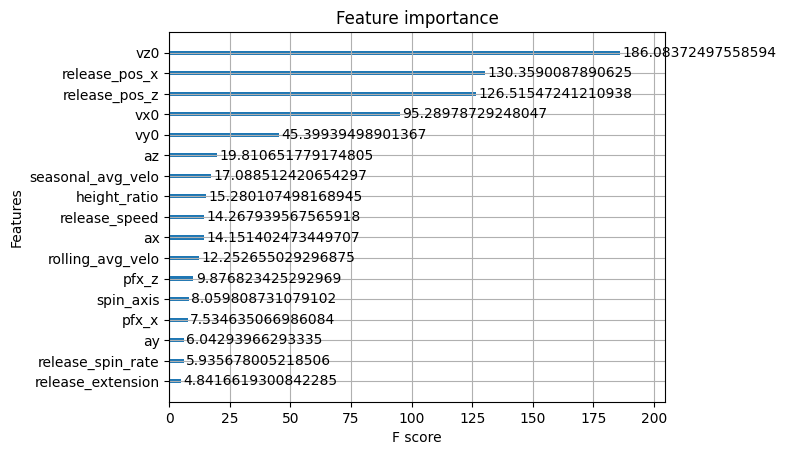

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

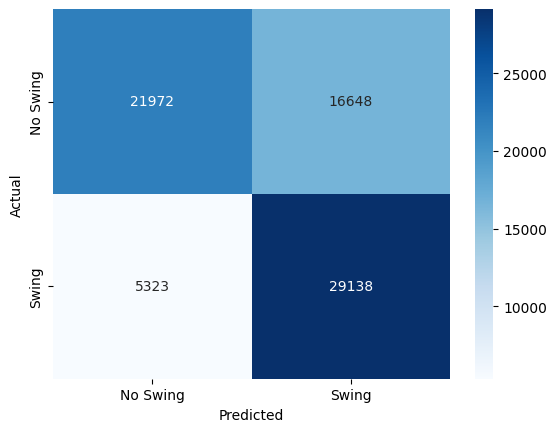

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xswing'] = y_pred

In [26]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")

Number of NaNs in 'xswing': 0


In [27]:
len(testing_identifiers)

702145

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/fastball/swing_2022&3_xswing.csv")